In [1]:
%cd ..
%ls

/home/nas3_userJ/dmkim/OnlineTSAD
cfgs/         data/  Exp/   models/   plots/    test.py*   utils/  wandb/
checkpoints/  EDA/   logs/  outputs/  results/  train.py*  Vis/


In [2]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_anomaly

import warnings
from data.load_data import DataFactory
from Exp.ReconBaselines import *

from easydict import EasyDict as edict
import yaml
import re
import copy

warnings.filterwarnings("ignore")

In [3]:
# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})
cfg['dataset'] = 'SWaT'

In [4]:
args = prepare_arguments(cfg)
args.model.latent_dim = 128
args.window_size = 12
args.eval_batch_size = 1
args.dataset = "SWaT"
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-03-29 13:53:33,394] Configurations: {'exp_id': 'MLP_SWaT', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT', 'log_path': './logs/MLP_SWaT', 'output_path': './outputs/MLP_SWaT', 'plot_path': './plots/MLP_SWaT', 'result_path': './results/MLP_SWaT', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}
[2023-03-29 13:53:33,396] Preparing SWaT dataset...
[2023-03-29 13:53:33,397] current location: /home/nas3_userJ/dmkim/OnlineTSAD
[2023-03-29 13:53:33,398] home dir: .
[2023-03-29 13:53:33,399] Preparing SWaT ...


{'exp_id': 'MLP_SWaT', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT', 'log_path': './logs/MLP_SWaT', 'output_path': './outputs/MLP_SWaT', 'plot_path': './plots/MLP_SWaT', 'result_path': './results/MLP_SWaT', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}


[2023-03-29 13:53:43,471] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-03-29 13:53:43,549] Complete.
[2023-03-29 13:53:43,550] Preparing dataloader...
[2023-03-29 13:53:44,265] total train dataset- 7763, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-03-29 13:53:44,267] total test dataset- 37493, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-03-29 13:53:44,268] Complete.


(496800, 51) (496800,) (449916, 51) (449916,)


## Visualize

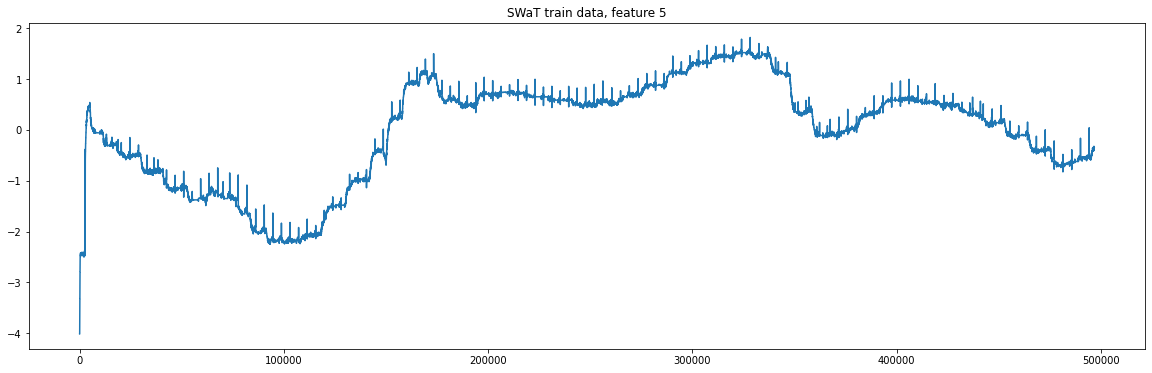

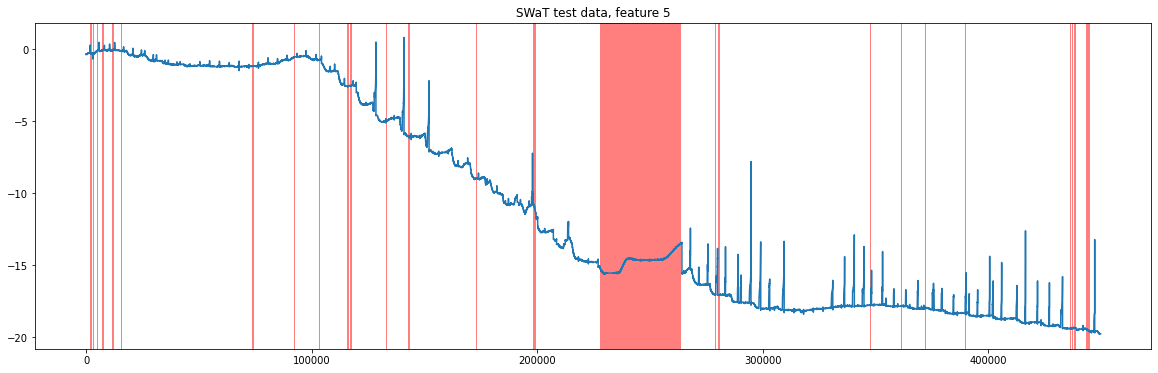

In [5]:
C = 5
dataset = "SWaT"
datafactory.visualize_dataset(train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y, dataset_name=dataset, feature_idx=C)

## Load Model

In [6]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

[2023-03-29 13:53:48,053] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict
[2023-03-29 13:53:48,068] train_errors.pt file exists, loading...
[2023-03-29 13:53:48,100] torch.Size([496789, 12])
[2023-03-29 13:53:48,288] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [7]:
next(iter(tester.model.parameters())).device, next(iter(tester.model.parameters())).requires_grad

(device(type='cuda', index=0), True)

## Training statistics

In [8]:
train_iterator = tqdm(
    tester.train_loader,
    total=len(tester.train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

recon_errors = []
with torch.no_grad():
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X)
        recon_error = torch.nn.functional.mse_loss(Xhat, X, reduction='none')
        recon_errors.append(recon_error)

recon_errors = torch.cat(recon_errors, axis=0)

train_error_dist = recon_errors.mean(dim=(1, 2))

print(f"{recon_errors.shape}, {train_error_dist.shape}")

calculating reconstruction errors: 100%|██████████| 7763/7763 [00:12<00:00, 606.72it/s]

torch.Size([496789, 12, 51]), torch.Size([496789])


## Test: static threshold inference

In [9]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

anoscs_prev = []
Xhats_prev = []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X)
        Xhats_prev.append(Xhat)        
        e = F.mse_loss(Xhat, X, reduction='none')
        anosc = e.mean(dim=2)
        anoscs_prev.append(anosc)

Xhats_prev = torch.cat(Xhats_prev, axis=0).detach().cpu().numpy()
anoscs_prev = torch.cat(anoscs_prev, axis=0).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [00:30<00:00, 1239.45it/s]


In [10]:
th_q95 = torch.quantile(train_error_dist, 0.95).item()
th_q99 = torch.quantile(train_error_dist, 0.99).item()
th_q100 = torch.max(train_error_dist).item()
th_best_static = tester.get_best_static_threshold(gt=test_y, anomaly_scores=anoscs_prev)
th_q95, th_q99, th_q100, th_best_static

[2023-03-29 13:54:31,730] Best threshold found at: 7.9125590324401855, with fpr: 0.007262250462902067, tpr: 0.6276198153304998
tn: 392461 fn: 20326
fp: 2871 tp: 34258


(0.009716848842799664, 0.04816127195954323, 6.910831451416016, 7.912559)

In [11]:
# 95
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q95))
# 99
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q99))
# 100
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q100))
# oracle
print(get_summary_stats(test_dataset.y, anoscs_prev > th_best_static))

{'Accuracy': 0.2798144542536829, 'Precision': 0.14097681744168383, 'Recall': 0.9691484684156529, 'F1': 0.24614783294518905, 'tn': 72993, 'fp': 322339, 'fn': 1684, 'tp': 52900}
{'Accuracy': 0.3467002729398377, 'Precision': 0.149155672823219, 'Recall': 0.932086325663198, 'F1': 0.2571597537428858, 'tn': 105109, 'fp': 290223, 'fn': 3707, 'tp': 50877}
{'Accuracy': 0.9476768996879418, 'Precision': 0.9136750086618161, 'Recall': 0.6280595046167375, 'F1': 0.7444112697464851, 'tn': 392093, 'fp': 3239, 'fn': 20302, 'tp': 34282}
{'Accuracy': 0.9484392642182097, 'Precision': 0.9226729153199742, 'Recall': 0.6276014949435732, 'F1': 0.7470560013956733, 'tn': 392461, 'fp': 2871, 'fn': 20327, 'tp': 34257}


## EMA

In [12]:
import torch
import copy
from utils.tools import set_requires_grad

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val
        
class EMAUpdater:
    def __init__(self, source_model, target_model, moving_average_decay, start_iter=0):
        super().__init__()
        self.source_model = source_model
        self.target_model = target_model
        self.moving_average_decay = moving_average_decay
        self.start_iter = start_iter

        set_requires_grad(self.target_model, False)
        self._update_moving_average(0.0)

    def _update_moving_average(self, moving_average_decay):
        with torch.no_grad():
            for target_params, source_params in zip(self.target_model.parameters(), self.source_model.parameters()):
                target_params.copy_(source_params.lerp(target_params, moving_average_decay))
            for target_buffers, source_buffers in zip(self.target_model.buffers(), self.source_model.buffers()):
                target_buffers.copy_(source_buffers)
    
    def update(self, iter_count):
        if iter_count < self.start_iter:
            self._update_moving_average(0.0)
        else:
            self._update_moving_average(self.moving_average_decay)

In [13]:
import torch
def f1_loss(y_pred, y_true):
    tp = (y_true*y_pred).sum(dim=0)
    tn = ((1-y_true)*(1-y_pred)).sum(dim=0)
    fp = ((1-y_true)*y_pred).sum(dim=0)
    fn = (y_true*(1-y_pred)).sum(dim=0)
    
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    
    cost_class1 = 1-soft_f1_class1
    cost_class0 = 1-soft_f1_class0
    
    cost = 0.5*(cost_class1+cost_class0)
    return cost.mean()

In [107]:
import torch.nn as nn
'''
https://pytorch.org/vision/main/_modules/torchvision/ops/focal_loss.html
'''
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        '''
        inputs: 0 < p < 1
        targets: 0, 1
        '''        
        p = inputs
        ce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        p_t = p*targets + (1-p)*(1-targets)
        alpha_t = self.alpha * targets + (1 -self.alpha)*(1-targets)
        F_loss = alpha_t * ((1-p_t)**self.gamma) * ce_loss
        return F_loss.mean()

## Value-based Pseudo-label guided Online Learning

### 1. Single+CE

In [14]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr = torch.tensor(thr, requires_grad=True)
thr

tensor(0.0097, requires_grad=True)

In [15]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

[2023-03-29 13:54:33,597] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict
[2023-03-29 13:54:33,808] train_errors.pt file exists, loading...
[2023-03-29 13:54:33,846] torch.Size([496789, 12])
[2023-03-29 13:54:34,025] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [16]:
## v3
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TT_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    Xhat = tester.model(X)
    E = F.mse_loss(Xhat, X, reduction='none')
    A = E.mean(dim=2)
    ytilde = (A > thr).float()
    pred = (A > thr)
    
    # log source model outputs
    Xhats.append(Xhat)
    As.append(A)
    preds.append(pred.detach())
    thrs.append(thr.item())
    
    # update model
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    yhat = torch.sigmoid((A-thr))
    recon_loss = (A*mask).mean()
    cls_loss = bce(yhat, ytilde)
    loss = recon_loss + cls_loss
    loss.backward()
    TT_optimizer.step()
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [01:57<00:00, 318.91it/s]


In [17]:
print(test_y.shape, preds.shape)
single_CE = get_summary_stats(test_y, preds)
print(single_CE)

(449916,) (449916,)
{'Accuracy': 0.9551093981987748, 'Precision': 0.9574320908824859, 'Recall': 0.6592957643265426, 'F1': 0.7808746785865402, 'tn': 393732, 'fp': 1600, 'fn': 18597, 'tp': 35987}


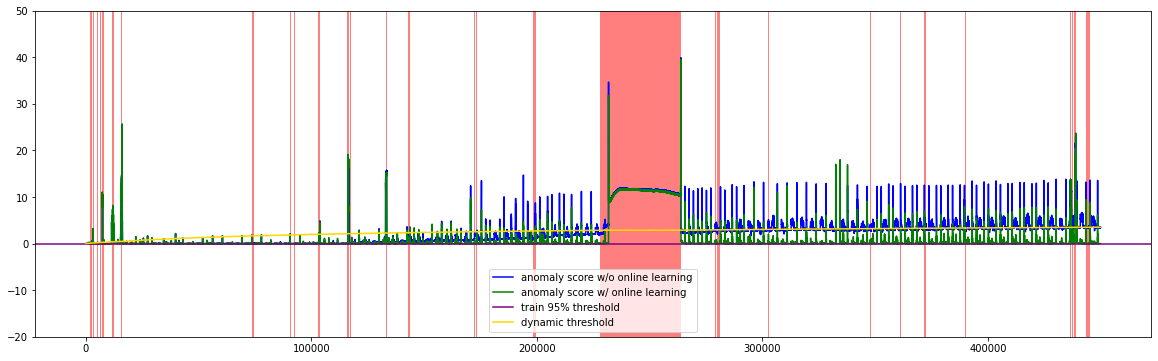

In [18]:
plt.figure(figsize=(20, 6))
plt.ylim([-20, 50])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_anomaly(plt, test_y)
plt.show()

### Double + CE

In [19]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr = torch.tensor(thr, requires_grad=True)
thr

tensor(0.0097, requires_grad=True)

In [20]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

pretrained_model = tester.model
source_model = copy.deepcopy(pretrained_model)
target_model = copy.deepcopy(pretrained_model)
ema_updater = EMAUpdater(source_model, target_model, 0.99)

[2023-03-29 13:56:38,078] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict
[2023-03-29 13:56:38,093] train_errors.pt file exists, loading...
[2023-03-29 13:56:38,114] torch.Size([496789, 12])
[2023-03-29 13:56:38,290] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [82]:
## v3
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03

TT_optimizer = torch.optim.SGD([thr]+[p for p in source_model.parameters()], lr=lr)


Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    # target model inference
    with torch.no_grad():
        Xhat = target_model(X)
        E = F.mse_loss(Xhat, X, reduction='none')
        A = E.mean(dim=2)
        yhat = torch.sigmoid((A-thr))
        ytilde = (A>thr).float()
    
    # source model inference
    Xhatp = source_model(X)
    Ep = F.mse_loss(Xhatp, X, reduction='none')
    Ap = Ep.mean(dim=2)
    yhatp = torch.sigmoid((Ap-thr))
    
    pred = (Ap > thr)
    
    # log target model outputs
    Xhats.append(Xhat.clone().detach())
    As.append(A.clone().detach())
    preds.append(pred.clone().detach())
    thrs.append(thr.clone().detach().item())
    
    # update model
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    recon_loss = (Ap*mask).mean()
    cls_loss = bce(yhatp, ytilde)
    loss = recon_loss + cls_loss
    loss.backward()
    TT_optimizer.step()
    
    # EMA
    ema_updater.update(1)

    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors:   1%|▏         | 500/37493 [00:02<03:22, 182.73it/s]


KeyboardInterrupt: 

In [22]:
print(test_y.shape, preds.shape)
double_CE = get_summary_stats(test_y, preds)
print(double_CE)

(449916,) (449916,)
{'Accuracy': 0.955233865877186, 'Precision': 0.9672264575815948, 'Recall': 0.6531401143192144, 'F1': 0.7797425718753759, 'tn': 394124, 'fp': 1208, 'fn': 18933, 'tp': 35651}


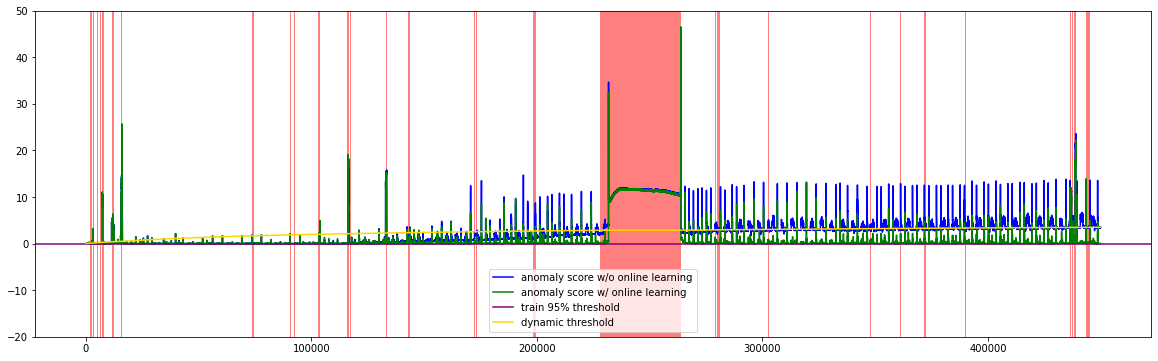

In [23]:
plt.figure(figsize=(20, 6))
plt.ylim([-20, 50])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_anomaly(plt, test_y)
plt.show()

### Single + Focal


In [108]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr = torch.tensor(thr, requires_grad=True)
thr

tensor(0.0097, requires_grad=True)

In [109]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

[2023-03-29 16:34:07,367] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict
[2023-03-29 16:34:07,425] train_errors.pt file exists, loading...
[2023-03-29 16:34:07,452] torch.Size([496789, 12])
[2023-03-29 16:34:07,625] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [110]:
## v3
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TT_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
focal = FocalLoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

param = next(iter(tester.model.parameters()))
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    Xhat = tester.model(X)
    E = F.mse_loss(Xhat, X, reduction='none')
    A = E.mean(dim=2)
    ytilde = (A > thr).float()
    pred = (A > thr)
    
    # log source model outputs
    Xhats.append(Xhat)
    As.append(A)
    preds.append(pred.detach())
    thrs.append(thr.item())
    
    # update model
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    yhat = torch.sigmoid((A-thr))
    recon_loss = (A*mask).mean()
    cls_loss = focal(yhat, ytilde)
    loss = recon_loss + cls_loss
    loss.backward()
    TT_optimizer.step()
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [02:48<00:00, 223.16it/s]


In [111]:
print(test_y.shape, preds.shape)
single_focal = get_summary_stats(test_y, preds)
print(single_focal)

(449916,) (449916,)
{'Accuracy': 0.9525244712346305, 'Precision': 0.894640566351499, 'Recall': 0.6899274512677708, 'F1': 0.7790603860237075, 'tn': 390897, 'fp': 4435, 'fn': 16925, 'tp': 37659}


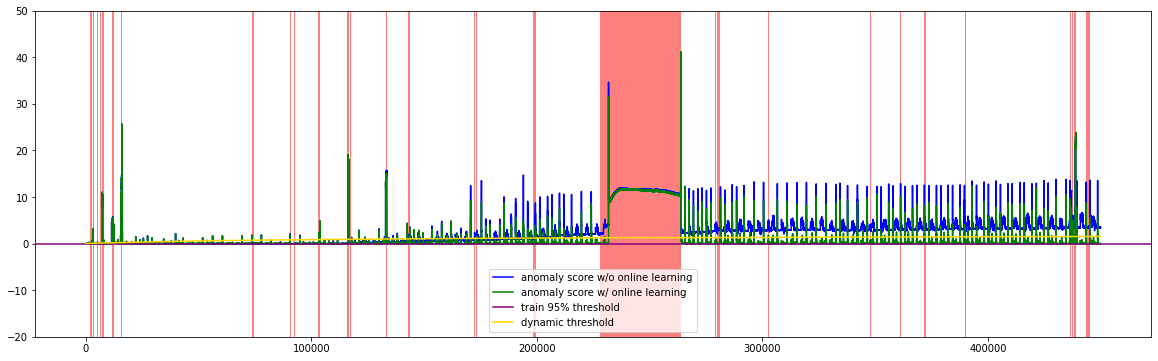

In [112]:
plt.figure(figsize=(20, 6))
plt.ylim([-20, 50])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_anomaly(plt, test_y)
plt.show()

### Single + F1

In [24]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr = torch.tensor(thr, requires_grad=True)
thr

tensor(0.0097, requires_grad=True)

In [25]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

[2023-03-29 13:59:40,507] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict
[2023-03-29 13:59:40,599] train_errors.pt file exists, loading...
[2023-03-29 13:59:40,622] torch.Size([496789, 12])
[2023-03-29 13:59:40,797] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [26]:
## v3
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TT_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

param = next(iter(tester.model.parameters()))
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    Xhat = tester.model(X)
    E = F.mse_loss(Xhat, X, reduction='none')
    A = E.mean(dim=2)
    ytilde = (A > thr).float()
    pred = (A > thr)
    
    # log source model outputs
    Xhats.append(Xhat)
    As.append(A)
    preds.append(pred.detach())
    thrs.append(thr.item())
    
    # update model
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    yhat = torch.sigmoid((A-thr))
    recon_loss = (A*mask).mean()
    cls_loss = f1_loss(yhat, ytilde)
    loss = recon_loss + cls_loss
    loss.backward()
    TT_optimizer.step()
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [03:00<00:00, 208.29it/s]


In [27]:
print(test_y.shape, preds.shape)
single_f1 = get_summary_stats(test_y, preds)
single_f1

(449916,) (449916,)


{'Accuracy': 0.6527862978867166,
 'Precision': 0.22640615493951124,
 'Recall': 0.7704089110362011,
 'F1': 0.3499652548050316,
 'tn': 251647,
 'fp': 143685,
 'fn': 12532,
 'tp': 42052}

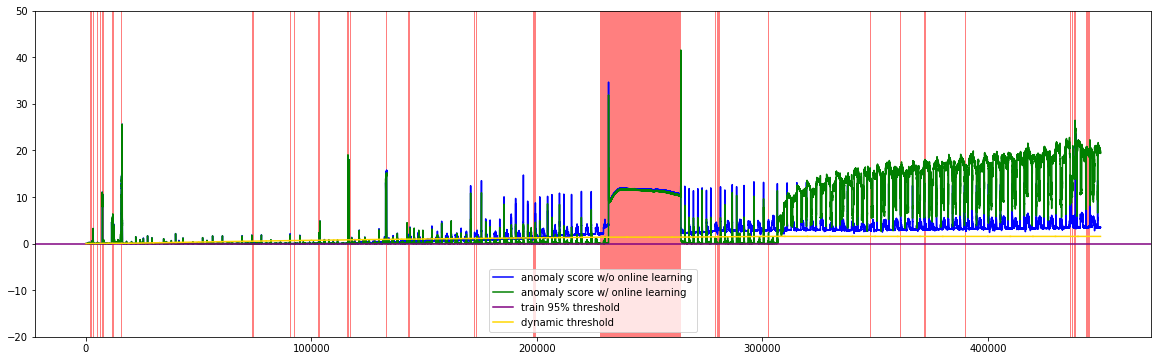

In [28]:
plt.figure(figsize=(20, 6))
plt.ylim([-20, 50])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_anomaly(plt, test_y)
plt.show()

### Double + Focal

In [76]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr = torch.tensor(thr, requires_grad=True)
thr

tensor(0.0097, requires_grad=True)

In [77]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

pretrained_model = tester.model
source_model = copy.deepcopy(pretrained_model)
target_model = copy.deepcopy(pretrained_model)
ema_updater = EMAUpdater(source_model, target_model, 0.99)

[2023-03-29 15:27:45,759] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict
[2023-03-29 15:27:45,866] train_errors.pt file exists, loading...
[2023-03-29 15:27:45,903] torch.Size([496789, 12])
[2023-03-29 15:27:46,084] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [78]:
## v3
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03

TT_optimizer = torch.optim.SGD([thr]+[p for p in source_model.parameters()], lr=lr)
bce = torch.nn.BCELoss()
focal = FocalLoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    # target model inference
    with torch.no_grad():
        Xhat = target_model(X)
        E = F.mse_loss(Xhat, X, reduction='none')
        A = E.mean(dim=2)
        yhat = torch.sigmoid((A-thr))
        ytilde = (A>thr).float()
    
    # source model inference
    Xhatp = source_model(X)
    Ep = F.mse_loss(Xhatp, X, reduction='none')
    Ap = Ep.mean(dim=2)
    yhatp = torch.sigmoid((Ap-thr))
    pred = (Ap > thr)
    
    # log target model outputs
    Xhats.append(Xhat.clone().detach())
    As.append(A.clone().detach())
    preds.append(pred.clone().detach())
    thrs.append(thr.clone().detach().item())
    
    # update model
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    recon_loss = (Ap*mask).mean()
    cls_loss = focal(yhatp, ytilde)
    loss = recon_loss + cls_loss
    loss.backward()
    TT_optimizer.step()
    
    # EMA
    ema_updater.update(1)
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [03:07<00:00, 200.14it/s]


In [79]:
print(test_y.shape, preds.shape)
double_focal = get_summary_stats(test_y, preds)
double_focal

(449916,) (449916,)


{'Accuracy': 0.9490593799731506,
 'Precision': 0.8609863425978704,
 'Recall': 0.6918144511212077,
 'F1': 0.7671850715642555,
 'tn': 389235,
 'fp': 6097,
 'fn': 16822,
 'tp': 37762}

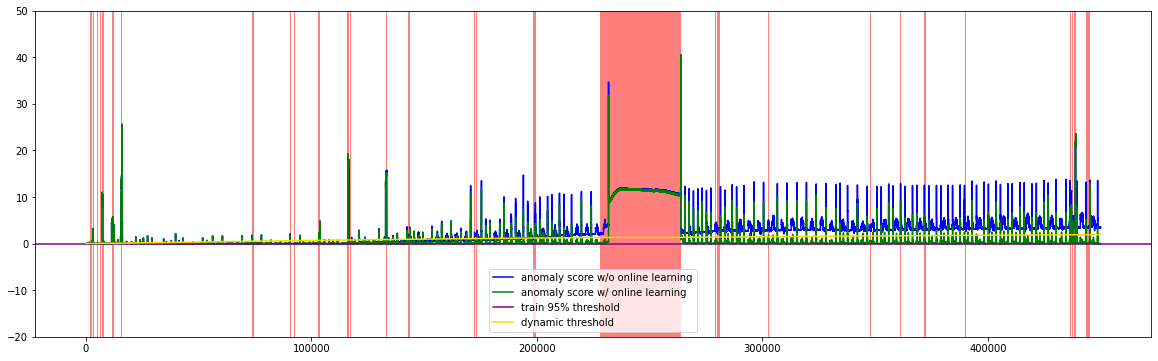

In [80]:
plt.figure(figsize=(20, 6))
plt.ylim([-20, 50])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_anomaly(plt, test_y)
plt.show()

### Double + F1

In [29]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr = torch.tensor(thr, requires_grad=True)
thr

tensor(0.0097, requires_grad=True)

In [30]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

pretrained_model = tester.model
source_model = copy.deepcopy(pretrained_model)
target_model = copy.deepcopy(pretrained_model)
ema_updater = EMAUpdater(source_model, target_model, 0.99)

[2023-03-29 14:02:46,950] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict
[2023-03-29 14:02:47,045] train_errors.pt file exists, loading...
[2023-03-29 14:02:47,065] torch.Size([496789, 12])
[2023-03-29 14:02:47,211] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [31]:
## v3
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03

TT_optimizer = torch.optim.SGD([thr]+[p for p in source_model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

param = next(iter(tester.model.parameters()))
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    # target model inference
    with torch.no_grad():
        Xhat = target_model(X)
        E = F.mse_loss(Xhat, X, reduction='none')
        A = E.mean(dim=2)
        yhat = torch.sigmoid((A-thr))
        ytilde = (A>thr).float()
    
    # source model inference
    Xhatp = source_model(X)
    Ep = F.mse_loss(Xhatp, X, reduction='none')
    Ap = Ep.mean(dim=2)
    yhatp = torch.sigmoid((Ap-thr))
    pred = (Ap > thr)
    
    # log target model outputs
    Xhats.append(Xhat.clone().detach())
    As.append(A.clone().detach())
    preds.append(pred.clone().detach())
    thrs.append(thr.clone().detach().item())
    
    # update model
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    recon_loss = (Ap*mask).mean()
    cls_loss = f1_loss(yhatp, ytilde)
    loss = recon_loss + cls_loss
    loss.backward()
    TT_optimizer.step()
    
    # EMA
    ema_updater.update(1)
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [03:36<00:00, 173.42it/s]


In [32]:
print(test_y.shape, preds.shape)
double_f1 = get_summary_stats(test_y, preds)
double_f1

(449916,) (449916,)


{'Accuracy': 0.9420180655944665,
 'Precision': 0.7985542168674699,
 'Recall': 0.6982082661585812,
 'F1': 0.745017544888524,
 'tn': 385718,
 'fp': 9614,
 'fn': 16473,
 'tp': 38111}

In [33]:
anoscs_prev

array([1.3910780e-03, 4.7100711e-04, 4.9952976e-04, ..., 3.4898121e+00,
       3.4899063e+00, 3.5122371e+00], dtype=float32)

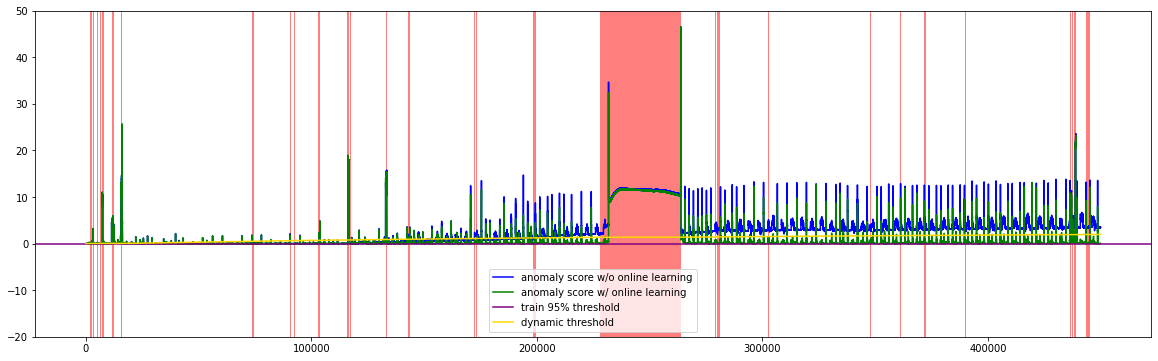

In [34]:
plt.figure(figsize=(20, 6))
plt.ylim([-20, 50])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_anomaly(plt, test_y)

plt.show()

## Wrap up

In [47]:
result_df = pd.DataFrame([single_CE], index=["single_CE"])

#result_df = result_df.append(pd.DataFrame([single_CE], index=["single_CE"], columns=result_df.columns))
result_df = result_df.append(pd.DataFrame([double_CE], index=["double_CE"], columns=result_df.columns))
result_df = result_df.append(pd.DataFrame([single_f1], index=["single_f1"], columns=result_df.columns))
result_df = result_df.append(pd.DataFrame([double_f1], index=["double_f1"], columns=result_df.columns))
 
result_df

Accuracy  Precision    Recall        F1      tn      fp     fn  \
single_CE  0.955109   0.957432  0.659296  0.780875  393732    1600  18597   
double_CE  0.955234   0.967226  0.653140  0.779743  394124    1208  18933   
single_f1  0.652786   0.226406  0.770409  0.349965  251647  143685  12532   
double_f1  0.942018   0.798554  0.698208  0.745018  385718    9614  16473   

              tp  
single_CE  35987  
double_CE  35651  
single_f1  42052  
double_f1  38111

In [36]:
s, e = None, None
for i in range(len(test_y)):
    if test_y[i] == 1 and s is None:
        s = i
    elif test_y[i] == 0 and s is not None:
        e = i - 1
        print(f"[{s}, {e}], {preds[s:e].sum()} / {e-s+1}")
        s, e = None, None

[1754, 2693], 45 / 940
[3068, 3510], 308 / 443
[4920, 5302], 280 / 383
[6459, 6848], 0 / 390
[7255, 7450], 185 / 196
[7705, 8133], 412 / 429
[11410, 12373], 963 / 964
[15380, 16100], 720 / 721
[73800, 74520], 0 / 721
[90685, 90917], 0 / 233
[92140, 92570], 0 / 431
[93445, 93720], 0 / 276
[103092, 103808], 444 / 717
[115843, 116101], 0 / 259
[116143, 116537], 377 / 395
[117000, 117720], 0 / 721
[132918, 133380], 462 / 463
[142954, 143650], 567 / 697
[172305, 172588], 0 / 284
[172910, 173521], 3 / 612
[198296, 199740], 24 / 1445
[227828, 263727], 31972 / 35900
[279120, 279240], 0 / 121
[280060, 281230], 0 / 1171
[302653, 303019], 0 / 367
[347679, 348279], 0 / 601
[361191, 361634], 42 / 444
[371479, 371579], 0 / 101
[371855, 372335], 10 / 481
[389680, 390219], 0 / 540
[436541, 437009], 429 / 469
[437417, 437697], 242 / 281
[438147, 438547], 355 / 401
[438621, 438917], 258 / 297
[443501, 445190], 3 / 1690


### backup

In [37]:
## v3
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03

TT_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []


param = next(iter(source_model.parameters()))
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    Xs.append(X)
    
    # target model inference
    with torch.no_grad():
        Xhatp = target_model(X)
        Ep = F.mse_loss(Xhatp, X, reduction='none')
        Ap = Ep.mean(dim=2)
        yhatp = torch.sigmoid((Ap-thr))
        ytilde = (Ap > thr).float()
    
    # source model inference
    Xhat = source_model(X)
    E = F.mse_loss(Xhat, X, reduction='none')
    A = E.mean(dim=2)
    yhat = torch.sigmoid((A-thr))
    pred = (A > thr)
    
    # log source model outputs
    Xhats.append(Xhat)
    As.append(A)
    preds.append(pred)
    thrs.append(thr)
    
    # update model
    TT_optimizer.zero_grad()
    
    
    mask = (ytilde == 0)
    recon_loss = (A*mask).mean()
    cls_loss = f1_loss(yhatp, yhat)
    loss = recon_loss + cls_loss
    loss.backward()
    TT_optimizer.step()
    
    
    print(f"recon_loss:{recon_loss.item()} | cls_loss: {cls_loss.item()} | thr: {thr.item()}"+
          f"| model_grad: {param.grad[0][0]} | thr_grad: {thr.grad}")
    # EMA
    ema_updater.update(1)
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(torch.stack(thrs).detach().cpu().numpy()), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors:   0%|          | 3/37493 [00:00<21:39, 28.84it/s]

recon_loss:0.10663124173879623 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.0005139156710356474 | thr_grad: -2.0919862436130643e-05
recon_loss:0.11218547075986862 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.001304288161918521 | thr_grad: -1.2546737707452849e-05
recon_loss:0.10506703704595566 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.0018205010564997792 | thr_grad: -1.6426203728769906e-05
recon_loss:0.10991913080215454 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.002593158045783639 | thr_grad: -7.980456757650245e-06
recon_loss:0.12139655649662018 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.0032311566174030304 | thr_grad: -1.194085052702576e-05
recon_loss:0.11027642339468002 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.0039524813182652 | thr_grad: -1.5538993466179818e-05
recon_loss:0.12073950469493866 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.004661059007048607 | thr_grad: -1.0136234777746722e-05


calculating reconstruction errors:   0%|          | 21/37493 [00:00<05:26, 114.73it/s]

recon_loss:0.12468486279249191 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.008056352846324444 | thr_grad: -1.946062911883928e-05
recon_loss:0.12762409448623657 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.00891713798046112 | thr_grad: -1.2145214896008838e-05
recon_loss:0.11887183785438538 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.009544960223138332 | thr_grad: -1.3409313396550715e-05
recon_loss:0.13512200117111206 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.01046505942940712 | thr_grad: -1.5801895642653108e-05
recon_loss:0.12894995510578156 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.011128111742436886 | thr_grad: -1.430326301488094e-05
recon_loss:0.13943248987197876 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.012041219510138035 | thr_grad: -1.1817044651252218e-05
recon_loss:0.13648131489753723 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.012669399380683899 | thr_grad: -1.7189810023410246e-05
rec

calculating reconstruction errors:   0%|          | 41/37493 [00:00<04:06, 151.65it/s]

recon_loss:0.1560249626636505 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.0282950047403574 | thr_grad: -6.394858701241901e-06
recon_loss:0.15704134106636047 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.029285991564393044 | thr_grad: -1.1704852113325614e-05
recon_loss:0.16714128851890564 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.030042525380849838 | thr_grad: -1.4469833331531845e-05
recon_loss:0.16013872623443604 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.031021002680063248 | thr_grad: -3.839179044007324e-06
recon_loss:0.15996447205543518 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.031793877482414246 | thr_grad: -2.787543735394138e-06
recon_loss:0.1615993231534958 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.03278997167944908 | thr_grad: -1.0516378097236156e-05
recon_loss:0.15238329768180847 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.033548615872859955 | thr_grad: 4.9145596676680725e-06
recon_lo

calculating reconstruction errors:   0%|          | 61/37493 [00:00<03:39, 170.37it/s]

recon_loss:0.1561182737350464 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.03936723247170448 | thr_grad: -1.8344842374062864e-06
recon_loss:0.17599284648895264 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.04028920829296112 | thr_grad: -1.0058749921881827e-07
recon_loss:0.16634401679039001 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.04089118167757988 | thr_grad: 2.7193937057745643e-06
recon_loss:0.16104386746883392 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.04181158170104027 | thr_grad: -1.7853280951385386e-06
recon_loss:0.16057929396629333 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.04256653040647507 | thr_grad: 1.7892768937599612e-06
recon_loss:0.17314085364341736 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.04348418116569519 | thr_grad: -6.91382956574671e-06
recon_loss:0.19741058349609375 | cls_loss: 0.5 | thr: 1.9645999670028687| model_grad: 0.0441812127828598 | thr_grad: -3.988666776422178e-06
recon_loss:0.

calculating reconstruction errors:   0%|          | 80/37493 [00:00<03:31, 177.10it/s]

recon_loss:0.4068760871887207 | cls_loss: 0.5000001192092896 | thr: 1.9646008014678955| model_grad: 0.04591178148984909 | thr_grad: -9.144795330939814e-05
recon_loss:0.3946784436702728 | cls_loss: 0.5000001192092896 | thr: 1.964600920677185| model_grad: 0.04591178148984909 | thr_grad: -8.789222192717716e-05
recon_loss:0.4043487012386322 | cls_loss: 0.5000001192092896 | thr: 1.9646010398864746| model_grad: 0.04591178148984909 | thr_grad: -9.260112710762769e-05
recon_loss:0.37292298674583435 | cls_loss: 0.5000001192092896 | thr: 1.9646011590957642| model_grad: 0.04591178148984909 | thr_grad: -6.70464796712622e-05
recon_loss:0.3803175389766693 | cls_loss: 0.5000001192092896 | thr: 1.9646012783050537| model_grad: 0.04591178148984909 | thr_grad: -7.527269190177321e-05
recon_loss:0.37295660376548767 | cls_loss: 0.5000001192092896 | thr: 1.9646013975143433| model_grad: 0.04591178148984909 | thr_grad: -6.785735604353249e-05
recon_loss:0.3390800356864929 | cls_loss: 0.5 | thr: 1.964601397514343

calculating reconstruction errors:   0%|          | 98/37493 [00:00<03:37, 171.96it/s]

recon_loss:0.33061662316322327 | cls_loss: 0.5 | thr: 1.9646013975143433| model_grad: 0.04591178148984909 | thr_grad: -2.2735695893061347e-05
recon_loss:0.33573222160339355 | cls_loss: 0.5 | thr: 1.9646013975143433| model_grad: 0.04591178148984909 | thr_grad: -2.289240546815563e-05
recon_loss:0.32705774903297424 | cls_loss: 0.5 | thr: 1.9646013975143433| model_grad: 0.04591178148984909 | thr_grad: -2.2759435523767024e-05
recon_loss:0.31676825881004333 | cls_loss: 0.5 | thr: 1.9646013975143433| model_grad: 0.04591178148984909 | thr_grad: -2.0886069250991568e-05
recon_loss:0.3336746096611023 | cls_loss: 0.5 | thr: 1.9646013975143433| model_grad: 0.04591178148984909 | thr_grad: -2.3444150428986177e-05
recon_loss:0.33318009972572327 | cls_loss: 0.5 | thr: 1.9646013975143433| model_grad: 0.04591178148984909 | thr_grad: -2.2906786398380063e-05
recon_loss:0.3120787739753723 | cls_loss: 0.5 | thr: 1.9646013975143433| model_grad: 0.04591178148984909 | thr_grad: -1.9368459106772207e-05
recon_los

calculating reconstruction errors:   0%|          | 116/37493 [00:00<03:34, 174.16it/s]

recon_loss:0.14887110888957977 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05137651786208153 | thr_grad: -7.180080956459278e-06
recon_loss:0.19157086312770844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05137651786208153 | thr_grad: -8.890255230653565e-06
recon_loss:0.3393676280975342 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.053744953125715256 | thr_grad: -4.6151540118444245e-06
recon_loss:0.1255466490983963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05363455414772034 | thr_grad: -1.914794120239094e-05
recon_loss:0.12321373075246811 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.053142648190259933 | thr_grad: -9.497667633695528e-06
recon_loss:0.1592913568019867 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.051116880029439926 | thr_grad: -3.978216409450397e-05
recon_loss:0.12269001454114914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.050663720816373825 | thr_grad: -9.653178494772874e-06
recon_loss:

calculating reconstruction errors:   0%|          | 138/37493 [00:00<03:18, 187.84it/s]

recon_loss:0.1275997757911682 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04716954752802849 | thr_grad: -9.5301766123157e-06
recon_loss:0.13105493783950806 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04736299067735672 | thr_grad: -9.801557098398916e-06
recon_loss:0.12658202648162842 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04744080454111099 | thr_grad: -9.60205215960741e-06
recon_loss:0.12651652097702026 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04699622467160225 | thr_grad: -8.802810043562204e-06
recon_loss:0.1275607943534851 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04659470543265343 | thr_grad: -9.936877177096903e-06
recon_loss:0.12547487020492554 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04649169370532036 | thr_grad: -9.021727237268351e-06
recon_loss:0.1297210156917572 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.046284642070531845 | thr_grad: -1.0003357601817697e-05
recon_loss:0.1296

calculating reconstruction errors:   0%|          | 161/37493 [00:00<03:08, 198.29it/s]

recon_loss:0.14573326706886292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -9.217677870765328e-06
recon_loss:0.14696869254112244 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -7.3981013883894775e-06
recon_loss:0.14704570174217224 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -8.769506166572683e-06
recon_loss:0.1479717642068863 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -9.346322258352302e-06
recon_loss:0.15076757967472076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -7.92009086580947e-06
recon_loss:0.14924146234989166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -6.676850716758054e-06
recon_loss:0.15309038758277893 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -7.881862075009849e-06
recon_loss:0.1

calculating reconstruction errors:   0%|          | 182/37493 [00:01<03:05, 200.75it/s]

recon_loss:0.13902927935123444 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -5.396097549237311e-06
recon_loss:0.14806637167930603 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -5.439605502033373e-06
recon_loss:0.15700840950012207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -6.364835826389026e-06
recon_loss:0.15544965863227844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -5.594344656856265e-06
recon_loss:0.1611248254776001 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -6.6191951191285625e-06
recon_loss:0.15023714303970337 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -5.280661298456835e-06
recon_loss:0.15462711453437805 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -5.79324887439725e-06
recon_loss:0.1

calculating reconstruction errors:   1%|          | 203/37493 [00:01<03:05, 200.82it/s]

recon_loss:0.16939207911491394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -3.532761411406682e-06
recon_loss:0.1631438136100769 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -4.657260888052406e-06
recon_loss:0.17247478663921356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -4.456906026462093e-06
recon_loss:0.1610392928123474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -4.16738294006791e-06
recon_loss:0.1713043451309204 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -5.0783814913302194e-06
recon_loss:0.16690364480018616 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -3.3038604669854976e-06
recon_loss:0.17608973383903503 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -4.330114279582631e-06
recon_loss:0.16

calculating reconstruction errors:   1%|          | 224/37493 [00:01<03:10, 196.15it/s]

recon_loss:0.1763826608657837 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -2.6568864086584654e-06
recon_loss:0.17975056171417236 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -3.5202797334932256e-06
recon_loss:0.17507337033748627 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -3.952567567466758e-06
recon_loss:0.17101983726024628 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -2.8530857889563777e-06
recon_loss:0.18469834327697754 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -2.9745719984930474e-06
recon_loss:0.17269191145896912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -3.1329952889791457e-06
recon_loss:0.17336487770080566 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03881951794028282 | thr_grad: -2.2224280655791517e-06
recon_lo

calculating reconstruction errors:   1%|          | 244/37493 [00:01<03:11, 194.26it/s]

recon_loss:0.2362576425075531 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022232573479413986 | thr_grad: 3.000302228883811e-07
recon_loss:0.2462286353111267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.021057963371276855 | thr_grad: 7.490953066735528e-07
recon_loss:0.25699853897094727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01808357611298561 | thr_grad: -1.5417146641993895e-05
recon_loss:0.25301873683929443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.015568764880299568 | thr_grad: -1.503054409113247e-05
recon_loss:0.25687339901924133 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.012819303199648857 | thr_grad: -1.4400493455468677e-05
recon_loss:0.23540523648262024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01157337799668312 | thr_grad: -6.28113866696367e-07
recon_loss:0.26506444811820984 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.00897197611629963 | thr_grad: -1.4977127648307942e-05
recon_loss:

calculating reconstruction errors:   1%|          | 264/37493 [00:01<03:15, 190.35it/s]

recon_loss:0.2219996154308319 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0005515433149412274 | thr_grad: -8.705990239832317e-08
recon_loss:0.23215095698833466 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0007177277002483606 | thr_grad: -3.5659812880339814e-08
recon_loss:0.2314213514328003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019687358289957047 | thr_grad: 2.7173337002750486e-07
recon_loss:0.2493143528699875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0046102507039904594 | thr_grad: -1.339736354566412e-05
recon_loss:0.22666198015213013 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005714442580938339 | thr_grad: 7.318886900975485e-07
recon_loss:0.22486361861228943 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006829491350799799 | thr_grad: 4.808365474673337e-07
recon_loss:0.24350975453853607 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00912866648286581 | thr_grad: -1.0579326044535264e-05


calculating reconstruction errors:   1%|          | 284/37493 [00:01<03:17, 188.79it/s]

recon_loss:0.20949958264827728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02399528957903385 | thr_grad: -9.817081263463479e-07
recon_loss:0.2120479792356491 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.025150835514068604 | thr_grad: -1.2248279972482123e-06
recon_loss:0.21029333770275116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.026290493085980415 | thr_grad: -1.406726141794934e-06
recon_loss:0.21235308051109314 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.027273718267679214 | thr_grad: -7.558053880529769e-07
recon_loss:0.2194843292236328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.028390616178512573 | thr_grad: -8.450117547909031e-07
recon_loss:0.24235795438289642 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03095693700015545 | thr_grad: -5.328478437149897e-06
recon_loss:0.24543367326259613 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.033438537269830704 | thr_grad: -5.251239599601831e-06
re

calculating reconstruction errors:   1%|          | 303/37493 [00:01<03:19, 186.74it/s]

recon_loss:0.08330260217189789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03851767256855965 | thr_grad: 5.950682293587306e-07
recon_loss:0.088979572057724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03824590519070625 | thr_grad: -1.3512089935829863e-06
recon_loss:0.0917961448431015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0380132719874382 | thr_grad: -1.2169938372608158e-06
recon_loss:0.07994082570075989 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03794911876320839 | thr_grad: 6.849836609035265e-07
recon_loss:0.07954100519418716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03775507211685181 | thr_grad: 8.667003612572444e-07
recon_loss:0.06276659667491913 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03768118843436241 | thr_grad: 9.129573754762532e-07
recon_loss:0.06359392404556274 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.037613023072481155 | thr_grad: 5.514250460691983e-07
recon_loss:0

calculating reconstruction errors:   1%|          | 323/37493 [00:01<03:17, 188.01it/s]

recon_loss:0.07485345005989075 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.032567109912633896 | thr_grad: -6.479546073023812e-07
recon_loss:0.07270468771457672 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.032243501394987106 | thr_grad: -6.387151643139077e-07
recon_loss:0.07198673486709595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.031797125935554504 | thr_grad: -4.696699420492223e-07
recon_loss:0.07387956231832504 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03147222474217415 | thr_grad: -6.140120945019589e-07
recon_loss:0.07536152005195618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.031033741310238838 | thr_grad: -4.830166062674834e-07
recon_loss:0.07265651226043701 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.030704397708177567 | thr_grad: -5.318368607731827e-07
recon_loss:0.07387572526931763 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.030265044420957565 | thr_grad: -1.8607514107316092e-07

calculating reconstruction errors:   1%|          | 342/37493 [00:01<03:18, 186.83it/s]

recon_loss:0.07472240179777145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02772403135895729 | thr_grad: -6.118671080912463e-07
recon_loss:0.09177781641483307 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.027243364602327347 | thr_grad: -5.089460728413542e-07
recon_loss:0.08819394558668137 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.026774317026138306 | thr_grad: -7.805909945091116e-07
recon_loss:0.07020588964223862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.026553470641374588 | thr_grad: 1.1541485491761705e-06
recon_loss:0.08179818093776703 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.026102613657712936 | thr_grad: -8.003561902114598e-07
recon_loss:0.08389949798583984 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.025606701150536537 | thr_grad: -2.943014010270417e-07
recon_loss:0.09093175828456879 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0251623447984457 | thr_grad: -4.2111201992156566e-07
r

calculating reconstruction errors:   1%|          | 361/37493 [00:01<03:19, 186.00it/s]

recon_loss:0.10280191898345947 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015170073136687279 | thr_grad: -5.736677621825947e-07
recon_loss:0.10763683915138245 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014517166651785374 | thr_grad: -4.932331307827553e-07
recon_loss:0.08733770251274109 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014063321053981781 | thr_grad: -3.17717478992563e-07
recon_loss:0.1121835857629776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.013441270217299461 | thr_grad: -4.5046479613120027e-07
recon_loss:0.10105054825544357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012843620032072067 | thr_grad: -2.2855434167468047e-07
recon_loss:0.11300353705883026 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012198004871606827 | thr_grad: -5.223348580329912e-07
recon_loss:0.0947493314743042 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011724389158189297 | thr_grad: -4.836717266698543e-07


calculating reconstruction errors:   1%|          | 380/37493 [00:02<03:21, 184.35it/s]

recon_loss:0.1048668920993805 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008362631313502789 | thr_grad: -4.642600401894015e-07
recon_loss:0.10685102641582489 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.007684354204684496 | thr_grad: -3.1227008889800345e-07
recon_loss:0.13038517534732819 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.007110301870852709 | thr_grad: -4.7563895577695803e-07
recon_loss:0.11307396739721298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006433706730604172 | thr_grad: -5.153690381121123e-07
recon_loss:0.12040555477142334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0058950502425432205 | thr_grad: -3.9254044281733513e-07
recon_loss:0.1190803274512291 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005099622532725334 | thr_grad: -5.145338946022093e-07
recon_loss:0.11842292547225952 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0045521073043346405 | thr_grad: -4.2434587044226646

calculating reconstruction errors:   1%|          | 399/37493 [00:02<03:23, 182.14it/s]

recon_loss:0.13453249633312225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.007895583286881447 | thr_grad: -3.7872081293244264e-07
recon_loss:0.12606267631053925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.00869006384164095 | thr_grad: -3.9956034925126005e-07
recon_loss:0.15555143356323242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009495352394878864 | thr_grad: -9.267953373637283e-07
recon_loss:0.3495442867279053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009495352394878864 | thr_grad: -4.46478907178971e-07
recon_loss:0.22101780772209167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009252582676708698 | thr_grad: -5.507463356480002e-07
recon_loss:0.21937847137451172 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009252582676708698 | thr_grad: -3.9504965343439835e-07
recon_loss:0.2099343240261078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -3.3016462452906126e-07
recon_

calculating reconstruction errors:   1%|          | 418/37493 [00:02<03:25, 180.35it/s]

recon_loss:0.20854899287223816 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -3.1440347925126844e-07
recon_loss:0.20306861400604248 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.6280628162567155e-07
recon_loss:0.20594684779644012 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.9337493856473884e-07
recon_loss:0.2005910724401474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.1244929371277976e-07
recon_loss:0.2028881013393402 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.8471569635257765e-07
recon_loss:0.20481561124324799 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.915818697601935e-07
recon_loss:0.2057642936706543 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -3.23537932445106e-07
recon

calculating reconstruction errors:   1%|          | 456/37493 [00:02<03:28, 177.54it/s]

recon_loss:0.287875771522522 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.6922603524326405e-07
recon_loss:0.28028303384780884 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.2234561924960872e-07
recon_loss:0.28142639994621277 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.1382052750595903e-07
recon_loss:0.2758978605270386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.2930980492219533e-07
recon_loss:0.27906525135040283 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.0856379023825866e-07
recon_loss:0.2786473035812378 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.7596354357228847e-07
recon_loss:0.27365127205848694 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008978782221674919 | thr_grad: -2.655172579579812e-07
reco

calculating reconstruction errors:   1%|▏         | 492/37493 [00:02<03:27, 178.10it/s]

recon_loss:0.2121748924255371 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.010496718809008598 | thr_grad: -4.4394948872650275e-07
recon_loss:0.12686197459697723 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.00900000799447298 | thr_grad: -6.211678282852517e-07
recon_loss:0.12139376252889633 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009148742072284222 | thr_grad: -1.2920004621719272e-07
recon_loss:0.13402755558490753 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0093708960339427 | thr_grad: -1.9958054053859087e-07
recon_loss:0.1310391128063202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009736143983900547 | thr_grad: -1.6020987914089346e-07
recon_loss:0.1266024112701416 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009978619404137135 | thr_grad: -1.2833558571401227e-07
recon_loss:0.14595440030097961 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.007646220736205578 | thr_grad: -8.859386753101717e-07
recon_l

calculating reconstruction errors:   1%|▏         | 528/37493 [00:02<03:27, 177.96it/s]

recon_loss:0.14894603192806244 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009874476119875908 | thr_grad: -5.605525643659348e-08
recon_loss:0.15220409631729126 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.010772260837256908 | thr_grad: -7.415405178790024e-08
recon_loss:0.14470349252223969 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011446571908891201 | thr_grad: -1.0180448128949138e-07
recon_loss:0.1327684223651886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012222718447446823 | thr_grad: 1.6920164824796302e-08
recon_loss:0.14229369163513184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.013074049726128578 | thr_grad: -4.4621714323511696e-08
recon_loss:0.14278504252433777 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.013963595032691956 | thr_grad: -5.981871709082043e-08
recon_loss:0.15774914622306824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01494638156145811 | thr_grad: -8.7539156368166e-08
r

calculating reconstruction errors:   2%|▏         | 564/37493 [00:03<03:39, 168.50it/s]

recon_loss:0.09692587703466415 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024484360590577126 | thr_grad: 1.5547080067790375e-08
recon_loss:0.09345865249633789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024363819509744644 | thr_grad: 2.0759314622864622e-07
recon_loss:0.09641140699386597 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02421187423169613 | thr_grad: 2.002796151145958e-07
recon_loss:0.0964297279715538 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02407989092171192 | thr_grad: 1.972580463416307e-07
recon_loss:0.09892970323562622 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02398880384862423 | thr_grad: 2.0264116074031335e-07
recon_loss:0.10000912845134735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023702489212155342 | thr_grad: 1.9986391208703935e-08
recon_loss:0.10488562285900116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023382926359772682 | thr_grad: 2.4324375402784426e-08
recon

calculating reconstruction errors:   2%|▏         | 598/37493 [00:03<03:39, 168.20it/s]

recon_loss:0.1159009262919426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015956681221723557 | thr_grad: 1.4031504846911957e-08
recon_loss:0.12332184612751007 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015516074374318123 | thr_grad: 5.3061932625553254e-09
recon_loss:0.10839305818080902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015082993544638157 | thr_grad: 3.0987990840003476e-08
recon_loss:0.11193658411502838 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014893323183059692 | thr_grad: 3.1193639671300843e-08
recon_loss:0.11838480085134506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014393839985132217 | thr_grad: 3.554505667580088e-08
recon_loss:0.12904807925224304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.013963721692562103 | thr_grad: 1.4168092477007121e-08
recon_loss:0.11397916078567505 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.013474377803504467 | thr_grad: 3.5892576022433786e-08
r

calculating reconstruction errors:   2%|▏         | 615/37493 [00:03<03:41, 166.44it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005372247658669949 | thr_grad: 7.484675856525569e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005372247658669949 | thr_grad: 7.81665856174063e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005372247658669949 | thr_grad: -1.1275709370112824e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005372247658669949 | thr_grad: -1.7129856289942874e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005372247658669949 | thr_grad: 2.485559980058838e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005372247658669949 | thr_grad: 9.158129034856147e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005372247658669949 | thr_grad: 5.1014192327912544e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005372247658669949 | thr_grad: -2.3035688

calculating reconstruction errors:   2%|▏         | 632/37493 [00:03<03:46, 162.41it/s]

recon_loss:0.14247578382492065 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0032146298326551914 | thr_grad: 2.351983710013883e-07
recon_loss:0.12422680109739304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0032146298326551914 | thr_grad: 1.123944954883882e-07
recon_loss:0.17892777919769287 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0032146298326551914 | thr_grad: -9.053147209669987e-08
recon_loss:0.27770859003067017 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0035983072593808174 | thr_grad: 1.3116979857841216e-07
recon_loss:0.11453720182180405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0032670777291059494 | thr_grad: 2.5381275747804466e-08
recon_loss:0.11755125224590302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0029526730068027973 | thr_grad: 2.7195401486324045e-08
recon_loss:0.12139834463596344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.002559828571975231 | thr_grad: 2.989841618727951e

calculating reconstruction errors:   2%|▏         | 649/37493 [00:03<03:45, 163.57it/s]

recon_loss:0.43823814392089844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 1.6974996697172173e-07
recon_loss:0.349801629781723 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 1.477073929834205e-08
recon_loss:0.30391019582748413 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -6.71095818916001e-08
recon_loss:0.2417183816432953 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 6.269850416629197e-08
recon_loss:0.2200772613286972 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 6.073673830542248e-08
recon_loss:0.22595372796058655 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 7.936863255508797e-08
recon_loss:0.2674598693847656 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -3.925513070157649e-08
re

calculating reconstruction errors:   2%|▏         | 670/37493 [00:03<03:30, 175.18it/s]

recon_loss:0.23208454251289368 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -6.996065593511958e-08
recon_loss:0.24532422423362732 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 2.7076103137346763e-08
recon_loss:0.2375047206878662 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -1.141981940122605e-07
recon_loss:0.23860877752304077 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -6.361085524986265e-08
recon_loss:0.24716967344284058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 2.4648645791103263e-08
recon_loss:0.2497970312833786 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -7.849473604437662e-08
recon_loss:0.23899130523204803 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 2.471518811830719

calculating reconstruction errors:   2%|▏         | 688/37493 [00:03<03:29, 175.57it/s]

recon_loss:0.12307509034872055 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 2.657576825271235e-09
recon_loss:0.15544866025447845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -7.523397016484523e-08
recon_loss:0.12306524813175201 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: 3.9779894933644755e-09
recon_loss:0.12561167776584625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -4.408143894352179e-08
recon_loss:0.12776973843574524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -7.50495985357702e-08
recon_loss:0.13910506665706635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -3.421954630766777e-08
recon_loss:0.14319464564323425 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -8.39541201003157

calculating reconstruction errors:   2%|▏         | 706/37493 [00:03<03:36, 169.76it/s]

recon_loss:0.136089026927948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -3.952978744337088e-08
recon_loss:0.1433447003364563 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -6.608010494346672e-08
recon_loss:0.14075595140457153 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -7.220879894020982e-08
recon_loss:0.14403687417507172 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -6.701183963286894e-08
recon_loss:0.14293041825294495 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -5.8481582243530283e-08
recon_loss:0.1411450207233429 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -5.662044344489914e-08
recon_loss:0.1414010226726532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -5.930223423433745e

calculating reconstruction errors:   2%|▏         | 724/37493 [00:04<03:41, 166.17it/s]

recon_loss:0.1421317160129547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -2.897645323685083e-08
recon_loss:0.1593623161315918 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -4.0646856547255084e-08
recon_loss:0.14661100506782532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -2.6854078072346965e-08
recon_loss:0.14449386298656464 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -1.517799042005663e-08
recon_loss:0.15089786052703857 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -6.195945445597317e-08
recon_loss:0.14989541471004486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -3.40918084873465e-08
recon_loss:0.14386752247810364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -3.8867074891868

calculating reconstruction errors:   2%|▏         | 742/37493 [00:04<03:37, 168.62it/s]

recon_loss:0.154793843626976 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -1.7997662027369188e-08
recon_loss:0.15286250412464142 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -3.3253233056029785e-08
recon_loss:0.15468049049377441 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -1.4828033911840066e-08
recon_loss:0.16185849905014038 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -2.4873200388242367e-08
recon_loss:0.16609615087509155 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -3.175438223479432e-08
recon_loss:0.16843187808990479 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -2.9959792868794466e-08
recon_loss:0.15179090201854706 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -2.020969169

calculating reconstruction errors:   2%|▏         | 759/37493 [00:04<03:37, 168.90it/s]

recon_loss:0.17497536540031433 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -2.192143000456781e-08
recon_loss:0.16667890548706055 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -1.9970093134702438e-08
recon_loss:0.16553497314453125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -1.4506973400330025e-08
recon_loss:0.16455435752868652 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -1.4505751266824518e-08
recon_loss:0.1749841868877411 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -3.607403797900588e-08
recon_loss:0.16440309584140778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -8.396687789513635e-10
recon_loss:0.1671755015850067 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0019001297187060118 | thr_grad: -1.49817545036

calculating reconstruction errors:   2%|▏         | 776/37493 [00:04<03:43, 164.30it/s]

recon_loss:0.18104004859924316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0014794435119256377 | thr_grad: -1.3737135873270745e-09
recon_loss:0.18956443667411804 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0011713476851582527 | thr_grad: -5.072659181593053e-09
recon_loss:0.1889546811580658 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0008538815891370177 | thr_grad: 9.342482343299707e-10
recon_loss:0.21116852760314941 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0008538815891370177 | thr_grad: -4.4974974855449545e-08
recon_loss:0.1876010149717331 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0007075928151607513 | thr_grad: 2.1210011524885886e-08
recon_loss:0.1945440024137497 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 6.025592469427465e-09
recon_loss:0.2570871114730835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 2.6153566423658958e

calculating reconstruction errors:   2%|▏         | 794/37493 [00:04<03:40, 166.49it/s]

recon_loss:0.3370554447174072 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 5.425377835877043e-08
recon_loss:0.34370657801628113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 2.9230568188154393e-08
recon_loss:0.3236652910709381 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 4.6648857221498474e-08
recon_loss:0.3186500668525696 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 3.031870221548161e-08
recon_loss:0.30835822224617004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 2.910582885817803e-08
recon_loss:0.3071281909942627 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 2.4621680694281167e-08
recon_loss:0.310913622379303 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 4.273229237128362e-08
re

calculating reconstruction errors:   2%|▏         | 813/37493 [00:04<03:33, 171.46it/s]

recon_loss:0.25163254141807556 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 9.887520491247415e-08
recon_loss:0.25467097759246826 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 9.666541700426023e-08
recon_loss:0.2561981678009033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 1.0449865328610031e-07
recon_loss:0.25740525126457214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 1.7378468442075246e-08
recon_loss:0.2574220895767212 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 1.0222857582675715e-07
recon_loss:0.29381078481674194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: -1.6646136202780326e-07
recon_loss:0.2891753613948822 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: -1.9053966582305293

calculating reconstruction errors:   2%|▏         | 833/37493 [00:04<03:24, 179.17it/s]

recon_loss:0.2976236939430237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 1.254620372037607e-07
recon_loss:0.2925371527671814 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 1.170679837514399e-07
recon_loss:0.2951866090297699 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 1.2771357660312788e-07
recon_loss:0.338833749294281 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 2.456539505146793e-07
recon_loss:0.32677847146987915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: -5.8901242994124914e-08
recon_loss:0.23329322040081024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 4.183282342751227e-08
recon_loss:0.22733965516090393 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0003604600497055799 | thr_grad: 8.722145850015295e-08
r

calculating reconstruction errors:   2%|▏         | 852/37493 [00:04<03:24, 179.36it/s]

recon_loss:0.11480063199996948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005311352200806141 | thr_grad: 2.3640838620053728e-08
recon_loss:0.12179525941610336 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005684280768036842 | thr_grad: 6.331170965268029e-08
recon_loss:0.11785798519849777 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005690325051546097 | thr_grad: 2.325736403463452e-08
recon_loss:0.12104523181915283 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005967822391539812 | thr_grad: 3.163741979506085e-08
recon_loss:0.12318457663059235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006405008491128683 | thr_grad: 2.0247366450121262e-08
recon_loss:0.1181132048368454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006511807441711426 | thr_grad: 2.2825286549732482e-08
recon_loss:0.1209026500582695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.007159625645726919 | thr_grad: 1.4059401642896319e-08
reco

calculating reconstruction errors:   2%|▏         | 870/37493 [00:04<03:29, 174.67it/s]

recon_loss:0.1252003312110901 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008320911787450314 | thr_grad: 3.179626872906738e-08
recon_loss:0.13252542912960052 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009261472150683403 | thr_grad: 2.0383655652267407e-08
recon_loss:0.13009043037891388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009263011626899242 | thr_grad: 3.273696336236753e-08
recon_loss:0.1266670674085617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009635512717068195 | thr_grad: 2.64759840717943e-08
recon_loss:0.1329096555709839 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009545893408358097 | thr_grad: 2.7018291604008482e-08
recon_loss:0.12921229004859924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00956031959503889 | thr_grad: 3.093867206871437e-08
recon_loss:0.1288045346736908 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009513439610600471 | thr_grad: 3.1381507170635814e-08
recon_los

calculating reconstruction errors:   2%|▏         | 888/37493 [00:05<03:30, 174.29it/s]

recon_loss:0.18805408477783203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.016766251996159554 | thr_grad: -1.5671858477617207e-08
recon_loss:0.191525399684906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.017374828457832336 | thr_grad: -1.987296549543771e-08
recon_loss:0.20792940258979797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01830928586423397 | thr_grad: -3.0406681617023423e-08
recon_loss:0.2015906572341919 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.019176937639713287 | thr_grad: -1.8160216441742705e-08
recon_loss:0.18475136160850525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02028188854455948 | thr_grad: -2.068702897872754e-08
recon_loss:0.19347143173217773 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02091047912836075 | thr_grad: -2.499382922849236e-08
recon_loss:0.1806444376707077 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.021514659747481346 | thr_grad: -8.716257937635419e-09
rec

calculating reconstruction errors:   2%|▏         | 906/37493 [00:05<03:31, 173.14it/s]

recon_loss:0.18112735450267792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0259891077876091 | thr_grad: -2.2962058920938944e-09
recon_loss:0.16586196422576904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0265507735311985 | thr_grad: 7.739949126062129e-09
recon_loss:0.17847773432731628 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.027569480240345 | thr_grad: -1.69411968897748e-08
recon_loss:0.17657414078712463 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02852572314441204 | thr_grad: -8.908642712412984e-10
recon_loss:0.18274256587028503 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.029564660042524338 | thr_grad: 3.246326985006931e-09
recon_loss:0.17756414413452148 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03073638677597046 | thr_grad: 2.1970661734371788e-08
recon_loss:0.1739765852689743 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03174585476517677 | thr_grad: -6.374680783238773e-09
recon_loss:0

calculating reconstruction errors:   2%|▏         | 926/37493 [00:05<03:23, 180.12it/s]

recon_loss:0.16158780455589294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05218082293868065 | thr_grad: 3.3033906277069036e-08
recon_loss:0.1647392362356186 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05348338186740875 | thr_grad: 3.084835853428558e-08
recon_loss:0.1596299409866333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0547814704477787 | thr_grad: 3.4802120296717476e-08
recon_loss:0.15476050972938538 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05604366213083267 | thr_grad: 4.009062948284736e-08
recon_loss:0.1590922325849533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05736558139324188 | thr_grad: 3.342912080483984e-08
recon_loss:0.1579383909702301 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05869033560156822 | thr_grad: 2.979732727226292e-08
recon_loss:0.15528535842895508 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06000456213951111 | thr_grad: 3.198803710802167e-08
recon_loss:0.154

calculating reconstruction errors:   3%|▎         | 947/37493 [00:05<03:14, 187.69it/s]

recon_loss:0.11178618669509888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06555691361427307 | thr_grad: 2.4008379284623516e-08
recon_loss:0.10620858520269394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0652899444103241 | thr_grad: 2.347577421346614e-08
recon_loss:0.10898888111114502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06488391757011414 | thr_grad: 2.4397719400326423e-08
recon_loss:0.1147509440779686 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06474101543426514 | thr_grad: 1.970052743160977e-08
recon_loss:0.11415930092334747 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06434604525566101 | thr_grad: 2.711254509790706e-08
recon_loss:0.11192664504051208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06405676156282425 | thr_grad: 2.6194154401082415e-08
recon_loss:0.11268214881420135 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06363577395677567 | thr_grad: 2.359557171871529e-08
recon_loss:0

calculating reconstruction errors:   3%|▎         | 968/37493 [00:05<03:09, 192.60it/s]

recon_loss:1.5979493856430054 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04962389916181564 | thr_grad: 8.068296324381663e-07
recon_loss:1.5906991958618164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04962389916181564 | thr_grad: 8.267936664196895e-07
recon_loss:1.588294506072998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04962389916181564 | thr_grad: 7.248216320476786e-07
recon_loss:1.0588761568069458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04962389916181564 | thr_grad: 5.434477543531102e-07
recon_loss:1.0875139236450195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04962389916181564 | thr_grad: 5.496726771525573e-07
recon_loss:1.051537036895752 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04962389916181564 | thr_grad: 4.283369321456121e-07
recon_loss:1.2450218200683594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04962389916181564 | thr_grad: 3.3013367328749155e-07
recon_loss:0.97513806

calculating reconstruction errors:   3%|▎         | 988/37493 [00:05<03:19, 183.36it/s]

recon_loss:1.7243919372558594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04805173724889755 | thr_grad: 2.2746969534637174e-06
recon_loss:1.563022494316101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04805173724889755 | thr_grad: 1.0791395652631763e-06
recon_loss:1.6677268743515015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04805173724889755 | thr_grad: 7.891821951488964e-07
recon_loss:1.4039192199707031 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04805173724889755 | thr_grad: 3.343869821037515e-07
recon_loss:1.054591417312622 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04805173724889755 | thr_grad: 3.75879153580172e-07
recon_loss:1.179590106010437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04805173724889755 | thr_grad: 4.611034114532231e-07
recon_loss:1.2737555503845215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04781261458992958 | thr_grad: 5.067035502293038e-08
recon_loss:0.814365744

calculating reconstruction errors:   3%|▎         | 1007/37493 [00:05<03:29, 174.31it/s]

recon_loss:1.5853042602539062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050543412566185 | thr_grad: -3.131166863568069e-07
recon_loss:1.2989935874938965 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050543412566185 | thr_grad: -2.1231889490991307e-07
recon_loss:0.9313243627548218 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050543412566185 | thr_grad: -1.5357527445303276e-06
recon_loss:0.48350632190704346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050543412566185 | thr_grad: 1.9457775124465115e-06
recon_loss:0.3084524869918823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050543412566185 | thr_grad: -9.406137451151153e-07
recon_loss:0.2221125364303589 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050543412566185 | thr_grad: -2.5986091145568935e-07
recon_loss:0.4542486369609833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: 3.2632007673782937e-07
recon_loss:0.6348084

calculating reconstruction errors:   3%|▎         | 1025/37493 [00:05<03:34, 169.91it/s]

recon_loss:1.649114966392517 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: 8.8032572875818e-07
recon_loss:0.48321235179901123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: 6.184606718306895e-06
recon_loss:0.47457846999168396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: 8.728615057407296e-07
recon_loss:1.3044891357421875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: 4.261762569512939e-07
recon_loss:1.4148166179656982 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -7.374574693130853e-07
recon_loss:0.6192827224731445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -3.100745686879236e-07
recon_loss:0.12550491094589233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: 2.204677329586957e-09
recon_loss:

calculating reconstruction errors:   3%|▎         | 1043/37493 [00:05<03:37, 167.31it/s]

recon_loss:0.133259117603302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -3.5024108058223646e-08
recon_loss:0.12678122520446777 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -3.094153555593948e-08
recon_loss:0.14820463955402374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -1.8723639527706837e-07
recon_loss:0.16224533319473267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -1.9221964464577468e-07
recon_loss:0.2123568058013916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -4.6097846961856703e-07
recon_loss:0.2626628577709198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -7.484431421289628e-07
recon_loss:0.3406890332698822 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -1.0312157883163309e-06

calculating reconstruction errors:   3%|▎         | 1061/37493 [00:06<03:35, 168.96it/s]

recon_loss:0.2572253346443176 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -8.027126341403346e-08
recon_loss:0.24612753093242645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -7.155793468882621e-08
recon_loss:0.231155127286911 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -5.081770027004495e-08
recon_loss:0.239943727850914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -4.065617531523458e-08
recon_loss:0.2312825322151184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -4.1797257210873795e-08
recon_loss:0.23095296323299408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -3.895968703204744e-08
recon_loss:0.23266230523586273 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055173955857753754 | thr_grad: -4.8531603624724085e-08
rec

calculating reconstruction errors:   3%|▎         | 1079/37493 [00:06<03:33, 170.25it/s]

recon_loss:0.2256474494934082 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05517071485519409 | thr_grad: -1.795637061263733e-08
recon_loss:0.22654443979263306 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055160898715257645 | thr_grad: -2.2247661490837345e-08
recon_loss:0.22193419933319092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05509139597415924 | thr_grad: -2.124770048794744e-08
recon_loss:0.21939373016357422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0552636981010437 | thr_grad: -1.8447597893711531e-09
recon_loss:0.2296631634235382 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05541178211569786 | thr_grad: 4.755559501745665e-09
recon_loss:0.21881882846355438 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05558285862207413 | thr_grad: 6.198686008929144e-09
recon_loss:0.2149672955274582 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05567612871527672 | thr_grad: 1.0346965950702725e-08
recon_los

calculating reconstruction errors:   3%|▎         | 1099/37493 [00:06<03:26, 176.43it/s]

recon_loss:0.21446681022644043 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05945247411727905 | thr_grad: 1.3650838681655841e-08
recon_loss:0.21449768543243408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05969122052192688 | thr_grad: 9.885175344948038e-09
recon_loss:0.22167479991912842 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05996987968683243 | thr_grad: 1.27629435908716e-08
recon_loss:0.2123856246471405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06023804098367691 | thr_grad: 2.2100246965806036e-08
recon_loss:0.20568999648094177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060418810695409775 | thr_grad: 1.6841280370272216e-08
recon_loss:0.20186683535575867 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060654010623693466 | thr_grad: 1.7711993649527358e-08
recon_loss:0.21852938830852509 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06091384217143059 | thr_grad: 3.063915698930941e-08
recon_los

calculating reconstruction errors:   3%|▎         | 1120/37493 [00:06<03:16, 185.47it/s]

recon_loss:0.20110571384429932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06271620839834213 | thr_grad: 3.0707365539228704e-08
recon_loss:0.20687536895275116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06341549754142761 | thr_grad: -2.1085510226726e-08
recon_loss:0.2394174337387085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06330572813749313 | thr_grad: -6.18836004662171e-09
recon_loss:0.23166048526763916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.4529448755240537e-08
recon_loss:0.129343181848526 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 9.552699964388012e-08
recon_loss:0.1335737556219101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.15774646758382e-07
recon_loss:0.122418612241745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.6145723691352032e-07
recon_loss:0.12264

calculating reconstruction errors:   3%|▎         | 1141/37493 [00:06<03:10, 190.96it/s]

recon_loss:0.12904587388038635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 4.869412428831765e-09
recon_loss:0.13695308566093445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 6.242586003679662e-09
recon_loss:0.1334351748228073 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 9.757382457564745e-09
recon_loss:0.12861497700214386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.6804204250320254e-08
recon_loss:0.12765786051750183 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 7.517030553572113e-09
recon_loss:0.13321933150291443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: -1.7660827245080668e-09
recon_loss:0.12771175801753998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.3272488885718303e-08
recon_loss

calculating reconstruction errors:   3%|▎         | 1161/37493 [00:06<03:18, 182.58it/s]

recon_loss:0.13352423906326294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 8.44444691949775e-09
recon_loss:0.12362029403448105 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 2.0271835765584e-08
recon_loss:0.11788036674261093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.8423552461399595e-08
recon_loss:0.13408046960830688 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 2.238410345967168e-09
recon_loss:0.12941738963127136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 4.454626001404449e-09
recon_loss:0.1259535700082779 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.0149736162645695e-08
recon_loss:0.12491628527641296 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 5.314578999104924e-09
recon_loss:0.11

calculating reconstruction errors:   3%|▎         | 1180/37493 [00:06<03:19, 182.37it/s]

recon_loss:0.11743548512458801 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.8413487623547553e-08
recon_loss:0.11107601970434189 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 1.7902765492294748e-08
recon_loss:0.10572602599859238 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 5.1286701108210764e-08
recon_loss:0.10620071738958359 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: 2.174810020960649e-08
recon_loss:0.23242036998271942 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: -4.5712116758522825e-08
recon_loss:0.3826194703578949 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: -1.8230563725296633e-08
recon_loss:0.4090713858604431 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06350240111351013 | thr_grad: -6.750192369509023e-07
recon_l

calculating reconstruction errors:   3%|▎         | 1200/37493 [00:06<03:15, 185.80it/s]

recon_loss:0.13534709811210632 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06261356174945831 | thr_grad: 3.861687858375262e-08
recon_loss:0.13866005837917328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06261356174945831 | thr_grad: 5.567392946659311e-08
recon_loss:0.12006710469722748 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06261356174945831 | thr_grad: 4.655460017488622e-08
recon_loss:0.16665053367614746 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06261356174945831 | thr_grad: 5.392401902781785e-08
recon_loss:0.20856040716171265 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -4.1764229763430194e-07
recon_loss:0.1900130957365036 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 8.326541234282558e-09
recon_loss:0.17962375283241272 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 7.80128495136978e-09
recon_loss

calculating reconstruction errors:   3%|▎         | 1220/37493 [00:06<03:13, 187.88it/s]

recon_loss:0.1278260499238968 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -1.2361859091924998e-07
recon_loss:0.12077462673187256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -1.2731830700829505e-08
recon_loss:0.12484726309776306 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 3.8786495792919595e-08
recon_loss:0.13983537256717682 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -2.231736431212994e-07
recon_loss:0.13049691915512085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -1.805093177154049e-07
recon_loss:0.12358254194259644 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 4.0953310076474736e-08
recon_loss:0.1281101405620575 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -4.5034010298650173e-0

calculating reconstruction errors:   3%|▎         | 1239/37493 [00:06<03:17, 183.77it/s]

recon_loss:0.13351592421531677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 5.85463340030401e-08
recon_loss:0.13615255057811737 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 1.2619187828022405e-07
recon_loss:0.13784806430339813 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 1.1299667335151753e-07
recon_loss:0.1334889978170395 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 1.8315837735372043e-07
recon_loss:0.12361203879117966 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -4.830121191901071e-09
recon_loss:0.13043920695781708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -1.7700787502406001e-09
recon_loss:0.12223771214485168 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -3.945518578518659e-09
r

calculating reconstruction errors:   3%|▎         | 1258/37493 [00:07<03:16, 184.54it/s]

recon_loss:0.12551522254943848 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 8.831977815759728e-09
recon_loss:0.11629518866539001 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -1.4444499818466738e-08
recon_loss:0.13104310631752014 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -1.1933243726502951e-08
recon_loss:0.13204428553581238 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -7.963517845155366e-09
recon_loss:0.11773457378149033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -1.2849674657644528e-09
recon_loss:0.11334004998207092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 2.97206685928586e-08
recon_loss:0.13161465525627136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -6.625410886584859e-09

calculating reconstruction errors:   3%|▎         | 1278/37493 [00:07<03:12, 188.27it/s]

recon_loss:0.11478887498378754 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 3.947740800924748e-09
recon_loss:0.12056048959493637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 7.040041882788728e-09
recon_loss:0.12516826391220093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -2.2916648134696516e-08
recon_loss:0.1271878480911255 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -1.3086871586409643e-09
recon_loss:0.11388420313596725 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 3.279894045249421e-08
recon_loss:0.11768312752246857 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 3.0795734851096768e-09
recon_loss:0.11538958549499512 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: 1.6202154284883363e-08
r

calculating reconstruction errors:   3%|▎         | 1298/37493 [00:07<03:11, 189.41it/s]

recon_loss:1.9233365058898926 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -6.004299393680412e-06
recon_loss:1.9068238735198975 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -6.2331623666977976e-06
recon_loss:1.884984016418457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -5.978619356028503e-06
recon_loss:1.8532332181930542 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -5.7870784075930715e-06
recon_loss:1.8997386693954468 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -5.96474137637415e-06
recon_loss:1.8990468978881836 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062109436839818954 | thr_grad: -5.971888640488032e-06
recon_loss:0.7266113758087158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 2.157796501478515e-07
recon_lo

calculating reconstruction errors:   4%|▎         | 1317/37493 [00:07<03:15, 185.00it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 2.4852331304003883e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: -8.887680630516315e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: -2.6067749304622967e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 4.3002564399999277e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: -2.4801460798279384e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 9.036505268025796e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: -1.4062314951813343e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: -2.4891178528

calculating reconstruction errors:   4%|▎         | 1354/37493 [00:07<03:33, 169.08it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 2.3536512975684716e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 9.769805068573188e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: -1.4655206505265715e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: -5.332101202086027e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: -3.176373047332647e-22
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 0.0
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 0.0
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06190111115574837 | thr_grad: 4.966483224677631e-09
recon_loss:0.0 | cls_loss: 0.5 

calculating reconstruction errors:   4%|▎         | 1372/37493 [00:07<03:37, 166.23it/s]

recon_loss:0.10293959081172943 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06326601654291153 | thr_grad: 3.080129573618251e-08
recon_loss:0.10383093357086182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06326601654291153 | thr_grad: 3.862733422010933e-08
recon_loss:0.10402223467826843 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06326601654291153 | thr_grad: 2.9951827684726595e-08
recon_loss:0.10363181680440903 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06326601654291153 | thr_grad: 2.7354545295565913e-08
recon_loss:0.1032540500164032 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06326601654291153 | thr_grad: 2.385977460050981e-08
recon_loss:0.10529351234436035 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06326601654291153 | thr_grad: 2.3898468981542464e-08
recon_loss:0.10591214895248413 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06326601654291153 | thr_grad: 6.528156681895325e-09
recon_loss:

calculating reconstruction errors:   4%|▎         | 1389/37493 [00:07<03:36, 166.70it/s]

recon_loss:0.15487580001354218 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06393381208181381 | thr_grad: -5.802849400993182e-08
recon_loss:0.159047931432724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06414521485567093 | thr_grad: -6.502784088979752e-08
recon_loss:0.15608222782611847 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06432367116212845 | thr_grad: -5.0906102444514545e-08
recon_loss:0.15210750699043274 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06451452523469925 | thr_grad: -4.263641883994751e-08
recon_loss:0.15561944246292114 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06474848836660385 | thr_grad: -4.591572633216856e-08
recon_loss:0.14702115952968597 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06475058197975159 | thr_grad: -3.7077072079227946e-08
recon_loss:0.13853338360786438 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0649518370628357 | thr_grad: -3.513678592526048e-08
recon_l

calculating reconstruction errors:   4%|▍         | 1406/37493 [00:07<03:49, 157.25it/s]

recon_loss:0.14998632669448853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06513556838035583 | thr_grad: -3.274638160633003e-08
recon_loss:0.14721719920635223 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06515004485845566 | thr_grad: -2.998365644657497e-08
recon_loss:0.14420583844184875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06516540795564651 | thr_grad: -3.166767115203584e-08
recon_loss:0.15093880891799927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06532470136880875 | thr_grad: -5.073010100886677e-08
recon_loss:0.14556442201137543 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0654883086681366 | thr_grad: -4.785006524343771e-08
recon_loss:0.14532709121704102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06572643667459488 | thr_grad: -3.884570887180416e-08
recon_loss:0.14633631706237793 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06599761545658112 | thr_grad: -4.429362476798815e-08
recon_l

calculating reconstruction errors:   4%|▍         | 1423/37493 [00:08<03:46, 159.03it/s]

recon_loss:0.12305273860692978 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07072440534830093 | thr_grad: -2.8545617425379533e-08
recon_loss:0.12545156478881836 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07111375778913498 | thr_grad: -1.4974503415032814e-08
recon_loss:0.11985775828361511 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07141058892011642 | thr_grad: -2.0622568541739383e-08
recon_loss:0.12195172160863876 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07185924053192139 | thr_grad: -2.680797628329401e-08
recon_loss:0.12275677174329758 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07226540148258209 | thr_grad: -1.9351496405306534e-08
recon_loss:0.11669623851776123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07267411053180695 | thr_grad: -1.8819928726543367e-08
recon_loss:0.11686009168624878 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07307419180870056 | thr_grad: -1.5756628002350226e-08


calculating reconstruction errors:   4%|▍         | 1442/37493 [00:08<03:35, 167.64it/s]

recon_loss:0.11437147110700607 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07623241096735 | thr_grad: -2.7109061662144995e-08
recon_loss:0.10796062648296356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07669641077518463 | thr_grad: -3.176238294599898e-08
recon_loss:0.10943698137998581 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.077202707529068 | thr_grad: -2.3090244383183745e-08
recon_loss:0.10135221481323242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07765211910009384 | thr_grad: -1.644456126825844e-08
recon_loss:0.10621462762355804 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07817045599222183 | thr_grad: -3.868124665018513e-08
recon_loss:0.10571231693029404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07874913513660431 | thr_grad: -3.605923382110632e-08
recon_loss:0.10399989783763885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07936037331819534 | thr_grad: -3.210328713976196e-08
recon_los

calculating reconstruction errors:   4%|▍         | 1462/37493 [00:08<03:24, 176.04it/s]

recon_loss:0.080534927546978 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08210860192775726 | thr_grad: 2.7732648177902774e-08
recon_loss:0.0797751173377037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08202873915433884 | thr_grad: 2.81449779038212e-08
recon_loss:0.08204808086156845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08194365352392197 | thr_grad: 3.032506157296666e-08
recon_loss:0.0828956663608551 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08186917752027512 | thr_grad: 2.8637604287951035e-08
recon_loss:0.07941152155399323 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08186917752027512 | thr_grad: 3.154587346898552e-08
recon_loss:0.08087491989135742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08178245276212692 | thr_grad: 3.2859428955589465e-08
recon_loss:0.08093041181564331 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08171305805444717 | thr_grad: 3.200737808128906e-08
recon_loss:0.08

calculating reconstruction errors:   4%|▍         | 1480/37493 [00:08<03:25, 174.82it/s]

recon_loss:0.08259550482034683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08110132068395615 | thr_grad: 3.8458651374639885e-08
recon_loss:0.08021716773509979 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08101741969585419 | thr_grad: 4.052066060467041e-08
recon_loss:0.08134563267230988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.080931656062603 | thr_grad: 3.7139304964739495e-08
recon_loss:0.081727534532547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08082156628370285 | thr_grad: 3.970823314602967e-08
recon_loss:0.08020462840795517 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08074402064085007 | thr_grad: 4.094809469279426e-08
recon_loss:0.0851849764585495 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08062835037708282 | thr_grad: 3.853034513667808e-08
recon_loss:0.08156904578208923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08054593205451965 | thr_grad: 3.671671677807353e-08
recon_loss:0.080

calculating reconstruction errors:   4%|▍         | 1498/37493 [00:08<03:24, 175.79it/s]

recon_loss:0.0915699303150177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07840768247842789 | thr_grad: 5.9352565529025014e-08
recon_loss:0.08850442618131638 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07808250933885574 | thr_grad: 5.75148497716782e-08
recon_loss:0.17466652393341064 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07808250933885574 | thr_grad: 2.3653253578004296e-08
recon_loss:0.20515620708465576 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07808250933885574 | thr_grad: 8.539057461121047e-08
recon_loss:0.28301772475242615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07808250933885574 | thr_grad: -6.264474450290436e-07
recon_loss:0.3015094995498657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07808250933885574 | thr_grad: -7.232868028950179e-07
recon_loss:0.2613672912120819 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07808250933885574 | thr_grad: -1.955623218918845e-09
recon_loss:0

calculating reconstruction errors:   4%|▍         | 1516/37493 [00:08<03:31, 170.35it/s]

recon_loss:0.09358718246221542 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0772193893790245 | thr_grad: 1.463224919007189e-07
recon_loss:0.07263898849487305 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0772193893790245 | thr_grad: 6.915377070981776e-08
recon_loss:0.10621201992034912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0772193893790245 | thr_grad: 5.704025340946828e-08
recon_loss:0.1362312287092209 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07800498604774475 | thr_grad: 5.408129055695099e-08
recon_loss:0.07372201979160309 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07781317830085754 | thr_grad: 3.183627939051803e-08
recon_loss:0.07281453162431717 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07759791612625122 | thr_grad: 3.6906062206298884e-08
recon_loss:0.07555785775184631 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07738418877124786 | thr_grad: 3.528366931959681e-08
recon_loss:0.074

calculating reconstruction errors:   4%|▍         | 1534/37493 [00:08<03:35, 166.71it/s]

recon_loss:0.07490226626396179 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07639531046152115 | thr_grad: -1.6983061623676576e-09
recon_loss:0.07447142899036407 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07639531046152115 | thr_grad: 2.039016422372697e-08
recon_loss:0.07538393139839172 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07639531046152115 | thr_grad: 6.375980188266794e-09
recon_loss:0.07811755686998367 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07639531046152115 | thr_grad: 2.9892088804217565e-09
recon_loss:0.07235857099294662 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07639531046152115 | thr_grad: 8.487339719920328e-09
recon_loss:0.06866714358329773 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07639531046152115 | thr_grad: 9.306681647558435e-09
recon_loss:0.0706925094127655 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07624302804470062 | thr_grad: 1.1861340354357708e-08
recon_loss

calculating reconstruction errors:   4%|▍         | 1551/37493 [00:08<03:41, 162.41it/s]

recon_loss:0.07098430395126343 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07591203600168228 | thr_grad: -4.045943580166522e-10
recon_loss:0.07145082950592041 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07591203600168228 | thr_grad: 8.059965139750602e-09
recon_loss:0.07213401049375534 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07574141770601273 | thr_grad: 6.7910534973236736e-09
recon_loss:0.06854964792728424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0756073072552681 | thr_grad: 9.317627558402819e-09
recon_loss:0.07269622385501862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0756073072552681 | thr_grad: 1.2326090370606835e-08
recon_loss:0.07045571506023407 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07546157389879227 | thr_grad: 1.6940152391953234e-08
recon_loss:0.07077714055776596 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07546157389879227 | thr_grad: 7.201605534135069e-09
recon_loss:

calculating reconstruction errors:   4%|▍         | 1569/37493 [00:08<03:37, 164.83it/s]

recon_loss:0.07052847743034363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07366969436407089 | thr_grad: 2.6256499197074845e-08
recon_loss:0.07193788141012192 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07351774722337723 | thr_grad: 2.0350464424723214e-08
recon_loss:0.06774386763572693 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07337692379951477 | thr_grad: 2.91620665393566e-08
recon_loss:0.07146641612052917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07319235801696777 | thr_grad: 1.9070483858740772e-08
recon_loss:0.07330287247896194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07306250929832458 | thr_grad: 1.9947304252809772e-08
recon_loss:0.0732162669301033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07289444655179977 | thr_grad: 2.0794582056282707e-08
recon_loss:0.07048846781253815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07274215668439865 | thr_grad: 2.9221091324416193e-08
recon_los

calculating reconstruction errors:   4%|▍         | 1587/37493 [00:09<03:33, 168.52it/s]

recon_loss:0.07092291116714478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07145484536886215 | thr_grad: 2.6690475607438202e-08
recon_loss:0.07221204787492752 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07113362103700638 | thr_grad: -9.748032603340562e-09
recon_loss:0.06996604800224304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07100489735603333 | thr_grad: 3.132485915102734e-08
recon_loss:0.07605481147766113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07067546248435974 | thr_grad: -1.7858191370123677e-08
recon_loss:0.07510992884635925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07042557001113892 | thr_grad: -1.61442308410642e-08
recon_loss:0.07477550953626633 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0700833648443222 | thr_grad: -1.062290522213516e-08
recon_loss:0.07474841177463531 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06981047987937927 | thr_grad: -1.0621654666920222e-08
recon_l

calculating reconstruction errors:   4%|▍         | 1604/37493 [00:09<03:39, 163.65it/s]

recon_loss:0.08423006534576416 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0644168108701706 | thr_grad: -7.700155180145885e-09
recon_loss:0.08128181099891663 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06401333212852478 | thr_grad: -2.1334594091371173e-09
recon_loss:0.07703463733196259 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06367292255163193 | thr_grad: -4.244979923129222e-09
recon_loss:0.07786048948764801 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06329530477523804 | thr_grad: -8.51478976215958e-09
recon_loss:0.0806589126586914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06292910128831863 | thr_grad: -3.41436967588038e-09
recon_loss:0.07864055037498474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06255991011857986 | thr_grad: -5.53601831043693e-09
recon_loss:0.08414037525653839 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062167394906282425 | thr_grad: -6.41624353647785e-09
recon_loss

calculating reconstruction errors:   4%|▍         | 1621/37493 [00:09<03:42, 161.41it/s]

recon_loss:0.07901064306497574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06034507229924202 | thr_grad: 3.833641404327182e-09
recon_loss:0.08533215522766113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05994052439928055 | thr_grad: 1.278835703999448e-09
recon_loss:0.08261792361736298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05962139740586281 | thr_grad: 1.7110963757005493e-09
recon_loss:0.08466159552335739 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059176795184612274 | thr_grad: -2.3233914792086807e-12
recon_loss:0.09194817394018173 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.058807212859392166 | thr_grad: -8.170787602068685e-09
recon_loss:0.08712051808834076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05835602432489395 | thr_grad: 7.724205275394525e-09
recon_loss:0.08671456575393677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.057978305965662 | thr_grad: -4.1522363325441347e-10
recon_l

calculating reconstruction errors:   4%|▍         | 1640/37493 [00:09<03:34, 166.79it/s]

recon_loss:0.10228508710861206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.051819510757923126 | thr_grad: -2.5972126671547358e-09
recon_loss:0.10066124051809311 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05126326158642769 | thr_grad: -1.1256655163549567e-08
recon_loss:0.09753486514091492 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050843942910432816 | thr_grad: 4.323637448067075e-09
recon_loss:0.09730368107557297 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05033014342188835 | thr_grad: 3.4576221885629366e-09
recon_loss:0.095561683177948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.049931008368730545 | thr_grad: 1.940775362641034e-08
recon_loss:0.10223528742790222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0493786484003067 | thr_grad: -7.367980892070136e-09
recon_loss:0.10417906939983368 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: -5.892148635666672e-08
recon_

calculating reconstruction errors:   4%|▍         | 1657/37493 [00:09<03:44, 159.71it/s]

recon_loss:0.323508083820343 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 6.528961904450625e-08
recon_loss:0.31906938552856445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 9.746067064497765e-08
recon_loss:0.3210776448249817 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 8.801504947086869e-08
recon_loss:0.29816025495529175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 8.412129659518541e-08
recon_loss:0.3032160997390747 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 7.19245107916322e-08
recon_loss:0.2994145154953003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 7.718050198946003e-08
recon_loss:0.30262887477874756 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 7.890321285231039e-08
recon_loss:0.296883

calculating reconstruction errors:   4%|▍         | 1674/37493 [00:09<03:48, 156.57it/s]

recon_loss:0.236955925822258 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 5.53325101293467e-08
recon_loss:0.22941289842128754 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 4.4586556668946287e-08
recon_loss:0.22823911905288696 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 6.589631595943501e-08
recon_loss:0.22813397645950317 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 6.496577498182887e-08
recon_loss:0.22968074679374695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 6.358695259223168e-08
recon_loss:0.225442573428154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 6.292657417361625e-08
recon_loss:0.22051577270030975 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04899207502603531 | thr_grad: 6.365380045281199e-08
recon_loss:0.2172

calculating reconstruction errors:   5%|▍         | 1690/37493 [00:09<03:49, 155.81it/s]

recon_loss:0.07622925937175751 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062360964715480804 | thr_grad: -3.0195288047707436e-08
recon_loss:0.07596384733915329 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062190089374780655 | thr_grad: -1.8285501113268765e-08
recon_loss:0.07456314563751221 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06200762838125229 | thr_grad: -1.8257420464351526e-08
recon_loss:0.07081418484449387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06183258071541786 | thr_grad: -1.3979757795823389e-08
recon_loss:0.07040499150753021 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06164995953440666 | thr_grad: -1.1429547974728393e-08
recon_loss:0.07153189182281494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.061474692076444626 | thr_grad: -6.783484884920199e-09
recon_loss:0.07201597839593887 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.061631135642528534 | thr_grad: -2.5860888541728855e

calculating reconstruction errors:   5%|▍         | 1723/37493 [00:09<03:46, 157.78it/s]

recon_loss:0.07435479015111923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06209766864776611 | thr_grad: -2.8453646550019585e-08
recon_loss:0.07372535020112991 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06215093284845352 | thr_grad: -1.9101106474295193e-08
recon_loss:0.07331204414367676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06223199889063835 | thr_grad: -2.121482189920698e-08
recon_loss:0.07294953614473343 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062296312302351 | thr_grad: -2.5029361694350882e-08
recon_loss:0.07351887226104736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06250940263271332 | thr_grad: -2.8009633723513616e-08
recon_loss:0.07251934707164764 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0627087727189064 | thr_grad: -2.163037393643208e-08
recon_loss:0.07323795557022095 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0629105195403099 | thr_grad: -2.079436178803462e-08
recon_

calculating reconstruction errors:   5%|▍         | 1739/37493 [00:10<03:55, 151.73it/s]

recon_loss:0.1398082673549652 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06964373588562012 | thr_grad: -4.5412228644181596e-08
recon_loss:0.1385217010974884 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07013259083032608 | thr_grad: -3.47188766625095e-08
recon_loss:0.13900157809257507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07050947844982147 | thr_grad: -3.115701474598609e-08
recon_loss:0.1421264111995697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07081420719623566 | thr_grad: -2.8103082527763945e-08
recon_loss:0.13550107181072235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0710015594959259 | thr_grad: -2.4424043232329495e-08
recon_loss:0.13875536620616913 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07129529118537903 | thr_grad: -2.492519968200213e-08
recon_loss:0.1317051649093628 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07158591598272324 | thr_grad: -2.4790590913426058e-08
recon_lo

calculating reconstruction errors:   5%|▍         | 1756/37493 [00:10<03:49, 155.57it/s]

recon_loss:0.12844470143318176 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07758159190416336 | thr_grad: -1.6349911646784676e-08
recon_loss:0.12978844344615936 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07807055115699768 | thr_grad: -1.7691274223352593e-08
recon_loss:0.12679868936538696 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07855118066072464 | thr_grad: -1.9859566435798115e-08
recon_loss:0.12153669446706772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07900214195251465 | thr_grad: -1.5828900856718064e-08
recon_loss:0.12518298625946045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07955773174762726 | thr_grad: -1.7626881287924334e-08
recon_loss:0.12617993354797363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0800744965672493 | thr_grad: -2.1173574893396108e-08
recon_loss:0.12254145741462708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08059301972389221 | thr_grad: -1.3197015924504285e-08


calculating reconstruction errors:   5%|▍         | 1773/37493 [00:10<03:46, 157.75it/s]

recon_loss:0.12018456310033798 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08326254040002823 | thr_grad: -1.88861193350931e-08
recon_loss:0.12396065890789032 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08384718000888824 | thr_grad: -2.641242424772372e-08
recon_loss:0.10704632848501205 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08433209359645844 | thr_grad: -1.1712158354271196e-08
recon_loss:0.11621897667646408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08492708951234818 | thr_grad: -2.5401089231991136e-08
recon_loss:0.11575445532798767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08554388582706451 | thr_grad: -1.6639694067066557e-08
recon_loss:0.11472862958908081 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08613085746765137 | thr_grad: -1.836901120100265e-08
recon_loss:0.11585822701454163 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08675368875265121 | thr_grad: -1.4007648374558812e-08
rec

calculating reconstruction errors:   5%|▍         | 1791/37493 [00:10<03:39, 162.56it/s]

recon_loss:0.07230343669652939 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09416867047548294 | thr_grad: 4.4096079676592126e-08
recon_loss:0.07651260495185852 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09416867047548294 | thr_grad: 3.871062403959513e-08
recon_loss:0.07727134972810745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09394655376672745 | thr_grad: 5.150056026081984e-08
recon_loss:0.07413635402917862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09394655376672745 | thr_grad: 4.245882934128531e-08
recon_loss:0.07585225999355316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09377928078174591 | thr_grad: 5.2708173825521953e-08
recon_loss:0.0766122117638588 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0936315655708313 | thr_grad: 4.8066272739788474e-08
recon_loss:0.07636380195617676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0934041291475296 | thr_grad: 4.465475456072454e-08
recon_loss:0.

calculating reconstruction errors:   5%|▍         | 1809/37493 [00:10<03:36, 164.86it/s]

recon_loss:0.07360494136810303 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09226801246404648 | thr_grad: 4.457134394897366e-08
recon_loss:0.08405133336782455 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09194646775722504 | thr_grad: -8.553812769207525e-09
recon_loss:0.07957497239112854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09173440933227539 | thr_grad: 4.092632366337057e-08
recon_loss:0.07995902001857758 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09151668846607208 | thr_grad: 4.8613792102969455e-08
recon_loss:0.07857251167297363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09133593738079071 | thr_grad: 4.3876909217033244e-08
recon_loss:0.08069310337305069 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09110930562019348 | thr_grad: 4.8212672965064485e-08
recon_loss:0.0789678543806076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09093060344457626 | thr_grad: 4.346406257127455e-08
recon_loss

calculating reconstruction errors:   5%|▍         | 1826/37493 [00:10<03:44, 159.07it/s]

recon_loss:0.09000980108976364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08583718538284302 | thr_grad: -5.587277307483873e-09
recon_loss:0.08419542759656906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08548486232757568 | thr_grad: 8.572554888175432e-10
recon_loss:0.08586408197879791 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08508671075105667 | thr_grad: 1.7131832619199372e-09
recon_loss:0.08819878101348877 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08474349975585938 | thr_grad: -5.5748103910957525e-09
recon_loss:0.09249519556760788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08435692638158798 | thr_grad: 5.173634853861131e-09
recon_loss:0.08979799598455429 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08395799249410629 | thr_grad: -1.0310394316093152e-08
recon_loss:0.09094249457120895 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08358722925186157 | thr_grad: 4.2985752735091864e-09
recon_

calculating reconstruction errors:   5%|▍         | 1842/37493 [00:10<03:56, 150.94it/s]

recon_loss:0.09560859203338623 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0823230966925621 | thr_grad: -8.630886227933843e-09
recon_loss:0.09989432990550995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08187083154916763 | thr_grad: -1.2547939576279532e-08
recon_loss:0.09390562772750854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08148065954446793 | thr_grad: -3.0016455987436075e-09
recon_loss:0.09445823729038239 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08108855783939362 | thr_grad: -4.305327760967259e-10
recon_loss:0.09213986247777939 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08072889596223831 | thr_grad: 6.880731540093166e-09
recon_loss:0.09396650642156601 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08031833916902542 | thr_grad: 4.740555947790881e-09
recon_loss:0.19553780555725098 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08031833916902542 | thr_grad: -3.556845840080314e-08
recon_l

calculating reconstruction errors:   5%|▍         | 1859/37493 [00:10<03:49, 155.45it/s]

recon_loss:0.14797073602676392 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07902736961841583 | thr_grad: 2.7660487234015818e-08
recon_loss:0.07530282437801361 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0788288563489914 | thr_grad: 5.694879234852124e-08
recon_loss:0.07645965367555618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07863868772983551 | thr_grad: 5.4449664332878456e-08
recon_loss:0.07592566311359406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07844861596822739 | thr_grad: 5.102056732653182e-08
recon_loss:0.07637213170528412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07822205126285553 | thr_grad: 5.826938576092289e-08
recon_loss:0.07716485857963562 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07797492295503616 | thr_grad: 6.255901041640755e-08
recon_loss:0.07896675914525986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07772914320230484 | thr_grad: 6.264466634320343e-08
recon_loss:0

calculating reconstruction errors:   5%|▌         | 1880/37493 [00:10<03:29, 170.39it/s]

recon_loss:0.08131726086139679 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07727471739053726 | thr_grad: -5.421632209845484e-08
recon_loss:0.07784321159124374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07727471739053726 | thr_grad: -6.2162897052076e-08
recon_loss:0.0820140540599823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07727471739053726 | thr_grad: -5.6339317211495654e-08
recon_loss:0.06973065435886383 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07727471739053726 | thr_grad: 1.2266994531273667e-08
recon_loss:0.07004252076148987 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07727471739053726 | thr_grad: -3.258917047332943e-08
recon_loss:0.07557938247919083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07727471739053726 | thr_grad: -4.0353008046167815e-08
recon_loss:0.07257398217916489 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07699746638536453 | thr_grad: -3.6448575713166065e-08
recon_

calculating reconstruction errors:   5%|▌         | 1900/37493 [00:10<03:20, 177.78it/s]

recon_loss:0.06379226595163345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07483484596014023 | thr_grad: 3.3286795542153413e-08
recon_loss:0.06318288296461105 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07468090206384659 | thr_grad: 3.326847419771184e-08
recon_loss:0.06314826011657715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07452203333377838 | thr_grad: 2.7375499200843478e-08
recon_loss:0.06414330005645752 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07438073307275772 | thr_grad: 3.540395709933364e-08
recon_loss:0.06353478878736496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0741271898150444 | thr_grad: -1.0955180762550754e-08
recon_loss:0.0642693042755127 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07386982440948486 | thr_grad: -8.4288362955931e-09
recon_loss:0.0642668753862381 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07371671497821808 | thr_grad: 4.131026543063854e-08
recon_loss:0.

calculating reconstruction errors:   5%|▌         | 1921/37493 [00:11<03:12, 185.18it/s]

recon_loss:0.06582989543676376 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07161075621843338 | thr_grad: -8.015700991848007e-09
recon_loss:0.06446336954832077 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07131828367710114 | thr_grad: 8.415789731763823e-10
recon_loss:0.0677250474691391 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07100988924503326 | thr_grad: -5.486563203760397e-09
recon_loss:0.07035505771636963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07070314139127731 | thr_grad: -8.447322286109227e-10
recon_loss:0.06794645637273788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07039690017700195 | thr_grad: -8.45042968933285e-09
recon_loss:0.07981105148792267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07005706429481506 | thr_grad: -3.824959016185403e-09
recon_loss:0.07367168366909027 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06974808871746063 | thr_grad: -1.0615549328463203e-08
recon_lo

calculating reconstruction errors:   5%|▌         | 1940/37493 [00:11<03:12, 184.25it/s]

recon_loss:0.07432191073894501 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06323124468326569 | thr_grad: 1.2316077935281555e-08
recon_loss:0.0780237466096878 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06286152452230453 | thr_grad: 1.2774780344670944e-08
recon_loss:0.08177047967910767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06245947256684303 | thr_grad: 4.302070644168765e-10
recon_loss:0.08796311914920807 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062094248831272125 | thr_grad: -7.281816927218188e-09
recon_loss:0.07900213450193405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.061708126217126846 | thr_grad: 8.527191397433853e-09
recon_loss:0.08896009624004364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06129194796085358 | thr_grad: 1.7451489142672472e-09
recon_loss:0.10054408013820648 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06082441657781601 | thr_grad: -2.9954914104735053e-09
recon_

calculating reconstruction errors:   5%|▌         | 1959/37493 [00:11<03:12, 184.66it/s]

recon_loss:0.07978638261556625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05720438063144684 | thr_grad: 1.0260489347047042e-08
recon_loss:0.09246151149272919 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05664760246872902 | thr_grad: -2.5806716763554505e-09
recon_loss:0.08826051652431488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.056241877377033234 | thr_grad: 1.4158496597360681e-08
recon_loss:0.0844997763633728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05583789572119713 | thr_grad: 1.840265895225457e-08
recon_loss:0.08839228749275208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055324357002973557 | thr_grad: 5.577509121224011e-09
recon_loss:0.09477949142456055 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05484811216592789 | thr_grad: 2.589736203262305e-09
recon_loss:0.09528790414333344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05437060073018074 | thr_grad: 2.154741052251552e-09
recon_lo

calculating reconstruction errors:   5%|▌         | 1978/37493 [00:11<03:11, 185.22it/s]

recon_loss:0.10656856745481491 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04585115611553192 | thr_grad: 2.3067286747391336e-08
recon_loss:0.11894491314888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.045302826911211014 | thr_grad: 7.459597384240624e-09
recon_loss:0.11288084834814072 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.044833213090896606 | thr_grad: 2.2798658960709872e-08
recon_loss:0.11912016570568085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.044315602630376816 | thr_grad: 2.6335870373372927e-08
recon_loss:0.1198083758354187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04382408782839775 | thr_grad: 1.6264873892168907e-08
recon_loss:0.12275081872940063 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04326466843485832 | thr_grad: 1.496950652324358e-08
recon_loss:0.11258915066719055 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04274364933371544 | thr_grad: 2.533085208256125e-08
recon_loss

calculating reconstruction errors:   5%|▌         | 1998/37493 [00:11<03:08, 188.49it/s]

recon_loss:0.14523601531982422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.036997437477111816 | thr_grad: 8.51748360730653e-09
recon_loss:0.12634629011154175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03644149377942085 | thr_grad: 2.691119682651788e-08
recon_loss:0.14785991609096527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03577107936143875 | thr_grad: 3.722037789088972e-08
recon_loss:0.13233749568462372 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035177964717149734 | thr_grad: 1.7736415003355432e-08
recon_loss:0.12967996299266815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03457942605018616 | thr_grad: 1.4144145410455167e-08
recon_loss:0.1252046525478363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.034000277519226074 | thr_grad: 2.249102237783518e-08
recon_loss:0.12859094142913818 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03339743614196777 | thr_grad: 8.838794585130927e-09
recon_loss

calculating reconstruction errors:   5%|▌         | 2018/37493 [00:11<03:05, 190.76it/s]

recon_loss:0.12260966002941132 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.026299959048628807 | thr_grad: 9.236596554274001e-08
recon_loss:0.1614898294210434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.026299959048628807 | thr_grad: 5.891176613204152e-08
recon_loss:0.14251819252967834 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.026299959048628807 | thr_grad: 3.448862173627276e-08
recon_loss:0.24986755847930908 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: -9.827596159084351e-08
recon_loss:0.15605458617210388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: 1.66624278818972e-08
recon_loss:0.15104834735393524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: 2.829564493822545e-08
recon_loss:0.14438259601593018 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: 1.742753319433632e-08
recon_loss:

calculating reconstruction errors:   5%|▌         | 2038/37493 [00:11<03:14, 182.41it/s]

recon_loss:0.0998060405254364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: -6.536870955642371e-08
recon_loss:0.1022711843252182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: -1.1053565884822092e-07
recon_loss:0.09750033915042877 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: -5.485424381390658e-08
recon_loss:0.09529253840446472 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: -4.6568853662165566e-08
recon_loss:0.0967184528708458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: -5.1804722289716665e-08
recon_loss:0.0969642922282219 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: -5.6129703551732746e-08
recon_loss:0.10003852844238281 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02647695317864418 | thr_grad: -5.063005303895807e-08
recon_

calculating reconstruction errors:   6%|▌         | 2078/37493 [00:11<03:08, 187.40it/s]

recon_loss:0.21883146464824677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03582923486828804 | thr_grad: -2.2836357249644834e-09
recon_loss:0.23606441915035248 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03684193640947342 | thr_grad: 3.345272503452179e-08
recon_loss:0.23230281472206116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03788021206855774 | thr_grad: 2.4378259411150793e-08
recon_loss:0.22411569952964783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.038927339017391205 | thr_grad: 3.18079287353612e-08
recon_loss:0.22991816699504852 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.039924003183841705 | thr_grad: 2.998965697997846e-08
recon_loss:0.2316461056470871 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04090488702058792 | thr_grad: 3.430659489822574e-08
recon_loss:0.22918701171875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04192265123128891 | thr_grad: 2.4733914472108154e-08
recon_loss:0

calculating reconstruction errors:   6%|▌         | 2119/37493 [00:12<03:12, 183.39it/s]

recon_loss:0.14288461208343506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05637616664171219 | thr_grad: 6.478069991544544e-08
recon_loss:0.1376870572566986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05637616664171219 | thr_grad: 6.764049231833269e-08
recon_loss:0.1387646496295929 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05637616664171219 | thr_grad: 8.597486100825336e-08
recon_loss:0.1367049217224121 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05637616664171219 | thr_grad: 8.272343166026985e-08
recon_loss:0.13945570588111877 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05637616664171219 | thr_grad: 9.000082457077951e-08
recon_loss:0.12421097606420517 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05637616664171219 | thr_grad: 5.3090126073129795e-08
recon_loss:0.18512901663780212 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05637616664171219 | thr_grad: 7.523857448177296e-08
recon_loss:0.14

calculating reconstruction errors:   6%|▌         | 2138/37493 [00:12<03:16, 180.01it/s]

recon_loss:0.10692356526851654 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: 8.088572656106408e-08
recon_loss:0.10668717324733734 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: 7.827070191979146e-08
recon_loss:0.10419325530529022 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: 7.117944988976888e-08
recon_loss:0.10924257338047028 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: 7.623732756201207e-08
recon_loss:0.102842316031456 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: 7.024047476988926e-08
recon_loss:0.10345481336116791 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: 8.286944819246855e-08
recon_loss:0.10754557698965073 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: 7.527087575454061e-08
recon_loss:0.10

calculating reconstruction errors:   6%|▌         | 2160/37493 [00:12<03:06, 189.44it/s]

recon_loss:0.10687172412872314 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: -3.2153771201137715e-08
recon_loss:0.27678465843200684 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: 1.0888091139804601e-07
recon_loss:0.11065922677516937 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05639832839369774 | thr_grad: -2.1065359234739844e-08
recon_loss:0.09057550877332687 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05674431473016739 | thr_grad: -3.5250664609520754e-08
recon_loss:0.0966019257903099 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.056832000613212585 | thr_grad: -3.539955883979928e-08
recon_loss:0.09696652740240097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0569729283452034 | thr_grad: -3.584727181760172e-08
recon_loss:0.09188827127218246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.057440098375082016 | thr_grad: -2.923522757214414e-08
rec

calculating reconstruction errors:   6%|▌         | 2181/37493 [00:12<03:01, 194.96it/s]

recon_loss:0.15056312084197998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059823114424943924 | thr_grad: -5.5670774656846334e-08
recon_loss:0.16361060738563538 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06018486246466637 | thr_grad: -6.842725497335778e-08
recon_loss:0.15308566391468048 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06054849922657013 | thr_grad: -6.34183265901811e-08
recon_loss:0.1530342847108841 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06094975024461746 | thr_grad: -6.881352021537168e-08
recon_loss:0.15727820992469788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.061431899666786194 | thr_grad: -7.30824893935278e-08
recon_loss:0.15213227272033691 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.061814937740564346 | thr_grad: -6.202693469958831e-08
recon_loss:0.16212666034698486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06220322102308273 | thr_grad: -5.651371637327429e-08
recon

calculating reconstruction errors:   6%|▌         | 2201/37493 [00:12<03:08, 187.16it/s]

recon_loss:0.1419447362422943 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07198788970708847 | thr_grad: -4.729864500063741e-08
recon_loss:0.15605562925338745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07262416183948517 | thr_grad: -4.956511645559658e-08
recon_loss:0.13893458247184753 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07322290539741516 | thr_grad: -3.6049414120498113e-08
recon_loss:0.14336048066616058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07395467162132263 | thr_grad: -2.0107560061433105e-08
recon_loss:0.13751237094402313 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07457239180803299 | thr_grad: -1.6451624063051895e-08
recon_loss:0.139125257730484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07524263113737106 | thr_grad: -4.272219911172215e-08
recon_loss:0.13410505652427673 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0759107917547226 | thr_grad: -1.774214197780566e-08
recon_l

calculating reconstruction errors:   6%|▌         | 2220/37493 [00:12<03:09, 186.04it/s]

recon_loss:0.12869060039520264 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08096453547477722 | thr_grad: -1.2806710358859164e-08
recon_loss:0.12456746399402618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08165386319160461 | thr_grad: -1.0131698147120005e-08
recon_loss:0.12657831609249115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08235731720924377 | thr_grad: -7.053192696560018e-09
recon_loss:0.13110405206680298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08311912417411804 | thr_grad: -1.6377075695572785e-08
recon_loss:0.13271525502204895 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08404962718486786 | thr_grad: -2.7032697857976018e-08
recon_loss:0.1295444369316101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08498112857341766 | thr_grad: -2.475821148095747e-08
recon_loss:0.13253077864646912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08577392250299454 | thr_grad: -1.905461566309441e-08
rec

calculating reconstruction errors:   6%|▌         | 2239/37493 [00:12<03:16, 179.05it/s]

recon_loss:0.08207279443740845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08688776940107346 | thr_grad: 2.0088583241317792e-08
recon_loss:0.08734637498855591 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08660811930894852 | thr_grad: 1.2892086287408233e-09
recon_loss:0.0893816351890564 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08619430661201477 | thr_grad: 1.7179221600827077e-08
recon_loss:0.08808770030736923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0858917310833931 | thr_grad: 6.439356603493707e-09
recon_loss:0.08524744212627411 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08551356941461563 | thr_grad: 2.9970927073463827e-08
recon_loss:0.08810985088348389 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08520948141813278 | thr_grad: 1.1586549497621945e-08
recon_loss:0.09690408408641815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08474741131067276 | thr_grad: 1.7287629106021996e-08
recon_los

calculating reconstruction errors:   6%|▌         | 2258/37493 [00:12<03:25, 171.14it/s]

recon_loss:0.09786589443683624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08333048224449158 | thr_grad: 1.2528148296553354e-08
recon_loss:0.09522100538015366 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08294786512851715 | thr_grad: 1.55236641319334e-08
recon_loss:0.09458646178245544 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08257696777582169 | thr_grad: 3.021959127380569e-09
recon_loss:0.10058891773223877 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08215279132127762 | thr_grad: 1.1259760235304839e-08
recon_loss:0.0954839214682579 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08182249963283539 | thr_grad: 2.156654055340823e-08
recon_loss:0.09755337238311768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08141098916530609 | thr_grad: 2.0306917036805316e-08
recon_loss:0.09513281285762787 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08107534050941467 | thr_grad: 8.196400003157578e-09
recon_loss:0

calculating reconstruction errors:   6%|▌         | 2293/37493 [00:13<03:34, 164.45it/s]

recon_loss:0.11259102821350098 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07071497291326523 | thr_grad: 2.0532588962396403e-08
recon_loss:0.11912038922309875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07027600705623627 | thr_grad: -1.7522563400262925e-09
recon_loss:0.19316402077674866 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07027600705623627 | thr_grad: 2.4961469335949005e-08
recon_loss:0.3664720952510834 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07027600705623627 | thr_grad: 2.3954413563842536e-07
recon_loss:0.3254048228263855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07027600705623627 | thr_grad: -7.573028142360272e-07
recon_loss:0.3305782675743103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07027600705623627 | thr_grad: -8.487903073728376e-07
recon_loss:0.18375304341316223 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07027600705623627 | thr_grad: -1.2293827467146912e-07
recon_l

calculating reconstruction errors:   6%|▌         | 2335/37493 [00:13<03:11, 183.84it/s]

recon_loss:0.06634564697742462 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06551633775234222 | thr_grad: -1.6882601983070344e-08
recon_loss:0.06963938474655151 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06551633775234222 | thr_grad: -2.66593218611888e-08
recon_loss:0.06911037862300873 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06551633775234222 | thr_grad: -2.1994770449396128e-08
recon_loss:0.07369347661733627 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0652366355061531 | thr_grad: -2.5896877531295104e-08
recon_loss:0.07030676305294037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0652366355061531 | thr_grad: -2.4980462143275872e-08
recon_loss:0.07046301662921906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06497933715581894 | thr_grad: -1.9477607082762916e-08
recon_loss:0.0693223625421524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06497933715581894 | thr_grad: -2.2849448555462004e-08
reco

calculating reconstruction errors:   6%|▋         | 2375/37493 [00:13<03:06, 188.70it/s]

recon_loss:0.08256780356168747 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055458661168813705 | thr_grad: -6.824154130669058e-09
recon_loss:0.09306307882070541 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05509686470031738 | thr_grad: 2.616756811235632e-09
recon_loss:0.08379020541906357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.054785002022981644 | thr_grad: -8.978738641474138e-09
recon_loss:0.08766256272792816 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05435457453131676 | thr_grad: -9.430960901113394e-09
recon_loss:0.08025700598955154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05403149500489235 | thr_grad: -3.831837069867561e-09
recon_loss:0.0812731683254242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05361638218164444 | thr_grad: -1.7009729180728073e-09
recon_loss:0.08216733485460281 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05329219251871109 | thr_grad: -4.69145122750092e-09
recon_

calculating reconstruction errors:   6%|▋         | 2415/37493 [00:13<03:03, 190.74it/s]

recon_loss:0.10604095458984375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.037088774144649506 | thr_grad: -2.606707516505935e-09
recon_loss:0.11016787588596344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03653860092163086 | thr_grad: -6.540274100075294e-09
recon_loss:0.10995696485042572 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03594572842121124 | thr_grad: 6.976469624220272e-09
recon_loss:0.11383388936519623 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035354457795619965 | thr_grad: -1.5292242139253176e-08
recon_loss:0.12212507426738739 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03454047441482544 | thr_grad: -1.4517931745672286e-08
recon_loss:0.12068286538124084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03391328081488609 | thr_grad: -2.065316984101173e-08
recon_loss:0.11029502749443054 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03311683237552643 | thr_grad: -1.2210795041767142e-08
re

calculating reconstruction errors:   6%|▋         | 2435/37493 [00:13<03:04, 189.73it/s]

recon_loss:0.15960271656513214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01006605289876461 | thr_grad: 6.783217099126659e-09
recon_loss:0.14937327802181244 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009468616917729378 | thr_grad: 7.622158015863079e-09
recon_loss:0.14290954172611237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008713365532457829 | thr_grad: 4.4719636882462055e-09
recon_loss:0.15697228908538818 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008075300604104996 | thr_grad: 8.562341946571905e-09
recon_loss:0.1556127518415451 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.007330851163715124 | thr_grad: 9.906225173494931e-09
recon_loss:0.24069511890411377 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.007330851163715124 | thr_grad: 3.428752393119794e-08
recon_loss:0.2345438450574875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.007330851163715124 | thr_grad: 2.083214241110909e-07
recon_lo

calculating reconstruction errors:   7%|▋         | 2455/37493 [00:13<03:08, 185.90it/s]

recon_loss:0.14973686635494232 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: 3.543795301652608e-08
recon_loss:0.15436136722564697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: 2.6998964841595807e-08
recon_loss:0.14844046533107758 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: 2.4641096274535812e-08
recon_loss:0.1485072821378708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: 2.7813745973048754e-08
recon_loss:0.11185618489980698 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -7.42457029190291e-09
recon_loss:0.10376761853694916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -2.0823289759164254e-08
recon_loss:0.10743044316768646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -7.747011210312849e-08
recon_lo

calculating reconstruction errors:   7%|▋         | 2474/37493 [00:14<03:19, 175.74it/s]

recon_loss:0.08987966179847717 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -5.8849590089948833e-08
recon_loss:0.09073300659656525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -6.017874198960271e-08
recon_loss:0.09500467032194138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -5.8201859332029926e-08
recon_loss:0.1046527624130249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -5.947980952214493e-08
recon_loss:0.09304362535476685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -5.984657036606222e-08
recon_loss:0.09477068483829498 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -4.353784532895588e-08
recon_loss:0.09807269275188446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00515667162835598 | thr_grad: -5.834097294155072e-08
recon

calculating reconstruction errors:   7%|▋         | 2492/37493 [00:14<03:21, 173.92it/s]

recon_loss:0.1764960139989853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.004955844487994909 | thr_grad: 3.9975549981363656e-08
recon_loss:0.25941386818885803 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.00635281577706337 | thr_grad: 8.051139310794042e-09
recon_loss:0.2711334824562073 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009565211832523346 | thr_grad: -3.6457043961490854e-07
recon_loss:0.2519247531890869 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012626094743609428 | thr_grad: -3.303363769191492e-07
recon_loss:0.24703185260295868 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015797093510627747 | thr_grad: -3.1130227284847933e-07
recon_loss:0.232181116938591 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01693631522357464 | thr_grad: 3.3938358789953327e-09
recon_loss:0.30346858501434326 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.017053386196494102 | thr_grad: 1.0271331518652005e-07
recon

calculating reconstruction errors:   7%|▋         | 2512/37493 [00:14<03:15, 179.02it/s]

recon_loss:0.2807549238204956 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04002630338072777 | thr_grad: 6.024407639415585e-08
recon_loss:0.2608773410320282 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0434432253241539 | thr_grad: -2.9078199759169365e-07
recon_loss:0.2872498631477356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04366326704621315 | thr_grad: 3.905523016101142e-08
recon_loss:0.2601039409637451 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.046956684440374374 | thr_grad: -3.539043973432854e-07
recon_loss:0.28788357973098755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04722437635064125 | thr_grad: 5.603956410027422e-08
recon_loss:0.24485519528388977 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04851976037025452 | thr_grad: 6.010486686136574e-08
recon_loss:0.2893144488334656 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04879323020577431 | thr_grad: 5.0658112371593234e-08
recon_loss:0.2

calculating reconstruction errors:   7%|▋         | 2531/37493 [00:14<03:12, 181.96it/s]

recon_loss:0.1746121644973755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 5.3967301738566675e-08
recon_loss:0.17099127173423767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 4.840910605707904e-08
recon_loss:0.16089943051338196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 3.2677363037691975e-08
recon_loss:0.1610666662454605 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 4.124839136920855e-08
recon_loss:0.16961781680583954 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 6.455817214146009e-08
recon_loss:0.1607387363910675 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 4.807137088391755e-08
recon_loss:0.15807759761810303 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 4.835591838059372e-08
recon_loss:0.1

calculating reconstruction errors:   7%|▋         | 2550/37493 [00:14<03:13, 180.37it/s]

recon_loss:0.15728753805160522 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 1.5372426886983703e-08
recon_loss:0.16717886924743652 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 2.7415278935905008e-08
recon_loss:0.16335485875606537 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: -9.604517181571737e-10
recon_loss:0.15512092411518097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 3.1503231134877296e-09
recon_loss:0.12500573694705963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 1.877078403822452e-08
recon_loss:0.2839411795139313 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 4.939442987961229e-08
recon_loss:0.2880215048789978 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 5.1886502205888974e-08
recon_loss

calculating reconstruction errors:   7%|▋         | 2569/37493 [00:14<03:24, 171.02it/s]

recon_loss:0.1272728145122528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: -7.907257781880617e-08
recon_loss:0.10713082551956177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 1.608534638819492e-08
recon_loss:0.11586780846118927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05302782356739044 | thr_grad: 2.84513479442694e-08
recon_loss:0.14647772908210754 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: -4.633533734477169e-08
recon_loss:0.104511559009552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 8.543423746232293e-10
recon_loss:0.10672163218259811 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 2.6939062536257552e-08
recon_loss:0.09471967071294785 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 2.5414870208351203e-08
recon_loss:0.

calculating reconstruction errors:   7%|▋         | 2587/37493 [00:14<03:27, 168.16it/s]

recon_loss:0.10300984233617783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 2.991416181430395e-08
recon_loss:0.09913893789052963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 2.422443223792925e-08
recon_loss:0.10991957038640976 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 2.832751633263797e-08
recon_loss:0.10412144660949707 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 2.211596239476421e-08
recon_loss:0.09694431722164154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 3.928453651269592e-08
recon_loss:0.09896638244390488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 2.6829944488326873e-08
recon_loss:0.09241783618927002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: 4.6494132988073034e-08
recon_loss:

calculating reconstruction errors:   7%|▋         | 2607/37493 [00:14<03:19, 175.02it/s]

recon_loss:0.09793612360954285 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: -5.187964280395363e-09
recon_loss:0.09564453363418579 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: -1.0756528112665364e-08
recon_loss:0.0991063043475151 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: -1.858931142351139e-08
recon_loss:0.2937004268169403 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: -6.022973053632086e-08
recon_loss:0.12107411026954651 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05270472168922424 | thr_grad: -2.3370258617205764e-08
recon_loss:0.10398203134536743 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05290043726563454 | thr_grad: -2.4740820947499742e-08
recon_loss:0.10666270554065704 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05312260612845421 | thr_grad: -2.1314031428687485e-08
reco

calculating reconstruction errors:   7%|▋         | 2628/37493 [00:14<03:11, 182.18it/s]

recon_loss:0.16889998316764832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.057732950896024704 | thr_grad: -8.006080065570131e-08
recon_loss:0.16846701502799988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05818464607000351 | thr_grad: -6.36669881259877e-08
recon_loss:0.16529487073421478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05866335704922676 | thr_grad: -6.261659279971354e-08
recon_loss:0.19183063507080078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06083511561155319 | thr_grad: -4.050041013670125e-07
recon_loss:0.1746835559606552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06147656962275505 | thr_grad: -6.98467772508593e-08
recon_loss:0.17141275107860565 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06196584552526474 | thr_grad: -5.924274759649961e-08
recon_loss:0.1676102578639984 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06240854784846306 | thr_grad: -2.3181176089792643e-08
recon_lo

calculating reconstruction errors:   7%|▋         | 2648/37493 [00:15<03:10, 183.27it/s]

recon_loss:0.13787637650966644 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0884249284863472 | thr_grad: -2.2277344413623723e-09
recon_loss:0.13838589191436768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08913395553827286 | thr_grad: 1.6491352283765082e-08
recon_loss:0.15454930067062378 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09000207483768463 | thr_grad: -1.7656374140528897e-09
recon_loss:0.13172857463359833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09070742130279541 | thr_grad: 1.1557344414825366e-08
recon_loss:0.14799365401268005 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09169764816761017 | thr_grad: -2.696465717377805e-09
recon_loss:0.13053354620933533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09251349419355392 | thr_grad: 1.0176306908249444e-08
recon_loss:0.13720259070396423 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09333551675081253 | thr_grad: -4.474411952060109e-10
recon

calculating reconstruction errors:   7%|▋         | 2667/37493 [00:15<03:23, 170.92it/s]

recon_loss:0.09430992603302002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09688813984394073 | thr_grad: 6.4602287963566596e-09
recon_loss:0.09418410062789917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09688813984394073 | thr_grad: -3.846698071185983e-09
recon_loss:0.09127382934093475 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09652924537658691 | thr_grad: 1.37613174189255e-08
recon_loss:0.0898825153708458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0962240919470787 | thr_grad: 2.7961895909811574e-08
recon_loss:0.09289955347776413 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09581349045038223 | thr_grad: 1.2051979858540562e-08
recon_loss:0.08926418423652649 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09551842510700226 | thr_grad: 2.0184335980388823e-08
recon_loss:0.09234227985143661 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09500795602798462 | thr_grad: 1.5491011140511546e-08
recon_loss

calculating reconstruction errors:   7%|▋         | 2685/37493 [00:15<03:26, 168.67it/s]

recon_loss:0.08791935443878174 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09375108778476715 | thr_grad: 1.7637095339750886e-08
recon_loss:0.10161080211400986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09333321452140808 | thr_grad: 3.0517981475242095e-09
recon_loss:0.10254478454589844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09279010444879532 | thr_grad: 9.109474063961898e-09
recon_loss:0.11057403683662415 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09236930310726166 | thr_grad: -5.224740196041466e-09
recon_loss:0.09172972291707993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09181384742259979 | thr_grad: 5.5917430685781255e-09
recon_loss:0.10847000777721405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09136831760406494 | thr_grad: 1.3067975146441313e-08
recon_loss:0.0937047228217125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09085347503423691 | thr_grad: -2.5863013952687197e-09
recon_l

calculating reconstruction errors:   7%|▋         | 2704/37493 [00:15<03:20, 173.39it/s]

recon_loss:0.1018316000699997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08239654451608658 | thr_grad: -2.5949591364593516e-09
recon_loss:0.1078551858663559 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0819423496723175 | thr_grad: 2.1777801784139683e-09
recon_loss:0.10095880925655365 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08140555024147034 | thr_grad: 1.7335144875119113e-08
recon_loss:0.10477229952812195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08095727860927582 | thr_grad: 2.475678684277227e-08
recon_loss:0.10322871059179306 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08039934933185577 | thr_grad: 1.518503722763853e-08
recon_loss:0.10741941630840302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07984869182109833 | thr_grad: 1.6973686456367432e-08
recon_loss:0.10337240993976593 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07941130548715591 | thr_grad: 2.559969480842028e-08
recon_loss:

calculating reconstruction errors:   7%|▋         | 2722/37493 [00:15<03:20, 173.21it/s]

recon_loss:0.14411678910255432 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07772605866193771 | thr_grad: -2.801714771294428e-08
recon_loss:0.1797337532043457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07665622979402542 | thr_grad: -9.74822143007259e-08
recon_loss:0.13229799270629883 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07665622979402542 | thr_grad: 4.432984468394352e-08
recon_loss:0.13143441081047058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07665622979402542 | thr_grad: 4.252001417626161e-08
recon_loss:0.12723515927791595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07665622979402542 | thr_grad: 3.886526300789228e-08
recon_loss:0.12593291699886322 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07665622979402542 | thr_grad: 3.203788789818418e-09
recon_loss:0.12304605543613434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07665622979402542 | thr_grad: 7.86296965316069e-08
recon_loss:0.0

calculating reconstruction errors:   7%|▋         | 2740/37493 [00:15<03:33, 163.12it/s]

recon_loss:0.07257942855358124 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07330262660980225 | thr_grad: -9.328630312666064e-09
recon_loss:0.06894605606794357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07330262660980225 | thr_grad: -2.36857058411033e-08
recon_loss:0.07684999704360962 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07330262660980225 | thr_grad: -1.743147493016295e-08
recon_loss:0.07696962356567383 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07330262660980225 | thr_grad: -3.361224543141361e-08
recon_loss:0.07642310112714767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07330262660980225 | thr_grad: -3.147211913301362e-08
recon_loss:0.07235141843557358 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07330262660980225 | thr_grad: -2.4171335155642737e-08
recon_loss:0.07405023276805878 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07330262660980225 | thr_grad: -4.243320361752012e-09
recon_

calculating reconstruction errors:   7%|▋         | 2757/37493 [00:15<03:41, 156.58it/s]

recon_loss:0.06418377161026001 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07302577793598175 | thr_grad: -1.47558996133057e-08
recon_loss:0.06862085312604904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07271001487970352 | thr_grad: -2.3258571957285312e-08
recon_loss:0.069368377327919 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07271001487970352 | thr_grad: -1.8191224526731276e-08
recon_loss:0.07392128556966782 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07271001487970352 | thr_grad: -2.1651295867286535e-08
recon_loss:0.074190154671669 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0724409967660904 | thr_grad: -1.868355958833945e-08
recon_loss:0.07241421192884445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07207946479320526 | thr_grad: -1.993314846515659e-08
recon_loss:0.0747116357088089 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07181897014379501 | thr_grad: -2.5060598929371736e-08
recon_los

calculating reconstruction errors:   7%|▋         | 2773/37493 [00:15<03:42, 156.18it/s]

recon_loss:0.062028564512729645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06906354427337646 | thr_grad: -2.5215121102206695e-09
recon_loss:0.07587350904941559 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06870204955339432 | thr_grad: -1.616084510658311e-08
recon_loss:0.06048222631216049 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06843343377113342 | thr_grad: 1.7021237752601337e-09
recon_loss:0.06653839349746704 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06807558983564377 | thr_grad: 2.113189401242721e-09
recon_loss:0.06554025411605835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06780598312616348 | thr_grad: -3.3753582151518913e-09
recon_loss:0.07048415392637253 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0674285739660263 | thr_grad: -3.389504232842455e-09
recon_loss:0.06679189950227737 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06713561713695526 | thr_grad: -4.645033691019762e-09
recon

calculating reconstruction errors:   7%|▋         | 2791/37493 [00:15<03:34, 161.49it/s]

recon_loss:0.07605862617492676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06478133797645569 | thr_grad: -3.399601045117606e-09
recon_loss:0.07949960231781006 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06435220688581467 | thr_grad: -1.2786239622641915e-08
recon_loss:0.07068197429180145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06402938067913055 | thr_grad: 8.510941396089322e-10
recon_loss:0.08129158616065979 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06356190145015717 | thr_grad: -6.829171006472734e-09
recon_loss:0.0755772516131401 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0632399395108223 | thr_grad: -3.821597704956048e-09
recon_loss:0.07536101341247559 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06282010674476624 | thr_grad: -4.2951331380436386e-10
recon_loss:0.0700824186205864 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06255941838026047 | thr_grad: 6.7733387787427546e-09
recon_lo

calculating reconstruction errors:   8%|▊         | 2826/37493 [00:16<03:36, 159.77it/s]

recon_loss:0.09020327031612396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05104012042284012 | thr_grad: 4.516396145959334e-10
recon_loss:0.08635962009429932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050622425973415375 | thr_grad: 4.4818793121237377e-10
recon_loss:0.10133451223373413 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05007524415850639 | thr_grad: 1.3128609310797401e-09
recon_loss:0.08973605930805206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04966004192829132 | thr_grad: -6.009751363222904e-09
recon_loss:0.09886371344327927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04894993454217911 | thr_grad: -1.0368049530029566e-08
recon_loss:0.09681068360805511 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.048509176820516586 | thr_grad: -1.337388155775443e-08
recon_loss:0.09831561893224716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04779722914099693 | thr_grad: -1.9016875185684512e-08
rec

calculating reconstruction errors:   8%|▊         | 2861/37493 [00:16<03:29, 164.97it/s]

recon_loss:0.13156434893608093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02701958827674389 | thr_grad: -3.499025069686468e-08
recon_loss:0.11376537382602692 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02634412609040737 | thr_grad: -2.6148027743033708e-08
recon_loss:0.13618192076683044 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02552444115281105 | thr_grad: -1.7747698421999303e-08
recon_loss:0.11166443675756454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024902140721678734 | thr_grad: -2.4871752657418256e-08
recon_loss:0.12779942154884338 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023916730657219887 | thr_grad: -3.843705087547278e-08
recon_loss:0.11461576074361801 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023204976692795753 | thr_grad: -4.195816316610035e-08
recon_loss:0.13083159923553467 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.022343827411532402 | thr_grad: -1.3259551678856951e-0

calculating reconstruction errors:   8%|▊         | 2878/37493 [00:16<03:33, 162.37it/s]

recon_loss:0.2484665960073471 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006714438088238239 | thr_grad: 1.5921138185603922e-07
recon_loss:0.14258089661598206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006714438088238239 | thr_grad: -5.808643344096254e-09
recon_loss:0.1462024599313736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006714438088238239 | thr_grad: -2.4192271297351908e-08
recon_loss:0.14298751950263977 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006714438088238239 | thr_grad: -1.072031619031577e-08
recon_loss:0.12832215428352356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006714438088238239 | thr_grad: -5.298128513686606e-08
recon_loss:0.12515902519226074 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006714438088238239 | thr_grad: 7.324622686155635e-08
recon_loss:0.14513137936592102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006714438088238239 | thr_grad: 8.45672758487126e-08
rec

calculating reconstruction errors:   8%|▊         | 2895/37493 [00:16<03:40, 157.00it/s]

recon_loss:0.08953464031219482 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -1.326402809809224e-08
recon_loss:0.07885227352380753 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -5.497403776644205e-08
recon_loss:0.08014294505119324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -6.524385298689594e-08
recon_loss:0.06891696900129318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -5.7946316189827485e-08
recon_loss:0.0730486512184143 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -5.98207492430447e-08
recon_loss:0.06852453947067261 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -4.7355577237340185e-08
recon_loss:0.07173806428909302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -5.3399908495066484e-0

calculating reconstruction errors:   8%|▊         | 2914/37493 [00:16<03:29, 164.77it/s]

recon_loss:0.07341913878917694 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -2.6311656853295062e-08
recon_loss:0.08208388090133667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -2.0911633313858147e-08
recon_loss:0.0759797915816307 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -3.060359432538462e-08
recon_loss:0.08662253618240356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -1.5847490431042388e-08
recon_loss:0.08630365133285522 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -1.5409494125151468e-08
recon_loss:0.09008242189884186 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -1.5463292868389544e-08
recon_loss:0.0948796272277832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.006498113740235567 | thr_grad: -1.2062990606409585

calculating reconstruction errors:   8%|▊         | 2932/37493 [00:16<03:24, 168.90it/s]

recon_loss:0.2547781467437744 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012307466939091682 | thr_grad: 4.228105154879813e-08
recon_loss:0.2592087686061859 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012486894614994526 | thr_grad: 2.985205860284168e-09
recon_loss:0.2503792643547058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012613240629434586 | thr_grad: -7.637151355766036e-09
recon_loss:0.2596626877784729 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012956871651113033 | thr_grad: 3.181395413776045e-08
recon_loss:0.2464785873889923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0132823521271348 | thr_grad: 4.157255517611702e-08
recon_loss:0.24982713162899017 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.013682040385901928 | thr_grad: 5.049626139452812e-08
recon_loss:0.2508544325828552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014082646928727627 | thr_grad: 4.469273306995092e-08
recon_loss:0.

calculating reconstruction errors:   8%|▊         | 2951/37493 [00:16<03:17, 174.55it/s]

recon_loss:0.158779114484787 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 2.4726070080305362e-08
recon_loss:0.15919330716133118 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 7.498081089352127e-08
recon_loss:0.20573949813842773 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: -4.002897924237914e-08
recon_loss:0.20469573140144348 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: -1.2565962492772087e-08
recon_loss:0.1981419026851654 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 5.626958099469448e-08
recon_loss:0.19580382108688354 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 5.6133501402655384e-08
recon_loss:0.19150781631469727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 5.2277247419851847e-08
rec

calculating reconstruction errors:   8%|▊         | 2972/37493 [00:17<03:08, 183.16it/s]

recon_loss:0.122678741812706 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 5.458743146391498e-08
recon_loss:0.11175086349248886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 4.801632158546454e-08
recon_loss:0.10720996558666229 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 4.918520346564037e-08
recon_loss:0.11144721508026123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 4.322251356825291e-08
recon_loss:0.11766674369573593 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 1.1385696829790959e-08
recon_loss:0.11371942609548569 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 1.6132052138573272e-08
recon_loss:0.12318819016218185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 3.185763119972762e-08
recon_

calculating reconstruction errors:   8%|▊         | 2991/37493 [00:17<03:09, 182.39it/s]

recon_loss:0.21864591538906097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 1.2337604005097091e-07
recon_loss:0.20958492159843445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 7.024622306062156e-08
recon_loss:0.21935336291790009 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 1.1841457592254301e-08
recon_loss:0.22906987369060516 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 1.377065039775971e-08
recon_loss:0.214231938123703 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 6.755955439530226e-08
recon_loss:0.19984285533428192 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 7.533369483780916e-08
recon_loss:0.1845966875553131 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862773552536964 | thr_grad: 5.518697321349464e-08
recon_l

calculating reconstruction errors:   8%|▊         | 3010/37493 [00:17<03:10, 180.78it/s]

recon_loss:0.06428644061088562 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 3.708895945919721e-08
recon_loss:0.06635293364524841 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 4.011063126085901e-08
recon_loss:0.06169595569372177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 3.029044748359411e-08
recon_loss:0.06581196188926697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 4.347881343846893e-08
recon_loss:0.05914376676082611 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 3.107106749666855e-08
recon_loss:0.06220383942127228 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 3.662727721120973e-08
recon_loss:0.061620306223630905 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 3.112651114633991e-08
recon

calculating reconstruction errors:   8%|▊         | 3029/37493 [00:17<03:11, 179.84it/s]

recon_loss:0.058823373168706894 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 7.220754838499488e-08
recon_loss:0.07258351147174835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 1.952643913227803e-08
recon_loss:0.057889893651008606 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 6.712924971452594e-08
recon_loss:0.059276264160871506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 5.837821959175926e-08
recon_loss:0.05461367219686508 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 4.8540957919840366e-08
recon_loss:0.06685800850391388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 1.0559804586307564e-08
recon_loss:0.064847931265831 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024151289835572243 | thr_grad: 1.1806220889809538e-08
re

calculating reconstruction errors:   8%|▊         | 3048/37493 [00:17<03:08, 182.57it/s]

recon_loss:0.15026472508907318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.028226029127836227 | thr_grad: -4.771153498950298e-07
recon_loss:0.11003892123699188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.029587794095277786 | thr_grad: -3.326136379655509e-07
recon_loss:0.1108788475394249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03102315217256546 | thr_grad: -3.358759386173915e-07
recon_loss:0.11041870713233948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03242593631148338 | thr_grad: -3.4273881510671345e-07
recon_loss:0.10293325781822205 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.034012507647275925 | thr_grad: -3.170186460010882e-07
recon_loss:0.10660436004400253 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.034389201551675797 | thr_grad: -7.912156974043683e-08
recon_loss:0.1115545928478241 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03600132837891579 | thr_grad: -3.404030053388851e-07
rec

calculating reconstruction errors:   8%|▊         | 3068/37493 [00:17<03:04, 187.08it/s]

recon_loss:0.09786602109670639 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04364561289548874 | thr_grad: -4.0184005456467276e-08
recon_loss:0.09141471236944199 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.043717849999666214 | thr_grad: -4.558566502055328e-08
recon_loss:0.09530863165855408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.043944764882326126 | thr_grad: -3.622645650125378e-08
recon_loss:0.09734952449798584 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04403836280107498 | thr_grad: -4.0169467752093624e-08
recon_loss:0.1116727888584137 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04439762234687805 | thr_grad: -3.5783944696277104e-08
recon_loss:0.09311416000127792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04464060440659523 | thr_grad: -3.0572536502404546e-08
recon_loss:0.09500624984502792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04495633766055107 | thr_grad: -3.277019899883271e-08
r

calculating reconstruction errors:   8%|▊         | 3089/37493 [00:17<02:59, 191.91it/s]

recon_loss:0.08529640734195709 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05261831730604172 | thr_grad: -1.926579429323283e-08
recon_loss:0.0869675874710083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.053018368780612946 | thr_grad: -1.0287724450108726e-08
recon_loss:0.09035014361143112 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05354315787553787 | thr_grad: -1.5043717382923205e-08
recon_loss:0.08410252630710602 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05401471257209778 | thr_grad: -1.11206670538877e-08
recon_loss:0.08630755543708801 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.054525334388017654 | thr_grad: -1.671308424988638e-08
recon_loss:0.08004152774810791 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05507177487015724 | thr_grad: -1.4076569243570702e-08
recon_loss:0.09666234254837036 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05583313852548599 | thr_grad: -3.10884544774126e-08
reco

calculating reconstruction errors:   8%|▊         | 3110/37493 [00:17<02:55, 195.47it/s]

recon_loss:0.0497567355632782 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060222819447517395 | thr_grad: 4.58473792264158e-09
recon_loss:0.04794570803642273 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060222819447517395 | thr_grad: 4.165746414486193e-09
recon_loss:0.054264217615127563 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060222819447517395 | thr_grad: 1.6757528698008173e-08
recon_loss:0.051475077867507935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060222819447517395 | thr_grad: 3.752772759213485e-09
recon_loss:0.04877486079931259 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060222819447517395 | thr_grad: 4.876317660773566e-08
recon_loss:0.05151413381099701 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060222819447517395 | thr_grad: 4.17553058795761e-09
recon_loss:0.05358897149562836 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.060222819447517395 | thr_grad: 1.2136391447370443e-08
recon

calculating reconstruction errors:   8%|▊         | 3130/37493 [00:17<02:56, 194.24it/s]

recon_loss:0.06020154803991318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059841789305210114 | thr_grad: 4.6198005421160815e-09
recon_loss:0.06897313892841339 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059841789305210114 | thr_grad: 4.1585690446765966e-10
recon_loss:0.06759122014045715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059841789305210114 | thr_grad: -5.921466428304711e-09
recon_loss:0.06907551735639572 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059841789305210114 | thr_grad: 5.070278863428257e-09
recon_loss:0.06867893040180206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059841789305210114 | thr_grad: 2.9579494409404106e-09
recon_loss:0.07147538661956787 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059841789305210114 | thr_grad: -2.123787146146583e-09
recon_loss:0.06954571604728699 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.059841789305210114 | thr_grad: -3.388995306607967e-09


calculating reconstruction errors:   8%|▊         | 3150/37493 [00:17<03:00, 190.53it/s]

recon_loss:0.07641293108463287 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05841109901666641 | thr_grad: -8.51224513098714e-09
recon_loss:0.07316846400499344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.057992205023765564 | thr_grad: -5.098221400601233e-09
recon_loss:0.07495568692684174 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05753731727600098 | thr_grad: 5.113375944887366e-09
recon_loss:0.07677511870861053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05708439648151398 | thr_grad: 6.800864760236891e-09
recon_loss:0.07259774208068848 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05708439648151398 | thr_grad: 1.3998214143384757e-08
recon_loss:0.07437273859977722 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05708439648151398 | thr_grad: 1.6558129090071816e-08
recon_loss:0.07721081376075745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05708439648151398 | thr_grad: -1.2796586013053002e-09
recon_l

calculating reconstruction errors:   8%|▊         | 3170/37493 [00:18<03:00, 190.03it/s]

recon_loss:0.08388245105743408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.055003903806209564 | thr_grad: 3.5067767356622426e-08
recon_loss:0.1366133987903595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -2.1084204604449042e-07
recon_loss:0.06213896721601486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: 1.3038268242837603e-08
recon_loss:0.07142850756645203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: 8.37999891700747e-10
recon_loss:0.06128139793872833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: 1.598177412631685e-08
recon_loss:0.0697399377822876 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: 3.384292401875655e-09
recon_loss:0.06430178135633469 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: 1.2224387724302233e-08
recon_loss

calculating reconstruction errors:   9%|▊         | 3190/37493 [00:18<02:58, 192.12it/s]

recon_loss:0.04251416027545929 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -3.484236898998461e-08
recon_loss:0.04573553800582886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -3.575887674855949e-08
recon_loss:0.04215560480952263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -2.3636992807496426e-08
recon_loss:0.04018381983041763 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -2.236010843148506e-08
recon_loss:0.036085035651922226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -1.5272849651637443e-08
recon_loss:0.03953900188207626 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -1.4900519040850213e-08
recon_loss:0.038275159895420074 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -2.646393149063897e-08
r

calculating reconstruction errors:   9%|▊         | 3210/37493 [00:18<02:59, 190.74it/s]

recon_loss:0.03943198174238205 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -2.6074296499700722e-08
recon_loss:0.03773894160985947 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -1.9425950625873156e-08
recon_loss:0.03754632920026779 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -1.4877681309144464e-08
recon_loss:0.04108501225709915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -2.775763263684894e-08
recon_loss:0.03420419245958328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -9.05789931948675e-09
recon_loss:0.03699275478720665 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -1.1151724876867775e-08
recon_loss:0.04153848811984062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05475062131881714 | thr_grad: -1.6578873385242332e-08
re

calculating reconstruction errors:   9%|▊         | 3232/37493 [00:18<02:53, 197.56it/s]

recon_loss:0.03577498346567154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05436749756336212 | thr_grad: 1.242104308296632e-09
recon_loss:0.048117395490407944 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05436749756336212 | thr_grad: -2.332400939053514e-08
recon_loss:0.049003180116415024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05392388999462128 | thr_grad: -1.2086706746572418e-08
recon_loss:0.047185108065605164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05392388999462128 | thr_grad: -1.3319351843676941e-08
recon_loss:0.04895754158496857 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.053449954837560654 | thr_grad: -1.4583330099071645e-08
recon_loss:0.043912988156080246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.053449954837560654 | thr_grad: -1.245304925845403e-08
recon_loss:0.04820343852043152 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.053449954837560654 | thr_grad: -1.4162022665686891e

calculating reconstruction errors:   9%|▊         | 3254/37493 [00:18<02:48, 203.58it/s]

recon_loss:0.0424630306661129 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.049146175384521484 | thr_grad: -1.8669258139425438e-08
recon_loss:0.046695493161678314 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.048675257712602615 | thr_grad: 9.992751515142118e-09
recon_loss:0.05443354696035385 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.048229943960905075 | thr_grad: -1.6717024431400773e-09
recon_loss:0.05516728013753891 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04762682691216469 | thr_grad: -2.428911827223601e-08
recon_loss:0.05489514023065567 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04715346172451973 | thr_grad: -9.630490183099027e-09
recon_loss:0.05191701650619507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.046559710055589676 | thr_grad: -1.9635155723563003e-08
recon_loss:0.060374826192855835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04604021832346916 | thr_grad: -7.561815174028652e-09

calculating reconstruction errors:   9%|▊         | 3276/37493 [00:18<02:45, 207.03it/s]

recon_loss:0.06288620084524155 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.038384854793548584 | thr_grad: -1.7265094243157364e-08
recon_loss:0.07016225904226303 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03778758645057678 | thr_grad: -2.7091862975225922e-08
recon_loss:0.07674732059240341 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03708723932504654 | thr_grad: -2.979124857915849e-08
recon_loss:0.07536347210407257 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03647953271865845 | thr_grad: -3.4433817575063586e-08
recon_loss:0.07365775108337402 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035783860832452774 | thr_grad: -2.8877252589154523e-08
recon_loss:0.08641315996646881 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035139914602041245 | thr_grad: -3.0845086484987405e-08
recon_loss:0.08952300250530243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.034448087215423584 | thr_grad: -3.306522700086134e-

calculating reconstruction errors:   9%|▉         | 3298/37493 [00:18<02:43, 209.38it/s]

recon_loss:0.09508246183395386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.021098334342241287 | thr_grad: -2.1569203312310492e-08
recon_loss:0.0943002849817276 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020337732508778572 | thr_grad: -2.328583015298591e-08
recon_loss:0.08447116613388062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.019601618871092796 | thr_grad: -8.560216535613563e-09
recon_loss:0.09606748819351196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.018853984773159027 | thr_grad: -2.1588560272789437e-08
recon_loss:0.09423714131116867 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.018065527081489563 | thr_grad: -7.330763551749442e-09
recon_loss:0.09641428291797638 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.017548972740769386 | thr_grad: 7.767043896933501e-09
recon_loss:0.11372120678424835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01635734550654888 | thr_grad: -2.6257763963144498e-08

calculating reconstruction errors:   9%|▉         | 3320/37493 [00:18<02:42, 210.14it/s]

recon_loss:0.11702301353216171 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.005757901351898909 | thr_grad: -1.2366632518023835e-07
recon_loss:0.10817724466323853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0046433196403086185 | thr_grad: -6.269793573210336e-08
recon_loss:0.12716087698936462 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0038139058742672205 | thr_grad: 2.176237678952475e-08
recon_loss:0.1031055673956871 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030775144696235657 | thr_grad: 2.5145576287854965e-08
recon_loss:0.16424833238124847 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030775144696235657 | thr_grad: 1.4050314689484367e-07
recon_loss:0.33836692571640015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030775144696235657 | thr_grad: -2.2709151892286172e-07
recon_loss:0.28084927797317505 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030775144696235657 | thr_grad: -6.9026197024868

calculating reconstruction errors:   9%|▉         | 3342/37493 [00:18<02:41, 210.89it/s]

recon_loss:0.0748535543680191 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: 5.098470268194433e-08
recon_loss:0.0654582530260086 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: 2.6163057498251874e-08
recon_loss:0.04643557593226433 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: 1.2484789202460433e-08
recon_loss:0.05087090656161308 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: -6.849033695743856e-08
recon_loss:0.054832201451063156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: -7.57671969608964e-08
recon_loss:0.05221657082438469 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: -7.812169400267521e-08
recon_loss:0.05015939101576805 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: -6.299057275782616

calculating reconstruction errors:   9%|▉         | 3364/37493 [00:19<02:41, 211.85it/s]

recon_loss:0.06333710998296738 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: -8.425891984131795e-09
recon_loss:0.049455296248197556 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: 3.745037169267107e-09
recon_loss:0.06187432259321213 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: 1.3470959459027654e-08
recon_loss:0.058553095906972885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: 1.174300834350106e-08
recon_loss:0.0527411513030529 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: -2.717370684024445e-08
recon_loss:0.06264250725507736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: -8.424698272335718e-09
recon_loss:0.06238744780421257 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0030953092500567436 | thr_grad: -3.1625141616586

calculating reconstruction errors:   9%|▉         | 3386/37493 [00:19<02:40, 212.00it/s]

recon_loss:0.17715832591056824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.043871574103832245 | thr_grad: -4.673848934544367e-07
recon_loss:0.18207459151744843 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.047450676560401917 | thr_grad: -4.932190904582967e-07
recon_loss:0.1798829436302185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05089828372001648 | thr_grad: -4.2059983229592035e-07
recon_loss:0.15650036931037903 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.053762808442115784 | thr_grad: -3.542027116054669e-07
recon_loss:0.17308621108531952 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05709350109100342 | thr_grad: -4.4825807776760485e-07
recon_loss:0.16770850121974945 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06041080132126808 | thr_grad: -4.2958151880156947e-07
recon_loss:0.1575050950050354 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06344813853502274 | thr_grad: -3.736388975994487e-07
re

calculating reconstruction errors:   9%|▉         | 3408/37493 [00:19<02:41, 210.93it/s]

recon_loss:0.1097380742430687 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 1.0114533921523616e-07
recon_loss:0.10773151367902756 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 1.0100609415530926e-07
recon_loss:0.11067542433738708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 1.1039472980201026e-07
recon_loss:0.10381033271551132 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 1.015754236277644e-07
recon_loss:0.10470163822174072 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 1.0167724440179882e-07
recon_loss:0.09622903168201447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 8.676541085606004e-08
recon_loss:0.0942654237151146 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 8.793051620159531e-08
recon_loss:

calculating reconstruction errors:   9%|▉         | 3430/37493 [00:19<02:45, 205.60it/s]

recon_loss:0.09005483239889145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 3.737996934205512e-08
recon_loss:0.10603206604719162 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 7.888277764322993e-08
recon_loss:0.18588411808013916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 9.300747194629366e-08
recon_loss:0.1810971200466156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 1.1287620793609676e-07
recon_loss:0.17585770785808563 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 9.834521108587069e-08
recon_loss:0.1729876697063446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 8.625050895716413e-08
recon_loss:0.16684769093990326 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 8.676796880990878e-08
recon_loss:0.1

calculating reconstruction errors:   9%|▉         | 3451/37493 [00:19<02:49, 200.35it/s]

recon_loss:0.1521303504705429 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 6.15878974485895e-08
recon_loss:0.17259716987609863 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 1.5414671850066952e-07
recon_loss:0.10234322398900986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: -6.517702644259771e-08
recon_loss:0.050873249769210815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 5.427517990597153e-08
recon_loss:0.06303350627422333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06962893158197403 | thr_grad: 7.446772087860154e-08
recon_loss:0.1042943000793457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: -7.223039233394957e-08
recon_loss:0.05429606884717941 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 2.3849715091728285e-08
recon_loss:

calculating reconstruction errors:   9%|▉         | 3472/37493 [00:19<02:47, 202.60it/s]

recon_loss:0.051955267786979675 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 4.593859159740532e-08
recon_loss:0.04484328627586365 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 5.1520508748126304e-08
recon_loss:0.05621324107050896 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 6.287233844659568e-08
recon_loss:0.04791654273867607 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 6.829453269574515e-08
recon_loss:0.05943142622709274 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 5.9232313276424975e-08
recon_loss:0.05751172453165054 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 6.124976437149598e-08
recon_loss:0.05012039840221405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 7.09248837438281e-08
recon_loss:

calculating reconstruction errors:   9%|▉         | 3493/37493 [00:19<02:49, 200.76it/s]

recon_loss:0.04274972528219223 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 1.0780779824415276e-08
recon_loss:0.04268285259604454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 9.941962808568405e-09
recon_loss:0.048999883234500885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06985379010438919 | thr_grad: 2.0426616842428302e-08
recon_loss:0.0788268893957138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06979340314865112 | thr_grad: -3.699830841696894e-08
recon_loss:0.0945102795958519 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07052940875291824 | thr_grad: -8.835664289108536e-08
recon_loss:0.10401129722595215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07080195099115372 | thr_grad: -5.8164101091051634e-08
recon_loss:0.10412806272506714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07109586149454117 | thr_grad: -7.162498150137253e-08
recon_l

calculating reconstruction errors:   9%|▉         | 3514/37493 [00:19<03:13, 175.56it/s]

recon_loss:0.08658265322446823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07907237112522125 | thr_grad: -6.855441547770624e-09
recon_loss:0.07724577188491821 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07937382906675339 | thr_grad: -4.683107235337047e-09
recon_loss:0.08054538071155548 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07982935011386871 | thr_grad: -2.1764520852229907e-08
recon_loss:0.08579805493354797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0802731066942215 | thr_grad: -1.712092689842848e-08
recon_loss:0.08757416903972626 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08081106096506119 | thr_grad: -2.7446116490636996e-08
recon_loss:0.09040936082601547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08139587193727493 | thr_grad: -3.180577579087185e-08
recon_loss:0.0813400149345398 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0818958580493927 | thr_grad: -1.8358058184730908e-08
recon_

calculating reconstruction errors:   9%|▉         | 3533/37493 [00:19<03:21, 168.78it/s]

recon_loss:0.09230893850326538 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08889465034008026 | thr_grad: -2.5831514705032532e-08
recon_loss:0.08533825725317001 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08956243097782135 | thr_grad: -1.1142477163161857e-08
recon_loss:0.08704380691051483 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09024400264024734 | thr_grad: -1.7577320932105067e-08
recon_loss:0.08165769279003143 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09087895601987839 | thr_grad: -1.366704527328011e-08
recon_loss:0.08702247589826584 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09163935482501984 | thr_grad: -2.143568522683381e-08
recon_loss:0.0839402824640274 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09226766973733902 | thr_grad: -9.411142087856206e-09
recon_loss:0.1008179634809494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09310362488031387 | thr_grad: -2.7724050610800077e-08
reco

calculating reconstruction errors:   9%|▉         | 3551/37493 [00:20<03:21, 168.05it/s]

recon_loss:0.05263866111636162 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 5.8480686959683226e-09
recon_loss:0.05331835895776749 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 4.724608615447323e-08
recon_loss:0.05280710756778717 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 4.5975809825904435e-08
recon_loss:0.05217701196670532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 4.8877133451696864e-08
recon_loss:0.052209969609975815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 4.386392760125091e-08
recon_loss:0.061840325593948364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: -8.428077791222677e-09
recon_loss:0.05353868007659912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 4.892639537956711e-08
recon_l

calculating reconstruction errors:  10%|▉         | 3569/37493 [00:20<03:21, 168.32it/s]

recon_loss:0.06553119421005249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 4.214206761332662e-09
recon_loss:0.06792297214269638 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 8.44497805019273e-09
recon_loss:0.060708701610565186 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 5.3390071030889885e-08
recon_loss:0.07313075661659241 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 1.4009586379870598e-08
recon_loss:0.07218564301729202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 3.8085343767590984e-09
recon_loss:0.07205807417631149 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 7.204014274009296e-09
recon_loss:0.07109831273555756 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 6.3575984476926806e-09
recon_los

calculating reconstruction errors:  10%|▉         | 3587/37493 [00:20<03:23, 166.63it/s]

recon_loss:0.07596392929553986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 1.1052422976831622e-08
recon_loss:0.06962865591049194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 2.200673065999581e-08
recon_loss:0.07470795512199402 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 1.6135885516632698e-08
recon_loss:0.07614052295684814 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 5.105063038968183e-09
recon_loss:0.08367162197828293 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 5.117920753860972e-09
recon_loss:0.0841391533613205 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 6.404758057243498e-09
recon_loss:0.08595892786979675 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09504354000091553 | thr_grad: 3.4182012775829662e-09
recon_loss:

calculating reconstruction errors:  10%|▉         | 3604/37493 [00:20<03:22, 167.44it/s]

recon_loss:0.13197293877601624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09332413226366043 | thr_grad: -8.442029297839326e-09
recon_loss:0.13225513696670532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09332413226366043 | thr_grad: -3.5369929207718087e-09
recon_loss:0.1301434338092804 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09332413226366043 | thr_grad: -1.7651090589154705e-09
recon_loss:0.11861251294612885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09332413226366043 | thr_grad: -6.8416390774928e-08
recon_loss:0.07141780853271484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09332413226366043 | thr_grad: 9.659329691658058e-08
recon_loss:0.09240691363811493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09332413226366043 | thr_grad: 6.758059356570811e-08
recon_loss:0.1303514838218689 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09332413226366043 | thr_grad: 1.036039520840859e-07
recon_loss:

calculating reconstruction errors:  10%|▉         | 3621/37493 [00:20<03:24, 165.70it/s]

recon_loss:0.07251426577568054 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: 1.2720816400246804e-08
recon_loss:0.06151491403579712 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: 2.3558381911925608e-08
recon_loss:0.04551813751459122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: 4.157761690493089e-09
recon_loss:0.03903370723128319 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -1.9861634115159177e-08
recon_loss:0.03905154764652252 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -2.5660661151505337e-08
recon_loss:0.040719546377658844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -4.1420033625172437e-08
recon_loss:0.042307447642087936 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -4.8523133955313824e-08
r

calculating reconstruction errors:  10%|▉         | 3638/37493 [00:20<03:26, 163.58it/s]

recon_loss:0.03876446187496185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -3.268034731718217e-08
recon_loss:0.033435821533203125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -7.414552971596322e-09
recon_loss:0.033297181129455566 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -1.2358618128871512e-08
recon_loss:0.03761301934719086 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -1.984719588676853e-08
recon_loss:0.039190202951431274 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -2.4000854637051816e-08
recon_loss:0.04007074236869812 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -3.022873684699334e-08
recon_loss:0.037515200674533844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -1.7770801719052542e-08

calculating reconstruction errors:  10%|▉         | 3656/37493 [00:20<03:21, 168.20it/s]

recon_loss:0.04019102454185486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -1.8635580190107248e-08
recon_loss:0.04072444140911102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -2.3620655653644462e-08
recon_loss:0.04102746769785881 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -1.2428432505373621e-08
recon_loss:0.04661937803030014 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -2.7885185716058913e-08
recon_loss:0.0439411997795105 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -2.035050350457368e-08
recon_loss:0.0383090041577816 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -1.6134412916812835e-08
recon_loss:0.03762121871113777 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09337836503982544 | thr_grad: -3.7243319539470576e-09
re

calculating reconstruction errors:  10%|▉         | 3673/37493 [00:20<03:32, 159.31it/s]

recon_loss:0.05121776461601257 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09114472568035126 | thr_grad: -1.1275252731479668e-08
recon_loss:0.047896839678287506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09114472568035126 | thr_grad: -1.790764514453258e-08
recon_loss:0.05681086704134941 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09062040597200394 | thr_grad: -2.3059735454467045e-08
recon_loss:0.04933655261993408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09062040597200394 | thr_grad: -2.293201006864365e-08
recon_loss:0.05250098556280136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09013843536376953 | thr_grad: -4.199459668896566e-10
recon_loss:0.045154958963394165 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.09013843536376953 | thr_grad: -3.3278166888806027e-09
recon_loss:0.04723925143480301 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0896969735622406 | thr_grad: 5.410847769837801e-09
rec

calculating reconstruction errors:  10%|▉         | 3690/37493 [00:20<03:38, 154.61it/s]

recon_loss:0.059492431581020355 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08568035066127777 | thr_grad: -1.3035420742824044e-08
recon_loss:0.06245484575629234 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08520030975341797 | thr_grad: -8.842507170925273e-09
recon_loss:0.06886442750692368 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08453252166509628 | thr_grad: -1.7345735514595617e-08
recon_loss:0.06768199056386948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0840144082903862 | thr_grad: -2.4100902606960517e-08
recon_loss:0.0679466724395752 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.083335280418396 | thr_grad: -2.1988768139635795e-08
recon_loss:0.06767286360263824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.08281922340393066 | thr_grad: -1.4788385627184653e-08
recon_loss:0.06778794527053833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0821424350142479 | thr_grad: -1.6064714003505287e-08
reco

calculating reconstruction errors:  10%|▉         | 3706/37493 [00:21<03:46, 149.18it/s]

recon_loss:0.06996043026447296 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07855027168989182 | thr_grad: -8.474376755884805e-09
recon_loss:0.0749458596110344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07790637016296387 | thr_grad: -1.147469852469385e-08
recon_loss:0.07144703716039658 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07739308476448059 | thr_grad: -1.1868140248338932e-08
recon_loss:0.07802341133356094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07667608559131622 | thr_grad: -1.2341450528197129e-08
recon_loss:0.08224835246801376 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07609532028436661 | thr_grad: -2.5205647347092963e-08
recon_loss:0.0802936851978302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07534729689359665 | thr_grad: -1.8351398622939996e-08
recon_loss:0.07213848829269409 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07482188194990158 | thr_grad: -1.0604085609600133e-08
rec

calculating reconstruction errors:  10%|▉         | 3722/37493 [00:21<03:46, 149.30it/s]

recon_loss:0.08688046783208847 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06779835373163223 | thr_grad: -2.5831030647793796e-09
recon_loss:0.08542415499687195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06704352051019669 | thr_grad: -6.007994990397947e-09
recon_loss:0.08966030925512314 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06644108146429062 | thr_grad: -7.74616371046477e-09
recon_loss:0.10466945171356201 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0652991235256195 | thr_grad: -1.9690780561631982e-08
recon_loss:0.09238043427467346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06462270766496658 | thr_grad: -6.479047964802476e-09
recon_loss:0.08248265087604523 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06395277380943298 | thr_grad: 1.7014070152754357e-09
recon_loss:0.09181173890829086 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06330085545778275 | thr_grad: -1.2981651309473818e-09
recon

calculating reconstruction errors:  10%|▉         | 3740/37493 [00:21<03:36, 156.19it/s]

recon_loss:0.09618695825338364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05451064556837082 | thr_grad: -3.4617122501856556e-09
recon_loss:0.12137697637081146 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05330606922507286 | thr_grad: -2.730397063999135e-08
recon_loss:0.10536113381385803 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05265149101614952 | thr_grad: 8.675467455532271e-09
recon_loss:0.116946741938591 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05141347646713257 | thr_grad: 4.356501293045767e-08
recon_loss:0.11570170521736145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050375405699014664 | thr_grad: -3.068942788786444e-08
recon_loss:0.09804743528366089 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04953088238835335 | thr_grad: 1.5117002760689502e-08
recon_loss:0.10542979836463928 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04889882355928421 | thr_grad: 1.563189577780122e-08
recon_los

calculating reconstruction errors:  10%|█         | 3756/37493 [00:21<03:43, 151.19it/s]


recon_loss:0.34711194038391113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.4772163581255882e-07
recon_loss:0.32628190517425537 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.6288444726342277e-07
recon_loss:0.3157864511013031 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.6278727343888022e-07
recon_loss:0.312410831451416 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.8954943925564294e-07
recon_loss:0.32572489976882935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.65429185017274e-07
recon_loss:0.3145913779735565 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.9137110029987525e-07
recon_loss:0.3062516152858734 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 2.0226777053267142e-07
recon

calculating reconstruction errors:  10%|█         | 3775/37493 [00:21<03:30, 159.81it/s]

recon_loss:0.28389060497283936 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.8988787076068547e-07
recon_loss:0.2778584361076355 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 2.1018537665895565e-07
recon_loss:0.2781011462211609 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.7196052226609027e-07
recon_loss:0.27711743116378784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.7576169852873136e-07
recon_loss:0.2698246240615845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.9540306084309123e-07
recon_loss:0.2680433988571167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.873322474921224e-07
recon_loss:0.2629268169403076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 2.051346115194974e-07
recon_

calculating reconstruction errors:  10%|█         | 3795/37493 [00:21<03:17, 170.57it/s]

recon_loss:0.23240751028060913 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.803902307528915e-07
recon_loss:0.23130182921886444 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.768646171740329e-07
recon_loss:0.22763405740261078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.7689697529021942e-07
recon_loss:0.227439284324646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.7497487192486005e-07
recon_loss:0.2282857894897461 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.7036940391790267e-07
recon_loss:0.22449415922164917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.7502864579910238e-07
recon_loss:0.2213958501815796 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 1.6624603915715852e-07
recon

calculating reconstruction errors:  10%|█         | 3815/37493 [00:21<03:11, 176.12it/s]

recon_loss:0.06579089164733887 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.042898453772068024 | thr_grad: 2.530410370127356e-08
recon_loss:0.06739432364702225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.043234728276729584 | thr_grad: 2.7455278939214622e-08
recon_loss:0.0730806216597557 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.043557070195674896 | thr_grad: 2.1626973989441467e-08
recon_loss:0.06698615103960037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04388348385691643 | thr_grad: 2.7438542105073793e-08
recon_loss:0.06606186926364899 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04388061538338661 | thr_grad: 2.2369164298652322e-08
recon_loss:0.06893979758024216 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.044192124158144 | thr_grad: 2.1994328136543118e-08
recon_loss:0.06831112504005432 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.044192124158144 | thr_grad: 1.987240239031962e-08
recon_loss

calculating reconstruction errors:  10%|█         | 3833/37493 [00:21<03:10, 176.65it/s]

recon_loss:0.06825526803731918 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04433551803231239 | thr_grad: 4.777406559242081e-08
recon_loss:0.07231255620718002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04433551803231239 | thr_grad: 4.24084376504652e-08
recon_loss:0.07181571424007416 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04433551803231239 | thr_grad: 4.3655919768070817e-08
recon_loss:0.07317771017551422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04433551803231239 | thr_grad: 3.943666015970848e-08
recon_loss:0.07299415022134781 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04433551803231239 | thr_grad: 3.988362351492469e-08
recon_loss:0.07278936356306076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04433551803231239 | thr_grad: 4.9208225050279e-08
recon_loss:0.06893788278102875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04433551803231239 | thr_grad: 5.0325020595209935e-08
recon_loss:0.0

calculating reconstruction errors:  10%|█         | 3852/37493 [00:21<03:08, 178.29it/s]

recon_loss:0.21752306818962097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04433551803231239 | thr_grad: 1.420314816868995e-07
recon_loss:0.10981684923171997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04477134346961975 | thr_grad: -2.6625967208815382e-08
recon_loss:0.11753018200397491 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.045052945613861084 | thr_grad: -2.4983524582466998e-08
recon_loss:0.11310448497533798 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04516958072781563 | thr_grad: -2.8400716445275975e-08
recon_loss:0.10890594124794006 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0455283559858799 | thr_grad: -3.484538524389791e-08
recon_loss:0.11276862025260925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.045975461602211 | thr_grad: -5.1102386322554594e-08
recon_loss:0.11219816654920578 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0463557168841362 | thr_grad: -2.1402328798103554e-08
recon

calculating reconstruction errors:  10%|█         | 3872/37493 [00:21<03:03, 182.75it/s]

recon_loss:0.11751332134008408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.051078420132398605 | thr_grad: -2.6394042507149607e-09
recon_loss:0.11030535399913788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.051533885300159454 | thr_grad: 1.7447062683473291e-09
recon_loss:0.10967832803726196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.051965489983558655 | thr_grad: 1.7382445482994058e-09
recon_loss:0.1096034049987793 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05226102098822594 | thr_grad: 1.0020839269486714e-08
recon_loss:0.10965412110090256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.052565500140190125 | thr_grad: 1.0890250479178576e-08
recon_loss:0.11193915456533432 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05288980156183243 | thr_grad: 9.166295278362213e-09
recon_loss:0.11277934163808823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05343308299779892 | thr_grad: 4.367703532182077e-09
reco

calculating reconstruction errors:  10%|█         | 3892/37493 [00:22<02:59, 187.09it/s]

recon_loss:0.11175361275672913 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05916047841310501 | thr_grad: 3.4899361178730715e-09
recon_loss:0.11395003646612167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05981755629181862 | thr_grad: 5.677003755977239e-09
recon_loss:0.10329912602901459 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06041749194264412 | thr_grad: 4.768530459386966e-09
recon_loss:0.1061871200799942 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.061006851494312286 | thr_grad: 1.172242214408925e-08
recon_loss:0.11067628115415573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.061708882451057434 | thr_grad: 1.2636014901090675e-08
recon_loss:0.11264975368976593 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06242086738348007 | thr_grad: 6.982322275916886e-09
recon_loss:0.10865390300750732 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06311719864606857 | thr_grad: 8.699468700967827e-09
recon_loss

calculating reconstruction errors:  10%|█         | 3912/37493 [00:22<02:57, 189.34it/s]

recon_loss:0.06772126257419586 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.169859041918244e-08
recon_loss:0.07117015868425369 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.432400674796554e-08
recon_loss:0.07488316297531128 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.14312487148527e-08
recon_loss:0.07481925189495087 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.7808973729624995e-08
recon_loss:0.0757412239909172 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.4434265216987114e-08
recon_loss:0.07462891936302185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.143335902677791e-08
recon_loss:0.08117100596427917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.286945471359104e-08
recon_loss:0.0765290

calculating reconstruction errors:  10%|█         | 3931/37493 [00:22<03:04, 181.64it/s]

recon_loss:0.0828835517168045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.461192576992289e-08
recon_loss:0.08855339139699936 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.1318087678755546e-08
recon_loss:0.08974510431289673 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 2.576481961114041e-08
recon_loss:0.08929475396871567 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 2.361458584232423e-08
recon_loss:0.08846785873174667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.817552496343524e-08
recon_loss:0.09081696718931198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 2.9645896404417726e-08
recon_loss:0.09127359092235565 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0716145932674408 | thr_grad: 3.352943167556077e-08
recon_loss:0.088308

calculating reconstruction errors:  11%|█         | 3950/37493 [00:22<03:12, 174.46it/s]

recon_loss:0.0950763076543808 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07132025808095932 | thr_grad: 3.319878061347481e-08
recon_loss:0.097706139087677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07132025808095932 | thr_grad: 2.720403102784985e-08
recon_loss:0.10027344524860382 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07132025808095932 | thr_grad: 2.5523565483354105e-08
recon_loss:0.09775809943675995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07132025808095932 | thr_grad: 3.9747312996496476e-08
recon_loss:0.10272614657878876 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07084032893180847 | thr_grad: 3.5120404362487534e-08
recon_loss:0.09489556401968002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07084032893180847 | thr_grad: 3.1050845450408815e-08
recon_loss:0.10422774404287338 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.07084032893180847 | thr_grad: 2.4724364777739538e-08
recon_loss:

calculating reconstruction errors:  11%|█         | 3968/37493 [00:22<03:11, 175.07it/s]

recon_loss:0.15432552993297577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0691676065325737 | thr_grad: 1.0932457428225462e-07
recon_loss:0.2176164984703064 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0691676065325737 | thr_grad: 3.425997476824705e-07
recon_loss:0.29638582468032837 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0691676065325737 | thr_grad: -7.01890030541108e-07
recon_loss:0.3124768137931824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0691676065325737 | thr_grad: -8.36600747788907e-07
recon_loss:0.22233617305755615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0691676065325737 | thr_grad: -8.553421082524437e-08
recon_loss:0.1896301805973053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06932903826236725 | thr_grad: -7.098043930398035e-09
recon_loss:0.16630879044532776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06932903826236725 | thr_grad: 1.4500934675254484e-08
recon_loss:0.1648

calculating reconstruction errors:  11%|█         | 3987/37493 [00:22<03:08, 177.90it/s]

recon_loss:0.09613318741321564 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: 2.0246201160034616e-08
recon_loss:0.0682910829782486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: 2.6206565806319304e-08
recon_loss:0.047953903675079346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -1.4171263273965451e-08
recon_loss:0.04017332196235657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -4.18532124513149e-08
recon_loss:0.0418781153857708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -5.597129160150871e-08
recon_loss:0.04702635854482651 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -6.118314388459112e-08
recon_loss:0.04152694717049599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -4.559119304303749e-08
recon_l

calculating reconstruction errors:  11%|█         | 4005/37493 [00:22<03:16, 170.82it/s]

recon_loss:0.0345887690782547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -8.24635915108729e-09
recon_loss:0.037053123116493225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -6.1971827669538015e-09
recon_loss:0.03719030320644379 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -1.2401269344763932e-08
recon_loss:0.04009251296520233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -1.1594613269494403e-08
recon_loss:0.039260461926460266 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -7.871147289506553e-09
recon_loss:0.04130108654499054 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -1.202210242468027e-08
recon_loss:0.0387595072388649 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06848002970218658 | thr_grad: -8.692918385122539e-09
reco

calculating reconstruction errors:  11%|█         | 4023/37493 [00:22<03:15, 171.02it/s]

recon_loss:0.06120557710528374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06755691766738892 | thr_grad: -2.568363299815246e-08
recon_loss:0.05045243352651596 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06755691766738892 | thr_grad: -1.0860793153710802e-08
recon_loss:0.05714518576860428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06755691766738892 | thr_grad: -1.510047731301256e-08
recon_loss:0.05630981922149658 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06755691766738892 | thr_grad: -1.7196592594359572e-08
recon_loss:0.05353905260562897 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06755691766738892 | thr_grad: -5.864749574868711e-09
recon_loss:0.057221584022045135 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06755691766738892 | thr_grad: -9.24046972272663e-09
recon_loss:0.059608280658721924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06755691766738892 | thr_grad: -1.429530627206077e-08
rec

calculating reconstruction errors:  11%|█         | 4042/37493 [00:22<03:12, 173.39it/s]

recon_loss:0.07271294295787811 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06311236321926117 | thr_grad: -1.9107700310883047e-08
recon_loss:0.06846080720424652 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.062475137412548065 | thr_grad: -1.6931736013248155e-08
recon_loss:0.06860861927270889 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06193878874182701 | thr_grad: -7.193402318250719e-09
recon_loss:0.06493878364562988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06193878874182701 | thr_grad: 1.679864691794819e-09
recon_loss:0.075769804418087 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06129562854766846 | thr_grad: -1.8294869619239762e-08
recon_loss:0.06593991816043854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06084785982966423 | thr_grad: -1.2693184281431513e-09
recon_loss:0.07732939720153809 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.06016836315393448 | thr_grad: -2.470516768937614e-08
reco

calculating reconstruction errors:  11%|█         | 4061/37493 [00:23<03:09, 176.15it/s]

recon_loss:0.08944690227508545 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.053984109312295914 | thr_grad: -9.883241780528351e-09
recon_loss:0.08274935185909271 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05347464978694916 | thr_grad: -1.7080834524563215e-09
recon_loss:0.08248138427734375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0528135672211647 | thr_grad: 3.410550952764879e-09
recon_loss:0.08270808309316635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05227993056178093 | thr_grad: -2.576834079448531e-09
recon_loss:0.08590251207351685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.051555268466472626 | thr_grad: -2.582239311266221e-09
recon_loss:0.09116920083761215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05095536261796951 | thr_grad: -1.4213714649713438e-08
recon_loss:0.10704904794692993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.048776064068078995 | thr_grad: -1.1050639159293496e-07
re

calculating reconstruction errors:  11%|█         | 4079/37493 [00:23<03:10, 175.33it/s]

recon_loss:0.10140381753444672 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03661864623427391 | thr_grad: -4.4199417459367396e-08
recon_loss:0.10294206440448761 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.036102861166000366 | thr_grad: 3.252092639627335e-08
recon_loss:0.0919097512960434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03533615916967392 | thr_grad: 1.8936384904577608e-08
recon_loss:0.10268598794937134 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03463713079690933 | thr_grad: 2.163475620875488e-09
recon_loss:0.10079891979694366 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03410762920975685 | thr_grad: 3.6798194713583143e-08
recon_loss:0.10483505576848984 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.033603087067604065 | thr_grad: 1.3891002126342755e-08
recon_loss:0.10004018992185593 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03245633840560913 | thr_grad: -4.934081587748551e-08
recon_

calculating reconstruction errors:  11%|█         | 4097/37493 [00:23<03:17, 169.01it/s]

recon_loss:0.11550228297710419 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023818815127015114 | thr_grad: -3.5036080703321204e-08
recon_loss:0.12386419624090195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02229122631251812 | thr_grad: 7.875162744142017e-10
recon_loss:0.13409079611301422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.021262967959046364 | thr_grad: 5.327254193332465e-09
recon_loss:0.11647264659404755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02064310573041439 | thr_grad: 1.0075267731224358e-08
recon_loss:0.12272470444440842 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01983223669230938 | thr_grad: 3.5022402755657822e-09
recon_loss:0.1285620778799057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01908187009394169 | thr_grad: -1.9462671474457238e-08
recon_loss:0.14513041079044342 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01832439936697483 | thr_grad: 8.221251235340787e-09
recon_

calculating reconstruction errors:  11%|█         | 4114/37493 [00:23<03:30, 158.37it/s]

recon_loss:0.13057518005371094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01076861284673214 | thr_grad: -4.7817742654387985e-08
recon_loss:0.13393869996070862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.009997840039432049 | thr_grad: -1.3334899406913792e-08
recon_loss:0.13380005955696106 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: -1.8640232468669637e-08
recon_loss:0.23503081500530243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 1.201639605596938e-07
recon_loss:0.27990615367889404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: -4.3293869822491615e-08
recon_loss:0.2896215319633484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: -5.593744489829078e-08
recon_loss:0.20186005532741547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 1.6533488178538391e-0

calculating reconstruction errors:  11%|█         | 4130/37493 [00:23<03:31, 157.63it/s]

recon_loss:0.3272433876991272 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.2858263548641844e-07
recon_loss:0.32558152079582214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.1071852529530588e-07
recon_loss:0.3278059661388397 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.4899478034967615e-07
recon_loss:0.3279252052307129 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.1595562316178984e-07
recon_loss:0.32561904191970825 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.22259131987812e-07
recon_loss:0.31950587034225464 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.329192341221642e-07
recon_loss:0.318162202835083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.2422713641390146e-07
recon_l

calculating reconstruction errors:  11%|█         | 4147/37493 [00:23<03:27, 160.98it/s]

recon_loss:0.3020571172237396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 1.937987406108732e-07
recon_loss:0.2958061099052429 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.1132397876044706e-07
recon_loss:0.2994328737258911 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 1.9643202620045486e-07
recon_loss:0.29784977436065674 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.006742931826011e-07
recon_loss:0.2980033755302429 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.3251807590440876e-07
recon_loss:0.2911997437477112 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.3048797004321386e-07
recon_loss:0.28950291872024536 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.0050435978191672e-07
recon_

calculating reconstruction errors:  11%|█         | 4164/37493 [00:23<03:29, 159.31it/s]

recon_loss:0.27256056666374207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.1568249053416366e-07
recon_loss:0.2727014124393463 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.0797169497654977e-07
recon_loss:0.2683456540107727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 1.8100189436154324e-07
recon_loss:0.2722642719745636 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 1.9717292332188663e-07
recon_loss:0.2685205340385437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 2.0156070945631654e-07
recon_loss:0.217833012342453 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 9.106911136314011e-08
recon_loss:0.2342626303434372 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.008960668928921223 | thr_grad: 9.336002904092311e-08
recon_lo

calculating reconstruction errors:  11%|█         | 4181/37493 [00:23<03:28, 159.91it/s]

recon_loss:0.09608335793018341 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011163109913468361 | thr_grad: 3.667869918899669e-08
recon_loss:0.09700628370046616 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011496643535792828 | thr_grad: 4.231458916592601e-08
recon_loss:0.09115657210350037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011496643535792828 | thr_grad: 4.5555438532574044e-08
recon_loss:0.094571553170681 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011496643535792828 | thr_grad: 4.827879607205432e-08
recon_loss:0.09369933605194092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 3.6616121690258296e-08
recon_loss:0.08859580010175705 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 5.277636105915917e-08
recon_loss:0.1007467657327652 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 5.801714308972805e-08
recon_l

calculating reconstruction errors:  11%|█         | 4199/37493 [00:23<03:22, 164.42it/s]

recon_loss:0.09763489663600922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 6.219069348389894e-08
recon_loss:0.09396050870418549 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 5.556972126896653e-08
recon_loss:0.09913326799869537 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 5.707986971970058e-08
recon_loss:0.09808455407619476 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 5.3148944800796016e-08
recon_loss:0.09865951538085938 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 7.001207791290653e-08
recon_loss:0.10099150240421295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011587042361497879 | thr_grad: 6.495680793250358e-08
recon_loss:0.10168509185314178 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.011642606928944588 | thr_grad: 5.546663572886246e-08
recon

calculating reconstruction errors:  11%|█▏        | 4219/37493 [00:24<03:13, 172.24it/s]

recon_loss:0.13632212579250336 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014162832871079445 | thr_grad: -4.6664993647027586e-08
recon_loss:0.1452600061893463 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014186778105795383 | thr_grad: -3.979636886697335e-08
recon_loss:0.1493714153766632 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014371465891599655 | thr_grad: -5.069170327942629e-08
recon_loss:0.1418996900320053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01483194250613451 | thr_grad: -4.908606854314712e-08
recon_loss:0.12306509912014008 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015118873678147793 | thr_grad: -4.3878212174774944e-10
recon_loss:0.1337376981973648 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015560002066195011 | thr_grad: -4.6581714485682824e-08
recon_loss:0.13289330899715424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01595539040863514 | thr_grad: -3.237573764636181e-08
re

calculating reconstruction errors:  11%|█▏        | 4238/37493 [00:24<03:07, 177.22it/s]

recon_loss:0.13474446535110474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.021297898143529892 | thr_grad: 4.870674086276949e-09
recon_loss:0.13274502754211426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02163282223045826 | thr_grad: 5.310546224990276e-09
recon_loss:0.1262926459312439 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.021962786093354225 | thr_grad: 9.257831834474928e-09
recon_loss:0.12817415595054626 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.022455597296357155 | thr_grad: 1.4135498993539386e-08
recon_loss:0.14118555188179016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02280639298260212 | thr_grad: 1.1557371948356376e-08
recon_loss:0.13637319207191467 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023326119408011436 | thr_grad: 2.1330169630573437e-08
recon_loss:0.12777315080165863 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023811986669898033 | thr_grad: 1.9862053335373275e-08
recon

calculating reconstruction errors:  11%|█▏        | 4273/37493 [00:24<03:26, 160.84it/s]

recon_loss:0.1367165893316269 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03916080668568611 | thr_grad: 1.909898550422895e-08
recon_loss:0.1368192732334137 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03989246115088463 | thr_grad: 2.6660107010911815e-08
recon_loss:0.13811811804771423 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.040587667375802994 | thr_grad: 2.8017868913821076e-08
recon_loss:0.13942980766296387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04114488139748573 | thr_grad: 2.1550230044908858e-08
recon_loss:0.21562102437019348 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04324166104197502 | thr_grad: -4.1828059238468995e-07
recon_loss:0.08901287615299225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04324166104197502 | thr_grad: 3.3044688763084196e-08
recon_loss:0.08973660320043564 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04324166104197502 | thr_grad: 3.6080180620956526e-08
recon_l

calculating reconstruction errors:  12%|█▏        | 4313/37493 [00:24<03:05, 178.90it/s]

recon_loss:0.11115528643131256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04324166104197502 | thr_grad: 2.4859842184810077e-08
recon_loss:0.10930536687374115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04324166104197502 | thr_grad: 3.398931980314046e-08
recon_loss:0.11257287114858627 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04288095980882645 | thr_grad: 4.410575016322582e-08
recon_loss:0.11614835262298584 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04288095980882645 | thr_grad: 4.641651685233228e-08
recon_loss:0.12269531190395355 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04288095980882645 | thr_grad: 3.5193764347241085e-08
recon_loss:0.11522379517555237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04288095980882645 | thr_grad: 3.411982163470384e-08
recon_loss:0.11620651185512543 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04288095980882645 | thr_grad: 3.5463678216274275e-08
recon_loss

calculating reconstruction errors:  12%|█▏        | 4332/37493 [00:24<03:04, 180.22it/s]

recon_loss:0.11517149209976196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: 3.499287259955963e-08
recon_loss:0.09908340871334076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: 2.1613175249513006e-08
recon_loss:0.07525153458118439 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: 2.8895524195604594e-08
recon_loss:0.058626435697078705 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -1.0078863965645724e-08
recon_loss:0.049058493226766586 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -2.792781472749084e-08
recon_loss:0.04367053508758545 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -2.1587387877275432e-08
recon_loss:0.05365743488073349 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -4.3914141656387073e-08
re

calculating reconstruction errors:  12%|█▏        | 4351/37493 [00:24<03:12, 171.93it/s]

recon_loss:0.04778461158275604 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -1.2495770640441606e-08
recon_loss:0.048252206295728683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -5.835958827304921e-09
recon_loss:0.047543786466121674 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -2.0000303635470118e-08
recon_loss:0.044965919107198715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: 7.89369369869064e-09
recon_loss:0.04322938248515129 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: 3.734244469200121e-09
recon_loss:0.04925447702407837 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -4.098003603125733e-10
recon_loss:0.04665806517004967 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -3.751520871730918e-09
reco

calculating reconstruction errors:  12%|█▏        | 4370/37493 [00:24<03:07, 176.28it/s]

recon_loss:0.05328736454248428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -1.5054737900754844e-08
recon_loss:0.049871526658535004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: 2.9026079317873155e-09
recon_loss:0.054166462272405624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -6.27721652435298e-09
recon_loss:0.048740871250629425 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: 9.165649572651091e-09
recon_loss:0.04950491711497307 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: 3.3334415228125636e-09
recon_loss:0.0532875657081604 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -9.214470075846748e-09
recon_loss:0.050882138311862946 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -8.354781755315344e-09
reco

calculating reconstruction errors:  12%|█▏        | 4391/37493 [00:24<02:59, 184.64it/s]

recon_loss:0.059635721147060394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -5.886726217596561e-09
recon_loss:0.07036136090755463 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -8.521319205812006e-10
recon_loss:0.06263230741024017 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -2.974427815161107e-09
recon_loss:0.06526333838701248 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04052101448178291 | thr_grad: -7.181946148904217e-09
recon_loss:0.07749414443969727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04000544920563698 | thr_grad: -2.173347724010455e-08
recon_loss:0.0666867196559906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04000544920563698 | thr_grad: -5.079050513501215e-09
recon_loss:0.06768980622291565 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04000544920563698 | thr_grad: -8.894035730122596e-09
recon_

calculating reconstruction errors:  12%|█▏        | 4412/37493 [00:25<02:53, 190.50it/s]

recon_loss:0.07866236567497253 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03458279371261597 | thr_grad: -2.5672477477201028e-09
recon_loss:0.0865880697965622 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03396671637892723 | thr_grad: -5.579521733523052e-09
recon_loss:0.08533088862895966 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03327757120132446 | thr_grad: -1.0709531927943772e-08
recon_loss:0.08803241699934006 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03262121602892876 | thr_grad: 1.2827181539165622e-09
recon_loss:0.07682328671216965 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03262121602892876 | thr_grad: 5.095936561616554e-09
recon_loss:0.09636294841766357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.032014399766922 | thr_grad: 4.74085570800753e-09
recon_loss:0.0795024186372757 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03151411563158035 | thr_grad: 5.539964931244867e-09
recon_loss:0

calculating reconstruction errors:  12%|█▏        | 4432/37493 [00:25<02:55, 188.45it/s]

recon_loss:0.10455717891454697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.018570180982351303 | thr_grad: 8.664308381867158e-09
recon_loss:0.10293734073638916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.017951589077711105 | thr_grad: -9.125511013508003e-09
recon_loss:0.12472712993621826 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01710730977356434 | thr_grad: 3.1959658031155413e-08
recon_loss:0.1037973016500473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.016451887786388397 | thr_grad: -3.4951335159405517e-09
recon_loss:0.11416879296302795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01479913666844368 | thr_grad: 1.1819716760896881e-08
recon_loss:0.10491931438446045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.014122418127954006 | thr_grad: 3.0279678764344453e-09
recon_loss:0.1009255051612854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.013223337009549141 | thr_grad: 5.602783570424208e-09
reco

calculating reconstruction errors:  12%|█▏        | 4451/37493 [00:25<03:03, 180.23it/s]

recon_loss:0.11415421962738037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.004577933344990015 | thr_grad: 1.1791838616659334e-08
recon_loss:0.11159373819828033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0038761531468480825 | thr_grad: 1.3960660183442997e-08
recon_loss:0.11212849617004395 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0031524428632110357 | thr_grad: 2.1472819078383054e-09
recon_loss:0.11731016635894775 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.002744589000940323 | thr_grad: 4.1635961345320993e-10
recon_loss:0.11054252088069916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0022453907877206802 | thr_grad: 3.882326993220886e-08
recon_loss:0.115761898458004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0018929016077890992 | thr_grad: 1.180612407836179e-08
recon_loss:0.13753609359264374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0013156713685020804 | thr_grad: 9.50161282986528e-09


calculating reconstruction errors:  12%|█▏        | 4470/37493 [00:25<03:05, 177.68it/s]

recon_loss:0.13371789455413818 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.005950716324150562 | thr_grad: -2.1760291346595295e-08
recon_loss:0.12797227501869202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0067459275014698505 | thr_grad: -1.7699832710604824e-08
recon_loss:0.1347203552722931 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0077107930555939674 | thr_grad: -2.3100014345800446e-08
recon_loss:0.1436115801334381 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008560243062675 | thr_grad: -1.2951928418658554e-08
recon_loss:0.13728229701519012 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.00933165568858385 | thr_grad: -2.447840508068566e-08
recon_loss:0.13825491070747375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.010156692005693913 | thr_grad: -4.460296132435815e-09
recon_loss:0.13371334969997406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.010620594024658203 | thr_grad: 9.31069621401548e-09
recon_lo

calculating reconstruction errors:  12%|█▏        | 4488/37493 [00:25<03:05, 178.21it/s]

recon_loss:0.35318121314048767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 1.834851559578965e-07
recon_loss:0.35679489374160767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 1.9434200737578067e-07
recon_loss:0.35639703273773193 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.062201929220464e-07
recon_loss:0.3529839515686035 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 1.9840342702082125e-07
recon_loss:0.353564977645874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.1040480646661308e-07
recon_loss:0.34895581007003784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.2514984721055953e-07
recon_loss:0.3499033451080322 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 1.9697661457485083e-07
recon_loss:0

calculating reconstruction errors:  12%|█▏        | 4506/37493 [00:25<03:06, 176.73it/s]

recon_loss:0.3135074973106384 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.390567601651128e-07
recon_loss:0.31482982635498047 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.2317438208574458e-07
recon_loss:0.3121211528778076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.2617928152612876e-07
recon_loss:0.3070361614227295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.084787524836429e-07
recon_loss:0.3086441159248352 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.3676325611177163e-07
recon_loss:0.3080920875072479 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.2912773545158416e-07
recon_loss:0.3119584321975708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.1573285380327434e-07
recon_loss:0.3

calculating reconstruction errors:  12%|█▏        | 4524/37493 [00:25<03:17, 167.09it/s]

recon_loss:0.2747129797935486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.09275768270345e-07
recon_loss:0.27550554275512695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.1618248524646333e-07
recon_loss:0.2765101194381714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 1.9579670151870232e-07
recon_loss:0.27377817034721375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.1354003365559038e-07
recon_loss:0.2714093327522278 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.0931024380388408e-07
recon_loss:0.2716914117336273 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 1.8248711342039314e-07
recon_loss:0.27220284938812256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 2.0401878941811447e-07
recon_loss:0

calculating reconstruction errors:  12%|█▏        | 4541/37493 [00:25<03:21, 163.37it/s]

recon_loss:0.16013282537460327 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014672785066068172 | thr_grad: 5.676993986014622e-09
recon_loss:0.09639422595500946 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014229342341423035 | thr_grad: 4.100407124951744e-08
recon_loss:0.09241126477718353 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01374961156398058 | thr_grad: 4.431106859215106e-08
recon_loss:0.0920991599559784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.013273916207253933 | thr_grad: 4.2177109804697466e-08
recon_loss:0.09373991191387177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.013273916207253933 | thr_grad: 2.97211464328484e-08
recon_loss:0.10070617496967316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.013272770680487156 | thr_grad: 3.333301634711461e-08
recon_loss:0.09457005560398102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.012506427243351936 | thr_grad: 6.767773186311388e-08
recon_loss:0.09

calculating reconstruction errors:  12%|█▏        | 4561/37493 [00:25<03:12, 171.11it/s]

recon_loss:0.09955676645040512 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009412731043994427 | thr_grad: 6.572579280827995e-08
recon_loss:0.09860941022634506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009433569386601448 | thr_grad: 5.749390652454167e-08
recon_loss:0.0972762405872345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009456291794776917 | thr_grad: 5.572833927658394e-08
recon_loss:0.0977637991309166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.00966557301580906 | thr_grad: 4.6667395281474455e-08
recon_loss:0.10029249638319016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009510375559329987 | thr_grad: 4.9768878795930505e-08
recon_loss:0.08922155946493149 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009510375559329987 | thr_grad: 6.310868627679156e-08
recon_loss:0.09498953819274902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009510375559329987 | thr_grad: 5.518625556533152e-08
recon_loss:0.1

calculating reconstruction errors:  12%|█▏        | 4583/37493 [00:26<03:00, 182.66it/s]

recon_loss:0.1065838560461998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009123013354837894 | thr_grad: 6.218175485628308e-08
recon_loss:0.1056426391005516 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008700921200215816 | thr_grad: 6.951383113573684e-08
recon_loss:0.10487598180770874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008700921200215816 | thr_grad: 6.731231394496717e-08
recon_loss:0.1560295820236206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008188439533114433 | thr_grad: 2.818605970844601e-08
recon_loss:0.13675449788570404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008181401528418064 | thr_grad: -2.5856287777514808e-08
recon_loss:0.1350686252117157 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.007724551483988762 | thr_grad: -4.393829655668924e-08
recon_loss:0.12579473853111267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.007331936154514551 | thr_grad: -4.8498513649519737e-08
recon_loss:0

calculating reconstruction errors:  12%|█▏        | 4604/37493 [00:26<02:53, 189.22it/s]

recon_loss:0.1264549344778061 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.00028295337688177824 | thr_grad: -2.029743129128292e-08
recon_loss:0.129738911986351 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0002035749494098127 | thr_grad: -3.052087294008743e-08
recon_loss:0.1330266296863556 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0006283471593633294 | thr_grad: 2.750602590140261e-08
recon_loss:0.12903758883476257 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0013320505386218429 | thr_grad: -9.134915046615788e-12
recon_loss:0.12343015521764755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.001639318186789751 | thr_grad: -1.629386048307424e-08
recon_loss:0.13222941756248474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.002186301862820983 | thr_grad: -2.437228552309989e-08
recon_loss:0.12964196503162384 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.002640389371663332 | thr_grad: -2.0346899276546537e-08

calculating reconstruction errors:  12%|█▏        | 4624/37493 [00:26<03:00, 182.11it/s]

recon_loss:0.08491697162389755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 4.1949995477352786e-08
recon_loss:0.08694165199995041 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 4.5444984664300137e-08
recon_loss:0.08458301424980164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 1.4967026729095778e-08
recon_loss:0.09274211525917053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 3.0550062035672454e-08
recon_loss:0.09281732141971588 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 4.175308632170527e-08
recon_loss:0.09229617565870285 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 4.302352252238961e-08
recon_loss:0.09097813069820404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 1.3765893314143796e-08
recon_lo

calculating reconstruction errors:  12%|█▏        | 4643/37493 [00:26<03:00, 181.58it/s]

recon_loss:0.09720994532108307 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 4.274771470136329e-08
recon_loss:0.09763257950544357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 4.018946597739159e-08
recon_loss:0.10356234014034271 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 3.251783198265912e-08
recon_loss:0.10076312720775604 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 4.756429472507762e-09
recon_loss:0.10150553286075592 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 1.0389307192326669e-08
recon_loss:0.09765368700027466 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 1.901895352318661e-08
recon_loss:0.09906825423240662 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.02104371413588524 | thr_grad: 1.3837981427400337e-08
recon_loss:

calculating reconstruction errors:  12%|█▏        | 4662/37493 [00:26<03:08, 174.15it/s]

recon_loss:0.1118060052394867 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020780503749847412 | thr_grad: 1.831066498425571e-08
recon_loss:0.10285632312297821 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020780503749847412 | thr_grad: 2.4708231904924105e-08
recon_loss:0.11312997341156006 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020780503749847412 | thr_grad: 6.979084865577079e-09
recon_loss:0.11704510450363159 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020780503749847412 | thr_grad: -3.9888092828732624e-12
recon_loss:0.11713418364524841 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020780503749847412 | thr_grad: 4.371473849573704e-09
recon_loss:0.1215938925743103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020780503749847412 | thr_grad: 4.391748742449408e-09
recon_loss:0.11347387731075287 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020780503749847412 | thr_grad: 1.7314603084628288e-09
reco

calculating reconstruction errors:  12%|█▏        | 4680/37493 [00:26<03:11, 171.06it/s]

recon_loss:0.12885169684886932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.018810337409377098 | thr_grad: -6.2117164745245645e-09
recon_loss:0.125177264213562 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.018810337409377098 | thr_grad: 3.508508150673606e-09
recon_loss:0.12649661302566528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01843121275305748 | thr_grad: 1.747483047154219e-09
recon_loss:0.17667928338050842 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01843121275305748 | thr_grad: 7.91627670082562e-08
recon_loss:0.10721664130687714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01843121275305748 | thr_grad: 2.5491004862487898e-08
recon_loss:0.3126252591609955 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01843121275305748 | thr_grad: -7.154717422963586e-07
recon_loss:0.34360361099243164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01843121275305748 | thr_grad: -9.246144827557146e-07
recon_loss

calculating reconstruction errors:  13%|█▎        | 4699/37493 [00:26<03:06, 175.82it/s]

recon_loss:0.10840703547000885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: 1.1748822359436417e-08
recon_loss:0.11912012100219727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: 3.2894320156628964e-08
recon_loss:0.11248266696929932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: 1.6580678163791163e-08
recon_loss:0.11025651544332504 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: 1.351969292073818e-08
recon_loss:0.10280144214630127 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: 7.785471822785439e-09
recon_loss:0.06960131227970123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: 3.63978251982644e-08
recon_loss:0.047724977135658264 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -1.2501071289250376e-09
recon_lo

calculating reconstruction errors:  13%|█▎        | 4717/37493 [00:26<03:07, 174.92it/s]

recon_loss:0.04415873810648918 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -2.4916486651704872e-08
recon_loss:0.039819251745939255 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -1.1178634906627849e-08
recon_loss:0.03975265845656395 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -9.527645339346691e-09
recon_loss:0.048609405755996704 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -3.251832225714679e-08
recon_loss:0.039707910269498825 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -9.522704402797899e-09
recon_loss:0.04642098397016525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -9.99085081332396e-09
recon_loss:0.047270022332668304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -2.0817006785023295e-08


calculating reconstruction errors:  13%|█▎        | 4735/37493 [00:26<03:13, 169.46it/s]

recon_loss:0.05366917699575424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -2.342423854884146e-08
recon_loss:0.053183697164058685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -6.287181442132805e-09
recon_loss:0.05079720541834831 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -6.276252406678395e-09
recon_loss:0.04717732220888138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -2.4977970802808613e-09
recon_loss:0.05190505087375641 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -1.0029600261418636e-08
recon_loss:0.04894706606864929 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: 3.750415089598391e-09
recon_loss:0.05489034578204155 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -1.5923028229281044e-08
rec

calculating reconstruction errors:  13%|█▎        | 4753/37493 [00:27<03:13, 169.26it/s]

recon_loss:0.0625077486038208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -5.085988519226703e-09
recon_loss:0.056321583688259125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -9.227427710811753e-09
recon_loss:0.061341360211372375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -1.5985737178425552e-08
recon_loss:0.05527856945991516 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -5.870028907395408e-09
recon_loss:0.06533266603946686 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -6.76580080849476e-09
recon_loss:0.061797283589839935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -1.2664533866058036e-09
recon_loss:0.06268216669559479 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01795077510178089 | thr_grad: -1.3072733118235647e-08
re

calculating reconstruction errors:  13%|█▎        | 4772/37493 [00:27<03:08, 173.60it/s]

recon_loss:0.07093276083469391 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015302975662052631 | thr_grad: 6.764981463902586e-09
recon_loss:0.07201584428548813 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.015302975662052631 | thr_grad: 8.412732732665518e-10
recon_loss:0.07914543896913528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01471532229334116 | thr_grad: 4.24326795922525e-10
recon_loss:0.0780411809682846 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01407764945179224 | thr_grad: -2.986011216066231e-09
recon_loss:0.07924380153417587 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.013465993106365204 | thr_grad: 4.1936143446719143e-10
recon_loss:0.07890285551548004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012892312370240688 | thr_grad: -8.501059856058646e-10
recon_loss:0.08482322096824646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.012199311517179012 | thr_grad: -1.2437834762124567e-08
recon

calculating reconstruction errors:  13%|█▎        | 4790/37493 [00:27<03:10, 172.03it/s]

recon_loss:0.08958709239959717 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.004990201909095049 | thr_grad: -1.2957248607392557e-09
recon_loss:0.08731397241353989 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.004411873407661915 | thr_grad: 2.569139345709459e-09
recon_loss:0.09704425185918808 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.003707586321979761 | thr_grad: -5.632757371643038e-09
recon_loss:0.08643797039985657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0031971405260264874 | thr_grad: 4.268920772432239e-09
recon_loss:0.09905748069286346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0024690362624824047 | thr_grad: 4.0480196972225713e-10
recon_loss:0.09550159424543381 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.001871231710538268 | thr_grad: -7.341417695982955e-09
recon_loss:0.0943569540977478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.001117045059800148 | thr_grad: 3.0054598809670097e-09

calculating reconstruction errors:  13%|█▎        | 4808/37493 [00:27<03:13, 168.75it/s]

recon_loss:0.10758636891841888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009707257151603699 | thr_grad: -6.959175902210291e-09
recon_loss:0.1052836999297142 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.010395782999694347 | thr_grad: -2.130006748757296e-08
recon_loss:0.125663623213768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.012493176385760307 | thr_grad: -1.580408905965669e-07
recon_loss:0.11381189525127411 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.013944181613624096 | thr_grad: -8.570607690217003e-08
recon_loss:0.11601759493350983 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01456068828701973 | thr_grad: -1.4456098540449602e-08
recon_loss:0.12985947728157043 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.015260178595781326 | thr_grad: 1.7461880830182963e-08
recon_loss:0.12280431389808655 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.015968376770615578 | thr_grad: -2.7289202009228575e-08
recon_lo

calculating reconstruction errors:  13%|█▎        | 4825/37493 [00:27<03:15, 167.07it/s]

recon_loss:0.12181693315505981 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.023764731362462044 | thr_grad: -2.5968486028205007e-08
recon_loss:0.13446033000946045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.025028787553310394 | thr_grad: -1.3372858376214936e-08
recon_loss:0.1231771931052208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.025384649634361267 | thr_grad: 1.2304028018661484e-08
recon_loss:0.14055794477462769 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.026610717177391052 | thr_grad: 1.5280299692221888e-08
recon_loss:0.12622606754302979 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.027289826422929764 | thr_grad: -2.604477522538673e-08
recon_loss:0.14842405915260315 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.028390735387802124 | thr_grad: -9.47433509423945e-09
recon_loss:0.14071112871170044 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.029075270518660545 | thr_grad: -1.0714970244407596e-08
recon

calculating reconstruction errors:  13%|█▎        | 4842/37493 [00:27<03:15, 167.32it/s]

recon_loss:0.14195184409618378 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03828588128089905 | thr_grad: 1.739045529802752e-08
recon_loss:0.14116846024990082 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03927399218082428 | thr_grad: -1.7843207800183336e-08
recon_loss:0.13364198803901672 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03960470110177994 | thr_grad: 2.0389736121728674e-08
recon_loss:0.1407034695148468 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04047621786594391 | thr_grad: -2.0516184306984542e-08
recon_loss:0.141126349568367 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04127169027924538 | thr_grad: -2.1864213550770728e-08
recon_loss:0.17785780131816864 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 1.6871412711338962e-08
recon_loss:0.2444004863500595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 8.165520171132812e-08
recon_loss:0.335

calculating reconstruction errors:  13%|█▎        | 4859/37493 [00:27<03:26, 157.93it/s]

recon_loss:0.36267656087875366 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.2470641170002636e-07
recon_loss:0.3569546937942505 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.1767658608951024e-07
recon_loss:0.35452765226364136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.218493051486803e-07
recon_loss:0.3452688157558441 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.483939454123174e-07
recon_loss:0.34257301688194275 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.2837855340185342e-07
recon_loss:0.345980167388916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.099147025091952e-07
recon_loss:0.3436855971813202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.3261480919245514e-07
recon_loss:0.33940932

calculating reconstruction errors:  13%|█▎        | 4875/37493 [00:27<03:27, 157.04it/s]

recon_loss:0.33192551136016846 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.567943511166959e-07
recon_loss:0.3196883201599121 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.420826490379113e-07
recon_loss:0.31802645325660706 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.423065268430946e-07
recon_loss:0.31694066524505615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.516986512546282e-07
recon_loss:0.31917107105255127 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.389620590292907e-07
recon_loss:0.3045070469379425 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.1508081715637672e-07
recon_loss:0.30876588821411133 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.403016594598739e-07
recon_loss:0.30324429

calculating reconstruction errors:  13%|█▎        | 4896/37493 [00:27<03:10, 171.33it/s]

recon_loss:0.29800260066986084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.395453861936403e-07
recon_loss:0.29252150654792786 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.2230423724067805e-07
recon_loss:0.2937717139720917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.2983395808751084e-07
recon_loss:0.2770352363586426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.0858951188529318e-07
recon_loss:0.28514671325683594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.0783443233085563e-07
recon_loss:0.2888854444026947 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.1088655444145843e-07
recon_loss:0.288487046957016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04187322035431862 | thr_grad: 2.1119393522894825e-07
recon_loss:0.291021

calculating reconstruction errors:  13%|█▎        | 4917/37493 [00:28<03:00, 180.97it/s]

recon_loss:0.10466333478689194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03933824971318245 | thr_grad: 4.603485237453242e-08
recon_loss:0.1030588373541832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03894960507750511 | thr_grad: 4.5966803696728675e-08
recon_loss:0.10125727951526642 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03858669102191925 | thr_grad: 4.893918514881079e-08
recon_loss:0.10021758079528809 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03863077610731125 | thr_grad: 4.415131371615644e-08
recon_loss:0.12386079877614975 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03671009838581085 | thr_grad: 9.514541687849487e-08
recon_loss:0.10449519008398056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03643861413002014 | thr_grad: 5.0370484672157545e-08
recon_loss:0.11323036998510361 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.035633962601423264 | thr_grad: 1.3023993972183234e-07
recon_loss:0.1099

calculating reconstruction errors:  13%|█▎        | 4936/37493 [00:28<03:05, 175.98it/s]

recon_loss:0.1025649905204773 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03322327882051468 | thr_grad: 6.24302458618331e-08
recon_loss:0.10834797471761703 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.033241476863622665 | thr_grad: 5.310338480057908e-08
recon_loss:0.10019703954458237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.033241476863622665 | thr_grad: 7.053602502082867e-08
recon_loss:0.10354608297348022 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.033241476863622665 | thr_grad: 4.1641939674263995e-08
recon_loss:0.1019575223326683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.033241476863622665 | thr_grad: 3.723548758216566e-08
recon_loss:0.10262016952037811 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03293487802147865 | thr_grad: 3.982981766625926e-08
recon_loss:0.1020704060792923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03257947787642479 | thr_grad: 6.629230142607412e-08
recon_loss:0.104698

calculating reconstruction errors:  13%|█▎        | 4975/37493 [00:28<02:55, 185.19it/s]

recon_loss:0.13441355526447296 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02336994558572769 | thr_grad: -2.5292473893046008e-08
recon_loss:0.13711899518966675 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02281133458018303 | thr_grad: -2.401218601733035e-08
recon_loss:0.12908059358596802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022273218259215355 | thr_grad: -2.5197767428153384e-08
recon_loss:0.12914365530014038 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.021770095452666283 | thr_grad: -1.7243591443616424e-08
recon_loss:0.1411798596382141 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.021402863785624504 | thr_grad: -1.9623545455260683e-08
recon_loss:0.14372745156288147 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.020822692662477493 | thr_grad: -1.5639045614079805e-08
recon_loss:0.13196393847465515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.020492618903517723 | thr_grad: -2.0384394616712598e-08
rec

calculating reconstruction errors:  13%|█▎        | 4996/37493 [00:28<02:49, 191.78it/s]

recon_loss:0.09120519459247589 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 5.203523301133828e-08
recon_loss:0.09580396860837936 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 1.1642910635600856e-08
recon_loss:0.09558188170194626 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 1.0775691450248814e-08
recon_loss:0.09477537870407104 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 1.4668655623495397e-08
recon_loss:0.09323655068874359 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 1.9392748740187926e-08
recon_loss:0.09707718342542648 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 2.936981502443814e-08
recon_loss:0.1013481542468071 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 1.5588460300364204e-08
re

calculating reconstruction errors:  13%|█▎        | 5016/37493 [00:28<02:55, 184.55it/s]

recon_loss:0.10808452218770981 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 7.840954552307267e-09
recon_loss:0.11018693447113037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 8.289970487851406e-09
recon_loss:0.11068513989448547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: -6.53222897994965e-09
recon_loss:0.11167304217815399 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 2.5757053379038553e-08
recon_loss:0.11687904596328735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 2.232103568644561e-08
recon_loss:0.11437559127807617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 1.7058184198504023e-08
recon_loss:0.11919155716896057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0019518224289640784 | thr_grad: 1.0105051018172162e-08
rec

calculating reconstruction errors:  13%|█▎        | 5035/37493 [00:28<03:03, 176.59it/s]

recon_loss:0.11729311943054199 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.002918462734669447 | thr_grad: 1.8411798308193283e-08
recon_loss:0.12345293164253235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.00324686779640615 | thr_grad: 1.1451650294702631e-08
recon_loss:0.1256711781024933 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.00324686779640615 | thr_grad: -1.0147040541141905e-08
recon_loss:0.12578240036964417 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0036306940019130707 | thr_grad: -3.975651807763825e-09
recon_loss:0.12130125612020493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0036306940019130707 | thr_grad: 1.318971687425119e-08
recon_loss:0.12402389943599701 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.004255158826708794 | thr_grad: -1.4518999336132765e-08
recon_loss:0.1217801421880722 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.004597147461026907 | thr_grad: 9.692192826094015e-09
recon_lo

calculating reconstruction errors:  13%|█▎        | 5054/37493 [00:28<03:00, 179.29it/s]

recon_loss:0.19659321010112762 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.006771212909370661 | thr_grad: 3.568971607137428e-08
recon_loss:0.19774022698402405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.006771212909370661 | thr_grad: 3.4806713955504165e-08
recon_loss:0.17676334083080292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.006771212909370661 | thr_grad: -4.056311286859682e-09
recon_loss:0.11733858287334442 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.006771212909370661 | thr_grad: 6.61057484308003e-08
recon_loss:0.14987292885780334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.006771212909370661 | thr_grad: 7.002626745133966e-08
recon_loss:0.19931697845458984 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.006771212909370661 | thr_grad: 6.763850279867256e-08
recon_loss:0.6512267589569092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -1.2827343880417175e-06
recon_loss:

calculating reconstruction errors:  14%|█▎        | 5074/37493 [00:28<02:55, 184.89it/s]

recon_loss:0.048882730305194855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -5.542726810858767e-08
recon_loss:0.044421058148145676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -4.61110403193743e-08
recon_loss:0.04637499153614044 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -3.410892190913728e-08
recon_loss:0.04919463396072388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -2.4597785142077555e-08
recon_loss:0.05139113590121269 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -3.758054845093284e-08
recon_loss:0.04531523585319519 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -2.8266393670151047e-08
recon_loss:0.04720419645309448 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -2.247431218904694e-08
rec

calculating reconstruction errors:  14%|█▎        | 5093/37493 [00:28<02:58, 181.11it/s]

recon_loss:0.05140816792845726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -6.683745557012344e-09
recon_loss:0.051718663424253464 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: 2.92075075236653e-09
recon_loss:0.05666060000658035 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -2.522674735772057e-09
recon_loss:0.05414889380335808 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: 1.2533497573130603e-09
recon_loss:0.05973121523857117 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -1.9353322500137438e-08
recon_loss:0.05299903079867363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -1.338445354548412e-08
recon_loss:0.05888776108622551 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: 2.9378448562766835e-09
recon_

calculating reconstruction errors:  14%|█▎        | 5112/37493 [00:29<03:14, 166.84it/s]

recon_loss:0.06206120178103447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -9.682498358642988e-09
recon_loss:0.06561468541622162 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -5.071232322961805e-09
recon_loss:0.07048675417900085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -1.9912619109163643e-08
recon_loss:0.06820520758628845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -2.073195837226649e-08
recon_loss:0.05951489135622978 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -7.993401496264596e-09
recon_loss:0.06820652633905411 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -1.4384300861536303e-08
recon_loss:0.06696686893701553 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001213129609823227 | thr_grad: -1.9429267084092317e-08
rec

calculating reconstruction errors:  14%|█▎        | 5131/37493 [00:29<03:08, 171.62it/s]

recon_loss:0.07967889308929443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0034452115651220083 | thr_grad: -2.17577849070949e-08
recon_loss:0.07824843376874924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0034452115651220083 | thr_grad: -1.7474164337727416e-08
recon_loss:0.08540963381528854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.004141367506235838 | thr_grad: -1.1995346937965223e-08
recon_loss:0.07735029608011246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.004141367506235838 | thr_grad: -1.2762122469922588e-09
recon_loss:0.08209513127803802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.004840626381337643 | thr_grad: -9.822355373501068e-09
recon_loss:0.08651020377874374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.005406865384429693 | thr_grad: -1.713845954043336e-08
recon_loss:0.08340974897146225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.006145321298390627 | thr_grad: -1.1554504908417584e-08
r

calculating reconstruction errors:  14%|█▎        | 5150/37493 [00:29<03:03, 176.17it/s]

recon_loss:0.10187291353940964 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01444626972079277 | thr_grad: -1.0532494343351573e-07
recon_loss:0.08638010919094086 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014958217740058899 | thr_grad: -4.2530423627340497e-10
recon_loss:0.09412668645381927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.015744345262646675 | thr_grad: -9.502091558033499e-09
recon_loss:0.08888538926839828 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.016300668939948082 | thr_grad: -1.202610100392576e-08
recon_loss:0.08832776546478271 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.017008500173687935 | thr_grad: 1.9740088674780054e-08
recon_loss:0.09366436302661896 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.017640220001339912 | thr_grad: -4.7472719089114435e-09
recon_loss:0.09629528224468231 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.018467964604496956 | thr_grad: 6.904874894075874e-09
recon

calculating reconstruction errors:  14%|█▍        | 5168/37493 [00:29<03:07, 172.70it/s]

recon_loss:0.11097805202007294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.030134715139865875 | thr_grad: -2.610791360879716e-09
recon_loss:0.09823884069919586 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0306859128177166 | thr_grad: -1.4262789171937129e-08
recon_loss:0.1242699846625328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032322898507118225 | thr_grad: -1.2122382031520829e-07
recon_loss:0.11370828002691269 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03288614749908447 | thr_grad: -4.0229707565231365e-08
recon_loss:0.11136436462402344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03361080586910248 | thr_grad: -3.2306960662253914e-08
recon_loss:0.11771094799041748 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03432608023285866 | thr_grad: -3.244476332042723e-08
recon_loss:0.11582805216312408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03469892591238022 | thr_grad: 2.0140664247492168e-08
recon_los

calculating reconstruction errors:  14%|█▍        | 5186/37493 [00:29<03:05, 174.09it/s]

recon_loss:0.14261052012443542 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04097016900777817 | thr_grad: 2.2425808765547117e-08
recon_loss:0.13148757815361023 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.041819483041763306 | thr_grad: -3.4097830337032065e-08
recon_loss:0.13045744597911835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04259207844734192 | thr_grad: -2.5228386490994126e-08
recon_loss:0.12512288987636566 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04297665134072304 | thr_grad: -3.983268825891173e-09
recon_loss:0.12518197298049927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.043401334434747696 | thr_grad: 5.283667725564101e-09
recon_loss:0.1256849467754364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.043962690979242325 | thr_grad: -2.1607394984357597e-08
recon_loss:0.1254538893699646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04469785466790199 | thr_grad: -2.2941728516912008e-08
recon_los

calculating reconstruction errors:  14%|█▍        | 5204/37493 [00:29<03:04, 174.99it/s]

recon_loss:0.150790274143219 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05829215794801712 | thr_grad: -3.683125271436438e-08
recon_loss:0.15651679039001465 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.059572912752628326 | thr_grad: -6.3128866578665566e-09
recon_loss:0.15695920586585999 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06005404144525528 | thr_grad: 3.1612106266010187e-09
recon_loss:0.16627880930900574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06126907840371132 | thr_grad: -7.2581998189491514e-09
recon_loss:0.15564045310020447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06193890422582626 | thr_grad: -1.7132668617136915e-08
recon_loss:0.14095911383628845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06233137473464012 | thr_grad: 4.1927847860279144e-08
recon_loss:0.1907174289226532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.5876911280420245e-08
recon_loss:0

calculating reconstruction errors:  14%|█▍        | 5225/37493 [00:29<02:55, 183.81it/s]

recon_loss:0.40647709369659424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 1.2530801996035734e-07
recon_loss:0.3913305699825287 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 1.3730291925639904e-07
recon_loss:0.3838873505592346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 1.4925201696769363e-07
recon_loss:0.37004730105400085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.0703171799141273e-07
recon_loss:0.3754078149795532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 1.9044763632791728e-07
recon_loss:0.36677074432373047 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.2169618318912399e-07
recon_loss:0.35731035470962524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.0628837660296995e-07
recon_loss:0.349

calculating reconstruction errors:  14%|█▍        | 5244/37493 [00:29<02:58, 181.09it/s]

recon_loss:0.3210917115211487 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.5286877303187794e-07
recon_loss:0.31266018748283386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.3890720513009e-07
recon_loss:0.31010130047798157 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.379618422310159e-07
recon_loss:0.30808597803115845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.3767947254782484e-07
recon_loss:0.30812111496925354 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.391562077264098e-07
recon_loss:0.2966178357601166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.188731968999491e-07
recon_loss:0.29462167620658875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.3747875843582733e-07
recon_loss:0.29835927

calculating reconstruction errors:  14%|█▍        | 5263/37493 [00:29<02:56, 182.44it/s]

recon_loss:0.289346843957901 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.0692084490292473e-07
recon_loss:0.28972572088241577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.2029274759916007e-07
recon_loss:0.27746862173080444 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.16954973097927e-07
recon_loss:0.28755033016204834 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 2.1407575445664406e-07
recon_loss:0.3065291941165924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 4.8485837567113776e-08
recon_loss:0.24660012125968933 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06291976571083069 | thr_grad: 8.363856807136472e-08
recon_loss:0.3355516195297241 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0635753646492958 | thr_grad: 1.4024959682501503e-07
recon_loss:0.18681208

calculating reconstruction errors:  14%|█▍        | 5300/37493 [00:30<03:10, 169.40it/s]

recon_loss:0.10324700176715851 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05524342879652977 | thr_grad: 6.853159817410415e-08
recon_loss:0.113918736577034 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05556267872452736 | thr_grad: 6.382900608059572e-08
recon_loss:0.10640864074230194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05562996491789818 | thr_grad: 6.738567037700705e-08
recon_loss:0.1078261062502861 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.055840324610471725 | thr_grad: 7.310904948099051e-08
recon_loss:0.10316775739192963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.055840324610471725 | thr_grad: 6.417221953824992e-08
recon_loss:0.10653822869062424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.055729061365127563 | thr_grad: 7.520941380789736e-08
recon_loss:0.10715897381305695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.055516500025987625 | thr_grad: 5.479962084109502e-08
recon_loss:0.112118

calculating reconstruction errors:  14%|█▍        | 5318/37493 [00:30<03:10, 169.13it/s]

recon_loss:0.13898447155952454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04698074236512184 | thr_grad: -2.404322252402835e-08
recon_loss:0.1382768452167511 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04670830816030502 | thr_grad: -2.0917120480135054e-08
recon_loss:0.1397607922554016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04628085717558861 | thr_grad: -1.5589554536177275e-08
recon_loss:0.14153361320495605 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.045780621469020844 | thr_grad: -2.7210900199747812e-08
recon_loss:0.14235152304172516 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04533493518829346 | thr_grad: -2.1424598983799115e-08
recon_loss:0.1512743979692459 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04482909291982651 | thr_grad: -1.8865431883341444e-08
recon_loss:0.14713893830776215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04448429495096207 | thr_grad: -6.714918399097769e-09
recon_loss

calculating reconstruction errors:  14%|█▍        | 5335/37493 [00:30<03:13, 166.29it/s]

recon_loss:0.15246352553367615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.034911543130874634 | thr_grad: -2.2044119418751507e-08
recon_loss:0.14757458865642548 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.034152477979660034 | thr_grad: -1.926306580912751e-08
recon_loss:0.14849907159805298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03346327692270279 | thr_grad: 2.328854797895019e-08
recon_loss:0.14871005713939667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03263169154524803 | thr_grad: -2.5569301342898143e-08
recon_loss:0.14873328804969788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03193314000964165 | thr_grad: 2.5106007939257324e-08
recon_loss:0.14950162172317505 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.031229527667164803 | thr_grad: 2.8697101583929907e-08
recon_loss:0.14419177174568176 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.030541392043232918 | thr_grad: -1.43104426086893e-08
recon_los

calculating reconstruction errors:  14%|█▍        | 5356/37493 [00:30<03:01, 176.59it/s]

recon_loss:0.1820913851261139 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02510918118059635 | thr_grad: 4.496397920661366e-09
recon_loss:0.09731083363294601 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02510918118059635 | thr_grad: 9.082524954351356e-09
recon_loss:0.09780655801296234 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02510918118059635 | thr_grad: 1.2858598630316465e-09
recon_loss:0.10160160064697266 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02510918118059635 | thr_grad: -2.6123401219990683e-09
recon_loss:0.1037108451128006 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02510918118059635 | thr_grad: -1.2160136897421125e-08
recon_loss:0.09965759515762329 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02510918118059635 | thr_grad: 8.650400395993074e-10
recon_loss:0.10337214171886444 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02510918118059635 | thr_grad: -5.211564513274425e-09
recon_loss:0.101

calculating reconstruction errors:  14%|█▍        | 5377/37493 [00:30<02:52, 185.84it/s]

recon_loss:0.11590957641601562 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02581200934946537 | thr_grad: 2.1953754369974376e-09
recon_loss:0.12300978600978851 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.026372432708740234 | thr_grad: -1.2312238339973192e-08
recon_loss:0.12451746314764023 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02673703245818615 | thr_grad: -2.2228638929533417e-09
recon_loss:0.12186350673437119 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02673703245818615 | thr_grad: 5.728705954055613e-09
recon_loss:0.12496879696846008 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02715117298066616 | thr_grad: 1.7533836604854969e-09
recon_loss:0.11494170129299164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02715117298066616 | thr_grad: 8.746448010299446e-10
recon_loss:0.12461601197719574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.027722343802452087 | thr_grad: -1.0590612831151702e-08
recon_loss

calculating reconstruction errors:  14%|█▍        | 5397/37493 [00:30<02:50, 188.15it/s]

recon_loss:0.12289728224277496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02925778739154339 | thr_grad: 2.1134717087534227e-08
recon_loss:0.13115134835243225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02925778739154339 | thr_grad: -2.6591655544194737e-09
recon_loss:0.13305269181728363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.029764825478196144 | thr_grad: 1.464995591504703e-08
recon_loss:0.13879787921905518 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03013603761792183 | thr_grad: -4.909904927075104e-09
recon_loss:0.13208957016468048 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.030611691996455193 | thr_grad: 4.4348578143171835e-09
recon_loss:0.1314859837293625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.030611691996455193 | thr_grad: 7.524587175566921e-09
recon_loss:0.13146914541721344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.031107723712921143 | thr_grad: 3.5449483348770627e-09
recon_loss:

calculating reconstruction errors:  14%|█▍        | 5416/37493 [00:30<03:03, 175.20it/s]

recon_loss:0.39292585849761963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032970283180475235 | thr_grad: 1.8870668583303996e-08
recon_loss:0.15953436493873596 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032970283180475235 | thr_grad: 7.178331884460931e-08
recon_loss:0.19589297473430634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032970283180475235 | thr_grad: 5.825898341527136e-08
recon_loss:1.051818609237671 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03161504492163658 | thr_grad: -3.6865526453766506e-07
recon_loss:0.1311614215373993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03161504492163658 | thr_grad: 3.0671025719186673e-09
recon_loss:0.12082366645336151 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03161504492163658 | thr_grad: 5.716143558487374e-09
recon_loss:0.12464973330497742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -2.0601298444944405e-12
recon_loss:0.

calculating reconstruction errors:  14%|█▍        | 5436/37493 [00:30<02:57, 180.44it/s]

recon_loss:0.11970248073339462 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: 1.0570571973289589e-08
recon_loss:0.12265362590551376 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -2.553249345282893e-08
recon_loss:0.07832957804203033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: 1.4051179775265155e-08
recon_loss:0.0555996410548687 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -2.5969404404690977e-08
recon_loss:0.050115324556827545 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -4.9232404819576914e-08
recon_loss:0.05380099639296532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -4.726344826622153e-08
recon_loss:0.052647583186626434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -5.6839475348624546e-08
re

calculating reconstruction errors:  15%|█▍        | 5457/37493 [00:31<02:51, 187.24it/s]

recon_loss:0.052509501576423645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -2.0485078522369804e-08
recon_loss:0.05888306349515915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -7.974725768633562e-09
recon_loss:0.05229247733950615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: 6.266126284515394e-09
recon_loss:0.05971469730138779 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -4.626105276628323e-09
recon_loss:0.05239733308553696 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -7.955112124591324e-09
recon_loss:0.054116398096084595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: 1.1295088420126831e-08
recon_loss:0.057865552604198456 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -1.685018125030524e-09
rec

calculating reconstruction errors:  15%|█▍        | 5476/37493 [00:31<02:55, 182.93it/s]

recon_loss:0.05798853561282158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -4.2535730493398205e-10
recon_loss:0.06184733659029007 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: 1.6781207534677378e-09
recon_loss:0.059063415974378586 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032109133899211884 | thr_grad: -7.977060789698953e-09
recon_loss:0.06593935191631317 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032647423446178436 | thr_grad: -1.562244378305877e-08
recon_loss:0.05911489576101303 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.032647423446178436 | thr_grad: 1.2516836456200053e-09
recon_loss:0.0689360499382019 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03324174880981445 | thr_grad: -2.115236430455525e-09
recon_loss:0.07047122716903687 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03324174880981445 | thr_grad: -1.5248227569486517e-08
recon_

calculating reconstruction errors:  15%|█▍        | 5495/37493 [00:31<02:55, 182.66it/s]

recon_loss:0.07789155095815659 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04254179447889328 | thr_grad: -9.37372313103424e-09
recon_loss:0.08007921278476715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04327567666769028 | thr_grad: -8.5397902083173e-09
recon_loss:0.08581182360649109 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04388738423585892 | thr_grad: -1.072126742940327e-08
recon_loss:0.07835778594017029 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04456460103392601 | thr_grad: -5.9707980781809056e-09
recon_loss:0.08510191738605499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0452202670276165 | thr_grad: -9.86032144822957e-09
recon_loss:0.07985037565231323 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0452202670276165 | thr_grad: -5.980227868462862e-09
recon_loss:0.08856596052646637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04593593254685402 | thr_grad: -1.2536638394067268e-11
recon_loss:0.0819

calculating reconstruction errors:  15%|█▍        | 5515/37493 [00:31<02:52, 185.70it/s]

recon_loss:0.08820992708206177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.049148935824632645 | thr_grad: -1.0297156904925941e-08
recon_loss:0.0887463316321373 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04988008365035057 | thr_grad: -1.7291958975818034e-09
recon_loss:0.08406005799770355 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.050482604652643204 | thr_grad: 9.405795253769611e-09
recon_loss:0.08906704187393188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0512518510222435 | thr_grad: -1.1171481517635584e-08
recon_loss:0.09161680936813354 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0518803745508194 | thr_grad: 5.163624638981901e-09
recon_loss:0.10199624300003052 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05266573280096054 | thr_grad: -2.6046202972196397e-09
recon_loss:0.10150673240423203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05341207608580589 | thr_grad: -4.775504436338451e-09
recon_loss:0

calculating reconstruction errors:  15%|█▍        | 5534/37493 [00:31<02:50, 186.93it/s]

recon_loss:0.12317220866680145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07126456499099731 | thr_grad: -2.7305478766948e-08
recon_loss:0.12613219022750854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07194312661886215 | thr_grad: -4.059138802858797e-08
recon_loss:0.11249279975891113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07270382344722748 | thr_grad: -3.19337019050181e-08
recon_loss:0.12456395477056503 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07324270904064178 | thr_grad: -3.4403047521891494e-08
recon_loss:0.12641407549381256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07395963370800018 | thr_grad: -4.1477257184396876e-08
recon_loss:0.12260299921035767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07467516511678696 | thr_grad: -3.255674130286934e-08
recon_loss:0.11824983358383179 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07525327056646347 | thr_grad: -2.8955343012171397e-08
recon_loss:0.

calculating reconstruction errors:  15%|█▍        | 5553/37493 [00:31<03:03, 174.13it/s]

recon_loss:0.14138293266296387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07991745322942734 | thr_grad: -1.8202223373009474e-07
recon_loss:0.13701990246772766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08060504496097565 | thr_grad: -4.6696982280991506e-08
recon_loss:0.14662013947963715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08206593990325928 | thr_grad: -4.0305920379068993e-08
recon_loss:0.14055095613002777 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08278630673885345 | thr_grad: -4.1917800785995496e-08
recon_loss:0.13863033056259155 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08405904471874237 | thr_grad: -2.361687378993338e-08
recon_loss:0.1315826028585434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0844351053237915 | thr_grad: 9.733310157855612e-09
recon_loss:0.14743106067180634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08567836135625839 | thr_grad: -2.5131386749421836e-08
recon_loss:

calculating reconstruction errors:  15%|█▍        | 5589/37493 [00:31<03:12, 166.03it/s]

recon_loss:0.3858654201030731 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 1.591115221799555e-07
recon_loss:0.38890182971954346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 1.2118843528696743e-07
recon_loss:0.38911616802215576 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 1.2495245016452827e-07
recon_loss:0.3814964294433594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 1.5222040872231446e-07
recon_loss:0.37013018131256104 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 1.7055438661373046e-07
recon_loss:0.3710051476955414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 1.892454122298659e-07
recon_loss:0.3802439570426941 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 1.5050687807161012e-07
recon_loss:0.367465

calculating reconstruction errors:  15%|█▌        | 5624/37493 [00:32<03:12, 165.51it/s]

recon_loss:0.3021412491798401 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 2.4818535848680767e-07
recon_loss:0.29620763659477234 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 2.4219963279392687e-07
recon_loss:0.2971717119216919 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 2.1844260800207849e-07
recon_loss:0.29531973600387573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 2.2119503739759239e-07
recon_loss:0.29196131229400635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 2.1523342752516328e-07
recon_loss:0.287331223487854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 2.323268404325063e-07
recon_loss:0.2848300635814667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09874455630779266 | thr_grad: 2.4182159563679306e-07
recon_loss:0.285930

calculating reconstruction errors:  15%|█▌        | 5641/37493 [00:32<03:16, 162.14it/s]

recon_loss:0.10509433597326279 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09232498705387115 | thr_grad: 3.083847133211748e-08
recon_loss:0.10209938138723373 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0919761061668396 | thr_grad: 3.4235824841744034e-08
recon_loss:0.10336985439062119 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09174038469791412 | thr_grad: 3.122477920669553e-08
recon_loss:0.10259115695953369 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09141063690185547 | thr_grad: 3.684857574626221e-08
recon_loss:0.10425005853176117 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09121294319629669 | thr_grad: 3.3414508493478934e-08
recon_loss:0.10038618743419647 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09101006388664246 | thr_grad: 3.504950285559971e-08
recon_loss:0.10183285921812057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09087324887514114 | thr_grad: 3.336549880827988e-08
recon_loss:0.108124

calculating reconstruction errors:  15%|█▌        | 5659/37493 [00:32<03:11, 165.88it/s]

recon_loss:0.14245331287384033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08763469755649567 | thr_grad: -2.633790074924036e-08
recon_loss:0.14465686678886414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08674689382314682 | thr_grad: -5.1854897265002364e-08
recon_loss:0.1518988013267517 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08672739565372467 | thr_grad: -2.2017641043703406e-08
recon_loss:0.1457979381084442 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08652684837579727 | thr_grad: -3.847592822125989e-08
recon_loss:0.15383879840373993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08651392161846161 | thr_grad: -2.026088274931226e-08
recon_loss:0.14950814843177795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08649896085262299 | thr_grad: -2.0634885800063785e-08
recon_loss:0.15747882425785065 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08631715178489685 | thr_grad: -2.120692244034217e-08
recon_loss:0

calculating reconstruction errors:  15%|█▌        | 5677/37493 [00:32<03:07, 169.24it/s]

recon_loss:0.14204785227775574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08580029755830765 | thr_grad: -1.7404444108137795e-08
recon_loss:0.1415756493806839 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08560933917760849 | thr_grad: -1.2043114949733535e-08
recon_loss:0.14363279938697815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08552525192499161 | thr_grad: -5.809522196642547e-09
recon_loss:0.14704319834709167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08552280068397522 | thr_grad: -1.1205518291035332e-08
recon_loss:0.1371077299118042 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08544108271598816 | thr_grad: 1.7852690437081264e-09
recon_loss:0.13457953929901123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08516056090593338 | thr_grad: -2.7954850878586512e-08
recon_loss:0.14147168397903442 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08511201292276382 | thr_grad: 2.2316468673011514e-09
recon_loss:

calculating reconstruction errors:  15%|█▌        | 5697/37493 [00:32<03:00, 176.13it/s]

recon_loss:0.13880887627601624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07525131851434708 | thr_grad: -1.514932534973923e-08
recon_loss:0.14860497415065765 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07467000186443329 | thr_grad: -5.376132872214612e-09
recon_loss:0.13997185230255127 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07397083938121796 | thr_grad: 1.3354920724850672e-08
recon_loss:0.1438380628824234 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07317700982093811 | thr_grad: -1.8331935081050688e-08
recon_loss:0.1478743553161621 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0723758116364479 | thr_grad: 8.053684830144903e-09
recon_loss:0.14616268873214722 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07152090221643448 | thr_grad: 1.2511804925452452e-08
recon_loss:0.1526363044977188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0708581879734993 | thr_grad: 3.1919281440195846e-08
recon_loss:0.14608

calculating reconstruction errors:  15%|█▌        | 5718/37493 [00:32<02:52, 183.87it/s]

recon_loss:0.14662078022956848 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06767795979976654 | thr_grad: 8.8295148970019e-10
recon_loss:0.14384299516677856 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0669698640704155 | thr_grad: -2.3248585279134204e-08
recon_loss:0.18952779471874237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06525041908025742 | thr_grad: -1.776910636408502e-07
recon_loss:0.0938560888171196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06525041908025742 | thr_grad: -1.508638725056244e-08
recon_loss:0.09083998203277588 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06525041908025742 | thr_grad: 8.177712729207087e-09
recon_loss:0.09590911865234375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06525041908025742 | thr_grad: -4.320218849329649e-09
recon_loss:0.09214730560779572 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06525041908025742 | thr_grad: 1.333552823723494e-08
recon_loss:0.096497

calculating reconstruction errors:  15%|█▌        | 5739/37493 [00:32<02:47, 189.33it/s]

recon_loss:0.10059219598770142 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06525041908025742 | thr_grad: 9.091865926791343e-09
recon_loss:0.11299299448728561 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06525041908025742 | thr_grad: -2.620995864788256e-09
recon_loss:0.11310472339391708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06525041908025742 | thr_grad: -6.563047882934825e-09
recon_loss:0.11577552556991577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06562189757823944 | thr_grad: -6.5728378295659695e-09
recon_loss:0.11033307015895844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06562189757823944 | thr_grad: 6.9755343723443275e-09
recon_loss:0.1122111901640892 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06599026918411255 | thr_grad: -1.7540977559349358e-09
recon_loss:0.11451192945241928 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06599026918411255 | thr_grad: -6.559649712301052e-09
recon_loss:0.

calculating reconstruction errors:  15%|█▌        | 5760/37493 [00:32<02:44, 193.45it/s]

recon_loss:0.11720263957977295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06680046766996384 | thr_grad: -2.1979027486906944e-09
recon_loss:0.11931171268224716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0671866163611412 | thr_grad: -4.835416511639323e-09
recon_loss:0.11858507245779037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0671866163611412 | thr_grad: -3.950005211805774e-09
recon_loss:0.11813479661941528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.067568339407444 | thr_grad: -6.153167753097932e-09
recon_loss:0.1248086616396904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.067568339407444 | thr_grad: -7.0482149006068084e-09
recon_loss:0.12805992364883423 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06796442717313766 | thr_grad: -1.5018917665088338e-08
recon_loss:0.12674139440059662 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06796442717313766 | thr_grad: -1.0615968548677301e-08
recon_loss:0.132

calculating reconstruction errors:  15%|█▌        | 5780/37493 [00:32<02:42, 194.72it/s]

recon_loss:0.19036170840263367 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07241218537092209 | thr_grad: 6.311429956440406e-08
recon_loss:0.7167539596557617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: 1.644064695938141e-06
recon_loss:0.11215134710073471 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -9.632037389906145e-09
recon_loss:0.10976006835699081 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: 4.523119656596464e-10
recon_loss:0.11052151769399643 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -1.046752817757124e-08
recon_loss:0.1120528131723404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -1.3975938628618678e-08
recon_loss:0.11351481080055237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -2.0968451863723203e-08
recon_loss

calculating reconstruction errors:  15%|█▌        | 5800/37493 [00:32<02:48, 187.59it/s]

recon_loss:0.07320799678564072 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -9.769788533731116e-09
recon_loss:0.053834252059459686 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -2.1752267542751724e-08
recon_loss:0.05303703993558884 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -3.595301834025122e-08
recon_loss:0.0633888989686966 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -4.553282551000848e-08
recon_loss:0.05471473187208176 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -4.603710834771846e-08
recon_loss:0.0496438667178154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -4.2112748843692316e-08
recon_loss:0.050571706146001816 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -4.0063074635554585e-08
rec

calculating reconstruction errors:  16%|█▌        | 5819/37493 [00:33<02:48, 188.02it/s]

recon_loss:0.051008231937885284 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -2.083505812322528e-09
recon_loss:0.05393907427787781 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -8.373167048603136e-09
recon_loss:0.05753877013921738 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -2.726203085501311e-08
recon_loss:0.05437273904681206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -8.37321412205938e-09
recon_loss:0.05782207101583481 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -5.481272324914244e-09
recon_loss:0.05737540125846863 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -5.034029637585036e-09
recon_loss:0.05678265914320946 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -1.6799079904927794e-09
recon

calculating reconstruction errors:  16%|█▌        | 5838/37493 [00:33<02:54, 181.00it/s]

recon_loss:0.05699511989951134 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -5.458407059677484e-09
recon_loss:0.057867854833602905 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -4.3059178445048474e-10
recon_loss:0.05876799672842026 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -1.267441707142325e-09
recon_loss:0.062007538974285126 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: 3.785307178816311e-09
recon_loss:0.0679330825805664 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -2.6220611459848442e-08
recon_loss:0.0637517124414444 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -4.6496646533000785e-09
recon_loss:0.061553459614515305 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.057796068489551544 | thr_grad: -1.599136822960645e-08
rec

calculating reconstruction errors:  16%|█▌        | 5857/37493 [00:33<02:59, 176.44it/s]

recon_loss:0.08816404640674591 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06589510291814804 | thr_grad: -3.874478071708154e-09
recon_loss:0.08392461389303207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06645049154758453 | thr_grad: 1.0222242607937915e-08
recon_loss:0.09503333270549774 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0672648623585701 | thr_grad: -1.1639814445629781e-08
recon_loss:0.08022235333919525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06782958656549454 | thr_grad: 5.95941118675114e-09
recon_loss:0.08156070113182068 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06862392276525497 | thr_grad: 8.387175398638647e-10
recon_loss:0.0812511146068573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06919559836387634 | thr_grad: 2.6028462940530517e-08
recon_loss:0.08051196485757828 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0698886290192604 | thr_grad: -2.57741472609041e-09
recon_loss:0.090540

calculating reconstruction errors:  16%|█▌        | 5875/37493 [00:33<02:59, 175.84it/s]

recon_loss:0.08625547587871552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0727199912071228 | thr_grad: -3.873817266963897e-09
recon_loss:0.08487098664045334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07337260246276855 | thr_grad: -8.670006934607954e-10
recon_loss:0.08607995510101318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07395366579294205 | thr_grad: -7.293808224062559e-09
recon_loss:0.08608081191778183 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07466894388198853 | thr_grad: -6.876005542721941e-09
recon_loss:0.08442836999893188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07520537078380585 | thr_grad: -6.007470521041114e-09
recon_loss:0.09623520076274872 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07600580155849457 | thr_grad: -6.492408832770025e-09
recon_loss:0.09369771927595139 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07660084217786789 | thr_grad: -2.596729054005209e-09
recon_loss:0.0

calculating reconstruction errors:  16%|█▌        | 5894/37493 [00:33<02:56, 179.10it/s]

recon_loss:0.12075459957122803 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09101396799087524 | thr_grad: 5.267026370603389e-09
recon_loss:0.11990106105804443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09171617031097412 | thr_grad: -8.34407121175218e-09
recon_loss:0.11003145575523376 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09235550463199615 | thr_grad: 3.919571334165539e-09
recon_loss:0.11268439888954163 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09306205064058304 | thr_grad: -1.1340030248163657e-08
recon_loss:0.12293507158756256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09360941499471664 | thr_grad: 4.269222131370043e-08
recon_loss:0.1187749132514 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09441850334405899 | thr_grad: 2.54740530891695e-08
recon_loss:0.11712022870779037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0950072631239891 | thr_grad: -7.902306364826472e-09
recon_loss:0.1179268658

calculating reconstruction errors:  16%|█▌        | 5915/37493 [00:33<02:48, 187.01it/s]

recon_loss:0.13249264657497406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0988774523139 | thr_grad: -4.876648862506272e-09
recon_loss:0.12140344828367233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09961895644664764 | thr_grad: 3.119389191397204e-08
recon_loss:0.11500962823629379 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1001831442117691 | thr_grad: 2.9743191021225357e-08
recon_loss:0.1140035092830658 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10086075216531754 | thr_grad: 3.056404906942589e-09
recon_loss:0.12494345754384995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10148770362138748 | thr_grad: 6.621180492771828e-09
recon_loss:0.1192384585738182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10223288089036942 | thr_grad: 2.6343819570229243e-08
recon_loss:0.12355566024780273 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10283853858709335 | thr_grad: -1.320635867330111e-08
recon_loss:0.1243471503

calculating reconstruction errors:  16%|█▌        | 5935/37493 [00:33<02:46, 190.06it/s]

recon_loss:0.4575623869895935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.4894267508225312e-07
recon_loss:0.4598873555660248 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.7010475517054147e-07
recon_loss:0.4398801028728485 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 5.253705026575517e-08
recon_loss:0.430012047290802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 4.9982510574864136e-08
recon_loss:0.4281167984008789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 6.137089769708837e-08
recon_loss:0.43601012229919434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.353342895527021e-07
recon_loss:0.40724778175354004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 7.556499070915379e-08
recon_loss:0.4091924428

calculating reconstruction errors:  16%|█▌        | 5955/37493 [00:33<02:44, 191.57it/s]

recon_loss:0.36240702867507935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.1659894028070994e-07
recon_loss:0.4001578986644745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 7.995723194653692e-08
recon_loss:0.3831241726875305 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 8.111601346172392e-08
recon_loss:0.36490148305892944 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.1931849996926758e-07
recon_loss:0.37482380867004395 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.0530941807473937e-07
recon_loss:0.3716702163219452 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.203561623697169e-07
recon_loss:0.3759279251098633 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 9.706047876534285e-08
recon_loss:0.36247611

calculating reconstruction errors:  16%|█▌        | 5975/37493 [00:33<02:44, 191.50it/s]

recon_loss:0.2889886498451233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.6284107573483197e-07
recon_loss:0.2895250916481018 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.5543639619863825e-07
recon_loss:0.284881591796875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.5646747897335445e-07
recon_loss:0.28433626890182495 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.49979911157061e-07
recon_loss:0.27766555547714233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 1.5325139202104765e-07
recon_loss:0.1922396421432495 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 8.92973730515223e-08
recon_loss:0.22947178781032562 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 6.677699815327287e-08
recon_loss:0.2378740906

calculating reconstruction errors:  16%|█▌        | 5996/37493 [00:34<02:41, 195.28it/s]

recon_loss:0.13489893078804016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 6.835469434918195e-08
recon_loss:0.15656284987926483 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11966285109519958 | thr_grad: 6.937341368029593e-08
recon_loss:0.1662536859512329 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11914028227329254 | thr_grad: 6.870573088235687e-08
recon_loss:0.10370820760726929 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11835962533950806 | thr_grad: 3.6449399942739547e-08
recon_loss:0.09510430693626404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11787696182727814 | thr_grad: 3.232895195992569e-08
recon_loss:0.10372191667556763 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11710915714502335 | thr_grad: 3.9484362446273735e-08
recon_loss:0.10428421944379807 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11647330224514008 | thr_grad: 3.686985650119823e-08
recon_loss:0.102441

calculating reconstruction errors:  16%|█▌        | 6018/37493 [00:34<02:37, 199.88it/s]

recon_loss:0.1028556078672409 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1061098575592041 | thr_grad: 4.03152533579032e-08
recon_loss:0.10657592117786407 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10599862039089203 | thr_grad: 3.302628570622801e-08
recon_loss:0.11138907074928284 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10559098422527313 | thr_grad: 3.0974042886100506e-08
recon_loss:0.10134027898311615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10559098422527313 | thr_grad: 3.9843904175995704e-08
recon_loss:0.10094887018203735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10524465143680573 | thr_grad: 5.2824010055019244e-08
recon_loss:0.1055462583899498 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10524465143680573 | thr_grad: 3.9541049545732676e-08
recon_loss:0.10413990914821625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.105051688849926 | thr_grad: 3.773932988337947e-08
recon_loss:0.097254864

calculating reconstruction errors:  16%|█▌        | 6039/37493 [00:34<02:35, 202.18it/s]

recon_loss:0.14422057569026947 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10137132555246353 | thr_grad: -1.9304876275327842e-07
recon_loss:0.1460915505886078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09997265040874481 | thr_grad: -2.5371898004777904e-07
recon_loss:0.16059976816177368 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09859632700681686 | thr_grad: -2.753369017227669e-07
recon_loss:0.1550101488828659 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09715703129768372 | thr_grad: -2.950060320472403e-07
recon_loss:0.16474919021129608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0957789421081543 | thr_grad: -3.4605054111125355e-07
recon_loss:0.173241525888443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09399313479661942 | thr_grad: -3.385611648809572e-07
recon_loss:0.16702792048454285 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09189062565565109 | thr_grad: -3.7067917446620413e-07
recon_loss:0.1

calculating reconstruction errors:  16%|█▌        | 6060/37493 [00:34<02:34, 203.16it/s]

recon_loss:0.13893692195415497 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05201634392142296 | thr_grad: -1.1841364511155916e-07
recon_loss:0.1345776617527008 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05066690966486931 | thr_grad: -1.2470084698179562e-07
recon_loss:0.14239701628684998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.049197543412446976 | thr_grad: -2.1912936176704534e-07
recon_loss:0.14358198642730713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.047626059502363205 | thr_grad: -2.2914034047971654e-07
recon_loss:0.14159850776195526 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04624490439891815 | thr_grad: -1.8465885887053446e-07
recon_loss:0.14636912941932678 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04472782462835312 | thr_grad: -2.0542846357329836e-07
recon_loss:0.14968936145305634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04293867573142052 | thr_grad: -2.637939644500875e-07
recon_

calculating reconstruction errors:  16%|█▌        | 6081/37493 [00:34<02:34, 203.36it/s]

recon_loss:0.1433611959218979 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03604588285088539 | thr_grad: -1.2906960478176188e-07
recon_loss:0.15220171213150024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.034621573984622955 | thr_grad: -1.6584939999120252e-07
recon_loss:0.16361579298973083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03254248946905136 | thr_grad: -2.786975130675273e-07
recon_loss:0.15258899331092834 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03082313761115074 | thr_grad: -2.0410871570675226e-07
recon_loss:0.14344994723796844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02954871766269207 | thr_grad: -1.5005667819423252e-07
recon_loss:0.14190398156642914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.028237178921699524 | thr_grad: -1.5168785694186226e-07
recon_loss:0.14298167824745178 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02695547044277191 | thr_grad: -1.5761150962134707e-07
recon_

calculating reconstruction errors:  16%|█▋        | 6124/37493 [00:34<02:35, 202.29it/s]

recon_loss:0.11361534893512726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.018337277695536613 | thr_grad: -8.701244169628808e-10
recon_loss:0.11243641376495361 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.018337277695536613 | thr_grad: 1.5287739074665296e-08
recon_loss:0.114433154463768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01865229941904545 | thr_grad: -6.982231681718076e-09
recon_loss:0.10973383486270905 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01865229941904545 | thr_grad: 5.223727228553798e-09
recon_loss:0.11803837865591049 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.019034894183278084 | thr_grad: -6.581363454216671e-09
recon_loss:0.11911114305257797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.019034894183278084 | thr_grad: 3.5266161102498472e-09
recon_loss:0.1314007192850113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.019451815634965897 | thr_grad: -1.2843156760311558e-08
recon_loss:

calculating reconstruction errors:  16%|█▋        | 6166/37493 [00:34<02:34, 202.87it/s]

recon_loss:0.11703354120254517 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: 6.989456569073127e-09
recon_loss:0.13353294134140015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: 1.8131217416339496e-08
recon_loss:0.11094102263450623 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: 1.0026186991751729e-08
recon_loss:0.10995864123106003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: 1.831087104164908e-08
recon_loss:0.11191624402999878 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: 1.7543300145916874e-11
recon_loss:0.09994322061538696 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: 3.0035414155804574e-09
recon_loss:0.07311300933361053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: -3.224457501005418e-08
recon_lo

calculating reconstruction errors:  17%|█▋        | 6207/37493 [00:35<02:41, 193.66it/s]

recon_loss:0.06908874213695526 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: -1.3541012755524662e-08
recon_loss:0.07354403287172318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: -5.098924393820425e-09
recon_loss:0.07497137784957886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: -1.787829262411833e-08
recon_loss:0.07068793475627899 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: -8.48798631380987e-09
recon_loss:0.07465578615665436 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: -1.0622573043406192e-08
recon_loss:0.0750420093536377 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: 1.4430422190514491e-08
recon_loss:0.07721269130706787 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.022903626784682274 | thr_grad: 8.264311457395479e-10
recon_l

calculating reconstruction errors:  17%|█▋        | 6247/37493 [00:35<02:44, 189.45it/s]

recon_loss:0.09154661744832993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0361003503203392 | thr_grad: 3.827713968007629e-08
recon_loss:0.09303023666143417 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03679060935974121 | thr_grad: 8.179411814523974e-09
recon_loss:0.09757581353187561 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.037373751401901245 | thr_grad: -2.547517752304884e-12
recon_loss:0.10541184991598129 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.038311995565891266 | thr_grad: -9.250899779544852e-08
recon_loss:0.09907406568527222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0389498770236969 | thr_grad: 2.6378494055734336e-08
recon_loss:0.10128623247146606 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.039839453995227814 | thr_grad: 3.334589138148658e-08
recon_loss:0.09560199826955795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.040509458631277084 | thr_grad: 1.4256917424404492e-08
recon_loss:0.0

calculating reconstruction errors:  17%|█▋        | 6288/37493 [00:35<02:40, 194.91it/s]

recon_loss:0.12773673236370087 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06826797127723694 | thr_grad: -1.1349252559966772e-07
recon_loss:0.12464287132024765 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06929395347833633 | thr_grad: -7.579403416002606e-08
recon_loss:0.13564258813858032 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07033198326826096 | thr_grad: -1.1903829033599322e-07
recon_loss:0.12251722812652588 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07124900072813034 | thr_grad: -5.1465470107814326e-08
recon_loss:0.14905180037021637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0723687931895256 | thr_grad: -2.0627314256671525e-07
recon_loss:0.12373440712690353 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07317017018795013 | thr_grad: 2.906249818579454e-08
recon_loss:0.13868021965026855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.07424501329660416 | thr_grad: -1.1615483686000516e-07
recon_loss

calculating reconstruction errors:  17%|█▋        | 6332/37493 [00:35<02:31, 205.30it/s]

recon_loss:0.34706565737724304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08455602079629898 | thr_grad: 8.197024925493679e-08
recon_loss:0.3668808937072754 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08455602079629898 | thr_grad: 4.018500376901102e-08
recon_loss:0.3499346673488617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08455602079629898 | thr_grad: 8.874886248122493e-08
recon_loss:0.35017630457878113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08455602079629898 | thr_grad: 7.01825015880786e-08
recon_loss:0.34733495116233826 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08455602079629898 | thr_grad: 8.192150602326365e-08
recon_loss:0.33440691232681274 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08455602079629898 | thr_grad: 7.663238221766733e-08
recon_loss:0.33510822057724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08455602079629898 | thr_grad: 9.648108090232199e-08
recon_loss:0.3216301202774

calculating reconstruction errors:  17%|█▋        | 6375/37493 [00:35<02:29, 208.24it/s]

recon_loss:0.105479896068573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08144031465053558 | thr_grad: 3.559445360679092e-08
recon_loss:0.10602571815252304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08081149309873581 | thr_grad: 4.477808346337042e-08
recon_loss:0.10658999532461166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08081149309873581 | thr_grad: 5.913127409939989e-08
recon_loss:0.105047307908535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08013293892145157 | thr_grad: 5.5631169004755066e-08
recon_loss:0.1103285700082779 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08013293892145157 | thr_grad: 3.0456551058932746e-08
recon_loss:0.11141137778759003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08013293892145157 | thr_grad: 5.671974889764897e-08
recon_loss:0.10817962139844894 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.08013293892145157 | thr_grad: 6.137857155863458e-08
recon_loss:0.1089694499

calculating reconstruction errors:  17%|█▋        | 6396/37493 [00:36<02:31, 204.89it/s]

recon_loss:0.1657600700855255 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03526461124420166 | thr_grad: -3.363024063673947e-07
recon_loss:0.16471627354621887 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03272904455661774 | thr_grad: -3.8185166317816766e-07
recon_loss:0.16729533672332764 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03013935312628746 | thr_grad: -3.5710795032173337e-07
recon_loss:0.1708047091960907 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.027423646301031113 | thr_grad: -3.766890017686819e-07
recon_loss:0.1717614233493805 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02489353157579899 | thr_grad: -4.371095769784006e-07
recon_loss:0.16094721853733063 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.023076966404914856 | thr_grad: -3.5232324080425315e-07
recon_loss:0.16880761086940765 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02046218514442444 | thr_grad: -3.4977131235791603e-07
recon_loss

calculating reconstruction errors:  17%|█▋        | 6417/37493 [00:36<02:34, 200.53it/s]

recon_loss:0.15622587502002716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03468434885144234 | thr_grad: -2.9253465072542895e-07
recon_loss:0.16662782430648804 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03718388080596924 | thr_grad: -3.4104775181731384e-07
recon_loss:0.13861896097660065 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03894898295402527 | thr_grad: -1.9582064680889744e-07
recon_loss:0.1482207477092743 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04088318347930908 | thr_grad: -2.5770003730940516e-07
recon_loss:0.16513113677501678 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.043232083320617676 | thr_grad: -3.2661191085026076e-07
recon_loss:0.144961416721344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04499652981758118 | thr_grad: -2.325019323734523e-07
recon_loss:0.1653098464012146 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.047156885266304016 | thr_grad: -2.840025672412594e-07
rec

calculating reconstruction errors:  17%|█▋        | 6438/37493 [00:36<02:36, 199.02it/s]

recon_loss:0.13329222798347473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05346643179655075 | thr_grad: -5.2558799978896786e-08
recon_loss:0.09450319409370422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05346643179655075 | thr_grad: -9.484076635146721e-09
recon_loss:0.09871894121170044 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05346643179655075 | thr_grad: 1.4275750359615813e-08
recon_loss:0.10208278149366379 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05346643179655075 | thr_grad: -1.9504589943153405e-08
recon_loss:0.1013706624507904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05346643179655075 | thr_grad: 1.2556514050743317e-08
recon_loss:0.10301409661769867 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05346643179655075 | thr_grad: -2.2133626487175206e-08
recon_loss:0.10801646113395691 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05346643179655075 | thr_grad: 6.529212281947139e-09
recon

calculating reconstruction errors:  17%|█▋        | 6458/37493 [00:36<02:40, 193.76it/s]

recon_loss:0.11087273806333542 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.05118335783481598 | thr_grad: 2.4427716738273375e-08
recon_loss:0.11903103440999985 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0505896620452404 | thr_grad: -1.5796583596738856e-08
recon_loss:0.1279858499765396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050121162086725235 | thr_grad: -1.7219409897961668e-08
recon_loss:0.12283068150281906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.050121162086725235 | thr_grad: -1.542153960087944e-08
recon_loss:0.12447034567594528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04959101229906082 | thr_grad: -2.468265236643674e-08
recon_loss:0.1163875162601471 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04959101229906082 | thr_grad: -7.013905456432212e-09
recon_loss:0.1113424152135849 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04959101229906082 | thr_grad: -1.307796715366294e-08
recon_

calculating reconstruction errors:  17%|█▋        | 6478/37493 [00:36<02:40, 192.82it/s]

recon_loss:0.12872222065925598 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.048466168344020844 | thr_grad: -2.1650702564102176e-08
recon_loss:0.1290057748556137 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0479089580476284 | thr_grad: -1.0168546893396524e-08
recon_loss:0.14273104071617126 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.047628868371248245 | thr_grad: -1.2933214499355472e-08
recon_loss:0.14588740468025208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04699477553367615 | thr_grad: -2.2373873420633572e-08
recon_loss:0.14511489868164062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04645219072699547 | thr_grad: -2.6834971578182376e-08
recon_loss:0.13281351327896118 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04604823887348175 | thr_grad: -1.8169460602734944e-08
recon_loss:0.13752712309360504 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.045517805963754654 | thr_grad: -1.867686094669807e-08

calculating reconstruction errors:  17%|█▋        | 6498/37493 [00:36<02:42, 191.32it/s]

recon_loss:0.17192766070365906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04056417569518089 | thr_grad: 4.0124561451193586e-08
recon_loss:0.20534096658229828 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04056417569518089 | thr_grad: 1.3503905904599378e-07
recon_loss:0.15783756971359253 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04063493385910988 | thr_grad: 2.2082577544324522e-08
recon_loss:0.14288324117660522 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.04013846442103386 | thr_grad: 2.0501072839351764e-08
recon_loss:0.1288115382194519 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03966597840189934 | thr_grad: 2.305767488053334e-08
recon_loss:0.13548621535301208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03920455649495125 | thr_grad: 8.878783042121086e-09
recon_loss:0.13923057913780212 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03845275193452835 | thr_grad: 2.3596264497882657e-08
recon_los

calculating reconstruction errors:  17%|█▋        | 6518/37493 [00:36<02:44, 188.43it/s]

recon_loss:0.11848199367523193 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.03627628833055496 | thr_grad: 2.8116705408365306e-08
recon_loss:0.08732446283102036 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035810668021440506 | thr_grad: -5.16025089325467e-09
recon_loss:0.08302071690559387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035810668021440506 | thr_grad: -1.7014465392151124e-09
recon_loss:0.09190683811903 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035810668021440506 | thr_grad: -3.871139409028501e-09
recon_loss:0.12594883143901825 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035810668021440506 | thr_grad: 6.1797673645003215e-09
recon_loss:0.12987273931503296 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035810668021440506 | thr_grad: 8.922542704681291e-10
recon_loss:0.1265501230955124 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.035810668021440506 | thr_grad: -2.0734251648946156e-08
reco

calculating reconstruction errors:  17%|█▋        | 6556/37493 [00:36<02:52, 179.84it/s]

recon_loss:0.08942972123622894 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.024403398856520653 | thr_grad: 2.4898922035276883e-08
recon_loss:0.09354984760284424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.023862691596150398 | thr_grad: 1.0338381706276323e-08
recon_loss:0.11433498561382294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.022847814485430717 | thr_grad: -1.7624205383981462e-07
recon_loss:0.09579571336507797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.022270699962973595 | thr_grad: 1.6397715185689776e-08
recon_loss:0.09622453898191452 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.021569976583123207 | thr_grad: 2.5457566721343028e-08
recon_loss:0.11329063028097153 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.020592061802744865 | thr_grad: -1.717272368750855e-07
recon_loss:0.10071032494306564 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.01984606496989727 | thr_grad: 2.987883362948196e-08


calculating reconstruction errors:  18%|█▊        | 6598/37493 [00:37<02:40, 192.25it/s]

recon_loss:0.13970237970352173 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.008778687566518784 | thr_grad: 6.814514108555159e-08
recon_loss:0.15228651463985443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.009734545834362507 | thr_grad: 5.303611061435731e-08
recon_loss:0.14948995411396027 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.010503270663321018 | thr_grad: 7.042660854494898e-08
recon_loss:0.15140259265899658 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.011412890627980232 | thr_grad: 6.467274005217405e-08
recon_loss:0.15320543944835663 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.012163312174379826 | thr_grad: 7.105789023853504e-08
recon_loss:0.15984086692333221 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.012979165650904179 | thr_grad: 7.546599078978034e-08
recon_loss:0.15043681859970093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.013793162070214748 | thr_grad: 8.845050558647927e-08
recon_loss:0.

calculating reconstruction errors:  18%|█▊        | 6637/37493 [00:37<02:45, 186.18it/s]

recon_loss:0.20195463299751282 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04560375586152077 | thr_grad: 1.0901460711920663e-07
recon_loss:0.19294902682304382 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.04642551392316818 | thr_grad: 8.235205939399748e-08
recon_loss:0.18684491515159607 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0482221394777298 | thr_grad: 5.8545140291244024e-08
recon_loss:0.19824735820293427 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.049109332263469696 | thr_grad: 9.892167440739286e-08
recon_loss:0.201969712972641 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0514211542904377 | thr_grad: 2.6564226374148348e-09
recon_loss:0.1985010951757431 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05232429504394531 | thr_grad: 7.7545706744786e-08
recon_loss:0.20508313179016113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05344178155064583 | thr_grad: 1.1713477476860135e-07
recon_loss:0.202549010

calculating reconstruction errors:  18%|█▊        | 6675/37493 [00:37<02:46, 185.42it/s]

recon_loss:0.43438881635665894 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05802572891116142 | thr_grad: 3.1067952477314975e-07
recon_loss:0.4324347972869873 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05802572891116142 | thr_grad: 3.048847361242224e-07
recon_loss:0.41387349367141724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05802572891116142 | thr_grad: 2.98444717827806e-07
recon_loss:0.41365981101989746 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05802572891116142 | thr_grad: 2.946546260318428e-07
recon_loss:0.41745051741600037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05802572891116142 | thr_grad: 3.0670071282656863e-07
recon_loss:0.42675554752349854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05802572891116142 | thr_grad: 3.2107320180330134e-07
recon_loss:0.4121739864349365 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05802572891116142 | thr_grad: 3.1314309012486774e-07
recon_loss:0.418586

calculating reconstruction errors:  18%|█▊        | 6713/37493 [00:37<02:55, 175.86it/s]

recon_loss:0.16581827402114868 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05537448078393936 | thr_grad: -1.0032960062744678e-07
recon_loss:0.16714338958263397 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05513114109635353 | thr_grad: 9.447984439248103e-08
recon_loss:0.1689188927412033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05480412766337395 | thr_grad: 8.914493321299233e-08
recon_loss:0.17258062958717346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05369779095053673 | thr_grad: -1.1630438478960059e-07
recon_loss:0.17841732501983643 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05336998030543327 | thr_grad: 9.478308982124872e-08
recon_loss:0.1821407973766327 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05297642946243286 | thr_grad: 9.458751293323076e-08
recon_loss:0.17876580357551575 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05174845829606056 | thr_grad: -1.246079932570865e-07
recon_loss:0.1797

calculating reconstruction errors:  18%|█▊        | 6731/37493 [00:37<02:57, 172.96it/s]

recon_loss:0.3215278387069702 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0269369687885046 | thr_grad: -4.678822307369046e-08
recon_loss:0.30593788623809814 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02649814449250698 | thr_grad: 1.1410381972609684e-07
recon_loss:0.3136005103588104 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.026308339089155197 | thr_grad: 1.0036582231975899e-08
recon_loss:0.3122572898864746 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.026005493476986885 | thr_grad: 4.073130721593543e-09
recon_loss:0.299922913312912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02569486014544964 | thr_grad: 1.2951884897915988e-08
recon_loss:0.2977990508079529 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.025237424299120903 | thr_grad: 7.954961134259975e-09
recon_loss:0.2981148362159729 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.024918610230088234 | thr_grad: 5.459389385009672e-09
recon_loss:0.2992611

calculating reconstruction errors:  18%|█▊        | 6749/37493 [00:37<03:00, 170.60it/s]

recon_loss:0.26976120471954346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.019361404702067375 | thr_grad: 8.202749057772962e-08
recon_loss:0.2678195834159851 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.018888995051383972 | thr_grad: 3.411699722732919e-08
recon_loss:0.26433345675468445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01834147237241268 | thr_grad: 9.095815300952381e-08
recon_loss:0.26275670528411865 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.018029579892754555 | thr_grad: 8.163296172369883e-08
recon_loss:0.26361343264579773 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.017679424956440926 | thr_grad: 6.320593115560769e-08
recon_loss:0.26213538646698 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.017080441117286682 | thr_grad: 1.2336984411831509e-07
recon_loss:0.2888478934764862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.016508029773831367 | thr_grad: 6.18307609556723e-08
recon_loss:0.270612

calculating reconstruction errors:  18%|█▊        | 6767/37493 [00:38<03:07, 163.59it/s]

recon_loss:0.2760687470436096 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01531591173261404 | thr_grad: 6.617140257958454e-08
recon_loss:0.27860963344573975 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014770476147532463 | thr_grad: 6.827997367508942e-08
recon_loss:0.28578877449035645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.014113929122686386 | thr_grad: 6.520012618693727e-08
recon_loss:0.26868557929992676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01373670157045126 | thr_grad: 7.664759493763995e-08
recon_loss:0.2540885806083679 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.013048050925135612 | thr_grad: 1.30894818539673e-07
recon_loss:0.26821574568748474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.012426385655999184 | thr_grad: 1.1705814273454962e-07
recon_loss:0.2650149464607239 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01152103953063488 | thr_grad: 1.2701926266345254e-07
recon_loss:0.26220

calculating reconstruction errors:  18%|█▊        | 6786/37493 [00:38<03:00, 170.40it/s]

recon_loss:0.1496187150478363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0036364910192787647 | thr_grad: 6.098743199345336e-08
recon_loss:0.1425357460975647 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0033322141971439123 | thr_grad: 7.229350984516714e-08
recon_loss:0.13880297541618347 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0027232952415943146 | thr_grad: 8.501203296873427e-08
recon_loss:0.1437021940946579 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0023748320527374744 | thr_grad: 6.431606891510455e-08
recon_loss:0.16130322217941284 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0016796658746898174 | thr_grad: 6.875013269791452e-08
recon_loss:0.1348412036895752 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0011916591320186853 | thr_grad: 7.014823211193288e-08
recon_loss:0.16389547288417816 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: -0.0005832620663568377 | thr_grad: 4.713857748583905e-08
rec

calculating reconstruction errors:  18%|█▊        | 6804/37493 [00:38<03:00, 170.21it/s]

recon_loss:0.15090152621269226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.001227185013704002 | thr_grad: 7.722584172142888e-08
recon_loss:0.15576258301734924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0017314793076366186 | thr_grad: 5.723878615526701e-08
recon_loss:0.16722849011421204 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.002412999514490366 | thr_grad: 5.224447718887859e-08
recon_loss:0.1625056117773056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.002932287286967039 | thr_grad: 5.569192751408991e-08
recon_loss:0.16236314177513123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.003632455365732312 | thr_grad: 5.840389860622963e-08
recon_loss:0.1674419343471527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.004165208898484707 | thr_grad: 5.497063426673776e-08
recon_loss:0.17140862345695496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.004906544461846352 | thr_grad: 4.282497201302249e-08
recon_loss:0.1

calculating reconstruction errors:  18%|█▊        | 6822/37493 [00:38<03:05, 165.60it/s]

recon_loss:0.17376786470413208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.016541551798582077 | thr_grad: 6.526084916913533e-08
recon_loss:0.16789352893829346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.017164040356874466 | thr_grad: 7.179603755957942e-08
recon_loss:0.15892156958580017 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01787136308848858 | thr_grad: 7.677223834434699e-08
recon_loss:0.17803898453712463 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.018571771681308746 | thr_grad: 6.819347220243799e-08
recon_loss:0.1755988597869873 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.01930127665400505 | thr_grad: 7.22052817536678e-08
recon_loss:0.16684088110923767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.019719518721103668 | thr_grad: 7.447975747254532e-08
recon_loss:0.17908017337322235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.020400740206241608 | thr_grad: 6.276307829011785e-08
recon_loss:0.1732

calculating reconstruction errors:  18%|█▊        | 6839/37493 [00:38<03:04, 166.40it/s]

recon_loss:0.1635345220565796 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.021215518936514854 | thr_grad: 7.702072224446965e-08
recon_loss:0.17102155089378357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.021646486595273018 | thr_grad: 6.19396089973634e-08
recon_loss:0.16874775290489197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02202489972114563 | thr_grad: 6.638938998548838e-08
recon_loss:0.18216030299663544 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.02273521199822426 | thr_grad: 7.160970483255369e-08
recon_loss:0.17442595958709717 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.023286502808332443 | thr_grad: 7.62532934572846e-08
recon_loss:0.1748911589384079 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.024023739621043205 | thr_grad: 7.672851154438831e-08
recon_loss:0.16813424229621887 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.024603594094514847 | thr_grad: 7.591035000586999e-08
recon_loss:0.240334

calculating reconstruction errors:  18%|█▊        | 6859/37493 [00:38<02:55, 174.92it/s]

recon_loss:0.14513972401618958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.029009271413087845 | thr_grad: 6.482883918579319e-08
recon_loss:0.15168030560016632 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.029680617153644562 | thr_grad: 2.918277353103349e-08
recon_loss:0.14466582238674164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03017893247306347 | thr_grad: 1.966407481290844e-08
recon_loss:0.1246250718832016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.030673837289214134 | thr_grad: 5.288406601522411e-09
recon_loss:0.12130384892225266 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.030673837289214134 | thr_grad: 1.2322125542141293e-08
recon_loss:0.14068275690078735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.030673837289214134 | thr_grad: -2.6742932845991163e-07
recon_loss:0.12126701325178146 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.030673837289214134 | thr_grad: 2.065717552568458e-08
recon_loss:0

calculating reconstruction errors:  18%|█▊        | 6880/37493 [00:38<02:46, 183.83it/s]

recon_loss:0.12299555540084839 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03241097927093506 | thr_grad: 1.49670231763821e-08
recon_loss:0.1476493775844574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03331448882818222 | thr_grad: -2.0651395971071906e-07
recon_loss:0.1328420639038086 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.033830318599939346 | thr_grad: 1.993804232824914e-08
recon_loss:0.13149091601371765 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.033830318599939346 | thr_grad: 9.310689996766541e-09
recon_loss:0.12782996892929077 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.03435082733631134 | thr_grad: 1.6331425101157038e-08
recon_loss:0.1294097900390625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.034850187599658966 | thr_grad: 1.2824065365180104e-08
recon_loss:0.1350993514060974 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.035479750484228134 | thr_grad: 2.7104945843348105e-08
recon_loss:0.129

calculating reconstruction errors:  18%|█▊        | 6899/37493 [00:38<02:52, 176.90it/s]

recon_loss:0.1576942503452301 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05162448436021805 | thr_grad: -2.0531435040993529e-07
recon_loss:0.13938426971435547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05229206383228302 | thr_grad: 6.145828024273214e-08
recon_loss:0.16368478536605835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.053082119673490524 | thr_grad: -1.2596106557793973e-07
recon_loss:0.16340580582618713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05414455011487007 | thr_grad: -1.3820803701491968e-07
recon_loss:0.1684941053390503 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05513419583439827 | thr_grad: -2.3374141733256693e-07
recon_loss:0.1604466736316681 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05641842260956764 | thr_grad: -1.5237958450597944e-07
recon_loss:0.150355264544487 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05692527815699577 | thr_grad: 3.725266140008898e-08
recon_loss:0.1

calculating reconstruction errors:  18%|█▊        | 6917/37493 [00:38<02:58, 171.23it/s]

recon_loss:0.14355714619159698 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05866377428174019 | thr_grad: -1.500931148257223e-07
recon_loss:0.148752361536026 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.05939405411481857 | thr_grad: 6.187602252794022e-08
recon_loss:0.1685391068458557 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0605204738676548 | thr_grad: -2.3370182589133037e-07
recon_loss:0.1824614703655243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.061987780034542084 | thr_grad: -2.686982725208509e-07
recon_loss:0.17859762907028198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06317952275276184 | thr_grad: -2.3588991382439417e-07
recon_loss:0.17340174317359924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0645872950553894 | thr_grad: -2.5966264161070285e-07
recon_loss:0.16577284038066864 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.06578698009252548 | thr_grad: -1.556662283519472e-07
recon_loss:0.169

calculating reconstruction errors:  19%|█▊        | 6958/37493 [00:39<02:44, 185.58it/s]

recon_loss:0.18375372886657715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09864675253629684 | thr_grad: -1.9676581075600552e-07
recon_loss:0.19157931208610535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09942752122879028 | thr_grad: 7.991062034307106e-08
recon_loss:0.1870020031929016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10042329132556915 | thr_grad: -1.7281143982472713e-07
recon_loss:0.18861159682273865 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10185325890779495 | thr_grad: -1.9229096892559028e-07
recon_loss:0.18689215183258057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10285679996013641 | thr_grad: -1.5575076872664795e-07
recon_loss:0.20283746719360352 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10463209450244904 | thr_grad: 2.3741689503253838e-08
recon_loss:0.1936958134174347 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10579937696456909 | thr_grad: -1.8751862285171228e-07
recon_loss:

calculating reconstruction errors:  19%|█▊        | 6995/37493 [00:39<02:53, 175.69it/s]

recon_loss:0.24122703075408936 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13950297236442566 | thr_grad: 5.171715145024791e-08
recon_loss:0.22418829798698425 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14040659368038177 | thr_grad: 6.952867437348687e-08
recon_loss:0.24193310737609863 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1416245996952057 | thr_grad: 7.092766196592493e-08
recon_loss:0.2580711841583252 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1428065150976181 | thr_grad: 6.546029851506319e-08
recon_loss:0.26910731196403503 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14387093484401703 | thr_grad: 6.392728835180606e-08
recon_loss:0.247440904378891 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14491283893585205 | thr_grad: 4.7559559845922195e-08
recon_loss:0.2580983638763428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14583133161067963 | thr_grad: 5.816345449716209e-08
recon_loss:0.253834664821

calculating reconstruction errors:  19%|█▉        | 7036/37493 [00:39<02:44, 185.42it/s]

recon_loss:0.45067524909973145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1483653485774994 | thr_grad: 3.1665197752772656e-07
recon_loss:0.45673465728759766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1483653485774994 | thr_grad: 9.626458563616325e-08
recon_loss:0.43001848459243774 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1483653485774994 | thr_grad: 3.148167309063865e-07
recon_loss:0.4449836015701294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1483653485774994 | thr_grad: 3.0727713351552666e-07
recon_loss:0.41149580478668213 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1483653485774994 | thr_grad: 2.909833085595892e-07
recon_loss:0.4286423325538635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1483653485774994 | thr_grad: 1.438916399365553e-07
recon_loss:0.43903589248657227 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1483653485774994 | thr_grad: 1.2585368835971167e-07
recon_loss:0.4182891547679

calculating reconstruction errors:  19%|█▉        | 7055/37493 [00:39<02:46, 182.54it/s]

recon_loss:0.18916158378124237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1396656632423401 | thr_grad: -1.3242906504729035e-07
recon_loss:0.20494183897972107 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13837748765945435 | thr_grad: -1.4374109014170244e-07
recon_loss:0.18908286094665527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13728833198547363 | thr_grad: -1.324142431258224e-07
recon_loss:0.20605283975601196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1361546367406845 | thr_grad: -1.5508788919760264e-07
recon_loss:0.20847275853157043 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1348615437746048 | thr_grad: -1.7073519131827197e-07
recon_loss:0.20855391025543213 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13374915719032288 | thr_grad: -1.6096637978080253e-07
recon_loss:0.2063976228237152 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13302652537822723 | thr_grad: -1.5791250973506976e-07
recon_loss:

calculating reconstruction errors:  19%|█▉        | 7074/37493 [00:39<02:53, 175.67it/s]

recon_loss:0.18874023854732513 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11503203213214874 | thr_grad: -7.10534564518639e-08
recon_loss:0.20252379775047302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11503203213214874 | thr_grad: 5.4210559596867824e-08
recon_loss:0.26803362369537354 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11318895220756531 | thr_grad: -1.4450006347033195e-07
recon_loss:0.32428717613220215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11284493654966354 | thr_grad: 1.292068532166013e-07
recon_loss:0.3342888355255127 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11269310861825943 | thr_grad: 4.182060564517087e-08
recon_loss:0.32469862699508667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11237376183271408 | thr_grad: 4.581911738910094e-09
recon_loss:0.3368408679962158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11242105811834335 | thr_grad: 5.212540798993359e-08
recon_loss:0.344488

calculating reconstruction errors:  19%|█▉        | 7114/37493 [00:39<02:42, 187.15it/s]

recon_loss:0.3361371159553528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11253467947244644 | thr_grad: 6.334231983373684e-08
recon_loss:0.33296358585357666 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11261902749538422 | thr_grad: 5.812480452505042e-08
recon_loss:0.33370137214660645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11248140782117844 | thr_grad: 6.783088934980697e-08
recon_loss:0.3420785367488861 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11261772364377975 | thr_grad: 7.339671981299034e-08
recon_loss:0.3352040648460388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11265921592712402 | thr_grad: 7.399885504355552e-08
recon_loss:0.3321725130081177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11253881454467773 | thr_grad: 8.865494294241216e-08
recon_loss:0.3252614438533783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11221130192279816 | thr_grad: 1.7230235016540973e-08
recon_loss:0.33266019821

calculating reconstruction errors:  19%|█▉        | 7133/37493 [00:40<02:47, 180.95it/s]

recon_loss:0.2991490960121155 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09515340626239777 | thr_grad: 1.255329920013537e-07
recon_loss:0.2875787019729614 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09445016831159592 | thr_grad: 1.6658934498536837e-07
recon_loss:0.2953561246395111 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09376230835914612 | thr_grad: 1.7642314276145044e-07
recon_loss:0.30610963702201843 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09317534416913986 | thr_grad: 1.141245249414169e-07
recon_loss:0.292517751455307 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0925540030002594 | thr_grad: 1.2895776535515324e-07
recon_loss:0.3077535331249237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09118351340293884 | thr_grad: 7.916753475001315e-08
recon_loss:0.29379796981811523 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09057649970054626 | thr_grad: 1.1366989838279551e-07
recon_loss:0.2943060994

calculating reconstruction errors:  19%|█▉        | 7152/37493 [00:40<02:52, 176.01it/s]

recon_loss:0.16758882999420166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09575198590755463 | thr_grad: 4.4074880634070723e-08
recon_loss:0.18013310432434082 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09630375355482101 | thr_grad: 3.392682756953036e-08
recon_loss:0.16826820373535156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09667353332042694 | thr_grad: 4.273619680361662e-08
recon_loss:0.17330491542816162 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09711548686027527 | thr_grad: 5.519435219980551e-08
recon_loss:0.1655413806438446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09744308888912201 | thr_grad: 5.444973183443835e-08
recon_loss:0.16397443413734436 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09794170409440994 | thr_grad: 5.211439457752931e-08
recon_loss:0.18343162536621094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09854281693696976 | thr_grad: 3.997043762637986e-08


calculating reconstruction errors:  19%|█▉        | 7173/37493 [00:40<02:45, 183.40it/s]

recon_loss:0.16204077005386353 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.09901705384254456 | thr_grad: 5.56684511821004e-08
recon_loss:0.17587339878082275 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.0994742214679718 | thr_grad: 4.8449795286842345e-08
recon_loss:0.19732138514518738 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1001836359500885 | thr_grad: 3.990843211454376e-08
recon_loss:0.17840281128883362 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10061261802911758 | thr_grad: 4.670407349749439e-08
recon_loss:0.18956445157527924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10108902305364609 | thr_grad: 2.3985002428617008e-08
recon_loss:0.19748477637767792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10191264003515244 | thr_grad: 4.1748329238089354e-08
recon_loss:0.18149778246879578 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.102287158370018 | thr_grad: 4.131075925783989e-08
recon_loss:0.211736842

calculating reconstruction errors:  19%|█▉        | 7193/37493 [00:40<02:41, 187.69it/s]

recon_loss:0.16763105988502502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: -6.682982700567663e-08
recon_loss:0.1756434440612793 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: -1.8639795484887145e-08
recon_loss:0.24650733172893524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: -8.355863556630538e-09
recon_loss:0.21636047959327698 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: -2.365905249490652e-09
recon_loss:0.20271438360214233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: -1.4114673874132677e-09
recon_loss:0.2178301066160202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: 1.1732389282315125e-08
recon_loss:0.14692410826683044 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: -3.1473202710685655e-08


calculating reconstruction errors:  19%|█▉        | 7213/37493 [00:40<02:40, 188.62it/s]

recon_loss:0.2007250040769577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: 1.6911538835984175e-08
recon_loss:0.21475374698638916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: 9.477520279688179e-08
recon_loss:0.2404440939426422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11415388435125351 | thr_grad: -9.663200906118163e-09
recon_loss:0.19814658164978027 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1144113764166832 | thr_grad: -1.7087083747924225e-08
recon_loss:0.17612235248088837 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11486335843801498 | thr_grad: 5.1259508637713225e-08
recon_loss:0.1856231689453125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11545198410749435 | thr_grad: 2.620560302091235e-08
recon_loss:0.1726526916027069 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11592857539653778 | thr_grad: 5.154175042321185e-08
recon_loss:0.1676044

calculating reconstruction errors:  19%|█▉        | 7232/37493 [00:40<02:46, 182.29it/s]

recon_loss:0.10898423194885254 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12652809917926788 | thr_grad: 4.354996008260059e-08
recon_loss:0.11234056204557419 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1271447390317917 | thr_grad: 4.322165381154264e-08
recon_loss:0.11368681490421295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12765462696552277 | thr_grad: 4.4584016478665944e-08
recon_loss:0.12329553812742233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12833508849143982 | thr_grad: 3.696648676054792e-08
recon_loss:0.11531186103820801 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1288841813802719 | thr_grad: 4.507133155584597e-08
recon_loss:0.12286054342985153 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1295744627714157 | thr_grad: 2.727499648358389e-08


calculating reconstruction errors:  19%|█▉        | 7251/37493 [00:40<02:47, 180.71it/s]

recon_loss:0.11572180688381195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1300843060016632 | thr_grad: 4.114711416036698e-08
recon_loss:0.12452869117259979 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13058002293109894 | thr_grad: 2.866758919140011e-08
recon_loss:0.1161457821726799 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13124583661556244 | thr_grad: 5.429515326227374e-08
recon_loss:0.12066355347633362 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13174167275428772 | thr_grad: 3.821597260866838e-08
recon_loss:0.12216615676879883 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1324073225259781 | thr_grad: 4.44193553050809e-08
recon_loss:0.12475506961345673 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13290667533874512 | thr_grad: 4.405549347552551e-08
recon_loss:0.12883636355400085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13358983397483826 | thr_grad: 4.15447232171573e-08
recon_loss:0.130330055952

calculating reconstruction errors:  19%|█▉        | 7272/37493 [00:40<02:40, 188.27it/s]

recon_loss:0.15746168792247772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15019719302654266 | thr_grad: 4.8740172786665426e-08
recon_loss:0.15540121495723724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15082310140132904 | thr_grad: 3.827240391274245e-08
recon_loss:0.1592194139957428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15164418518543243 | thr_grad: 1.581478592527219e-08
recon_loss:0.15791746973991394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1523260623216629 | thr_grad: 4.690264887585727e-08
recon_loss:0.1488591432571411 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15300887823104858 | thr_grad: 3.2269639405058115e-08
recon_loss:0.1618606448173523 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15385432541370392 | thr_grad: 4.1664215189030074e-08
recon_loss:0.15471088886260986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15449805557727814 | thr_grad: 2.7913410249880144e-08


calculating reconstruction errors:  19%|█▉        | 7293/37493 [00:40<02:37, 192.01it/s]

recon_loss:0.15894338488578796 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15521523356437683 | thr_grad: 5.28858059567483e-08
recon_loss:0.1596953570842743 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15579310059547424 | thr_grad: 2.3482250810502592e-08
recon_loss:0.1653345674276352 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1565944105386734 | thr_grad: 1.5403809783265388e-08
recon_loss:0.16121241450309753 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15718941390514374 | thr_grad: 4.6603513936815943e-08
recon_loss:0.15387505292892456 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15797372162342072 | thr_grad: 4.0932608413868365e-08
recon_loss:0.16928355395793915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.158628910779953 | thr_grad: 4.2791363341621036e-08
recon_loss:0.1629341095685959 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1594439297914505 | thr_grad: 6.707085020707382e-08
recon_loss:0.1752445548

calculating reconstruction errors:  20%|█▉        | 7332/37493 [00:41<02:54, 172.43it/s]

recon_loss:0.21470201015472412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18932966887950897 | thr_grad: -1.2736411747482634e-07
recon_loss:0.21097664535045624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19063247740268707 | thr_grad: -1.0172155384680082e-07
recon_loss:0.21456781029701233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19163872301578522 | thr_grad: -1.1701703073185854e-07
recon_loss:0.21579214930534363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1929965615272522 | thr_grad: -1.227693502414695e-07
recon_loss:0.2230733335018158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1940760612487793 | thr_grad: -1.0821321438925224e-07
recon_loss:0.23604154586791992 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19555068016052246 | thr_grad: -1.6934858138029085e-07
recon_loss:0.22938013076782227 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1968148946762085 | thr_grad: -1.2013651939923875e-07
recon_loss:

calculating reconstruction errors:  20%|█▉        | 7369/37493 [00:41<02:55, 171.61it/s]

recon_loss:0.35276055335998535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: 7.443200900070224e-08
recon_loss:0.5374369621276855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: 3.2970564234346966e-07
recon_loss:0.5241531133651733 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: 1.3266799214761704e-07
recon_loss:0.5234511494636536 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: 2.1444641618018068e-07
recon_loss:0.5258771777153015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: 1.4088688260471827e-07
recon_loss:0.4982334077358246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: 1.2373061508696992e-07
recon_loss:0.5171113610267639 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: 2.412211301816569e-07
recon_loss:0.51974874

calculating reconstruction errors:  20%|█▉        | 7405/37493 [00:41<02:55, 171.43it/s]

recon_loss:0.38356706500053406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: -4.5900605982751586e-08
recon_loss:0.39065855741500854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: -4.5538111947962534e-08
recon_loss:0.3718995451927185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: -4.0410345292229977e-08
recon_loss:0.3574950397014618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: 2.093469397834724e-09
recon_loss:0.3842017352581024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: -5.017871274048957e-08
recon_loss:0.39700907468795776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: -1.0003934391988878e-07
recon_loss:0.34953951835632324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22057679295539856 | thr_grad: -1.1856524650966094e-08
recon_loss:0

calculating reconstruction errors:  20%|█▉        | 7425/37493 [00:41<02:49, 177.08it/s]

recon_loss:0.19500669836997986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20419159531593323 | thr_grad: -8.019757302690778e-08
recon_loss:0.19126586616039276 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20303013920783997 | thr_grad: -9.891206076417802e-08
recon_loss:0.19985167682170868 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20171190798282623 | thr_grad: -1.0184668042256817e-07
recon_loss:0.1921328604221344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2008504867553711 | thr_grad: 5.0854215061235664e-08
recon_loss:0.2028731405735016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1997288018465042 | thr_grad: -8.62158415770864e-08
recon_loss:0.19999688863754272 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19853626191616058 | thr_grad: -6.513093353532895e-08
recon_loss:0.20574413239955902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19531476497650146 | thr_grad: 1.1344155836923164e-07
recon_loss:0.1964

calculating reconstruction errors:  20%|█▉        | 7444/37493 [00:41<02:47, 179.45it/s]

recon_loss:0.3021184206008911 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18276916444301605 | thr_grad: 1.3281017174904264e-07
recon_loss:0.30878230929374695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18277381360530853 | thr_grad: 1.0834980201934741e-07
recon_loss:0.3050888478755951 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18272407352924347 | thr_grad: 1.1606434213717876e-07
recon_loss:0.30007582902908325 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1827763319015503 | thr_grad: 1.1067538707720814e-07
recon_loss:0.3010576069355011 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1825825423002243 | thr_grad: 1.222300625158823e-07
recon_loss:0.29413360357284546 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.182343527674675 | thr_grad: 1.6336501573732676e-07


calculating reconstruction errors:  20%|█▉        | 7464/37493 [00:41<02:43, 183.65it/s]

recon_loss:0.2903718054294586 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18234121799468994 | thr_grad: 1.4659346447842836e-07
recon_loss:0.3038579821586609 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18231524527072906 | thr_grad: 1.1196411264791095e-07
recon_loss:0.2660507559776306 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17999055981636047 | thr_grad: -2.6834516120288754e-07
recon_loss:0.26784616708755493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17769071459770203 | thr_grad: -2.550183921812277e-07
recon_loss:0.2992667853832245 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17737865447998047 | thr_grad: 1.6541542890990968e-07
recon_loss:0.298880398273468 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1773393303155899 | thr_grad: 1.3099631246404897e-07
recon_loss:0.2845955789089203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17710161209106445 | thr_grad: 1.3269364274037798e-07
recon_loss:0.2977327

calculating reconstruction errors:  20%|█▉        | 7484/37493 [00:42<02:40, 186.44it/s]

recon_loss:0.24627429246902466 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13211427628993988 | thr_grad: -1.6237586919487512e-07
recon_loss:0.2639378011226654 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1313025951385498 | thr_grad: 1.5658443430766056e-07
recon_loss:0.2694651782512665 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13019709289073944 | thr_grad: 1.4667928383005346e-07
recon_loss:0.19025079905986786 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13010050356388092 | thr_grad: 1.1280171463567967e-07
recon_loss:0.1560092568397522 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13037152588367462 | thr_grad: 5.0465587264625356e-08


calculating reconstruction errors:  20%|██        | 7503/37493 [00:42<02:42, 184.39it/s]

recon_loss:0.15466390550136566 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13063469529151917 | thr_grad: 5.852575668541249e-08
recon_loss:0.15985673666000366 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1309157907962799 | thr_grad: 6.372587080250014e-08
recon_loss:0.15448632836341858 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1309157907962799 | thr_grad: 6.212853520537465e-08
recon_loss:0.15756230056285858 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13123579323291779 | thr_grad: 6.411070785361517e-08
recon_loss:0.16587872803211212 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13156849145889282 | thr_grad: 4.31168025727402e-08
recon_loss:0.1652970314025879 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1319875866174698 | thr_grad: 5.397640734372544e-08
recon_loss:0.16612760722637177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13230516016483307 | thr_grad: 4.402569686590141e-08
recon_loss:0.164136350154

calculating reconstruction errors:  20%|██        | 7524/37493 [00:42<02:36, 191.15it/s]

recon_loss:0.18653368949890137 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1447940319776535 | thr_grad: 5.663605051609011e-08
recon_loss:0.19475102424621582 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14512306451797485 | thr_grad: 5.932295721322589e-08
recon_loss:0.19192752242088318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1455007791519165 | thr_grad: 3.8367812038586635e-08
recon_loss:0.18731006979942322 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1459730565547943 | thr_grad: 3.962293249060167e-08


calculating reconstruction errors:  20%|██        | 7566/37493 [00:42<02:30, 199.09it/s]

recon_loss:0.1929863691329956 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14642329514026642 | thr_grad: 2.7292184512361928e-08
recon_loss:0.19344507157802582 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14727868139743805 | thr_grad: 4.4420787048693455e-08
recon_loss:0.17476686835289001 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14768485724925995 | thr_grad: 4.292705568786914e-08
recon_loss:0.19939032196998596 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14809861779212952 | thr_grad: 4.929325925218109e-08
recon_loss:0.19945654273033142 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14842373132705688 | thr_grad: 3.579642893214441e-08
recon_loss:0.1965700089931488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14884941279888153 | thr_grad: 5.706094796664729e-08
recon_loss:0.2053329348564148 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14918744564056396 | thr_grad: 4.7612726206125444e-08
recon_loss:0.2125089

calculating reconstruction errors:  20%|██        | 7586/37493 [00:42<02:39, 187.20it/s]

recon_loss:0.09795628488063812 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15972383320331573 | thr_grad: -5.607201813973006e-09
recon_loss:0.09329994767904282 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1603369414806366 | thr_grad: 9.038190640353605e-09
recon_loss:0.08581975102424622 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1603369414806366 | thr_grad: 7.713371275031022e-09
recon_loss:0.08709584176540375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16095250844955444 | thr_grad: 1.4572174578120212e-08
recon_loss:0.09552054852247238 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.161336749792099 | thr_grad: 6.4719132275570246e-09
recon_loss:0.10700475424528122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16187940537929535 | thr_grad: 7.391420364655232e-09
recon_loss:0.10224848985671997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16232486069202423 | thr_grad: 5.402567282430937e-12
recon_loss:0.09303595

calculating reconstruction errors:  20%|██        | 7625/37493 [00:42<02:41, 184.65it/s]

recon_loss:0.13253647089004517 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17791764438152313 | thr_grad: 3.544742810390744e-08
recon_loss:0.11805840581655502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17858031392097473 | thr_grad: 4.7791793633678026e-08
recon_loss:0.12921413779258728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17928802967071533 | thr_grad: 4.730325287027881e-08
recon_loss:0.12851113080978394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.179966539144516 | thr_grad: 1.9440999921016555e-08
recon_loss:0.12401048839092255 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18059101700782776 | thr_grad: 5.06369524089223e-08
recon_loss:0.13239526748657227 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18118534982204437 | thr_grad: 4.117664076375149e-08
recon_loss:0.13282537460327148 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1818307340145111 | thr_grad: 4.6514681883991216e-08
recon_loss:0.13038857

calculating reconstruction errors:  20%|██        | 7666/37493 [00:43<02:41, 184.91it/s]

recon_loss:0.16563862562179565 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20571455359458923 | thr_grad: 4.627340288720916e-08
recon_loss:0.1581268310546875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20628078281879425 | thr_grad: 5.8674160641203343e-08
recon_loss:0.1574004888534546 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2071310132741928 | thr_grad: 6.043251232767943e-08
recon_loss:0.1631084382534027 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20771680772304535 | thr_grad: 6.113839390309295e-08
recon_loss:0.174386128783226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2086220234632492 | thr_grad: 5.6152337890580384e-08
recon_loss:0.1757516860961914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20923537015914917 | thr_grad: 5.712928441425902e-08
recon_loss:0.17359289526939392 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2101593166589737 | thr_grad: 6.159955034945597e-08
recon_loss:0.17072904109954

calculating reconstruction errors:  21%|██        | 7703/37493 [00:43<02:54, 170.89it/s]

recon_loss:0.2025296688079834 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23342956602573395 | thr_grad: 7.45230295251531e-08
recon_loss:0.20940685272216797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2347899079322815 | thr_grad: -9.084912022672142e-08
recon_loss:0.20704686641693115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23557481169700623 | thr_grad: 9.71927960335961e-08
recon_loss:0.22847211360931396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23656965792179108 | thr_grad: 1.5939031072775833e-07
recon_loss:0.2271209955215454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2373480349779129 | thr_grad: 1.2464481358165358e-07
recon_loss:0.2054474949836731 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23839214444160461 | thr_grad: 7.745462937691627e-08
recon_loss:0.20558659732341766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23925450444221497 | thr_grad: 8.868502021641689e-08
recon_loss:0.20870636403

calculating reconstruction errors:  21%|██        | 7738/37493 [00:43<03:03, 162.38it/s]

recon_loss:0.4566468596458435 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 2.5101545020334015e-07
recon_loss:0.45975399017333984 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 2.2433142987665633e-07
recon_loss:0.4528483748435974 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 2.1947653294773772e-07
recon_loss:0.45134037733078003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 2.247811323741189e-07
recon_loss:0.44706249237060547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 2.2638147356701666e-07
recon_loss:0.439413845539093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 2.2088650553087064e-07
recon_loss:0.44396066665649414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 2.3629272050129657e-07
recon_loss:0.415886163711

calculating reconstruction errors:  21%|██        | 7782/37493 [00:43<02:36, 189.27it/s]

recon_loss:0.36409491300582886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 1.0718255083475015e-07
recon_loss:0.3641453683376312 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 9.053137262071687e-08
recon_loss:0.3622111976146698 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 9.978081294548247e-08
recon_loss:0.42684102058410645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 1.2795115367225662e-07
recon_loss:0.43061578273773193 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: 1.0123139304596407e-07
recon_loss:0.3059314489364624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: -2.7597110374699696e-08
recon_loss:0.31731346249580383 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2523423433303833 | thr_grad: -6.942421748590277e-08
recon_loss:0.45268988609

calculating reconstruction errors:  21%|██        | 7827/37493 [00:43<02:25, 204.05it/s]

recon_loss:0.19425013661384583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2333907037973404 | thr_grad: 2.4083192329271697e-07
recon_loss:0.1821684092283249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23431889712810516 | thr_grad: 6.249273099001584e-08
recon_loss:0.18591533601284027 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2342546135187149 | thr_grad: 7.980266047979967e-08
recon_loss:0.2492346465587616 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23440566658973694 | thr_grad: -5.9227630799796316e-08
recon_loss:0.2565142810344696 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2323722243309021 | thr_grad: -1.9351799096511968e-07
recon_loss:0.24229584634304047 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2308323085308075 | thr_grad: -1.4179560992033657e-07
recon_loss:0.260104238986969 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22910857200622559 | thr_grad: -2.0177907344987034e-07
recon_loss:0.2854086

calculating reconstruction errors:  21%|██        | 7871/37493 [00:44<02:20, 210.61it/s]

recon_loss:0.22695672512054443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15200622379779816 | thr_grad: -1.5024893684767449e-07
recon_loss:0.2191629707813263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14907559752464294 | thr_grad: -1.0983826825849974e-07
recon_loss:0.2151569128036499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.147114098072052 | thr_grad: -9.68349169738758e-08
recon_loss:0.22523534297943115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14405202865600586 | thr_grad: -1.2639358715205162e-07
recon_loss:0.25074976682662964 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14327192306518555 | thr_grad: 1.9181091204245604e-07
recon_loss:0.21813368797302246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14020676910877228 | thr_grad: -1.1870515947975946e-07
recon_loss:0.24092987179756165 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1394723355770111 | thr_grad: 1.9096624725989386e-07
recon_loss:0.21

calculating reconstruction errors:  21%|██        | 7915/37493 [00:44<02:18, 213.83it/s]

recon_loss:0.17497479915618896 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13399137556552887 | thr_grad: 5.3879666950251703e-08
recon_loss:0.17318765819072723 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13430412113666534 | thr_grad: 5.0634380244218846e-08
recon_loss:0.1629328429698944 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1347457617521286 | thr_grad: 5.116744006272711e-08
recon_loss:0.16609087586402893 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1351264864206314 | thr_grad: 5.903722666289468e-08
recon_loss:0.16712486743927002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13560180366039276 | thr_grad: 5.086895527028901e-08
recon_loss:0.17469756305217743 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13596686720848083 | thr_grad: 6.210313330257122e-08
recon_loss:0.16352307796478271 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.13644178211688995 | thr_grad: 6.568929222794395e-08
recon_loss:0.17388461

calculating reconstruction errors:  21%|██        | 7937/37493 [00:44<02:25, 203.33it/s]

recon_loss:0.16387693583965302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14672647416591644 | thr_grad: 4.033474709785878e-08
recon_loss:0.15625271201133728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14712603390216827 | thr_grad: 3.6971577799249644e-08
recon_loss:0.15193627774715424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14754743874073029 | thr_grad: 4.7193303487347293e-08
recon_loss:0.12314733117818832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1480000615119934 | thr_grad: 4.354395599648342e-08
recon_loss:0.09508480876684189 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14853155612945557 | thr_grad: 4.526748043076623e-08
recon_loss:0.09112970530986786 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1488269865512848 | thr_grad: 1.1184770443151137e-08
recon_loss:0.08226203918457031 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14916734397411346 | thr_grad: 2.0084494067873493e-08
recon_loss:0.08345

calculating reconstruction errors:  21%|██▏       | 7980/37493 [00:44<02:25, 203.02it/s]

recon_loss:0.10039790719747543 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16264519095420837 | thr_grad: 3.982358975918032e-08
recon_loss:0.09521231055259705 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16308526694774628 | thr_grad: 4.3542041083810545e-08
recon_loss:0.100761279463768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16361954808235168 | thr_grad: 5.758616339335276e-08
recon_loss:0.09444914758205414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16406966745853424 | thr_grad: 4.998615210638491e-08
recon_loss:0.10752296447753906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16458715498447418 | thr_grad: 3.828806782735228e-08
recon_loss:0.09777192771434784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1649579107761383 | thr_grad: 3.7586929124699964e-08
recon_loss:0.11203639209270477 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.165567547082901 | thr_grad: 4.4524597342388006e-08
recon_loss:0.111878693

calculating reconstruction errors:  21%|██▏       | 8023/37493 [00:44<02:33, 191.42it/s]

recon_loss:0.14738959074020386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18649066984653473 | thr_grad: 3.4483576882848865e-08
recon_loss:0.13044540584087372 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18699532747268677 | thr_grad: 3.716057861424815e-08
recon_loss:0.1401030421257019 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18770739436149597 | thr_grad: 2.7171971339612355e-08
recon_loss:0.14830943942070007 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1882808804512024 | thr_grad: 2.644950924945988e-08
recon_loss:0.15172269940376282 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.189044788479805 | thr_grad: 2.517757557995992e-08
recon_loss:0.14337611198425293 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1896391659975052 | thr_grad: 3.125958158989306e-08
recon_loss:0.14045533537864685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19038674235343933 | thr_grad: 3.253290969951195e-08
recon_loss:0.1562214046

calculating reconstruction errors:  22%|██▏       | 8065/37493 [00:45<02:31, 194.25it/s]

recon_loss:0.3386465013027191 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 9.475895978994231e-08
recon_loss:0.261360228061676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 1.4758711586182471e-07
recon_loss:0.25072425603866577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: -6.220207637852582e-08
recon_loss:0.25417560338974 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 1.0383240578448749e-07
recon_loss:0.24947381019592285 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: -1.2554544071008422e-08
recon_loss:0.253461092710495 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: -2.1744712697113755e-08
recon_loss:0.25724083185195923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: -3.534723447273791e-08
recon_loss:0.2624010

calculating reconstruction errors:  22%|██▏       | 8106/37493 [00:45<02:32, 192.44it/s]

recon_loss:0.3400043249130249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 1.8230153386866732e-07
recon_loss:0.34069615602493286 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 1.9662684280774556e-07
recon_loss:0.33092379570007324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 1.7659732520769467e-07
recon_loss:0.3249111473560333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 1.6828978743888e-07
recon_loss:0.3284245431423187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 1.813984056298068e-07
recon_loss:0.2821680009365082 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 3.015694716168582e-08
recon_loss:0.2660079896450043 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20835629105567932 | thr_grad: 1.10500351979681e-07
recon_loss:0.281713515520

calculating reconstruction errors:  22%|██▏       | 8146/37493 [00:45<02:37, 186.59it/s]

recon_loss:0.1508256047964096 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2124665081501007 | thr_grad: 6.28510008482408e-08
recon_loss:0.17090152204036713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21024934947490692 | thr_grad: 2.0133954592438386e-07
recon_loss:0.15012723207473755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2100248634815216 | thr_grad: 5.474222319890032e-08
recon_loss:0.15116536617279053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21031731367111206 | thr_grad: 6.466074609079442e-08
recon_loss:0.14975976943969727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2106247842311859 | thr_grad: 5.79581111992411e-08
recon_loss:0.15675728023052216 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2106410562992096 | thr_grad: 4.552698129600685e-08
recon_loss:0.15304464101791382 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2110181450843811 | thr_grad: 5.710809602987865e-08
recon_loss:0.15020057559013

calculating reconstruction errors:  22%|██▏       | 8167/37493 [00:45<02:33, 191.35it/s]

recon_loss:0.21862635016441345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20922979712486267 | thr_grad: 1.1591443183078809e-07
recon_loss:0.2171228975057602 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20925800502300262 | thr_grad: 1.2049719089191058e-07
recon_loss:0.21742944419384003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20930561423301697 | thr_grad: 1.4783157098463562e-07
recon_loss:0.21915137767791748 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20930033922195435 | thr_grad: 1.2113584091366647e-07
recon_loss:0.20952188968658447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20927491784095764 | thr_grad: 1.2125379100780265e-07
recon_loss:0.21279442310333252 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20929794013500214 | thr_grad: 1.037103345424839e-07
recon_loss:0.212240070104599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20929686725139618 | thr_grad: 1.2150098882557359e-07
recon_loss:0.2105

calculating reconstruction errors:  22%|██▏       | 8187/37493 [00:45<02:35, 188.46it/s]

recon_loss:0.10658861696720123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20373953878879547 | thr_grad: 4.9139131874653685e-08
recon_loss:0.11925675719976425 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20411959290504456 | thr_grad: 4.080657589611292e-08
recon_loss:0.11755895614624023 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20456050336360931 | thr_grad: 4.294882671729283e-08
recon_loss:0.11281590163707733 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20468786358833313 | thr_grad: 5.1098350439815476e-08
recon_loss:0.11690740287303925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20468786358833313 | thr_grad: 4.3806799965295795e-08


calculating reconstruction errors:  22%|██▏       | 8206/37493 [00:45<02:43, 179.20it/s]

recon_loss:0.12116127461194992 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20508787035942078 | thr_grad: 5.274672076893694e-08
recon_loss:0.1126098483800888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20508787035942078 | thr_grad: 4.9373646504591306e-08
recon_loss:0.11887256801128387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20548221468925476 | thr_grad: 4.781377782592244e-08
recon_loss:0.12287041544914246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2058512568473816 | thr_grad: 4.267788256129279e-08
recon_loss:0.11989188194274902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20624971389770508 | thr_grad: 5.179703066460206e-08
recon_loss:0.118056520819664 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20655781030654907 | thr_grad: 5.2177259846075685e-08
recon_loss:0.1210077628493309 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20695939660072327 | thr_grad: 5.7997521452080036e-08
recon_loss:0.123701892

calculating reconstruction errors:  22%|██▏       | 8245/37493 [00:46<02:42, 180.54it/s]

recon_loss:0.12977761030197144 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21845600008964539 | thr_grad: 4.8194543467161566e-08
recon_loss:0.13749532401561737 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21866613626480103 | thr_grad: 5.513454937045026e-08
recon_loss:0.13133829832077026 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2190052717924118 | thr_grad: 4.47012666882074e-08
recon_loss:0.15278038382530212 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21954822540283203 | thr_grad: 3.955661043164582e-08
recon_loss:0.14023742079734802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21989963948726654 | thr_grad: 5.749898335238868e-08
recon_loss:0.14111962914466858 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22018420696258545 | thr_grad: 4.590613045252212e-08
recon_loss:0.13243916630744934 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22070197761058807 | thr_grad: 5.271461134270794e-08
recon_loss:0.13633620

calculating reconstruction errors:  22%|██▏       | 8282/37493 [00:46<02:51, 170.43it/s]

recon_loss:0.17501693964004517 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2365836203098297 | thr_grad: 6.447335465509241e-08
recon_loss:0.17609339952468872 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2370017021894455 | thr_grad: -1.4163751949070047e-08
recon_loss:0.20520463585853577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2370017021894455 | thr_grad: 6.644873451477906e-08
recon_loss:0.28574419021606445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2370017021894455 | thr_grad: -6.392891123141453e-07
recon_loss:0.292971670627594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2370017021894455 | thr_grad: -7.996001158971922e-07
recon_loss:0.28049808740615845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2370017021894455 | thr_grad: -1.7100263676184113e-06
recon_loss:0.20371076464653015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2370017021894455 | thr_grad: -2.444508773180587e-08
recon_loss:0.182724207

calculating reconstruction errors:  22%|██▏       | 8319/37493 [00:46<02:47, 173.92it/s]

recon_loss:0.08110930025577545 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2424870729446411 | thr_grad: 2.9448948168919742e-08
recon_loss:0.08258820325136185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2424870729446411 | thr_grad: 1.836877316918617e-08
recon_loss:0.08383606374263763 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24289754033088684 | thr_grad: 2.0530860567191667e-08
recon_loss:0.0889921486377716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24326497316360474 | thr_grad: 1.9743907841984765e-08
recon_loss:0.08915303647518158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24371731281280518 | thr_grad: 2.5331367226044676e-08
recon_loss:0.0847695916891098 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24426966905593872 | thr_grad: 2.1397504212927743e-08
recon_loss:0.0809158906340599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2445804923772812 | thr_grad: 2.4752658589477505e-08
recon_loss:0.0919344

calculating reconstruction errors:  22%|██▏       | 8354/37493 [00:46<02:57, 164.57it/s]

recon_loss:0.11960699409246445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2596522569656372 | thr_grad: 2.0187535199056583e-08
recon_loss:0.10511243343353271 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2602410614490509 | thr_grad: 4.562801336760458e-08
recon_loss:0.1075240895152092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2607724964618683 | thr_grad: 3.527149772253324e-08
recon_loss:0.10953402519226074 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26139479875564575 | thr_grad: 4.622770077844507e-08
recon_loss:0.10429736971855164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26184308528900146 | thr_grad: 1.1290050672130292e-08
recon_loss:0.1252138316631317 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26242974400520325 | thr_grad: 2.3794960668510612e-08
recon_loss:0.10329218208789825 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26291635632514954 | thr_grad: 3.254524827411842e-08
recon_loss:0.118202880

calculating reconstruction errors:  22%|██▏       | 8394/37493 [00:46<02:41, 179.81it/s]

recon_loss:0.1515849232673645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28029122948646545 | thr_grad: -3.1644744602488117e-09
recon_loss:0.1340780109167099 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28084027767181396 | thr_grad: 3.370685774939375e-08
recon_loss:0.13798099756240845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28163978457450867 | thr_grad: 3.778730572889799e-08
recon_loss:0.1324061155319214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28222423791885376 | thr_grad: 2.9673739021518486e-08
recon_loss:0.14371097087860107 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2829807698726654 | thr_grad: 3.03607166074471e-08
recon_loss:0.14443203806877136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2835996448993683 | thr_grad: 2.225754025531046e-09
recon_loss:0.14895758032798767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2844453454017639 | thr_grad: 2.8679007613163776e-08
recon_loss:0.1427778899

calculating reconstruction errors:  22%|██▏       | 8433/37493 [00:47<02:36, 185.25it/s]

recon_loss:0.16910427808761597 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31501904129981995 | thr_grad: 3.1831195457243666e-08
recon_loss:0.1934283971786499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3159729540348053 | thr_grad: 8.514641081092122e-08
recon_loss:0.17643257975578308 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3169431984424591 | thr_grad: -1.4545017279488093e-07
recon_loss:0.1774783432483673 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31820815801620483 | thr_grad: -1.4877376486310823e-07
recon_loss:0.1990337073802948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3189506232738495 | thr_grad: 8.78299672990579e-08
recon_loss:0.17603491246700287 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32020968198776245 | thr_grad: -1.1340831207462543e-07
recon_loss:0.18516716361045837 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32125407457351685 | thr_grad: -1.468200991894264e-07
recon_loss:0.290363

calculating reconstruction errors:  23%|██▎       | 8476/37493 [00:47<02:27, 196.67it/s]

recon_loss:0.31168174743652344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3224644958972931 | thr_grad: 1.658088990552642e-07
recon_loss:0.3085359036922455 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3224644958972931 | thr_grad: 1.714431334676192e-07
recon_loss:0.30648574233055115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3224644958972931 | thr_grad: 1.526772734905535e-07
recon_loss:0.3020397126674652 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3224644958972931 | thr_grad: 1.4775184808968334e-07
recon_loss:0.3066253662109375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3224644958972931 | thr_grad: 1.7225821125066432e-07
recon_loss:0.3006896376609802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3224644958972931 | thr_grad: 1.7706329913380614e-07
recon_loss:0.30647099018096924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3224644958972931 | thr_grad: 1.6425276783138543e-07
recon_loss:0.30483129620552

calculating reconstruction errors:  23%|██▎       | 8498/37493 [00:47<02:24, 200.27it/s]

recon_loss:0.15030038356781006 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32397809624671936 | thr_grad: 7.045275651762495e-08
recon_loss:0.14671388268470764 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32410597801208496 | thr_grad: 7.072203800362331e-08
recon_loss:0.14759206771850586 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3241575360298157 | thr_grad: 6.942215691196907e-08
recon_loss:0.14771798253059387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32429730892181396 | thr_grad: 7.212111796661702e-08
recon_loss:0.14896178245544434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32443127036094666 | thr_grad: 7.44240722383438e-08
recon_loss:0.15029869973659515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3243207633495331 | thr_grad: 6.95623185720251e-08
recon_loss:0.15017247200012207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32417726516723633 | thr_grad: 6.86524685988843e-08
recon_loss:0.152858287096

calculating reconstruction errors:  23%|██▎       | 8519/37493 [00:47<02:27, 195.81it/s]

recon_loss:0.2504158318042755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31339722871780396 | thr_grad: 9.250666721527523e-08
recon_loss:0.2462681233882904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3135881721973419 | thr_grad: 1.1385794351781442e-07
recon_loss:0.248172327876091 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3137570321559906 | thr_grad: 1.0678344608550105e-07


calculating reconstruction errors:  23%|██▎       | 8539/37493 [00:47<02:27, 195.93it/s]

recon_loss:0.24838779866695404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3138759434223175 | thr_grad: 1.1306151037615564e-07
recon_loss:0.24460887908935547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31403106451034546 | thr_grad: 1.1612628014745496e-07
recon_loss:0.24344661831855774 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.314174085855484 | thr_grad: 1.06923387477309e-07
recon_loss:0.23577438294887543 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3121963143348694 | thr_grad: -2.8470185498008505e-07
recon_loss:0.2417113482952118 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3123287558555603 | thr_grad: 1.1206237360283922e-07
recon_loss:0.24441039562225342 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312395304441452 | thr_grad: 1.2762257028953172e-07
recon_loss:0.23626917600631714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30994194746017456 | thr_grad: -3.515912396778731e-07
recon_loss:0.216773092

calculating reconstruction errors:  23%|██▎       | 8560/37493 [00:47<02:26, 197.65it/s]

recon_loss:0.39028215408325195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25043997168540955 | thr_grad: -3.469408795808704e-07
recon_loss:0.42533767223358154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2516886293888092 | thr_grad: -3.68210976375849e-07
recon_loss:0.4140406847000122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25352174043655396 | thr_grad: -3.181070553637255e-07


calculating reconstruction errors:  23%|██▎       | 8581/37493 [00:47<02:25, 198.44it/s]

recon_loss:0.42781776189804077 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25476711988449097 | thr_grad: -3.5097741601930466e-07
recon_loss:0.4107528626918793 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2564955949783325 | thr_grad: -3.695240025081148e-07
recon_loss:0.41130322217941284 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25773635506629944 | thr_grad: -3.4628638445610704e-07
recon_loss:0.41938263177871704 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2595420479774475 | thr_grad: -2.9388439770627883e-07
recon_loss:0.41965728998184204 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611983120441437 | thr_grad: -4.153490067437815e-07
recon_loss:0.4182729125022888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26288309693336487 | thr_grad: -3.895688678312581e-07
recon_loss:0.4215317368507385 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26460006833076477 | thr_grad: -4.256667125446256e-07
recon_loss:0.428

calculating reconstruction errors:  23%|██▎       | 8601/37493 [00:47<02:25, 198.73it/s]

recon_loss:0.1477351039648056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.285741925239563 | thr_grad: 6.944689801002824e-08
recon_loss:0.17625057697296143 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28635066747665405 | thr_grad: 5.7162267808053e-08
recon_loss:0.15200698375701904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28697410225868225 | thr_grad: 7.007986368989805e-08


calculating reconstruction errors:  23%|██▎       | 8621/37493 [00:48<02:33, 187.63it/s]

recon_loss:0.1621135175228119 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2875062823295593 | thr_grad: 3.483335575538149e-08
recon_loss:0.15848039090633392 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28803324699401855 | thr_grad: 7.356931774893383e-08
recon_loss:0.1741083264350891 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2886444926261902 | thr_grad: 3.97149477748826e-08
recon_loss:0.16210338473320007 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28913614153862 | thr_grad: 3.212725019352547e-08
recon_loss:0.15775007009506226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28971800208091736 | thr_grad: 7.220596387469413e-08
recon_loss:0.16035465896129608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29003769159317017 | thr_grad: 6.599375979021715e-08
recon_loss:0.17472189664840698 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29068267345428467 | thr_grad: 7.584929306858612e-08
recon_loss:0.158308148384094

calculating reconstruction errors:  23%|██▎       | 8658/37493 [00:48<02:42, 177.23it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915898859500885 | thr_grad: -1.1996799912594724e-05
recon_loss:1.387634038925171 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915898859500885 | thr_grad: 2.7637156563287135e-07
recon_loss:1.2894562482833862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915898859500885 | thr_grad: -3.286392313839315e-08
recon_loss:1.132033348083496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915898859500885 | thr_grad: -1.289730562348268e-07
recon_loss:0.9703110456466675 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915898859500885 | thr_grad: 6.938164887060339e-08
recon_loss:1.2923262119293213 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915898859500885 | thr_grad: -1.7134178165179037e-07
recon_loss:1.6073330640792847 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915898859500885 | thr_grad: -2.336948341508105e-07
recon_loss:1.9225072860717773 | cls_loss: 0

calculating reconstruction errors:  23%|██▎       | 8694/37493 [00:48<02:57, 162.52it/s]

recon_loss:0.09872058033943176 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915431559085846 | thr_grad: -5.611002329430903e-09
recon_loss:0.08636538684368134 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915431559085846 | thr_grad: -1.3711906277080743e-08
recon_loss:0.09135055541992188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915431559085846 | thr_grad: -8.16763634503559e-09
recon_loss:0.09327560663223267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915431559085846 | thr_grad: -2.152039879632639e-09
recon_loss:0.09502017498016357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915431559085846 | thr_grad: -1.1210380179704771e-08
recon_loss:0.09206521511077881 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915431559085846 | thr_grad: -3.4417859673396833e-09
recon_loss:0.09334047138690948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915431559085846 | thr_grad: -4.239444351128441e-10
recon_loss:0.09231

calculating reconstruction errors:  23%|██▎       | 8733/37493 [00:48<02:42, 176.69it/s]

recon_loss:0.22574882209300995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2912745773792267 | thr_grad: 5.021692572881875e-08
recon_loss:0.23992560803890228 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29145902395248413 | thr_grad: 5.596522356654532e-08
recon_loss:0.22750918567180634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29143285751342773 | thr_grad: 5.21699838884615e-08
recon_loss:0.22752420604228973 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29153120517730713 | thr_grad: 4.8364402260858697e-08
recon_loss:0.22130361199378967 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915465831756592 | thr_grad: 3.592623443182674e-08
recon_loss:0.22823254764080048 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2917264997959137 | thr_grad: 5.742946740383559e-08
recon_loss:0.2256094515323639 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2919604778289795 | thr_grad: 6.299289623257209e-08
recon_loss:0.226541623473

calculating reconstruction errors:  23%|██▎       | 8774/37493 [00:48<02:31, 189.04it/s]

recon_loss:0.20171545445919037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2912798821926117 | thr_grad: 8.102814064159247e-08
recon_loss:0.21600697934627533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2910224199295044 | thr_grad: 8.704683551741255e-08
recon_loss:0.1967163383960724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29087841510772705 | thr_grad: 7.841691029852882e-08
recon_loss:0.20398366451263428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2906363308429718 | thr_grad: 7.976024818390215e-08
recon_loss:0.20417529344558716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29042214155197144 | thr_grad: 6.857251833025657e-08
recon_loss:0.194907546043396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2901965379714966 | thr_grad: 7.044339156436763e-08
recon_loss:0.198296457529068 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2899726927280426 | thr_grad: 7.153020931127685e-08
recon_loss:0.197355255484581 |

calculating reconstruction errors:  24%|██▎       | 8817/37493 [00:49<02:25, 197.05it/s]

recon_loss:0.11324721574783325 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2883639335632324 | thr_grad: -3.054859476492311e-09
recon_loss:0.10371734946966171 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2883639335632324 | thr_grad: 7.804391799481891e-09
recon_loss:0.12906643748283386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2883639335632324 | thr_grad: 3.5449960744671216e-09
recon_loss:0.11404015868902206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2883639335632324 | thr_grad: -1.222848311499547e-08
recon_loss:0.10602037608623505 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2883639335632324 | thr_grad: 1.7452806977402702e-09
recon_loss:0.11614327132701874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2883639335632324 | thr_grad: -1.0512213322044772e-08
recon_loss:0.09859093278646469 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2883639335632324 | thr_grad: 1.2090973555700657e-08
recon_loss:0.1016737

calculating reconstruction errors:  24%|██▎       | 8858/37493 [00:49<02:27, 194.73it/s]

recon_loss:0.09202677011489868 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: 6.768551052971361e-09
recon_loss:0.11358676850795746 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -4.364951511348636e-09
recon_loss:0.10006795823574066 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -9.15410058865973e-09
recon_loss:0.08800425380468369 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: 1.1152296863770061e-08
recon_loss:0.08846857398748398 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: 1.3296499901116476e-08
recon_loss:0.09296342730522156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: 6.023992416004376e-09
recon_loss:0.09246212244033813 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: 8.58291215877216e-10
recon_loss:0.08575

calculating reconstruction errors:  24%|██▎       | 8898/37493 [00:49<02:26, 194.55it/s]

recon_loss:0.08672834932804108 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -1.4152361060837393e-08
recon_loss:0.08543624728918076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -7.708802485240085e-09
recon_loss:0.08294247835874557 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -6.841188948669696e-09
recon_loss:0.0897880345582962 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -1.0744080292113267e-08
recon_loss:0.08671888709068298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -2.700141621403418e-08
recon_loss:0.08115343749523163 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -6.404412999927445e-09
recon_loss:0.09863756597042084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28937163949012756 | thr_grad: -3.371952317365867e-08
recon_loss:0

calculating reconstruction errors:  24%|██▍       | 8939/37493 [00:49<02:24, 197.59it/s]

recon_loss:0.0826188176870346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2921489179134369 | thr_grad: -8.980040711037418e-09
recon_loss:0.06922830641269684 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29251182079315186 | thr_grad: -1.2596924614527438e-09
recon_loss:0.09118962287902832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29308396577835083 | thr_grad: -2.3235257273768184e-08
recon_loss:0.06324547529220581 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2934699058532715 | thr_grad: 8.42489988883699e-09
recon_loss:0.08014069497585297 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2934699058532715 | thr_grad: 3.4410443383592337e-09
recon_loss:0.07330995798110962 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29391586780548096 | thr_grad: -1.69762728319256e-08
recon_loss:0.08478254079818726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2944788932800293 | thr_grad: -5.558865812105296e-09
recon_loss:0.090652

calculating reconstruction errors:  24%|██▍       | 8979/37493 [00:49<02:24, 197.34it/s]

recon_loss:0.11114730685949326 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3133993446826935 | thr_grad: 1.350352363260754e-08
recon_loss:0.10777421295642853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31391632556915283 | thr_grad: 1.828228413103261e-08
recon_loss:0.10655319690704346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3145812153816223 | thr_grad: 1.9116658478424142e-08
recon_loss:0.09314160794019699 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3150542080402374 | thr_grad: 1.979927510831203e-08
recon_loss:0.11102144420146942 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3157622218132019 | thr_grad: 1.7425863418907284e-08
recon_loss:0.09262140840291977 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31625932455062866 | thr_grad: 2.7089738452446e-08
recon_loss:0.10478487610816956 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3169640302658081 | thr_grad: 1.388349346598261e-08
recon_loss:0.102770566940

calculating reconstruction errors:  24%|██▍       | 9019/37493 [00:50<02:26, 194.68it/s]

recon_loss:0.17519032955169678 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3287002146244049 | thr_grad: 1.3889862771065964e-07
recon_loss:0.23036915063858032 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3287002146244049 | thr_grad: 8.388890648802771e-08
recon_loss:0.16879908740520477 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3287002146244049 | thr_grad: 9.578451454217429e-08
recon_loss:0.14907079935073853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3287002146244049 | thr_grad: 1.744957067728592e-08
recon_loss:0.14099149405956268 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3287002146244049 | thr_grad: 1.963551810035824e-08
recon_loss:0.13475534319877625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3287002146244049 | thr_grad: 1.9926382321955316e-08
recon_loss:0.13778525590896606 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3287002146244049 | thr_grad: 2.3557001682661394e-08
recon_loss:0.13529396057

calculating reconstruction errors:  24%|██▍       | 9039/37493 [00:50<02:28, 191.82it/s]

recon_loss:0.21590954065322876 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3236887454986572 | thr_grad: -2.885157925902604e-07
recon_loss:0.3378843665122986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3234787881374359 | thr_grad: -2.7632545140932052e-08
recon_loss:0.3166080415248871 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3231651186943054 | thr_grad: -1.664208859608607e-08
recon_loss:0.3099047839641571 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3228699862957001 | thr_grad: -2.5200157516280797e-09
recon_loss:0.3128952085971832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32253414392471313 | thr_grad: -9.056459582268417e-09
recon_loss:0.3113482892513275 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3222024738788605 | thr_grad: -6.042840894338042e-09
recon_loss:0.30479973554611206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3217628002166748 | thr_grad: 4.007308262998777e-09
recon_loss:0.3135012686

calculating reconstruction errors:  24%|██▍       | 9059/37493 [00:50<02:32, 186.48it/s]

recon_loss:0.30591195821762085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31713685393333435 | thr_grad: 8.109189764127223e-08
recon_loss:0.3042739927768707 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31692439317703247 | thr_grad: 8.205923762716338e-08
recon_loss:0.3026813268661499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31679221987724304 | thr_grad: 8.043430455018097e-08


calculating reconstruction errors:  24%|██▍       | 9078/37493 [00:50<02:36, 181.82it/s]

recon_loss:0.30859583616256714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31670212745666504 | thr_grad: 5.670369418453447e-08
recon_loss:0.31114113330841064 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3164534270763397 | thr_grad: 8.395686279527581e-08
recon_loss:0.3063391447067261 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3162519633769989 | thr_grad: 6.267246277502636e-08
recon_loss:0.30778631567955017 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3159898817539215 | thr_grad: 7.729792628197174e-08
recon_loss:0.30735069513320923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3158217668533325 | thr_grad: 4.866151925853046e-08
recon_loss:0.30463454127311707 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31561604142189026 | thr_grad: 6.660998508323246e-08
recon_loss:0.3028455972671509 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3154562711715698 | thr_grad: 5.695151017448552e-08
recon_loss:0.29833301901817

calculating reconstruction errors:  24%|██▍       | 9114/37493 [00:50<02:49, 167.29it/s]

recon_loss:0.1712186336517334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: 4.6027345490529115e-08
recon_loss:0.31385934352874756 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: -2.7073381758668802e-08
recon_loss:0.33962345123291016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: -3.891834410296724e-08
recon_loss:0.3443174362182617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: -6.111800843200399e-08
recon_loss:0.3377397656440735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: -7.260750578552688e-08
recon_loss:0.35727307200431824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: -7.233921905935858e-08
recon_loss:0.32164058089256287 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: -6.523818285586458e-08
recon_loss:0.317901909

calculating reconstruction errors:  24%|██▍       | 9147/37493 [00:51<03:10, 148.79it/s]

recon_loss:0.3582208752632141 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: 1.593483034412202e-07
recon_loss:0.45188063383102417 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: 2.5272260018027737e-07
recon_loss:0.44475841522216797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: 2.491000827831158e-07
recon_loss:0.4290965497493744 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: 2.628935646953323e-07
recon_loss:0.42359983921051025 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: 2.402885570518265e-07
recon_loss:0.4142116904258728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: 2.3075034505382064e-07
recon_loss:0.41512545943260193 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3233914077281952 | thr_grad: 2.206655693726134e-07
recon_loss:0.420161962509155

calculating reconstruction errors:  24%|██▍       | 9163/37493 [00:51<03:13, 146.21it/s]

recon_loss:0.1271432340145111 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3259999454021454 | thr_grad: 4.0560308889325825e-08
recon_loss:0.13219532370567322 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3259999454021454 | thr_grad: 5.135782288334667e-08
recon_loss:0.14685510098934174 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3259999454021454 | thr_grad: 6.175781663841917e-08
recon_loss:0.12022553384304047 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3259999454021454 | thr_grad: 1.6648890266424132e-08
recon_loss:0.1369423270225525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3259999454021454 | thr_grad: 5.821915038950465e-08
recon_loss:0.12623846530914307 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3259999454021454 | thr_grad: 2.424347655960446e-08
recon_loss:0.12853951752185822 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3259999454021454 | thr_grad: 4.686487997673794e-08
recon_loss:0.12354373186826

calculating reconstruction errors:  25%|██▍       | 9194/37493 [00:51<03:18, 142.44it/s]

recon_loss:0.15380997955799103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3249659836292267 | thr_grad: 9.5916185216538e-08
recon_loss:0.15230441093444824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.324781209230423 | thr_grad: 9.123157695967166e-08
recon_loss:0.15403665602207184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3246140480041504 | thr_grad: 8.774692616952962e-08
recon_loss:0.1540835052728653 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32447484135627747 | thr_grad: 9.180288884635956e-08
recon_loss:0.16188323497772217 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3240964710712433 | thr_grad: 8.688162012049361e-08
recon_loss:0.1646067053079605 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3238178491592407 | thr_grad: 7.34505221089421e-08
recon_loss:0.15534085035324097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3235964775085449 | thr_grad: 7.289597903081813e-08
recon_loss:0.2044260948896408 | 

calculating reconstruction errors:  25%|██▍       | 9224/37493 [00:51<03:23, 138.65it/s]

recon_loss:0.21699702739715576 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2733435034751892 | thr_grad: -3.7183855283728917e-07
recon_loss:0.22772377729415894 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27088090777397156 | thr_grad: -4.225511816002836e-07
recon_loss:0.23474328219890594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2682398557662964 | thr_grad: -4.584705379784282e-07
recon_loss:0.22381238639354706 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26589155197143555 | thr_grad: -4.091049277121783e-07
recon_loss:0.22067223489284515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2633451223373413 | thr_grad: -3.9687034814051003e-07
recon_loss:0.20862627029418945 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2613443434238434 | thr_grad: -3.1862606419963413e-07
recon_loss:0.20839087665081024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2593253254890442 | thr_grad: -3.2605717592559813e-07
recon_loss:0.2

calculating reconstruction errors:  25%|██▍       | 9255/37493 [00:51<03:16, 143.62it/s]

recon_loss:0.19027814269065857 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2074061781167984 | thr_grad: -1.768925699252577e-07
recon_loss:0.21058009564876556 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20448574423789978 | thr_grad: -1.7286686215811642e-07
recon_loss:0.21785792708396912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20142415165901184 | thr_grad: -2.976576070068404e-07
recon_loss:0.21004007756710052 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19858551025390625 | thr_grad: -2.2530299759182526e-07
recon_loss:0.20214681327342987 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19595426321029663 | thr_grad: -2.0821676116611343e-07
recon_loss:0.20207810401916504 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19336624443531036 | thr_grad: -1.942103153851349e-07
recon_loss:0.1988019198179245 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19103701412677765 | thr_grad: -1.6494155374857655e-07
recon_loss:

calculating reconstruction errors:  25%|██▍       | 9285/37493 [00:52<03:16, 143.25it/s]

recon_loss:0.14983870089054108 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1962108016014099 | thr_grad: 1.7976454103063588e-08
recon_loss:0.15820801258087158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19670478999614716 | thr_grad: 1.4019347460703102e-08
recon_loss:0.15547697246074677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19734905660152435 | thr_grad: 2.167817569898034e-08
recon_loss:0.15866020321846008 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19782789051532745 | thr_grad: 8.120893291163611e-09
recon_loss:0.1555832028388977 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19847530126571655 | thr_grad: 4.190883728938388e-08
recon_loss:0.1550753116607666 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1989932358264923 | thr_grad: 2.0293601465937172e-08
recon_loss:0.1553431898355484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1996452510356903 | thr_grad: 4.3702812035917304e-08
recon_loss:0.162820324

calculating reconstruction errors:  25%|██▍       | 9315/37493 [00:52<03:20, 140.36it/s]

recon_loss:0.1760735809803009 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21357101202011108 | thr_grad: 2.6564885402535765e-08
recon_loss:0.1789245456457138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21423403918743134 | thr_grad: 2.933009923822283e-08
recon_loss:0.17438453435897827 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2147318571805954 | thr_grad: 3.927317138163744e-08
recon_loss:0.18334439396858215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21548983454704285 | thr_grad: 1.7911421679173145e-08
recon_loss:0.19195756316184998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21568997204303741 | thr_grad: 4.2549181955564563e-08
recon_loss:0.304243803024292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21568997204303741 | thr_grad: 2.2838798940938432e-07
recon_loss:0.2425127923488617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21418792009353638 | thr_grad: -5.420939146461023e-07
recon_loss:0.42639064

calculating reconstruction errors:  25%|██▍       | 9346/37493 [00:52<03:13, 145.44it/s]

recon_loss:0.11556532979011536 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2190878689289093 | thr_grad: 2.6267287012160523e-08
recon_loss:0.10033633559942245 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2190878689289093 | thr_grad: 2.5976369499858265e-08
recon_loss:0.09166516363620758 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2190878689289093 | thr_grad: 2.4947631516170077e-08
recon_loss:0.11069667339324951 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2190878689289093 | thr_grad: 1.2206088584321151e-08
recon_loss:0.09589630365371704 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2190878689289093 | thr_grad: 3.0157429886656928e-09
recon_loss:0.08303826302289963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2190878689289093 | thr_grad: 2.0944387557619848e-08
recon_loss:0.09103541076183319 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2190878689289093 | thr_grad: 7.729501483311196e-09
recon_loss:0.08334141

calculating reconstruction errors:  25%|██▌       | 9382/37493 [00:52<02:55, 159.85it/s]

recon_loss:0.10562985390424728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22799746692180634 | thr_grad: 1.3049978875301349e-08
recon_loss:0.11093632876873016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2285338193178177 | thr_grad: 1.0916021864204595e-08
recon_loss:0.09959851205348969 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2285338193178177 | thr_grad: 3.418945482280833e-08
recon_loss:0.10778653621673584 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2290491908788681 | thr_grad: 1.9577775844936696e-08
recon_loss:0.10845313966274261 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2296779900789261 | thr_grad: 2.047300640128924e-08
recon_loss:0.10358075797557831 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23024289309978485 | thr_grad: 1.9525799643815844e-08
recon_loss:0.11107488721609116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2307410091161728 | thr_grad: 1.7449822919957114e-08
recon_loss:0.1142297

calculating reconstruction errors:  25%|██▌       | 9418/37493 [00:52<02:49, 165.94it/s]

recon_loss:0.13226209580898285 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24795939028263092 | thr_grad: 4.3446163999760756e-08
recon_loss:0.13208894431591034 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24864070117473602 | thr_grad: 4.471521464211037e-08
recon_loss:0.14077988266944885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2493617683649063 | thr_grad: -4.456506630390322e-08
recon_loss:0.12649312615394592 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.250080943107605 | thr_grad: 5.741062025776955e-08
recon_loss:0.13710680603981018 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2506072521209717 | thr_grad: 4.9398764190300426e-08
recon_loss:0.13427698612213135 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2513086795806885 | thr_grad: 4.43503438418702e-08
recon_loss:0.1334688663482666 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25191181898117065 | thr_grad: 6.032421140389488e-08
recon_loss:0.13782402873

calculating reconstruction errors:  25%|██▌       | 9455/37493 [00:53<02:40, 174.57it/s]

recon_loss:0.1748216152191162 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27288901805877686 | thr_grad: -4.3354173584475575e-08
recon_loss:0.1743062436580658 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2739013135433197 | thr_grad: -4.1079491808204693e-08
recon_loss:0.1819857358932495 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.274835467338562 | thr_grad: -1.253163048886563e-07
recon_loss:0.17465665936470032 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2758340835571289 | thr_grad: -2.465754178615498e-08
recon_loss:0.1899314522743225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27679046988487244 | thr_grad: -1.4964560079988587e-07
recon_loss:0.1759810447692871 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2777765691280365 | thr_grad: -8.665848483246918e-09
recon_loss:0.17871157824993134 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2785663604736328 | thr_grad: 2.62870241130031e-08
recon_loss:0.1774464249

calculating reconstruction errors:  25%|██▌       | 9473/37493 [00:53<02:50, 164.17it/s]

recon_loss:0.6249552965164185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.681079133206367e-07
recon_loss:0.6301250457763672 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.40731753315049e-07
recon_loss:0.6233621835708618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.672199906963215e-07
recon_loss:0.6165043115615845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.579254948566813e-07
recon_loss:0.6174811124801636 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.044297838845523e-07
recon_loss:0.6126562356948853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.4355846284815925e-07
recon_loss:0.6161625385284424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.628174963272613e-07
recon_loss:0.6141341924667358 | cl

calculating reconstruction errors:  25%|██▌       | 9506/37493 [00:53<03:11, 146.37it/s]

recon_loss:0.5662956237792969 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 3.669157422336866e-07
recon_loss:0.5608474612236023 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 3.7980771594448015e-07
recon_loss:0.5625306367874146 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 3.8849680095154326e-07
recon_loss:0.5613900423049927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 3.640451495812158e-07
recon_loss:0.5219665765762329 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.6560595023947826e-07
recon_loss:0.5592197775840759 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 4.120017820241628e-07
recon_loss:0.5440875887870789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3004882335662842 | thr_grad: 3.987123591286945e-07
recon_loss:0.5475473999977112 |

calculating reconstruction errors:  25%|██▌       | 9537/37493 [00:53<03:09, 147.77it/s]

recon_loss:0.19581395387649536 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2928615212440491 | thr_grad: -3.384913682680235e-08
recon_loss:0.20354565978050232 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29148757457733154 | thr_grad: -6.437035438011662e-08
recon_loss:0.19639138877391815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.290264755487442 | thr_grad: -5.604383623847298e-09
recon_loss:0.19436725974082947 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28905189037323 | thr_grad: -1.8096777409937204e-08
recon_loss:0.2049580067396164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28779900074005127 | thr_grad: -3.9228019943493564e-08
recon_loss:0.19968268275260925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2866964042186737 | thr_grad: -2.0006678980166726e-08
recon_loss:0.20321838557720184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855771780014038 | thr_grad: -1.4015107296927454e-08
recon_loss:0.20053

calculating reconstruction errors:  26%|██▌       | 9570/37493 [00:53<03:06, 149.45it/s]

recon_loss:0.2628971338272095 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2490781545639038 | thr_grad: -3.8539531033165986e-07
recon_loss:0.2652561068534851 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24848401546478271 | thr_grad: 4.523758434515912e-08
recon_loss:0.2668217420578003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24601848423480988 | thr_grad: -4.1607668777032814e-07
recon_loss:0.27612942457199097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.245441734790802 | thr_grad: 4.460337521550173e-08
recon_loss:0.24992001056671143 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2430153340101242 | thr_grad: -3.6070821352041094e-07
recon_loss:0.2719805836677551 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24242325127124786 | thr_grad: 5.522822732473287e-08
recon_loss:0.2765015959739685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24260960519313812 | thr_grad: 8.481354285549969e-08
recon_loss:0.2753011882

calculating reconstruction errors:  26%|██▌       | 9602/37493 [00:54<03:04, 151.21it/s]

recon_loss:0.24774816632270813 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22407443821430206 | thr_grad: -2.2553743406206195e-07
recon_loss:0.2588052451610565 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22205562889575958 | thr_grad: -2.970948571601184e-07
recon_loss:0.2595690190792084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22001591324806213 | thr_grad: -3.0062545874898206e-07
recon_loss:0.2732381224632263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21991631388664246 | thr_grad: 1.126291309105909e-07
recon_loss:0.2659605145454407 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2198227494955063 | thr_grad: 1.1533838062405266e-07
recon_loss:0.26447078585624695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21975882351398468 | thr_grad: 1.230528710038925e-07
recon_loss:0.24856296181678772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2176150381565094 | thr_grad: -2.0012063828289683e-07
recon_loss:0.25575

calculating reconstruction errors:  26%|██▌       | 9636/37493 [00:54<02:56, 157.93it/s]

recon_loss:0.17677251994609833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1749134659767151 | thr_grad: 1.1347576389653113e-07
recon_loss:0.1815657615661621 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17530544102191925 | thr_grad: 1.0055877908143884e-07
recon_loss:0.18289270997047424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17580503225326538 | thr_grad: 1.0843054099041183e-07
recon_loss:0.18441341817378998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17618504166603088 | thr_grad: 1.1041039726933377e-07
recon_loss:0.18628142774105072 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1767061948776245 | thr_grad: 1.10078339332631e-07
recon_loss:0.18573889136314392 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17714066803455353 | thr_grad: 1.0824087581795538e-07
recon_loss:0.1818745732307434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.17759504914283752 | thr_grad: 1.1570236324587313e-07
recon_loss:0.184895

calculating reconstruction errors:  26%|██▌       | 9672/37493 [00:54<02:49, 164.31it/s]

recon_loss:0.21639785170555115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19089163839817047 | thr_grad: 1.2603250354459306e-07
recon_loss:0.21584472060203552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19135785102844238 | thr_grad: 1.2435641849606327e-07
recon_loss:0.2078183889389038 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19186195731163025 | thr_grad: 1.296105835990602e-07
recon_loss:0.21260622143745422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1923164576292038 | thr_grad: 1.2581648434206727e-07
recon_loss:0.21663305163383484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19298817217350006 | thr_grad: 1.5393081298498146e-07
recon_loss:0.21572545170783997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19357779622077942 | thr_grad: 1.2608460053797899e-07
recon_loss:0.22032307088375092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19420689344406128 | thr_grad: 1.4056892894132034e-07
recon_loss:0.196

calculating reconstruction errors:  26%|██▌       | 9708/37493 [00:54<02:46, 167.15it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19789628684520721 | thr_grad: 1.2434183626578322e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19789628684520721 | thr_grad: 7.105323596064963e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19789628684520721 | thr_grad: 3.10857385873184e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19789628684520721 | thr_grad: -2.2204625663927845e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19789628684520721 | thr_grad: -1.2546669876649355e-20
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19789628684520721 | thr_grad: -2.2204672250739944e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19789628684520721 | thr_grad: 3.1085717411494717e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19789628684520721 | thr_grad: 1.1990295163536759e-14


calculating reconstruction errors:  26%|██▌       | 9746/37493 [00:54<02:37, 175.98it/s]

recon_loss:0.14254483580589294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.202058807015419 | thr_grad: 4.7798991431591276e-08
recon_loss:0.13803431391716003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20270420610904694 | thr_grad: 7.298503135189094e-08
recon_loss:0.14455357193946838 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20350587368011475 | thr_grad: 5.3219821438688086e-08
recon_loss:0.14482806622982025 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20421643555164337 | thr_grad: 7.063289331199485e-08
recon_loss:0.1477050632238388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20475903153419495 | thr_grad: 6.678735786636025e-08
recon_loss:0.14684179425239563 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20573633909225464 | thr_grad: 6.44852207187796e-08
recon_loss:0.15038543939590454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20625586807727814 | thr_grad: 6.37666346392507e-08
recon_loss:0.1568165868

calculating reconstruction errors:  26%|██▌       | 9782/37493 [00:55<02:38, 174.55it/s]

recon_loss:0.25584372878074646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22561956942081451 | thr_grad: 7.441953897568965e-08
recon_loss:0.24893176555633545 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22561956942081451 | thr_grad: 8.457332256739392e-08
recon_loss:0.24789711833000183 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22561956942081451 | thr_grad: 7.973770976832384e-08
recon_loss:0.24775204062461853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22561956942081451 | thr_grad: 8.499269199546688e-08
recon_loss:0.2563876211643219 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22561956942081451 | thr_grad: 7.195754392341769e-08
recon_loss:0.25021395087242126 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22561956942081451 | thr_grad: 8.323298317236549e-08
recon_loss:0.25744056701660156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22561956942081451 | thr_grad: 7.544220181898709e-08
recon_loss:0.26028996

calculating reconstruction errors:  26%|██▌       | 9800/37493 [00:55<02:40, 172.31it/s]

recon_loss:0.29227346181869507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23288273811340332 | thr_grad: 1.0989505483394169e-07
recon_loss:0.30032333731651306 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2335529625415802 | thr_grad: 1.2401349636093073e-07
recon_loss:0.3111324608325958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23563653230667114 | thr_grad: -3.588704799994957e-08
recon_loss:0.30003461241722107 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2363387644290924 | thr_grad: 1.2043213359902438e-07
recon_loss:0.3024396300315857 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23689109086990356 | thr_grad: 1.1865778049013898e-07
recon_loss:0.30521607398986816 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2377711683511734 | thr_grad: 1.0527301697038638e-07
recon_loss:0.3015727698802948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23843124508857727 | thr_grad: 1.146370323112933e-07
recon_loss:0.3018634

calculating reconstruction errors:  26%|██▌       | 9818/37493 [00:55<02:39, 173.83it/s]

recon_loss:0.40451812744140625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 3.3269839150307234e-07
recon_loss:0.3741414546966553 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 6.106976968567324e-08
recon_loss:0.703091025352478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: -1.4129933560980135e-06
recon_loss:0.3922964930534363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: -8.348415008185839e-07
recon_loss:0.44063931703567505 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 3.250351312544808e-07
recon_loss:0.4462524354457855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 4.49811295766267e-07
recon_loss:0.41255801916122437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: -2.892775796681235e-07


calculating reconstruction errors:  26%|██▌       | 9837/37493 [00:55<02:36, 177.06it/s]

recon_loss:0.4117681682109833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: -2.88660316982714e-07
recon_loss:0.41637295484542847 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: -3.034088535969204e-07
recon_loss:0.3723571300506592 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: -5.023891347377685e-08
recon_loss:0.3989740312099457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 4.7522692625534546e-07
recon_loss:0.3889990448951721 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 5.839787036165944e-07
recon_loss:0.44631242752075195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 2.7803196189779555e-07
recon_loss:1.2153418064117432 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.3771974636256346e-06
recon_loss:0.3274728

calculating reconstruction errors:  26%|██▋       | 9856/37493 [00:55<02:33, 180.33it/s]

recon_loss:0.1817503422498703 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.3812879728902772e-07
recon_loss:0.17875418066978455 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.2084143463653163e-07
recon_loss:0.18786680698394775 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.7558124909555772e-07
recon_loss:0.19474588334560394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.7042211197804136e-07
recon_loss:0.20600110292434692 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.9281729635167721e-07
recon_loss:0.1990167796611786 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.806920693070424e-07
recon_loss:0.2021167129278183 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.8669997814413364e-07


calculating reconstruction errors:  26%|██▋       | 9876/37493 [00:55<02:29, 185.11it/s]

recon_loss:0.22923073172569275 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.9864322098328557e-07
recon_loss:0.21681833267211914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 2.0321809302004112e-07
recon_loss:0.21662560105323792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: 1.9472591361591185e-07
recon_loss:0.31755122542381287 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26014986634254456 | thr_grad: -9.765597752675603e-08
recon_loss:0.29290640354156494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25928425788879395 | thr_grad: 9.403776601857317e-08
recon_loss:0.27985402941703796 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2594811022281647 | thr_grad: 1.2525561032816768e-07
recon_loss:0.3981577754020691 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25765788555145264 | thr_grad: -6.35653307767825e-10
recon_loss:0.3442

calculating reconstruction errors:  26%|██▋       | 9898/37493 [00:55<02:22, 192.98it/s]

recon_loss:0.4619933068752289 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 2.4880529281290364e-07
recon_loss:0.4570448100566864 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 2.484611343334109e-07
recon_loss:0.45578932762145996 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: -2.9827226910583704e-08
recon_loss:0.4373053014278412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 1.727221388136968e-08
recon_loss:0.4238840341567993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 2.0429544278499634e-08
recon_loss:0.39539727568626404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 6.23314377889983e-08
recon_loss:0.40639978647232056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 9.065062300805948e-08
recon_loss:0.38557705

calculating reconstruction errors:  26%|██▋       | 9919/37493 [00:55<02:20, 195.59it/s]

recon_loss:0.3800041377544403 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 1.2904706636618357e-07
recon_loss:0.3729346990585327 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 1.7770297233710153e-07
recon_loss:0.3652244210243225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 1.5816760878806235e-07
recon_loss:0.36753952503204346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 1.6860781215655152e-07
recon_loss:0.3728630542755127 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 2.1490100721166527e-07
recon_loss:0.3748485743999481 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 1.9417599617099768e-07
recon_loss:0.37272438406944275 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 1.845302790570713e-07
recon_loss:0.366479

calculating reconstruction errors:  27%|██▋       | 9939/37493 [00:55<02:21, 195.16it/s]

recon_loss:0.5655964016914368 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 4.4939753252037917e-07
recon_loss:0.5688537955284119 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 4.2516472831266583e-07
recon_loss:0.5365278720855713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 4.908779942525143e-07
recon_loss:0.5489509105682373 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 3.754992405902158e-07
recon_loss:0.4378229081630707 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 5.219258127908688e-07
recon_loss:0.5853774547576904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: -4.290485264846211e-07
recon_loss:0.24820499122142792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23099008202552795 | thr_grad: 2.3633441514903097e-07
recon_loss:0.270559996

calculating reconstruction errors:  27%|██▋       | 9959/37493 [00:56<02:20, 196.18it/s]

recon_loss:1.08003830909729 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: -5.596682512987172e-07
recon_loss:0.21794001758098602 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: 1.9916174665013386e-07
recon_loss:0.21718856692314148 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: 2.1314839671049413e-07
recon_loss:0.21743234992027283 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: 2.2357833984187891e-07
recon_loss:0.22860698401927948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: 2.1899090540955513e-07
recon_loss:0.231967493891716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: 1.9229923964303453e-07
recon_loss:0.23138636350631714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: 2.457346113260428e-07
recon_loss:0.221890

calculating reconstruction errors:  27%|██▋       | 9981/37493 [00:56<02:16, 200.82it/s]

recon_loss:0.9378441572189331 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: 4.414795853335818e-07
recon_loss:0.2374693751335144 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23363424837589264 | thr_grad: 5.5369497431456693e-08
recon_loss:0.2641432285308838 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22908265888690948 | thr_grad: 1.9250835237016872e-07
recon_loss:0.24133777618408203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2275552898645401 | thr_grad: 5.4985878961133494e-08
recon_loss:0.243228480219841 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2262999415397644 | thr_grad: 6.569638344444684e-08
recon_loss:0.2179958075284958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2262999415397644 | thr_grad: 8.955929331477819e-08
recon_loss:0.3661646246910095 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22295710444450378 | thr_grad: 2.751031615844113e-07
recon_loss:0.27357614040374

calculating reconstruction errors:  27%|██▋       | 10002/37493 [00:56<02:17, 200.15it/s]

recon_loss:0.28679215908050537 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21948711574077606 | thr_grad: 7.506909582843946e-08
recon_loss:0.2897849977016449 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21895767748355865 | thr_grad: 9.599590811149028e-08
recon_loss:0.30411356687545776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21908989548683167 | thr_grad: 1.3747201421665523e-07
recon_loss:0.2922942638397217 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21850092709064484 | thr_grad: 8.576287768846669e-08
recon_loss:0.2912624180316925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21796411275863647 | thr_grad: 8.519121763583826e-08
recon_loss:0.2915310263633728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2173287272453308 | thr_grad: 9.558707603218863e-08
recon_loss:0.29154354333877563 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21668875217437744 | thr_grad: 9.261644606795016e-08
recon_loss:0.29685986042

calculating reconstruction errors:  27%|██▋       | 10023/37493 [00:56<02:18, 197.67it/s]

recon_loss:0.2626332640647888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20280469954013824 | thr_grad: 1.0634014557808769e-07
recon_loss:0.2577093839645386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20290368795394897 | thr_grad: 9.199811756843701e-08
recon_loss:0.2573220729827881 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20296238362789154 | thr_grad: 1.0548116335939994e-07
recon_loss:0.25165095925331116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20302201807498932 | thr_grad: 9.012099155825126e-08
recon_loss:0.23764467239379883 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20310594141483307 | thr_grad: 8.735413814520143e-08
recon_loss:0.2370905876159668 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.203287273645401 | thr_grad: 6.584932066289184e-08
recon_loss:0.23539423942565918 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20336014032363892 | thr_grad: 7.482932318225721e-08
recon_loss:0.23548266291

calculating reconstruction errors:  27%|██▋       | 10044/37493 [00:56<02:18, 198.60it/s]

recon_loss:0.23716071248054504 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20340989530086517 | thr_grad: 6.249740636121714e-08
recon_loss:0.23315946757793427 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20352454483509064 | thr_grad: 7.520120703929933e-08
recon_loss:0.23114469647407532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20303469896316528 | thr_grad: 3.51499380712994e-08
recon_loss:0.21783065795898438 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20245762169361115 | thr_grad: 2.072858151791479e-08
recon_loss:0.2151763141155243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025156021118164 | thr_grad: 5.5922409814002094e-08
recon_loss:0.2105596363544464 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20260533690452576 | thr_grad: 2.3878097721308222e-08
recon_loss:0.2027403712272644 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20276936888694763 | thr_grad: 3.354283606427089e-08
recon_loss:0.1981408447

calculating reconstruction errors:  27%|██▋       | 10065/37493 [00:56<02:17, 199.61it/s]

recon_loss:0.11329326033592224 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.975794532427244e-07
recon_loss:0.11549733579158783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.272357306765116e-07
recon_loss:0.12792573869228363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.804965220093436e-07
recon_loss:0.12538474798202515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.75076331490709e-07
recon_loss:0.12519119679927826 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.8960096187802264e-07
recon_loss:0.1323854625225067 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -3.0330943445733283e-07
recon_loss:0.14589767158031464 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -4.216946081214701e-07
recon_loss:0.

calculating reconstruction errors:  27%|██▋       | 10086/37493 [00:56<02:16, 200.33it/s]

recon_loss:0.15551626682281494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -4.849623564950889e-07
recon_loss:0.15479013323783875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -4.6874305326127796e-07
recon_loss:0.14811748266220093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -4.2994636828552757e-07
recon_loss:0.14314530789852142 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -4.1630789837654447e-07
recon_loss:0.16542218625545502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -5.258669375507452e-07
recon_loss:0.17022037506103516 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -7.756716513540596e-08
recon_loss:0.172673761844635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -5.687095949724608e-07
recon_loss:0

calculating reconstruction errors:  27%|██▋       | 10107/37493 [00:56<02:27, 185.34it/s]

recon_loss:0.10033514350652695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.4291630989760051e-08
recon_loss:0.30345985293388367 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 2.9238947263365844e-07
recon_loss:0.6955342292785645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 8.581317160860635e-06
recon_loss:0.16249141097068787 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.208883446679465e-07
recon_loss:0.14965450763702393 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.0718380138996508e-07
recon_loss:0.16433802247047424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.228601007596808e-07
recon_loss:0.1581631302833557 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.173669872400751e-07
recon_loss:0.1

calculating reconstruction errors:  27%|██▋       | 10126/37493 [00:56<02:39, 171.64it/s]

recon_loss:0.17423468828201294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.415260382804263e-07
recon_loss:0.17864668369293213 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.4412287302766345e-07
recon_loss:0.17776727676391602 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.6227465355077584e-07
recon_loss:0.17866051197052002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.528088884901081e-07
recon_loss:0.1838112771511078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.4453279934277816e-07
recon_loss:0.17901574075222015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.4007331944631005e-07
recon_loss:0.1863410770893097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.4772708684395184e-07


calculating reconstruction errors:  27%|██▋       | 10144/37493 [00:57<02:39, 171.18it/s]

recon_loss:0.177324116230011 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.3108248115022434e-07
recon_loss:0.1762751191854477 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.4737636294958065e-07
recon_loss:0.18134963512420654 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.3356534484264557e-07
recon_loss:0.17433087527751923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.2784917064200272e-07
recon_loss:0.1731054037809372 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.989132130120197e-07
recon_loss:0.17429879307746887 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.2739551752692932e-07
recon_loss:0.1734999418258667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.0901302377751563e-07
recon_loss:0

calculating reconstruction errors:  27%|██▋       | 10162/37493 [00:57<02:45, 165.35it/s]

recon_loss:0.1764325201511383 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.3550138905648055e-07
recon_loss:0.16885718703269958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.2149875178456568e-07
recon_loss:0.18503639101982117 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.1157833884899446e-07
recon_loss:0.1753145307302475 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.1933044536126545e-07
recon_loss:0.18335255980491638 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.2148282141642994e-07
recon_loss:0.17692506313323975 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.1912561010140053e-07


calculating reconstruction errors:  27%|██▋       | 10180/37493 [00:57<02:42, 168.24it/s]

recon_loss:0.17448638379573822 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.0870081129942264e-07
recon_loss:0.17340241372585297 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.345498160138959e-07
recon_loss:0.17467465996742249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.3293060280593636e-07
recon_loss:0.17037002742290497 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.2856953307837102e-07
recon_loss:0.17591272294521332 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.0385998311667208e-07
recon_loss:0.1756318211555481 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.2259719401063194e-07
recon_loss:0.18412840366363525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.5654435376054607e-07
recon_lo

calculating reconstruction errors:  27%|██▋       | 10201/37493 [00:57<02:32, 178.59it/s]

recon_loss:0.17942234873771667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.4187681901821634e-07
recon_loss:0.17004266381263733 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.175968063511391e-07
recon_loss:0.1646232008934021 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.2626937834502314e-07
recon_loss:0.16750937700271606 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.9720732780115213e-07
recon_loss:0.16651783883571625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.2612208283590007e-07
recon_loss:0.16799432039260864 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.3273287297342904e-07
recon_loss:0.16899943351745605 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.233481808389115e-07
recon_los

calculating reconstruction errors:  27%|██▋       | 10221/37493 [00:57<02:28, 183.30it/s]

recon_loss:0.17272719740867615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.518023904940492e-07
recon_loss:0.17222563922405243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.1791200310872227e-07
recon_loss:0.1676013469696045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.0947985035491001e-07
recon_loss:0.16913744807243347 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.3064519893978286e-07
recon_loss:0.16701164841651917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.062164412564016e-07
recon_loss:0.15905621647834778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.0820321822156984e-07
recon_loss:0.17514678835868835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.1562959773291368e-07
recon_los

calculating reconstruction errors:  27%|██▋       | 10242/37493 [00:57<02:23, 190.32it/s]

recon_loss:0.15628968179225922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.1996470422891434e-07
recon_loss:0.15744400024414062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.9353031177615776e-07
recon_loss:0.1538207232952118 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.227367161822258e-07
recon_loss:0.16380155086517334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.075530289857852e-07
recon_loss:0.16986092925071716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.010994393231158e-07
recon_loss:0.15263870358467102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.6991836560009688e-07
recon_loss:0.14822371304035187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.446875555506267e-07
recon_loss:

calculating reconstruction errors:  27%|██▋       | 10262/37493 [00:57<02:21, 192.58it/s]

recon_loss:0.15158799290657043 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.5633004579740373e-07
recon_loss:0.14925801753997803 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.9868720357862912e-07
recon_loss:0.1473310887813568 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.612230562386685e-07
recon_loss:0.1468552201986313 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -2.176006432819122e-07
recon_loss:0.27904751896858215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 8.857842885845457e-07
recon_loss:0.1761302798986435 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -3.726727868524904e-07
recon_loss:0.1750304102897644 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.453684461694138e-07
recon_loss:0.175

calculating reconstruction errors:  27%|██▋       | 10282/37493 [00:57<02:25, 187.62it/s]

recon_loss:0.11612707376480103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 4.072094128559911e-08
recon_loss:0.11505277454853058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 3.6749234766375594e-08
recon_loss:0.11212286353111267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 3.535800630061203e-08
recon_loss:0.11068432033061981 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 3.183929209171765e-08
recon_loss:0.10788872092962265 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 3.176216978317825e-08
recon_loss:0.10771920531988144 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 2.3931779224994898e-08
recon_loss:0.10613491386175156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 2.6515989404174434e-08


calculating reconstruction errors:  27%|██▋       | 10301/37493 [00:57<02:35, 174.85it/s]

recon_loss:0.10323070734739304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 2.688679501261504e-08
recon_loss:0.10012945532798767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 1.8605081919531585e-08
recon_loss:0.10108386725187302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 1.775893032629483e-08
recon_loss:0.09993662685155869 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 2.2526229770392092e-08
recon_loss:0.09773450344800949 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 2.116222397319234e-08
recon_loss:0.09599897265434265 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 1.2510341207416786e-08
recon_loss:0.1056753396987915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: 2.3917934299788612e-08
recon_loss:0.0918

calculating reconstruction errors:  28%|██▊       | 10339/37493 [00:58<02:32, 178.43it/s]

recon_loss:0.11747714132070541 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.1655744458494155e-07
recon_loss:0.11297425627708435 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.2447819131011784e-07
recon_loss:0.11836433410644531 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -9.957004465377395e-08
recon_loss:0.11496132612228394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.0367988068082923e-07
recon_loss:0.11571884155273438 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.0022466767622973e-07
recon_loss:0.11459824442863464 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.0797885607871649e-07
recon_loss:0.1123734712600708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20212659239768982 | thr_grad: -1.1220859619243129e-07
recon_lo

calculating reconstruction errors:  28%|██▊       | 10375/37493 [00:58<02:45, 163.43it/s]

recon_loss:0.20158982276916504 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20086520910263062 | thr_grad: -1.395815587557081e-07
recon_loss:0.18618351221084595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20075583457946777 | thr_grad: -1.510155698269955e-07
recon_loss:0.19624754786491394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20056729018688202 | thr_grad: -1.599199492829939e-07
recon_loss:0.191636860370636 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20045864582061768 | thr_grad: -1.3495670714291919e-07
recon_loss:0.20191185176372528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2003605216741562 | thr_grad: -1.3124645192874596e-07
recon_loss:0.19295719265937805 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20019659399986267 | thr_grad: -1.5127912433854362e-07
recon_loss:0.19180458784103394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20005711913108826 | thr_grad: -1.3956552891158935e-07
recon_loss:0

calculating reconstruction errors:  28%|██▊       | 10415/37493 [00:58<02:34, 175.78it/s]

recon_loss:0.16481199860572815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19890031218528748 | thr_grad: -8.38674409919804e-08
recon_loss:0.16223829984664917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1989770233631134 | thr_grad: -7.739638618886602e-08
recon_loss:0.1685495227575302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19908994436264038 | thr_grad: -7.409191482565802e-08
recon_loss:0.15497693419456482 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19919094443321228 | thr_grad: -8.555311836744295e-08
recon_loss:0.15804056823253632 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1993207186460495 | thr_grad: -8.121652683712455e-08
recon_loss:0.15774647891521454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19950130581855774 | thr_grad: -5.819246595706318e-08
recon_loss:0.1590198129415512 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1995832324028015 | thr_grad: -6.998787682732655e-08
recon_loss:0.148935

calculating reconstruction errors:  28%|██▊       | 10433/37493 [00:58<02:40, 168.90it/s]

recon_loss:0.13887405395507812 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -8.375355520229277e-08
recon_loss:0.14455071091651917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -9.281414747874805e-08
recon_loss:0.12336167693138123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -4.4676295374301844e-07
recon_loss:0.1394723653793335 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.260548784415732e-08
recon_loss:0.1274130940437317 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.064876683671173e-08
recon_loss:0.1308230459690094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -8.938916806755515e-08
recon_loss:0.1339380443096161 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -6.834761734353378e-08
recon_loss:0.1343306303

calculating reconstruction errors:  28%|██▊       | 10451/37493 [00:58<02:40, 168.26it/s]

recon_loss:0.13541613519191742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.0629628377500921e-07
recon_loss:0.12999853491783142 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -8.663457862212454e-08
recon_loss:0.12834987044334412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.444053197019457e-07
recon_loss:0.12552939355373383 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -5.049050741945393e-07
recon_loss:0.13331559300422668 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -9.31911046109235e-08
recon_loss:0.13229860365390778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -4.4574301227839896e-07
recon_loss:0.11064858734607697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -3.9950725749804405e-07


calculating reconstruction errors:  28%|██▊       | 10468/37493 [00:58<02:48, 160.31it/s]

recon_loss:0.11537840217351913 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -3.943597448596847e-07
recon_loss:0.12564565241336823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -5.045193347541499e-07
recon_loss:0.12737828493118286 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.243912528536839e-09
recon_loss:0.11765789240598679 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: 1.6676590064435004e-07
recon_loss:0.2699465751647949 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: 1.207042714668205e-07
recon_loss:0.3882189691066742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.359506071225042e-07
recon_loss:0.29267191886901855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -9.111374197345867e-07
recon_loss:0.1445075720

calculating reconstruction errors:  28%|██▊       | 10487/37493 [00:59<02:42, 165.74it/s]

recon_loss:0.12150213122367859 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -9.411920842694599e-08
recon_loss:0.12763771414756775 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.2055822651291237e-07
recon_loss:0.137174591422081 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.4271748227656644e-07
recon_loss:0.13900476694107056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.6781908129814838e-07
recon_loss:0.12653645873069763 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.4954659377508506e-07
recon_loss:0.1262170970439911 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.3585575686647644e-07
recon_loss:0.119509756565094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.3255562691938394e-07
recon_loss:0.121909

calculating reconstruction errors:  28%|██▊       | 10508/37493 [00:59<02:31, 177.59it/s]

recon_loss:0.12261000275611877 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.1439459512985195e-07
recon_loss:0.11928024142980576 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.1014910228368535e-07
recon_loss:0.12163662910461426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.0463416089123712e-07
recon_loss:0.1206866055727005 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.0850545351104302e-07
recon_loss:0.12865042686462402 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.051724467515669e-07
recon_loss:0.12875619530677795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.215215661432012e-07
recon_loss:0.11182741820812225 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.0345390677457544e-07
recon_loss:0.104

calculating reconstruction errors:  28%|██▊       | 10530/37493 [00:59<02:23, 188.10it/s]

recon_loss:0.10067284107208252 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -4.58872975173108e-08
recon_loss:0.12142833322286606 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -8.348837354787975e-08
recon_loss:0.1103852391242981 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.804528223687157e-08
recon_loss:0.11366333812475204 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.735501128536271e-08
recon_loss:0.10949887335300446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.669184753922309e-08
recon_loss:0.10694056004285812 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -6.392611595629205e-08
recon_loss:0.10178646445274353 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.278954683442862e-08
recon_loss:0.109272107

calculating reconstruction errors:  28%|██▊       | 10552/37493 [00:59<02:17, 196.38it/s]

recon_loss:0.10086183995008469 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -6.106154160079313e-08
recon_loss:0.10762181133031845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.355345843507166e-08
recon_loss:0.10974927246570587 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -5.056363505673289e-08
recon_loss:0.10380943864583969 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -4.2089084217877826e-08
recon_loss:0.11392142623662949 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -5.637305733330322e-08
recon_loss:0.1123855710029602 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -5.677243919421926e-08
recon_loss:0.09748511016368866 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -5.7877780790249744e-08
recon_loss:0.102303

calculating reconstruction errors:  28%|██▊       | 10573/37493 [00:59<02:14, 200.11it/s]

recon_loss:0.11271374672651291 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.920839665103813e-08
recon_loss:0.10642290115356445 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -2.739726312483981e-08
recon_loss:0.11604003608226776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -2.8027665521790368e-08
recon_loss:0.1160738617181778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -3.196283060447058e-08
recon_loss:0.11098434776067734 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -3.358638522854562e-08
recon_loss:0.10933082550764084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -2.1336624911327817e-08
recon_loss:0.11836286634206772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -2.411199773177941e-08
recon_loss:0.110882

calculating reconstruction errors:  28%|██▊       | 10595/37493 [00:59<02:11, 204.85it/s]

recon_loss:0.1174321174621582 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.9678536133937996e-08
recon_loss:0.11072304844856262 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.046421083117366e-08
recon_loss:0.12377949804067612 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -9.211110985063442e-09
recon_loss:0.12515714764595032 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -3.971216688825052e-09
recon_loss:0.12201178073883057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -7.029896664789703e-09
recon_loss:0.1357424557209015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -2.4356396011171455e-08
recon_loss:0.11579244583845139 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1999729424715042 | thr_grad: -1.883236322441917e-08
recon_loss:0.1138638

calculating reconstruction errors:  28%|██▊       | 10636/37493 [00:59<02:25, 184.31it/s]

recon_loss:0.16001875698566437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20179647207260132 | thr_grad: 5.6043838014829817e-08
recon_loss:0.15716002881526947 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20240487158298492 | thr_grad: 6.492908255495422e-08
recon_loss:0.17818820476531982 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.72742886661581e-07
recon_loss:0.27166038751602173 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 2.2065643179303152e-07
recon_loss:0.3964073061943054 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 4.414707177602395e-07
recon_loss:0.42641517519950867 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 4.3603375843304093e-07
recon_loss:0.4111027121543884 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 3.7225592564027465e-07
recon_loss:0.40569603443

calculating reconstruction errors:  28%|██▊       | 10655/37493 [00:59<02:39, 168.45it/s]

recon_loss:0.3840732276439667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 4.713784562682122e-07
recon_loss:0.38059696555137634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 4.5247477942211844e-07
recon_loss:0.3798956274986267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 4.1901461145243957e-07
recon_loss:0.3798123300075531 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 4.007668508165807e-07
recon_loss:0.39893612265586853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 3.9002387097752944e-07
recon_loss:0.39072665572166443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 3.4745397670121747e-07
recon_loss:0.39118003845214844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 3.4209475074931106e-07
recon_loss:0.392183989286

calculating reconstruction errors:  28%|██▊       | 10673/37493 [00:59<02:39, 168.28it/s]

recon_loss:0.13963893055915833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: -3.1562471747292875e-08
recon_loss:0.13930675387382507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 4.652261686999282e-09
recon_loss:0.457649290561676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: -1.5916559732431779e-06
recon_loss:0.14356714487075806 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.646796761178848e-07
recon_loss:0.126010462641716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: -2.031620915943222e-08
recon_loss:0.12270934879779816 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: -5.7561040378573125e-09
recon_loss:0.11880060285329819 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.532493065781182e-08


calculating reconstruction errors:  29%|██▊       | 10691/37493 [01:00<02:43, 163.82it/s]

recon_loss:0.11892726272344589 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: -3.5569357237363874e-08
recon_loss:0.11592942476272583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: -3.933616099516257e-09
recon_loss:0.1199098527431488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: -5.7228666250352944e-09
recon_loss:0.12388670444488525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 3.5647374829750333e-08
recon_loss:0.12084563076496124 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 2.8990241318638255e-08
recon_loss:0.12746602296829224 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 4.193520197759426e-08
recon_loss:0.12602576613426208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 3.876001031244414e-08
recon_loss:0.12443985

calculating reconstruction errors:  29%|██▊       | 10724/37493 [01:00<02:55, 152.74it/s]

recon_loss:0.14638367295265198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.32038081801511e-07
recon_loss:0.14873215556144714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.358802137474413e-07
recon_loss:0.15321776270866394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.2954278361121396e-07
recon_loss:0.15425845980644226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.2740666477384366e-07
recon_loss:0.17309802770614624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.25484476143356e-07
recon_loss:0.16639390587806702 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 1.4080768551139045e-07
recon_loss:0.2860163450241089 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2025296539068222 | thr_grad: 3.5079654026048956e-07
recon_loss:0.1720034182071

calculating reconstruction errors:  29%|██▊       | 10756/37493 [01:00<02:57, 150.63it/s]

recon_loss:0.1544719636440277 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1934845745563507 | thr_grad: -5.397681857033376e-09
recon_loss:0.16327957808971405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19366323947906494 | thr_grad: 2.401171528276791e-08
recon_loss:0.154203861951828 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19323110580444336 | thr_grad: -4.3635040469780506e-08
recon_loss:0.13923823833465576 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1928107738494873 | thr_grad: -4.6701337907961715e-08
recon_loss:0.1374971866607666 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1924954056739807 | thr_grad: -2.4004968679491867e-08
recon_loss:0.1393798589706421 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19230017066001892 | thr_grad: -2.582302016662652e-08
recon_loss:0.1369948387145996 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19264532625675201 | thr_grad: 1.355307199801814e-09
recon_loss:0.13080179

calculating reconstruction errors:  29%|██▉       | 10788/37493 [01:00<02:56, 151.15it/s]

recon_loss:0.11762367933988571 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.5170091671734554e-07
recon_loss:0.11246246099472046 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.025842166768598e-07
recon_loss:0.1155783161520958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.1151013268317911e-07
recon_loss:0.12349742650985718 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.3991503067245503e-07
recon_loss:0.11629685014486313 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.203805481964082e-07
recon_loss:0.12881672382354736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.1969540025802416e-07
recon_loss:0.11681973189115524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.291949871529141e-07
recon_loss

calculating reconstruction errors:  29%|██▉       | 10828/37493 [01:00<02:33, 173.26it/s]

recon_loss:0.12337751686573029 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.7796018880744668e-07
recon_loss:0.12496008723974228 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.8566178994205984e-07
recon_loss:0.12976086139678955 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.8988578176504234e-07
recon_loss:0.12551374733448029 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.8128213241652702e-07
recon_loss:0.12932586669921875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.8443823535108095e-07
recon_loss:0.12509360909461975 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.794669231003354e-07
recon_loss:0.12235864996910095 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.7776316951767512e-07
recon_l

calculating reconstruction errors:  29%|██▉       | 10863/37493 [01:01<02:39, 166.80it/s]

recon_loss:0.11659632623195648 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.7389041317983356e-07
recon_loss:0.11761727184057236 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.6613373077234428e-07
recon_loss:0.11779900640249252 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.9157192809871049e-07
recon_loss:0.11924301087856293 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.6807602776225394e-07
recon_loss:0.11828740686178207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.9386507688068377e-07
recon_loss:0.12640151381492615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.7911818872562435e-07
recon_loss:0.12079936265945435 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.9528886241459986e-07
recon_

calculating reconstruction errors:  29%|██▉       | 10899/37493 [01:01<02:33, 172.86it/s]

recon_loss:0.12763813138008118 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.4856336722223205e-07
recon_loss:0.12789687514305115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.411195794138621e-07
recon_loss:0.12765654921531677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.4994125169541803e-07
recon_loss:0.1352817416191101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.4021250055739074e-07
recon_loss:0.1272062510251999 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.5601656261642347e-07
recon_loss:0.12360696494579315 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.2933532761726383e-07
recon_loss:0.1299140751361847 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.427644005820184e-07
recon_loss:

calculating reconstruction errors:  29%|██▉       | 10935/37493 [01:01<02:36, 169.94it/s]

recon_loss:0.11601321399211884 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.1935082372692705e-07
recon_loss:0.11908313632011414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.1939952432603604e-07
recon_loss:0.11441455781459808 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.1645948322657205e-07
recon_loss:0.1127951592206955 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.0353685670215782e-07
recon_loss:0.11645164340734482 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.0058573113601597e-07
recon_loss:0.11789431422948837 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.9072382428930723e-07
recon_loss:0.11290564388036728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.9917256111057213e-07
recon_l

calculating reconstruction errors:  29%|██▉       | 10979/37493 [01:01<02:17, 192.82it/s]

recon_loss:0.11336003988981247 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.0186776339414791e-07
recon_loss:0.10945938527584076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.6862438201314944e-07
recon_loss:0.10436338186264038 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.8581211236323725e-07
recon_loss:0.10971038043498993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.7344625291570992e-07
recon_loss:0.10352244973182678 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.939334453027186e-07
recon_loss:0.11154524981975555 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.6451089379643236e-07
recon_loss:0.09648223221302032 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.8776569277179078e-07
recon_l

calculating reconstruction errors:  29%|██▉       | 11001/37493 [01:01<02:13, 198.31it/s]

recon_loss:0.13598382472991943 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 1.0927591631570976e-07
recon_loss:0.1425725221633911 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 9.731971317705757e-08
recon_loss:0.13558129966259003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 1.0623356416772367e-07
recon_loss:0.13472241163253784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 1.0707572073442861e-07
recon_loss:0.13390633463859558 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 1.0693899810121366e-07
recon_loss:0.1359023153781891 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 1.1595613358394985e-07
recon_loss:0.13712522387504578 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 1.2048754172155896e-07
recon_loss:0.132

calculating reconstruction errors:  29%|██▉       | 11023/37493 [01:02<02:11, 201.73it/s]

recon_loss:0.10095616430044174 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 7.922625400169636e-08
recon_loss:0.09792109578847885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 8.122518835307346e-08
recon_loss:0.09897100925445557 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 6.356415127584114e-08
recon_loss:0.09905882924795151 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 6.659099938133295e-08
recon_loss:0.09716218709945679 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: 6.304696142933608e-08
recon_loss:0.08127142488956451 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.1662401533385491e-07
recon_loss:0.10041209310293198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -3.349708777022897e-08


calculating reconstruction errors:  29%|██▉       | 11046/37493 [01:02<02:07, 207.56it/s]

recon_loss:0.12940524518489838 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.1522630788695096e-08
recon_loss:0.13773153722286224 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -1.316155007202724e-08
recon_loss:0.13031399250030518 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -2.645803931500268e-08
recon_loss:0.1413869857788086 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19816632568836212 | thr_grad: -3.6941393943834555e-08
recon_loss:0.17329540848731995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20073585212230682 | thr_grad: -1.2350730571597524e-07
recon_loss:0.10907193273305893 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20073585212230682 | thr_grad: -3.9760931258570054e-07
recon_loss:0.06077614426612854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20073585212230682 | thr_grad: -1.731942234073358e-07
recon_loss

calculating reconstruction errors:  30%|██▉       | 11069/37493 [01:02<02:05, 211.38it/s]

recon_loss:0.0746443122625351 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20101280510425568 | thr_grad: -5.8195436025698655e-08
recon_loss:0.07627879828214645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20101280510425568 | thr_grad: -6.293650756106217e-08
recon_loss:0.0721760243177414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20101280510425568 | thr_grad: -6.74186750870831e-08
recon_loss:0.07366850227117538 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20101280510425568 | thr_grad: -7.72541426385942e-08
recon_loss:0.07225015014410019 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20101280510425568 | thr_grad: -8.563227993363398e-08
recon_loss:0.07914043962955475 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20101280510425568 | thr_grad: -1.2695008422269893e-07
recon_loss:0.1954040378332138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20101280510425568 | thr_grad: -1.9551235652670584e-07


calculating reconstruction errors:  30%|██▉       | 11091/37493 [01:02<02:05, 210.74it/s]

recon_loss:0.39159712195396423 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849425554275513 | thr_grad: -4.2913953279821726e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849425554275513 | thr_grad: 3.2282638784408846e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849428534507751 | thr_grad: -1.626835768320234e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1984943002462387 | thr_grad: -1.1173587921575745e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1984943151473999 | thr_grad: -9.685532376124684e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1984943151473999 | thr_grad: -2.9929765332781244e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1984943151473999 | thr_grad: -2.7941413804910553e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1984943300485611 | thr_grad: -3.01776

calculating reconstruction errors:  30%|██▉       | 11113/37493 [01:02<02:05, 210.01it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: -2.3986297635072117e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: -1.776851167828268e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: -2.5317318432123946e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: 1.9872210543780966e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: -6.121666729086428e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: -8.261905009021575e-07


calculating reconstruction errors:  30%|██▉       | 11135/37493 [01:02<02:04, 210.89it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: -1.0590451893222053e-06
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: -2.329501967324177e-06
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19849437475204468 | thr_grad: -1.2674643130594632e-06
recon_loss:1.3275436162948608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20408019423484802 | thr_grad: 9.488675232205424e-07
recon_loss:1.226218581199646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20767581462860107 | thr_grad: 1.1506006103445543e-06
recon_loss:0.5826990008354187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2079801857471466 | thr_grad: -5.843102144353907e-07
recon_loss:0.32552284002304077 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20951493084430695 | thr_grad: -7.71827686207871e-08
recon_loss:0.14112812280654907 | cls_loss: 0.5 | thr: 1.9646015167

calculating reconstruction errors:  30%|██▉       | 11157/37493 [01:02<02:04, 211.85it/s]

recon_loss:0.11783289909362793 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -9.558473124116063e-08
recon_loss:0.12120681256055832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -8.754339120287113e-08
recon_loss:0.12451604008674622 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.1633798635557469e-07
recon_loss:0.12028884887695312 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -7.073388275102843e-08
recon_loss:0.12456381320953369 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.3615772331831977e-07
recon_loss:0.11876630783081055 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -8.467610257412161e-08


calculating reconstruction errors:  30%|██▉       | 11179/37493 [01:02<02:04, 211.02it/s]

recon_loss:0.11733756959438324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -6.09173582688527e-08
recon_loss:0.13344430923461914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.6992720475172973e-07
recon_loss:0.12502090632915497 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.1592734949772421e-07
recon_loss:0.11934135854244232 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -6.540975050484121e-08
recon_loss:0.11783094704151154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -7.234318388782413e-08
recon_loss:0.12191173434257507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.5788764073931816e-07
recon_loss:0.12884201109409332 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.7942788588243275e-07
recon_loss:0.1193

calculating reconstruction errors:  30%|██▉       | 11201/37493 [01:02<02:05, 210.03it/s]

recon_loss:0.0691022202372551 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 3.345900267959223e-08
recon_loss:0.08231417834758759 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 1.1966565693910525e-07
recon_loss:0.10395263135433197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -2.751395413724822e-07
recon_loss:0.10976622998714447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -2.606004727567779e-07
recon_loss:0.37633293867111206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 4.3987029130221345e-07
recon_loss:0.4499956965446472 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 4.783474878422567e-07


calculating reconstruction errors:  30%|██▉       | 11223/37493 [01:02<02:06, 208.37it/s]

recon_loss:0.09264403581619263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -3.8865195506332384e-07
recon_loss:0.10158320516347885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -7.364808141119283e-08
recon_loss:0.1032629907131195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -5.9433780563722394e-08
recon_loss:0.09196590632200241 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -4.173040508703707e-07
recon_loss:0.08991049230098724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -3.4922734926112753e-07
recon_loss:0.10479557514190674 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.7676109109743265e-07
recon_loss:0.09387475252151489 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -3.765352971640823e-07
recon_loss:0.1073

calculating reconstruction errors:  30%|███       | 11265/37493 [01:03<02:08, 203.43it/s]

recon_loss:0.14066193997859955 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.9120432170893764e-07
recon_loss:0.1304096281528473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.854410527357686e-07
recon_loss:0.12856648862361908 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.5372054917861533e-07
recon_loss:0.13504058122634888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.8112686461790872e-07
recon_loss:0.12271355837583542 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.768559343418019e-07
recon_loss:0.12726345658302307 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.853818787367345e-07
recon_loss:0.12766033411026 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.6158034554791811e-07
recon_loss:0.1322922

calculating reconstruction errors:  30%|███       | 11305/37493 [01:03<02:27, 177.40it/s]

recon_loss:0.12907055020332336 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.9619146485183592e-07
recon_loss:0.13044613599777222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -2.110197385718493e-07
recon_loss:0.13304167985916138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.9280808771782176e-07
recon_loss:0.12895837426185608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -2.3954243033585954e-07
recon_loss:0.1307961642742157 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -2.4118563146657834e-07
recon_loss:0.13323044776916504 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -2.420693476778979e-07
recon_loss:0.13440994918346405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.987971245398512e-07
recon_loss:0.1305

calculating reconstruction errors:  30%|███       | 11341/37493 [01:03<02:30, 173.92it/s]

recon_loss:0.12456300854682922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 5.0228493364556925e-08
recon_loss:0.12214110791683197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 4.970683420424393e-08
recon_loss:0.1144045814871788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -4.311937473744365e-10
recon_loss:0.11195400357246399 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 1.135364602333766e-08
recon_loss:0.1119617447257042 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 2.052403402785785e-08
recon_loss:0.11199545860290527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 4.372562756316256e-09
recon_loss:0.1064109057188034 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 1.4791845970307804e-08
recon_loss:0.10741795599460

calculating reconstruction errors:  30%|███       | 11359/37493 [01:03<02:32, 171.65it/s]

recon_loss:0.06800729036331177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -5.0714947796848264e-09
recon_loss:0.16308368742465973 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: 1.6649648326705346e-09
recon_loss:0.15199539065361023 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.5758381266550714e-08
recon_loss:0.10596556961536407 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -7.3332278027749e-09
recon_loss:0.22918948531150818 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -6.106608196887464e-08
recon_loss:0.2302677035331726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -2.855501577414543e-07
recon_loss:0.18167977035045624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -2.83714825854986e-07
recon_loss:0.103050284

calculating reconstruction errors:  30%|███       | 11377/37493 [01:03<02:33, 169.65it/s]

recon_loss:0.09700020402669907 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.442128336748283e-07
recon_loss:0.10112859308719635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.4076366028348275e-07
recon_loss:0.09757229685783386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.3563132483795926e-07
recon_loss:0.09905931353569031 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.211223121799776e-07
recon_loss:0.09374403953552246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.076895017604329e-07


calculating reconstruction errors:  30%|███       | 11396/37493 [01:03<02:30, 173.78it/s]

recon_loss:0.10005228221416473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.4414190729894472e-07
recon_loss:0.09331394731998444 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.44250321909567e-07
recon_loss:0.10297459363937378 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.2100166202344553e-07
recon_loss:0.09295015037059784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.1881125772106316e-07
recon_loss:0.09296441078186035 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.0977904452147413e-07
recon_loss:0.10100775212049484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.186588320933879e-07
recon_loss:0.09927539527416229 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2121521234512329 | thr_grad: -1.2584646924551635e-07
recon_loss:0.095

calculating reconstruction errors:  30%|███       | 11414/37493 [01:04<02:30, 173.73it/s]

recon_loss:0.14835450053215027 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2115401178598404 | thr_grad: -1.6806211533548776e-07
recon_loss:0.14586691558361053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2114906758069992 | thr_grad: -1.6105484235140466e-07
recon_loss:0.14652703702449799 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.211189866065979 | thr_grad: -1.8443634530740383e-07
recon_loss:0.148777037858963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21118389070034027 | thr_grad: -1.5240019024531648e-07


calculating reconstruction errors:  30%|███       | 11432/37493 [01:04<02:36, 166.93it/s]

recon_loss:0.15252546966075897 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21111005544662476 | thr_grad: -1.6499303967520973e-07
recon_loss:0.15074479579925537 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21112018823623657 | thr_grad: -1.4949714000067615e-07
recon_loss:0.14797717332839966 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21108441054821014 | thr_grad: -1.5009746334726515e-07
recon_loss:0.14533750712871552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2110302448272705 | thr_grad: -1.5965733268785698e-07
recon_loss:0.14729422330856323 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21096926927566528 | thr_grad: -1.562694365020434e-07
recon_loss:0.14296108484268188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21091488003730774 | thr_grad: -1.5135111652853084e-07
recon_loss:0.1405416578054428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21062509715557098 | thr_grad: -1.568878218449754e-07
recon_loss

calculating reconstruction errors:  31%|███       | 11469/37493 [01:04<02:29, 173.52it/s]

recon_loss:0.12565211951732635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.439897090449449e-07
recon_loss:0.11960747092962265 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.4175633111790376e-07
recon_loss:0.12432932108640671 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.4694916217194987e-07
recon_loss:0.11908243596553802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.2970190255146008e-07
recon_loss:0.12996284663677216 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.527963888747763e-07
recon_loss:0.12160591781139374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.369841129417182e-07
recon_loss:0.12541991472244263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.483644780364557e-07
recon_loss

calculating reconstruction errors:  31%|███       | 11505/37493 [01:04<02:30, 172.53it/s]

recon_loss:0.11168472468852997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -2.140472759037948e-07
recon_loss:0.11897188425064087 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -2.114033748057409e-07
recon_loss:0.11107172816991806 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -2.2740752569916367e-07
recon_loss:0.11027562618255615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.9768748416026938e-07
recon_loss:0.11060750484466553 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.914967810989765e-07
recon_loss:0.12016525119543076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -2.0747322082570463e-07
recon_loss:0.10881529748439789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -2.021941725161014e-07
recon_loss

calculating reconstruction errors:  31%|███       | 11540/37493 [01:04<02:38, 163.46it/s]

recon_loss:0.08568161725997925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.0065135569448103e-07
recon_loss:0.08828073740005493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -9.610224793732414e-08
recon_loss:0.0891723781824112 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.2882945554792968e-07
recon_loss:0.08958695828914642 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.1123917431632435e-07
recon_loss:0.09193464368581772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.2739495502955833e-07
recon_loss:0.10619586706161499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.3044075330981286e-07
recon_loss:0.1199917122721672 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.9864313571815728e-07
recon_los

calculating reconstruction errors:  31%|███       | 11573/37493 [01:05<02:48, 153.98it/s]

recon_loss:0.10188310593366623 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.3693548339688277e-07
recon_loss:0.10218363255262375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.5474155645733845e-07
recon_loss:0.10280750691890717 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -9.755416385814897e-08
recon_loss:0.10323472321033478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.6488013443449745e-07
recon_loss:0.10342644155025482 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.3101153228944895e-07
recon_loss:0.09867200255393982 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.5260818031492818e-07
recon_loss:0.0969248116016388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.4723723040788173e-07
recon_lo

calculating reconstruction errors:  31%|███       | 11607/37493 [01:05<02:43, 158.21it/s]

recon_loss:0.08723917603492737 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.1018370571491687e-07
recon_loss:0.09166424721479416 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.0324558274987794e-07
recon_loss:0.09556333720684052 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.0437838682264555e-07
recon_loss:0.08588609099388123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -8.950276253472111e-08
recon_loss:0.08328714221715927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -9.191660410579061e-08
recon_loss:0.09562750905752182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.1215193751468178e-07
recon_loss:0.09019428491592407 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -1.0181909715356596e-07
recon_lo

calculating reconstruction errors:  31%|███       | 11647/37493 [01:05<02:26, 175.96it/s]

recon_loss:0.0851878970861435 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -6.122269269326353e-08
recon_loss:0.08957680314779282 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -5.324989871269281e-08
recon_loss:0.086774080991745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -7.887295083719437e-08
recon_loss:0.0897030234336853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -6.744647151890604e-08
recon_loss:0.09481971710920334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -5.993706508888863e-08
recon_loss:0.08486799895763397 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -5.436215388954224e-08
recon_loss:0.0948980450630188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: -4.0095947895224526e-08
recon_loss:0.0901

calculating reconstruction errors:  31%|███       | 11665/37493 [01:05<02:30, 171.90it/s]

recon_loss:0.2213733047246933 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.7596320844859292e-07
recon_loss:0.5895607471466064 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 9.520741741653183e-07
recon_loss:0.6015748381614685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 6.458441248469171e-07
recon_loss:0.2155589461326599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 2.966107217616809e-07
recon_loss:0.35847359895706177 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.712004226803401e-07
recon_loss:0.3406852185726166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.619366222868848e-07
recon_loss:0.33642658591270447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.871565124631161e-07
recon_loss:0.33437794446

calculating reconstruction errors:  31%|███       | 11683/37493 [01:05<02:35, 166.42it/s]

recon_loss:0.31464681029319763 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.4852401970274514e-07
recon_loss:0.3090805411338806 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.677445133438596e-07
recon_loss:0.2940015196800232 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.2102854536096856e-07
recon_loss:0.3000204563140869 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.4079388317186385e-07
recon_loss:0.3016369044780731 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.2333317651355173e-07


calculating reconstruction errors:  31%|███       | 11700/37493 [01:05<02:34, 167.06it/s]

recon_loss:0.3091879189014435 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.1879931700350426e-07
recon_loss:0.32262223958969116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 4.059384366428276e-07
recon_loss:0.3299977779388428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 3.698632440318761e-07
recon_loss:0.33167344331741333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 3.6128210467722965e-07
recon_loss:0.3399472236633301 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 3.75618185444182e-07
recon_loss:0.3323315382003784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 3.4564808970571903e-07
recon_loss:0.3304692208766937 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 3.5374497997509025e-07
recon_loss:0.328089535

calculating reconstruction errors:  31%|███▏      | 11717/37493 [01:05<02:33, 167.76it/s]

recon_loss:0.08459027856588364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.8395327572306996e-07
recon_loss:0.08504774421453476 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.0144174211745849e-07
recon_loss:0.08539226651191711 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.545606380659592e-07
recon_loss:0.08596459031105042 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.6015404469271743e-07
recon_loss:0.08678343147039413 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.8087936837218876e-07


calculating reconstruction errors:  31%|███▏      | 11734/37493 [01:06<02:33, 168.13it/s]

recon_loss:0.08736591041088104 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.5220170723750925e-07
recon_loss:0.08563967794179916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.3916189800511347e-07
recon_loss:0.08741199970245361 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.920996481885595e-07
recon_loss:0.08853203058242798 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.5189071689292177e-07
recon_loss:0.08853443711996078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.5320053137202194e-07
recon_loss:0.0928010642528534 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.9457249322840653e-07
recon_loss:0.0872931182384491 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.633407435974732e-07
recon_loss:0.0877

calculating reconstruction errors:  31%|███▏      | 11751/37493 [01:06<02:35, 165.07it/s]

recon_loss:0.1478908658027649 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 8.196879974775584e-08
recon_loss:0.2904091477394104 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21059906482696533 | thr_grad: 1.125270500779152e-06
recon_loss:0.12874525785446167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21025045216083527 | thr_grad: -6.953521136665586e-08
recon_loss:0.12098252028226852 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2099030315876007 | thr_grad: -6.945744956965427e-08
recon_loss:0.11842098087072372 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2095663994550705 | thr_grad: -8.067324586136237e-08
recon_loss:0.11898871511220932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20921392738819122 | thr_grad: -8.511481297546197e-08


calculating reconstruction errors:  31%|███▏      | 11770/37493 [01:06<02:30, 170.84it/s]

recon_loss:0.12335425615310669 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2088881880044937 | thr_grad: -7.965044801494514e-08
recon_loss:0.12196527421474457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20855537056922913 | thr_grad: -8.793963957032247e-08
recon_loss:0.11863896250724792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20823068916797638 | thr_grad: -8.114185590102352e-08
recon_loss:0.1219840943813324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20785926282405853 | thr_grad: -8.178903243560853e-08
recon_loss:0.11785926669836044 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20752842724323273 | thr_grad: -7.672224455745891e-08
recon_loss:0.11391937732696533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2072058767080307 | thr_grad: -7.868572993174894e-08
recon_loss:0.1187254935503006 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20684309303760529 | thr_grad: -9.435218117914701e-08
recon_loss:0.1217

calculating reconstruction errors:  31%|███▏      | 11789/37493 [01:06<02:26, 175.30it/s]

recon_loss:0.11023657768964767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20381556451320648 | thr_grad: -7.629861897839874e-08
recon_loss:0.10850465297698975 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2038746178150177 | thr_grad: -9.187642291408338e-08
recon_loss:0.11110340803861618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2041747123003006 | thr_grad: -6.76196592053202e-08
recon_loss:0.10907725989818573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20447207987308502 | thr_grad: -6.230517612948461e-08
recon_loss:0.10516870021820068 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2044462114572525 | thr_grad: -9.251875354721051e-08
recon_loss:0.10702650994062424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20469704270362854 | thr_grad: -9.917773979850608e-08


calculating reconstruction errors:  31%|███▏      | 11807/37493 [01:06<02:29, 171.36it/s]

recon_loss:0.10511356592178345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20477207005023956 | thr_grad: -1.1468530658476084e-07
recon_loss:0.10907511413097382 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20504875481128693 | thr_grad: -1.0151974549899023e-07
recon_loss:0.10897710919380188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20513521134853363 | thr_grad: -1.1324743098839463e-07
recon_loss:0.10806392878293991 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20541557669639587 | thr_grad: -9.535379774661124e-08
recon_loss:0.1098310574889183 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20574095845222473 | thr_grad: -9.155364466550964e-08
recon_loss:0.11251334846019745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2061222642660141 | thr_grad: -7.774455923481582e-08
recon_loss:0.11135481297969818 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20654454827308655 | thr_grad: -7.46130410789192e-08
recon_loss:0.

calculating reconstruction errors:  32%|███▏      | 11825/37493 [01:06<02:28, 173.10it/s]

recon_loss:0.1022648960351944 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.259291704831412e-07
recon_loss:0.10482154786586761 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.316294853699219e-07
recon_loss:0.10737359523773193 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2609174266108312e-07
recon_loss:0.10050773620605469 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.3431587692357425e-07
recon_loss:0.09999193251132965 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.12472784255624e-07
recon_loss:0.1013086661696434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2963577350765263e-07


calculating reconstruction errors:  32%|███▏      | 11847/37493 [01:06<02:18, 184.89it/s]

recon_loss:0.09992658346891403 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.320040550785052e-07
recon_loss:0.09935055673122406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2715903469361365e-07
recon_loss:0.10389718413352966 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.0917261167596735e-07
recon_loss:0.10815977305173874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.255851541121956e-07
recon_loss:0.10756014287471771 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.268364909241427e-07
recon_loss:0.09861934185028076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.248507655622234e-07
recon_loss:0.10776656866073608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.330636732494895e-07
recon_loss:

calculating reconstruction errors:  32%|███▏      | 11869/37493 [01:06<02:11, 194.65it/s]

recon_loss:0.04340218007564545 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.7893752612963e-07
recon_loss:0.042430341243743896 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.9180450294697948e-07
recon_loss:0.040395863354206085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.9442768461885862e-07
recon_loss:0.07755319029092789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: 9.721706817344966e-08
recon_loss:0.1283138543367386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.571639754478383e-07
recon_loss:0.08917582035064697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.4815375948273868e-07
recon_loss:0.15276852250099182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -8.533312723102426e-09


calculating reconstruction errors:  32%|███▏      | 11891/37493 [01:06<02:07, 200.17it/s]

recon_loss:1.2509758472442627 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -3.9516012861895433e-07
recon_loss:0.08267226070165634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.739053061555751e-07
recon_loss:0.08493401855230331 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.8445714999870688e-07
recon_loss:0.08775564283132553 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.912596303554892e-07
recon_loss:0.08321713656187057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.8679759250517236e-07
recon_loss:0.081329345703125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.792930390820402e-07
recon_loss:0.08403021097183228 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.0230689301570237e-07
recon_loss:0

calculating reconstruction errors:  32%|███▏      | 11932/37493 [01:07<02:15, 187.96it/s]

recon_loss:0.095232293009758 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.4750357852099114e-07
recon_loss:0.2614082098007202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.7184637474420015e-07
recon_loss:0.6286517977714539 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -4.720577067018894e-07
recon_loss:0.6773712038993835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.362400656849786e-07
recon_loss:0.6788597106933594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -4.962336106473231e-07
recon_loss:0.679265022277832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.039388497607433e-07
recon_loss:0.6800779104232788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.256290478428127e-07
recon_loss:0.6811275

calculating reconstruction errors:  32%|███▏      | 11973/37493 [01:07<02:22, 179.64it/s]

recon_loss:1.1297674179077148 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.357518375603831e-07
recon_loss:1.1332194805145264 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.39281131750613e-07
recon_loss:1.1353464126586914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.381298251450062e-07
recon_loss:1.1370792388916016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.313939368534193e-07
recon_loss:1.1390037536621094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.077288278698688e-07
recon_loss:1.1421353816986084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.375930527407036e-07
recon_loss:1.1516250371932983 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -5.415454893409333e-07
recon_loss:1.15613508

calculating reconstruction errors:  32%|███▏      | 11992/37493 [01:07<02:26, 174.06it/s]

recon_loss:0.1630045473575592 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.862085466404096e-07
recon_loss:0.11174266785383224 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.4177913360290404e-07
recon_loss:0.11427610367536545 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.40482535218689e-07
recon_loss:0.1127716526389122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.6164917699134094e-07
recon_loss:0.11026527732610703 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.4675762233528076e-07
recon_loss:0.11040222644805908 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2586107206734596e-07
recon_loss:0.10700234770774841 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2616961814492242e-07
recon_loss:

calculating reconstruction errors:  32%|███▏      | 12010/37493 [01:07<02:26, 174.05it/s]

recon_loss:0.11579416692256927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2149387746139837e-07
recon_loss:0.11601805686950684 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.149945004248366e-07
recon_loss:0.1169334277510643 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.216689125589255e-07
recon_loss:0.11700056493282318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2957524947742058e-07
recon_loss:0.11567678302526474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2890056072810694e-07
recon_loss:0.11510507762432098 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.213756573610226e-07
recon_loss:0.1157262846827507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2940986355024506e-07


calculating reconstruction errors:  32%|███▏      | 12030/37493 [01:07<02:22, 179.10it/s]

recon_loss:0.1273740828037262 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2067769123168546e-07
recon_loss:0.20416006445884705 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.3018978367872478e-07
recon_loss:0.28067755699157715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -3.646508162091777e-07
recon_loss:0.21104034781455994 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -3.4497449519221846e-07
recon_loss:0.21734830737113953 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -3.3767341278689855e-07
recon_loss:0.20938774943351746 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -3.342248078297416e-07
recon_loss:0.20800088346004486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -3.301390734122833e-07
recon_loss

calculating reconstruction errors:  32%|███▏      | 12050/37493 [01:07<02:17, 184.84it/s]

recon_loss:0.16614112257957458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.2333819060804672e-07
recon_loss:0.16603253781795502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.0652284149491607e-07
recon_loss:0.16459082067012787 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.9812986806755362e-07
recon_loss:0.16474738717079163 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.9545908003237855e-07
recon_loss:0.16765710711479187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -2.092001381015507e-07


calculating reconstruction errors:  32%|███▏      | 12069/37493 [01:07<02:27, 172.57it/s]

recon_loss:0.16068027913570404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.9756970459638978e-07
recon_loss:0.158260315656662 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.8779644506139448e-07
recon_loss:0.1607663929462433 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.926718198319577e-07
recon_loss:0.1595132052898407 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.8161625803259085e-07
recon_loss:0.1568681299686432 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.80382272674251e-07
recon_loss:0.15363334119319916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.8761980413728452e-07
recon_loss:0.1576124131679535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20891402661800385 | thr_grad: -1.9418962438066956e-07
recon_loss:0.15

calculating reconstruction errors:  32%|███▏      | 12108/37493 [01:08<02:21, 178.83it/s]

recon_loss:0.12253212928771973 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.8510510813030123e-07
recon_loss:0.12735393643379211 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.3692160766586312e-07
recon_loss:0.2461676299571991 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.768283022509422e-06
recon_loss:0.19230496883392334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.8166958852816606e-06
recon_loss:0.11815663427114487 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.5158493599519716e-07
recon_loss:0.11584781110286713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.4938375986494066e-07
recon_loss:0.10987484455108643 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.7670342344899836e-07
recon_lo

calculating reconstruction errors:  32%|███▏      | 12151/37493 [01:08<02:11, 193.03it/s]

recon_loss:0.20890025794506073 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: 6.401853624993237e-08
recon_loss:0.35946977138519287 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: 1.7602067359234752e-08
recon_loss:0.45559394359588623 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -8.675455092088669e-07
recon_loss:0.5162333250045776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.1179608918610029e-06
recon_loss:0.6733776926994324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: 5.991291800455656e-07
recon_loss:0.17481428384780884 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: 1.0827115204392612e-07
recon_loss:0.17454563081264496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.6204397702022106e-07
recon_loss:0.17

calculating reconstruction errors:  33%|███▎      | 12190/37493 [01:08<02:22, 177.25it/s]

recon_loss:0.14868852496147156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.2817627609583724e-07
recon_loss:0.14847758412361145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.3888435407570796e-07
recon_loss:0.15010327100753784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.293635361638735e-07
recon_loss:0.14963814616203308 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.2874158389640797e-07
recon_loss:0.1523427814245224 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.445303834974766e-07
recon_loss:0.148615300655365 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.505619249859592e-07
recon_loss:0.1507313847541809 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.4470151060995704e-07
recon_loss:0.

calculating reconstruction errors:  33%|███▎      | 12208/37493 [01:08<02:29, 168.99it/s]

recon_loss:0.14841613173484802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.8858465839221026e-07
recon_loss:0.14437894523143768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.0571806064472185e-07
recon_loss:0.13489395380020142 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.715501921102259e-07
recon_loss:0.1447402685880661 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.9913229582234635e-07
recon_loss:0.1474069058895111 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.01395289170614e-07
recon_loss:0.14388763904571533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.1001692946119874e-07
recon_loss:0.14392107725143433 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.028731327958667e-07
recon_loss:0

calculating reconstruction errors:  33%|███▎      | 12226/37493 [01:08<02:35, 162.11it/s]

recon_loss:0.13739445805549622 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.1832749414206774e-07
recon_loss:0.1342104971408844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.082927548803127e-07
recon_loss:0.13570404052734375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.228497575946676e-07
recon_loss:0.1378822922706604 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.268173145443143e-07
recon_loss:0.13367527723312378 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.0995244060250116e-07
recon_loss:0.13137784600257874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.156393688641401e-07


calculating reconstruction errors:  33%|███▎      | 12243/37493 [01:08<02:39, 158.05it/s]

recon_loss:0.13066786527633667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.106280814790807e-07
recon_loss:0.1302507370710373 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.0128353500913363e-07
recon_loss:0.1361633837223053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.024854891009454e-07
recon_loss:0.13230523467063904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.096151317549811e-07
recon_loss:0.12769511342048645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.993454586430744e-07
recon_loss:0.129388689994812 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.988034566442366e-07
recon_loss:0.12895828485488892 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.07087702822173e-07
recon_loss:0.1298

calculating reconstruction errors:  33%|███▎      | 12259/37493 [01:08<02:39, 158.20it/s]

recon_loss:0.11210639774799347 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.789623181342904e-07
recon_loss:0.11388703435659409 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.910921921284171e-07
recon_loss:0.1140902042388916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.928998412699002e-07
recon_loss:0.11598195880651474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.9202033147157636e-07
recon_loss:0.11059381812810898 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.851849103535642e-07
recon_loss:0.11160530894994736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.845414712737693e-07
recon_loss:0.1113990992307663 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.9491997111108503e-07
recon_loss:0.

calculating reconstruction errors:  33%|███▎      | 12276/37493 [01:09<02:38, 159.15it/s]

recon_loss:0.110166035592556 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.8556814868352376e-07
recon_loss:0.11641904711723328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.069930016863509e-07
recon_loss:0.10793165862560272 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.6939824238070287e-07
recon_loss:0.10710929334163666 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.870831110612926e-07
recon_loss:0.10784265398979187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.8464108936532284e-07
recon_loss:0.11216720193624496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.9684980518140947e-07
recon_loss:0.10748481005430222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.9020361580478493e-07
recon_loss

calculating reconstruction errors:  33%|███▎      | 12295/37493 [01:09<02:30, 166.88it/s]

recon_loss:0.17048513889312744 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.349740159639623e-07
recon_loss:0.6471141576766968 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: 3.577364395823679e-07
recon_loss:0.6805038452148438 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.387829911436711e-06
recon_loss:0.7643885016441345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.8514629118726589e-06
recon_loss:0.3690527081489563 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.966004555877589e-07
recon_loss:0.11690463870763779 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.4574027318303706e-07
recon_loss:0.1030159592628479 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.7920902450896392e-07
recon_loss:0.098

calculating reconstruction errors:  33%|███▎      | 12316/37493 [01:09<02:21, 177.91it/s]

recon_loss:0.20991474390029907 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.501998667663429e-07
recon_loss:0.06494103372097015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -1.4671944370547862e-07
recon_loss:0.3465188145637512 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: 5.094586867926409e-07
recon_loss:0.10734894126653671 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -7.59561658014718e-08
recon_loss:0.08878003805875778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.2617636830091215e-07
recon_loss:0.08512406051158905 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.41824693603121e-07
recon_loss:0.08847977966070175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.4669992626513704e-07
recon_loss:0.0

calculating reconstruction errors:  33%|███▎      | 12352/37493 [01:09<02:37, 159.31it/s]

recon_loss:0.0936805009841919 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.5755758770174e-07
recon_loss:0.17175599932670593 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.821780356043746e-07
recon_loss:0.2028571367263794 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.0501295239228057e-07
recon_loss:0.16232654452323914 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.0491395364151685e-07
recon_loss:0.21904008090496063 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -9.084988050744869e-07
recon_loss:0.1318207085132599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -3.0859297339702607e-07
recon_loss:0.1303779035806656 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20668724179267883 | thr_grad: -2.8977746069358545e-07
recon_loss:0.12

calculating reconstruction errors:  33%|███▎      | 12391/37493 [01:09<02:24, 173.87it/s]

recon_loss:0.11012682318687439 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20611123740673065 | thr_grad: -2.118672171036451e-07
recon_loss:0.10739719867706299 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20607823133468628 | thr_grad: -2.110096346541468e-07
recon_loss:0.10850755870342255 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20602792501449585 | thr_grad: -2.142270432159421e-07
recon_loss:0.10909169912338257 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20597796142101288 | thr_grad: -2.0953369528342591e-07
recon_loss:0.10700637102127075 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20592913031578064 | thr_grad: -2.1052650822639407e-07
recon_loss:0.10511031001806259 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20587968826293945 | thr_grad: -2.0805013889457769e-07
recon_loss:0.10481714457273483 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.20582635700702667 | thr_grad: -2.0281952117784385e-07
recon_los

calculating reconstruction errors:  33%|███▎      | 12409/37493 [01:09<02:36, 160.54it/s]

recon_loss:0.10625865310430527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.1787413118090626e-07
recon_loss:0.11310544610023499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.3740383880976879e-07
recon_loss:0.11090373992919922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.1601881883270835e-07
recon_loss:0.10484275221824646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.1510517456135858e-07
recon_loss:0.09581836313009262 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.015286924006432e-07
recon_loss:0.10245692729949951 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.9860442534991307e-07
recon_loss:0.1009637713432312 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.456490051372384e-07
recon_loss:0.096

calculating reconstruction errors:  33%|███▎      | 12426/37493 [01:09<02:38, 157.84it/s]

recon_loss:0.09223134815692902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.1747645462255605e-07
recon_loss:0.0927480161190033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.1149548956600484e-07
recon_loss:0.09370412677526474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.0304621273226076e-07
recon_loss:0.09255897998809814 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.1068234445920098e-07
recon_loss:0.09073003381490707 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.9829103337087872e-07
recon_loss:0.0880134105682373 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.9665236550281406e-07
recon_loss:0.08717566728591919 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.7628303794481326e-07
recon_loss:0.09

calculating reconstruction errors:  33%|███▎      | 12446/37493 [01:10<02:29, 167.36it/s]

recon_loss:0.09065970033407211 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.7848707045686751e-07
recon_loss:0.08319702744483948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.7954818076759693e-07
recon_loss:0.0873638391494751 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.7759784043391846e-07
recon_loss:0.08480189740657806 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.9049726063258277e-07
recon_loss:0.0839935764670372 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -2.3555355710414005e-07
recon_loss:0.0863368809223175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.7447447930862836e-07
recon_loss:0.07899372279644012 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2915489673614502 | thr_grad: -1.9136081164106145e-07
recon_loss:0.082

calculating reconstruction errors:  33%|███▎      | 12466/37493 [01:10<02:23, 173.85it/s]

recon_loss:1.2109085321426392 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -3.565082238310424e-07
recon_loss:0.06926977634429932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.315893740638785e-07
recon_loss:0.07007943838834763 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.2740441945879866e-07
recon_loss:0.06709600985050201 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.1742544359094609e-07
recon_loss:0.07051634043455124 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.3211683835834265e-07
recon_loss:0.07075944542884827 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.2748660083161667e-07
recon_loss:0.07098904252052307 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.1902708507705029e-07
recon_loss:0.073

calculating reconstruction errors:  33%|███▎      | 12484/37493 [01:10<02:30, 165.69it/s]

recon_loss:0.09263753145933151 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.2746311856280954e-07
recon_loss:0.10596468299627304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.4434939405182377e-07
recon_loss:0.11090946197509766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.5906697942446044e-07
recon_loss:0.11220046132802963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.597277557470079e-07
recon_loss:0.10455888509750366 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.491999282483448e-07
recon_loss:0.09908368438482285 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.555598257458769e-07
recon_loss:0.09087030589580536 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.2910273855814012e-07
recon_loss:0.089

calculating reconstruction errors:  33%|███▎      | 12518/37493 [01:10<02:37, 158.86it/s]

recon_loss:0.07574062794446945 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.560025708613466e-07
recon_loss:0.07278557121753693 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.6416426262821915e-07
recon_loss:0.07445968687534332 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.477934148397253e-07
recon_loss:0.07353159785270691 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.4556901817286416e-07
recon_loss:0.07312320172786713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.5484943105548155e-07
recon_loss:0.07183127850294113 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.5133365138808585e-07
recon_loss:0.07496312260627747 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.5126411767596437e-07
recon_loss:0.07

calculating reconstruction errors:  33%|███▎      | 12553/37493 [01:10<02:31, 164.57it/s]

recon_loss:0.06993430852890015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.0920399517999613e-07
recon_loss:0.06728735566139221 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.0391872962145499e-07
recon_loss:0.06620796024799347 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.0257480909103833e-07
recon_loss:0.06594325602054596 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.029906258054325e-07
recon_loss:0.06500887125730515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -8.856078892449659e-08
recon_loss:0.06638254970312119 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.2792344250556198e-07
recon_loss:0.06499369442462921 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -8.68824585609218e-08
recon_loss:0.0664

calculating reconstruction errors:  34%|███▎      | 12587/37493 [01:10<02:36, 159.24it/s]

recon_loss:0.09070690721273422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.8484858088640976e-08
recon_loss:0.09677892923355103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.7628331622508995e-08
recon_loss:0.09416433423757553 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -2.1548899553636147e-08
recon_loss:0.09433551132678986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.2969167073606513e-08
recon_loss:0.09032736718654633 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -1.0315837961627494e-08
recon_loss:0.0931362435221672 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -4.3911851932421087e-10
recon_loss:0.09373670816421509 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -3.0149229779397047e-09
recon_loss:0.0

calculating reconstruction errors:  34%|███▎      | 12603/37493 [01:11<02:40, 155.01it/s]

recon_loss:0.2555531859397888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 4.5505493062591995e-07
recon_loss:0.2520025670528412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 4.89812236992293e-07
recon_loss:0.2444315254688263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 4.4475808635979774e-07
recon_loss:0.24519221484661102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 4.4246644392842427e-07
recon_loss:0.23211398720741272 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 4.116485001759429e-07
recon_loss:0.24620291590690613 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 4.310541612539964e-07
recon_loss:0.23171143233776093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 4.066330347995972e-07
recon_loss:0.239221855998039

calculating reconstruction errors:  34%|███▎      | 12620/37493 [01:11<02:38, 157.04it/s]

recon_loss:0.25288522243499756 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 3.4332884979448863e-07
recon_loss:0.2504269480705261 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 3.1815642387300613e-07
recon_loss:0.2500702142715454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 3.128415073661017e-07
recon_loss:0.2511315941810608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 3.1459364890906727e-07
recon_loss:0.2512260675430298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 2.9280005264809006e-07
recon_loss:0.25417086482048035 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 2.8655603045990574e-07
recon_loss:0.2563578188419342 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 2.79481128018233e-07
recon_loss:0.255907475948333

calculating reconstruction errors:  34%|███▎      | 12636/37493 [01:11<02:42, 152.98it/s]

recon_loss:0.2658500373363495 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 2.546550490478694e-07
recon_loss:0.26701486110687256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 2.4833190082063084e-07
recon_loss:0.34707021713256836 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 3.3007421507136314e-07
recon_loss:0.22479192912578583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -5.26685823842854e-08
recon_loss:0.10606356710195541 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 6.91117350015702e-08
recon_loss:0.1050129383802414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: 5.733699026677641e-08
recon_loss:0.09241190552711487 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909091114997864 | thr_grad: -5.777578238053138e-08
recon_loss:0.69164848327636

calculating reconstruction errors:  34%|███▎      | 12652/37493 [01:11<02:46, 149.63it/s]

recon_loss:0.08154125511646271 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.5413718301715562e-07
recon_loss:0.07692275941371918 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.544756571547623e-07
recon_loss:0.08282744139432907 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -8.799671746828608e-08
recon_loss:0.08375108242034912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: 9.835872560870484e-09
recon_loss:0.08245593309402466 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: 4.2157285995436666e-10
recon_loss:0.06753604114055634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.7071030811166565e-07
recon_loss:0.07499612122774124 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -2.0565053659993282e-07
recon_loss:0.06974

calculating reconstruction errors:  34%|███▍      | 12670/37493 [01:11<02:39, 155.76it/s]

recon_loss:0.06800705194473267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.8937522838768928e-07
recon_loss:0.06004055589437485 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.4076620402647677e-07
recon_loss:0.059568509459495544 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.3695660072698956e-07
recon_loss:0.06389516592025757 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.9091027070317068e-07
recon_loss:0.061243798583745956 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.539380605208862e-07
recon_loss:0.06092488765716553 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.711378274649178e-07
recon_loss:0.058122143149375916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.5064486547089473e-07
recon_loss:0

calculating reconstruction errors:  34%|███▍      | 12689/37493 [01:11<02:30, 165.13it/s]

recon_loss:0.09958511590957642 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.5964980093485792e-07
recon_loss:0.09858892858028412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3209691643714905 | thr_grad: -1.746602720231749e-07
recon_loss:0.09930837154388428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3208758234977722 | thr_grad: -1.7733067636527267e-07
recon_loss:0.09638474881649017 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3208758234977722 | thr_grad: -1.916679366331664e-07
recon_loss:0.09545125812292099 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3207665979862213 | thr_grad: -1.863545264768618e-07
recon_loss:0.09483180940151215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3207665979862213 | thr_grad: -1.9144064822285145e-07
recon_loss:0.09672503918409348 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32067355513572693 | thr_grad: -1.8564571746537695e-07
recon_loss:0.09

calculating reconstruction errors:  34%|███▍      | 12706/37493 [01:11<02:30, 164.35it/s]

recon_loss:0.09746235609054565 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32036739587783813 | thr_grad: -2.0093665398235316e-07
recon_loss:0.09562846273183823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32028111815452576 | thr_grad: -2.0440351988781913e-07
recon_loss:0.09916958212852478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32021966576576233 | thr_grad: -1.8987978478435252e-07
recon_loss:0.09670166671276093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.320189505815506 | thr_grad: -1.9387097438539058e-07
recon_loss:0.09794317185878754 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3201020061969757 | thr_grad: -2.2337691518714564e-07
recon_loss:0.09859564155340195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3200432062149048 | thr_grad: -1.9930567418668943e-07
recon_loss:0.09885750710964203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31998392939567566 | thr_grad: -1.8935818957288575e-07
recon_loss

calculating reconstruction errors:  34%|███▍      | 12724/37493 [01:11<02:27, 168.26it/s]

recon_loss:0.09944142401218414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3191623091697693 | thr_grad: -2.111152639372449e-07
recon_loss:0.10105236619710922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31907129287719727 | thr_grad: -2.139245367516196e-07
recon_loss:0.09954550117254257 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3190573453903198 | thr_grad: -2.089422252993245e-07
recon_loss:0.09997758269309998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3190808892250061 | thr_grad: -2.0250465126991912e-07
recon_loss:0.09907923638820648 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31918856501579285 | thr_grad: -1.9763569980568718e-07
recon_loss:0.10036187618970871 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31922271847724915 | thr_grad: -2.0921348209412827e-07
recon_loss:0.10051815956830978 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31867897510528564 | thr_grad: -2.741406319728412e-07
recon_loss:0.

calculating reconstruction errors:  34%|███▍      | 12741/37493 [01:11<02:34, 160.35it/s]

recon_loss:0.10436247289180756 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.0093710279288644e-07
recon_loss:0.12125463783740997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.5887612170881766e-07
recon_loss:0.10264772176742554 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.060887365791132e-07
recon_loss:0.11353602260351181 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.0750894097764103e-07
recon_loss:0.10066388547420502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.9437200055326684e-07
recon_loss:0.10543246567249298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.9947230473226227e-07
recon_loss:0.10332971811294556 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.8936921125932713e-07
recon_l

calculating reconstruction errors:  34%|███▍      | 12758/37493 [01:12<02:42, 152.60it/s]

recon_loss:0.09833544492721558 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.960801168683247e-07
recon_loss:0.09709080308675766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.0328732236739597e-07
recon_loss:0.0972364991903305 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.902200435528357e-07
recon_loss:0.10456515848636627 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.0267472084233304e-07
recon_loss:0.09821470826864243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.903900622186484e-07
recon_loss:0.09969846904277802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.9418131930469826e-07
recon_loss:0.09438993781805038 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.8740510060742963e-07
recon_loss

calculating reconstruction errors:  34%|███▍      | 12774/37493 [01:12<02:43, 151.39it/s]

recon_loss:0.09505799412727356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.98435736567626e-07
recon_loss:0.09359335899353027 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.9549178748311533e-07
recon_loss:0.09375207871198654 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.976485120598227e-07
recon_loss:0.09465382993221283 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.918337145274563e-07
recon_loss:0.0932309478521347 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.833456846929039e-07
recon_loss:0.08848138898611069 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.8852059585915413e-07
recon_loss:0.09416064620018005 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.8710951482935343e-07
recon_loss:0

calculating reconstruction errors:  34%|███▍      | 12793/37493 [01:12<02:34, 160.31it/s]

recon_loss:0.08556436747312546 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.697961463127285e-07
recon_loss:0.08473376929759979 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.494828095223056e-07
recon_loss:0.08350236713886261 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.5523848989905673e-07
recon_loss:0.22001072764396667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.438497628849291e-07
recon_loss:0.5542510747909546 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: 3.668547776669584e-07
recon_loss:0.618212103843689 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -9.7632801043801e-07
recon_loss:0.7156678438186646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.147934251046536e-07
recon_loss:0.733740

calculating reconstruction errors:  34%|███▍      | 12813/37493 [01:12<02:25, 169.91it/s]

recon_loss:0.10166013240814209 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.9753474589379039e-07
recon_loss:0.4513412117958069 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.7629761234493344e-07
recon_loss:1.1090402603149414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.1169679510203423e-06
recon_loss:0.08906244486570358 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.3605871035670134e-07
recon_loss:0.08852881193161011 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.6082994963871897e-07
recon_loss:0.08791228383779526 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.439904847051366e-07
recon_loss:0.08551888912916183 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.5944248704945494e-07
recon_los

calculating reconstruction errors:  34%|███▍      | 12848/37493 [01:12<02:28, 166.20it/s]

recon_loss:0.09968715161085129 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.2526619975215e-07
recon_loss:0.09692369401454926 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.3069454730139114e-07
recon_loss:0.09891798347234726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.2980238984237076e-07
recon_loss:0.09925263375043869 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.143631488455867e-07
recon_loss:0.09174194186925888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.0660183369946026e-07
recon_loss:0.09566198289394379 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.8465913715081115e-07
recon_loss:0.09683026373386383 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -3.0859200705890544e-07
recon_loss

calculating reconstruction errors:  34%|███▍      | 12888/37493 [01:12<02:15, 181.00it/s]

recon_loss:0.08067069202661514 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.4057186465142877e-07
recon_loss:0.08206146210432053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.4467394155180955e-07
recon_loss:0.07912325114011765 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.5138777459687844e-07
recon_loss:0.0765887051820755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.4538456955269794e-07
recon_loss:0.07715950906276703 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.387037625339872e-07
recon_loss:0.07512076199054718 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.3325355869019404e-07
recon_loss:0.07431157678365707 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -2.0254050525636558e-07
recon_lo

calculating reconstruction errors:  34%|███▍      | 12907/37493 [01:12<02:18, 177.74it/s]

recon_loss:0.06175801157951355 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.7669864860181406e-07
recon_loss:0.0643172562122345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.6566089300340536e-07
recon_loss:0.06375810503959656 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.7274771835218417e-07
recon_loss:0.062031619250774384 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.649494549837982e-07
recon_loss:0.06222504377365112 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.57404485889856e-07
recon_loss:0.06420141458511353 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.6270766423076566e-07
recon_loss:0.059629008173942566 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.6171959771327238e-07
recon_lo

calculating reconstruction errors:  34%|███▍      | 12925/37493 [01:13<02:23, 170.95it/s]

recon_loss:0.05708498880267143 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.3332349624306516e-07
recon_loss:0.05669420212507248 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.2490393430653057e-07
recon_loss:0.0570225715637207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.2284108663607185e-07
recon_loss:0.05638619884848595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.1775740205166585e-07
recon_loss:0.056416675448417664 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.1608362626702728e-07
recon_loss:0.05891790986061096 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.1505323982419213e-07
recon_loss:0.05506051331758499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -1.113659777729481e-07
recon_l

calculating reconstruction errors:  35%|███▍      | 12943/37493 [01:13<02:26, 167.82it/s]

recon_loss:0.0571475550532341 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31755658984184265 | thr_grad: -9.937986789054776e-08
recon_loss:0.10344292968511581 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: -1.2034083063383605e-08
recon_loss:0.15897314250469208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 1.5643610851157064e-09
recon_loss:0.36364758014678955 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: -7.624575459885818e-08
recon_loss:0.16276727616786957 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 1.023390723275952e-07
recon_loss:0.21004223823547363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 3.8467823060273076e-07
recon_loss:0.20941036939620972 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 3.806869415257097e-07
recon_loss:0.21923339

calculating reconstruction errors:  35%|███▍      | 12965/37493 [01:13<02:15, 180.49it/s]

recon_loss:0.17873434722423553 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 3.9518735661658866e-07
recon_loss:0.1715974062681198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 3.7776536032652075e-07
recon_loss:0.1710662841796875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 3.9765100723343494e-07
recon_loss:0.1722550094127655 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 3.8935391444283596e-07
recon_loss:0.17420844733715057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 4.003443336841883e-07
recon_loss:0.15655386447906494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 3.4448532915121177e-07
recon_loss:0.16660577058792114 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 3.695797090585984e-07
recon_loss:0.167099639773

calculating reconstruction errors:  35%|███▍      | 12987/37493 [01:13<02:09, 189.55it/s]

recon_loss:0.15154080092906952 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.8697903076135844e-07
recon_loss:0.14728012681007385 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.7129382829116366e-07
recon_loss:0.15194754302501678 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.6463692393008387e-07
recon_loss:0.14783574640750885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.495168303084938e-07
recon_loss:0.14201611280441284 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.381519692562506e-07
recon_loss:0.1431400626897812 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.1827274565566768e-07
recon_loss:0.14305120706558228 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.1422407314730663e-07
recon_loss:0.1393159925

calculating reconstruction errors:  35%|███▍      | 13008/37493 [01:13<02:06, 192.80it/s]

recon_loss:0.06701590120792389 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: -2.2391519749476174e-08
recon_loss:0.0682138204574585 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: -1.438999674974184e-08
recon_loss:0.06934493780136108 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: -2.496518192174335e-08
recon_loss:0.0686006098985672 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: -2.7488001208553214e-08
recon_loss:0.07186593115329742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: -1.6959143422923262e-08
recon_loss:0.07063281536102295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 5.07565989238401e-09
recon_loss:0.07242164015769958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 1.1438158864507386e-08
recon_loss:0.07333315

calculating reconstruction errors:  35%|███▍      | 13028/37493 [01:13<02:09, 188.76it/s]

recon_loss:0.07255654036998749 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.586460645659372e-08
recon_loss:0.0666760504245758 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 7.993113726456613e-09
recon_loss:0.06988829374313354 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 1.608164801325529e-08
recon_loss:0.07102476060390472 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 1.8642525745349303e-08
recon_loss:0.07001350075006485 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 1.4344428755919125e-08
recon_loss:0.06824609637260437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: 2.2832356449953295e-08
recon_loss:0.06700824946165085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3174538016319275 | thr_grad: -2.9607729601366373e-09
recon_loss:0.0694292038

calculating reconstruction errors:  35%|███▍      | 13048/37493 [01:13<02:07, 191.67it/s]

recon_loss:0.09933127462863922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3148401379585266 | thr_grad: -5.624318788477467e-09
recon_loss:0.09788595139980316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3146266043186188 | thr_grad: -5.6253330882327646e-09
recon_loss:0.10508385300636292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3144647777080536 | thr_grad: 4.343860382505227e-09
recon_loss:0.10566013306379318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3142939805984497 | thr_grad: 1.1297345281491289e-08
recon_loss:0.10304972529411316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3141755163669586 | thr_grad: 1.6481958908798333e-08
recon_loss:0.1042993813753128 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3139529228210449 | thr_grad: 4.3402157423599874e-09
recon_loss:0.1037476658821106 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3138359487056732 | thr_grad: 2.039795710118142e-08
recon_loss:0.1119417175

calculating reconstruction errors:  35%|███▍      | 13068/37493 [01:13<02:11, 185.36it/s]

recon_loss:0.10120504349470139 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.314230352640152 | thr_grad: 1.4710758833302862e-08
recon_loss:0.10114708542823792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3144373595714569 | thr_grad: 3.941227788573087e-08
recon_loss:0.10128013789653778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3143135607242584 | thr_grad: 6.490888715404708e-09
recon_loss:0.09975721687078476 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31457123160362244 | thr_grad: 3.59126168802959e-08
recon_loss:0.09886316955089569 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3147497773170471 | thr_grad: 2.4643576068683615e-08
recon_loss:0.09938393533229828 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3149756193161011 | thr_grad: 3.114536895054698e-08
recon_loss:0.09739992022514343 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3152035176753998 | thr_grad: 1.814032302149826e-08
recon_loss:0.0967960283160

calculating reconstruction errors:  35%|███▍      | 13087/37493 [01:13<02:18, 176.61it/s]

recon_loss:0.09243051707744598 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31805211305618286 | thr_grad: -1.89552480378552e-08
recon_loss:0.09104260057210922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31849613785743713 | thr_grad: -1.977099550742878e-08
recon_loss:0.09536862373352051 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3189298212528229 | thr_grad: -2.158176926059241e-08
recon_loss:0.09408682584762573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31941163539886475 | thr_grad: -1.7658269513276537e-08
recon_loss:0.09410499036312103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31994134187698364 | thr_grad: -1.5513901274744057e-08
recon_loss:0.09305857121944427 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3204020857810974 | thr_grad: -2.970473467200918e-08
recon_loss:0.09717442095279694 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32094019651412964 | thr_grad: -2.547269950525788e-08
recon_loss:0.0

calculating reconstruction errors:  35%|███▍      | 13107/37493 [01:13<02:13, 182.49it/s]

recon_loss:0.0697299987077713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -6.83536143242236e-08
recon_loss:0.07366221398115158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -7.923111411400896e-08
recon_loss:0.07554752379655838 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.5429641564423946e-07
recon_loss:0.08486703038215637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.5969041555763397e-07
recon_loss:0.07410986721515656 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -7.455995643113056e-08
recon_loss:0.0834401398897171 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.611681739177584e-07
recon_loss:0.08500050008296967 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.8111541066900827e-07
recon_loss:0.0892024

calculating reconstruction errors:  35%|███▌      | 13128/37493 [01:14<02:09, 187.74it/s]

recon_loss:0.08782240748405457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.7533840807336674e-07
recon_loss:0.0912720188498497 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.803660095196392e-07
recon_loss:0.09260135889053345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.750330452272465e-07
recon_loss:0.09174712747335434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.7401790703152074e-07
recon_loss:0.08874887228012085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.803264346264768e-07
recon_loss:0.09490253776311874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.956069238280179e-07
recon_loss:0.09473609924316406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.975540951410949e-07
recon_loss:0.100686

calculating reconstruction errors:  35%|███▌      | 13149/37493 [01:14<02:06, 191.81it/s]

recon_loss:0.0952288806438446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.993045313814946e-07
recon_loss:0.10013256967067719 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.2210823519562837e-07
recon_loss:0.09638284146785736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.968807848446886e-07
recon_loss:0.0968661829829216 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.5757523164647864e-07
recon_loss:0.09361785650253296 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.9110225341355545e-07
recon_loss:0.09690716862678528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.9222559305708273e-07
recon_loss:0.1059158444404602 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.962689328953275e-07
recon_loss:0.100269

calculating reconstruction errors:  35%|███▌      | 13169/37493 [01:14<02:06, 192.70it/s]

recon_loss:0.7661948204040527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: 5.910650315854582e-07
recon_loss:0.1136963963508606 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.518157996040827e-07
recon_loss:0.10717638581991196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.265381849359983e-07
recon_loss:0.10649429261684418 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.3819128475442994e-07
recon_loss:0.10791095346212387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.2633082014399406e-07
recon_loss:0.10889532417058945 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.309537532913964e-07
recon_loss:0.10685603320598602 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.342931336192123e-07
recon_loss:0.11127687

calculating reconstruction errors:  35%|███▌      | 13189/37493 [01:14<02:11, 185.01it/s]

recon_loss:0.15570467710494995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.558849807130173e-07
recon_loss:0.1511758267879486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.527526809601113e-07
recon_loss:0.1541217714548111 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.336263484423398e-07
recon_loss:0.15123021602630615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.186183216210338e-07
recon_loss:0.15063905715942383 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.057719363321667e-07
recon_loss:0.15153619647026062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.962325874657836e-07
recon_loss:0.15233179926872253 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.117860837344779e-07
recon_loss:0.150672882

calculating reconstruction errors:  35%|███▌      | 13227/37493 [01:14<02:10, 185.98it/s]

recon_loss:0.14445243775844574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.762822811699152e-07
recon_loss:0.14774483442306519 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.934564685754594e-07
recon_loss:0.1474708914756775 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.920650553685846e-07
recon_loss:0.14554409682750702 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.887390900876198e-07
recon_loss:0.14951901137828827 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.896138534604688e-07
recon_loss:0.1459282636642456 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.888927378488006e-07
recon_loss:0.1427604854106903 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.024818392485031e-07
recon_loss:0.1465331166

calculating reconstruction errors:  35%|███▌      | 13265/37493 [01:14<02:10, 186.01it/s]

recon_loss:0.13393817842006683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.4836062329522974e-07
recon_loss:0.1329774260520935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.591333322423452e-07
recon_loss:0.13723091781139374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.827987822864088e-07
recon_loss:0.1360090970993042 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.720986339634692e-07
recon_loss:0.13783860206604004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.4336553628454567e-07
recon_loss:0.1389835774898529 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.628724639132997e-07
recon_loss:0.13649682700634003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.687066166297882e-07
recon_loss:0.13542333

calculating reconstruction errors:  35%|███▌      | 13284/37493 [01:14<02:19, 173.74it/s]

recon_loss:0.12059272825717926 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.3137546867910714e-07
recon_loss:0.12213947623968124 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.4501535967356176e-07
recon_loss:0.11937080323696136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.191189475477586e-07
recon_loss:0.12189873307943344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.9249445649147674e-07
recon_loss:0.12154080718755722 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.1629328961789724e-07
recon_loss:0.11814238876104355 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.0862903460947564e-07
recon_loss:0.12073659151792526 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -4.229930823385075e-07
recon_loss:0.12

calculating reconstruction errors:  35%|███▌      | 13302/37493 [01:15<02:22, 169.97it/s]

recon_loss:0.0906239002943039 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.5986505275122909e-07
recon_loss:0.0872112363576889 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.3373728791066242e-07
recon_loss:0.09824240207672119 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.524951898090876e-07
recon_loss:0.0932663083076477 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.2397265436447924e-07
recon_loss:0.08669087290763855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.2897110934773082e-07
recon_loss:0.08185653388500214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.336634340987075e-07
recon_loss:0.08127830177545547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.421103803522783e-07
recon_loss:0.081724

calculating reconstruction errors:  36%|███▌      | 13320/37493 [01:15<02:21, 170.92it/s]

recon_loss:0.07639538496732712 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.7521668382869393e-07
recon_loss:0.06724991649389267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.6177040151887923e-07
recon_loss:0.06541229039430618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.5732435088011698e-07
recon_loss:0.06386230885982513 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.5294625654860283e-07
recon_loss:0.06881620734930038 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.479792643976907e-07
recon_loss:0.06648379564285278 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.313143513925752e-07
recon_loss:0.06134558469057083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.2406408700371685e-07
recon_loss:0.05

calculating reconstruction errors:  36%|███▌      | 13338/37493 [01:15<02:22, 170.03it/s]

recon_loss:0.04942476004362106 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.796520194830009e-07
recon_loss:0.045883357524871826 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.734024976940418e-07
recon_loss:0.047418348491191864 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.8940322377147822e-07
recon_loss:0.05075015872716904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.7233919891168625e-07
recon_loss:0.046133920550346375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.6342836772764713e-07
recon_loss:0.04709179699420929 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.573090457895887e-07
recon_loss:0.048257749527692795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -1.7578466326995112e-07
recon_loss:0

calculating reconstruction errors:  36%|███▌      | 13356/37493 [01:15<02:26, 164.98it/s]

recon_loss:0.1505509465932846 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.013845457644493e-07
recon_loss:0.15742114186286926 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -8.106511018013407e-07
recon_loss:0.22429630160331726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -5.255943733573076e-07
recon_loss:0.1026218831539154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.299765012343414e-07
recon_loss:0.09467533230781555 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.2285402085108217e-07
recon_loss:0.09728793799877167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.217093080820632e-07
recon_loss:0.09517739713191986 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -3.1385542342832196e-07
recon_loss:0.0958182

calculating reconstruction errors:  36%|███▌      | 13373/37493 [01:15<02:27, 163.19it/s]

recon_loss:0.08491925895214081 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.798716138840973e-07
recon_loss:0.08569669723510742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.748811596120504e-07
recon_loss:0.0836271196603775 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.7531964974514267e-07
recon_loss:0.08458516001701355 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.7167604343958374e-07
recon_loss:0.08730487525463104 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.7521463152879733e-07
recon_loss:0.08885519951581955 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.9836246540071443e-07
recon_loss:0.08485960960388184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.7814087388833286e-07
recon_loss:0.085

calculating reconstruction errors:  36%|███▌      | 13393/37493 [01:15<02:20, 171.75it/s]

recon_loss:0.08487680554389954 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.3751672983962635e-07
recon_loss:0.08955471962690353 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.370291838360572e-07
recon_loss:0.08488672971725464 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.3194782272639713e-07
recon_loss:0.0855700895190239 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.363486544254556e-07
recon_loss:0.08497699350118637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.2469487248599762e-07
recon_loss:0.12261565774679184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.7049264872403e-07
recon_loss:0.19490878283977509 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3220236897468567 | thr_grad: -2.4307863100148097e-07
recon_loss:0.105608

calculating reconstruction errors:  36%|███▌      | 13413/37493 [01:15<02:14, 178.86it/s]

recon_loss:0.09781903028488159 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32188108563423157 | thr_grad: -2.2856440295981884e-07
recon_loss:0.09933795779943466 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3216818571090698 | thr_grad: -2.3540295046586834e-07
recon_loss:0.09331002831459045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32155531644821167 | thr_grad: -2.247228110263677e-07
recon_loss:0.09688164293766022 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32142990827560425 | thr_grad: -2.1545670847444853e-07
recon_loss:0.0938703641295433 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32132869958877563 | thr_grad: -2.1325324439658289e-07
recon_loss:0.0946415364742279 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32122617959976196 | thr_grad: -2.043367430815124e-07
recon_loss:0.09665706008672714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3211359679698944 | thr_grad: -2.102592873143294e-07
recon_loss:0.

calculating reconstruction errors:  36%|███▌      | 13433/37493 [01:15<02:11, 183.42it/s]

recon_loss:0.087650828063488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32047390937805176 | thr_grad: -1.7281418251968717e-07
recon_loss:0.08570515364408493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3204428255558014 | thr_grad: -1.786528969205392e-07
recon_loss:0.08342735469341278 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3204089403152466 | thr_grad: -1.778113016825955e-07
recon_loss:0.08683030307292938 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32042279839515686 | thr_grad: -1.6413540038229257e-07
recon_loss:0.08628188073635101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32045263051986694 | thr_grad: -1.525048958228581e-07
recon_loss:0.0877031683921814 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3204382658004761 | thr_grad: -1.6810223257834878e-07
recon_loss:0.08529669046401978 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.320445716381073 | thr_grad: -1.5325568369917164e-07
recon_loss:0.0892

calculating reconstruction errors:  36%|███▌      | 13452/37493 [01:15<02:10, 184.51it/s]

recon_loss:0.11898233741521835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -9.138013012943702e-08
recon_loss:0.07799646258354187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.3017378819313308e-07
recon_loss:0.09082319587469101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -7.600738172186539e-08
recon_loss:0.07298843562602997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.2271578953004791e-07
recon_loss:0.07975588738918304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.9790927296980954e-07
recon_loss:0.09072889387607574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -6.176618683184643e-08
recon_loss:0.08174997568130493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.828860405339583e-07
recon_loss:0.08743847906

calculating reconstruction errors:  36%|███▌      | 13471/37493 [01:16<02:09, 186.03it/s]

recon_loss:0.07624481618404388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -8.025935471778212e-08
recon_loss:0.08030913770198822 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.506309956766927e-07
recon_loss:0.07256868481636047 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -8.43267571326578e-08
recon_loss:0.07765766233205795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.6014308812373201e-07
recon_loss:0.07608696073293686 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -4.3659653670147236e-08
recon_loss:0.08167435228824615 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.50385233155248e-07
recon_loss:0.08581247180700302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.7892125470098108e-07
recon_loss:0.0896006077527

calculating reconstruction errors:  36%|███▌      | 13491/37493 [01:16<02:06, 189.26it/s]

recon_loss:0.08703482151031494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.4021250649420836e-07
recon_loss:0.08778198063373566 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.4585961594093533e-07
recon_loss:0.08843487501144409 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.3648836727497837e-07
recon_loss:0.08762657642364502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.342748845445385e-07
recon_loss:0.08687631785869598 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.303350529724412e-07
recon_loss:0.089108407497406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.331253542957711e-07
recon_loss:0.08829836547374725 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.240235718569238e-07
recon_loss:0.0871601328253

calculating reconstruction errors:  36%|███▌      | 13510/37493 [01:16<02:07, 188.38it/s]

recon_loss:0.5510938167572021 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -1.4406260788746295e-06
recon_loss:0.19739674031734467 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.322914719581604 | thr_grad: -6.826810022175778e-06
recon_loss:0.14803020656108856 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3231312036514282 | thr_grad: -4.2774605191198134e-08
recon_loss:0.11271142959594727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3231312036514282 | thr_grad: -6.988905454363703e-08
recon_loss:0.11274518817663193 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3231312036514282 | thr_grad: -6.68492887712091e-08
recon_loss:0.1142510399222374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3231312036514282 | thr_grad: -2.7111209988106566e-07
recon_loss:0.1418382227420807 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3231312036514282 | thr_grad: -3.081630666201818e-07
recon_loss:0.2052498161

calculating reconstruction errors:  36%|███▌      | 13529/37493 [01:16<02:11, 181.73it/s]

recon_loss:0.07636325061321259 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.2419177153333294e-07
recon_loss:0.0696534514427185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.464167240783354e-07
recon_loss:0.0756804347038269 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.9426991570981045e-07
recon_loss:0.08776657283306122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.3687256600624096e-07
recon_loss:0.08940958976745605 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.6311391820854624e-07
recon_loss:0.09108629077672958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.600493189675035e-07
recon_loss:0.08655114471912384 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.433059194117959e-07
recon_loss:

calculating reconstruction errors:  36%|███▌      | 13548/37493 [01:16<02:15, 176.51it/s]

recon_loss:0.08933385461568832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.752084355961415e-07
recon_loss:0.08769027888774872 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.783077661661082e-07
recon_loss:0.09239532798528671 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.843398760887794e-07
recon_loss:0.08505268394947052 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.700029710922536e-07
recon_loss:0.08433761447668076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.8101948146286304e-07
recon_loss:0.08500798046588898 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.6316121193303843e-07
recon_loss:0.08255426585674286 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.6783618523040786e-07
recon_loss

calculating reconstruction errors:  36%|███▌      | 13566/37493 [01:16<02:19, 171.05it/s]

recon_loss:0.09703709930181503 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.4796005365933524e-07
recon_loss:0.09763409942388535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.37177056053406e-07
recon_loss:0.09470856189727783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.2313630526914494e-07
recon_loss:0.09459172934293747 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.27056937976522e-07
recon_loss:0.09361147880554199 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.414322975459072e-07
recon_loss:0.09952116012573242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.4692811823333614e-07
recon_loss:0.09616269171237946 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.494027964734414e-07
recon_loss:0

calculating reconstruction errors:  36%|███▌      | 13584/37493 [01:16<02:23, 166.46it/s]

recon_loss:0.10431637614965439 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.971505861954938e-07
recon_loss:0.10810910165309906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.930057630441297e-07
recon_loss:0.1063840240240097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.881627606006077e-07
recon_loss:0.10849234461784363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.830657533399062e-07
recon_loss:0.10663257539272308 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.7868471736146603e-07
recon_loss:0.10634279251098633 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.912581405529636e-07
recon_loss:0.1046430915594101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.759870423891698e-07
recon_loss:0.1

calculating reconstruction errors:  36%|███▋      | 13602/37493 [01:16<02:20, 169.70it/s]

recon_loss:0.10952769219875336 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.0692754055271507e-07
recon_loss:0.10933219641447067 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.164657241290115e-07
recon_loss:0.10972019284963608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.192087885712681e-07
recon_loss:0.10878492891788483 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.088949481229065e-07
recon_loss:0.11065172404050827 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.286405896891665e-07
recon_loss:0.109818235039711 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.9786817751519266e-07
recon_loss:0.11108386516571045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.999690818545787e-07
recon_loss:0.

calculating reconstruction errors:  36%|███▋      | 13621/37493 [01:16<02:17, 173.78it/s]

recon_loss:0.11199584603309631 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.356702731911355e-07
recon_loss:0.1109020859003067 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.161288984505518e-07
recon_loss:0.11239920556545258 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.187527054000384e-07
recon_loss:0.1117606982588768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.150508061684377e-07
recon_loss:0.11070309579372406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.203940306979348e-07
recon_loss:0.11369021981954575 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.357430043455679e-07
recon_loss:0.11294689774513245 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.263189907760534e-07
recon_loss:0.11

calculating reconstruction errors:  36%|███▋      | 13641/37493 [01:16<02:12, 179.50it/s]

recon_loss:0.10854268074035645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.957915737373696e-07
recon_loss:0.11158417165279388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.132596131967148e-07
recon_loss:0.11024536192417145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.386534158129507e-07
recon_loss:0.10973469913005829 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.1966410435634316e-07
recon_loss:0.10798200964927673 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.0868036421670695e-07
recon_loss:0.1090717762708664 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.090195488970494e-07
recon_loss:0.1079060286283493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.2303668124077376e-07
recon_loss:0

calculating reconstruction errors:  36%|███▋      | 13660/37493 [01:17<02:10, 182.25it/s]

recon_loss:0.07617681473493576 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.5600502933921234e-07
recon_loss:0.07405257225036621 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.3966224798878102e-07
recon_loss:0.07616297155618668 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.3263732512314164e-07
recon_loss:0.07199908047914505 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.364517459023773e-07
recon_loss:0.06753107905387878 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.499674908700399e-07
recon_loss:0.06716000288724899 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.1234251928726735e-07
recon_loss:0.06470488756895065 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.3827150269207777e-07
recon_lo

calculating reconstruction errors:  36%|███▋      | 13679/37493 [01:17<02:09, 183.37it/s]

recon_loss:0.05634350702166557 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.3107947438584233e-07
recon_loss:0.052663326263427734 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.5541397146989766e-07
recon_loss:0.052720408886671066 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.20337645626023e-07
recon_loss:0.050666969269514084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.2515610592345183e-07
recon_loss:0.05115140601992607 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.289841691232141e-07
recon_loss:0.05158994719386101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.3609013649329427e-07
recon_loss:0.0524878203868866 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -1.5537972331003402e-07
recon_l

calculating reconstruction errors:  37%|███▋      | 13700/37493 [01:17<02:04, 191.00it/s]

recon_loss:0.21862924098968506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -5.423974016594002e-07
recon_loss:0.11832155287265778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.459863708281773e-07
recon_loss:0.12081389129161835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.500343043720932e-07
recon_loss:0.17063626646995544 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -4.0764263076198404e-07
recon_loss:0.4010661542415619 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: 2.2695977008879709e-07
recon_loss:0.14687016606330872 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -3.219677466859139e-07
recon_loss:0.1348607838153839 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32480961084365845 | thr_grad: -2.797544595978252e-07
recon_loss:0.2

calculating reconstruction errors:  37%|███▋      | 13722/37493 [01:17<01:59, 198.98it/s]

recon_loss:0.09521075338125229 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.716123503887502e-07
recon_loss:0.09667807817459106 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.8915133043483365e-07
recon_loss:0.09176947921514511 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.653520709827717e-07
recon_loss:0.08865690231323242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.479999352544837e-07
recon_loss:0.09162771701812744 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.6961097887578944e-07
recon_loss:0.09018833935260773 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.405319037279696e-07
recon_loss:0.09144747257232666 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.4462963210680755e-07
recon_loss

calculating reconstruction errors:  37%|███▋      | 13745/37493 [01:17<01:55, 205.48it/s]

recon_loss:0.10159813612699509 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -1.8198397810920142e-07
recon_loss:0.09949210286140442 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -3.4682790328588453e-07
recon_loss:0.23263701796531677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.8416479835868813e-07
recon_loss:0.1384083330631256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -3.0117251981209847e-07
recon_loss:0.12717607617378235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.6656738327801577e-07
recon_loss:0.12826323509216309 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.3366149548564863e-07
recon_loss:0.12496974319219589 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32844433188438416 | thr_grad: -2.42385993942662e-07
recon_los

calculating reconstruction errors:  37%|███▋      | 13767/37493 [01:17<01:54, 207.11it/s]

recon_loss:0.11572163552045822 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3253563642501831 | thr_grad: -1.9477160151382122e-07
recon_loss:0.11857485771179199 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32493317127227783 | thr_grad: -1.8858426642509585e-07
recon_loss:0.11938266456127167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32458680868148804 | thr_grad: -1.8126297618437093e-07
recon_loss:0.12149538099765778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32416898012161255 | thr_grad: -1.9473947077131015e-07
recon_loss:0.11496947705745697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32369908690452576 | thr_grad: -2.174370621332855e-07
recon_loss:0.1154487282037735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32330554723739624 | thr_grad: -1.921229966228566e-07
recon_loss:0.11406829208135605 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.32292401790618896 | thr_grad: -2.0194265459849703e-07
recon_loss

calculating reconstruction errors:  37%|███▋      | 13789/37493 [01:17<01:53, 208.42it/s]

recon_loss:0.10250237584114075 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31701138615608215 | thr_grad: -1.5867389890900085e-07
recon_loss:0.10340791940689087 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31625619530677795 | thr_grad: -1.961565772035101e-07
recon_loss:0.10189419984817505 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3155011236667633 | thr_grad: -1.9940176798627363e-07
recon_loss:0.10715265572071075 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3145275413990021 | thr_grad: -1.950767085645566e-07
recon_loss:0.10455350577831268 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3135199248790741 | thr_grad: -2.3156007955549285e-07
recon_loss:0.10180558264255524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31260600686073303 | thr_grad: -2.0592528926499654e-07
recon_loss:0.1093033105134964 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3110746145248413 | thr_grad: -2.8305231580816326e-07
recon_loss:0.

calculating reconstruction errors:  37%|███▋      | 13811/37493 [01:17<01:52, 210.09it/s]

recon_loss:0.09434424340724945 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -9.179570525930103e-08
recon_loss:0.09570109844207764 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -1.1481173345373463e-07
recon_loss:0.0957518145442009 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -1.1393429133477184e-07
recon_loss:0.09404641389846802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -9.612087126242841e-08
recon_loss:0.09378458559513092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -9.176687143508389e-08
recon_loss:0.09705924987792969 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -5.612752929096132e-08
recon_loss:0.09651890397071838 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -1.05815452400293e-07
recon_loss:0.0935521

calculating reconstruction errors:  37%|███▋      | 13833/37493 [01:17<01:51, 211.53it/s]

recon_loss:0.08448182046413422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -5.048896767334554e-08
recon_loss:0.08548466861248016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -5.952995252300752e-08
recon_loss:0.08372031897306442 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -3.886340493863827e-08
recon_loss:0.09155276417732239 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: -1.7178840572285026e-09
recon_loss:0.09322633594274521 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 3.0214459822985873e-09
recon_loss:0.09234154224395752 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 1.455458864541015e-09
recon_loss:0.09208440035581589 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 7.759931364148542e-09
recon_loss:0.09066455

calculating reconstruction errors:  37%|███▋      | 13855/37493 [01:18<01:51, 212.18it/s]

recon_loss:0.09588151425123215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 5.873612707318898e-08
recon_loss:0.08306697010993958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 2.0091379226983008e-08
recon_loss:0.08886482566595078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 4.7668258673638775e-08
recon_loss:0.08387809991836548 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 5.7833766220483085e-08
recon_loss:0.08178980648517609 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 1.7125728390965378e-08
recon_loss:0.07714374363422394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 1.0292596108740781e-08
recon_loss:0.08041229099035263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021188974380493 | thr_grad: 4.0535098833061056e-08
recon_loss:0.14433708

calculating reconstruction errors:  37%|███▋      | 13877/37493 [01:18<01:52, 210.79it/s]

recon_loss:0.10430490970611572 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 8.248943572652934e-08
recon_loss:0.10366667807102203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.3057217286323066e-08
recon_loss:0.10003572702407837 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.45355440806361e-08
recon_loss:0.10503630340099335 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 6.912154049132369e-08
recon_loss:0.09312113374471664 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 3.5726422709103645e-08
recon_loss:0.10038747638463974 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.8580623262209883e-08
recon_loss:0.10971678793430328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -7.498483256540567e-08
recon_loss:0.117

calculating reconstruction errors:  37%|███▋      | 13899/37493 [01:18<01:57, 201.22it/s]

recon_loss:0.10309110581874847 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -9.016400781547418e-08
recon_loss:0.10711264610290527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -5.3055295268222835e-08
recon_loss:0.10286345332860947 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -6.88436330165132e-08
recon_loss:0.09775702655315399 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -5.612894682371916e-08
recon_loss:0.09703145921230316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -5.568579197756662e-08
recon_loss:0.0975819081068039 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -6.823785980714092e-08
recon_loss:0.1001267060637474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -5.4086985556978107e-08
recon_loss:0.1

calculating reconstruction errors:  37%|███▋      | 13920/37493 [01:18<02:05, 188.51it/s]

recon_loss:0.0991283655166626 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -3.326886499621651e-08
recon_loss:0.09825786203145981 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -3.496266742786247e-08
recon_loss:0.09458814561367035 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -4.910869932928108e-08
recon_loss:0.09718994796276093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -2.8338646984593652e-08
recon_loss:0.08805876225233078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -5.313356865599417e-08
recon_loss:0.0955326184630394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -2.1543778316868156e-08
recon_loss:0.09617546200752258 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -3.146057281355752e-08
recon_loss:0.

calculating reconstruction errors:  37%|███▋      | 13940/37493 [01:18<02:05, 187.41it/s]

recon_loss:0.09895209968090057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.0636254543783252e-08
recon_loss:0.09461356699466705 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.5481028015074116e-08
recon_loss:0.0949590653181076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -2.3245682712058624e-08
recon_loss:0.09428422152996063 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.847344854866151e-08
recon_loss:0.09446438401937485 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.3319096936470487e-08
recon_loss:0.09542494267225266 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -2.1145853956738847e-09
recon_loss:0.09477786719799042 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -2.9864684059077717e-09
recon_lo

calculating reconstruction errors:  37%|███▋      | 13959/37493 [01:18<02:12, 178.21it/s]

recon_loss:0.09209048002958298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.632612089963459e-08
recon_loss:0.09131680428981781 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.7093206849949638e-09
recon_loss:0.09245599806308746 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.7601617940954384e-08
recon_loss:0.0910131186246872 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 9.51174516927722e-09
recon_loss:0.09199433028697968 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 1.424326701027212e-08
recon_loss:0.09239055961370468 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 4.790378760333169e-09
recon_loss:0.09426086395978928 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 1.7277670849580318e-08
recon_loss:0.093

calculating reconstruction errors:  37%|███▋      | 13977/37493 [01:18<02:17, 171.50it/s]

recon_loss:0.0895468145608902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 2.3642801494361265e-08
recon_loss:0.08999034017324448 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 1.0339201494957706e-08
recon_loss:0.09236981719732285 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 4.5687588823284386e-08
recon_loss:0.09277644008398056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 2.242497032511892e-08
recon_loss:0.08963581174612045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 2.237467455756814e-08
recon_loss:0.0894433856010437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 2.8347168168352255e-08
recon_loss:0.090769462287426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 2.0225353836167415e-08
recon_loss:0.089591

calculating reconstruction errors:  37%|███▋      | 13995/37493 [01:18<02:16, 171.98it/s]

recon_loss:0.09889089316129684 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -9.641108533742226e-08
recon_loss:0.09830270707607269 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -8.084203528824219e-08
recon_loss:0.09919671714305878 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: -1.6081114040389366e-07
recon_loss:0.0980692133307457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 8.131318907089735e-08
recon_loss:0.10188652575016022 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 7.464918638788731e-08
recon_loss:0.10830609500408173 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 1.0374014181024904e-07
recon_loss:0.10603241622447968 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 9.399155942446669e-08
recon_loss:0.106

calculating reconstruction errors:  37%|███▋      | 14014/37493 [01:18<02:14, 174.52it/s]

recon_loss:0.31348249316215515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.361887929211662e-07
recon_loss:0.2963966131210327 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.388117187976604e-07
recon_loss:0.30610769987106323 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.464971764013171e-07
recon_loss:0.31281778216362 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.807458478557237e-07
recon_loss:0.30598658323287964 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.672065412909433e-07
recon_loss:0.31424370408058167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.6987624930116e-07
recon_loss:0.2875971794128418 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.9029900967289e-07
recon_loss:0.2877896428108215

calculating reconstruction errors:  37%|███▋      | 14032/37493 [01:19<02:18, 169.05it/s]

recon_loss:0.3041413426399231 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 6.161116630210017e-07
recon_loss:0.29711464047431946 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.888711029911065e-07
recon_loss:0.2947307527065277 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.939152742939768e-07
recon_loss:0.2793339192867279 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.847034572070697e-07
recon_loss:0.27919530868530273 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.913348104513716e-07
recon_loss:0.27727004885673523 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.699916414414474e-07
recon_loss:0.27632251381874084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.602835244644666e-07
recon_loss:0.2772901952

calculating reconstruction errors:  37%|███▋      | 14050/37493 [01:19<02:17, 170.59it/s]

recon_loss:0.2702466547489166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.236016704657231e-07
recon_loss:0.25878119468688965 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 4.983010057912907e-07
recon_loss:0.2528255879878998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.092296078146319e-07
recon_loss:0.2602488696575165 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.106152229927829e-07
recon_loss:0.26630470156669617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 4.940728217661672e-07
recon_loss:0.27091583609580994 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.060034595771867e-07
recon_loss:0.28083616495132446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30147621035575867 | thr_grad: 5.002129910280928e-07
recon_loss:0.2778046131

calculating reconstruction errors:  38%|███▊      | 14068/37493 [01:19<02:17, 170.36it/s]

recon_loss:0.08812239021062851 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 4.024811772751491e-08
recon_loss:0.08815347403287888 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 3.4690636141476716e-08
recon_loss:0.08947151899337769 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 4.5878071119886954e-08
recon_loss:0.08900310844182968 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 8.236434467789877e-08
recon_loss:0.09033846855163574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 8.37210905046959e-08
recon_loss:0.0903729647397995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 8.673970341988024e-08
recon_loss:0.08923860639333725 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 8.882761903805658e-08
recon_loss:0.09104313701391

calculating reconstruction errors:  38%|███▊      | 14086/37493 [01:19<02:15, 172.51it/s]

recon_loss:0.1064671128988266 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 1.8735653384283069e-07
recon_loss:0.1090029701590538 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 2.0119445309774164e-07
recon_loss:0.10683386772871017 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 1.947840928551159e-07
recon_loss:0.10864502191543579 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 1.95470533981279e-07
recon_loss:0.10808002203702927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 1.9104533066638396e-07
recon_loss:0.10607784986495972 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 1.9079897128904122e-07
recon_loss:0.10765643417835236 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 1.962314541970045e-07
recon_loss:0.1073270067572

calculating reconstruction errors:  38%|███▊      | 14104/37493 [01:19<02:15, 172.39it/s]

recon_loss:0.14403875172138214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 2.574218740392098e-07
recon_loss:0.298982173204422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3035874664783478 | thr_grad: 1.3605733784061158e-07
recon_loss:0.1538083553314209 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3037020266056061 | thr_grad: 1.020818984898142e-07
recon_loss:0.15549920499324799 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30382293462753296 | thr_grad: 1.4548571414252365e-07
recon_loss:0.1799766719341278 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30393046140670776 | thr_grad: 1.6830310300974816e-07
recon_loss:0.15842095017433167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3040544092655182 | thr_grad: 1.4806866488470405e-07
recon_loss:0.1573510766029358 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3042306900024414 | thr_grad: 1.7007218389153422e-07
recon_loss:0.161970555782

calculating reconstruction errors:  38%|███▊      | 14122/37493 [01:19<02:15, 172.15it/s]

recon_loss:0.15192919969558716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30433401465415955 | thr_grad: 1.7478902236689464e-07
recon_loss:0.15038065612316132 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30445387959480286 | thr_grad: 1.6651043210913485e-07
recon_loss:0.1547914743423462 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3045882284641266 | thr_grad: 1.9449905153123836e-07
recon_loss:0.1643042266368866 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3046870827674866 | thr_grad: 1.991573839177363e-07
recon_loss:0.16585135459899902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3047686219215393 | thr_grad: 1.8737975437943533e-07
recon_loss:0.16099730134010315 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3049067258834839 | thr_grad: 2.0442843151613488e-07
recon_loss:0.15834656357765198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3050093650817871 | thr_grad: 1.9049677746352245e-07
recon_loss:0.15822511

calculating reconstruction errors:  38%|███▊      | 14140/37493 [01:19<02:15, 172.73it/s]

recon_loss:0.14876583218574524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3065457344055176 | thr_grad: 1.690160331691004e-07
recon_loss:0.1505034863948822 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30666324496269226 | thr_grad: 1.724902176647447e-07
recon_loss:0.14963006973266602 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30666929483413696 | thr_grad: 1.6616247933143313e-07
recon_loss:0.13735830783843994 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30684688687324524 | thr_grad: 1.6733062579987745e-07
recon_loss:0.14113469421863556 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30686357617378235 | thr_grad: 1.3486682348684553e-07
recon_loss:0.1314844787120819 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3070816397666931 | thr_grad: 1.573552168565584e-07
recon_loss:0.13515710830688477 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3070462942123413 | thr_grad: 1.0255214277776759e-07
recon_loss:0.13682115

calculating reconstruction errors:  38%|███▊      | 14159/37493 [01:19<02:13, 175.18it/s]

recon_loss:0.13145792484283447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30959683656692505 | thr_grad: 1.4051212815502367e-07
recon_loss:0.12961715459823608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3097235858440399 | thr_grad: 1.051706703947275e-07
recon_loss:0.12767738103866577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30954694747924805 | thr_grad: 6.557690568342878e-08
recon_loss:0.12778759002685547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.309285044670105 | thr_grad: 6.957245091143704e-08
recon_loss:0.1755228042602539 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30381444096565247 | thr_grad: -4.1313393239761353e-07
recon_loss:0.4607349634170532 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.7040255215761135e-06
recon_loss:0.10446108877658844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: 2.2106707575630935e-08
recon_loss:0.109390

calculating reconstruction errors:  38%|███▊      | 14178/37493 [01:19<02:10, 178.63it/s]

recon_loss:0.12484308332204819 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -2.3004474769550143e-08
recon_loss:0.11903383582830429 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: 2.0194427463593456e-08
recon_loss:0.12546813488006592 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -2.9169047621735444e-08
recon_loss:0.12315630167722702 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -3.940586967843274e-09
recon_loss:0.11977092921733856 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.773073776689671e-08
recon_loss:0.1180657371878624 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -8.14675438221002e-10
recon_loss:0.13031359016895294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -3.888631638915285e-09
recon_loss:0.

calculating reconstruction errors:  38%|███▊      | 14197/37493 [01:19<02:09, 179.49it/s]

recon_loss:0.1252627968788147 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.3548967103815812e-07
recon_loss:0.13104656338691711 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -4.912264373047037e-08
recon_loss:0.12777099013328552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.0955194085227049e-07
recon_loss:0.12633058428764343 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -7.94038044205081e-08
recon_loss:0.12719008326530457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -7.591970074827259e-08
recon_loss:0.12667016685009003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -9.83827135314641e-08
recon_loss:0.12774008512496948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -8.433346465608338e-08
recon_loss:0.1

calculating reconstruction errors:  38%|███▊      | 14215/37493 [01:20<02:10, 177.72it/s]

recon_loss:0.12883032858371735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.3169378121347108e-07
recon_loss:0.12864844501018524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.219397063323413e-07
recon_loss:0.12869207561016083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.4315709506718122e-07
recon_loss:0.2909506559371948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.2766514601025847e-07
recon_loss:0.2929452657699585 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: 4.098937097296584e-06
recon_loss:0.7059190273284912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.341073470939591e-06
recon_loss:0.6011981964111328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30781102180480957 | thr_grad: -1.0596040738164447e-06
recon_loss:0.2

calculating reconstruction errors:  38%|███▊      | 14233/37493 [01:20<02:15, 171.97it/s]

recon_loss:0.23870298266410828 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30799704790115356 | thr_grad: -3.1322264248956344e-07
recon_loss:0.4788152873516083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 2.156008349629701e-08
recon_loss:0.13665534555912018 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.400070684416278e-07
recon_loss:0.13384339213371277 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.1865852772862127e-07
recon_loss:0.1346348375082016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.4319058411492733e-07
recon_loss:0.13435988128185272 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.316168661309348e-07
recon_loss:0.13524259626865387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.3264909998488292e-07
recon_loss:0

calculating reconstruction errors:  38%|███▊      | 14251/37493 [01:20<02:16, 170.76it/s]

recon_loss:0.16548483073711395 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.4699442014461965e-07
recon_loss:0.16673539578914642 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.4734872517437907e-07
recon_loss:0.16224826872348785 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.2737497096823063e-07
recon_loss:0.16156969964504242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.461433036340168e-07
recon_loss:0.16274794936180115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.257120451711671e-07
recon_loss:0.16109170019626617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.2520315446381574e-07
recon_loss:0.16287285089492798 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.144338277001225e-07
recon_los

calculating reconstruction errors:  38%|███▊      | 14271/37493 [01:20<02:09, 178.96it/s]

recon_loss:0.15743456780910492 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.1867815525620244e-07
recon_loss:0.15716885030269623 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.1181726828654064e-07
recon_loss:0.1579456478357315 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.066434655669582e-07
recon_loss:0.16014999151229858 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.188692059869936e-07
recon_loss:0.15578722953796387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.289837534088292e-07
recon_loss:0.1578931361436844 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.37295625488332e-07
recon_loss:0.1574210822582245 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.033846607853775e-07
recon_loss:0.15

calculating reconstruction errors:  38%|███▊      | 14291/37493 [01:20<02:06, 184.11it/s]

recon_loss:0.15161272883415222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.012013334886433e-07
recon_loss:0.1478971391916275 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.862278958877141e-07
recon_loss:0.15362635254859924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.9365846760119894e-07
recon_loss:0.1472744643688202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.8698743765053223e-07
recon_loss:0.14712899923324585 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.048338837492338e-07
recon_loss:0.14716306328773499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.79296068331314e-07
recon_loss:0.14824573695659637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.863141557758354e-07
recon_loss:0.1

calculating reconstruction errors:  38%|███▊      | 14310/37493 [01:20<02:20, 165.28it/s]

recon_loss:0.14438194036483765 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.6457726082517183e-07
recon_loss:0.14447835087776184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.7726590562670026e-07
recon_loss:0.14374366402626038 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.399741217435803e-07
recon_loss:0.14277516305446625 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.5216967830820067e-07
recon_loss:0.13846880197525024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.471265586085792e-07
recon_loss:0.1380564272403717 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.679529640976398e-07
recon_loss:0.13830897212028503 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.6309074857854284e-07
recon_loss

calculating reconstruction errors:  38%|███▊      | 14327/37493 [01:20<02:25, 159.43it/s]

recon_loss:0.12538164854049683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.164851705150795e-07
recon_loss:0.12459290027618408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.9869900686207984e-07
recon_loss:0.126484677195549 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.907391376538726e-07
recon_loss:0.12413744628429413 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.008085514011327e-07
recon_loss:0.12936650216579437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.7220056608712184e-07
recon_loss:0.12459205090999603 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.8814650931963115e-07
recon_loss:0.12352113425731659 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.817495214912924e-07
recon_loss:0

calculating reconstruction errors:  38%|███▊      | 14344/37493 [01:20<02:25, 158.98it/s]

recon_loss:0.12093620747327805 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.1474498623774707e-07
recon_loss:0.11618628352880478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.974531471660157e-07
recon_loss:0.11333112418651581 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.0098943309676542e-07
recon_loss:0.11061417311429977 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.084611026020866e-07
recon_loss:0.11546769738197327 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.9821362684524502e-07
recon_loss:0.11458480358123779 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.9852903676564893e-07
recon_loss:0.11566907167434692 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.9562639863579534e-07
recon_lo

calculating reconstruction errors:  38%|███▊      | 14361/37493 [01:20<02:25, 159.46it/s]

recon_loss:0.3293185830116272 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.5201362657535356e-07
recon_loss:0.32904544472694397 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.4285294014371175e-07
recon_loss:0.3065139651298523 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.268358289507887e-07
recon_loss:0.5307883024215698 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.402107123269161e-08
recon_loss:0.32654064893722534 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -9.436375592031254e-08
recon_loss:0.2769750654697418 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 4.939471409670659e-07
recon_loss:0.1911998689174652 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 6.995628609729465e-08
recon_loss:0.11673

calculating reconstruction errors:  38%|███▊      | 14378/37493 [01:21<02:27, 156.64it/s]

recon_loss:0.08774207532405853 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 9.137679057857895e-08
recon_loss:0.09300597757101059 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 1.9383953997476056e-08
recon_loss:0.09232976287603378 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 6.68804602810269e-08
recon_loss:0.08833593130111694 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 1.372488789286308e-08
recon_loss:0.08884619176387787 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 2.5000893799642654e-08
recon_loss:0.09353196620941162 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 4.5874898546571785e-08
recon_loss:0.08524338901042938 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 1.2401441651377354e-08
recon_loss:0.0824

calculating reconstruction errors:  38%|███▊      | 14394/37493 [01:21<02:28, 155.23it/s]

recon_loss:0.07876744121313095 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 3.749725152601968e-08
recon_loss:0.08529489487409592 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 7.639435750661505e-08
recon_loss:0.07848817110061646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 4.3879765598831e-08
recon_loss:0.07890796661376953 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 8.401075035635586e-08
recon_loss:0.07933759689331055 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 8.575317878012356e-08
recon_loss:0.08388541638851166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 1.1442865854860429e-07
recon_loss:0.081541508436203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 7.440092275601273e-08
recon_loss:0.0798135250

calculating reconstruction errors:  38%|███▊      | 14411/37493 [01:21<02:24, 159.24it/s]

recon_loss:0.10659196227788925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 4.104377282487803e-08
recon_loss:0.13967403769493103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 5.005557213166867e-08
recon_loss:0.14024445414543152 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 4.2536385080893524e-08
recon_loss:0.282188355922699 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.3543972815787129e-07
recon_loss:0.1724751591682434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.302821044963821e-08
recon_loss:0.14797179400920868 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -8.048543520544627e-08
recon_loss:0.15675348043441772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -5.689308135714555e-09
recon_loss:0.1492

calculating reconstruction errors:  38%|███▊      | 14429/37493 [01:21<02:21, 163.10it/s]

recon_loss:0.16571176052093506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -5.6166999939932793e-08
recon_loss:0.1690599024295807 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.798489428026187e-08
recon_loss:0.14734157919883728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -9.612026019567566e-08
recon_loss:0.16277778148651123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -6.412312814063625e-08
recon_loss:0.16127316653728485 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -7.216226549644489e-08
recon_loss:0.1589713841676712 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -6.622140347189998e-08
recon_loss:0.15902768075466156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 7.4536270489034e-09
recon_loss:0.1546

calculating reconstruction errors:  39%|███▊      | 14446/37493 [01:21<02:28, 155.30it/s]

recon_loss:0.168732151389122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.8000210150480598e-08
recon_loss:0.1636655330657959 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 7.953294911544617e-09
recon_loss:0.16461265087127686 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 4.379291951295272e-08
recon_loss:0.18266300857067108 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.6056405033614283e-08
recon_loss:0.18184976279735565 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -5.797312851996139e-09
recon_loss:0.1829226016998291 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -8.528530770490761e-09
recon_loss:0.17622068524360657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.593239566474949e-08
recon_loss:0.1673

calculating reconstruction errors:  39%|███▊      | 14462/37493 [01:21<02:31, 151.86it/s]

recon_loss:0.17897263169288635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.2709464531089907e-08
recon_loss:0.17994388937950134 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.5438914974529325e-08
recon_loss:0.19366435706615448 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.8269363617237104e-08
recon_loss:0.16417667269706726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 1.1553810708164747e-07
recon_loss:0.18204283714294434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 1.535996396739847e-08
recon_loss:0.18301443755626678 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.9152789576537543e-08
recon_loss:0.2707865238189697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -6.121900355537946e-07
recon_loss:

calculating reconstruction errors:  39%|███▊      | 14478/37493 [01:21<02:37, 146.52it/s]

recon_loss:0.12751570343971252 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.7524493500786775e-07
recon_loss:0.12692353129386902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.588376221661747e-07
recon_loss:0.1269390881061554 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.5752557658288424e-07
recon_loss:0.12421059608459473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.6555506476834125e-07
recon_loss:0.12875312566757202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.4405310366782942e-07
recon_loss:0.12308040261268616 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.328940868461359e-07
recon_loss:0.11909963190555573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.3909880181017797e-07
recon_los

calculating reconstruction errors:  39%|███▊      | 14495/37493 [01:21<02:30, 152.75it/s]

recon_loss:0.11546549201011658 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -6.742647684632175e-08
recon_loss:0.116594098508358 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -5.5640086316088855e-08
recon_loss:0.11456559598445892 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.7258780000447587e-08
recon_loss:0.11387073993682861 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.242572160251257e-08
recon_loss:0.1124928891658783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -4.5442298812758963e-08
recon_loss:0.11301110684871674 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -3.628548128631337e-08
recon_loss:0.1151675134897232 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.9577691407212114e-08
recon_loss:0.

calculating reconstruction errors:  39%|███▊      | 14514/37493 [01:21<02:23, 160.68it/s]

recon_loss:0.1850002110004425 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 5.3826116896971143e-08
recon_loss:0.3189557194709778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 3.815042504129451e-08
recon_loss:0.25532156229019165 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.0283780937925258e-07
recon_loss:0.24508485198020935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -5.131343527864374e-08
recon_loss:0.24446724355220795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -5.207197872891811e-08
recon_loss:0.23984472453594208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -2.1047735998536155e-08
recon_loss:0.24660035967826843 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: -1.815401162730268e-08
recon_loss:0.2

calculating reconstruction errors:  39%|███▉      | 14531/37493 [01:22<02:23, 160.52it/s]

recon_loss:0.2251107096672058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 2.792420517039318e-08
recon_loss:0.22241567075252533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 2.2208505257026445e-08
recon_loss:0.22694812715053558 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 2.274777699540209e-08
recon_loss:0.2228841632604599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 3.592701602883608e-08
recon_loss:0.22116903960704803 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 3.96455348550262e-08
recon_loss:0.22143223881721497 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 3.635212664221399e-08
recon_loss:0.2173541784286499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30504435300827026 | thr_grad: 3.8644063948822804e-08
recon_loss:0.216223031

calculating reconstruction errors:  39%|███▉      | 14548/37493 [01:22<02:29, 153.85it/s]

recon_loss:0.20715376734733582 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30973243713378906 | thr_grad: 1.7201296031998936e-07
recon_loss:0.20865213871002197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30995404720306396 | thr_grad: 1.4372776035997958e-07
recon_loss:0.21312306821346283 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3103836476802826 | thr_grad: 1.8881047481045243e-07
recon_loss:0.21999387443065643 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.31032800674438477 | thr_grad: 1.4120868740974402e-07
recon_loss:0.21397118270397186 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3103833496570587 | thr_grad: 1.563611391475206e-07
recon_loss:0.21171852946281433 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3103296160697937 | thr_grad: 1.476734894367837e-07
recon_loss:0.21078161895275116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3101304769515991 | thr_grad: 1.422162085873424e-07
recon_loss:0.2145180

calculating reconstruction errors:  39%|███▉      | 14564/37493 [01:22<02:37, 145.87it/s]

recon_loss:0.17830482125282288 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 2.11232219271551e-07
recon_loss:0.18240229785442352 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 2.190712820038243e-07
recon_loss:0.17825089395046234 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 2.2944024635762617e-07
recon_loss:0.18309645354747772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 2.157135696734258e-07
recon_loss:0.17467904090881348 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.8362936771154637e-07
recon_loss:0.17129865288734436 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.9822653030132642e-07
recon_loss:0.17015914618968964 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.953436878920911e-07
recon_loss:0.174584060907

calculating reconstruction errors:  39%|███▉      | 14579/37493 [01:22<02:43, 140.25it/s]

recon_loss:0.1609402596950531 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.5618216764323734e-07
recon_loss:0.17626003921031952 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.8244962518565444e-07
recon_loss:0.16842317581176758 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.701501162187924e-07
recon_loss:0.17934206128120422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.5579757928207982e-07
recon_loss:0.18061217665672302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.7315399247763708e-07
recon_loss:0.17965547740459442 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.9116573923838587e-07
recon_loss:0.17516371607780457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.5593359137255902e-07
recon_loss:0.176229953

calculating reconstruction errors:  39%|███▉      | 14595/37493 [01:22<02:39, 143.54it/s]

recon_loss:0.16910305619239807 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.2343667776804068e-07
recon_loss:0.16853176057338715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.197286110254936e-07
recon_loss:0.16174092888832092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.089614372062897e-07
recon_loss:0.1703852266073227 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.1665484578315954e-07
recon_loss:0.1677647829055786 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.1418886458613997e-07
recon_loss:0.1759396493434906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.1615652795171627e-07
recon_loss:0.16793575882911682 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 8.167128839886573e-08
recon_loss:0.1732289046049

calculating reconstruction errors:  39%|███▉      | 14612/37493 [01:22<02:34, 148.34it/s]

recon_loss:0.1784946620464325 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 1.1997047977274633e-07
recon_loss:0.17688307166099548 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 5.628231747323298e-08
recon_loss:0.17183315753936768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 8.983499810710782e-08
recon_loss:0.17207925021648407 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 2.101019802580595e-08
recon_loss:0.17142759263515472 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 7.933461887432713e-08
recon_loss:0.17163139581680298 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 2.5096591471651664e-08
recon_loss:0.17044071853160858 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 6.28646432687674e-08
recon_loss:0.17335921525955

calculating reconstruction errors:  39%|███▉      | 14628/37493 [01:22<02:32, 150.30it/s]

recon_loss:0.6278349757194519 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: -2.358915935474215e-06
recon_loss:0.26736629009246826 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: 6.870413358228689e-07
recon_loss:0.46825653314590454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: -5.123819946106778e-08
recon_loss:0.1772114485502243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: -9.562498348714144e-08
recon_loss:0.24225017428398132 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3104877173900604 | thr_grad: -1.2978730978829844e-07
recon_loss:0.37590688467025757 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.2776320090779336e-07
recon_loss:0.219757080078125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -4.668642361593811e-08
recon_loss:0.2191804647

calculating reconstruction errors:  39%|███▉      | 14648/37493 [01:22<02:19, 163.38it/s]

recon_loss:0.28012615442276 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -3.5140266163580236e-07
recon_loss:0.2688458561897278 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -3.2742127586971037e-07
recon_loss:0.2703123688697815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -3.853702992273611e-07
recon_loss:0.27413293719291687 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -3.3250208275603654e-07
recon_loss:0.25980520248413086 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -3.098464844697446e-07
recon_loss:0.25312191247940063 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.7755481823987793e-07
recon_loss:0.25015220046043396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.8035026389261475e-07
recon_loss:0.2598466

calculating reconstruction errors:  39%|███▉      | 14668/37493 [01:22<02:11, 173.27it/s]

recon_loss:0.23758280277252197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.721507144087809e-07
recon_loss:0.23849743604660034 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.4747805582592264e-07
recon_loss:0.23355238139629364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.756841581685876e-07
recon_loss:0.23294852674007416 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.436669035432715e-07
recon_loss:0.22855374217033386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.5386995616827335e-07
recon_loss:0.23155266046524048 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.5675393544588587e-07
recon_loss:0.22938206791877747 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.549468263168819e-07
recon_loss:0.2298

calculating reconstruction errors:  39%|███▉      | 14688/37493 [01:23<02:07, 179.15it/s]

recon_loss:0.21470800042152405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.3210213839774951e-07
recon_loss:0.212589830160141 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.5991084839915857e-07
recon_loss:0.21047469973564148 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.4407387400060543e-07
recon_loss:0.2155328094959259 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.2612569239299773e-07
recon_loss:0.2084624469280243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.4138896037584345e-07
recon_loss:0.20593911409378052 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.3629343104403233e-07
recon_loss:0.2084352672100067 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.366852669410946e-07
recon_loss:0.207716

calculating reconstruction errors:  39%|███▉      | 14708/37493 [01:23<02:03, 184.13it/s]

recon_loss:0.1871696412563324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.8986409600074694e-07
recon_loss:0.19132933020591736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.8532169576701563e-07
recon_loss:0.18664667010307312 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.902334929582139e-07
recon_loss:0.1933971345424652 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.1589895027318562e-07
recon_loss:0.18657603859901428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.7175408117964253e-07
recon_loss:0.18242895603179932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.9654643779176695e-07
recon_loss:0.18618735671043396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.933565698664097e-07
recon_loss:0.1818

calculating reconstruction errors:  39%|███▉      | 14728/37493 [01:23<02:01, 186.69it/s]

recon_loss:0.16429318487644196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.8307838445252855e-07
recon_loss:0.16836649179458618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.5178186174580333e-07
recon_loss:0.17224977910518646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.6540074909698887e-07
recon_loss:0.17010347545146942 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.3564957157541357e-07
recon_loss:0.16767284274101257 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.2906096458209504e-07
recon_loss:0.16605505347251892 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.206068643317849e-07
recon_loss:0.1630536913871765 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.5080156856583926e-07
recon_loss:0.15

calculating reconstruction errors:  39%|███▉      | 14747/37493 [01:23<02:08, 176.81it/s]

recon_loss:0.14718736708164215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.647301530738332e-07
recon_loss:0.1557169407606125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.2386769299155276e-07
recon_loss:0.1497289538383484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.2690934170223045e-07
recon_loss:0.15201005339622498 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.1495260565652643e-07
recon_loss:0.14516785740852356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.4085679822528618e-07
recon_loss:0.1444581001996994 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.3182562952351873e-07
recon_loss:0.14645099639892578 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.2623208078821335e-07
recon_loss:0.1470

calculating reconstruction errors:  39%|███▉      | 14765/37493 [01:23<02:08, 177.10it/s]

recon_loss:0.12851479649543762 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -8.882038571300654e-08
recon_loss:0.1309049427509308 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -9.823654067986354e-08
recon_loss:0.1301826536655426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.0081433288178232e-07
recon_loss:0.12477654218673706 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -9.427127167782601e-08
recon_loss:0.11854558438062668 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.009006922458866e-07
recon_loss:0.11778880655765533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -9.0276387254562e-08
recon_loss:0.11844846606254578 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -8.770836501525991e-08
recon_loss:0.1180987656

calculating reconstruction errors:  39%|███▉      | 14783/37493 [01:23<02:08, 176.99it/s]

recon_loss:0.12603718042373657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -9.097061592910904e-08
recon_loss:0.09304048120975494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.9243913129685097e-07
recon_loss:0.3718559145927429 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: 1.8730642636910488e-07
recon_loss:0.4978441596031189 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: 2.514673496989417e-06
recon_loss:0.8360344171524048 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -2.9121579245838802e-06
recon_loss:0.7710793018341064 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -3.406615178391803e-06
recon_loss:0.2477228343486786 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3118005394935608 | thr_grad: -1.3854275948688155e-06
recon_loss:0.1485674083

calculating reconstruction errors:  39%|███▉      | 14801/37493 [01:23<02:14, 168.13it/s]

recon_loss:0.06815874576568604 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -7.528226575459485e-08
recon_loss:0.0695512667298317 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -8.634552273178997e-08
recon_loss:0.06862704455852509 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -6.682439135374807e-08
recon_loss:0.06689067929983139 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -6.629726101436972e-08
recon_loss:0.07354365289211273 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -6.446975930884946e-08
recon_loss:0.07127441465854645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -6.437917932089476e-08
recon_loss:0.06971652805805206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -6.265582896958222e-08
recon_loss:0.075522780418396

calculating reconstruction errors:  40%|███▉      | 14820/37493 [01:23<02:11, 172.83it/s]

recon_loss:0.09235160052776337 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.8676597335343104e-07
recon_loss:0.09057746827602386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.4607212506234646e-07
recon_loss:0.09226170182228088 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.780220770797314e-07
recon_loss:0.088779017329216 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.3300702050855762e-07
recon_loss:0.09138765186071396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.4401535963770584e-07
recon_loss:0.09112312644720078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.0991475107857696e-07
recon_loss:0.09796683490276337 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.3157335843061446e-07
recon_loss:0.0942382514

calculating reconstruction errors:  40%|███▉      | 14841/37493 [01:23<02:05, 181.20it/s]

recon_loss:0.12408588826656342 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.3462886272463948e-07
recon_loss:0.12197887152433395 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.1053282378270524e-07
recon_loss:0.12524479627609253 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.0651227455582557e-07
recon_loss:0.11873383820056915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.1669554567106388e-07
recon_loss:0.1186552345752716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.1579379588511074e-07
recon_loss:0.11771225929260254 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.312094509601593 | thr_grad: -1.1481665040946609e-07
recon_loss:0.11963973939418793 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3116079568862915 | thr_grad: -8.684288843596732e-08
recon_loss:0.12258011

calculating reconstruction errors:  40%|███▉      | 14861/37493 [01:23<02:01, 186.31it/s]

recon_loss:0.1135762631893158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30376505851745605 | thr_grad: -2.66798760861775e-08
recon_loss:0.11338116973638535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3033609688282013 | thr_grad: -1.2248660752334217e-08
recon_loss:0.10877784341573715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3029906153678894 | thr_grad: -9.525198407800417e-09
recon_loss:0.11223702132701874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3025866746902466 | thr_grad: -3.0602094192033746e-09
recon_loss:0.10806727409362793 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3021848201751709 | thr_grad: -1.5663863095483066e-08
recon_loss:0.10766221582889557 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.30179280042648315 | thr_grad: -6.093271220919405e-09
recon_loss:0.11043527722358704 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.3014296591281891 | thr_grad: -2.9430275994002386e-09
recon_loss:0.103

calculating reconstruction errors:  40%|███▉      | 14881/37493 [01:24<01:58, 190.03it/s]

recon_loss:0.09813672304153442 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2971992492675781 | thr_grad: 1.85465083291092e-08
recon_loss:0.09884285181760788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29686078429222107 | thr_grad: -4.837550804381863e-09
recon_loss:0.10918723046779633 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2954541742801666 | thr_grad: -1.0878557077376172e-07
recon_loss:0.10221798717975616 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29423096776008606 | thr_grad: -7.999877027486946e-08
recon_loss:0.11617888510227203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.29245439171791077 | thr_grad: -1.3035031543040532e-07
recon_loss:0.10671359300613403 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.291345477104187 | thr_grad: -6.485571901748699e-08
recon_loss:0.10611532628536224 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2909640967845917 | thr_grad: 1.3834311474170136e-08
recon_loss:0.11594

calculating reconstruction errors:  40%|███▉      | 14901/37493 [01:24<02:06, 178.93it/s]

recon_loss:0.10618015378713608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.421792745759376e-07
recon_loss:0.1060243770480156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.504063789070642e-07
recon_loss:0.1071309894323349 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.5096176753104373e-07
recon_loss:0.10631676763296127 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.526097008763827e-07
recon_loss:0.10749220848083496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.6015079040698765e-07
recon_loss:0.11014382541179657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.2925157477639004e-07
recon_loss:0.11293967068195343 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.8978988691742416e-07
recon_loss:0.11029

calculating reconstruction errors:  40%|███▉      | 14921/37493 [01:24<02:02, 184.71it/s]

recon_loss:0.11305790394544601 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.5380024365185818e-07
recon_loss:0.11514714360237122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.4786985502723837e-07
recon_loss:0.11611150950193405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.9795656669430173e-07
recon_loss:0.11619961261749268 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.6607489783382334e-07
recon_loss:0.1121184229850769 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 9.108529752666072e-08
recon_loss:0.12256346642971039 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 2.0110481102619815e-07
recon_loss:0.11588805913925171 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: 1.9279460161669704e-07
recon_loss:0.11

calculating reconstruction errors:  40%|███▉      | 14941/37493 [01:24<02:00, 187.61it/s]

recon_loss:0.7747623324394226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28517186641693115 | thr_grad: -1.8745405441222829e-06
recon_loss:0.15721821784973145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28421449661254883 | thr_grad: 6.444239488700987e-07
recon_loss:0.06396971642971039 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28421449661254883 | thr_grad: 3.538028181537811e-08
recon_loss:0.06044230982661247 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28421449661254883 | thr_grad: 3.829159211932165e-08
recon_loss:0.059989407658576965 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28421449661254883 | thr_grad: 4.498317451862022e-08
recon_loss:0.2338937222957611 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28421449661254883 | thr_grad: 9.056826115738659e-07
recon_loss:0.4058656692504883 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28421449661254883 | thr_grad: -4.774598778567452e-07
recon_loss:0.100194

calculating reconstruction errors:  40%|███▉      | 14962/37493 [01:24<01:56, 193.37it/s]

recon_loss:0.1199336051940918 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.364841040185638e-07
recon_loss:0.12033169716596603 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.5627597349521238e-07
recon_loss:0.12099860608577728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.6238590205830405e-07
recon_loss:0.12101970613002777 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.6819626580399927e-07
recon_loss:0.1153331845998764 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.5786163487518934e-07
recon_loss:0.12091106176376343 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.7480893177435064e-07
recon_loss:0.11476396769285202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.631298545134996e-07
recon_loss

calculating reconstruction errors:  40%|███▉      | 14982/37493 [01:24<02:04, 180.94it/s]

recon_loss:0.12438669055700302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.9854422816933948e-07
recon_loss:0.11470531672239304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.9374567727936665e-07
recon_loss:0.11951565742492676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.0190998384350678e-07
recon_loss:0.11681912839412689 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.0634224995319528e-07
recon_loss:0.11769908666610718 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.0072779705060384e-07
recon_loss:0.11793350428342819 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.117681390245707e-07
recon_loss:0.11692830175161362 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.0896669639114407e-07
recon_l

calculating reconstruction errors:  40%|████      | 15001/37493 [01:24<02:06, 177.36it/s]

recon_loss:0.11892551183700562 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.289867211402452e-07
recon_loss:0.12461413443088531 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.3834601847738668e-07
recon_loss:0.12143503129482269 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.1447240783345478e-07
recon_loss:0.11816005408763885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.547298549870902e-07
recon_loss:0.12288304418325424 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.2419955314489926e-07
recon_loss:0.12737098336219788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.8219436981325998e-07
recon_loss:0.12428544461727142 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.8564104209417565e-07
recon_lo

calculating reconstruction errors:  40%|████      | 15023/37493 [01:24<01:59, 188.53it/s]

recon_loss:0.1286996304988861 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.6071580805364647e-07
recon_loss:0.12436693161725998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.1672653360838012e-07
recon_loss:0.1249358281493187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.43695069457317e-07
recon_loss:0.12492095679044724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.1680057216144633e-07
recon_loss:0.1251773238182068 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.472253299856675e-07
recon_loss:0.13045844435691833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.0395117417137953e-07
recon_loss:0.1266222894191742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.6298485522602277e-07
recon_loss:0.

calculating reconstruction errors:  40%|████      | 15046/37493 [01:24<01:52, 198.98it/s]

recon_loss:0.12477976083755493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.5688328264550364e-07
recon_loss:0.12568670511245728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.865805015517253e-07
recon_loss:0.12238059937953949 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.669708578650898e-07
recon_loss:0.12453462183475494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.6675087383409846e-07
recon_loss:0.12167160212993622 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.720888403473509e-07
recon_loss:0.12523695826530457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.8341969482426066e-07
recon_loss:0.1252102553844452 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.622159058773832e-07
recon_loss:

calculating reconstruction errors:  40%|████      | 15067/37493 [01:25<01:52, 198.84it/s]

recon_loss:0.12614552676677704 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.15200259390258e-07
recon_loss:0.12282292544841766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.4811851062622736e-07
recon_loss:0.12251640856266022 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.2661438947579882e-07
recon_loss:0.12428472936153412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.9177952026439016e-07
recon_loss:0.12393151223659515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.280812623212114e-07
recon_loss:0.12053810060024261 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.4510049456694105e-07
recon_loss:0.120709627866745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.0226612207352446e-07
recon_loss:

calculating reconstruction errors:  40%|████      | 15088/37493 [01:25<01:53, 198.10it/s]

recon_loss:0.11418130248785019 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.494644550348312e-07
recon_loss:0.11373242735862732 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.468251440428503e-07
recon_loss:0.1116989478468895 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.5404464193125023e-07
recon_loss:0.11259698122739792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.4848316709503706e-07
recon_loss:0.11197225749492645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.7008611052915512e-07
recon_loss:0.11302497237920761 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.4450999685777788e-07
recon_loss:0.11103954911231995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.983920583370491e-07
recon_loss

calculating reconstruction errors:  40%|████      | 15108/37493 [01:25<01:53, 197.52it/s]

recon_loss:0.1282271146774292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.309152963813176e-07
recon_loss:0.1314493715763092 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.3025768907937163e-07
recon_loss:0.12687526643276215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.222413743562356e-07
recon_loss:0.1272936910390854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.3942927523658e-07
recon_loss:0.12257369607686996 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.346394498114023e-07
recon_loss:0.12062287330627441 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.2102194091312413e-07
recon_loss:0.12084650248289108 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.2205558164168906e-07
recon_loss:0.12

calculating reconstruction errors:  40%|████      | 15128/37493 [01:25<01:53, 197.17it/s]

recon_loss:0.1106010302901268 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.569964354075637e-07
recon_loss:0.11622955650091171 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.757358430471868e-08
recon_loss:0.11773350089788437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.1515302844600228e-07
recon_loss:0.11693471670150757 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.744302740609328e-08
recon_loss:0.12033781409263611 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -8.456095201836433e-08
recon_loss:0.12128323316574097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: 2.3114584024597207e-08
recon_loss:0.1079583615064621 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -8.431756270965707e-08
recon_loss:0.1

calculating reconstruction errors:  40%|████      | 15150/37493 [01:25<01:49, 203.27it/s]

recon_loss:0.12820246815681458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.6354468357349106e-07
recon_loss:0.11355380713939667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.1149706580226848e-07
recon_loss:0.2107011079788208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -1.5556960875073855e-07
recon_loss:0.14408186078071594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.385198172305536e-07
recon_loss:0.12345805019140244 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.2441875557888125e-07
recon_loss:0.17001096904277802 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28321054577827454 | thr_grad: -2.1511336001367454e-07
recon_loss:0.22907096147537231 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: 9.92966207036261e-08
recon_loss:0

calculating reconstruction errors:  40%|████      | 15172/37493 [01:25<01:48, 206.54it/s]

recon_loss:0.0937928557395935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.270981329071219e-07
recon_loss:0.09484529495239258 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.1681713374400715e-07
recon_loss:0.09276793897151947 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.2960296658093284e-07
recon_loss:0.08936212956905365 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.159141618245485e-07
recon_loss:0.09702646732330322 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.31537206016219e-07
recon_loss:0.09957375377416611 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.3351429117847147e-07
recon_loss:0.08692582696676254 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -7.596680973165348e-08
recon_loss:0.094065

calculating reconstruction errors:  41%|████      | 15193/37493 [01:25<01:48, 204.78it/s]

recon_loss:0.1301794946193695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -9.587326132987073e-08
recon_loss:0.26349419355392456 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: 1.1259911048000504e-07
recon_loss:0.13043704628944397 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.6963707594186417e-07
recon_loss:0.13749724626541138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.0353449653166535e-07
recon_loss:0.13285930454730988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -1.2720153108602972e-07
recon_loss:0.14012020826339722 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -8.549220353870624e-08
recon_loss:0.13646171987056732 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2855072617530823 | thr_grad: -9.81887353646016e-08
recon_loss:0.132004

calculating reconstruction errors:  41%|████      | 15214/37493 [01:25<01:55, 192.78it/s]

recon_loss:0.1233251541852951 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27790653705596924 | thr_grad: -6.338105151826312e-08
recon_loss:0.11881028860807419 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2773270308971405 | thr_grad: -6.702913424305734e-08
recon_loss:0.11861847341060638 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27671146392822266 | thr_grad: -8.378168558920152e-08
recon_loss:0.11625397205352783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27613741159439087 | thr_grad: -7.399107460059895e-08
recon_loss:0.11752017587423325 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2755449712276459 | thr_grad: -5.2606694112000696e-08
recon_loss:0.12210383266210556 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2749005854129791 | thr_grad: -3.5638539230831157e-08
recon_loss:0.11965779960155487 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27428314089775085 | thr_grad: -4.91747407238563e-08
recon_loss:0.116

calculating reconstruction errors:  41%|████      | 15234/37493 [01:25<02:00, 185.41it/s]

recon_loss:0.10734715312719345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2699471712112427 | thr_grad: -2.2960403356364623e-08
recon_loss:0.11247199028730392 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26938727498054504 | thr_grad: -7.464824314240559e-09
recon_loss:0.11805560439825058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2681179940700531 | thr_grad: -9.036054393618542e-08
recon_loss:0.11071500182151794 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2677758038043976 | thr_grad: -1.78968662112311e-08
recon_loss:0.11907579749822617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2666858732700348 | thr_grad: -3.8015915748701445e-08
recon_loss:0.12062268704175949 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2650596797466278 | thr_grad: -1.453009588203713e-07
recon_loss:0.11973559856414795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2632906138896942 | thr_grad: -1.6221423493334441e-07
recon_loss:0.1208

calculating reconstruction errors:  41%|████      | 15253/37493 [01:26<02:02, 181.89it/s]

recon_loss:0.1042030081152916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.6498756849614438e-07
recon_loss:0.10393249988555908 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.5325727531489974e-07
recon_loss:0.10410372912883759 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.7018739129071037e-07
recon_loss:0.10458474606275558 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.8937342360914045e-07
recon_loss:0.10580313205718994 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.0213582274664077e-07
recon_loss:0.10538449138402939 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.855727589372691e-07
recon_loss:0.10586794465780258 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.834862928262737e-07
recon_loss:0.103

calculating reconstruction errors:  41%|████      | 15272/37493 [01:26<02:06, 176.19it/s]

recon_loss:0.11282172054052353 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.2584048053886363e-07
recon_loss:0.11631713807582855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.522532440707437e-07
recon_loss:0.11405660957098007 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.1029519814419473e-07
recon_loss:0.11474132537841797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.309869984173929e-07
recon_loss:0.1172906756401062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.655768867043662e-07
recon_loss:0.11366142332553864 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.0893925523068901e-07
recon_loss:0.11216592788696289 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.3315052999350883e-07
recon_loss:0.1133

calculating reconstruction errors:  41%|████      | 15290/37493 [01:26<02:14, 165.68it/s]

recon_loss:0.11162698268890381 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.9071887891186634e-07
recon_loss:0.11582579463720322 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.0735089378831617e-07
recon_loss:0.11331301182508469 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.9331868372773897e-07
recon_loss:0.1137603372335434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.036926645132553e-07
recon_loss:0.11368455737829208 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 1.9537569073690975e-07
recon_loss:0.11490123718976974 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 2.1216436607573996e-07
recon_loss:0.22309300303459167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24856187403202057 | thr_grad: 3.2313633369085437e-07
recon_loss:0.66

calculating reconstruction errors:  41%|████      | 15307/37493 [01:26<02:13, 166.53it/s]

recon_loss:1.0791776180267334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -8.15432213130407e-06
recon_loss:0.11684145778417587 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: 1.9189027966604044e-07
recon_loss:0.11557544767856598 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: 1.7818206288211513e-07
recon_loss:0.11611710488796234 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: 1.8524590927881945e-07
recon_loss:0.11502804607152939 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: 1.6234263000569626e-07
recon_loss:0.11700543016195297 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: 1.9720110344678687e-07
recon_loss:0.10962755978107452 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: 1.3117826824782242e-07
recon_loss:0.116949841

calculating reconstruction errors:  41%|████      | 15327/37493 [01:26<02:06, 175.22it/s]

recon_loss:0.11729267239570618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -6.878910596697096e-08
recon_loss:0.11306360363960266 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -7.731280504685856e-08
recon_loss:0.11215823888778687 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -9.60356061341372e-08
recon_loss:0.11019368469715118 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -8.323358713369089e-08
recon_loss:0.11025750637054443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -8.011109997596577e-08
recon_loss:0.11290623247623444 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -5.889165421990583e-08
recon_loss:0.11592312902212143 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -6.300562915839691e-08
recon_loss:0.11420047

calculating reconstruction errors:  41%|████      | 15345/37493 [01:26<02:06, 175.24it/s]

recon_loss:0.10756298899650574 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.7709845678837155e-07
recon_loss:0.10957521200180054 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.624103447284142e-07
recon_loss:0.11467474699020386 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.5830929100957292e-07
recon_loss:0.11074750125408173 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.9049437582907558e-07
recon_loss:0.11771722882986069 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.4546546367455448e-07
recon_loss:0.11350232362747192 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.310737332005374e-07
recon_loss:0.11443991959095001 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.6833807592320227e-07
recon_loss:0.11

calculating reconstruction errors:  41%|████      | 15363/37493 [01:26<02:12, 167.09it/s]

recon_loss:0.11280781030654907 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.9304346210446965e-07
recon_loss:0.11278991401195526 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.527830022496346e-07
recon_loss:0.1161055788397789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.842460903844767e-07
recon_loss:0.11909307539463043 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.2629159584776062e-07
recon_loss:0.11721019446849823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.3140711985215603e-07
recon_loss:0.1177101880311966 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.4855010022074566e-07
recon_loss:0.11672788858413696 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.35308496851394e-07
recon_loss:0.119291

calculating reconstruction errors:  41%|████      | 15380/37493 [01:26<02:13, 165.13it/s]

recon_loss:0.11877736449241638 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.4801574366174464e-07
recon_loss:0.1221182569861412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.5427274036028393e-07
recon_loss:0.12298703193664551 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.239659752627631e-07
recon_loss:0.12322881817817688 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.5923596663469652e-07
recon_loss:0.12571954727172852 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.573589685222032e-07
recon_loss:0.12250147759914398 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.4466019138126285e-07
recon_loss:0.12438424676656723 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.6120040413625247e-07
recon_loss:0.123

calculating reconstruction errors:  41%|████      | 15397/37493 [01:26<02:15, 163.18it/s]

recon_loss:0.12425623834133148 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.536839704385784e-07
recon_loss:0.12347964942455292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.3946632293482253e-07
recon_loss:0.12336396425962448 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.4302810313893133e-07
recon_loss:0.1218690499663353 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.38846516506419e-07
recon_loss:0.12036675214767456 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.914543474867969e-07
recon_loss:0.1226072832942009 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.2663508641708177e-07
recon_loss:0.1198694258928299 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.6802397340143216e-07
recon_loss:0.1224165

calculating reconstruction errors:  41%|████      | 15414/37493 [01:27<02:17, 160.99it/s]

recon_loss:0.11738019436597824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.6650015766117576e-07
recon_loss:0.11826008558273315 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.8152886127609236e-07
recon_loss:0.11408141255378723 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -2.1057063293028477e-07
recon_loss:0.11422046273946762 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.928237338688632e-07
recon_loss:0.11400485038757324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -2.1026717433869635e-07
recon_loss:0.11367696523666382 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.944817995536141e-07
recon_loss:0.11646752804517746 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.8611029872772633e-07
recon_loss:0.11

calculating reconstruction errors:  41%|████      | 15431/37493 [01:27<02:17, 159.92it/s]

recon_loss:0.11100348830223083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.8578849392270058e-07
recon_loss:0.10721864551305771 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.6484823106566182e-07
recon_loss:0.10776859521865845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.7842765487330325e-07
recon_loss:0.11026762425899506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.746740139196845e-07
recon_loss:0.10709001868963242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.8657715372683015e-07
recon_loss:0.10681277513504028 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.7347738889839093e-07
recon_loss:0.10886524617671967 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.776749911641673e-07
recon_loss:0.10

calculating reconstruction errors:  41%|████▏     | 15472/37493 [01:27<02:01, 180.56it/s]

recon_loss:0.7396456599235535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -2.693021770028281e-06
recon_loss:0.7509354948997498 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.7405203834641725e-05
recon_loss:0.20363681018352509 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -4.3962256768281804e-07
recon_loss:0.2513089179992676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -3.8714489392077667e-07
recon_loss:0.23699751496315002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -3.8201739016585634e-07
recon_loss:0.24182400107383728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -3.7777328998345183e-07
recon_loss:0.3791811466217041 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: 9.158816283161286e-08
recon_loss:0.4422734

calculating reconstruction errors:  41%|████▏     | 15512/37493 [01:27<01:57, 187.73it/s]

recon_loss:0.09769969433546066 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -2.0345889595319022e-07
recon_loss:0.09994181990623474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -1.9729772304799553e-07
recon_loss:0.10161182284355164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -2.2870156612952997e-07
recon_loss:0.10428252071142197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -2.0208850060043915e-07
recon_loss:0.23552346229553223 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -3.166921942465706e-07
recon_loss:0.16104713082313538 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -2.604036239972629e-07
recon_loss:0.2081218659877777 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2545274496078491 | thr_grad: -4.851577273257135e-08
recon_loss:0.1272

calculating reconstruction errors:  41%|████▏     | 15552/37493 [01:27<01:54, 192.38it/s]

recon_loss:0.1385229080915451 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24904383718967438 | thr_grad: -1.2333596544067404e-07
recon_loss:0.13947135210037231 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24904383718967438 | thr_grad: -1.2245503455687867e-07
recon_loss:0.14164239168167114 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24904383718967438 | thr_grad: -1.3158347655917169e-07
recon_loss:0.14210453629493713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24904383718967438 | thr_grad: -1.1823004797406611e-07
recon_loss:0.14110206067562103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24904383718967438 | thr_grad: -1.1145275635726648e-07
recon_loss:0.13991203904151917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24904383718967438 | thr_grad: -1.0689562657262286e-07
recon_loss:0.13949254155158997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.24904383718967438 | thr_grad: -1.331510475210962e-07
recon_lo

calculating reconstruction errors:  42%|████▏     | 15592/37493 [01:27<01:53, 192.46it/s]

recon_loss:0.22770258784294128 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2625550627708435 | thr_grad: -2.3987027475413925e-07
recon_loss:0.28466561436653137 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: -2.453325578244403e-07
recon_loss:0.20304656028747559 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: -1.6053417084549437e-07
recon_loss:0.1941412389278412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: -1.22712890515686e-07
recon_loss:0.1928717941045761 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: -1.1844029046415017e-07
recon_loss:0.18978624045848846 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: -1.2233959978402709e-07
recon_loss:0.19064830243587494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: -1.2472938237806375e-07
recon_loss:0

calculating reconstruction errors:  42%|████▏     | 15633/37493 [01:28<01:54, 190.09it/s]

recon_loss:0.18755647540092468 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: 1.1200569360880763e-07
recon_loss:0.1879655420780182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: 1.1341333561176725e-07
recon_loss:0.22210341691970825 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: 7.41820969096807e-08
recon_loss:0.248591348528862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26188984513282776 | thr_grad: -3.918709978734114e-07
recon_loss:0.1870875060558319 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 1.625844348041028e-08
recon_loss:0.31406229734420776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 7.677172106923535e-07
recon_loss:0.12500494718551636 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 6.256261997350521e-08
recon_loss:0.125943779

calculating reconstruction errors:  42%|████▏     | 15674/37493 [01:28<01:51, 195.79it/s]

recon_loss:0.10232331603765488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.007874968512624e-07
recon_loss:0.10425649583339691 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.2191579773789272e-07
recon_loss:0.10896989703178406 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.4932936071309086e-07
recon_loss:0.11580605804920197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.461030135236797e-07
recon_loss:0.11868327111005783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.365221547506735e-07
recon_loss:0.1098349541425705 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.359372359705958e-07
recon_loss:0.11216822266578674 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.275890977898598e-07
recon_loss:0.107107

calculating reconstruction errors:  42%|████▏     | 15715/37493 [01:28<01:50, 197.30it/s]

recon_loss:0.11201481521129608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.8403758278727764e-07
recon_loss:0.10525896400213242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.3238263224811817e-07
recon_loss:0.10763870179653168 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.6245515982736833e-07
recon_loss:0.11140565574169159 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.1995265342411585e-07
recon_loss:0.10920663923025131 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.8800357654290565e-07
recon_loss:0.10863173007965088 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.3299256213249464e-07
recon_loss:0.10748092830181122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26057302951812744 | thr_grad: 2.51535993811558e-07
recon_loss:0.10

calculating reconstruction errors:  42%|████▏     | 15735/37493 [01:28<01:51, 195.85it/s]

recon_loss:0.414894163608551 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26112398505210876 | thr_grad: -3.5033082212976296e-08
recon_loss:0.08772178739309311 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26112398505210876 | thr_grad: 4.4131532206392876e-08
recon_loss:0.15603698790073395 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26112398505210876 | thr_grad: 9.557584235153627e-08
recon_loss:1.3812917470932007 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: 2.117377562171896e-06
recon_loss:0.1115521714091301 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: 3.7142328324080154e-08
recon_loss:0.11094721406698227 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: 9.161037439753272e-08
recon_loss:0.11960785835981369 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: 1.019532760437869e-07
recon_loss:0.1131612

calculating reconstruction errors:  42%|████▏     | 15755/37493 [01:28<01:53, 191.47it/s]

recon_loss:0.12481704354286194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.414976165709959e-07
recon_loss:0.12159733474254608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.509659680072218e-07
recon_loss:0.12229470908641815 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.4717576252442086e-07
recon_loss:0.12188167870044708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.5151791760436026e-07
recon_loss:0.12318085879087448 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.4514659457963717e-07
recon_loss:0.1241631805896759 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.501880942418211e-07
recon_loss:0.12503674626350403 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.5560586891515413e-07
recon_loss

calculating reconstruction errors:  42%|████▏     | 15775/37493 [01:28<01:52, 192.98it/s]

recon_loss:0.12274909019470215 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.5736076736393443e-07
recon_loss:0.124004065990448 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.629201958370686e-07
recon_loss:0.12587976455688477 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.5079575038944313e-07
recon_loss:0.12375859916210175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.706665327423252e-07
recon_loss:0.12516644597053528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.704306893974717e-07
recon_loss:0.12260168045759201 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.828848550961993e-07
recon_loss:0.12632638216018677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.8583212952071335e-07
recon_loss:0

calculating reconstruction errors:  42%|████▏     | 15797/37493 [01:29<01:49, 198.22it/s]

recon_loss:0.11734747886657715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.5153508431685623e-07
recon_loss:0.11794346570968628 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.5295574346273497e-07
recon_loss:0.11763381958007812 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.3800055259926012e-07
recon_loss:0.11898510903120041 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.382318058380406e-07
recon_loss:0.12062030285596848 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.1191362975514494e-07
recon_loss:0.11957241594791412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.097769993270049e-07
recon_loss:0.12218067049980164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.1221015344963234e-07
recon_lo

calculating reconstruction errors:  42%|████▏     | 15819/37493 [01:29<01:46, 203.87it/s]

recon_loss:0.11587008088827133 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.925880610542663e-07
recon_loss:0.1124756932258606 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.1964005725294555e-07
recon_loss:0.11356452107429504 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.1980660847020772e-07
recon_loss:0.11360149085521698 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.9967252740116237e-07
recon_loss:0.11527015268802643 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.7147769426628656e-07
recon_loss:0.1190425455570221 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.8726422013060073e-07
recon_loss:0.1149398684501648 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.740561970109411e-07
recon_loss:

calculating reconstruction errors:  42%|████▏     | 15840/37493 [01:29<01:48, 199.61it/s]

recon_loss:0.10893571376800537 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.5463098179679946e-07
recon_loss:0.1088632196187973 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.6203331654196518e-07
recon_loss:0.10787522047758102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.5670508446419262e-07
recon_loss:0.1078861802816391 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.481916314105547e-07
recon_loss:0.10881461948156357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.445966688606859e-07
recon_loss:0.1078437864780426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.4140771043003042e-07
recon_loss:0.10741476714611053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.3964051959192147e-07
recon_loss:

calculating reconstruction errors:  42%|████▏     | 15860/37493 [01:29<01:48, 198.50it/s]

recon_loss:0.1053009033203125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.194632233136872e-07
recon_loss:0.10528792440891266 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.1639478714187135e-07
recon_loss:0.10274216532707214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.018958286636007e-07
recon_loss:0.10483302921056747 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.2072591459855175e-07
recon_loss:0.1043224185705185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.2327897991326608e-07
recon_loss:0.10324542224407196 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.1189256809984727e-07
recon_loss:0.10325829684734344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.1105574060366052e-07
recon_loss

calculating reconstruction errors:  42%|████▏     | 15880/37493 [01:29<01:48, 198.50it/s]

recon_loss:0.09723256528377533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -7.042795857614692e-08
recon_loss:0.1986664980649948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.076438849167971e-07
recon_loss:0.6478021144866943 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -6.851706757515785e-08
recon_loss:0.9830850958824158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.8642001577973133e-06
recon_loss:0.7124185562133789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -2.7956457415712066e-06
recon_loss:0.7032338976860046 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28857532143592834 | thr_grad: -1.6926821899687639e-06
recon_loss:0.2100275605916977 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28986990451812744 | thr_grad: -4.438608982582082e-07
recon_loss:0.105

calculating reconstruction errors:  42%|████▏     | 15901/37493 [01:29<01:47, 200.65it/s]

recon_loss:0.547133207321167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28986990451812744 | thr_grad: -1.9833823472481527e-08
recon_loss:0.06706554442644119 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28986990451812744 | thr_grad: -6.117011963624464e-08
recon_loss:0.13402783870697021 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28986990451812744 | thr_grad: -9.309735204965364e-10
recon_loss:0.24981217086315155 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -2.5896676447700884e-07
recon_loss:0.0834760069847107 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.3919134289608337e-07
recon_loss:0.07961428165435791 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.3395062126164703e-07
recon_loss:0.08000325411558151 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.5359174199147674e-07
recon_loss:0.079424

calculating reconstruction errors:  42%|████▏     | 15922/37493 [01:29<01:46, 203.07it/s]

recon_loss:0.09411036223173141 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.0686225948575157e-07
recon_loss:0.09370522201061249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.11120684209709e-07
recon_loss:0.09551536291837692 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.1519613707378085e-07
recon_loss:0.09584995359182358 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.0352445656280906e-07
recon_loss:0.09813346713781357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -9.895423858097274e-08
recon_loss:0.09977706521749496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.0298437302935781e-07
recon_loss:0.18714718520641327 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.288846880197525 | thr_grad: -1.802378477577804e-07
recon_loss:0.15021875500

calculating reconstruction errors:  43%|████▎     | 15943/37493 [01:29<01:46, 203.04it/s]

recon_loss:0.12256719917058945 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28855985403060913 | thr_grad: -2.4536467435609666e-07
recon_loss:0.12364386022090912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2882164418697357 | thr_grad: -1.4256808356094552e-07
recon_loss:0.12210054695606232 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2878844141960144 | thr_grad: -1.2612824207280937e-07
recon_loss:0.12116201967000961 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28755488991737366 | thr_grad: -1.242916596311261e-07
recon_loss:0.120554119348526 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2872290015220642 | thr_grad: -1.326233558529566e-07
recon_loss:0.12186353653669357 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2868579030036926 | thr_grad: -1.3671865417563822e-07
recon_loss:0.12093162536621094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28652217984199524 | thr_grad: -1.247550471816794e-07
recon_loss:0.11

calculating reconstruction errors:  43%|████▎     | 15964/37493 [01:29<01:46, 202.62it/s]

recon_loss:0.21278046071529388 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 9.187836980117936e-08
recon_loss:0.18761418759822845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.157486053671164e-07
recon_loss:0.18361172080039978 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.654865268908907e-08
recon_loss:0.18193010985851288 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.58336122178116e-08
recon_loss:0.17922119796276093 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.977516330332946e-08
recon_loss:0.17474904656410217 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.861023559347814e-08
recon_loss:0.17324090003967285 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.57801865095098e-08
recon_loss:0.171232089

calculating reconstruction errors:  43%|████▎     | 15986/37493 [01:29<01:44, 205.54it/s]

recon_loss:0.16562268137931824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.167948095660904e-08
recon_loss:0.16468410193920135 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.116712280070715e-08
recon_loss:0.1635569930076599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.517442040556489e-08
recon_loss:0.15857450664043427 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 9.9307815304428e-09
recon_loss:0.16410720348358154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.223052770171762e-08
recon_loss:0.1611008197069168 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 3.5798515263252284e-09
recon_loss:0.1570964902639389 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.7948262875933096e-09
recon_loss:0.1588681042

calculating reconstruction errors:  43%|████▎     | 16008/37493 [01:30<01:43, 207.71it/s]

recon_loss:0.11710544675588608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.935487941613246e-07
recon_loss:0.11844758689403534 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 3.03400838674861e-07
recon_loss:0.11848562955856323 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.941368677511491e-07
recon_loss:0.12039370834827423 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.9676556323465775e-07
recon_loss:0.11616653203964233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.8499502491285966e-07
recon_loss:0.1177205741405487 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.929078561919596e-07
recon_loss:0.11935770511627197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.9046361760265427e-07
recon_loss:0.135081

calculating reconstruction errors:  43%|████▎     | 16029/37493 [01:30<01:46, 201.74it/s]

recon_loss:0.202424094080925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.6929523500029973e-08
recon_loss:0.18467280268669128 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.8540391383558017e-08
recon_loss:0.08259930461645126 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: -6.192234991431178e-08
recon_loss:0.07720325142145157 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: -7.146523728351895e-08
recon_loss:0.07779507339000702 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: -6.213953440692421e-08
recon_loss:0.07742587476968765 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: -4.298526334878261e-08
recon_loss:0.07742337882518768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: -4.4236767138272626e-08
recon_loss:0.0

calculating reconstruction errors:  43%|████▎     | 16050/37493 [01:30<01:45, 202.54it/s]

recon_loss:0.09678792953491211 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.5242729034525837e-07
recon_loss:0.09626823663711548 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.8856007955037057e-07
recon_loss:0.10379161685705185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.5463677982552326e-07
recon_loss:0.19249233603477478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 6.473688074493111e-08
recon_loss:0.22015011310577393 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.3058268538989068e-07
recon_loss:0.1055692583322525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.168465300655953e-07
recon_loss:0.10625365376472473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.9864346256781573e-07
recon_loss:0.112

calculating reconstruction errors:  43%|████▎     | 16072/37493 [01:30<01:44, 205.64it/s]

recon_loss:0.1602839231491089 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 8.100268900079755e-08
recon_loss:0.13363659381866455 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.335161812221486e-07
recon_loss:0.13952945172786713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.223514030674778e-07
recon_loss:0.141275554895401 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 1.999543997044384e-07
recon_loss:0.15029941499233246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.28007811307907104 | thr_grad: 2.0765381236742542e-07
recon_loss:0.1400798261165619 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27959635853767395 | thr_grad: 1.6442170647223975e-07
recon_loss:0.1362909972667694 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27911829948425293 | thr_grad: 1.6131394886542694e-07
recon_loss:0.139033257

calculating reconstruction errors:  43%|████▎     | 16093/37493 [01:30<01:48, 198.14it/s]

recon_loss:0.1312292367219925 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2716008126735687 | thr_grad: 2.0118763188747835e-07
recon_loss:0.1269105076789856 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2714229226112366 | thr_grad: 1.6413834202921862e-07
recon_loss:0.12692049145698547 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2712629735469818 | thr_grad: 1.5929113317270094e-07
recon_loss:0.13119171559810638 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2711387574672699 | thr_grad: 1.834523573052138e-07
recon_loss:0.12318485975265503 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2710334062576294 | thr_grad: 1.7077499592232925e-07
recon_loss:0.12719660997390747 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2709430158138275 | thr_grad: 1.540289957802088e-07
recon_loss:0.13035039603710175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27080193161964417 | thr_grad: 1.5571251310575462e-07
recon_loss:0.1308984458

calculating reconstruction errors:  43%|████▎     | 16113/37493 [01:30<01:49, 194.74it/s]

recon_loss:0.13042223453521729 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2709452509880066 | thr_grad: 1.8519124012073007e-07
recon_loss:0.13170775771141052 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.27066075801849365 | thr_grad: 1.7306177824139013e-07
recon_loss:0.12761777639389038 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2709426283836365 | thr_grad: 2.132978522695339e-07
recon_loss:0.14900293946266174 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2695300877094269 | thr_grad: 2.477939098355364e-08
recon_loss:0.13086667656898499 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26882320642471313 | thr_grad: 8.591628386511729e-08
recon_loss:0.13341930508613586 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26782771944999695 | thr_grad: 6.023441301294952e-08
recon_loss:0.1279681771993637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.26743000745773315 | thr_grad: 1.3865025039194734e-07
recon_loss:0.14506581

calculating reconstruction errors:  43%|████▎     | 16153/37493 [01:30<01:49, 194.72it/s]

recon_loss:0.11630937457084656 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25792181491851807 | thr_grad: 5.2983089915414894e-08
recon_loss:0.10998325049877167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25792181491851807 | thr_grad: 4.509304929456448e-08
recon_loss:0.11559648811817169 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25792181491851807 | thr_grad: 9.964335134782232e-09
recon_loss:0.10944736003875732 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25792181491851807 | thr_grad: 3.0107770498943864e-08
recon_loss:0.111194908618927 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25792181491851807 | thr_grad: 3.2727424326139953e-08
recon_loss:0.11106600612401962 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25792181491851807 | thr_grad: 1.3879047244813592e-08
recon_loss:0.11011572182178497 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25792181491851807 | thr_grad: 2.6124349350453713e-09
recon_loss:0.1140

calculating reconstruction errors:  43%|████▎     | 16195/37493 [01:31<01:46, 199.48it/s]

recon_loss:0.47726935148239136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2594643831253052 | thr_grad: -4.010432519407914e-07
recon_loss:0.11982528865337372 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2594643831253052 | thr_grad: -1.5580766898892762e-07
recon_loss:0.16838154196739197 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2594643831253052 | thr_grad: -1.0991139731686417e-07
recon_loss:0.45718586444854736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -9.306359629590588e-07
recon_loss:0.12212973833084106 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.0905429803642619e-07
recon_loss:0.12033368647098541 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -9.925055621806678e-08
recon_loss:0.12176536023616791 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.1471091454495763e-07
recon_loss:0.119

calculating reconstruction errors:  43%|████▎     | 16235/37493 [01:31<01:46, 198.69it/s]

recon_loss:0.1244550347328186 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -3.3037122193491086e-07
recon_loss:0.12335079908370972 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -3.0458014066425676e-07
recon_loss:0.12157940864562988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -3.1167650149654946e-07
recon_loss:0.12323334068059921 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -3.0148174801070127e-07
recon_loss:0.12544459104537964 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -3.2226526514023135e-07
recon_loss:0.12346772849559784 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -3.165006035033002e-07
recon_loss:0.12156560271978378 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -3.2001884164856165e-07
recon_loss:0.11

calculating reconstruction errors:  43%|████▎     | 16275/37493 [01:31<01:54, 185.11it/s]

recon_loss:0.10482731461524963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.4405866011202306e-07
recon_loss:0.104950450360775 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.5667984598621842e-07
recon_loss:0.10566888749599457 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -2.046168958713679e-07
recon_loss:0.10301275551319122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.3388967090577353e-07
recon_loss:0.10291291773319244 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.3906569051869155e-07
recon_loss:0.10351734608411789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.3822116784467653e-07
recon_loss:0.10174822807312012 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.2682636452154838e-07
recon_loss:0.102

calculating reconstruction errors:  43%|████▎     | 16295/37493 [01:31<01:53, 186.95it/s]

recon_loss:0.09302052110433578 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -8.564738251948256e-09
recon_loss:0.08614346385002136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -8.915632676576024e-09
recon_loss:0.08820101618766785 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.9228373560054024e-08
recon_loss:0.08813361823558807 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -5.098480748699785e-09
recon_loss:0.08766300976276398 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -5.952370596418177e-09
recon_loss:0.08777382969856262 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -8.939402995622459e-09
recon_loss:0.08797265589237213 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -1.4078356258551139e-08
recon_loss:0.08528

calculating reconstruction errors:  44%|████▎     | 16314/37493 [01:31<02:01, 174.99it/s]

recon_loss:0.07992041110992432 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 6.065672408794853e-08
recon_loss:0.08187578618526459 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 3.506207590930899e-08
recon_loss:0.08159679174423218 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 3.6771297118320945e-08
recon_loss:0.0792592391371727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 4.777164264169187e-08
recon_loss:0.07813527435064316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 4.7765610133865266e-08
recon_loss:0.0784306675195694 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 5.2894197466457626e-08
recon_loss:0.07916528731584549 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 3.966999528870474e-08
recon_loss:0.0815937742590

calculating reconstruction errors:  44%|████▎     | 16332/37493 [01:31<02:05, 168.56it/s]

recon_loss:0.080719493329525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 6.741112201780197e-08
recon_loss:0.07894159853458405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 6.90729393681977e-08
recon_loss:0.19840681552886963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 8.596369127644721e-08
recon_loss:0.9980542063713074 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: 1.338668539574428e-06
recon_loss:0.9579727053642273 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -2.1566518171312055e-06
recon_loss:0.7585958242416382 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -3.068290425289888e-06
recon_loss:0.8843164443969727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2611030340194702 | thr_grad: -4.534564141067676e-06
recon_loss:0.23293320834636688

calculating reconstruction errors:  44%|████▎     | 16350/37493 [01:31<02:03, 171.43it/s]

recon_loss:0.08012720197439194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: -9.323462535348881e-08
recon_loss:0.0908360481262207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: -1.679877357219084e-07
recon_loss:0.09440913051366806 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: -2.1625299950756016e-07
recon_loss:0.0984167754650116 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: -1.8679993729620037e-07
recon_loss:0.08997546881437302 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: -1.6411232195423509e-07
recon_loss:0.09040844440460205 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: -1.336426720399686e-07
recon_loss:0.08567778766155243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: -7.835456727889323e-08
recon_loss:0.077866

calculating reconstruction errors:  44%|████▎     | 16370/37493 [01:31<01:58, 178.76it/s]

recon_loss:0.0804700255393982 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: -8.509712934312574e-10
recon_loss:0.08504796028137207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: 2.0118250176892616e-08
recon_loss:0.08504122495651245 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: 3.1679231682346654e-08
recon_loss:0.08767583966255188 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: 3.526799474684594e-08
recon_loss:0.09092772006988525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: 1.8069316709556915e-08
recon_loss:0.08888345956802368 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: 2.7037822647457688e-08
recon_loss:0.0891847163438797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2615789771080017 | thr_grad: 4.808052267435414e-08
recon_loss:0.09561177343

calculating reconstruction errors:  44%|████▎     | 16389/37493 [01:32<01:56, 180.80it/s]

recon_loss:0.10263597220182419 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25863146781921387 | thr_grad: 8.3244259485582e-08
recon_loss:0.10962042212486267 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25844234228134155 | thr_grad: 1.252575998478278e-07
recon_loss:0.09997925162315369 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2582654058933258 | thr_grad: 8.574759391422049e-08
recon_loss:0.10123949497938156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25800618529319763 | thr_grad: 1.0481067391765464e-07
recon_loss:0.1048329696059227 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.257771760225296 | thr_grad: 9.429088265733299e-08
recon_loss:0.09468571841716766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2576678693294525 | thr_grad: 9.348140395104565e-08
recon_loss:0.10654263198375702 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2574612498283386 | thr_grad: 1.5144948406486947e-07
recon_loss:0.0998709201812

calculating reconstruction errors:  44%|████▍     | 16409/37493 [01:32<01:53, 186.30it/s]

recon_loss:0.10341208428144455 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25687146186828613 | thr_grad: 1.3008410348902544e-07
recon_loss:0.10011744499206543 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2566750645637512 | thr_grad: 1.8962515468956553e-07
recon_loss:0.09577491134405136 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2565068304538727 | thr_grad: 1.5258636665294034e-07
recon_loss:0.09875869750976562 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25630107522010803 | thr_grad: 2.1008236217312515e-07
recon_loss:0.10151752829551697 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2561543881893158 | thr_grad: 1.858275879840221e-07
recon_loss:0.11092808097600937 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2560107409954071 | thr_grad: 2.4698130118849804e-07
recon_loss:0.11384651064872742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25589102506637573 | thr_grad: 2.5660881419753423e-07
recon_loss:0.10927

calculating reconstruction errors:  44%|████▍     | 16429/37493 [01:32<01:51, 188.83it/s]

recon_loss:0.23121574521064758 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.579974136551755e-07
recon_loss:0.2295663058757782 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.5684093429845234e-07
recon_loss:0.22791621088981628 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.707140822622023e-07
recon_loss:0.29615461826324463 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 4.889092224402702e-07
recon_loss:0.2454737424850464 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 3.506523569285491e-07
recon_loss:0.25335776805877686 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.7073554065282224e-07
recon_loss:0.2461959719657898 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 3.094628198141436e-07
recon_loss:0.28804159

calculating reconstruction errors:  44%|████▍     | 16448/37493 [01:32<01:51, 188.88it/s]

recon_loss:0.2529295086860657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.2251065584223397e-07
recon_loss:0.25144070386886597 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.204843158575386e-07
recon_loss:0.27244895696640015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: -6.546522968164936e-08
recon_loss:0.30012190341949463 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: -5.065543291493668e-07
recon_loss:0.26952889561653137 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.3171695318069396e-07
recon_loss:0.28486570715904236 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 6.133090550974885e-07
recon_loss:0.35889801383018494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 9.93458797893254e-07
recon_loss:0.32810

calculating reconstruction errors:  44%|████▍     | 16469/37493 [01:32<01:48, 193.14it/s]

recon_loss:0.10430919378995895 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.0489682128754794e-07
recon_loss:0.09795751422643661 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.7753350789462274e-07
recon_loss:0.09994055330753326 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.815659231851896e-07
recon_loss:0.09764030575752258 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.0036577552673407e-07
recon_loss:0.10060533136129379 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.02183514375065e-07
recon_loss:0.097899429500103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.0350465490537317e-07
recon_loss:0.0983150452375412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.3403424620482838e-07
recon_loss:0.096377

calculating reconstruction errors:  44%|████▍     | 16490/37493 [01:32<01:47, 195.76it/s]

recon_loss:0.09561122953891754 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.8956485803300893e-07
recon_loss:0.0962597131729126 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.0458321614569286e-07
recon_loss:0.09572943300008774 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.057277299627458e-07
recon_loss:0.09553760290145874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 2.000746093244743e-07
recon_loss:0.09687920659780502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.5540265962954436e-07
recon_loss:0.10208770632743835 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.7310084388100222e-07
recon_loss:0.09559711068868637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.699281142464315e-07
recon_loss:0.0972

calculating reconstruction errors:  44%|████▍     | 16510/37493 [01:32<01:47, 196.04it/s]

recon_loss:0.1404995322227478 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.2988657260848413e-07
recon_loss:0.13349232077598572 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 7.674253765799222e-08
recon_loss:0.12830014526844025 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 8.484197877578481e-08
recon_loss:0.1306808590888977 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 7.389711242922203e-08
recon_loss:0.1370023936033249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 1.2592403209055192e-07
recon_loss:0.13127069175243378 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 8.633924153400585e-08
recon_loss:0.14009961485862732 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25507572293281555 | thr_grad: 9.181130877777832e-08
recon_loss:0.13707098

calculating reconstruction errors:  44%|████▍     | 16531/37493 [01:32<01:45, 198.41it/s]

recon_loss:0.13177849352359772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2540803849697113 | thr_grad: 6.291990928275482e-08
recon_loss:0.13641592860221863 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2535536587238312 | thr_grad: 4.514065210514673e-08
recon_loss:0.12961696088314056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2535536587238312 | thr_grad: 5.042810613531401e-08
recon_loss:0.12827035784721375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25308459997177124 | thr_grad: 5.7884854243184236e-08
recon_loss:0.1307142972946167 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25259676575660706 | thr_grad: 4.96183218956503e-08
recon_loss:0.12873980402946472 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25214239954948425 | thr_grad: 4.8559357423982874e-08
recon_loss:0.13208197057247162 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.25156280398368835 | thr_grad: 5.802324665182823e-08
recon_loss:0.1347236633

calculating reconstruction errors:  44%|████▍     | 16551/37493 [01:32<01:47, 195.52it/s]

recon_loss:0.16094620525836945 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.23166191577911377 | thr_grad: 2.3126851544930105e-09
recon_loss:0.16607587039470673 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2304525077342987 | thr_grad: -1.1572680591598328e-08
recon_loss:0.1761627495288849 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2291725128889084 | thr_grad: 1.6900845167810985e-08
recon_loss:0.19411256909370422 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 5.98838454379802e-08
recon_loss:0.15457217395305634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 9.016802948735858e-08
recon_loss:0.15511369705200195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.338812296580727e-07
recon_loss:0.15263044834136963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.0088504609484517e-07


calculating reconstruction errors:  44%|████▍     | 16571/37493 [01:33<01:53, 184.01it/s]

recon_loss:0.15370555222034454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.1892218054754267e-07
recon_loss:0.15314029157161713 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.017887072407575e-07
recon_loss:0.15376809239387512 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.2240656133144512e-07
recon_loss:0.15187332034111023 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 5.8233379007788244e-08
recon_loss:0.14872395992279053 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.1799071586438004e-07
recon_loss:0.15662452578544617 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.0839481490165781e-07
recon_loss:0.1505919247865677 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.025702403012474e-07
recon_loss:0.1501764953

calculating reconstruction errors:  44%|████▍     | 16611/37493 [01:33<01:51, 187.62it/s]

recon_loss:0.140062615275383 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 5.113166423598159e-08
recon_loss:0.1331465244293213 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 7.633511245330737e-08
recon_loss:0.1323389858007431 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.1319191628444969e-07
recon_loss:0.12879234552383423 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.3904995910252183e-07
recon_loss:0.130885049700737 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.1618028850080009e-07
recon_loss:0.1398194283246994 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 9.82580985464665e-08
recon_loss:0.13367107510566711 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2288171499967575 | thr_grad: 1.5069127812239458e-07
recon_loss:0.13349591195583344 

calculating reconstruction errors:  44%|████▍     | 16650/37493 [01:33<01:54, 182.50it/s]

recon_loss:0.15152375400066376 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.1220441109571766e-07
recon_loss:0.16464364528656006 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -3.85473519770585e-08
recon_loss:0.1686546504497528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -9.75255858293167e-08
recon_loss:0.17765597999095917 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -1.583809705607564e-07
recon_loss:0.17017488181591034 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -1.3222098971255036e-07
recon_loss:0.16815972328186035 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -1.1033594660148083e-07
recon_loss:0.16038160026073456 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -9.683964208306861e-08
recon_loss:0.1

calculating reconstruction errors:  45%|████▍     | 16690/37493 [01:33<01:50, 188.99it/s]

recon_loss:0.07889431715011597 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 8.945092844214741e-08
recon_loss:0.08012374490499496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 9.932089994890703e-08
recon_loss:0.07807382941246033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 8.936534356962511e-08
recon_loss:0.0812738686800003 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 9.383923327277444e-08
recon_loss:0.07838144898414612 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 8.556322939057281e-08
recon_loss:0.0801483690738678 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.0743086420461623e-07
recon_loss:0.08391857147216797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 8.373943671813322e-08
recon_loss:0.08589732

calculating reconstruction errors:  45%|████▍     | 16730/37493 [01:33<01:48, 191.35it/s]

recon_loss:0.17209844291210175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.255979498182569e-07
recon_loss:0.17548206448554993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.323508627137926e-07
recon_loss:0.16926777362823486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.152350748157005e-07
recon_loss:0.1784808337688446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.2449767439193238e-07
recon_loss:0.1595458686351776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.4269207326833566e-07
recon_loss:0.16913096606731415 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.3753609096056607e-07
recon_loss:0.15930131077766418 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.9644761550807743e-07
recon_loss:0.17771

calculating reconstruction errors:  45%|████▍     | 16750/37493 [01:34<02:00, 171.96it/s]

recon_loss:0.1402353048324585 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.56819382368667e-07
recon_loss:0.13598886132240295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 9.758464614151308e-08
recon_loss:0.13686326146125793 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.4985107554821298e-07
recon_loss:0.140485942363739 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.5545455767096428e-07
recon_loss:0.13259023427963257 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.4795122638133762e-07
recon_loss:0.13376525044441223 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.3966243272989232e-07
recon_loss:0.13241495192050934 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.4437500794883817e-07
recon_loss:0.131891

calculating reconstruction errors:  45%|████▍     | 16768/37493 [01:34<02:00, 172.53it/s]

recon_loss:0.1214718446135521 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 6.895384530025694e-08
recon_loss:0.3190721571445465 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 1.1845908431951102e-07
recon_loss:0.11527159065008163 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -7.775840913382126e-07
recon_loss:0.8210148215293884 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -2.22491007662029e-06
recon_loss:0.775529146194458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -3.68784503734787e-06
recon_loss:1.0743728876113892 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 8.953506380748877e-07
recon_loss:0.5428789854049683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -1.7241396221834293e-07
recon_loss:0.5329172015

calculating reconstruction errors:  45%|████▍     | 16788/37493 [01:34<01:55, 178.88it/s]

recon_loss:0.4977451264858246 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -1.1798081231972901e-06
recon_loss:0.18925228714942932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 4.969828637513274e-08
recon_loss:0.5063824653625488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: -1.4465464914792392e-07
recon_loss:0.13597974181175232 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 4.650356544289025e-09
recon_loss:0.18271827697753906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22907191514968872 | thr_grad: 8.019618036314569e-08
recon_loss:0.3368481993675232 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: 1.2158987772181717e-07
recon_loss:0.13068729639053345 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: 1.6802861324549667e-08
recon_loss:0.1264

calculating reconstruction errors:  45%|████▍     | 16808/37493 [01:34<01:52, 183.78it/s]

recon_loss:0.1443064659833908 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.138938839379989e-07
recon_loss:0.14402776956558228 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.3237468838033237e-07
recon_loss:0.14390328526496887 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.0868711203547718e-07
recon_loss:0.1439386010169983 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.9664256001306057e-07
recon_loss:0.14656107127666473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.8667041956632602e-07
recon_loss:0.14421118795871735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.284151747744545e-07
recon_loss:0.1430971622467041 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.8312276495180413e-07
recon_loss:

calculating reconstruction errors:  45%|████▍     | 16827/37493 [01:34<01:57, 175.39it/s]

recon_loss:0.14478373527526855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.676983174547786e-07
recon_loss:0.14243540167808533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.0621124008357583e-07
recon_loss:0.14226411283016205 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.883614686448709e-07
recon_loss:0.1449609398841858 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.191435299891964e-07
recon_loss:0.14111220836639404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.1986140552598954e-07
recon_loss:0.13767479360103607 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.1557107743319648e-07
recon_loss:0.14134851098060608 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.882240496797749e-07
recon_loss:

calculating reconstruction errors:  45%|████▍     | 16845/37493 [01:34<01:57, 176.07it/s]

recon_loss:0.13658714294433594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.751321576648479e-07
recon_loss:0.13653981685638428 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.680592447428353e-07
recon_loss:0.1388826072216034 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.972389043203293e-07
recon_loss:0.1344621479511261 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.6866027863216004e-07
recon_loss:0.13396742939949036 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.7348131109429232e-07
recon_loss:0.1374925971031189 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.8237366816720169e-07
recon_loss:0.13567066192626953 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.7325253054423229e-07
recon_loss:0

calculating reconstruction errors:  45%|████▍     | 16865/37493 [01:34<01:53, 181.15it/s]

recon_loss:0.13118772208690643 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.54532855844991e-07
recon_loss:0.1331552267074585 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.574289711925303e-07
recon_loss:0.13662610948085785 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.136231671556743e-07
recon_loss:0.1304941177368164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.967814853287564e-07
recon_loss:0.3476365804672241 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -6.58280214338447e-07
recon_loss:0.1887083500623703 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -8.132180795428212e-08
recon_loss:0.1335722804069519 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -5.978806427719974e-08
recon_loss:0.1308749

calculating reconstruction errors:  45%|████▌     | 16885/37493 [01:34<01:51, 184.97it/s]

recon_loss:0.19471475481987 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -5.12403914854076e-07
recon_loss:0.10392460227012634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.8842779070382676e-07
recon_loss:0.1113518625497818 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -2.982269791118597e-07
recon_loss:0.11162951588630676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -8.264203188446118e-08
recon_loss:0.1099199503660202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -8.085957148296075e-08
recon_loss:0.10280478000640869 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -5.829249083433297e-09
recon_loss:0.10038455575704575 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -3.374364254682405e-08
recon_loss:0.10584

calculating reconstruction errors:  45%|████▌     | 16904/37493 [01:34<01:50, 185.63it/s]

recon_loss:0.10485199093818665 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -9.021737668035712e-08
recon_loss:0.10425012558698654 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.2039900809668325e-07
recon_loss:0.10158642381429672 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.0934351735158998e-07
recon_loss:0.10394875705242157 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -9.602122474916541e-08
recon_loss:0.1034211739897728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -8.078306734660146e-08
recon_loss:0.10972669720649719 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.0806859052081563e-07
recon_loss:0.09816184639930725 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.4572578699301175e-08
recon_loss

calculating reconstruction errors:  45%|████▌     | 16923/37493 [01:34<01:53, 181.53it/s]

recon_loss:0.09563573449850082 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.6175043526800437e-07
recon_loss:0.0937608927488327 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.5251553975303977e-07
recon_loss:0.09293811023235321 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.4079303412017907e-07
recon_loss:0.1021794006228447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.537063241130454e-07
recon_loss:0.08975587785243988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.2197502030630858e-07
recon_loss:0.09388965368270874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.4202106513039325e-07
recon_loss:0.08884018659591675 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.3310125268617412e-07
recon_los

calculating reconstruction errors:  45%|████▌     | 16942/37493 [01:35<01:57, 174.88it/s]

recon_loss:0.08371561765670776 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.4083498456329835e-07
recon_loss:0.08662956207990646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -9.30483068373178e-08
recon_loss:0.08655405044555664 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -8.743006674194476e-08
recon_loss:0.08846836537122726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.4542213477852783e-07
recon_loss:0.08871549367904663 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -7.558843151400652e-08
recon_loss:0.08269263803958893 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -1.3656649855420255e-07
recon_loss:0.09286236763000488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -8.000353801662641e-08
recon_loss:

calculating reconstruction errors:  45%|████▌     | 16960/37493 [01:35<02:07, 161.05it/s]

recon_loss:0.11286914348602295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -4.328843061784937e-08
recon_loss:0.11056602001190186 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -3.771826584397786e-08
recon_loss:0.11002025008201599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: 2.718751002106501e-09
recon_loss:0.11178763955831528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -4.84070348250043e-08
recon_loss:0.11258149147033691 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -3.185904517977178e-08
recon_loss:0.11178392171859741 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: -9.57257917377774e-09
recon_loss:0.10837525129318237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22903098165988922 | thr_grad: 2.1928945326266103e-09
recon_loss:0.108

calculating reconstruction errors:  45%|████▌     | 16977/37493 [01:35<02:13, 153.11it/s]

recon_loss:0.09157505631446838 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22717903554439545 | thr_grad: 4.5206586918311586e-08
recon_loss:0.09926159679889679 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22659030556678772 | thr_grad: 6.874389413269455e-08
recon_loss:0.0924362763762474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22603213787078857 | thr_grad: 7.963073755945516e-08
recon_loss:0.09501183032989502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22518637776374817 | thr_grad: 3.015899352476481e-08
recon_loss:0.10035929083824158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22434403002262115 | thr_grad: 4.061296010604565e-08
recon_loss:0.0956493616104126 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2235780507326126 | thr_grad: 5.398757707553159e-08


calculating reconstruction errors:  45%|████▌     | 16993/37493 [01:35<02:19, 146.62it/s]

recon_loss:0.09598259627819061 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22228935360908508 | thr_grad: -1.1865322946391643e-08
recon_loss:0.10190945863723755 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.22033493220806122 | thr_grad: -9.893572894270619e-08
recon_loss:0.11028756201267242 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21894985437393188 | thr_grad: 3.624793265544213e-08
recon_loss:0.10240187495946884 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21698524057865143 | thr_grad: -9.160542902009183e-08
recon_loss:0.1036892831325531 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21489542722702026 | thr_grad: -1.0363677915847802e-07
recon_loss:0.10115069150924683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.2128215879201889 | thr_grad: -1.0074192857700837e-07
recon_loss:0.1145266517996788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.21131987869739532 | thr_grad: 5.2201848177446664e-08
recon_loss:0.1

calculating reconstruction errors:  45%|████▌     | 17008/37493 [01:35<02:21, 145.22it/s]

recon_loss:0.10211735963821411 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.016951097833953e-07
recon_loss:0.10640230029821396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.082915327468072e-07
recon_loss:0.10047294199466705 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.0651526117253525e-07
recon_loss:0.10182639956474304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.310923375465791e-07
recon_loss:0.09945255517959595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.578381668172369e-07
recon_loss:0.09881512820720673 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.7672848545989837e-07
recon_loss:0.09905439615249634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.6470652869647893e-07


calculating reconstruction errors:  45%|████▌     | 17025/37493 [01:35<02:16, 149.84it/s]

recon_loss:0.0976908802986145 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.769305069705297e-07
recon_loss:0.10009375214576721 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.0424828878494736e-07
recon_loss:0.10060285031795502 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.749163172666158e-07
recon_loss:0.09990212321281433 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.1757883789396146e-07
recon_loss:0.09695591777563095 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.777423162569903e-07
recon_loss:0.10233386605978012 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.147949314552534e-07
recon_loss:0.098151296377182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.7659098122967407e-07
recon_loss:0.10070659965276

calculating reconstruction errors:  45%|████▌     | 17042/37493 [01:35<02:13, 153.63it/s]

recon_loss:0.10186050832271576 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.5359943240109715e-07
recon_loss:0.10175125300884247 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.245068569412979e-07
recon_loss:0.1009870320558548 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.115221147709235e-07
recon_loss:0.09983693063259125 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.132590791210532e-07
recon_loss:0.1033584475517273 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.1181644999378477e-07
recon_loss:0.10730024427175522 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.7265721175572253e-07
recon_loss:0.1043604239821434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.2584628684162453e-07
recon_loss:0.0980282127857

calculating reconstruction errors:  46%|████▌     | 17061/37493 [01:35<02:05, 162.39it/s]

recon_loss:0.10529914498329163 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.5792868402495515e-07
recon_loss:0.10100053250789642 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.94868726768982e-07
recon_loss:0.10121822357177734 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.0576853760067024e-07
recon_loss:0.1012878268957138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.3093050433308235e-07
recon_loss:0.10145198553800583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 2.9108298349456163e-07
recon_loss:0.10128694027662277 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.2658573445587535e-07
recon_loss:0.10622937977313995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1956685334444046 | thr_grad: 3.2533336025153403e-07
recon_loss:0.1011908054

calculating reconstruction errors:  46%|████▌     | 17080/37493 [01:35<02:01, 168.24it/s]

recon_loss:0.0956735834479332 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: 2.1361272217745864e-07
recon_loss:0.09627789258956909 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: 2.5797362468438223e-07
recon_loss:0.09037481993436813 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: 1.7795372286855127e-07
recon_loss:0.09468185901641846 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: 1.9050042965318426e-07
recon_loss:0.09423381090164185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: 2.0913986986670352e-07
recon_loss:0.09914475679397583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: 2.0816618473418202e-07
recon_loss:0.09315262734889984 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: 1.6963753068921505e-07
recon_loss:0.0

calculating reconstruction errors:  46%|████▌     | 17099/37493 [01:36<01:58, 172.68it/s]

recon_loss:0.10096695274114609 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: 4.944290310504584e-09
recon_loss:0.1062425971031189 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -9.063374761808518e-08
recon_loss:0.10973527282476425 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.2410080785230093e-07
recon_loss:0.11337046325206757 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.45070345070053e-07
recon_loss:0.11280816793441772 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.2750912503634027e-07
recon_loss:0.11364340782165527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.2632510504317906e-07
recon_loss:0.10857750475406647 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -9.621826535521905e-08
recon_loss:0.

calculating reconstruction errors:  46%|████▌     | 17118/37493 [01:36<01:55, 176.24it/s]

recon_loss:0.1057143434882164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -2.012091897540813e-07
recon_loss:0.10493013262748718 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.5155407595557335e-07
recon_loss:0.10607174038887024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.8604714568937197e-07
recon_loss:0.10426165908575058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.4929165104149433e-07
recon_loss:0.10637171566486359 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -2.3424162520768732e-07
recon_loss:0.10391410440206528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.544317171919829e-07
recon_loss:0.10470461845397949 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.7286998854615376e-07
recon_los

calculating reconstruction errors:  46%|████▌     | 17137/37493 [01:36<01:53, 179.84it/s]

recon_loss:0.10581052303314209 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.698399501037784e-07
recon_loss:0.10554218292236328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.3771534668194363e-07
recon_loss:0.10591589659452438 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -2.1203636890732014e-07
recon_loss:0.10550560057163239 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.5437643696714076e-07
recon_loss:0.10602476447820663 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.7004204266868328e-07
recon_loss:0.1055934876203537 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.5854034529638739e-07
recon_loss:0.1043526753783226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.8275557067681802e-07
recon_los

calculating reconstruction errors:  46%|████▌     | 17158/37493 [01:36<01:49, 185.93it/s]

recon_loss:0.10479538142681122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.366812369951731e-07
recon_loss:0.10657503455877304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.4476432852461585e-07
recon_loss:0.1028166115283966 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.404163469942432e-07
recon_loss:0.10184966772794724 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.60322372266819e-07
recon_loss:0.10144564509391785 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.311861979047535e-07
recon_loss:0.10148119926452637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.7631506921134132e-07
recon_loss:0.10099050402641296 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.684531838463954e-07
recon_loss:0.

calculating reconstruction errors:  46%|████▌     | 17177/37493 [01:36<01:50, 184.37it/s]

recon_loss:0.10514762997627258 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.394253530406786e-07
recon_loss:0.10171662271022797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.4189515695761656e-07
recon_loss:0.10215868055820465 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.3775051854736375e-07
recon_loss:0.10060377418994904 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.42012595460983e-07
recon_loss:0.10034514963626862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.4968568962103745e-07
recon_loss:0.10168597102165222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.367842656918583e-07
recon_loss:0.09927354753017426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -1.4918057900104031e-07
recon_loss

calculating reconstruction errors:  46%|████▌     | 17215/37493 [01:36<01:53, 178.32it/s]

recon_loss:0.08562999218702316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -8.003064522199566e-08
recon_loss:0.08685111254453659 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -6.985547429394501e-08
recon_loss:0.08100118488073349 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -8.700320819343688e-08
recon_loss:0.08573102205991745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -7.150057967919565e-08
recon_loss:0.08440108597278595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -5.6322289054833163e-08
recon_loss:0.0911572203040123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -3.1187564530910095e-08
recon_loss:0.0856473445892334 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.19550669193267822 | thr_grad: -5.224171673035016e-08
recon_loss:0.

calculating reconstruction errors:  46%|████▌     | 17253/37493 [01:36<01:51, 181.18it/s]

recon_loss:0.18427607417106628 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: 1.0014594664653487e-07
recon_loss:0.059914201498031616 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -1.4285200222730055e-07
recon_loss:0.06873296201229095 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -4.442088652467646e-08
recon_loss:0.06208456680178642 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -4.754712534804639e-08
recon_loss:0.06251179426908493 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -2.858397962768322e-08
recon_loss:0.05919677019119263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -9.644109866258077e-08
recon_loss:0.06704559177160263 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -9.926507971158571e-08
recon_loss:0.06658

calculating reconstruction errors:  46%|████▌     | 17291/37493 [01:37<01:51, 180.61it/s]

recon_loss:0.18023860454559326 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -2.7142749559061485e-07
recon_loss:0.15056361258029938 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -2.429300138828694e-07
recon_loss:0.08852756023406982 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -1.5836909028621449e-07
recon_loss:0.09209305047988892 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -1.3155406008991122e-07
recon_loss:0.08726619184017181 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -1.2899891999040847e-07
recon_loss:0.08560293912887573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -1.322416949278704e-07
recon_loss:0.0880270004272461 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1947178840637207 | thr_grad: -1.2265608972938935e-07
recon_loss:0.086

calculating reconstruction errors:  46%|████▌     | 17330/37493 [01:37<01:48, 186.46it/s]

recon_loss:0.10146921873092651 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 6.581687017614968e-08
recon_loss:0.09983216971158981 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 6.27383514029134e-08
recon_loss:0.09935711324214935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 6.789952067265403e-08
recon_loss:0.09866737574338913 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 7.434356064095482e-08
recon_loss:0.09598838537931442 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 5.78126986283678e-08
recon_loss:0.0959695503115654 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 7.248569033890817e-08
recon_loss:0.0970938429236412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 7.5137378985346e-08
recon_loss:0.0955075025558

calculating reconstruction errors:  46%|████▋     | 17369/37493 [01:37<01:46, 189.30it/s]

recon_loss:0.10122289508581161 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 1.422144180196483e-09
recon_loss:0.07196804881095886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 1.6653295631385845e-08
recon_loss:0.0789969265460968 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 3.3827540768527342e-09
recon_loss:0.20516401529312134 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: -7.920531288618804e-07
recon_loss:0.11979140341281891 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: -2.7381909717405506e-07
recon_loss:0.04906386137008667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: -1.429191769375393e-07
recon_loss:0.05567365139722824 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: -1.4639402934335521e-07
recon_loss:0.

calculating reconstruction errors:  46%|████▋     | 17407/37493 [01:37<01:48, 185.31it/s]

recon_loss:0.07854311913251877 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 1.4902610701028607e-07
recon_loss:0.07684143632650375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 1.3949843946647889e-07
recon_loss:0.06891192495822906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 1.8242343458041432e-07
recon_loss:0.08241541683673859 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 1.6778304257059062e-07
recon_loss:0.12208183109760284 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 4.463055915948644e-07
recon_loss:0.1990492343902588 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 6.322161283378591e-08
recon_loss:0.06305509805679321 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18717773258686066 | thr_grad: 4.3563336049601276e-08
recon_loss:0.068

calculating reconstruction errors:  47%|████▋     | 17445/37493 [01:37<01:52, 177.42it/s]

recon_loss:0.06840482354164124 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18324950337409973 | thr_grad: 1.77207212459507e-07
recon_loss:0.060911402106285095 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18309378623962402 | thr_grad: 1.6944147773756413e-07
recon_loss:0.06286823749542236 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18295511603355408 | thr_grad: 1.9074416002240469e-07
recon_loss:0.06043478846549988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18285344541072845 | thr_grad: 1.7862396362033905e-07
recon_loss:0.06212121993303299 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18272653222084045 | thr_grad: 1.7722146594678634e-07
recon_loss:0.06621944159269333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18264524638652802 | thr_grad: 1.9553908714442514e-07
recon_loss:0.06012905389070511 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.18253463506698608 | thr_grad: 1.7069385194190545e-07
recon_loss:0.0

calculating reconstruction errors:  47%|████▋     | 17463/37493 [01:38<01:57, 169.78it/s]

recon_loss:0.04823432117700577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 7.833133253143387e-08
recon_loss:0.05023994669318199 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 8.260671080506654e-08
recon_loss:0.05102824419736862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 7.47293285030537e-08
recon_loss:0.04710761830210686 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 1.8739282126034595e-08
recon_loss:0.050337206572294235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 2.503642093643066e-08
recon_loss:0.049011752009391785 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 3.7942996300444065e-08
recon_loss:0.048192232847213745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 1.541532412829838e-08
recon_loss:0.0478741452

calculating reconstruction errors:  47%|████▋     | 17481/37493 [01:38<01:56, 171.34it/s]

recon_loss:0.05928466469049454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -1.4992824048931652e-07
recon_loss:0.058837857097387314 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -1.754983145474398e-07
recon_loss:0.06255145370960236 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -1.9369433346128062e-07
recon_loss:0.06064359098672867 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.0725849481095793e-07
recon_loss:0.058527037501335144 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.0316286963861785e-07
recon_loss:0.06185057759284973 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.1082166767882882e-07
recon_loss:0.060740433633327484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.1987878540130623e-07
recon_loss:

calculating reconstruction errors:  47%|████▋     | 17501/37493 [01:38<01:52, 177.57it/s]

recon_loss:0.06380350142717361 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.574642223862611e-07
recon_loss:0.06277590245008469 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.6738382530311355e-07
recon_loss:0.06599458307027817 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.557587777118897e-07
recon_loss:0.0657365545630455 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.586514256108785e-07
recon_loss:0.06421472132205963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.696942544844205e-07
recon_loss:0.06646157801151276 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -1.954664980985399e-07
recon_loss:0.0676746591925621 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.2989100045833766e-07
recon_loss:0.0664650

calculating reconstruction errors:  47%|████▋     | 17520/37493 [01:38<01:50, 180.44it/s]

recon_loss:0.07367543876171112 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.6417699789126345e-07
recon_loss:0.07774688303470612 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.240087949052395e-07
recon_loss:0.08381401002407074 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.787126274801267e-07
recon_loss:0.10025668144226074 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.405311185313622e-07
recon_loss:0.11263372004032135 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.637390358970151e-07
recon_loss:0.12444813549518585 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.441886739594338e-07
recon_loss:0.1250361055135727 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.490902251243824e-07
recon_loss:0.1234276

calculating reconstruction errors:  47%|████▋     | 17539/37493 [01:38<01:49, 183.04it/s]

recon_loss:0.12214797735214233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.644891072937753e-07
recon_loss:0.11756984889507294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.513010930575547e-07
recon_loss:0.11585159599781036 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.203204065968748e-07
recon_loss:0.11440084874629974 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.190927024363191e-07
recon_loss:0.11737079918384552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.945709287720092e-07
recon_loss:0.11324238777160645 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.561847385455621e-07
recon_loss:0.11493261903524399 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.702100563416025e-07
recon_loss:0.1146893

calculating reconstruction errors:  47%|████▋     | 17559/37493 [01:38<01:47, 185.29it/s]

recon_loss:0.1053958535194397 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.567978516613948e-07
recon_loss:0.10625698417425156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.480568117694929e-07
recon_loss:0.11136844009160995 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.962819156797195e-07
recon_loss:0.10714976489543915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.402444796549389e-07
recon_loss:0.10366739332675934 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.681748345727101e-07
recon_loss:0.1085364818572998 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -7.05359241237602e-07
recon_loss:0.10270537436008453 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.377902082022047e-07
recon_loss:0.1024705395

calculating reconstruction errors:  47%|████▋     | 17578/37493 [01:38<01:47, 185.35it/s]

recon_loss:0.10092686116695404 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.542757091665408e-07
recon_loss:0.10308218002319336 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.522317335111438e-07
recon_loss:0.09858479350805283 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.029736141499598e-07
recon_loss:0.10174134373664856 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -6.446765610235161e-07
recon_loss:0.09504663944244385 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.954038329036848e-07
recon_loss:0.0978657603263855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.943736596236704e-07
recon_loss:0.09568651020526886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.780217975370761e-07
recon_loss:0.09589204

calculating reconstruction errors:  47%|████▋     | 17616/37493 [01:39<02:27, 134.65it/s]

recon_loss:0.08853870630264282 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.003500973543851e-07
recon_loss:0.08852225542068481 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.38517440418218e-07
recon_loss:0.08862148970365524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.23130040619435e-07
recon_loss:0.08551810681819916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.197838390813558e-07
recon_loss:0.08609391748905182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.007479444429919e-07
recon_loss:0.08581575751304626 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.485679821504164e-07
recon_loss:0.08449859917163849 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.223795938036346e-07
recon_loss:0.082834012

calculating reconstruction errors:  47%|████▋     | 17655/37493 [01:39<02:04, 158.93it/s]

recon_loss:0.06455062329769135 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.845133846880344e-07
recon_loss:0.06298656016588211 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.756473176963482e-07
recon_loss:0.06395696848630905 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.733760536306363e-07
recon_loss:0.0618828609585762 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.530153094288835e-07
recon_loss:0.06382523477077484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.825490750841709e-07
recon_loss:0.060941170901060104 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.872568186125136e-07
recon_loss:0.05966947600245476 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -3.717498771038663e-07
recon_loss:0.0605265

calculating reconstruction errors:  47%|████▋     | 17691/37493 [01:39<01:59, 165.75it/s]

recon_loss:0.2908143401145935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 1.021601434558761e-07
recon_loss:1.0577795505523682 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: 1.6741294075472979e-06
recon_loss:0.8775256872177124 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.600955773843452e-06
recon_loss:1.0166178941726685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -4.5055726332066115e-06
recon_loss:0.8042745590209961 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -5.083084488433087e-06
recon_loss:0.16200372576713562 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.3204262333820225e-07
recon_loss:0.054687343537807465 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1671861857175827 | thr_grad: -2.0716251469821145e-07
recon_loss:0.052515588

calculating reconstruction errors:  47%|████▋     | 17709/37493 [01:39<02:00, 164.62it/s]

recon_loss:0.04695115610957146 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16438406705856323 | thr_grad: -2.3759896805586322e-07
recon_loss:0.047293856739997864 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16438406705856323 | thr_grad: -2.655748403412872e-07
recon_loss:0.0453820675611496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16438406705856323 | thr_grad: -2.3976576812856365e-07
recon_loss:0.05270802602171898 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16438406705856323 | thr_grad: -1.5958701737872616e-07
recon_loss:0.05411817878484726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16438406705856323 | thr_grad: -2.4381438379350584e-07
recon_loss:0.047220565378665924 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16438406705856323 | thr_grad: -2.343327452081212e-07
recon_loss:0.04970686882734299 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16438406705856323 | thr_grad: -2.3558655470878875e-07
recon_l

calculating reconstruction errors:  47%|████▋     | 17744/37493 [01:39<02:06, 156.36it/s]

recon_loss:0.04060719907283783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16364982724189758 | thr_grad: -1.7849457378815714e-07
recon_loss:0.04072915390133858 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16361181437969208 | thr_grad: -1.7271077012992464e-07
recon_loss:0.04215674847364426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16353775560855865 | thr_grad: -9.862640126812039e-08
recon_loss:0.04079557582736015 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16349712014198303 | thr_grad: -1.540850860237697e-07
recon_loss:0.03936855122447014 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16348840296268463 | thr_grad: -1.5887076187937055e-07
recon_loss:0.040442489087581635 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16346798837184906 | thr_grad: -1.4117664193236124e-07
recon_loss:0.03930456191301346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16345569491386414 | thr_grad: -1.0914617121215997e-07
recon_l

calculating reconstruction errors:  47%|████▋     | 17780/37493 [01:40<01:59, 165.50it/s]

recon_loss:0.06761784851551056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 1.2700335005888519e-08
recon_loss:0.07445771992206573 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 3.05271115053074e-08
recon_loss:0.07292892038822174 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 2.0305030545841873e-08
recon_loss:0.07233079522848129 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 2.8791557582508176e-08
recon_loss:0.08108070492744446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 8.575715071401646e-08
recon_loss:0.07418330013751984 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 4.242660267550491e-08
recon_loss:0.22662965953350067 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 5.216655267759052e-07
recon_loss:0.06491

calculating reconstruction errors:  48%|████▊     | 17816/37493 [01:40<01:55, 170.70it/s]

recon_loss:0.18036174774169922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 1.196815020421127e-07
recon_loss:0.09042122960090637 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -1.3289151112871878e-08
recon_loss:0.03816183656454086 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -9.879396145606734e-08
recon_loss:0.034848522394895554 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -7.296571880033298e-08
recon_loss:0.03711327910423279 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -9.625337327179295e-08
recon_loss:0.03541576862335205 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -6.600388502420174e-08
recon_loss:0.034602805972099304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -6.679775310658442e-08
recon_loss:

calculating reconstruction errors:  48%|████▊     | 17852/37493 [01:40<01:56, 168.93it/s]

recon_loss:0.05870988965034485 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 6.841924715672576e-08
recon_loss:0.0600641593337059 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 8.65980354092244e-08
recon_loss:0.05616707354784012 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 8.223470615575934e-08
recon_loss:0.07738728076219559 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: 4.64434108948808e-08
recon_loss:0.16008469462394714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -1.1560288726286672e-07
recon_loss:0.06829723715782166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -1.0864556543310755e-07
recon_loss:0.042113929986953735 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -7.961473613704584e-08
recon_loss:0.0516

calculating reconstruction errors:  48%|████▊     | 17890/37493 [01:40<01:50, 176.78it/s]

recon_loss:0.04807822033762932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -1.6801983804271003e-07
recon_loss:0.044693492352962494 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -9.888134400171111e-08
recon_loss:0.0463535450398922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -8.318431810039328e-08
recon_loss:0.04725133627653122 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -1.0279697448822844e-07
recon_loss:0.04804965853691101 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -8.580421706483321e-08
recon_loss:0.05267023667693138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -2.082966545913223e-07
recon_loss:0.04706019163131714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16321323812007904 | thr_grad: -1.3401746912222734e-07
recon_loss

calculating reconstruction errors:  48%|████▊     | 17926/37493 [01:40<01:52, 173.96it/s]

recon_loss:0.04033799096941948 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.47619462104376e-08
recon_loss:0.03665992617607117 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.375223738861678e-08
recon_loss:0.04211380332708359 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.762052085993673e-08
recon_loss:0.04217223450541496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.560323318969495e-08
recon_loss:0.04428991675376892 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -2.5614642851223834e-08
recon_loss:0.04003170132637024 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.470668102385389e-08
recon_loss:0.03672274947166443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -2.9690980341001705e-08
recon_loss:0

calculating reconstruction errors:  48%|████▊     | 17967/37493 [01:41<01:44, 186.37it/s]

recon_loss:0.04057488217949867 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -1.988061271163133e-08
recon_loss:0.03739131614565849 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: 2.31565984165627e-08
recon_loss:0.03696092590689659 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: 2.0664298716610574e-08
recon_loss:0.039347536861896515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: 2.1569558583678372e-08
recon_loss:0.0464114174246788 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: 6.698485321976477e-08
recon_loss:0.03926945477724075 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: 2.7755424625297564e-08
recon_loss:0.037928950041532516 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: 3.060024056367183e-08
recon_loss:0.038

calculating reconstruction errors:  48%|████▊     | 18005/37493 [01:41<01:44, 186.70it/s]

recon_loss:0.06280548870563507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.3898166407198005e-07
recon_loss:0.06194601580500603 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.509439920890145e-07
recon_loss:0.06167580932378769 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.5594567293628643e-07
recon_loss:0.06210313364863396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.862961079903471e-07
recon_loss:0.06346987187862396 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.719857204487198e-07
recon_loss:0.0647398978471756 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.9679679275650415e-07
recon_loss:0.06613107025623322 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.7898070104347426e-07
recon_loss

calculating reconstruction errors:  48%|████▊     | 18042/37493 [01:41<01:53, 172.02it/s]

recon_loss:0.08706813305616379 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.897940127397305e-07
recon_loss:0.08922385424375534 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -6.216791916813236e-07
recon_loss:0.08816038072109222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.568850838244543e-07
recon_loss:0.09104695171117783 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -6.220510044840921e-07
recon_loss:0.08932502567768097 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.894652304050396e-07
recon_loss:0.09015567600727081 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.971967311779736e-07
recon_loss:0.09069397300481796 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -6.115495807534899e-07
recon_loss:0.

calculating reconstruction errors:  48%|████▊     | 18060/37493 [01:41<01:52, 173.09it/s]

recon_loss:0.09023778140544891 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.761264674220001e-07
recon_loss:0.09055370092391968 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.9257286011416e-07
recon_loss:0.09096848964691162 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.910742970627325e-07
recon_loss:0.090265654027462 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -6.058036206013639e-07
recon_loss:0.08881454169750214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.862442549187108e-07
recon_loss:0.0896102637052536 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -6.252470825529599e-07
recon_loss:0.08929604291915894 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.739865400755662e-07
recon_loss:0.09113

calculating reconstruction errors:  48%|████▊     | 18098/37493 [01:41<01:52, 171.89it/s]

recon_loss:0.07910914719104767 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.998936447009328e-07
recon_loss:0.08117492496967316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.462728722704924e-07
recon_loss:0.08092822134494781 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.222974550633808e-07
recon_loss:0.07995500415563583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.415504347183742e-07
recon_loss:0.0797746554017067 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.312555231284932e-07
recon_loss:0.07902324199676514 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.394798563429504e-07
recon_loss:0.0787411630153656 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -5.265959543976351e-07
recon_loss:0.07

calculating reconstruction errors:  48%|████▊     | 18142/37493 [01:42<01:39, 194.05it/s]

recon_loss:0.10196908563375473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.662095705043612e-07
recon_loss:0.0857316106557846 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.5871408954335493e-07
recon_loss:0.09600885957479477 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.335671803801233e-07
recon_loss:0.09647399187088013 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -3.6579785955836996e-07
recon_loss:0.09789194911718369 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.4271155275055207e-07
recon_loss:0.11271782964468002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.999077418688103e-07
recon_loss:0.10088276118040085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.15168727934360504 | thr_grad: -4.5492893718801497e-07
recon_loss

calculating reconstruction errors:  48%|████▊     | 18182/37493 [01:42<01:45, 183.11it/s]

recon_loss:0.06469681113958359 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -4.3087797507723735e-07
recon_loss:0.06671442091464996 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -4.1512217308081745e-07
recon_loss:0.05996164679527283 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -3.949768654365471e-07
recon_loss:0.0614597424864769 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -4.201722845209588e-07
recon_loss:0.06337995082139969 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -4.3729735921260726e-07
recon_loss:0.05404363200068474 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -3.76911543753522e-07
recon_loss:0.05486198887228966 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -3.801288528393343e-07
recon_loss:0

calculating reconstruction errors:  49%|████▊     | 18219/37493 [01:42<01:53, 170.13it/s]

recon_loss:0.050724633038043976 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -1.8065135520828335e-07
recon_loss:0.048529885709285736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -1.2290070117160212e-07
recon_loss:0.08081711828708649 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -1.0414838413908001e-07
recon_loss:0.16901826858520508 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: 5.8866877594709877e-08
recon_loss:0.04225325584411621 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -2.5915738888215856e-07
recon_loss:0.04604863375425339 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -2.1948888218048523e-07
recon_loss:0.04574471712112427 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -2.1775849745608866e-07
recon

calculating reconstruction errors:  49%|████▊     | 18256/37493 [01:42<01:50, 174.84it/s]

recon_loss:0.03962079435586929 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -2.183568881264364e-07
recon_loss:0.039393242448568344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -1.7208333247253904e-07
recon_loss:0.04131380468606949 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -1.605695274520258e-07
recon_loss:0.03678238391876221 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -1.2937130122736562e-07
recon_loss:0.03688790649175644 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -2.0889564211756806e-07
recon_loss:0.03392588347196579 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -8.74423591312734e-08
recon_loss:0.03543409705162048 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.16075043380260468 | thr_grad: -2.1686908269202831e-07
recon_los

calculating reconstruction errors:  49%|████▉     | 18294/37493 [01:42<01:46, 180.26it/s]

recon_loss:0.02803177386522293 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 7.592177553306101e-08
recon_loss:0.02747318707406521 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 4.09927487510231e-08
recon_loss:0.026028316468000412 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 6.572133948168357e-09
recon_loss:0.02720661088824272 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 2.4603239445752934e-09
recon_loss:0.02962271124124527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 4.313579182735339e-08
recon_loss:0.02996750734746456 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 2.7509770461620064e-08
recon_loss:0.030930295586586 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 4.4804792764807644e-08
recon_loss:0.0286472700536

calculating reconstruction errors:  49%|████▉     | 18334/37493 [01:43<01:45, 180.88it/s]

recon_loss:0.03158500790596008 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -1.7813562180890585e-07
recon_loss:0.03520243614912033 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -1.9843517407025502e-07
recon_loss:0.03324158117175102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -2.8421089837138425e-07
recon_loss:0.03684742748737335 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -1.9371779558241542e-07
recon_loss:0.03205601125955582 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -2.3046374053592444e-07
recon_loss:0.034108784049749374 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -2.2627929752161435e-07
recon_loss:0.2935796082019806 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 2.2306892333290307e-07
recon_loss:0.4

calculating reconstruction errors:  49%|████▉     | 18372/37493 [01:43<01:48, 175.68it/s]

recon_loss:0.09087724983692169 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -6.107574108682456e-07
recon_loss:0.08770918846130371 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -6.153685490062344e-07
recon_loss:0.08598178625106812 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.469398729474051e-07
recon_loss:0.08555060625076294 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.587033911069739e-07
recon_loss:0.08402353525161743 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.397738505052985e-07
recon_loss:0.08131486177444458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -6.001200745231472e-07
recon_loss:0.08337100595235825 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.903091278014472e-07
recon_loss:0.0832067

calculating reconstruction errors:  49%|████▉     | 18391/37493 [01:43<01:46, 178.88it/s]

recon_loss:0.07807626575231552 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.914475877943914e-07
recon_loss:0.07523244619369507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.978455419608508e-07
recon_loss:0.07354620099067688 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.521184220924624e-07
recon_loss:0.07645759731531143 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -6.367334322021634e-07
recon_loss:0.07494039833545685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.794679509563139e-07
recon_loss:0.0746016725897789 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -6.014084874550463e-07
recon_loss:0.07315241545438766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -5.689250883733621e-07
recon_loss:0.07324030

calculating reconstruction errors:  49%|████▉     | 18428/37493 [01:43<01:56, 163.83it/s]

recon_loss:0.05623706430196762 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -4.265378379386675e-07
recon_loss:0.05631829798221588 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -4.0772675902189803e-07
recon_loss:0.05298542231321335 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -4.163348421570845e-07
recon_loss:0.057195842266082764 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -4.201477850074298e-07
recon_loss:0.050996776670217514 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -3.9401828644258785e-07
recon_loss:0.052162688225507736 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -4.223523433211085e-07
recon_loss:0.05156661570072174 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -4.1508610593155026e-07
recon_loss:0.0

calculating reconstruction errors:  49%|████▉     | 18466/37493 [01:43<01:49, 174.43it/s]

recon_loss:0.034005068242549896 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -3.095121883234242e-07
recon_loss:0.0334126278758049 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -3.0569282216674765e-07
recon_loss:0.03590523824095726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -2.982771718507138e-07
recon_loss:0.03268740698695183 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -3.096522220857878e-07
recon_loss:0.033962368965148926 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -3.098929255429539e-07
recon_loss:0.03149217367172241 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -2.9207023999333614e-07
recon_loss:0.03183065727353096 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -2.958490199489461e-07
recon_loss:0.0330

calculating reconstruction errors:  49%|████▉     | 18501/37493 [01:44<01:55, 164.77it/s]

recon_loss:0.03379085659980774 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -3.216259258920218e-08
recon_loss:0.03752835839986801 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -4.423467458991581e-08
recon_loss:0.049894846975803375 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -1.4776297518892534e-07
recon_loss:0.027388524264097214 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 1.103895197474003e-08
recon_loss:0.0290790107101202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -4.312843060461091e-08
recon_loss:0.028150632977485657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -1.804196259058699e-08
recon_loss:0.024545639753341675 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -1.2352874279031312e-09
recon_loss:0.023

calculating reconstruction errors:  49%|████▉     | 18537/37493 [01:44<01:51, 170.37it/s]

recon_loss:0.033991388976573944 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 1.2370226620816993e-08
recon_loss:0.03761255741119385 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 1.2799594273360526e-08
recon_loss:0.03547227382659912 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 1.1561815504990136e-08
recon_loss:0.0383809432387352 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 8.265279127783742e-09
recon_loss:0.04470975324511528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: 1.6675327785264926e-11
recon_loss:0.0515991747379303 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -1.1279225553550987e-08
recon_loss:0.049889132380485535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1482641100883484 | thr_grad: -3.750705523941633e-09
recon_loss:0.0491009

calculating reconstruction errors:  50%|████▉     | 18573/37493 [01:44<01:50, 171.68it/s]

recon_loss:0.03760676831007004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 4.421604415938418e-08
recon_loss:0.03651333600282669 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 8.25803567749972e-08
recon_loss:0.038405854254961014 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 7.856328920752276e-08
recon_loss:0.048507414758205414 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 7.704593940616178e-08
recon_loss:0.04009929299354553 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 1.0108510650752578e-07
recon_loss:0.04336650297045708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 1.1124427601316711e-07
recon_loss:0.045270126312971115 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 1.2760162348968151e-07
recon_loss:0.04

calculating reconstruction errors:  50%|████▉     | 18612/37493 [01:44<01:44, 181.50it/s]

recon_loss:0.052229419350624084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 1.9256322048022412e-07
recon_loss:0.051919661462306976 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 1.9667572814796586e-07
recon_loss:0.05529995262622833 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 2.0431988900782017e-07
recon_loss:0.05641216039657593 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 1.890271335014404e-07
recon_loss:0.052436381578445435 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 1.9760494751608348e-07
recon_loss:0.05142022669315338 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 1.9326884626025276e-07
recon_loss:0.0520666241645813 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.14394763112068176 | thr_grad: 2.0380291232413583e-07
recon_loss:0

calculating reconstruction errors:  50%|████▉     | 18651/37493 [01:44<01:41, 186.32it/s]

recon_loss:0.02953948639333248 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: 4.316305890483818e-08
recon_loss:0.02829228714108467 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: 6.730349610961639e-08
recon_loss:0.02897493541240692 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: 5.1317204707856945e-08
recon_loss:0.030850142240524292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: 6.987087886045629e-08
recon_loss:0.0308392196893692 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: 7.690094605550257e-08
recon_loss:0.03218473121523857 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: 1.0454212429067411e-07
recon_loss:0.03127804398536682 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: 7.979849669936812e-08
recon_loss:0.02859

calculating reconstruction errors:  50%|████▉     | 18693/37493 [01:45<01:35, 197.28it/s]

recon_loss:0.03989311680197716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.237337864447909e-07
recon_loss:0.0364677831530571 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.25796065681061e-07
recon_loss:0.04160766303539276 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.3324525361422275e-07
recon_loss:0.0456426702439785 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.741479872587661e-07
recon_loss:0.04674907028675079 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.5693847166839987e-07
recon_loss:0.047258686274290085 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.708495626142394e-07
recon_loss:0.04664537310600281 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.8744019548175856e-07
recon_loss:0

calculating reconstruction errors:  50%|████▉     | 18738/37493 [01:45<01:30, 207.67it/s]

recon_loss:0.1477489322423935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -9.70564542512875e-07
recon_loss:0.14823360741138458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -9.875382147583878e-07
recon_loss:0.14514502882957458 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -9.669354312791256e-07
recon_loss:0.14513282477855682 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -9.77727950157714e-07
recon_loss:0.14328734576702118 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -9.602799764252268e-07
recon_loss:0.14250332117080688 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -9.429061833543528e-07
recon_loss:0.13877283036708832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -9.537224059386062e-07
recon_loss:0.134

calculating reconstruction errors:  50%|█████     | 18759/37493 [01:45<01:31, 205.55it/s]

recon_loss:0.12115155160427094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -8.537667781638447e-07
recon_loss:0.12541672587394714 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -9.000536920211744e-07
recon_loss:0.12262283265590668 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -8.56855649544741e-07
recon_loss:0.12158887833356857 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -8.764640142544522e-07
recon_loss:0.12055712938308716 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -8.28761471893813e-07
recon_loss:0.118365578353405 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -8.529555088898633e-07
recon_loss:0.12032054364681244 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -8.909713642424322e-07
recon_loss:0.1190

calculating reconstruction errors:  50%|█████     | 18800/37493 [01:45<01:43, 180.49it/s]

recon_loss:0.08978971093893051 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -6.476392400145414e-07
recon_loss:0.09045198559761047 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -6.230325197975617e-07
recon_loss:0.0906386524438858 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -6.536726004924276e-07
recon_loss:0.0892767533659935 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -6.14354291883501e-07
recon_loss:0.09001448005437851 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -6.516306712001096e-07
recon_loss:0.09229683876037598 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -6.29133182883379e-07
recon_loss:0.0868784710764885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -6.351179422381392e-07
recon_loss:0.08978

calculating reconstruction errors:  50%|█████     | 18838/37493 [01:45<01:47, 173.45it/s]

recon_loss:0.05993810296058655 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.882343205281359e-07
recon_loss:0.060073837637901306 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.5213246835373866e-07
recon_loss:0.057156991213560104 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.440660177351674e-07
recon_loss:0.05826985090970993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.528043575646734e-07
recon_loss:0.058447495102882385 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.658779175770178e-07
recon_loss:0.056030478328466415 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.5581248286907794e-07
recon_loss:0.05718068405985832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.4993203118792735e-07
recon_

calculating reconstruction errors:  50%|█████     | 18877/37493 [01:46<01:42, 182.05it/s]

recon_loss:0.053600382059812546 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.6423253391149046e-07
recon_loss:0.05619608610868454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.3164413909835275e-07
recon_loss:0.04910188168287277 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.529984269334818e-07
recon_loss:0.055223189294338226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.2548779788376123e-07
recon_loss:0.06111643463373184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -4.6643930318168714e-07
recon_loss:0.0434877835214138 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.4248185443175316e-07
recon_loss:0.046695493161678314 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12338946759700775 | thr_grad: -3.320009795970691e-07
recon_

calculating reconstruction errors:  50%|█████     | 18918/37493 [01:46<01:37, 190.98it/s]

recon_loss:0.05334436893463135 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -3.7334825719881337e-07
recon_loss:0.04997728765010834 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -3.5993821256852243e-07
recon_loss:0.05123847723007202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -3.690382186505303e-07
recon_loss:0.047763191163539886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -3.5598139902504045e-07
recon_loss:0.04762157052755356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -3.551309646354639e-07
recon_loss:0.04673713445663452 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -3.540518491718103e-07
recon_loss:0.04333779215812683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -3.3447497571614804e-07
recon_lo

calculating reconstruction errors:  51%|█████     | 18957/37493 [01:46<01:43, 179.31it/s]

recon_loss:0.03671924024820328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -9.857347293973362e-08
recon_loss:0.033676572144031525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -7.823071257462288e-08
recon_loss:0.03287631273269653 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -7.860835893325202e-08
recon_loss:0.03424408659338951 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -8.158724540408002e-08
recon_loss:0.03446449339389801 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -7.99422537056671e-08
recon_loss:0.032006435096263885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -7.939198098938505e-08
recon_loss:0.030889539048075676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -5.8358814669645653e-08
recon_loss

calculating reconstruction errors:  51%|█████     | 18997/37493 [01:46<01:39, 186.54it/s]

recon_loss:0.02783343195915222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -4.3536410032629647e-08
recon_loss:0.0342274084687233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -2.189887311487837e-07
recon_loss:0.03095194324851036 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -1.6812639103136462e-07
recon_loss:0.029993494972586632 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -9.464779537893264e-08
recon_loss:0.03087392821907997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -1.599523642425993e-07
recon_loss:0.032379280775785446 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -1.999132734908926e-07
recon_loss:0.03800162300467491 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.12412585318088531 | thr_grad: -3.0644554271930247e-07
recon_los

calculating reconstruction errors:  51%|█████     | 19035/37493 [01:47<01:43, 179.08it/s]

recon_loss:0.21455274522304535 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.778199962946928e-08
recon_loss:0.21599891781806946 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.290576344738838e-08
recon_loss:0.21708142757415771 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6916454015358795e-08
recon_loss:0.2218601405620575 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.1283533158111823e-08
recon_loss:0.2167375087738037 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.649745832807639e-08
recon_loss:0.21868889033794403 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.6554667676446115e-08
recon_loss:0.21906529366970062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.444682761255535e-08
recon_loss:0.219238102436

calculating reconstruction errors:  51%|█████     | 19071/37493 [01:47<01:46, 172.79it/s]

recon_loss:0.047578394412994385 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.700334841345466e-07
recon_loss:0.0543053112924099 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.670239093229611e-07
recon_loss:0.05381978675723076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.671987028359581e-07
recon_loss:0.051586296409368515 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.689014190262242e-07
recon_loss:0.051661085337400436 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.660323611460626e-07
recon_loss:0.05047444626688957 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.655933594222006e-07
recon_loss:0.04824493080377579 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.452523683085019e-07
recon_loss:0.05072

calculating reconstruction errors:  51%|█████     | 19089/37493 [01:47<01:59, 154.58it/s]

recon_loss:0.05373355746269226 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.884545887762215e-07
recon_loss:0.0528249517083168 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.488453839712747e-07
recon_loss:0.04931794852018356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.1598650568630546e-07
recon_loss:0.05028998851776123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.780376912094653e-07
recon_loss:0.04941224306821823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.372838304789184e-07
recon_loss:0.049023739993572235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.571851945911476e-07
recon_loss:0.04925885796546936 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.548082017663546e-07
recon_loss:0.049062

calculating reconstruction errors:  51%|█████     | 19124/37493 [01:47<01:53, 161.35it/s]

recon_loss:0.04344072937965393 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.216990419081412e-07
recon_loss:0.04287220537662506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.1613176904320426e-07
recon_loss:0.04109875112771988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.977685594236391e-07
recon_loss:0.045130908489227295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.2888012785624596e-07
recon_loss:0.041299305856227875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.069377439464006e-07
recon_loss:0.04335838183760643 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.8430047766269126e-07
recon_loss:0.04103514552116394 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.226295970966021e-07
recon_loss:0.03

calculating reconstruction errors:  51%|█████     | 19163/37493 [01:47<01:45, 173.49it/s]

recon_loss:0.033145368099212646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.765674539910833e-07
recon_loss:0.0334494523704052 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.939530562822256e-07
recon_loss:0.0371721126139164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.6340548825155565e-07
recon_loss:0.041900884360075 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.777389624952775e-07
recon_loss:0.04887031018733978 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.1099697278259555e-07
recon_loss:0.04961014539003372 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.1557428908636211e-07
recon_loss:0.049762170761823654 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.880142915273609e-07
recon_loss:0.051821

calculating reconstruction errors:  51%|█████     | 19198/37493 [01:48<01:53, 161.01it/s]

recon_loss:0.047546904534101486 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.637964655605174e-07
recon_loss:0.04770409315824509 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.592761632058682e-07
recon_loss:0.04438228905200958 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4989955704768363e-07
recon_loss:0.05227392166852951 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.631207109971001e-07
recon_loss:0.0493062287569046 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.6048002155221184e-07
recon_loss:0.05051090568304062 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.5566140493538114e-07
recon_loss:0.0452490970492363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.552131377342448e-07
recon_loss:0.06090

calculating reconstruction errors:  51%|█████▏    | 19232/37493 [01:48<01:52, 162.71it/s]

recon_loss:0.2317044585943222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.1062467087394907e-07
recon_loss:0.23099705576896667 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.961853624583455e-07
recon_loss:0.23218397796154022 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.9889775987612666e-07
recon_loss:0.23543670773506165 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.1605884487362346e-07
recon_loss:0.23362597823143005 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4502077167198877e-07
recon_loss:0.23511803150177002 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.419258748886932e-07
recon_loss:0.23519408702850342 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4565463263570564e-07
recon_loss:0.235

calculating reconstruction errors:  51%|█████▏    | 19249/37493 [01:48<01:52, 161.64it/s]

recon_loss:0.2989528179168701 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.8370570842307643e-07
recon_loss:0.30127882957458496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7457203682624822e-07
recon_loss:0.30728334188461304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.8640302812400478e-07
recon_loss:0.31242987513542175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.883834386262606e-07
recon_loss:0.31450995802879333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.766149324566868e-07
recon_loss:0.3189249038696289 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.6963146265425166e-07
recon_loss:0.325337290763855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.827758353556419e-07
recon_loss:0.3320211

calculating reconstruction errors:  51%|█████▏    | 19284/37493 [01:48<01:53, 161.00it/s]

recon_loss:0.44562631845474243 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2568048646244279e-07
recon_loss:0.4473552405834198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7264947871353797e-07
recon_loss:0.4538198709487915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4464862374552467e-07
recon_loss:0.4627266824245453 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.1969332547323575e-07
recon_loss:0.47166547179222107 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2248098357758863e-07
recon_loss:0.4783613383769989 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.5662236658472466e-08
recon_loss:0.47689199447631836 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.8900817738986007e-08
recon_loss:0.4887

calculating reconstruction errors:  52%|█████▏    | 19319/37493 [01:48<01:55, 157.94it/s]

recon_loss:0.6663684844970703 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.678888447211648e-07
recon_loss:0.6721442937850952 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.7533831687142083e-07
recon_loss:0.6813879013061523 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.793816745201184e-07
recon_loss:0.6897630095481873 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.0512185250918265e-07
recon_loss:0.695376992225647 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.9438677390535304e-07
recon_loss:0.7037372589111328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.9237667692759715e-07
recon_loss:0.7065610885620117 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.5841273415826436e-07
recon_loss:0.7188953161

calculating reconstruction errors:  52%|█████▏    | 19353/37493 [01:49<01:51, 162.94it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.240299507543341e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.439538762810116e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.915211762745457e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.925102517627238e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.488767154000925e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.9423736214748715e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.461162607048095e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.451091299515156e-09
recon_l

calculating reconstruction errors:  52%|█████▏    | 19388/37493 [01:49<01:53, 159.52it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4892790112241983e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4889321775513054e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.469755511214089e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.474155834854336e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.446121053078514e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.95055374472031e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.424823866841734e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2393951642764023e-08
recon_l

calculating reconstruction errors:  52%|█████▏    | 19422/37493 [01:49<01:54, 157.92it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.92586457471134e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.453946793134492e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.972762646104911e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.443165639386962e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2421110362481613e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2402551874401979e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.44761230464519e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.96761165535986e-09
recon_los

calculating reconstruction errors:  52%|█████▏    | 19457/37493 [01:49<01:48, 165.80it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.937998868281284e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4978765722494245e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4897552908242915e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.971835387834744e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4919761809627516e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.97860197512523e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.395040325260279e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.450768002570385e-09
recon_

calculating reconstruction errors:  52%|█████▏    | 19498/37493 [01:49<01:37, 184.05it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.479458416360103e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4813973098503084e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.018928640061147e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.6665978373217065e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.479870309102239e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.534875505309623e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.45484967559673e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.9619095499053856e-09
recon_loss

calculating reconstruction errors:  52%|█████▏    | 19542/37493 [01:50<01:29, 200.38it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.743541497098658e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4839708068213895e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.477657856658766e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.479772165386862e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4830824063570844e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.655953365224284e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481552519029151e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.1778052371765906e-12
recon_l

calculating reconstruction errors:  52%|█████▏    | 19586/37493 [01:50<01:26, 206.08it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.5935200128067724e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.913027020463478e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4840745016518895e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.3120676340425703e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.12419491718574e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.483163896727092e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.1067323233148194e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4851736224462684e-09
reco

calculating reconstruction errors:  52%|█████▏    | 19632/37493 [01:50<01:23, 214.11it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.0161546003826256e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.3926043398191386e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.485103678395717e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.485995631573701e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4849480251276646e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.46745571023943e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.9937701663252927e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.288092020881095e-12
recon

calculating reconstruction errors:  52%|█████▏    | 19676/37493 [01:50<01:23, 212.33it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.248984398855463e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.440358679023369e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.871212041188735e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.048585693442684e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.037802218635143e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484593863982809e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.055466907791015e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0206756230132785e-12
recon_l

calculating reconstruction errors:  53%|█████▎    | 19719/37493 [01:50<01:27, 203.88it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.982644272501061e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7721389676886301e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.964032296328469e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1455192263504221e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481899574746649e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4818733734832676e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.78600469288171e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.338558150575935e-13
recon_loss:

calculating reconstruction errors:  53%|█████▎    | 19761/37493 [01:51<01:27, 202.42it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.436268618764673e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4818791466429957e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.139216759121764e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1174915159894994e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1260701572590737e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.584727791700824e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.771905848238335e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481502558993043e-09
recon_loss:

calculating reconstruction errors:  53%|█████▎    | 19803/37493 [01:51<01:27, 201.46it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.063566660956805e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.4354257719831915e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.435696802547299e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.283099141477568e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.546223082515902e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.963832900273246e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.875970283258924e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.035152846223246e-13
recon_loss:0.0

calculating reconstruction errors:  53%|█████▎    | 19824/37493 [01:51<01:30, 195.83it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.055173960359812e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.2617463497621717e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.482150485150214e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.383711225709435e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.068664579571832e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4816433352725653e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2131234330883117e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4817021770928704e-09
recon_lo

calculating reconstruction errors:  53%|█████▎    | 19863/37493 [01:51<01:37, 180.39it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.264158699595952e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.706667251098748e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.5011205631700626e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.181818395534834e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.612714611656633e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.135066513655087e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.130960097926798e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.5140161260113194e-12
recon_loss:0.0

calculating reconstruction errors:  53%|█████▎    | 19902/37493 [01:51<01:35, 183.27it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4811888099662838e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.0361841593087284e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.902604894256815e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.716043957604278e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.48157006055294e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.039257193975802e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.752655838665854e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.047456067194974e-12
recon_loss:0.

calculating reconstruction errors:  53%|█████▎    | 19941/37493 [01:52<01:33, 187.07it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.203097489473121e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.425415604375176e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1646614933320115e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.4923325624609813e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4813018306701906e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.200725797220809e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.070917523715637e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.520542669858411e-13
recon_loss:0

calculating reconstruction errors:  53%|█████▎    | 19984/37493 [01:52<01:27, 200.88it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.727432417224065e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3300335225535642e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4814716947929583e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.860884152129875e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3322584138317217e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.062266268871126e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.5637516238495297e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.104975566559924e-13
recon_loss:

calculating reconstruction errors:  53%|█████▎    | 20029/37493 [01:52<01:23, 209.83it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3490318888018105e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.91762641492799e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.5324629506228167e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6308605941400822e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.947530879249485e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.9643915644992376e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3555947813922997e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.3151994062279033e-13
recon_loss

calculating reconstruction errors:  54%|█████▎    | 20073/37493 [01:52<01:22, 212.22it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.955137641691644e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.969174265117727e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.90455744194085e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.058695754297683e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.48219267362515e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1422992543183574e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3605592347198936e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.441561252098273e-13
recon_loss:0.0 

calculating reconstruction errors:  54%|█████▎    | 20118/37493 [01:52<01:20, 215.13it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.571148910440358e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1313578112542855e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.480550875816334e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.430841745218909e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4823032518384025e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3575405990312595e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.0953299899030267e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481685967836711e-09
recon_los

calculating reconstruction errors:  54%|█████▍    | 20162/37493 [01:53<01:25, 202.13it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.962970923116927e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6401658677056563e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1421465986524715e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1023315506925035e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1196002892149837e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.048235371737543e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.710935618660987e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4815782762033223e-09
recon_los

calculating reconstruction errors:  54%|█████▍    | 20203/37493 [01:53<01:28, 196.15it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.217669608343801e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.103984505345661e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.711718412629521e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4812367716009476e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6299259034471825e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1223065662577247e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.030394282888207e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6259163069728966e-12
recon_loss:

calculating reconstruction errors:  54%|█████▍    | 20223/37493 [01:53<01:33, 185.20it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.67633926943806e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4811950272152217e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3729393056466366e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481182370672741e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.131606201972002e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4826609656969367e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.308974610097495e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4817015109590557e-09
recon_los

calculating reconstruction errors:  54%|█████▍    | 20260/37493 [01:53<01:39, 173.80it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.135444928183904e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3556911669654337e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.241420512613423e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.408363226387821e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4819593047453736e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1239733102574867e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.4161846608601314e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481191474501543e-09
recon_loss

calculating reconstruction errors:  54%|█████▍    | 20296/37493 [01:53<01:42, 167.35it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.566910202068012e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.824837562093624e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.846941854292798e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.623456224272907e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.115214671448266e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.417659764134301e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.81368220594092e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1229890715253044e-12
recon_loss:0.0 |

calculating reconstruction errors:  54%|█████▍    | 20339/37493 [01:54<01:30, 188.69it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6292132573592077e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.012501031926967e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3904582780305264e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3758182960954546e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.67288662761978e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.963736532914709e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.089089193798969e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.067745047730333e-13
recon_loss:0.

calculating reconstruction errors:  54%|█████▍    | 20379/37493 [01:54<01:34, 181.13it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.637801845318149e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3976784139779763e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.946635127397789e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3973844867690155e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.043806947964026e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1436426892302842e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.665858829137729e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4817163879475856e-09
recon_loss:

calculating reconstruction errors:  54%|█████▍    | 20417/37493 [01:54<01:37, 175.72it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481416183641727e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1453104090120014e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4822051081230256e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.964858746348e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4824065025796926e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.644070702279461e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4819566402101145e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.413163314666066e-12
recon_loss

calculating reconstruction errors:  55%|█████▍    | 20435/37493 [01:54<01:42, 165.66it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1592269028373736e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.4229520339803514e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6912593287649047e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.869435134256642e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.496675605313415e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.805347943841024e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6854807480259915e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4808253229480215e-09
recon_loss

calculating reconstruction errors:  55%|█████▍    | 20470/37493 [01:54<01:41, 168.10it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4807722542874444e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.863413475390658e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481622907168912e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.978282527161152e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1572463907288943e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.646458115463274e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4814141852402827e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.955589769980781e-12
recon_loss

calculating reconstruction errors:  55%|█████▍    | 20507/37493 [01:55<01:37, 174.44it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.144284842198033e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.4396148119086294e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4804884812823502e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.4532668688241324e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.122832275912149e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481010286103924e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.695754647812464e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3984367049774127e-12
recon_loss

calculating reconstruction errors:  55%|█████▍    | 20546/37493 [01:55<01:34, 178.40it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.776263678463014e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481913785601364e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.4552533440445603e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1865257040777344e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4817523591735835e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1640189680195423e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.480850858077588e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.946288263152191e-13
recon_los

calculating reconstruction errors:  55%|█████▍    | 20582/37493 [01:55<01:39, 169.81it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4814652554994154e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.4645521123970995e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7205678071521846e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1558267364042418e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1672429515996452e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.170623493973455e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.930969028556057e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1836280653515496e-12
recon_los

calculating reconstruction errors:  55%|█████▍    | 20619/37493 [01:55<01:35, 176.65it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.2078142305749218e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1890312952983484e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.4658373256523638e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481443273083528e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7239165824023406e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.076386018637417e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4813580079552366e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4817199406612644e-09
recon_l

calculating reconstruction errors:  55%|█████▌    | 20658/37493 [01:55<01:31, 183.54it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.48151144077724e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481276961674439e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.963490951581662e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.963981226069336e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4813679999624583e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7453971211042751e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.519957642357743e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4820194788333083e-09
recon_lo

calculating reconstruction errors:  55%|█████▌    | 20698/37493 [01:56<01:28, 188.82it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.2098013563166532e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.5000472652210162e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.10220424537844e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.210631421499908e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.228191790427773e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.480833094509194e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.33009854271749e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.482384520163805e-09
recon_loss:0.0

calculating reconstruction errors:  55%|█████▌    | 20736/37493 [01:56<01:31, 182.36it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.1641658574349e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.09022164296813e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.963655708678516e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481345573457361e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.2099580235305774e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481902461326513e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.251180129090983e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.27307233935781e-13
recon_loss:0.0 |

calculating reconstruction errors:  55%|█████▌    | 20774/37493 [01:56<01:30, 183.84it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481694849620908e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.952400452899578e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4825763667024603e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481306493606894e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.2174174428974949e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481813643484543e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.458575114669016e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.06958265000507e-13
recon_loss:

calculating reconstruction errors:  56%|█████▌    | 20813/37493 [01:56<01:29, 186.12it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.747566985126376e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4826207756234453e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.2138887985069235e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.793737343183503e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.726708832681557e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.7207793310002337e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.112092289599133e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.203664968881806e-13
recon_los

calculating reconstruction errors:  56%|█████▌    | 20853/37493 [01:57<01:26, 191.86it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.2068006872832252e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.917434902601629e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.3600485132949387e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.2511482655345203e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.482793526326077e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.306036964311146e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.5616932620292632e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.3536531610409556e-14
recon_l

calculating reconstruction errors:  56%|█████▌    | 20893/37493 [01:57<01:27, 190.03it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.965917455024282e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.651606148193486e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.509938530081805e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.483193650704152e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4833302081361808e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7283537882134548e-15
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.754390441734206e-16
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2656123978688205e-12
recon_l

calculating reconstruction errors:  56%|█████▌    | 20932/37493 [01:57<01:29, 185.55it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4837896184237707e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3016154994105467e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2970609829243696e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2889113604544478e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.672333463675575e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.28098855307901e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.522258319367757e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.758405021542682e-13
recon

calculating reconstruction errors:  56%|█████▌    | 20970/37493 [01:57<01:30, 181.59it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484200178898277e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0319807074860021e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.184497137838197e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.966849154186548e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.061815240767372e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.371778775641208e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484836780780597e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0216736311130514e-12
recon_

calculating reconstruction errors:  56%|█████▌    | 21008/37493 [01:57<01:32, 178.52it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.457899315471694e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0467039561479208e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7551434481136163e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4846751323082117e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4840867141051604e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4348391181792652e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.074704344614097e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484033867489188e-09
rec

calculating reconstruction errors:  56%|█████▌    | 21044/37493 [01:58<01:32, 178.31it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4836834811026165e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3945383476460238e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.33737018625974e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0641624300505859e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7517109724557445e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4843707091548595e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.0769488559557736e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4834170275767065e-09
re

calculating reconstruction errors:  56%|█████▌    | 21080/37493 [01:58<01:32, 177.16it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.705182199404081e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4838515688685447e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.449441064011353e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.336871477235213e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484164207672279e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3320480786102595e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.786109217962744e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3491046387675842e-12
recon

calculating reconstruction errors:  56%|█████▋    | 21099/37493 [01:58<01:31, 178.59it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.6459340401037137e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.6530052066726642e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3555801446629712e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3284551410308598e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.6648614995298794e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3072225593657727e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.483180994161671e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.312919608101315e-12
re

calculating reconstruction errors:  56%|█████▋    | 21138/37493 [01:58<01:29, 183.48it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.9849005251926233e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4856028346675885e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4854460711765114e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4845392410099976e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484553007775503e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.981545136309215e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.965603928042128e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4838520129577546e-09
rec

calculating reconstruction errors:  56%|█████▋    | 21177/37493 [01:58<01:26, 189.18it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4848911817088037e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.0297971203148135e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.6908518855884846e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.0359393424623784e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484644268108127e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0339329219177795e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4835387080202054e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7068780200010791e-12
r

calculating reconstruction errors:  57%|█████▋    | 21215/37493 [01:59<01:29, 181.97it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.45073057070722e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.489859013410367e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7637024653238687e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0834129817241522e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.144431550735182e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.820685529424493e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.1364104062226996e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7622287093108091e-12
recon

calculating reconstruction errors:  57%|█████▋    | 21252/37493 [01:59<01:40, 161.04it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.8158033670417906e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.552914457059634e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4836006584649795e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4679076097007249e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.1396305990910016e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4684072100618062e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4844182267003134e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.860833102190762e-12
re

calculating reconstruction errors:  57%|█████▋    | 21292/37493 [01:59<01:30, 179.45it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.2671376494892703e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4841066981196036e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.2968380669619037e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4841428913902064e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484896288734717e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.3046924611802577e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.9213632421188898e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4843260781892695e-09
r

calculating reconstruction errors:  57%|█████▋    | 21330/37493 [01:59<01:31, 177.03it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.877078759572665e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4842814472236796e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.3849438049450278e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2764489985828131e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.48506504263446e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.399425710203351e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.689669888380041e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484629169074992e-09
recon_

calculating reconstruction errors:  57%|█████▋    | 21368/37493 [01:59<01:30, 178.39it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.288837309446067e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.5339728145640228e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.9678954283649546e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.8548632641928195e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.424072850219845e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7123017413689379e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.714755507725707e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7474744524667574e-12
rec

calculating reconstruction errors:  57%|█████▋    | 21404/37493 [02:00<01:30, 176.91it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4855881797236634e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4862665259917094e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3956717725971401e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.520306012498974e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4844244439492513e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4843640478167117e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484816130632339e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.6045637001315125e-12
re

calculating reconstruction errors:  57%|█████▋    | 21440/37493 [02:00<01:30, 177.31it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.903469569464189e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.9190703713645174e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.708353506741812e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.9107226651576825e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4845800972173038e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.6611113486396665e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.9681116998101515e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.610225399880429e-12
rec

calculating reconstruction errors:  57%|█████▋    | 21478/37493 [02:00<01:30, 176.12it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.9552441263281928e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4841342316506143e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.858860500762339e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.3656103118052663e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484164651761489e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.062938361802047e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.821888989840149e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.431988638251781e-12
recon

calculating reconstruction errors:  57%|█████▋    | 21514/37493 [02:00<01:31, 175.26it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.6154911609833622e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.098148044193948e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.968863542842428e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.6854500651045101e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.1519277245557467e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.48478415620923e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.581562567882667e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.545198860698372e-12
recon_

calculating reconstruction errors:  57%|█████▋    | 21534/37493 [02:00<01:28, 179.97it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4070152378267697e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.388154344418192e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.965042599280878e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.315581416871773e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.357765024885161e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4848330060223134e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.8208520588823838e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.482965166805684e-09
recon

calculating reconstruction errors:  58%|█████▊    | 21571/37493 [02:01<01:32, 171.65it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4830579814505427e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.1866525517361124e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.482582583951398e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.122627594525195e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.824537258070859e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.966416167206944e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4848409996280907e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.149854938850783e-12
recon_

calculating reconstruction errors:  58%|█████▊    | 21608/37493 [02:01<01:31, 173.65it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7466045970637722e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.3532495396771935e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.484647820821806e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4855142388702234e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4844952761782224e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.483583783075005e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.48673814873257e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4838409107275083e-09
reco

calculating reconstruction errors:  58%|█████▊    | 21645/37493 [02:01<01:30, 174.81it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4855877356344536e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.486309602645065e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.364287577163228e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4822581767836027e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.7730226928878174e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.773186190575428e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.219150861335062e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4837256695775523e-09
recon

calculating reconstruction errors:  58%|█████▊    | 21683/37493 [02:01<01:30, 174.35it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4860822289696216e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.9600883376390552e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.9790993890527195e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4867758963154074e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.681367276991976e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.429211779647611e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.988114935827186e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.929725042953967e-12
reco

calculating reconstruction errors:  58%|█████▊    | 21719/37493 [02:01<01:30, 175.25it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.1386074335050242e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.149162358494605e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.110371640772385e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.7987794253866465e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.783672574008694e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.480838423579712e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4845756563252053e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4825435041009314e-09
recon_lo

calculating reconstruction errors:  58%|█████▊    | 21755/37493 [02:02<01:30, 174.59it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.764032030817882e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.233540159744644e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.7795582555919545e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.4479524769799355e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.479961569434863e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4772381923554576e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.2676328086172473e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.9243348154416324e-12
recon_l

calculating reconstruction errors:  58%|█████▊    | 21795/37493 [02:02<01:24, 186.40it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.964933353335255e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4811253052092752e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.9138302014286577e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.171131751968705e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4827717659547943e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.673187188441007e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.481277183719044e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4835746792462032e-09
recon_l

calculating reconstruction errors:  58%|█████▊    | 21840/37493 [02:02<01:16, 203.58it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3832045318157293e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4837816248179934e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.07655830635423e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.962898536575722e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.259592775012147e-13
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4819897248562484e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.1315013556261198e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.967191102878132e-09
recon_lo

calculating reconstruction errors:  58%|█████▊    | 21883/37493 [02:02<01:19, 196.16it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.461789436862375e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.7396791352793954e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.697462033410483e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.0853451384157387e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7434459908746702e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.935998690480119e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.81108112447953e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4825574929110417e-09
recon_loss:

calculating reconstruction errors:  58%|█████▊    | 21903/37493 [02:02<01:24, 183.89it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.96198548916027e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.965974742532353e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.226442120945027e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.92622869979653e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.478620420021116e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.478457661325706e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.746721682906795e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.965240663068471e-09
recon_loss:0.

calculating reconstruction errors:  59%|█████▊    | 21940/37493 [02:03<01:30, 171.92it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.4467974009451154e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4817436994339914e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.5870052587927415e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.479046523617967e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.690991526832498e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.845153784074132e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.08010464721503e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.517971500389573e-12
recon_loss:

calculating reconstruction errors:  59%|█████▊    | 21975/37493 [02:03<01:33, 165.36it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.811858373033774e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.0908374737979045e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4784536645228172e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.474251914463821e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.265001546377434e-12
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.474844329469761e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.47954123899774e-09
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.4775081985950465e-09
recon_los

calculating reconstruction errors:  59%|█████▊    | 22012/37493 [02:03<01:29, 172.73it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.7359433829587942e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.4498166339981253e-07
recon_loss:0.631026029586792 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.46792875866231e-07
recon_loss:1.3107494115829468 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.98408329765698e-07
recon_loss:1.0377863645553589 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.660348622564925e-07
recon_loss:0.9505040645599365 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.003465399662673e-06
recon_loss:0.9200127124786377 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.0603599776004557e-06
recon_loss:0.9178235530853271 | cls_loss: 0.5 | thr: 1.964601516

calculating reconstruction errors:  59%|█████▉    | 22048/37493 [02:03<01:30, 170.13it/s]

recon_loss:1.529905080795288 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.318323933854117e-06
recon_loss:1.5119965076446533 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.107338216068456e-06
recon_loss:1.4917573928833008 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.2679351988917915e-06
recon_loss:1.4858225584030151 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.1108411349123344e-06
recon_loss:1.4716496467590332 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.294508815088193e-06
recon_loss:1.449537992477417 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.254829152865568e-06
recon_loss:1.4365042448043823 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.279125849076081e-06
recon_loss:1.4288524389266968 | cl

calculating reconstruction errors:  59%|█████▉    | 22086/37493 [02:03<01:28, 174.16it/s]

recon_loss:1.1660983562469482 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.239595343984547e-06
recon_loss:1.1523951292037964 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.0205960683815647e-06
recon_loss:1.1424964666366577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.1828656119614607e-06
recon_loss:1.1185245513916016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.3736644127202453e-06
recon_loss:1.1396641731262207 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.3872065614559688e-06
recon_loss:1.1350898742675781 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.986378149216762e-06
recon_loss:1.1160845756530762 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.2669416921416996e-06
recon_loss:1.1464613676071167

calculating reconstruction errors:  59%|█████▉    | 22121/37493 [02:04<01:31, 167.70it/s]

recon_loss:0.8610284328460693 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.224222832111991e-07
recon_loss:0.8653435111045837 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.240394216343702e-07
recon_loss:0.8689844012260437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.848534445045516e-07
recon_loss:0.8680809736251831 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.519893082033377e-07
recon_loss:0.8653997182846069 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.254873715581198e-07
recon_loss:0.8658997416496277 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.5105835511094483e-07
recon_loss:0.8637080192565918 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.02369209950848e-07
recon_loss:0.870529294013977 | cls

calculating reconstruction errors:  59%|█████▉    | 22159/37493 [02:04<01:28, 174.23it/s]

recon_loss:0.9811913967132568 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.168354396620998e-07
recon_loss:1.314418077468872 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.928889544928097e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.865246516303159e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.44531342636401e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.111854797703927e-07
recon_loss:0.2534253001213074 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.904909474134911e-07
recon_loss:1.2042772769927979 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2794162103091367e-06
recon_loss:1.42073655128479 | cls_loss: 0.5 | thr: 1.9646015167236328| mod

calculating reconstruction errors:  59%|█████▉    | 22197/37493 [02:04<01:29, 170.75it/s]

recon_loss:0.9093254804611206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.840772819785343e-07
recon_loss:0.9056134223937988 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.5861717151419725e-07
recon_loss:0.8919426798820496 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.514292643558292e-07
recon_loss:0.8990669250488281 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.163851260978845e-07
recon_loss:0.8872603178024292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.588649294921197e-07
recon_loss:0.8891245722770691 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.184588024396362e-07
recon_loss:0.8803375959396362 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.005093904244859e-07
recon_loss:0.8737384676933

calculating reconstruction errors:  59%|█████▉    | 22234/37493 [02:04<01:26, 175.57it/s]

recon_loss:0.7483507394790649 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0109206982633623e-07
recon_loss:0.740967869758606 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.553514246363193e-08
recon_loss:0.7464610934257507 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.4236996409854328e-08
recon_loss:0.7358684539794922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.340483586584014e-08
recon_loss:0.7188708782196045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.148199105382446e-08
recon_loss:0.7182118892669678 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.436903442543553e-08
recon_loss:0.699079692363739 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.9739617818668194e-08
recon_loss:0.700991094112396

calculating reconstruction errors:  59%|█████▉    | 22252/37493 [02:04<01:30, 168.84it/s]

recon_loss:0.5759545564651489 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.176302811880305e-07
recon_loss:0.5689360499382019 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.125201715192816e-07
recon_loss:0.5676360726356506 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.7599355096062936e-07
recon_loss:0.5660933256149292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.583471652746084e-07
recon_loss:0.5579158067703247 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.0826893748781004e-07
recon_loss:0.5539804100990295 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.8446572148131963e-07
recon_loss:0.5479822158813477 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.2021637252910296e-07
recon_loss:0.5527409911155701 

calculating reconstruction errors:  59%|█████▉    | 22288/37493 [02:05<01:31, 167.04it/s]

recon_loss:0.4779372811317444 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.411455046873016e-07
recon_loss:0.47142255306243896 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.972153414608329e-07
recon_loss:0.4671490788459778 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.779526415812143e-07
recon_loss:0.4747702479362488 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.177975476224674e-07
recon_loss:0.46557778120040894 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.101960477484681e-07
recon_loss:0.46040186285972595 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.259011454152642e-07
recon_loss:0.462371826171875 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.927110345917754e-07
recon_loss:0.4599136710166931 | 

calculating reconstruction errors:  60%|█████▉    | 22327/37493 [02:05<01:25, 178.06it/s]

recon_loss:0.43516120314598083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.922220675027347e-07
recon_loss:0.4577775001525879 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.975332548288861e-07
recon_loss:0.44012531638145447 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.838940518922755e-07
recon_loss:0.4441683888435364 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.512500357937824e-07
recon_loss:0.41417062282562256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.206268032357912e-07
recon_loss:0.44059431552886963 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.9358682834536012e-07
recon_loss:0.34092971682548523 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.102339966673753e-07
recon_loss:0.315082490444183

calculating reconstruction errors:  60%|█████▉    | 22362/37493 [02:05<01:33, 162.33it/s]

recon_loss:0.4708186984062195 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.772227389868931e-07
recon_loss:0.46456122398376465 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.1273352501793852e-07
recon_loss:0.45312750339508057 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.3884307463740697e-06
recon_loss:0.46205633878707886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.5419797111680964e-07
recon_loss:0.457808256149292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.660488007677486e-07
recon_loss:0.44722121953964233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.709081516310107e-07
recon_loss:0.45823830366134644 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.5069948605960235e-07
recon_loss:0.4526056

calculating reconstruction errors:  60%|█████▉    | 22396/37493 [02:05<01:33, 161.28it/s]

recon_loss:0.41151612997055054 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.626044412565534e-07
recon_loss:0.39911743998527527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.1111693488128367e-07
recon_loss:0.38894447684288025 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.593451308210206e-07
recon_loss:0.40633508563041687 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.970069310023973e-07
recon_loss:0.399938702583313 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.449054126278497e-07
recon_loss:0.4041002690792084 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.13419860731301e-07
recon_loss:0.40051063895225525 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.722235070810711e-07
recon_loss:0.3863166272

calculating reconstruction errors:  60%|█████▉    | 22430/37493 [02:06<01:35, 158.30it/s]

recon_loss:0.33586400747299194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.262402662405293e-07
recon_loss:0.3277336359024048 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.309852137865164e-07
recon_loss:0.3298845887184143 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.091205999477097e-07
recon_loss:0.3271801173686981 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.5372233974630944e-07
recon_loss:0.3214209973812103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7093967130676901e-07
recon_loss:0.31604692339897156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.8145291846849432e-07
recon_loss:0.3173455595970154 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.851029196586751e-07
recon_loss:0.3151133358478546

calculating reconstruction errors:  60%|█████▉    | 22464/37493 [02:06<01:32, 161.63it/s]

recon_loss:0.2647821307182312 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.8276542707317276e-07
recon_loss:0.2590179741382599 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.179798113706056e-07
recon_loss:0.26332542300224304 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.1792825438969885e-07
recon_loss:0.2529556155204773 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.243830235533096e-07
recon_loss:0.24541859328746796 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.693726628422155e-07
recon_loss:0.2485501617193222 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.4457681863386824e-07
recon_loss:0.2442399561405182 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.3389568443453754e-07
recon_loss:0.245865687727928

calculating reconstruction errors:  60%|██████    | 22498/37493 [02:06<01:33, 160.33it/s]

recon_loss:0.29370588064193726 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.5252861607659725e-07
recon_loss:0.2875901460647583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.0155325703162816e-07
recon_loss:0.2900006175041199 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.1662631866092852e-07
recon_loss:0.29584360122680664 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.649920519270381e-08
recon_loss:0.31617483496665955 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.0571363279486832e-07
recon_loss:0.31468188762664795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.1032197022586843e-07
recon_loss:0.3237728774547577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.204503139566441e-08
recon_loss:0.317365288734

calculating reconstruction errors:  60%|██████    | 22533/37493 [02:06<01:30, 165.22it/s]

recon_loss:0.2740265727043152 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.545078517523507e-08
recon_loss:0.27874404191970825 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.8468546631188474e-08
recon_loss:0.2686670422554016 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.657726707246184e-08
recon_loss:0.2699178457260132 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.348072810804297e-08
recon_loss:0.2677512764930725 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.947885904968643e-08
recon_loss:0.27111363410949707 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 7.028347681625746e-08
recon_loss:0.2633143365383148 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.56162714057973e-08
recon_loss:0.27121323347091675 |

calculating reconstruction errors:  60%|██████    | 22550/37493 [02:06<01:31, 163.98it/s]

recon_loss:0.22421419620513916 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.1152617313855444e-08
recon_loss:0.21765422821044922 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.364137578567352e-08
recon_loss:0.22505411505699158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.973675160613311e-08
recon_loss:0.22005073726177216 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 5.0503942361501686e-08
recon_loss:0.2154674381017685 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.403022716014675e-08
recon_loss:0.21327292919158936 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.964357078866669e-08
recon_loss:0.21360298991203308 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.987542467915773e-08
recon_loss:0.2089775055646

calculating reconstruction errors:  60%|██████    | 22586/37493 [02:06<01:30, 165.48it/s]

recon_loss:0.1776631772518158 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.396215658175606e-08
recon_loss:0.17517077922821045 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.106042001377318e-08
recon_loss:0.1724354475736618 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.4134755588202097e-09
recon_loss:0.1725885570049286 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.2423835111549124e-08
recon_loss:0.16904650628566742 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.7292196946859804e-08
recon_loss:0.16415470838546753 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.490395978327342e-08
recon_loss:0.16127854585647583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -9.460212169187798e-09
recon_loss:0.1580524444

calculating reconstruction errors:  60%|██████    | 22619/37493 [02:07<01:35, 155.51it/s]

recon_loss:0.13530288636684418 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.451710147648555e-07
recon_loss:0.133967787027359 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.2731365472973266e-07
recon_loss:0.1345663070678711 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7129930540704663e-07
recon_loss:0.13256990909576416 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.8079475694321445e-07
recon_loss:0.13155999779701233 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.7800503826492786e-07
recon_loss:0.13069787621498108 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.5710780587596673e-07
recon_loss:0.5396955609321594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.4494430539998575e-07
recon_loss:0.045088738203

calculating reconstruction errors:  60%|██████    | 22655/37493 [02:07<01:29, 165.26it/s]

recon_loss:0.03893483802676201 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.57826165656661e-08
recon_loss:0.03984329104423523 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2841054797263496e-07
recon_loss:0.04104408621788025 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2600214915892138e-07
recon_loss:0.04035158455371857 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.155282305376204e-07
recon_loss:0.039798803627491 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.1751204453958053e-07
recon_loss:0.038652267307043076 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.1618008954883408e-07
recon_loss:0.03932463750243187 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2576651897688862e-07
recon_loss:0.0377

calculating reconstruction errors:  61%|██████    | 22690/37493 [02:07<01:29, 165.84it/s]

recon_loss:0.15018843114376068 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.975587917348093e-08
recon_loss:0.1481282263994217 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.001174313041702e-08
recon_loss:0.14831529557704926 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.483932051854936e-08
recon_loss:0.14825710654258728 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.664179690891615e-08
recon_loss:0.15015488862991333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.95295057084877e-08
recon_loss:0.1453346312046051 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.2080377587153635e-07
recon_loss:0.14530658721923828 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.2644550174154574e-08
recon_loss:0.14688788

calculating reconstruction errors:  61%|██████    | 22723/37493 [02:07<01:36, 153.56it/s]

recon_loss:0.13261345028877258 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.4402405074397393e-07
recon_loss:0.14016279578208923 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.6477667941217078e-07
recon_loss:0.12788502871990204 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.3667089976697753e-07
recon_loss:0.13149109482765198 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.3188492548342765e-07
recon_loss:0.12871026992797852 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.620016547576597e-07
recon_loss:0.11723797023296356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 2.261316325302687e-07
recon_loss:0.11250873655080795 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 1.304523919998246e-07
recon_loss:0.1173308715

calculating reconstruction errors:  61%|██████    | 22758/37493 [02:08<01:31, 161.17it/s]

recon_loss:0.07167050242424011 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.518762228959531e-08
recon_loss:0.07041417807340622 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.256753147861673e-08
recon_loss:0.07303448021411896 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.034461356804968e-08
recon_loss:0.0704079270362854 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.38457262216707e-08
recon_loss:0.06963454186916351 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.347539738271735e-08
recon_loss:0.06943581998348236 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.7859444407549745e-08
recon_loss:0.06579037010669708 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 4.0094978004390214e-08
recon_loss:0.06806245446205

calculating reconstruction errors:  61%|██████    | 22791/37493 [02:08<01:33, 157.15it/s]

recon_loss:0.06109682470560074 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.3748861249496258e-07
recon_loss:0.06072857603430748 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4418587568343355e-07
recon_loss:0.061270833015441895 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.4550096238963306e-07
recon_loss:0.0621742308139801 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.880516720120795e-07
recon_loss:0.06058184430003166 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.7359397475047444e-07
recon_loss:0.10402016341686249 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.23181211570045e-07
recon_loss:0.30258888006210327 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.661146466693026e-08
recon_loss:0.7950

calculating reconstruction errors:  61%|██████    | 22827/37493 [02:08<01:31, 160.73it/s]

recon_loss:0.1426338255405426 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.296213316796639e-07
recon_loss:0.13699154555797577 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.5954084271215834e-07
recon_loss:0.13610850274562836 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.912028543913038e-07
recon_loss:0.13578878343105316 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.5331154296945897e-07
recon_loss:0.1366845667362213 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.936466666549677e-07
recon_loss:0.13475754857063293 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.7253655566237285e-07
recon_loss:0.12695476412773132 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.4300952595222043e-07
recon_loss:0.13024

calculating reconstruction errors:  61%|██████    | 22844/37493 [02:08<01:32, 158.67it/s]

recon_loss:0.08825282752513885 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.1276346135200583e-07
recon_loss:0.08851941674947739 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.89154456822871e-07
recon_loss:0.08659627288579941 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.0119642246972944e-07
recon_loss:0.08817752450704575 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.0236998327382025e-07
recon_loss:0.08233228325843811 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.874568565403024e-07
recon_loss:0.08327290415763855 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.7694872528627457e-07
recon_loss:0.0793551653623581 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.5101331857513287e-07
recon_loss:0.0800

calculating reconstruction errors:  61%|██████    | 22877/37493 [02:08<01:32, 157.60it/s]

recon_loss:0.05630176514387131 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.673468698816578e-08
recon_loss:0.0564609095454216 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -7.33602760760732e-08
recon_loss:0.056001193821430206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0557467788885333e-07
recon_loss:0.05721578001976013 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.1571901836759935e-07
recon_loss:0.053757086396217346 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -1.0832220453949049e-07
recon_loss:0.05558937042951584 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.587146282934555e-08
recon_loss:0.052229367196559906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.146426466737466e-08
recon_loss:0.053

calculating reconstruction errors:  61%|██████    | 22913/37493 [02:09<01:27, 167.29it/s]

recon_loss:0.04974472522735596 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.1715662863216494e-08
recon_loss:0.04637233540415764 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.825862731649977e-08
recon_loss:0.045359157025814056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.4068567461863495e-08
recon_loss:0.04681411013007164 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.8736446111565783e-08
recon_loss:0.0427732840180397 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.221041459752996e-09
recon_loss:0.04412156343460083 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.7853765516283602e-08
recon_loss:0.046583570539951324 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.8802006113437528e-08
recon_loss:0.0

calculating reconstruction errors:  61%|██████    | 22953/37493 [02:09<01:21, 179.16it/s]

recon_loss:0.15978597104549408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.326921836967813e-06
recon_loss:0.3721195161342621 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 3.598955572670093e-06
recon_loss:0.25393834710121155 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -8.232073014369234e-07
recon_loss:0.08567582070827484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 9.602918282780593e-08
recon_loss:0.09252466261386871 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.440981792366074e-08
recon_loss:0.09454815834760666 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 6.729968049512536e-08
recon_loss:0.3885772228240967 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: 8.231800165958703e-07
recon_loss:0.15648615360260

calculating reconstruction errors:  61%|██████▏   | 22991/37493 [02:09<01:22, 176.20it/s]

recon_loss:0.06842297315597534 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.0481945145766076e-07
recon_loss:0.06960254162549973 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.987574987400876e-07
recon_loss:0.07328562438488007 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.080266992583347e-07
recon_loss:0.07284262031316757 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.905495648519718e-07
recon_loss:0.0750400722026825 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -2.8848239708167966e-07
recon_loss:0.21613118052482605 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.8773174537709565e-07
recon_loss:0.08188113570213318 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.3429438417442725e-07
recon_loss:0.0831

calculating reconstruction errors:  61%|██████▏   | 23029/37493 [02:09<01:20, 179.20it/s]

recon_loss:0.05338440090417862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.82868892706756e-07
recon_loss:0.05623261258006096 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -6.818276006015367e-07
recon_loss:0.05302141234278679 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -5.73522697777662e-07
recon_loss:0.05942516773939133 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -4.11621499551984e-07
recon_loss:0.05917246267199516 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.8010117009434907e-07
recon_loss:0.05578580126166344 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.680794407046051e-07
recon_loss:0.054629646241664886 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1221972331404686 | thr_grad: -3.7691262377848034e-07
recon_loss:0.0553406

calculating reconstruction errors:  62%|██████▏   | 23067/37493 [02:09<01:20, 180.19it/s]

recon_loss:0.044462770223617554 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -2.841320281277149e-07
recon_loss:0.04964926838874817 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.4421981354171294e-07
recon_loss:0.045901160687208176 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -2.952284035018238e-07
recon_loss:0.04752941429615021 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -2.7977500849374337e-07
recon_loss:0.048660021275281906 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.0125448802209576e-07
recon_loss:0.045203354209661484 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -2.801294272103405e-07
recon_loss:0.046344198286533356 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -2.878388158933376e-07
recon

calculating reconstruction errors:  62%|██████▏   | 23104/37493 [02:10<01:25, 168.10it/s]

recon_loss:0.04148200526833534 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.8069658835884184e-07
recon_loss:0.04090489447116852 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.7694429743642104e-07
recon_loss:0.04128647595643997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.4962333239054715e-07
recon_loss:0.04591169208288193 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.7001619312395633e-07
recon_loss:0.05312643572688103 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.5887542303971713e-07
recon_loss:0.054778486490249634 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.82912501145438e-07
recon_loss:0.053277015686035156 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.6809595138056466e-07
recon_

calculating reconstruction errors:  62%|██████▏   | 23137/37493 [02:10<01:31, 156.18it/s]

recon_loss:0.05672099441289902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -9.854282012611293e-08
recon_loss:0.05647653341293335 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.223844918740724e-07
recon_loss:0.05391485616564751 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.986796007713565e-07
recon_loss:0.05602290853857994 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.33938373842102e-07
recon_loss:0.0644088014960289 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -4.548280116978276e-07
recon_loss:0.07074766606092453 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -4.993646598450141e-07
recon_loss:0.06998223066329956 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -5.058806777924474e-07
recon_loss:0.06

calculating reconstruction errors:  62%|██████▏   | 23172/37493 [02:10<01:27, 163.31it/s]

recon_loss:0.062040358781814575 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -4.385152578834095e-07
recon_loss:0.05960586667060852 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.9491484926656995e-07
recon_loss:0.0589129738509655 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.955299803237722e-07
recon_loss:0.06075914204120636 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -4.6544121801161964e-07
recon_loss:0.06040864437818527 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -4.7040566641953774e-07
recon_loss:0.058571457862854004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -4.7476055442530196e-07
recon_loss:0.05711117386817932 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -4.4824901124229655e-07
recon_l

calculating reconstruction errors:  62%|██████▏   | 23210/37493 [02:10<01:21, 174.56it/s]

recon_loss:0.05966178700327873 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.6423773508431623e-07
recon_loss:0.060004688799381256 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.416388665300474e-07
recon_loss:0.05766140669584274 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.5028688216698356e-07
recon_loss:0.06147303804755211 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.4530626180639956e-07
recon_loss:0.05633582919836044 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.260203982335952e-07
recon_loss:0.059274863451719284 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.082967623413424e-07
recon_loss:0.058100566267967224 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -3.306718099338468e-07
recon_l

calculating reconstruction errors:  62%|██████▏   | 23247/37493 [02:10<01:19, 178.71it/s]

recon_loss:0.06453971564769745 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.7878586788810935e-07
recon_loss:0.06411291658878326 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.694390192596984e-07
recon_loss:0.06247812509536743 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.7008937902573962e-07
recon_loss:0.06325303018093109 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.6428251115030434e-07
recon_loss:0.06508573144674301 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.6157056847987405e-07
recon_loss:0.06392580270767212 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.5678374154504127e-07
recon_loss:0.06705823540687561 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.4283227756095584e-07
recon_l

calculating reconstruction errors:  62%|██████▏   | 23266/37493 [02:11<01:19, 179.29it/s]

recon_loss:0.13271088898181915 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -2.7907501021218195e-07
recon_loss:0.11348454654216766 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.2705851304417592e-07
recon_loss:0.11137846112251282 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -7.045108674219591e-08
recon_loss:0.11175434291362762 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -9.10324615688296e-08
recon_loss:0.10943406820297241 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -9.830122138509978e-08
recon_loss:0.10408737510442734 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -8.525645966983575e-08
recon_loss:0.09766523540019989 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -7.356418052495428e-08
recon_loss:0

calculating reconstruction errors:  62%|██████▏   | 23307/37493 [02:11<01:14, 189.22it/s]

recon_loss:0.09019114822149277 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -5.544070091900721e-08
recon_loss:0.09531953185796738 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.3421090727661067e-07
recon_loss:0.10162666440010071 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -1.698673486316693e-07
recon_loss:0.09490311145782471 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -7.547855318534857e-08
recon_loss:0.09273375570774078 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -2.4111072249866083e-08
recon_loss:0.0942692756652832 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -5.772778166601711e-08
recon_loss:0.09500357508659363 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11737125366926193 | thr_grad: -2.97196631748875e-08
recon_loss:0.

calculating reconstruction errors:  62%|██████▏   | 23347/37493 [02:11<01:14, 188.75it/s]

recon_loss:0.07754113525152206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.3930761017254554e-07
recon_loss:0.07728518545627594 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.3794636661023105e-07
recon_loss:0.07854552567005157 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.4328156200681406e-07
recon_loss:0.0797935500741005 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.3672596682899893e-07
recon_loss:0.07810892164707184 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.1513578474241513e-07
recon_loss:0.08037199079990387 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.248417132477698e-07
recon_loss:0.08069437742233276 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.1467522515195014e-07
recon_lo

calculating reconstruction errors:  62%|██████▏   | 23390/37493 [02:11<01:10, 200.01it/s]

recon_loss:0.10586757957935333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -5.915144356549717e-07
recon_loss:0.10832594335079193 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -7.332071163546061e-07
recon_loss:0.10699357837438583 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -6.74211150908377e-07
recon_loss:0.10742472857236862 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -6.004796659908607e-07
recon_loss:0.1090550571680069 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -7.671778803342022e-07
recon_loss:0.11053767055273056 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -8.178437269634742e-07
recon_loss:0.11151072382926941 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -6.12787346199184e-07
recon_loss:0.113

calculating reconstruction errors:  62%|██████▏   | 23433/37493 [02:11<01:08, 205.25it/s]

recon_loss:0.14287520945072174 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.913312471264362e-07
recon_loss:0.14251288771629333 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -3.756321689252218e-07
recon_loss:0.14436358213424683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.9764333930870635e-07
recon_loss:0.12055158615112305 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.980402200591925e-07
recon_loss:0.13564398884773254 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: 6.126296625552641e-07
recon_loss:0.1391957551240921 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: -2.5319803853562917e-07
recon_loss:0.13573098182678223 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11839767545461655 | thr_grad: 5.289600721880561e-07
recon_loss:0.1

calculating reconstruction errors:  63%|██████▎   | 23476/37493 [02:12<01:07, 206.75it/s]

recon_loss:1.0296595096588135 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -7.958956302900333e-06
recon_loss:0.14129941165447235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.889605977747124e-06
recon_loss:0.26068198680877686 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: 8.185928379589313e-08
recon_loss:0.14839009940624237 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -6.05554077992565e-08
recon_loss:0.14876282215118408 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.6101111555144598e-07
recon_loss:0.14972475171089172 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.5708093314970029e-07
recon_loss:0.7629052996635437 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -5.218552701080625e-07
recon_loss:0.21

calculating reconstruction errors:  63%|██████▎   | 23517/37493 [02:12<01:14, 186.82it/s]

recon_loss:0.13950210809707642 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.146948242578219e-07
recon_loss:0.1399543285369873 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.1306054754386423e-07
recon_loss:0.14323690533638 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.5316016894503264e-07
recon_loss:0.13953493535518646 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.0267866552312626e-07
recon_loss:0.14136981964111328 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.035930203372118e-07
recon_loss:0.1401580274105072 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.2355500795565604e-07
recon_loss:0.14055544137954712 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.257153705111705e-07
recon_loss:0.1

calculating reconstruction errors:  63%|██████▎   | 23558/37493 [02:12<01:14, 187.39it/s]

recon_loss:0.13546016812324524 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.802542434845236e-07
recon_loss:0.12957584857940674 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.8427850768130156e-07
recon_loss:0.13306263089179993 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.295915516649984e-07
recon_loss:0.12950637936592102 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.8999348817014834e-07
recon_loss:0.13137680292129517 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.126815440486098e-07
recon_loss:0.12741993367671967 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.049304607178783e-07
recon_loss:0.1259559541940689 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.8461558915514615e-07
recon_loss:

calculating reconstruction errors:  63%|██████▎   | 23597/37493 [02:12<01:13, 190.15it/s]

recon_loss:0.12927567958831787 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.5835786371098948e-07
recon_loss:0.1292695701122284 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.3981397728457523e-07
recon_loss:0.1275436282157898 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.4009380322477227e-07
recon_loss:0.1291806995868683 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.6148864290244092e-07
recon_loss:0.12821877002716064 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.454569655834348e-07
recon_loss:0.12804129719734192 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.3968319478863123e-07
recon_loss:0.12969405949115753 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.4785533153371944e-07
recon_loss

calculating reconstruction errors:  63%|██████▎   | 23617/37493 [02:12<01:16, 181.70it/s]

recon_loss:0.07347691059112549 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -5.262636904035389e-08
recon_loss:0.07075835764408112 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.7017334026122626e-08
recon_loss:0.07039831578731537 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -5.082731036054611e-08
recon_loss:0.06797405332326889 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -9.384078225593839e-08
recon_loss:0.06991859525442123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -9.617521357085934e-08
recon_loss:0.07314391434192657 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.647719329866959e-07
recon_loss:0.2561616897583008 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -9.007023749063592e-08
recon_loss:1.

calculating reconstruction errors:  63%|██████▎   | 23654/37493 [02:13<01:23, 164.97it/s]

recon_loss:0.07583586126565933 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -5.706148726858373e-07
recon_loss:0.07096722722053528 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.816312184630078e-07
recon_loss:0.06763148307800293 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.978176093572984e-07
recon_loss:0.06578479707241058 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.300277396396268e-07
recon_loss:0.06453441083431244 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.2751230466819834e-07
recon_loss:0.06126996502280235 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.0501555531591293e-07
recon_loss:0.060913100838661194 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.6925865742887254e-07
recon_los

calculating reconstruction errors:  63%|██████▎   | 23691/37493 [02:13<01:19, 172.99it/s]

recon_loss:0.046681515872478485 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.999970263317664e-07
recon_loss:0.04880721494555473 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.900332560784591e-07
recon_loss:0.04624508321285248 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.8449582600842405e-07
recon_loss:0.04446439445018768 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.812758737036347e-07
recon_loss:0.04508199542760849 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.3773867496856838e-07
recon_loss:0.04695446789264679 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.9885569574616966e-07
recon_loss:0.04876215383410454 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.7545434022613335e-07
recon_lo

calculating reconstruction errors:  63%|██████▎   | 23729/37493 [02:13<01:16, 181.03it/s]

recon_loss:0.06377632915973663 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.9018241320954985e-07
recon_loss:0.06596192717552185 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.3253542735801602e-07
recon_loss:0.07382194697856903 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.544022947859048e-07
recon_loss:0.07397009432315826 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.381258923378482e-07
recon_loss:0.08387599885463715 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.775200300675351e-07
recon_loss:0.09021543711423874 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.794705551423249e-07
recon_loss:0.09648832678794861 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.077302608289756e-07
recon_loss:

calculating reconstruction errors:  63%|██████▎   | 23768/37493 [02:13<01:21, 168.08it/s]

recon_loss:0.060424089431762695 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.1782775522515294e-07
recon_loss:0.05920785292983055 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.2018505180531065e-07
recon_loss:0.061872076243162155 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.3619193118283874e-07
recon_loss:0.058331262320280075 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.8288647513363685e-07
recon_loss:0.05675896257162094 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.7921782930206973e-07
recon_loss:0.05352306365966797 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.6220612880933913e-07
recon_loss:0.0534374937415123 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.208245035717482e-07
recon

calculating reconstruction errors:  63%|██████▎   | 23804/37493 [02:13<01:22, 165.91it/s]

recon_loss:0.08148995786905289 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: 2.0913569542813093e-08
recon_loss:0.1052047461271286 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: 6.153047849011273e-08
recon_loss:0.23005864024162292 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -3.85966984595143e-07
recon_loss:0.05033446103334427 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -9.22032086236868e-08
recon_loss:0.04461577534675598 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -6.634785165715584e-09
recon_loss:0.044885553419589996 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -2.9491449282659232e-08
recon_loss:0.048295170068740845 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -6.87290722112266e-08
recon_loss:0.04

calculating reconstruction errors:  64%|██████▎   | 23841/37493 [02:14<01:19, 172.43it/s]

recon_loss:0.05708196386694908 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -1.0983196574443355e-07
recon_loss:0.05278710275888443 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -8.276963114894897e-08
recon_loss:0.04645901918411255 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11403470486402512 | thr_grad: -4.859932545286938e-08
recon_loss:0.04989595338702202 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1132599338889122 | thr_grad: 1.540993643800448e-08
recon_loss:0.04356231540441513 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.1132599338889122 | thr_grad: -4.35788507502366e-08
recon_loss:0.05013657361268997 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11238209158182144 | thr_grad: 2.6317216850202385e-08
recon_loss:0.053557440638542175 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.11147832870483398 | thr_grad: 3.351266997242419e-08
recon_loss:0.048

calculating reconstruction errors:  64%|██████▎   | 23877/37493 [02:14<01:18, 174.02it/s]

recon_loss:0.02116607129573822 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -1.2453101305709424e-07
recon_loss:0.02120446227490902 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -1.1920255360564624e-07
recon_loss:0.021674495190382004 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -1.2822781059185218e-07
recon_loss:0.023717552423477173 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -1.4396513847714232e-07
recon_loss:0.02435813657939434 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -1.187425908710793e-07
recon_loss:0.024786358699202538 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -1.3772556428648386e-07
recon_loss:0.02360459230840206 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -1.5950250542573485e-07
reco

calculating reconstruction errors:  64%|██████▎   | 23895/37493 [02:14<01:20, 169.40it/s]

recon_loss:0.047861576080322266 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -4.834596438740846e-07
recon_loss:0.05078939348459244 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -4.6283480514830444e-07
recon_loss:0.0711316391825676 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -6.082234449422685e-07
recon_loss:0.4091631770133972 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: 1.5699997675255872e-06
recon_loss:0.7521228790283203 | cls_loss: 0.5 | thr: 1.9646015167236328| model_grad: 0.10123899579048157 | thr_grad: -3.5748448681260925e-06
recon_loss:0.26037710905075073 | cls_loss: 0.5000001192092896 | thr: 1.9646013975143433| model_grad: 0.10123899579048157 | thr_grad: 0.00013131421292200685
recon_loss:1.5118234157562256 | cls_loss: 0.5000001192092896 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: 0.00012

calculating reconstruction errors:  64%|██████▍   | 23931/37493 [02:14<01:21, 165.48it/s]

recon_loss:0.12040184438228607 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.88384726952063e-07
recon_loss:0.12121056020259857 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.468184316574479e-07
recon_loss:0.11831464618444443 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.667892300058156e-07
recon_loss:0.1168358325958252 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.250728680854081e-07
recon_loss:0.10974534600973129 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.592978701926768e-07
recon_loss:0.1121540516614914 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.991879667519243e-07
recon_loss:0.11016277968883514 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.972325531431125e-07
recon_loss:0.106

calculating reconstruction errors:  64%|██████▍   | 23966/37493 [02:14<01:22, 164.86it/s]

recon_loss:0.09161826223134995 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.173077728519274e-07
recon_loss:0.09070011973381042 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.084995440389321e-07
recon_loss:0.09609292447566986 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.357554517919198e-07
recon_loss:0.09289028495550156 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.833161473376094e-07
recon_loss:0.0888628214597702 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.334652648045449e-07
recon_loss:0.08659327030181885 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.924406529331463e-07
recon_loss:0.0886072963476181 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.848361972013663e-07
recon_loss:0.08

calculating reconstruction errors:  64%|██████▍   | 24004/37493 [02:15<01:17, 174.29it/s]

recon_loss:0.0585312657058239 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -6.278652904256887e-07
recon_loss:0.056158147752285004 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -5.449675199997728e-07
recon_loss:0.05682460591197014 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -6.0316870076349e-07
recon_loss:0.05679396912455559 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -5.792521164948994e-07
recon_loss:0.054370276629924774 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -5.740723167946271e-07
recon_loss:0.05364992469549179 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -5.858794338564621e-07
recon_loss:0.05362628027796745 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -5.545625754166394e-07
recon_loss:0.0

calculating reconstruction errors:  64%|██████▍   | 24044/37493 [02:15<01:13, 182.93it/s]

recon_loss:0.03351613134145737 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -3.210381294138642e-07
recon_loss:0.03384674713015556 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -3.194473663370445e-07
recon_loss:0.03503609076142311 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -3.350219799358456e-07
recon_loss:0.03227291256189346 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -3.133229142804339e-07
recon_loss:0.030860990285873413 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.9198088213888695e-07
recon_loss:0.030727161094546318 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.948650603684655e-07
recon_loss:0.0303474273532629 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.9558435699073016e-07
recon_loss

calculating reconstruction errors:  64%|██████▍   | 24082/37493 [02:15<01:13, 182.58it/s]

recon_loss:0.25430822372436523 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -1.966371740991235e-07
recon_loss:0.03972883149981499 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.3759410794355063e-07
recon_loss:0.04288887232542038 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.4771290441094607e-07
recon_loss:0.04025920107960701 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.5262320946239925e-07
recon_loss:0.04032933712005615 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.2320632808714436e-07
recon_loss:0.043508391827344894 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.3518438752034854e-07
recon_loss:0.03938614949584007 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -2.0526798039099958e-07
recon_

calculating reconstruction errors:  64%|██████▍   | 24119/37493 [02:15<01:22, 162.87it/s]

recon_loss:0.19406181573867798 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -1.5247738360812946e-07
recon_loss:0.05889200419187546 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.240552145683978e-08
recon_loss:0.03143763914704323 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -9.008574863855756e-08
recon_loss:0.03188939020037651 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.393723760491412e-08
recon_loss:0.03064802847802639 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.180857946626929e-08
recon_loss:0.03106345236301422 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -6.703489674464436e-08
recon_loss:0.031224578619003296 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.10123899579048157 | thr_grad: -8.679057827976067e-08
recon_loss:

calculating reconstruction errors:  64%|██████▍   | 24158/37493 [02:16<01:15, 176.06it/s]

recon_loss:0.09349983185529709 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 2.1269427463721513e-07
recon_loss:0.08988513052463531 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.9323695710227184e-07
recon_loss:0.08689503371715546 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 2.1333170252546552e-07
recon_loss:0.08280789107084274 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.9642587290036317e-07
recon_loss:0.08146913349628448 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 2.0744639073200233e-07
recon_loss:0.07300437986850739 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.751184157683383e-07
recon_loss:0.06768354028463364 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.7993373546687508e-07
recon_loss:0.0

calculating reconstruction errors:  65%|██████▍   | 24194/37493 [02:16<01:14, 177.80it/s]

recon_loss:0.06666557490825653 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 2.742954166023992e-07
recon_loss:0.06830011308193207 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.080740782479552e-07
recon_loss:0.06501543521881104 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 2.455587946315063e-07
recon_loss:0.06457499414682388 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 2.726636409988714e-07
recon_loss:0.06586769223213196 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.480377017694991e-07
recon_loss:0.0654468834400177 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.0672333650727523e-07
recon_loss:0.1945345401763916 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -2.9547328495027614e-07
recon_loss:0.149981

calculating reconstruction errors:  65%|██████▍   | 24233/37493 [02:16<01:11, 185.31it/s]

recon_loss:0.03584831580519676 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.3167091594823432e-07
recon_loss:0.036867253482341766 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.2350911049452407e-07
recon_loss:0.0399181991815567 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.3291626999034634e-07
recon_loss:0.03815275430679321 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.3438945245525247e-07
recon_loss:0.039856620132923126 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.2252355929831538e-07
recon_loss:0.04125033691525459 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.1602824656620214e-07
recon_loss:0.1793418526649475 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.1022706303265295e-07
recon_

calculating reconstruction errors:  65%|██████▍   | 24272/37493 [02:16<01:10, 186.71it/s]

recon_loss:0.05312826484441757 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -5.686436566065822e-07
recon_loss:0.04825809225440025 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.282178451830987e-07
recon_loss:0.04928986355662346 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.397894943191204e-07
recon_loss:0.04505522549152374 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.0554718932762626e-07
recon_loss:0.0480768084526062 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.631718641372572e-07
recon_loss:0.04758605360984802 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.3642265268317715e-07
recon_loss:0.0450994074344635 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.1426946495448647e-07
recon_loss:0

calculating reconstruction errors:  65%|██████▍   | 24291/37493 [02:16<01:11, 185.34it/s]

recon_loss:0.039056845009326935 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.546872389710188e-07
recon_loss:0.03794283792376518 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.5180473762229667e-07
recon_loss:0.037277352064847946 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.4374365870680776e-07
recon_loss:0.03753237426280975 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.4180205804877914e-07
recon_loss:0.037057772278785706 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.171551211129554e-07
recon_loss:0.035440266132354736 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.311383747790387e-07
recon_loss:0.036609433591365814 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.4308413293947524e-07
reco

calculating reconstruction errors:  65%|██████▍   | 24328/37493 [02:16<01:15, 174.79it/s]

recon_loss:0.029584042727947235 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.79989501197997e-07
recon_loss:0.02641553245484829 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.4915399282908766e-07
recon_loss:0.026556145399808884 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.475504684047337e-07
recon_loss:0.028157947584986687 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.046877108976332e-07
recon_loss:0.027226051315665245 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.7447262002388015e-07
recon_loss:0.026337996125221252 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.540508259902708e-07
recon_loss:0.026815831661224365 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.566447048797272e-07
recon_

calculating reconstruction errors:  65%|██████▍   | 24367/37493 [02:17<01:14, 176.09it/s]

recon_loss:0.04702238738536835 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -5.440614359031315e-07
recon_loss:0.04347168654203415 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -5.117428827361437e-07
recon_loss:0.044662874191999435 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -5.533941589419555e-07
recon_loss:0.0435197576880455 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.948560672346503e-07
recon_loss:0.039715468883514404 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.929505621475982e-07
recon_loss:0.0381801500916481 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.5888600652688183e-07
recon_loss:0.036884307861328125 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.382552845072496e-07
recon_loss:

calculating reconstruction errors:  65%|██████▌   | 24403/37493 [02:17<01:14, 176.85it/s]

recon_loss:0.01554074790328741 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -2.0203771100568702e-07
recon_loss:0.013652498833835125 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.7251979045340704e-07
recon_loss:0.013917888514697552 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.8675595470085682e-07
recon_loss:0.01482414361089468 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -2.133241991941759e-07
recon_loss:0.016407642513513565 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.683181949374557e-07
recon_loss:0.022159021347761154 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.6995198848235304e-07
recon_loss:0.020784491673111916 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.4445998886003508e-07
rec

calculating reconstruction errors:  65%|██████▌   | 24442/37493 [02:17<01:10, 183.88it/s]

recon_loss:0.02052619680762291 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 9.302000592015247e-08
recon_loss:0.021470677107572556 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.1759108531350648e-07
recon_loss:0.021179838106036186 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.25329293609866e-07
recon_loss:0.021668747067451477 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.3394888753737177e-07
recon_loss:0.021319478750228882 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.2777714175626897e-07
recon_loss:0.02106574736535549 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.1428763002641062e-07
recon_loss:0.021118365228176117 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.2000570848158532e-07
recon_loss:

calculating reconstruction errors:  65%|██████▌   | 24479/37493 [02:17<01:16, 169.97it/s]

recon_loss:0.019399767741560936 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 5.870012387276802e-08
recon_loss:0.01946130022406578 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 6.360017579254418e-08
recon_loss:0.019025640562176704 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 4.1564600650190187e-08
recon_loss:0.0198141448199749 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 5.1379110743710044e-08
recon_loss:0.02074366807937622 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.3010502897259357e-08
recon_loss:0.02081712894141674 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.907243950607153e-08
recon_loss:0.02029040828347206 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 2.0335626516043703e-09
recon_loss:0.02

calculating reconstruction errors:  65%|██████▌   | 24519/37493 [02:18<01:10, 183.15it/s]

recon_loss:0.056301556527614594 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -6.062193591560572e-08
recon_loss:0.0531066358089447 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 2.9485886443580966e-07
recon_loss:0.051235031336545944 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -2.0577378734287777e-07
recon_loss:0.04739781841635704 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.7229865534318378e-07
recon_loss:0.04518931731581688 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.808371479228299e-07
recon_loss:0.035924773663282394 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.4694418837279954e-07
recon_loss:0.039762552827596664 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.4813768700605578e-07
recon_

calculating reconstruction errors:  65%|██████▌   | 24557/37493 [02:18<01:14, 172.85it/s]

recon_loss:0.06183527037501335 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.2600618737888e-07
recon_loss:0.13716848194599152 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.8442224813952635e-07
recon_loss:0.3816320300102234 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -9.089871468859201e-07
recon_loss:0.06808072328567505 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.4665428693660942e-07
recon_loss:0.06595253199338913 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.3453060887513857e-07
recon_loss:0.18459531664848328 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.532293249008944e-07
recon_loss:0.3305787742137909 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.3598729487493983e-07
recon_loss:0.

calculating reconstruction errors:  66%|██████▌   | 24597/37493 [02:18<01:09, 185.02it/s]

recon_loss:0.05131344124674797 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.4569006857054774e-07
recon_loss:0.05754319578409195 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.7281728282323456e-07
recon_loss:0.05912921950221062 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.6821180060542247e-07
recon_loss:0.06083357334136963 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.918208051345573e-07
recon_loss:0.061329104006290436 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.7639841821146547e-07
recon_loss:0.0670640617609024 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.99537100292946e-07
recon_loss:0.06865154206752777 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.999355158157414e-07
recon_loss

calculating reconstruction errors:  66%|██████▌   | 24636/37493 [02:18<01:07, 189.13it/s]

recon_loss:0.09363335371017456 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -7.375396080533392e-07
recon_loss:0.08991922438144684 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -6.564654881913157e-07
recon_loss:0.08735420554876328 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -6.751061505383404e-07
recon_loss:0.08971961587667465 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -7.464659574907273e-07
recon_loss:0.08586646616458893 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -7.111189006536733e-07
recon_loss:0.08532510697841644 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -6.961336111999117e-07
recon_loss:0.08363175392150879 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -6.93067363499722e-07
recon_loss:0.1

calculating reconstruction errors:  66%|██████▌   | 24675/37493 [02:18<01:06, 191.51it/s]

recon_loss:0.12363573908805847 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.0197429674008163e-06
recon_loss:0.11590635776519775 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -9.520418871034053e-07
recon_loss:0.11796237528324127 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -9.859157898972626e-07
recon_loss:0.11686404794454575 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -9.555507176628453e-07
recon_loss:0.11387475579977036 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -9.425363032278256e-07
recon_loss:0.12064465135335922 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.0020713716585306e-06
recon_loss:0.12080763280391693 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.0176717069043661e-06
recon_loss

calculating reconstruction errors:  66%|██████▌   | 24716/37493 [02:19<01:05, 196.50it/s]

recon_loss:0.07684679329395294 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -7.947655262796616e-07
recon_loss:0.08054396510124207 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.372149977731169e-07
recon_loss:0.07612380385398865 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.112655223158072e-07
recon_loss:0.08048148453235626 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.727259910301655e-07
recon_loss:0.5609776377677917 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.005093263818708e-07
recon_loss:0.5778298377990723 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -6.319147814792814e-06
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.0942424018576276e-06
recon_loss:0.0 | cls_loss: 0.5 

calculating reconstruction errors:  66%|██████▌   | 24757/37493 [02:19<01:05, 194.30it/s]

recon_loss:0.0881996601819992 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.484316253998259e-07
recon_loss:0.08934162557125092 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.552055987820495e-07
recon_loss:0.08435040712356567 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.298458169520018e-07
recon_loss:0.08462851494550705 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.181440875887347e-07
recon_loss:0.08778848499059677 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.610757049609674e-07
recon_loss:0.08424127101898193 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -8.297604949802917e-07
recon_loss:0.08163763582706451 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -7.918941946627456e-07
recon_loss:0.0

calculating reconstruction errors:  66%|██████▌   | 24797/37493 [02:19<01:06, 190.97it/s]

recon_loss:0.029359232634305954 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.348917741481273e-07
recon_loss:0.02845972403883934 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.428472948347917e-07
recon_loss:0.026955081149935722 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.4724411079878337e-07
recon_loss:0.028487568721175194 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.215493731862807e-07
recon_loss:0.030975868925452232 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.597233669301204e-07
recon_loss:0.027103325352072716 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.072528554388555e-07
recon_loss:0.02323702536523342 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.6835126593359746e-07
recon_

calculating reconstruction errors:  66%|██████▌   | 24817/37493 [02:19<01:06, 191.56it/s]

recon_loss:0.01762971095740795 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.887704818656857e-08
recon_loss:0.01729695312678814 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.8324630701727074e-08
recon_loss:0.019349319860339165 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -7.183675165833847e-08
recon_loss:0.018716823309659958 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -4.237835327103312e-08
recon_loss:0.018937569111585617 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -3.711577889475848e-08
recon_loss:0.0192822627723217 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: -1.5092563643293033e-08
recon_loss:0.0188324972987175 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.1321050641963666e-08
recon_loss

calculating reconstruction errors:  66%|██████▋   | 24856/37493 [02:19<01:14, 169.96it/s]

recon_loss:0.0241427980363369 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.6036278793762904e-07
recon_loss:0.025120509788393974 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.2117598657823692e-07
recon_loss:0.025238674134016037 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.4371391898748698e-07
recon_loss:0.2370876669883728 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.869562021918682e-07
recon_loss:0.11702205240726471 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 4.665132848913345e-07
recon_loss:0.40721163153648376 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 1.159457269750419e-06
recon_loss:0.15913830697536469 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.712747798090277e-07
recon_loss:0.1186

calculating reconstruction errors:  66%|██████▋   | 24892/37493 [02:20<01:13, 171.75it/s]

recon_loss:0.09159474819898605 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.5958629496235517e-07
recon_loss:0.0884159654378891 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.5016861943404365e-07
recon_loss:0.08619891107082367 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.590288315535872e-07
recon_loss:0.08674468845129013 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.5833159017784055e-07
recon_loss:0.08899581432342529 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.558541266102111e-07
recon_loss:0.0931573361158371 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.324670956317277e-07
recon_loss:0.10119524598121643 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.09830084443092346 | thr_grad: 3.4439182172718574e-07
recon_loss:0.10226

calculating reconstruction errors:  66%|██████▋   | 24928/37493 [02:20<01:12, 173.25it/s]

recon_loss:0.06189533323049545 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 1.1523331977514317e-07
recon_loss:0.05291743203997612 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 1.3333061588127748e-07
recon_loss:0.050500642508268356 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 1.3301708179369598e-07
recon_loss:0.05157102271914482 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 9.688250202088966e-08
recon_loss:0.05731205642223358 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 8.6334992488446e-08
recon_loss:0.04860267788171768 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 8.916306626360893e-08
recon_loss:0.046997688710689545 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 1.0233557645733526e-07
recon_loss:0.0455980226

calculating reconstruction errors:  67%|██████▋   | 24969/37493 [02:20<01:07, 186.53it/s]

recon_loss:0.03997393697500229 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 9.884082885491807e-08
recon_loss:0.0401354655623436 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -2.4404458898175108e-08
recon_loss:0.03838355466723442 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -1.9829375474955668e-08
recon_loss:0.03912408649921417 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 7.063320595079858e-08
recon_loss:0.0441240593791008 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: 5.43942704211986e-08
recon_loss:0.03855516016483307 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -7.649731514902669e-08
recon_loss:0.037225671112537384 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -7.766551135546251e-08
recon_loss:0.0350880175

calculating reconstruction errors:  67%|██████▋   | 25007/37493 [02:20<01:09, 180.83it/s]

recon_loss:0.038279853761196136 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.2747632278405945e-07
recon_loss:0.030280426144599915 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -3.834273911706987e-07
recon_loss:0.02821163460612297 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -3.5451415669740527e-07
recon_loss:0.038301870226860046 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -5.118646981827624e-07
recon_loss:0.029298624023795128 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.774443596033962e-07
recon_loss:0.026936601847410202 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -3.5780044527200516e-07
recon_loss:0.03762024641036987 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.0937734979706875e-07
recon_loss:

calculating reconstruction errors:  67%|██████▋   | 25048/37493 [02:20<01:04, 191.74it/s]

recon_loss:0.02932405099272728 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.2548774104034237e-07
recon_loss:0.03175891190767288 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -3.922433222669497e-07
recon_loss:0.030896764248609543 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.4985620206716703e-07
recon_loss:0.02902042679488659 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.1509713355480926e-07
recon_loss:0.02973267436027527 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.350795848040434e-07
recon_loss:0.03278220817446709 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.4127082787781546e-07
recon_loss:0.03445043787360191 | cls_loss: 0.5 | thr: 1.9646012783050537| model_grad: 0.0915054902434349 | thr_grad: -4.868370524491183e-07
recon_loss:0.03

calculating reconstruction errors:  67%|██████▋   | 25087/37493 [02:21<01:09, 178.92it/s]

recon_loss:0.027731265872716904 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -3.7748790759906115e-07
recon_loss:0.02791420929133892 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -3.7621106230290025e-07
recon_loss:0.026061734184622765 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -3.7116456041985657e-07
recon_loss:0.02807886153459549 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -3.811567523825943e-07
recon_loss:0.026303298771381378 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -3.6351582366478397e-07
recon_loss:0.027853038161993027 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -3.7535471619776217e-07
recon_loss:0.02994094416499138 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -4.0019443758865236e-07
recon_loss

calculating reconstruction errors:  67%|██████▋   | 25125/37493 [02:21<01:08, 181.44it/s]

recon_loss:0.03438800945878029 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -4.819004288947326e-07
recon_loss:0.03420700505375862 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -5.127610052113596e-07
recon_loss:0.032849036157131195 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -4.628317640253954e-07
recon_loss:0.031759247183799744 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -4.6741206460865214e-07
recon_loss:0.0334443524479866 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -4.7166560079858755e-07
recon_loss:0.03145962581038475 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -4.6191823344088334e-07
recon_loss:0.02925841137766838 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -4.2970395952579565e-07
recon_loss:0.02

calculating reconstruction errors:  67%|██████▋   | 25144/37493 [02:21<01:13, 167.70it/s]

recon_loss:0.009341035038232803 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -1.5497712979595235e-07
recon_loss:0.008909650146961212 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -1.4480866639132728e-07
recon_loss:0.010670091956853867 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -1.1535882293856048e-07
recon_loss:0.01892099529504776 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -1.01920512918241e-07
recon_loss:0.01996023766696453 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -1.3958796785118466e-07
recon_loss:0.017259951680898666 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -1.0707515230024e-07
recon_loss:0.015973327681422234 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -6.750639158781269e-08
recon_loss:0.0

calculating reconstruction errors:  67%|██████▋   | 25179/37493 [02:21<01:17, 159.43it/s]

recon_loss:0.019717641174793243 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 6.682744668751184e-08
recon_loss:0.020909806713461876 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 7.00952895726914e-08
recon_loss:0.021206635981798172 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 5.412670134319342e-08
recon_loss:0.02034842036664486 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 5.906856870296906e-08
recon_loss:0.018189160153269768 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 9.448180549043173e-08
recon_loss:0.01850186660885811 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 1.0632815872213541e-07
recon_loss:0.019148949533700943 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 9.413498958110722e-08
recon_loss:0.021063059

calculating reconstruction errors:  67%|██████▋   | 25213/37493 [02:21<01:19, 153.95it/s]

recon_loss:0.021734625101089478 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 7.154513781415517e-08
recon_loss:0.019830558449029922 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 2.7301425120640488e-08
recon_loss:0.019532065838575363 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 1.996511045376792e-08
recon_loss:0.019781509414315224 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 6.520794926245799e-08
recon_loss:0.01938711479306221 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 2.1185586618344132e-08
recon_loss:0.01942429319024086 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 1.2221921252830725e-08
recon_loss:0.020146207883954048 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 3.0544939022547624e-08
recon_loss:0.02298

calculating reconstruction errors:  67%|██████▋   | 25250/37493 [02:22<01:13, 166.81it/s]

recon_loss:0.03692217171192169 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 6.685077380552684e-08
recon_loss:0.035991355776786804 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 6.475450220477796e-08
recon_loss:0.03774465247988701 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 8.098777470877394e-08
recon_loss:0.03709929436445236 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 5.8205920083764795e-08
recon_loss:0.185624361038208 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -1.7058997059393732e-07
recon_loss:0.15640394389629364 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: 1.147662231915092e-07
recon_loss:0.14150534570217133 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -1.2593554288287123e-07
recon_loss:0.1832294911

calculating reconstruction errors:  67%|██████▋   | 25289/37493 [02:22<01:08, 177.29it/s]

recon_loss:0.049907565116882324 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -3.0279278462330694e-07
recon_loss:0.04856027290225029 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -2.3007576999134471e-07
recon_loss:0.048830967396497726 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -2.7005137326341355e-07
recon_loss:0.04411632567644119 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -2.5171982542815385e-07
recon_loss:0.045479487627744675 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -2.8767348680958094e-07
recon_loss:0.049188196659088135 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -2.606316797937325e-07
recon_loss:0.04822046682238579 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -2.945021719824581e-07
recon_loss:

calculating reconstruction errors:  68%|██████▊   | 25328/37493 [02:22<01:06, 183.40it/s]

recon_loss:0.04401558265089989 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -6.23712367087137e-07
recon_loss:0.0441967248916626 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -6.172359690026497e-07
recon_loss:0.04673042893409729 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -6.160232715046732e-07
recon_loss:0.04861806333065033 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -6.69659357299679e-07
recon_loss:0.04503543674945831 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -6.313708240668348e-07
recon_loss:0.047760605812072754 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -6.64142930872913e-07
recon_loss:0.045543402433395386 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.0915054902434349 | thr_grad: -6.004402166581713e-07
recon_loss:0.046247325

calculating reconstruction errors:  68%|██████▊   | 25370/37493 [02:22<01:02, 194.64it/s]

recon_loss:0.05159818381071091 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.2631398855519365e-07
recon_loss:0.05338490009307861 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.3186400944250636e-07
recon_loss:0.05392663925886154 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.813977056983276e-07
recon_loss:0.056055374443531036 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -5.043988835495838e-07
recon_loss:0.05384642630815506 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.709454799467494e-07
recon_loss:0.05347827076911926 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.1815673057499225e-07
recon_loss:0.05219307169318199 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.938221991324099e-07
recon_los

calculating reconstruction errors:  68%|██████▊   | 25411/37493 [02:22<01:01, 197.91it/s]

recon_loss:0.12747496366500854 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -5.302636054693721e-07
recon_loss:0.19854727387428284 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.923955998492602e-07
recon_loss:0.20858359336853027 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -7.071923846524442e-07
recon_loss:0.21098801493644714 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.192492042420781e-08
recon_loss:0.2049773931503296 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -6.9337284003268e-07
recon_loss:0.20264407992362976 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -6.836260126874549e-07
recon_loss:0.21064773201942444 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -7.51049356040312e-07
recon_loss:0.2030

calculating reconstruction errors:  68%|██████▊   | 25453/37493 [02:23<00:59, 201.30it/s]

recon_loss:0.048809200525283813 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.767435655139707e-07
recon_loss:0.047812189906835556 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.4891925199408433e-07
recon_loss:0.046090494841337204 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.4417569711185934e-07
recon_loss:0.04397645220160484 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.17341709635366e-07
recon_loss:0.04498663544654846 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.2967823787876114e-07
recon_loss:0.044821180403232574 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.17986939282855e-07
recon_loss:0.04431579262018204 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -4.17415009223987e-07
recon_los

calculating reconstruction errors:  68%|██████▊   | 25494/37493 [02:23<01:01, 193.99it/s]

recon_loss:0.04285929724574089 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -2.4354636707357713e-07
recon_loss:0.04840797185897827 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -2.2994709070189856e-07
recon_loss:0.047491900622844696 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -2.480811645000358e-07
recon_loss:0.04735482856631279 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -1.9783472282597359e-07
recon_loss:0.04445692524313927 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -8.068735013466721e-08
recon_loss:0.04820246994495392 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -9.083574070700706e-08
recon_loss:0.04802022501826286 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08777449280023575 | thr_grad: -3.1332751859736163e-07
recon_lo

calculating reconstruction errors:  68%|██████▊   | 25514/37493 [02:23<01:02, 191.80it/s]

recon_loss:0.023065051063895226 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: 4.6597556035976595e-08
recon_loss:0.023087110370397568 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: 1.5528689445432065e-08
recon_loss:0.02528911456465721 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: 7.693888903759216e-08
recon_loss:0.021289771422743797 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: 3.428826289564313e-08
recon_loss:0.020846111699938774 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: 1.6713185502226224e-08
recon_loss:0.021470440551638603 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: 1.3436547874334792e-08
recon_loss:0.021369557827711105 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: 2.2451875025808476e-08
recon_los

calculating reconstruction errors:  68%|██████▊   | 25554/37493 [02:23<01:03, 189.43it/s]

recon_loss:0.01815143972635269 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: -2.525054014768102e-07
recon_loss:0.02018412947654724 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: -3.088007929363812e-07
recon_loss:0.02057669311761856 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: -3.0154222940836917e-07
recon_loss:0.020154830068349838 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: -3.042831906441279e-07
recon_loss:0.020735688507556915 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: -3.1257064847522997e-07
recon_loss:0.02127997949719429 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: -3.122820828593831e-07
recon_loss:0.021873673424124718 | cls_loss: 0.5 | thr: 1.9646011590957642| model_grad: 0.08562368154525757 | thr_grad: -3.2795176707622886e-07
recon_l

calculating reconstruction errors:  68%|██████▊   | 25593/37493 [02:23<01:05, 182.04it/s]

recon_loss:0.059772931039333344 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -6.863283488200977e-07
recon_loss:0.0739479511976242 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -7.970054411998717e-07
recon_loss:0.08493587374687195 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -8.665980431032949e-07
recon_loss:0.08967532962560654 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -8.85513827597606e-07
recon_loss:0.09163253009319305 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -8.803497166809393e-07
recon_loss:0.08641158789396286 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -8.615071465101209e-07
recon_loss:0.08687552064657211 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -8.622181439932319e-07
recon_loss:0.0

calculating reconstruction errors:  68%|██████▊   | 25630/37493 [02:24<01:08, 172.11it/s]

recon_loss:0.06666325777769089 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -7.633998393430375e-07
recon_loss:0.0666385218501091 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -7.667370027775178e-07
recon_loss:0.06699089705944061 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -7.699034654251591e-07
recon_loss:0.06291036307811737 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -7.318145094359352e-07
recon_loss:0.06387238204479218 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -7.593008035655657e-07
recon_loss:0.06470181792974472 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -7.496196303691249e-07
recon_loss:0.0667436420917511 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -7.668041916986112e-07
recon_loss:0.06

calculating reconstruction errors:  68%|██████▊   | 25668/37493 [02:24<01:06, 178.90it/s]

recon_loss:0.04601532220840454 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -6.332149382615171e-07
recon_loss:0.04381008446216583 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -6.251721060834825e-07
recon_loss:0.045450203120708466 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -6.458784014284902e-07
recon_loss:0.042044878005981445 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -5.986450446471281e-07
recon_loss:0.046701304614543915 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -6.623235435654351e-07
recon_loss:0.042075566947460175 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -5.949004844296724e-07
recon_loss:0.042249154299497604 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -6.199059043865418e-07
recon_lo

calculating reconstruction errors:  69%|██████▊   | 25710/37493 [02:24<01:01, 191.33it/s]

recon_loss:0.017400644719600677 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -2.821343798586895e-07
recon_loss:0.01765359565615654 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -2.943574486380385e-07
recon_loss:0.017303278669714928 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -2.69129884600261e-07
recon_loss:0.01676524244248867 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -2.7872491159541823e-07
recon_loss:0.015854476019740105 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -2.6063341351800773e-07
recon_loss:0.016280435025691986 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -2.56231146522623e-07
recon_loss:0.015581249259412289 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: -2.589479208836565e-07
recon_lo

calculating reconstruction errors:  69%|██████▊   | 25752/37493 [02:24<01:00, 194.46it/s]

recon_loss:0.0429251492023468 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: 1.105761668895866e-07
recon_loss:0.0427577905356884 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: 1.2817702099710004e-07
recon_loss:0.03916361555457115 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: 1.3646544516632275e-07
recon_loss:0.040364086627960205 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: 1.1383337295001184e-07
recon_loss:0.03970906510949135 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: 1.1249171905092226e-07
recon_loss:0.04226475954055786 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: 8.492908420976164e-08
recon_loss:0.040240827947854996 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: 1.167091170373169e-07
recon_loss:0.039

calculating reconstruction errors:  69%|██████▉   | 25795/37493 [02:24<00:58, 201.38it/s]

recon_loss:0.12208551168441772 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08562368154525757 | thr_grad: 2.2332645954747932e-08
recon_loss:0.1362539678812027 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 5.849192916684842e-07
recon_loss:0.047469329088926315 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: -5.45310356869777e-08
recon_loss:0.04416796192526817 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: -3.1975112335658196e-08
recon_loss:0.04247862845659256 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: -5.930711211021844e-08
recon_loss:0.04156394302845001 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: -4.683860055365585e-08
recon_loss:0.04058506339788437 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: -5.1355208086079074e-08
recon_loss:0.

calculating reconstruction errors:  69%|██████▉   | 25838/37493 [02:25<00:56, 205.87it/s]

recon_loss:0.06107078120112419 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 1.4798546033034654e-07
recon_loss:0.060290541499853134 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 1.8870775875257095e-07
recon_loss:0.05901944264769554 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 3.652353370853234e-07
recon_loss:0.06728360801935196 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 1.7792928019844112e-07
recon_loss:0.054625675082206726 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 2.780603267638071e-07
recon_loss:0.06293046474456787 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 1.4633796752150374e-07
recon_loss:0.06482364982366562 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 1.6821232406982745e-07
recon_loss:0.

calculating reconstruction errors:  69%|██████▉   | 25880/37493 [02:25<00:57, 202.66it/s]

recon_loss:0.06365294009447098 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 2.1971399633002875e-07
recon_loss:0.0591459721326828 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 2.2406754851544974e-07
recon_loss:0.06153339892625809 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09021282941102982 | thr_grad: 2.1422962959150027e-07
recon_loss:0.06394193321466446 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08946173638105392 | thr_grad: 1.4416090721169894e-07
recon_loss:0.05705822631716728 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08880328387022018 | thr_grad: 1.3661859554758848e-07
recon_loss:0.058279767632484436 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08822529017925262 | thr_grad: 1.6535685176677362e-07
recon_loss:0.06118928641080856 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08740221709012985 | thr_grad: 1.1411879796696667e-07
recon_loss:0.

calculating reconstruction errors:  69%|██████▉   | 25901/37493 [02:25<00:57, 201.17it/s]

recon_loss:0.013332895003259182 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.102164700090725e-07
recon_loss:0.0142423240467906 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.075887266528298e-07
recon_loss:0.014162495732307434 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.119639788134009e-07
recon_loss:0.01562594436109066 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.4120163288898766e-07
recon_loss:0.017630957067012787 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.6790021934175456e-07
recon_loss:0.02028779312968254 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.922816690897889e-07
recon_loss:0.019145572558045387 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.9548684210567444e-07
recon_l

calculating reconstruction errors:  69%|██████▉   | 25941/37493 [02:25<01:05, 175.57it/s]

recon_loss:0.19350403547286987 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -6.608420335396659e-07
recon_loss:0.22223791480064392 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -6.808070338593097e-07
recon_loss:0.44755539298057556 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -8.820076118354336e-07
recon_loss:0.04068329930305481 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -5.396307756200258e-07
recon_loss:0.04152555763721466 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -5.250587946648011e-07
recon_loss:0.042184554040431976 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -5.493600383488229e-07
recon_loss:0.041019465774297714 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -5.261086926111602e-07
recon_loss:

calculating reconstruction errors:  69%|██████▉   | 25977/37493 [02:25<01:08, 168.23it/s]

recon_loss:0.09600526094436646 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.383013548358576e-07
recon_loss:0.09726691246032715 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.620689525036141e-07
recon_loss:0.09905296564102173 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.486319072493643e-07
recon_loss:0.09755866974592209 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.799966846912866e-07
recon_loss:0.09767816960811615 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.477507774136029e-07
recon_loss:0.09739595651626587 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.535069125377049e-07
recon_loss:0.09913933277130127 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.902255442284513e-07
recon_loss:0.

calculating reconstruction errors:  69%|██████▉   | 26011/37493 [02:26<01:10, 163.20it/s]

recon_loss:0.08447541296482086 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.149691777565749e-07
recon_loss:0.08054153621196747 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.106837524086586e-07
recon_loss:0.0834948867559433 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.280145718548738e-07
recon_loss:0.07924481481313705 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -8.875980483935564e-07
recon_loss:0.08049603551626205 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.046575542015489e-07
recon_loss:0.08127738535404205 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.017417141876649e-07
recon_loss:0.08419941365718842 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.120668664763798e-07
recon_loss:0.0

calculating reconstruction errors:  69%|██████▉   | 26044/37493 [02:26<01:14, 152.76it/s]

recon_loss:0.054748713970184326 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -6.168064601297374e-07
recon_loss:0.056881438940763474 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -6.890397798997583e-07
recon_loss:0.056129809468984604 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -6.66032917706616e-07
recon_loss:0.056420765817165375 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -7.001309541010414e-07
recon_loss:0.055712051689624786 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -6.361721034409129e-07
recon_loss:0.052279941737651825 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -6.474521114796516e-07
recon_loss:0.05518990382552147 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -6.51326672596042e-07
recon_los

calculating reconstruction errors:  70%|██████▉   | 26062/37493 [02:26<01:12, 158.57it/s]

recon_loss:0.029966123402118683 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.1997333255494596e-07
recon_loss:0.030677005648612976 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.2593399030010914e-07
recon_loss:0.030713042244315147 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.38675556324597e-07
recon_loss:0.03044823929667473 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.3326556919964787e-07
recon_loss:0.030248694121837616 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.319530262364424e-07
recon_loss:0.03331940248608589 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.324523956711346e-07
recon_loss:0.028412222862243652 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.1083808355324436e-07
recon

calculating reconstruction errors:  70%|██████▉   | 26095/37493 [02:26<01:13, 154.10it/s]

recon_loss:0.0649472028017044 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -8.964388342747043e-08
recon_loss:0.05631919950246811 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -9.642278087085288e-08
recon_loss:0.05909963697195053 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -8.47837782202987e-08
recon_loss:0.05823587626218796 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -8.844629917348357e-08
recon_loss:0.06299308687448502 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -8.355846148333512e-08
recon_loss:0.062894806265831 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -8.647391780414182e-08
recon_loss:0.0625000074505806 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -7.672053925489308e-08
recon_loss:0.06135

calculating reconstruction errors:  70%|██████▉   | 26134/37493 [02:26<01:05, 172.76it/s]

recon_loss:0.2525266706943512 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.1143439943880367e-07
recon_loss:0.07762253284454346 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.840300510342786e-07
recon_loss:0.06087563559412956 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -4.030211471217626e-07
recon_loss:0.14570342004299164 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -3.1119045615923824e-06
recon_loss:0.12338118255138397 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.0467322769945895e-07
recon_loss:0.08339144289493561 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.8290921250118117e-07
recon_loss:0.10223139822483063 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.227836546353501e-07
recon_loss

calculating reconstruction errors:  70%|██████▉   | 26178/37493 [02:27<00:58, 193.69it/s]

recon_loss:0.06874868273735046 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 1.662327377971451e-07
recon_loss:0.07171881198883057 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 1.7340926206088625e-07
recon_loss:0.07692466676235199 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 1.893616996540004e-07
recon_loss:0.0793224573135376 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 2.0848376891535736e-07
recon_loss:0.10408703982830048 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 3.2264938454318326e-07
recon_loss:0.22614000737667084 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 3.37764703317589e-07
recon_loss:0.04756663739681244 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 3.2349021239497233e-07
recon_loss:0.04978

calculating reconstruction errors:  70%|██████▉   | 26220/37493 [02:27<00:56, 200.17it/s]

recon_loss:0.061625540256500244 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -1.944425207511813e-07
recon_loss:0.05514174699783325 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 1.5167978517638403e-07
recon_loss:0.05808877572417259 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 2.487414008101041e-08
recon_loss:0.0563228577375412 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 1.4539860160311946e-07
recon_loss:0.061410512775182724 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -1.0914818915352953e-07
recon_loss:0.05540941655635834 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: 2.0470473316436255e-08
recon_loss:0.0583312027156353 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08650721609592438 | thr_grad: -2.503031204525996e-08
recon_loss:0.

calculating reconstruction errors:  70%|███████   | 26264/37493 [02:27<00:54, 207.24it/s]

recon_loss:0.017730437219142914 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08165132254362106 | thr_grad: -6.555271170327615e-08
recon_loss:0.017999161034822464 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08165132254362106 | thr_grad: -8.633334402929904e-08
recon_loss:0.017599215731024742 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08165132254362106 | thr_grad: -9.607808948430829e-08
recon_loss:0.01727106235921383 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08165132254362106 | thr_grad: -1.1801640198427776e-07
recon_loss:0.00901062972843647 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08165132254362106 | thr_grad: -1.229691974913294e-07
recon_loss:0.010072791948914528 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08165132254362106 | thr_grad: -1.4979190154917887e-07
recon_loss:0.009897994808852673 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08165132254362106 | thr_grad: -1.517907293191456e-07
recon_

calculating reconstruction errors:  70%|███████   | 26308/37493 [02:27<00:53, 209.73it/s]

recon_loss:0.2234193980693817 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -5.632703050650889e-07
recon_loss:0.5258888006210327 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -1.260592171092867e-06
recon_loss:0.04269813746213913 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -5.669872393809783e-07
recon_loss:0.04240238666534424 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -5.483497034219909e-07
recon_loss:0.04213330149650574 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -5.676002956533921e-07
recon_loss:0.04188939929008484 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -5.401291218731785e-07
recon_loss:0.04270792752504349 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -5.69083169921214e-07
recon_loss:0.042

calculating reconstruction errors:  70%|███████   | 26352/37493 [02:27<00:52, 212.99it/s]

recon_loss:0.10327073186635971 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -1.0899771041295025e-06
recon_loss:0.10543195903301239 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -9.908707170325215e-07
recon_loss:0.10522280633449554 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -1.021974071591103e-06
recon_loss:0.10466323792934418 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -1.027222197080846e-06
recon_loss:0.1032911092042923 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -1.1073005907746847e-06
recon_loss:0.10512930154800415 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -1.029060285873129e-06
recon_loss:0.10503368079662323 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -1.025516780828184e-06
recon_loss:0

calculating reconstruction errors:  70%|███████   | 26396/37493 [02:28<00:52, 213.04it/s]

recon_loss:0.07589584589004517 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -8.316280855069635e-07
recon_loss:0.0708419606089592 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -7.851370469325047e-07
recon_loss:0.07608397305011749 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -8.765704251345596e-07
recon_loss:0.07310299575328827 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -7.936427550703229e-07
recon_loss:0.06932996213436127 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -7.846770131436642e-07
recon_loss:0.0693197175860405 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -7.897339173723594e-07
recon_loss:0.06963080912828445 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -7.856958745833253e-07
recon_loss:0.06

calculating reconstruction errors:  71%|███████   | 26440/37493 [02:28<00:51, 214.04it/s]

recon_loss:0.038631945848464966 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -5.038419317315856e-07
recon_loss:0.03518926724791527 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -4.529489672222553e-07
recon_loss:0.035723958164453506 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -4.745911326153873e-07
recon_loss:0.031864456832408905 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -4.4234690221856e-07
recon_loss:0.03464618697762489 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -4.7010240677991533e-07
recon_loss:0.031449347734451294 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -4.418113803694723e-07
recon_loss:0.03152604028582573 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -4.4063637005820055e-07
recon_los

calculating reconstruction errors:  71%|███████   | 26484/37493 [02:28<00:51, 213.13it/s]

recon_loss:0.1090233325958252 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -3.2931714599726547e-07
recon_loss:0.10675035417079926 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -3.144379547848075e-07
recon_loss:0.10848408192396164 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -3.179194436597754e-07
recon_loss:0.10993330180644989 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -3.204320933036797e-07
recon_loss:0.10946927964687347 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -3.1720202287033317e-07
recon_loss:0.10818196833133698 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -2.952075988105207e-07
recon_loss:0.10814239084720612 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.07969492673873901 | thr_grad: -3.223280486963631e-07
recon_loss:0

calculating reconstruction errors:  71%|███████   | 26528/37493 [02:28<00:51, 212.64it/s]

recon_loss:0.04301808774471283 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -1.0372904313271647e-07
recon_loss:0.043973349034786224 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -9.259225208779753e-08
recon_loss:0.044582754373550415 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -9.263649758395331e-08
recon_loss:0.048102058470249176 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -1.0122874272155968e-07
recon_loss:0.04873713105916977 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -8.184122179955011e-08
recon_loss:0.04725142568349838 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -6.160148302569723e-08
recon_loss:0.04836514592170715 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -4.124429509033689e-08
recon_lo

calculating reconstruction errors:  71%|███████   | 26572/37493 [02:29<00:51, 213.37it/s]

recon_loss:0.059130143374204636 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -1.8256667999594356e-07
recon_loss:0.05865563452243805 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -2.0397521893755766e-07
recon_loss:0.05605592578649521 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -1.3250131303266244e-07
recon_loss:0.05782821774482727 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -3.1589868498826945e-09
recon_loss:0.06234636530280113 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -2.432573182886699e-07
recon_loss:0.06134090945124626 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -2.69911737404982e-07
recon_loss:0.058424752205610275 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10825448483228683 | thr_grad: -2.1613726630675956e-07
recon_l

calculating reconstruction errors:  71%|███████   | 26616/37493 [02:29<00:50, 214.11it/s]

recon_loss:0.01848471909761429 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.1050022691488266 | thr_grad: -7.758788278522388e-09
recon_loss:0.01939774677157402 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.1050022691488266 | thr_grad: -6.114409423219058e-09
recon_loss:0.01840166747570038 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.1050022691488266 | thr_grad: -3.6252327362262804e-08
recon_loss:0.020228909328579903 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.1050022691488266 | thr_grad: -6.255002915622754e-08
recon_loss:0.018889937549829483 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.1050022691488266 | thr_grad: -5.5828426326343106e-08
recon_loss:0.019260762259364128 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.1050022691488266 | thr_grad: -5.3819714906921945e-08
recon_loss:0.01848747581243515 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.1050022691488266 | thr_grad: -9.00323158248284e-08
recon_loss:0.01

calculating reconstruction errors:  71%|███████   | 26660/37493 [02:29<00:51, 212.38it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.1050022691488266 | thr_grad: 9.776159686225583e-07
recon_loss:0.5916814804077148 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -2.389560904703103e-07
recon_loss:0.17157861590385437 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -3.8764520127188007e-07
recon_loss:0.17975875735282898 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -3.242843717998767e-07
recon_loss:0.18979361653327942 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -3.6663720948126866e-07
recon_loss:0.6594404578208923 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: 3.123479928035522e-06
recon_loss:0.47653186321258545 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -7.760226594655251e-07
recon_loss:0.18903522193431854 |

calculating reconstruction errors:  71%|███████   | 26704/37493 [02:29<00:50, 213.50it/s]

recon_loss:0.09289348125457764 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -9.133921139437007e-07
recon_loss:0.09355061501264572 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -9.456576890443102e-07
recon_loss:0.0936005562543869 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -9.353935865874519e-07
recon_loss:0.0968448743224144 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -9.81647190201329e-07
recon_loss:0.09468330442905426 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -9.219297680829186e-07
recon_loss:0.09330765902996063 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -9.507200502412161e-07
recon_loss:0.09252086281776428 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -9.195664461003616e-07
recon_loss:0.094

calculating reconstruction errors:  71%|███████▏  | 26748/37493 [02:29<00:50, 214.19it/s]

recon_loss:0.06748498976230621 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -7.789452638462535e-07
recon_loss:0.07029007375240326 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -8.288591288874159e-07
recon_loss:0.06628724932670593 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -7.795574674673844e-07
recon_loss:0.06719639897346497 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -7.982729925970489e-07
recon_loss:0.0707063376903534 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -7.64235153383197e-07
recon_loss:0.0633019208908081 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -7.639857813046547e-07
recon_loss:0.06237085908651352 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -7.035951057332568e-07
recon_loss:0.066

calculating reconstruction errors:  71%|███████▏  | 26792/37493 [02:30<00:49, 215.12it/s]

recon_loss:0.0343812070786953 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -4.663182266995136e-07
recon_loss:0.03338612616062164 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -4.5687676220040885e-07
recon_loss:0.03287937492132187 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -4.5718618935097766e-07
recon_loss:0.03169436752796173 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -4.464853589070117e-07
recon_loss:0.028723811730742455 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -4.171014893472602e-07
recon_loss:0.029209420084953308 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -4.193235838556575e-07
recon_loss:0.0266652163118124 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -3.844874640890339e-07
recon_loss:

calculating reconstruction errors:  72%|███████▏  | 26836/37493 [02:30<00:49, 214.04it/s]

recon_loss:0.05154312774538994 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -5.308388395519614e-08
recon_loss:0.04464905709028244 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -4.121358898601102e-08
recon_loss:0.04666164517402649 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -5.673894065694185e-08
recon_loss:0.039353884756565094 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -1.2036927898861904e-07
recon_loss:0.04748327285051346 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -2.167369927974505e-08
recon_loss:0.04781351611018181 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -5.218367249426592e-08
recon_loss:0.047018036246299744 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -4.383472429481117e-08
recon_loss

calculating reconstruction errors:  72%|███████▏  | 26880/37493 [02:30<00:50, 212.05it/s]

recon_loss:0.046024225652217865 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -1.7757508885551943e-07
recon_loss:0.04441460594534874 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -1.4411905624456267e-07
recon_loss:0.04428054392337799 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -1.3206732774051488e-07
recon_loss:0.04490594193339348 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -1.063652632637968e-07
recon_loss:0.04446820542216301 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -1.0591936927539791e-07
recon_loss:0.04402793571352959 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -8.304704124384443e-08
recon_loss:0.0443129763007164 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: -7.641404664582296e-08
recon_los

calculating reconstruction errors:  72%|███████▏  | 26924/37493 [02:30<00:49, 213.75it/s]

recon_loss:0.05800860375165939 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: 7.71697301615859e-08
recon_loss:0.05854994058609009 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: 6.629385040923808e-08
recon_loss:0.06137567758560181 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: 1.1437387570367719e-07
recon_loss:0.06079500541090965 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: 1.1348377171316315e-07
recon_loss:0.06007838249206543 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: 1.1552263856628997e-07
recon_loss:0.058178823441267014 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: 1.3454771874421567e-07
recon_loss:0.0641833245754242 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.10327005386352539 | thr_grad: 1.541270790994531e-07
recon_loss:0.0646

calculating reconstruction errors:  72%|███████▏  | 26968/37493 [02:30<00:49, 211.62it/s]

recon_loss:0.028727054595947266 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: 1.3091514006191574e-07
recon_loss:0.029818136245012283 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: 1.5072620840328455e-07
recon_loss:0.03088216856122017 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: 2.014876656630804e-07
recon_loss:0.02677011303603649 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: 1.4224875144464022e-07
recon_loss:0.028207186609506607 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: 1.7029844912030967e-07
recon_loss:0.026912443339824677 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: 1.4513108226310578e-07
recon_loss:0.027171937748789787 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: 1.4597416964079457e-07
recon_los

calculating reconstruction errors:  72%|███████▏  | 27012/37493 [02:31<00:49, 210.99it/s]

recon_loss:0.019887417554855347 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: -3.3114935149569646e-07
recon_loss:0.020853769034147263 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: -3.5912046314479085e-07
recon_loss:0.022517045959830284 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: -3.718350285453198e-07
recon_loss:0.025310885161161423 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: -3.9351098735096457e-07
recon_loss:0.025971030816435814 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: -4.1916163695532305e-07
recon_loss:0.026845011860132217 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: -4.435468383690022e-07
recon_loss:0.026882529258728027 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09411968290805817 | thr_grad: -4.3780224245892896e-07
r

calculating reconstruction errors:  72%|███████▏  | 27056/37493 [02:31<00:49, 209.66it/s]

recon_loss:0.10619436204433441 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -9.947333410309511e-07
recon_loss:0.09805896133184433 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -9.510056315775728e-07
recon_loss:0.09895303845405579 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -9.541572580928914e-07
recon_loss:0.09914034605026245 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -9.473669706494547e-07
recon_loss:0.10023115575313568 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -9.308294011134421e-07
recon_loss:0.10461288690567017 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -9.825521374295931e-07
recon_loss:0.10682304948568344 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.0026872132584685e-06
recon_loss:0

calculating reconstruction errors:  72%|███████▏  | 27100/37493 [02:31<00:48, 212.51it/s]

recon_loss:0.10393349826335907 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.063475451701379e-06
recon_loss:0.10751359164714813 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.1342445986883831e-06
recon_loss:0.10231131315231323 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.0265962373523507e-06
recon_loss:0.10397195816040039 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.061782654687704e-06
recon_loss:0.10169249773025513 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.0222817081739777e-06
recon_loss:0.10130296647548676 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.0324149570806185e-06
recon_loss:0.10132371634244919 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.018604507407872e-06
recon_los

calculating reconstruction errors:  72%|███████▏  | 27144/37493 [02:31<00:48, 212.57it/s]

recon_loss:0.07016754150390625 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.563446047242905e-07
recon_loss:0.06906138360500336 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.730808988526405e-07
recon_loss:0.06804047524929047 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.238941179821268e-07
recon_loss:0.06886093318462372 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.615446975250961e-07
recon_loss:0.06844562292098999 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -6.797985179218813e-07
recon_loss:0.06773391366004944 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.550987675131182e-07
recon_loss:0.06714023649692535 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -6.980644116083567e-07
recon_loss:0.

calculating reconstruction errors:  73%|███████▎  | 27188/37493 [02:31<00:49, 209.45it/s]

recon_loss:0.22087997198104858 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -4.7196249397529755e-07
recon_loss:0.21680068969726562 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 1.4649748436568188e-07
recon_loss:0.2126350998878479 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 1.3273725585349894e-07
recon_loss:0.18913742899894714 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 3.4275191751476086e-07
recon_loss:0.19018149375915527 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 5.39145759148596e-08
recon_loss:0.16489654779434204 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -4.217841080844664e-07
recon_loss:0.14850223064422607 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -2.1209964984336693e-07
recon_loss:0.1

calculating reconstruction errors:  73%|███████▎  | 27230/37493 [02:32<00:49, 208.59it/s]

recon_loss:0.2590758800506592 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -2.8894322667838424e-07
recon_loss:0.07668270915746689 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -5.698191785086237e-07
recon_loss:0.0878387987613678 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.231409426822211e-07
recon_loss:0.09585829824209213 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.916107733763056e-07
recon_loss:0.09118853509426117 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.200419531727675e-07
recon_loss:0.07211669534444809 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -4.5983514951331017e-07
recon_loss:0.08701308071613312 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -6.68361508360249e-07
recon_loss:0.1

calculating reconstruction errors:  73%|███████▎  | 27252/37493 [02:32<00:48, 209.24it/s]

recon_loss:0.06023642420768738 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 2.953608468914126e-09
recon_loss:0.06371947377920151 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 3.385832503255415e-09
recon_loss:0.06610910594463348 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 1.4335931552977854e-08
recon_loss:0.08068849891424179 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 8.715826282923445e-08
recon_loss:0.1899232119321823 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 1.3811162880017491e-08
recon_loss:0.06016407534480095 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -2.2702563384768837e-08
recon_loss:0.049370862543582916 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -7.460592854613424e-08
recon_loss:0.04

calculating reconstruction errors:  73%|███████▎  | 27296/37493 [02:32<00:47, 212.74it/s]

recon_loss:0.05581161379814148 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 9.622692687116796e-08
recon_loss:0.054408084601163864 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 3.375489399104481e-08
recon_loss:0.056330129504203796 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 2.3861446152295684e-08
recon_loss:0.043316543102264404 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: -1.5241832329593308e-07
recon_loss:0.04322000592947006 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 4.242232876094931e-08
recon_loss:0.04537644237279892 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 2.1608739686485023e-08
recon_loss:0.04883038252592087 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.09123730659484863 | thr_grad: 5.699696714600577e-09
recon_loss:0.

calculating reconstruction errors:  73%|███████▎  | 27340/37493 [02:32<00:47, 212.10it/s]

recon_loss:0.02005278877913952 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -2.687836513359798e-07
recon_loss:0.01933418959379196 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -2.5478101406406495e-07
recon_loss:0.019122447818517685 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -2.4671089704497717e-07
recon_loss:0.021749574691057205 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -3.034335520624154e-07
recon_loss:0.02124760113656521 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -2.853825549209432e-07
recon_loss:0.0226498544216156 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -3.1424465873897134e-07
recon_loss:0.027161961421370506 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -3.7146770637264126e-07
recon_l

calculating reconstruction errors:  73%|███████▎  | 27384/37493 [02:32<00:48, 210.28it/s]

recon_loss:0.2128531038761139 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -4.6545758891625155e-07
recon_loss:0.5707909464836121 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -1.1559732229216024e-06
recon_loss:0.050433531403541565 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -5.802789928566199e-07
recon_loss:0.051293373107910156 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -5.77846208216215e-07
recon_loss:0.049885205924510956 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -5.850728257428273e-07
recon_loss:0.05250946804881096 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -5.803247518088028e-07
recon_loss:0.05170796811580658 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -5.983827122690855e-07
recon_loss:

calculating reconstruction errors:  73%|███████▎  | 27428/37493 [02:33<00:47, 211.43it/s]

recon_loss:0.0914982408285141 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -9.232232969225151e-07
recon_loss:0.088007353246212 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -8.689015658092103e-07
recon_loss:0.08484199643135071 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -8.682224006406614e-07
recon_loss:0.08281634002923965 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -8.373632454095059e-07
recon_loss:0.0849502682685852 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -8.901535011318629e-07
recon_loss:0.08427369594573975 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -8.571482226216176e-07
recon_loss:0.08374755084514618 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -8.841904559631075e-07
recon_loss:0.0807

calculating reconstruction errors:  73%|███████▎  | 27472/37493 [02:33<00:47, 210.46it/s]

recon_loss:0.05295069143176079 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -6.557692131536896e-07
recon_loss:0.050218936055898666 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -5.955827191428398e-07
recon_loss:0.05139760673046112 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -6.441824211833591e-07
recon_loss:0.04990430176258087 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -6.15550845850521e-07
recon_loss:0.04915807768702507 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -6.147848807813716e-07
recon_loss:0.04781688377261162 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -5.653599828292499e-07
recon_loss:0.048913463950157166 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -6.283998459366558e-07
recon_loss:0

calculating reconstruction errors:  73%|███████▎  | 27516/37493 [02:33<00:47, 211.35it/s]

recon_loss:0.026762284338474274 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -3.316579011425347e-07
recon_loss:0.0249517522752285 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -3.1072784167918144e-07
recon_loss:0.026044752448797226 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -3.1264318067769636e-07
recon_loss:0.02443135343492031 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -2.8729903078783536e-07
recon_loss:0.02392246387898922 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -2.818848088281811e-07
recon_loss:0.022565510123968124 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -2.619669601244823e-07
recon_loss:0.022973474115133286 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: -2.641141918502399e-07
recon_l

calculating reconstruction errors:  74%|███████▎  | 27560/37493 [02:33<00:47, 210.42it/s]

recon_loss:0.05168621242046356 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 2.6310296163956082e-08
recon_loss:0.056679002940654755 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 3.89617724749769e-08
recon_loss:0.05460318922996521 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 2.585379021979861e-08
recon_loss:0.05669286102056503 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 7.414322311660726e-08
recon_loss:0.05667801946401596 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 5.071461472994088e-08
recon_loss:0.05478120967745781 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 4.305575274088369e-08
recon_loss:0.05590931698679924 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 5.2384741877631313e-08
recon_loss:0.05856

calculating reconstruction errors:  74%|███████▎  | 27604/37493 [02:33<00:46, 212.68it/s]

recon_loss:0.05264871567487717 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 7.0416779074378155e-09
recon_loss:0.05683548003435135 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 7.995648587666437e-09
recon_loss:0.05537129193544388 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 3.0040382625884376e-08
recon_loss:0.05708451196551323 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 5.872351138691556e-08
recon_loss:0.06019506976008415 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 4.371881345832662e-08
recon_loss:0.062143873423337936 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 7.241683874781302e-08
recon_loss:0.06430553644895554 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 8.476091295506194e-08
recon_loss:0.0653

calculating reconstruction errors:  74%|███████▎  | 27648/37493 [02:34<00:46, 213.03it/s]

recon_loss:0.0984562486410141 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 1.1490261186963835e-07
recon_loss:0.09786071628332138 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 9.628742247969058e-08
recon_loss:0.10194500535726547 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 8.828961028939375e-08
recon_loss:0.10372531414031982 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 4.032651901297868e-08
recon_loss:0.10277746617794037 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 2.98120106378974e-08
recon_loss:0.09523037075996399 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 3.8033395100001144e-08
recon_loss:0.09947316348552704 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.08944141119718552 | thr_grad: 2.151858957688546e-08
recon_loss:0.1001900

calculating reconstruction errors:  74%|███████▍  | 27692/37493 [02:34<00:45, 213.70it/s]

recon_loss:0.028785355389118195 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: 1.2768325063916564e-07
recon_loss:0.028717130422592163 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: 1.1206746819425462e-07
recon_loss:0.027297329157590866 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: 9.883460450055281e-08
recon_loss:0.027963921427726746 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: 1.0049329546291119e-07
recon_loss:0.025697708129882812 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: 6.18471176494495e-08
recon_loss:0.02596784196794033 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: 5.243377643182612e-08
recon_loss:0.024769842624664307 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: 3.5193643554976006e-08
recon_loss:

calculating reconstruction errors:  74%|███████▍  | 27736/37493 [02:34<00:46, 211.54it/s]

recon_loss:0.036361902952194214 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: -4.764726782013895e-07
recon_loss:0.03678002208471298 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: -5.440210770757403e-07
recon_loss:0.37074774503707886 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: -7.110422188816301e-07
recon_loss:0.2324843853712082 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: -1.386006033499143e-06
recon_loss:0.5309240818023682 | cls_loss: 0.5 | thr: 1.9646010398864746| model_grad: 0.06259714066982269 | thr_grad: -1.7226175259565935e-06
recon_loss:0.0 | cls_loss: 0.5000001192092896 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: 0.00011757846368709579
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -4.3453314901853446e-07
recon_loss:0.6004588603973389 |

calculating reconstruction errors:  74%|███████▍  | 27780/37493 [02:34<00:45, 211.68it/s]

recon_loss:0.11209122836589813 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.0091797548739123e-06
recon_loss:0.11034815013408661 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -9.987512612497085e-07
recon_loss:0.11135965585708618 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.017391241475707e-06
recon_loss:0.11539002507925034 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.112288828153396e-06
recon_loss:0.11259455978870392 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.0178672482652473e-06
recon_loss:0.11282920837402344 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.0297956123395124e-06
recon_loss:0.11024203151464462 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.0004232535720803e-06
recon_loss:0.112

calculating reconstruction errors:  74%|███████▍  | 27824/37493 [02:34<00:45, 212.59it/s]

recon_loss:0.10280808061361313 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.0292002343703643e-06
recon_loss:0.10480096191167831 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.0472100484548719e-06
recon_loss:0.10301463305950165 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -9.933817182172788e-07
recon_loss:0.10239998996257782 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.005557919597777e-06
recon_loss:0.10234954208135605 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -1.001918008114444e-06
recon_loss:0.09806191921234131 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -9.802058684726944e-07
recon_loss:0.097932368516922 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -9.545929060550407e-07
recon_loss:0.1000215

calculating reconstruction errors:  74%|███████▍  | 27868/37493 [02:35<00:45, 213.52it/s]

recon_loss:0.06949619948863983 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -6.861824886073009e-07
recon_loss:0.06960377097129822 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -7.099114895936509e-07
recon_loss:0.06747957319021225 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -6.437325055230758e-07
recon_loss:0.06723877787590027 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -6.851472562630079e-07
recon_loss:0.06986665725708008 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -6.889300152579381e-07
recon_loss:0.06732326745986938 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -6.31906516446179e-07
recon_loss:0.06974346935749054 | cls_loss: 0.5 | thr: 1.964600920677185| model_grad: 0.06259714066982269 | thr_grad: -6.879835723339056e-07
recon_loss:0.06413024

calculating reconstruction errors:  74%|███████▍  | 27912/37493 [02:35<00:45, 212.85it/s]

recon_loss:0.12461315095424652 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -1.077259071280423e-06
recon_loss:0.5468355417251587 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -8.693804716131126e-07
recon_loss:0.07441088557243347 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -4.845014700549655e-07
recon_loss:0.11650323122739792 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -5.741293307437445e-07
recon_loss:0.2353937327861786 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -8.084025466814637e-07
recon_loss:0.0598626434803009 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -5.767986408500292e-07
recon_loss:0.05593600869178772 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -5.723281333303021e-07
recon_loss:0.054

calculating reconstruction errors:  75%|███████▍  | 27956/37493 [02:35<00:44, 213.29it/s]

recon_loss:0.033391330391168594 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -4.09106689858163e-07
recon_loss:0.03379952907562256 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -4.133308380005474e-07
recon_loss:0.03285451978445053 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -4.064700647177233e-07
recon_loss:0.031815070658922195 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -3.721409029822098e-07
recon_loss:0.0331374928355217 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -4.0041888382802426e-07
recon_loss:0.03027280792593956 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -3.8182520256668795e-07
recon_loss:0.029789667576551437 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06259714066982269 | thr_grad: -3.8950318526076444e-07
recon_los

calculating reconstruction errors:  75%|███████▍  | 28000/37493 [02:35<00:44, 212.24it/s]

recon_loss:0.04564020037651062 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -6.497159432683475e-08
recon_loss:0.048416875302791595 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -7.807892643540981e-08
recon_loss:0.053025003522634506 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -9.314877758015427e-08
recon_loss:0.05587553232908249 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -9.658592858841075e-08
recon_loss:0.05966956540942192 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -8.301510945329937e-08
recon_loss:0.10007369518280029 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: 4.965950495261495e-08
recon_loss:0.10222397744655609 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -1.4963214667318425e-08
recon_loss:

calculating reconstruction errors:  75%|███████▍  | 28043/37493 [02:35<00:48, 196.40it/s]

recon_loss:0.03138007968664169 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.1020406393290614e-07
recon_loss:0.030636772513389587 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -1.965500473488646e-07
recon_loss:0.03133966028690338 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.1268478178626538e-07
recon_loss:0.034645404666662216 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.19571575144073e-07
recon_loss:0.03532468155026436 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.0883321383280418e-07
recon_loss:0.03244960308074951 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.0135908584961726e-07
recon_loss:0.033411674201488495 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -1.9200859924239921e-07
recon_

calculating reconstruction errors:  75%|███████▍  | 28063/37493 [02:36<00:48, 192.95it/s]

recon_loss:0.04723870009183884 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.0394755040342716e-07
recon_loss:0.04942674934864044 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.2887525119585916e-07
recon_loss:0.04882005974650383 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.262748637349432e-07
recon_loss:0.04869312047958374 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.3083757128006255e-07
recon_loss:0.05007263273000717 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.5859620222945523e-07
recon_loss:0.04837959259748459 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -1.387104191508115e-07
recon_loss:0.048643968999385834 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.924922739566682e-07
recon_lo

calculating reconstruction errors:  75%|███████▍  | 28102/37493 [02:36<00:51, 184.11it/s]

recon_loss:0.04099215567111969 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -4.413354588450602e-07
recon_loss:0.040651995688676834 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -5.014657062929473e-07
recon_loss:0.042651377618312836 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -6.031992825228372e-07
recon_loss:0.059667687863111496 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -7.63674847803486e-07
recon_loss:0.045237116515636444 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -2.468488844442618e-07
recon_loss:0.04084598273038864 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -3.7774228189846326e-07
recon_loss:0.0980759710073471 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -3.5447189361548226e-07
recon_los

calculating reconstruction errors:  75%|███████▌  | 28140/37493 [02:36<00:50, 185.07it/s]

recon_loss:0.031634703278541565 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -4.1510458004268003e-07
recon_loss:0.03063049539923668 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -3.9505835047748405e-07
recon_loss:0.03088623844087124 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -4.0705987203182303e-07
recon_loss:0.03103649616241455 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -4.0340734130950295e-07
recon_loss:0.031525373458862305 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -4.028154876323242e-07
recon_loss:0.03489280864596367 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -4.677119136431429e-07
recon_loss:0.0331416055560112 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.06248888745903969 | thr_grad: -4.189272146959411e-07
recon_lo

calculating reconstruction errors:  75%|███████▌  | 28179/37493 [02:36<00:50, 183.67it/s]

recon_loss:0.22173845767974854 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -5.70305473956978e-07
recon_loss:0.029347576200962067 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -3.5030856793127896e-07
recon_loss:0.030325230211019516 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -3.2966627827590855e-07
recon_loss:0.02838977985084057 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -3.182415753144596e-07
recon_loss:0.03242650255560875 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -3.4221858413729933e-07
recon_loss:0.030781712383031845 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -3.565916131265112e-07
recon_loss:0.030757790431380272 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -3.4367775469945627e-07
recon_loss:0.

calculating reconstruction errors:  75%|███████▌  | 28217/37493 [02:36<00:51, 180.55it/s]

recon_loss:0.03453379124403 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.803274578080163e-07
recon_loss:0.034176819026470184 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.513117346505169e-07
recon_loss:0.03314915671944618 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.583962436299771e-07
recon_loss:0.03513311222195625 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.499931378632027e-07
recon_loss:0.03199009597301483 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.2809853084690985e-07
recon_loss:0.03300993889570236 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.3362527435419906e-07
recon_loss:0.031640082597732544 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.2785978848769446e-07
recon_loss:0.03378

calculating reconstruction errors:  75%|███████▌  | 28257/37493 [02:37<00:49, 187.83it/s]

recon_loss:0.02513863705098629 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -1.4048829655166628e-07
recon_loss:0.02510727569460869 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -1.4989686292210536e-07
recon_loss:0.02412371337413788 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -1.1665376575820119e-07
recon_loss:0.023229997605085373 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -1.0344020040520263e-07
recon_loss:0.023160453885793686 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -1.0632156488554756e-07
recon_loss:0.02479926496744156 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -8.119960170915874e-08
recon_loss:0.024241646751761436 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -1.0979957210111024e-07
recon_loss:

calculating reconstruction errors:  75%|███████▌  | 28295/37493 [02:37<00:50, 181.55it/s]

recon_loss:0.02743563801050186 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 1.844699504260916e-08
recon_loss:0.027290767058730125 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 2.4330804038186216e-09
recon_loss:0.026473596692085266 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -3.7099496807968535e-09
recon_loss:0.026168210431933403 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.09807282658403e-09
recon_loss:0.025652863085269928 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 1.1872654859246268e-08
recon_loss:0.025952395051717758 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 2.9426459491332935e-08
recon_loss:0.027340775355696678 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.670454612996309e-08
recon_loss:0.03

calculating reconstruction errors:  76%|███████▌  | 28335/37493 [02:37<00:50, 181.68it/s]

recon_loss:0.061210911720991135 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 1.380680316742655e-07
recon_loss:0.05715370178222656 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 3.3191682291544566e-08
recon_loss:0.05487622320652008 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 1.6333443397797964e-07
recon_loss:0.05168155953288078 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 6.700061838671445e-09
recon_loss:0.04783552139997482 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 5.035462713465222e-09
recon_loss:0.04756006598472595 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.035912416431529e-08
recon_loss:0.047161828726530075 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.782137352776772e-08
recon_loss:0.04771990

calculating reconstruction errors:  76%|███████▌  | 28372/37493 [02:37<00:51, 176.01it/s]

recon_loss:0.04455295950174332 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.18595885018658e-08
recon_loss:0.047594040632247925 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -8.950828345177797e-08
recon_loss:0.04874107241630554 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -8.999715106483563e-08
recon_loss:0.2321331799030304 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: 3.164082684747882e-08
recon_loss:0.0634734183549881 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -4.8042629430256056e-08
recon_loss:0.04484307020902634 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -1.8501125964576204e-07
recon_loss:0.04785257205367088 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.0506425357780245e-07
recon_loss:0.0492272

calculating reconstruction errors:  76%|███████▌  | 28413/37493 [02:38<00:48, 187.02it/s]

recon_loss:0.035372912883758545 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.3226809275911364e-07
recon_loss:0.03756111115217209 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.5579097950867435e-07
recon_loss:0.038353726267814636 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.5553632099217793e-07
recon_loss:0.03982531651854515 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.90195629304435e-07
recon_loss:0.04016084969043732 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.819835174250329e-07
recon_loss:0.042124442756175995 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.8241552740837506e-07
recon_loss:0.04239419847726822 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -2.8247563932382036e-07
recon_loss:0.

calculating reconstruction errors:  76%|███████▌  | 28456/37493 [02:38<00:45, 197.25it/s]

recon_loss:0.07813601940870285 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.620500355187687e-07
recon_loss:0.07651406526565552 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -6.015451390339877e-07
recon_loss:0.0729084312915802 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.324550779230776e-07
recon_loss:0.07453591376543045 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -5.755708798460546e-07
recon_loss:0.07447149604558945 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -6.635261797782732e-07
recon_loss:0.07217498123645782 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -6.505634928544168e-07
recon_loss:0.07283478230237961 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -6.904124347784091e-07
recon_loss:0.07149650

calculating reconstruction errors:  76%|███████▌  | 28497/37493 [02:38<00:45, 196.78it/s]

recon_loss:0.07004734873771667 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.422211751872965e-07
recon_loss:0.07053400576114655 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.589583219669294e-07
recon_loss:0.06941740214824677 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.352452371378604e-07
recon_loss:0.06831642985343933 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.531813253081054e-07
recon_loss:0.06710311770439148 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -6.978236797294812e-07
recon_loss:0.06728847324848175 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.360718541349343e-07
recon_loss:0.07252666354179382 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -7.675653250771575e-07
recon_loss:0.0669304

calculating reconstruction errors:  76%|███████▌  | 28537/37493 [02:38<00:46, 193.74it/s]

recon_loss:0.04727242514491081 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -6.21435219727573e-07
recon_loss:0.047083377838134766 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -5.892678700547549e-07
recon_loss:0.045258842408657074 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -5.672509360010736e-07
recon_loss:0.04625387489795685 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -5.897184109926457e-07
recon_loss:0.04506906867027283 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -5.676105843122059e-07
recon_loss:0.04656856879591942 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -6.05319655733183e-07
recon_loss:0.04442521184682846 | cls_loss: 0.5 | thr: 1.9646008014678955| model_grad: 0.0610421858727932 | thr_grad: -5.764870820712531e-07
recon_loss:0.0437571

calculating reconstruction errors:  76%|███████▌  | 28579/37493 [02:38<00:44, 198.96it/s]

recon_loss:0.07192608714103699 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -7.604396046190232e-07
recon_loss:0.06868184357881546 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -7.404598818538943e-07
recon_loss:0.06890632957220078 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -7.299805133698101e-07
recon_loss:0.06545146554708481 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -7.265112458298972e-07
recon_loss:0.05912288278341293 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.562718226632569e-07
recon_loss:0.05867878720164299 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.626756885452778e-07
recon_loss:0.057509344071149826 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.395874265763268e-07
recon_loss:0.0557395517826

calculating reconstruction errors:  76%|███████▋  | 28600/37493 [02:38<00:44, 200.61it/s]

recon_loss:0.01731160469353199 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.494946613751381e-07
recon_loss:0.018204597756266594 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.4525988351342676e-07
recon_loss:0.018883587792515755 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.6407070663481136e-07
recon_loss:0.019203104078769684 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.7972890848104726e-07
recon_loss:0.01724611222743988 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.1332716926281137e-07
recon_loss:0.01768224872648716 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.487606707290979e-07
recon_loss:0.019129399210214615 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.2900592000496545e-07
recon_loss:0.02718

calculating reconstruction errors:  76%|███████▋  | 28642/37493 [02:39<00:45, 194.44it/s]

recon_loss:0.027866339311003685 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 6.971703214730951e-08
recon_loss:0.02795903943479061 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 8.735254652947333e-08
recon_loss:0.027380075305700302 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 6.725613133085062e-08
recon_loss:0.028467118740081787 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 7.96296575344968e-08
recon_loss:0.02938244305551052 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 7.810408675368308e-08
recon_loss:0.03018663451075554 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 1.282041921513155e-07
recon_loss:0.028604160994291306 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 1.010069254903101e-07
recon_loss:0.028889968991279602

calculating reconstruction errors:  76%|███████▋  | 28682/37493 [02:39<00:46, 190.54it/s]

recon_loss:0.040196776390075684 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.575255919623487e-08
recon_loss:0.03957508131861687 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.298170352967645e-08
recon_loss:0.04064515233039856 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.0525614985444918e-08
recon_loss:0.03974762558937073 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.387532636153992e-08
recon_loss:0.03418812155723572 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.578861296205105e-08
recon_loss:0.034697696566581726 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -8.173315535486836e-08
recon_loss:0.032019760459661484 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -5.436835337491175e-08
recon_loss:0.0310519151

calculating reconstruction errors:  77%|███████▋  | 28722/37493 [02:39<00:47, 186.47it/s]

recon_loss:0.07004325836896896 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 5.2427502339469356e-08
recon_loss:0.07130460441112518 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 6.188174239696309e-08
recon_loss:0.07291527092456818 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 6.450338219110563e-08
recon_loss:0.07625221461057663 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 6.295895360608483e-08
recon_loss:0.07428985834121704 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 5.5666717457825143e-08
recon_loss:0.07502511143684387 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 5.015487403170482e-08
recon_loss:0.2345428764820099 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 7.140560853713396e-08
recon_loss:0.07021218538284302 | 

calculating reconstruction errors:  77%|███████▋  | 28762/37493 [02:39<00:45, 190.72it/s]

recon_loss:0.03937268629670143 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.423709932169004e-07
recon_loss:0.041477128863334656 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.4256916358590388e-07
recon_loss:0.03973681852221489 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.3045162461367e-07
recon_loss:0.04089345782995224 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.33482629394166e-07
recon_loss:0.04355062171816826 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.4907112699802383e-07
recon_loss:0.042207326740026474 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.5509650097556005e-07
recon_loss:0.044344570487737656 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.4999437780716107e-07
recon_loss:0.0444561205

calculating reconstruction errors:  77%|███████▋  | 28802/37493 [02:40<00:46, 186.03it/s]

recon_loss:0.05943184345960617 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -5.33095374066761e-07
recon_loss:0.05819651111960411 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -5.567727043853665e-07
recon_loss:0.054260384291410446 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.5276595983523293e-07
recon_loss:0.0581342987716198 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.096266081887734e-07
recon_loss:0.05640416592359543 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.302046647808311e-07
recon_loss:0.057646363973617554 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -5.192129606257367e-07
recon_loss:0.05446498841047287 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -5.048414664088341e-07
recon_loss:0.0525998696684

calculating reconstruction errors:  77%|███████▋  | 28839/37493 [02:40<00:50, 170.97it/s]

recon_loss:0.03724107891321182 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.6643222617603897e-07
recon_loss:0.03809419274330139 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.2992644466721686e-07
recon_loss:0.039190810173749924 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.326044802382967e-07
recon_loss:0.03827757388353348 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.3305865915499453e-07
recon_loss:0.03786545991897583 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.1707244236022234e-07
recon_loss:0.03761163726449013 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.3678085148712853e-07
recon_loss:0.03748704493045807 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.268958377906529e-07
recon_loss:0.03764702

calculating reconstruction errors:  77%|███████▋  | 28879/37493 [02:40<00:47, 181.39it/s]

recon_loss:0.030091851949691772 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.777172707941645e-07
recon_loss:0.03244555741548538 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.8199578966668923e-07
recon_loss:0.029065396636724472 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.720347194757778e-07
recon_loss:0.02921365760266781 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.540081081609969e-07
recon_loss:0.02859663777053356 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.6245677392798825e-07
recon_loss:0.02858133241534233 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.616289632191183e-07
recon_loss:0.028645232319831848 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.4460634878996643e-07
recon_loss:0.02835036

calculating reconstruction errors:  77%|███████▋  | 28899/37493 [02:40<00:46, 185.62it/s]

recon_loss:0.04819536209106445 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.2668922977354669e-07
recon_loss:0.08403637260198593 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 4.587463919847323e-08
recon_loss:0.3221808075904846 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.0416688382974826e-06
recon_loss:0.0249679796397686 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.5350246940215584e-07
recon_loss:0.022978898137807846 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.3448966740270407e-07
recon_loss:0.024775546044111252 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.5724708646303043e-07
recon_loss:0.024292107671499252 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.7164120436063968e-07
recon_loss:0.02144092

calculating reconstruction errors:  77%|███████▋  | 28936/37493 [02:40<00:51, 166.50it/s]

recon_loss:0.023599665611982346 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.4620197791591636e-07
recon_loss:0.02060064673423767 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.1423178964141698e-07
recon_loss:0.022631613537669182 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.6863563107326627e-07
recon_loss:0.018663469702005386 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.0169568415440153e-07
recon_loss:0.018808327615261078 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.1026724539296993e-07
recon_loss:0.018178686499595642 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.8003447621595114e-07
recon_loss:0.024126827716827393 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.7668867258180398e-07
recon_loss:0.0

calculating reconstruction errors:  77%|███████▋  | 28978/37493 [02:41<00:45, 186.12it/s]

recon_loss:0.0297529436647892 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 1.889938161525606e-08
recon_loss:0.030480865389108658 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 3.534569970042867e-08
recon_loss:0.02915274165570736 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 3.778730572889799e-08
recon_loss:0.029741808772087097 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 2.5866153663400837e-08
recon_loss:0.027912026271224022 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 2.624060613243273e-08
recon_loss:0.02978838048875332 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 4.2333915928338683e-08
recon_loss:0.030332714319229126 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 3.821839555939732e-08
recon_loss:0.0306246504187583

calculating reconstruction errors:  77%|███████▋  | 29016/37493 [02:41<00:46, 181.98it/s]

recon_loss:0.13409553468227386 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.146955632222671e-07
recon_loss:0.1383061707019806 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 6.065621391826426e-07
recon_loss:0.13758403062820435 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.90255331442313e-07
recon_loss:0.12995630502700806 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.2048776549563627e-07
recon_loss:0.14154508709907532 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -5.193980996409664e-07
recon_loss:0.13571448624134064 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: 3.820201754933805e-07
recon_loss:0.14815160632133484 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.04406125148671e-07
recon_loss:0.1390025019645691 |

calculating reconstruction errors:  77%|███████▋  | 29055/37493 [02:41<00:45, 186.68it/s]

recon_loss:0.3778914213180542 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.008792752254521e-07
recon_loss:0.19827577471733093 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.124399713920866e-07
recon_loss:0.5588394403457642 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.821841403350845e-07
recon_loss:0.1570597141981125 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.8326639406041068e-07
recon_loss:0.13913258910179138 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.026044683134387e-07
recon_loss:0.13573840260505676 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.0920245447086927e-07
recon_loss:0.13142000138759613 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.191756038882886e-07
recon_loss:0.127891868352890

calculating reconstruction errors:  78%|███████▊  | 29096/37493 [02:41<00:43, 194.14it/s]

recon_loss:0.046066440641880035 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.828202241289546e-07
recon_loss:0.04838978499174118 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.8978314503547153e-07
recon_loss:0.049806054681539536 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.8792132411581406e-07
recon_loss:0.05191288888454437 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.871771869195072e-07
recon_loss:0.05612766742706299 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.1744673378852895e-07
recon_loss:0.05626210570335388 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.2089302831318491e-07
recon_loss:0.05878448113799095 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.0503571818153432e-07
recon_loss:0.0619724

calculating reconstruction errors:  78%|███████▊  | 29140/37493 [02:41<00:40, 204.59it/s]

recon_loss:0.12455155700445175 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.7406662777830206e-07
recon_loss:0.12702536582946777 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.8453414440955385e-07
recon_loss:0.12589912116527557 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.627871597520425e-07
recon_loss:0.12537343800067902 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.4554203175976e-07
recon_loss:0.1264934092760086 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.253398664857741e-07
recon_loss:0.12656153738498688 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.3153288591638557e-07
recon_loss:0.12813740968704224 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.3606018001155462e-07
recon_loss:0.1281633377075

calculating reconstruction errors:  78%|███████▊  | 29184/37493 [02:42<00:39, 210.69it/s]

recon_loss:0.03645659238100052 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.1767594543243831e-07
recon_loss:0.032770004123449326 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.1699256674546632e-07
recon_loss:0.03232700750231743 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.0185997467715424e-07
recon_loss:0.03221449255943298 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.1277225553385506e-07
recon_loss:0.04154007136821747 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.1232828001084272e-07
recon_loss:0.042491793632507324 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -9.664568523248818e-08
recon_loss:0.03903825208544731 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -8.64609006612227e-08
recon_loss:0.04144451

calculating reconstruction errors:  78%|███████▊  | 29228/37493 [02:42<00:39, 211.49it/s]

recon_loss:0.03456956148147583 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.0473768696783736e-07
recon_loss:0.03564094007015228 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.3163047185571486e-07
recon_loss:0.03501433506608009 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.241607918700538e-07
recon_loss:0.03510264679789543 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.4066819176150602e-07
recon_loss:0.03509143739938736 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.4520509239446255e-07
recon_loss:0.03672027587890625 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.598295540361505e-07
recon_loss:0.032690055668354034 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.6472534980493947e-07
recon_loss:0.03155493

calculating reconstruction errors:  78%|███████▊  | 29272/37493 [02:42<00:38, 212.43it/s]

recon_loss:0.10644276440143585 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -5.015625106352672e-07
recon_loss:0.6519153714179993 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.988091172388522e-07
recon_loss:0.1040220856666565 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.828840474147e-07
recon_loss:0.1226213276386261 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.3044869951481814e-07
recon_loss:0.2810380458831787 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -8.498125794176303e-07
recon_loss:0.08874385803937912 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.5914177349004603e-07
recon_loss:0.04206705093383789 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.9349066582872183e-07
recon_loss:0.04427530616521835 

calculating reconstruction errors:  78%|███████▊  | 29316/37493 [02:42<00:38, 211.74it/s]

recon_loss:0.06771009415388107 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.731057169417909e-07
recon_loss:0.06785814464092255 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -7.243638719955925e-07
recon_loss:0.06967958807945251 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.990662768657785e-07
recon_loss:0.06928552687168121 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -7.159648021115572e-07
recon_loss:0.06472660601139069 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -6.704284487568657e-07
recon_loss:0.06685978174209595 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -7.1245483468374e-07
recon_loss:0.0665913075208664 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -7.131587835829123e-07
recon_loss:0.06717796623706818

calculating reconstruction errors:  78%|███████▊  | 29361/37493 [02:42<00:37, 216.02it/s]

recon_loss:0.0449901819229126 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.878240815742174e-07
recon_loss:0.04260522127151489 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.326056455283833e-07
recon_loss:0.04533160850405693 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.738316761176975e-07
recon_loss:0.043091561645269394 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.3696473994714324e-07
recon_loss:0.042804569005966187 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.638033033188549e-07
recon_loss:0.042484477162361145 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -3.869419629154436e-07
recon_loss:0.04353828355669975 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -4.5089794298291963e-07
recon_loss:0.0399300083

calculating reconstruction errors:  78%|███████▊  | 29404/37493 [02:43<00:40, 199.39it/s]

recon_loss:0.03813260793685913 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.7534189566958958e-07
recon_loss:0.039144258946180344 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.5102060046956467e-07
recon_loss:0.03815622255206108 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.3608008941901062e-07
recon_loss:0.04083506017923355 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -5.261395941147384e-08
recon_loss:0.038424354046583176 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.2571729257615516e-07
recon_loss:0.0377340130507946 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -9.339322559753782e-08
recon_loss:0.03862719237804413 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -8.933194095561703e-08
recon_loss:0.038229681

calculating reconstruction errors:  78%|███████▊  | 29425/37493 [02:43<00:42, 191.67it/s]

recon_loss:0.045003972947597504 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.2342387378794228e-07
recon_loss:0.046388354152441025 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.2479348754368402e-07
recon_loss:0.04477423056960106 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -8.47649417323737e-08
recon_loss:0.04841345548629761 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -8.874049228779768e-08
recon_loss:0.047745250165462494 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.0280027140652237e-07
recon_loss:0.04934849590063095 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -1.576130301828016e-07
recon_loss:0.0428764745593071 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.5390295377292205e-07
recon_loss:0.044545017

calculating reconstruction errors:  79%|███████▊  | 29465/37493 [02:43<00:41, 193.46it/s]

recon_loss:0.03712599724531174 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.458253050008352e-07
recon_loss:0.037717465311288834 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.4222822503361385e-07
recon_loss:0.03762250766158104 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.372341043610504e-07
recon_loss:0.036647483706474304 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.432741155189433e-07
recon_loss:0.03766407072544098 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.7032291427531163e-07
recon_loss:0.038461219519376755 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.0610421858727932 | thr_grad: -2.816665016780462e-07
recon_loss:0.03789352998137474 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.060678914189338684 | thr_grad: -2.3320262698689476e-07
recon_loss:0.037126

calculating reconstruction errors:  79%|███████▊  | 29505/37493 [02:43<00:42, 189.01it/s]

recon_loss:0.033960938453674316 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -1.1747772532544332e-07
recon_loss:0.03552816063165665 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -9.121629318542546e-08
recon_loss:0.04213504493236542 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -5.511407863423301e-08
recon_loss:0.03760376572608948 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -9.425023961284751e-08
recon_loss:0.041012972593307495 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -9.030542713617251e-08
recon_loss:0.04394968971610069 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.861064688086117e-08
recon_loss:0.046154752373695374 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -6.037436151018483e-08
recon_loss:0.068

calculating reconstruction errors:  79%|███████▉  | 29544/37493 [02:43<00:42, 189.05it/s]

recon_loss:0.042509764432907104 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.7300319516143645e-07
recon_loss:0.0413273423910141 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.6074459924529947e-07
recon_loss:0.04059072956442833 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.6510056727602205e-07
recon_loss:0.03917541354894638 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.541121943977487e-07
recon_loss:0.039272844791412354 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.599030324290652e-07
recon_loss:0.03862086310982704 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.775527434550895e-07
recon_loss:0.03903567045927048 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.7930263968301006e-07
recon_loss:0.03

calculating reconstruction errors:  79%|███████▉  | 29584/37493 [02:44<00:41, 192.63it/s]

recon_loss:0.07122685760259628 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -6.81810718106135e-07
recon_loss:0.07191582024097443 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -6.922336979187094e-07
recon_loss:0.07657146453857422 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.429430866068287e-07
recon_loss:0.0750507041811943 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.325608635255776e-07
recon_loss:0.07718178629875183 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.558827519460465e-07
recon_loss:0.07721666991710663 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.554999683634378e-07
recon_loss:0.07729364931583405 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.916088975434832e-07
recon_loss:0.076974779

calculating reconstruction errors:  79%|███████▉  | 29625/37493 [02:44<00:40, 193.51it/s]

recon_loss:0.09131990373134613 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -5.054882308286324e-07
recon_loss:0.08752568811178207 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.40112056973885e-07
recon_loss:0.12116782367229462 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -3.7231080796118476e-07
recon_loss:0.08924233168363571 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -5.035582262280514e-07
recon_loss:0.10485029220581055 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -9.326417398369813e-07
recon_loss:0.09525298327207565 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.927878300506563e-07
recon_loss:0.08651706576347351 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.530040306846786e-07
recon_loss:0.0941744

calculating reconstruction errors:  79%|███████▉  | 29665/37493 [02:44<00:40, 192.85it/s]

recon_loss:0.10662360489368439 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -8.907388178158726e-07
recon_loss:0.10402610152959824 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -8.624313636573788e-07
recon_loss:0.10249312967061996 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -8.766173209551198e-07
recon_loss:0.10464900732040405 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -8.829125022202788e-07
recon_loss:0.10364201664924622 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -8.73551925906213e-07
recon_loss:0.10074934363365173 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -8.552091230740189e-07
recon_loss:0.10442625731229782 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -8.866346661307034e-07
recon_loss:0.09838380

calculating reconstruction errors:  79%|███████▉  | 29704/37493 [02:44<00:42, 184.79it/s]

recon_loss:0.2854875922203064 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.897950808910537e-07
recon_loss:0.6314356327056885 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -5.634372541862831e-07
recon_loss:0.08493530750274658 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.247795679177216e-07
recon_loss:0.07706920802593231 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -6.722709713358199e-07
recon_loss:0.07841178774833679 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.112706725820317e-07
recon_loss:0.08119538426399231 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.344883670157287e-07
recon_loss:0.07960091531276703 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.063555358399753e-07
recon_loss:0.081783756

calculating reconstruction errors:  79%|███████▉  | 29745/37493 [02:44<00:40, 192.34it/s]

recon_loss:0.08578769862651825 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -8.085452805062232e-07
recon_loss:0.08097168803215027 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.75838088884484e-07
recon_loss:0.07452958077192307 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.249626605698722e-07
recon_loss:0.07532232254743576 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.318259918065451e-07
recon_loss:0.07254987955093384 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -7.146058464968519e-07
recon_loss:0.0691496729850769 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -6.857231937829056e-07
recon_loss:0.06952457129955292 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -6.829585004197725e-07
recon_loss:0.072967037

calculating reconstruction errors:  79%|███████▉  | 29785/37493 [02:45<00:39, 194.75it/s]

recon_loss:0.03216427564620972 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.936091618721548e-07
recon_loss:0.0321473702788353 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.9267880563565996e-07
recon_loss:0.03178058937191963 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.8475187718868256e-07
recon_loss:0.032026275992393494 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.802855192385323e-07
recon_loss:0.031673938035964966 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.6579260747894295e-07
recon_loss:0.030352327972650528 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.4213500182668213e-07
recon_loss:0.029702048748731613 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -2.2763100560041494e-07
recon_loss:0

calculating reconstruction errors:  80%|███████▉  | 29825/37493 [02:45<00:39, 192.00it/s]

recon_loss:0.042264245450496674 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: 8.544733987037034e-08
recon_loss:0.042884331196546555 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: 8.509316273830336e-08
recon_loss:0.043643366545438766 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: 7.22242532447126e-08
recon_loss:0.04589405283331871 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: 6.822721587695924e-08
recon_loss:0.04551645740866661 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: 7.191233919456863e-08
recon_loss:0.04318419098854065 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: 5.2285429319454124e-08
recon_loss:0.04390844330191612 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: 6.232301075215219e-08
recon_loss:0.04454728960

calculating reconstruction errors:  80%|███████▉  | 29865/37493 [02:45<00:39, 191.79it/s]

recon_loss:0.07034862786531448 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -1.1802514876535497e-07
recon_loss:0.6307246685028076 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: 1.405453797787004e-08
recon_loss:0.08276265114545822 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -1.810146699199322e-08
recon_loss:0.1063241958618164 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -5.413059867009906e-08
recon_loss:0.3778836727142334 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -1.0917216286543407e-07
recon_loss:0.058526765555143356 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -1.3194294012919272e-07
recon_loss:0.05612468346953392 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -1.0307125819508656e-07
recon_loss:0.058201

calculating reconstruction errors:  80%|███████▉  | 29906/37493 [02:45<00:39, 193.23it/s]

recon_loss:0.037768781185150146 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -4.327810074755689e-07
recon_loss:0.03726766258478165 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -4.222756047056464e-07
recon_loss:0.03946518898010254 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -4.296076099308266e-07
recon_loss:0.04024440795183182 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -4.4616814420805895e-07
recon_loss:0.03956448286771774 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -4.491124627747922e-07
recon_loss:0.04038025438785553 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -4.6715470602975984e-07
recon_loss:0.0396098792552948 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05631637200713158 | thr_grad: -4.6855467417117325e-07
recon_loss:0.0387

calculating reconstruction errors:  80%|███████▉  | 29945/37493 [02:45<00:40, 184.29it/s]

recon_loss:0.043656837195158005 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -3.0173396226018667e-07
recon_loss:0.04190317913889885 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.5618408017180627e-07
recon_loss:0.04591833055019379 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -3.085608284436603e-07
recon_loss:0.04504458233714104 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.6380999429420626e-07
recon_loss:0.04485379904508591 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.8043905331287533e-07
recon_loss:0.04720258712768555 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -3.078085910601658e-07
recon_loss:0.05446566268801689 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.0228446828696178e-07
recon_loss:0.0

calculating reconstruction errors:  80%|███████▉  | 29983/37493 [02:46<00:40, 183.80it/s]

recon_loss:0.11386331170797348 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -3.9622534586669644e-07
recon_loss:0.11472485959529877 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -4.0713496218813816e-07
recon_loss:0.11101172864437103 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -4.045670038976823e-07
recon_loss:0.11915986239910126 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -5.182350832910743e-07
recon_loss:0.10103067010641098 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -3.987013315054355e-07
recon_loss:0.5392333269119263 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -9.899977158056572e-07
recon_loss:0.08386500924825668 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -4.2122616150663816e-07
recon_loss:0.07976

calculating reconstruction errors:  80%|████████  | 30023/37493 [02:46<00:39, 187.86it/s]

recon_loss:0.05153515934944153 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.8310614652582444e-07
recon_loss:0.052885785698890686 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.758722246198886e-07
recon_loss:0.2275392711162567 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -4.3662615212269884e-07
recon_loss:0.09406178444623947 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.451503746669914e-07
recon_loss:0.06250917911529541 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -1.8948568936139054e-07
recon_loss:0.06540471315383911 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -1.9029830866656994e-07
recon_loss:0.06712692230939865 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -1.9989388988506107e-07
recon_loss:0.06

calculating reconstruction errors:  80%|████████  | 30042/37493 [02:46<00:40, 184.05it/s]

recon_loss:0.05283217877149582 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -1.7235024074579997e-07
recon_loss:0.05126519128680229 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -1.8293482639819558e-07
recon_loss:0.05187736079096794 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.1233522318198084e-07
recon_loss:0.057993195950984955 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -4.9994543616094234e-08
recon_loss:0.05333608388900757 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -1.2664911253068567e-07
recon_loss:0.051188066601753235 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -9.995564198561624e-08
recon_loss:0.05183137580752373 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.05049966275691986 | thr_grad: -2.126807885360904e-07
recon_loss:0.

calculating reconstruction errors:  80%|████████  | 30081/37493 [02:46<00:39, 186.50it/s]

recon_loss:0.03385920822620392 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -2.2953754807986115e-07
recon_loss:0.03223225474357605 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -2.2885072326062073e-07
recon_loss:0.031449779868125916 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -2.5135449277513544e-07
recon_loss:0.033933691680431366 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -2.4644546670060663e-07
recon_loss:0.03701113909482956 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -2.338250624234206e-07
recon_loss:0.03355136513710022 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -2.6987686396751087e-07
recon_loss:0.03518466651439667 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -2.9617999075526313e-07
recon

calculating reconstruction errors:  80%|████████  | 30118/37493 [02:46<00:44, 167.53it/s]

recon_loss:0.04881344363093376 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -4.418248238380329e-07
recon_loss:0.04731416702270508 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -4.6620431248811656e-07
recon_loss:0.048649322241544724 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -4.645984574835893e-07
recon_loss:0.051092274487018585 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -4.5555262317975576e-07
recon_loss:0.050339072942733765 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -4.764650327615527e-07
recon_loss:0.048485200852155685 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -4.7413945480911934e-07
recon_loss:0.048372577875852585 | cls_loss: 0.5 | thr: 1.964600682258606| model_grad: 0.046607185155153275 | thr_grad: -4.687055934482487e-07
recon

calculating reconstruction errors:  80%|████████  | 30155/37493 [02:47<00:42, 173.98it/s]

recon_loss:0.13414931297302246 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -6.937736998224864e-07
recon_loss:0.1467398703098297 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -8.67708820351254e-07
recon_loss:0.14022700488567352 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -7.887852575549914e-07
recon_loss:0.138633593916893 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -7.805519999237731e-07
recon_loss:0.13466988503932953 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -7.245638471431448e-07
recon_loss:0.13721071183681488 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -7.24174583410786e-07
recon_loss:0.13463686406612396 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -6.563032570738869e-07
recon_loss:

calculating reconstruction errors:  81%|████████  | 30190/37493 [02:47<00:45, 161.05it/s]

recon_loss:0.11603477597236633 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -6.226335926839965e-07
recon_loss:0.11538124084472656 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -6.083725452299404e-07
recon_loss:0.11218194663524628 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -6.14792497799499e-07
recon_loss:0.1156175285577774 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.419032049758243e-07
recon_loss:0.10919010639190674 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.498058044395293e-07
recon_loss:0.11219879984855652 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.6761587075016e-07
recon_loss:0.10900990664958954 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.737669539485069e-07
recon_loss

calculating reconstruction errors:  81%|████████  | 30224/37493 [02:47<00:44, 162.92it/s]

recon_loss:0.09485220909118652 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.4025242712232284e-07
recon_loss:0.09515294432640076 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.618639539126889e-07
recon_loss:0.09437941014766693 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.129192407413939e-07
recon_loss:0.09524683654308319 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.1568714575769263e-07
recon_loss:0.09299284219741821 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.191029804838763e-07
recon_loss:0.0917535349726677 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -2.9939309342807974e-07
recon_loss:0.09396213293075562 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.244657591494615e-07
reco

calculating reconstruction errors:  81%|████████  | 30259/37493 [02:47<00:43, 167.97it/s]

recon_loss:0.09388718008995056 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.439746703610581e-08
recon_loss:0.09261351078748703 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.0925588251639056e-08
recon_loss:0.09196611493825912 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.315003382908799e-08
recon_loss:0.09367738664150238 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.648794498824827e-08
recon_loss:0.09233316034078598 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.136285269851214e-08
recon_loss:0.09342823922634125 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.741586323575575e-08
recon_loss:0.09702738374471664 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.87147397368426e-09
recon_

calculating reconstruction errors:  81%|████████  | 30295/37493 [02:47<00:42, 167.89it/s]

recon_loss:0.25820183753967285 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: 1.625861898446601e-07
recon_loss:0.4189208447933197 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: 2.2413254896491708e-07
recon_loss:0.41335687041282654 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -8.372884622076526e-06
recon_loss:0.1538151353597641 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -7.794026714691427e-06
recon_loss:0.7163863182067871 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: 4.481773430597968e-06
recon_loss:0.43567562103271484 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.0919321766778012e-06
recon_loss:0.5576499700546265 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: 4.120128664908407e-07
recon_loss:0

calculating reconstruction errors:  81%|████████  | 30330/37493 [02:48<00:41, 170.71it/s]

recon_loss:0.05871274322271347 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.9964055531527265e-07
recon_loss:0.05652180314064026 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.6378560253069736e-07
recon_loss:0.0562017485499382 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.557356080818863e-07
recon_loss:0.06037423014640808 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.4302300377930806e-07
recon_loss:0.05753925442695618 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.594492739011912e-07
recon_loss:0.05501224100589752 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.604511107369035e-07
recon_loss:0.05833658576011658 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.584017633784242e-07
reco

calculating reconstruction errors:  81%|████████  | 30366/37493 [02:48<00:42, 168.53it/s]

recon_loss:0.05128718540072441 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.678504469917243e-07
recon_loss:0.05156572908163071 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.7078771697451884e-07
recon_loss:0.05102723091840744 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.439438387431437e-07
recon_loss:0.049007855355739594 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.78864001504553e-07
recon_loss:0.048150449991226196 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.627948501616629e-07
recon_loss:0.04722854122519493 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.596290412133385e-07
recon_loss:0.05110719054937363 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.447889866947662e-07
reco

calculating reconstruction errors:  81%|████████  | 30383/37493 [02:48<00:43, 165.10it/s]

recon_loss:0.09010176360607147 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.156553359280224e-07
recon_loss:0.09416854381561279 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.1681164475448895e-07
recon_loss:0.09909084439277649 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.423449411206093e-07
recon_loss:0.10668210685253143 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.5881972710049013e-07
recon_loss:0.10828380286693573 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.03186754485796e-07
recon_loss:0.11393599212169647 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.014503585698549e-07
recon_loss:0.11639426648616791 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -5.2549296469806e-07
recon_l

calculating reconstruction errors:  81%|████████  | 30417/37493 [02:48<00:42, 166.29it/s]

recon_loss:0.07232674211263657 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.237452913002926e-07
recon_loss:0.0680057480931282 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.189817275346286e-07
recon_loss:0.0702286809682846 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.0067490658657334e-07
recon_loss:0.06898536533117294 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.307088943278359e-07
recon_loss:0.06778813153505325 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.1591630406401237e-07
recon_loss:0.06796655058860779 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -4.037204348605883e-07
recon_loss:0.06402447819709778 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.936860935027653e-07
recon_

calculating reconstruction errors:  81%|████████  | 30451/37493 [02:48<00:44, 159.40it/s]

recon_loss:0.060959529131650925 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.6846229300426785e-07
recon_loss:0.0666503757238388 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.8455688177709817e-07
recon_loss:0.08702296018600464 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -3.5893084060489855e-08
recon_loss:0.20364108681678772 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.0134157690799839e-07
recon_loss:0.047511469572782516 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.2162544749116933e-07
recon_loss:0.03894837200641632 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.9483566404687735e-07
recon_loss:0.0328851081430912 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.836557714796072e-07


calculating reconstruction errors:  81%|████████▏ | 30489/37493 [02:49<00:40, 171.61it/s]

recon_loss:0.04896499961614609 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.7388097717230266e-07
recon_loss:0.04867501184344292 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.8386509736956214e-07
recon_loss:0.04768235608935356 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -2.595122055026877e-07
recon_loss:0.05121239274740219 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.0545362272296188e-07
recon_loss:0.044615112245082855 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -2.0849243753673363e-07
recon_loss:0.0511045977473259 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.5754874027607002e-07
recon_loss:0.04604780673980713 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.046607185155153275 | thr_grad: -1.547043950722582e-07
r

calculating reconstruction errors:  81%|████████▏ | 30527/37493 [02:49<00:38, 179.54it/s]

recon_loss:0.027167385444045067 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -2.3332357557137584e-07
recon_loss:0.02768436074256897 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -2.428376433272206e-07
recon_loss:0.02693554386496544 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -2.5336981934742653e-07
recon_loss:0.027085795998573303 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -2.488796440047736e-07
recon_loss:0.028319798409938812 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -2.733220014761173e-07
recon_loss:0.030713211745023727 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -2.352229699909003e-07
recon_loss:0.031515322625637054 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -2.7967936944151006e-07
recon

calculating reconstruction errors:  82%|████████▏ | 30565/37493 [02:49<00:37, 184.30it/s]

recon_loss:0.0442332997918129 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -4.5017003458269755e-07
recon_loss:0.044300418347120285 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -4.4313799207884585e-07
recon_loss:0.2826221287250519 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.57050088395772e-07
recon_loss:0.5080655813217163 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.5868836271692999e-06
recon_loss:0.9194040298461914 | cls_loss: 0.5000001788139343 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: 3.607466715038754e-05
recon_loss:1.0200053453445435 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: 3.3187468943651766e-05
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: 2.291419832545216e-06
recon_loss:0.68130

calculating reconstruction errors:  82%|████████▏ | 30604/37493 [02:49<00:36, 187.02it/s]

recon_loss:0.08341111987829208 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.951219913593377e-07
recon_loss:0.08267761766910553 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -8.010878218556172e-07
recon_loss:0.07571116089820862 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.73597719216923e-07
recon_loss:0.08127105236053467 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.986965897543996e-07
recon_loss:0.07303658127784729 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.373337211902253e-07
recon_loss:0.075095035135746 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.522064606746426e-07
recon_loss:0.07357268780469894 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.406105737572943e-07
recon_loss:0.072

calculating reconstruction errors:  82%|████████▏ | 30645/37493 [02:49<00:35, 193.00it/s]

recon_loss:0.0469205304980278 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -5.571607744059293e-07
recon_loss:0.0431281179189682 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -5.000478608963022e-07
recon_loss:0.042212288826704025 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -4.773070259034284e-07
recon_loss:0.04048173874616623 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -4.5222134303912753e-07
recon_loss:0.03888970613479614 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -4.512571649684105e-07
recon_loss:0.03923746198415756 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -4.6256971586444706e-07
recon_loss:0.03752116858959198 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -4.045950277031807e-07
recon_loss:0

calculating reconstruction errors:  82%|████████▏ | 30686/37493 [02:50<00:38, 179.01it/s]

recon_loss:0.03669095039367676 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.8709167193264875e-07
recon_loss:0.0366482213139534 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.598001801994542e-07
recon_loss:0.037981435656547546 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.5666279296056018e-07
recon_loss:0.03724958747625351 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.5658272900509473e-07
recon_loss:0.037765294313430786 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.557991566869532e-07
recon_loss:0.03635832667350769 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.474045348004438e-07
recon_loss:0.03703287988901138 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.2926791725931253e-07
recon_lo

calculating reconstruction errors:  82%|████████▏ | 30705/37493 [02:50<00:41, 164.84it/s]

recon_loss:0.22605326771736145 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -9.555943591976757e-08
recon_loss:0.14691057801246643 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: 1.9982812204943912e-07
recon_loss:0.04327193647623062 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.571264148964474e-08
recon_loss:0.047013070434331894 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.004506841212788e-08
recon_loss:0.04646952077746391 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -9.823347824067241e-08
recon_loss:0.050965815782547 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -7.119492551055373e-08
recon_loss:0.050937265157699585 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.0194606403501894e-07
recon_loss:0

calculating reconstruction errors:  82%|████████▏ | 30741/37493 [02:50<00:41, 162.83it/s]

recon_loss:0.05920878052711487 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -9.198662098697241e-08
recon_loss:0.05976399779319763 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -8.611953461468147e-08
recon_loss:0.06305098533630371 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -6.191494605900516e-08
recon_loss:0.06678443402051926 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -5.1950323154414946e-08
recon_loss:0.06899205595254898 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -9.724812954914341e-09
recon_loss:0.07863333076238632 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -1.0425123875279496e-08
recon_loss:0.08039706200361252 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: 4.2137951794529727e-08
recon_loss:

calculating reconstruction errors:  82%|████████▏ | 30778/37493 [02:50<00:39, 170.07it/s]

recon_loss:0.03456650301814079 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -3.9007034047244815e-07
recon_loss:0.03415684401988983 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -3.9285541220124287e-07
recon_loss:0.03501611948013306 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -3.8568444438169536e-07
recon_loss:0.036617133766412735 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -4.0185108218793175e-07
recon_loss:0.035065263509750366 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04497558996081352 | thr_grad: -3.856881107822119e-07
recon_loss:0.035687848925590515 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.044554680585861206 | thr_grad: -3.9412185515175224e-07
recon_loss:0.03636255860328674 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.04412397742271423 | thr_grad: -4.033983032059041e-07
reco

calculating reconstruction errors:  82%|████████▏ | 30814/37493 [02:50<00:38, 173.43it/s]

recon_loss:0.03231309726834297 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -9.879148166191953e-08
recon_loss:0.0323801264166832 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.4078365495606704e-07
recon_loss:0.031257182359695435 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.2667956639234035e-07
recon_loss:0.03159076347947121 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.2054562148477999e-07
recon_loss:0.031953901052474976 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.193369314478332e-07
recon_loss:0.07803724706172943 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -3.693613948030361e-08
recon_loss:0.1505557894706726 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: 2.415036135516857e-07
recon_loss:

calculating reconstruction errors:  82%|████████▏ | 30850/37493 [02:51<00:37, 174.90it/s]

recon_loss:0.05284210294485092 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.8770228393805155e-07
recon_loss:0.05397199094295502 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -2.97449016528617e-08
recon_loss:0.04965847730636597 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.7902833349126013e-07
recon_loss:0.054475829005241394 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.8547757463238668e-07
recon_loss:0.21361446380615234 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -4.864746188104618e-07
recon_loss:0.16123463213443756 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -2.7379732614463137e-07
recon_loss:0.0724077820777893 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -2.6572550382297777e-07
recon_los

calculating reconstruction errors:  82%|████████▏ | 30888/37493 [02:51<00:36, 179.82it/s]

recon_loss:0.05301619693636894 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.0824980023471653e-07
recon_loss:0.05956786125898361 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.0965536034746037e-07
recon_loss:0.24281315505504608 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -2.3797775838829693e-07
recon_loss:0.14910578727722168 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: 6.527646867482417e-09
recon_loss:0.07805894315242767 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -4.725800550886561e-08
recon_loss:0.08157292008399963 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -2.7798369828246905e-08
recon_loss:0.08358749002218246 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.3745784066543365e-08
recon_los

calculating reconstruction errors:  82%|████████▏ | 30927/37493 [02:51<00:35, 185.17it/s]

recon_loss:0.06795182824134827 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.3104592255785974e-07
recon_loss:0.07009374350309372 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -1.3409650279072594e-08
recon_loss:0.0685652494430542 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -5.268615410614075e-08
recon_loss:0.06402505934238434 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -2.4764947426092476e-08
recon_loss:0.06041824072599411 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: 6.581387879123213e-09
recon_loss:0.056145280599594116 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -8.015590857723964e-09
recon_loss:0.05959656834602356 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.03810278698801994 | thr_grad: -7.048614492077832e-08
recon_loss:

calculating reconstruction errors:  83%|████████▎ | 30965/37493 [02:51<00:35, 183.04it/s]

recon_loss:0.04670509323477745 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.782665013498445e-08
recon_loss:0.04173879325389862 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.0114619897194643e-07
recon_loss:0.039760831743478775 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.2003948768324335e-07
recon_loss:0.040402233600616455 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.5116155793748476e-07
recon_loss:0.04130792245268822 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.6327706475749437e-07
recon_loss:0.0367000475525856 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.8582461791538663e-07
recon_loss:0.032380349934101105 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.9267059769845218e-0

calculating reconstruction errors:  83%|████████▎ | 31004/37493 [02:52<00:34, 188.00it/s]

recon_loss:0.05567994713783264 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.281664243739215e-07
recon_loss:0.05962681770324707 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.832417855344829e-07
recon_loss:0.06519633531570435 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.367574769683415e-07
recon_loss:0.0608522854745388 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.033690169715555e-07
recon_loss:0.06105467304587364 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.135093713055539e-07
recon_loss:0.061674561351537704 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.15896340150357e-07
recon_loss:0.06279076635837555 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.147323006189254e-07
recon_l

calculating reconstruction errors:  83%|████████▎ | 31044/37493 [02:52<00:34, 187.07it/s]

recon_loss:0.21489593386650085 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -9.249703794012021e-07
recon_loss:0.2107890546321869 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.0594955028864206e-06
recon_loss:0.210474893450737 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -8.891687457435182e-07
recon_loss:0.21722613275051117 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -8.831354989524698e-07
recon_loss:0.2064974009990692 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -7.652182034689758e-07
recon_loss:0.2087995707988739 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -8.221537655117572e-07
recon_loss:0.21628376841545105 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -7.925197564873088e-07
recon_loss

calculating reconstruction errors:  83%|████████▎ | 31082/37493 [02:52<00:34, 183.85it/s]

recon_loss:0.20464107394218445 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -9.311115150012483e-07
recon_loss:0.21223287284374237 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.045232238539029e-06
recon_loss:0.2015148103237152 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -7.78004562107526e-07
recon_loss:0.20980998873710632 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -8.115641776385019e-07
recon_loss:0.20323948562145233 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.1057361462007975e-06
recon_loss:0.2032608687877655 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.0677510999812512e-06
recon_loss:0.19582915306091309 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -7.924181772978045e-07
recon_l

calculating reconstruction errors:  83%|████████▎ | 31122/37493 [02:52<00:33, 189.26it/s]

recon_loss:0.17021110653877258 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.928718221388408e-07
recon_loss:0.1757771223783493 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -3.646982804639265e-07
recon_loss:0.16327206790447235 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -7.337446845667728e-07
recon_loss:0.17074167728424072 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -7.470245577678725e-07
recon_loss:0.16197708249092102 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -7.962511290315888e-07
recon_loss:0.18053793907165527 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.407623232007609e-07
recon_loss:0.14674651622772217 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -7.963244570419192e-07
recon_l

calculating reconstruction errors:  83%|████████▎ | 31166/37493 [02:52<00:31, 202.52it/s]

recon_loss:0.13219758868217468 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.377277941282955e-07
recon_loss:0.12523165345191956 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.375161495318025e-07
recon_loss:0.12255865335464478 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.325454139892827e-07
recon_loss:0.11076624691486359 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.680789800204366e-07
recon_loss:0.1200353130698204 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.81368908569857e-07
recon_loss:0.11350969970226288 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.695087625350425e-07
recon_loss:0.12176211178302765 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.677806029780186e-07
recon_lo

calculating reconstruction errors:  83%|████████▎ | 31211/37493 [02:53<00:30, 209.08it/s]

recon_loss:0.11976771056652069 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.725312348658917e-07
recon_loss:0.11881937831640244 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.646655267810274e-07
recon_loss:0.12030204385519028 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.775214617642632e-07
recon_loss:0.1142653152346611 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.274079057926429e-07
recon_loss:0.11293333023786545 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.189966145735525e-07
recon_loss:0.11576440185308456 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.727411351268529e-07
recon_loss:0.10738059878349304 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.816652108274866e-07
recon_l

calculating reconstruction errors:  83%|████████▎ | 31232/37493 [02:53<00:32, 189.78it/s]

recon_loss:0.10790621489286423 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.1788774401111368e-07
recon_loss:0.10826131701469421 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.1706679003964382e-07
recon_loss:0.106779083609581 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -9.13183626494174e-08
recon_loss:0.10464237630367279 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -8.1170398402719e-08
recon_loss:0.10940584540367126 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.0926817850531734e-07
recon_loss:0.10672702640295029 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.0865312911364526e-08
recon_loss:0.20187823474407196 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 1.3943483700984416e-08
recon_l

calculating reconstruction errors:  83%|████████▎ | 31270/37493 [02:53<00:36, 171.76it/s]

recon_loss:0.16693565249443054 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 2.826035370162572e-07
recon_loss:0.17315909266471863 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 2.2780645281272882e-07
recon_loss:0.17280034720897675 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 2.5412197146579274e-07
recon_loss:0.17326045036315918 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 2.0129999711571145e-07
recon_loss:0.30815979838371277 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 3.15985516863293e-07
recon_loss:0.20410577952861786 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 2.8674205054812774e-07
recon_loss:0.14939510822296143 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 7.838986704200579e-08
recon_loss

calculating reconstruction errors:  83%|████████▎ | 31306/37493 [02:53<00:37, 165.04it/s]

recon_loss:0.07978110015392303 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.4937896253286453e-08
recon_loss:0.07837938517332077 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -2.1423414153787235e-09
recon_loss:0.07786068320274353 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 3.7909025252247375e-08
recon_loss:0.07788978517055511 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.793808834804622e-08
recon_loss:0.07549088448286057 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 1.8241104626781635e-08
recon_loss:0.07959546148777008 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.5785182938543585e-08
recon_loss:0.07675386965274811 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 1.9546671836678797e-08
rec

calculating reconstruction errors:  84%|████████▎ | 31342/37493 [02:53<00:36, 170.21it/s]

recon_loss:0.07936494052410126 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.483733206939178e-08
recon_loss:0.08154293149709702 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -3.03353608899215e-08
recon_loss:0.0820312350988388 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -3.3392325349268503e-08
recon_loss:0.08248771727085114 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -3.810910342849638e-08
recon_loss:0.15497685968875885 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: 1.268335836357437e-07
recon_loss:0.18177632987499237 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -3.3077091643463064e-07
recon_loss:0.0589439682662487 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -1.0498096969513426e-07
recon_l

calculating reconstruction errors:  84%|████████▎ | 31378/37493 [02:54<00:35, 170.11it/s]

recon_loss:0.05307949706912041 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -2.2217940909285971e-07
recon_loss:0.05248093232512474 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -2.8327582413112395e-07
recon_loss:0.0415302999317646 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -2.0030014979965927e-07
recon_loss:0.060161277651786804 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.422464030540141e-07
recon_loss:0.044613372534513474 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -3.6929046132172516e-07
recon_loss:0.03881192207336426 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -2.7087006060355634e-07
recon_loss:0.03888046368956566 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -3.575690072921134e-07


calculating reconstruction errors:  84%|████████▍ | 31414/37493 [02:54<00:35, 170.86it/s]

recon_loss:0.04802396148443222 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.2564082036733453e-07
recon_loss:0.049557846039533615 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.60083100506381e-07
recon_loss:0.05122506618499756 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.5335210074881616e-07
recon_loss:0.051645755767822266 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.6853801904944703e-07
recon_loss:0.05147388204932213 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.6595323510700837e-07
recon_loss:0.05275021120905876 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.939814743920579e-07
recon_loss:0.05231356620788574 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -4.804429636351415e-07
r

calculating reconstruction errors:  84%|████████▍ | 31450/37493 [02:54<00:35, 171.62it/s]

recon_loss:0.06020775064826012 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.56838244847313e-07
recon_loss:0.05887634679675102 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.533473199648142e-07
recon_loss:0.05959542840719223 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.742556368204532e-07
recon_loss:0.0614430233836174 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.812930794490967e-07
recon_loss:0.06178584694862366 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.881830134057964e-07
recon_loss:0.06379345059394836 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -5.983358164485253e-07
recon_loss:0.06267236173152924 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.032302528619766235 | thr_grad: -6.10172037340817e-07
recon_los

calculating reconstruction errors:  84%|████████▍ | 31485/37493 [02:54<00:36, 166.36it/s]

recon_loss:0.1479727029800415 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -1.0891651527344948e-06
recon_loss:0.15244612097740173 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -1.1559782251424622e-06
recon_loss:0.14221668243408203 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -1.0704378610171261e-06
recon_loss:0.12983883917331696 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -9.674705552242813e-07
recon_loss:0.12169741094112396 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -9.521738775220001e-07
recon_loss:0.11135725677013397 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -9.455098393118533e-07
recon_loss:0.109178327023983 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -8.739355052966857e-07
recon_

calculating reconstruction errors:  84%|████████▍ | 31522/37493 [02:54<00:34, 173.19it/s]

recon_loss:0.0688181072473526 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.677872761429171e-07
recon_loss:0.06272699683904648 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.896427180436149e-07
recon_loss:0.06457440555095673 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.91470972924435e-07
recon_loss:0.06483667343854904 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -7.093167369021103e-07
recon_loss:0.06733427196741104 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.611841740777891e-07
recon_loss:0.06547504663467407 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -7.066838634273154e-07
recon_loss:0.06356732547283173 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.846304358987254e-07
recon_lo

calculating reconstruction errors:  84%|████████▍ | 31540/37493 [02:55<00:35, 168.85it/s]

recon_loss:0.042216211557388306 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -3.533017434165231e-07
recon_loss:0.04230115935206413 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -3.5956702504336135e-07
recon_loss:0.038082804530858994 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -2.7368383825887577e-07
recon_loss:0.03793185204267502 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -2.7901265298169164e-07
recon_loss:0.03713950514793396 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -2.5862425445666304e-07
recon_loss:0.04069339483976364 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -2.899411697399046e-07
recon_loss:0.0482381209731102 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -2.6995328994416923e-07


calculating reconstruction errors:  84%|████████▍ | 31574/37493 [02:55<00:37, 158.69it/s]

recon_loss:0.04992751404643059 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.422729370569868e-08
recon_loss:0.05078543350100517 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.382551021033578e-08
recon_loss:0.05092143639922142 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -5.841894790137303e-08
recon_loss:0.050497572869062424 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -3.1291492064156046e-08
recon_loss:0.0509396493434906 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -5.006152292708066e-08
recon_loss:0.053326111286878586 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -5.55881278785364e-08
recon_loss:0.05476602166891098 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -4.767072425693186e-08
recon

calculating reconstruction errors:  84%|████████▍ | 31606/37493 [02:55<00:38, 154.30it/s]

recon_loss:0.062099725008010864 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -1.6830082927299372e-07
recon_loss:0.062151335179805756 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -1.6165134297807526e-07
recon_loss:0.05986572802066803 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -1.3562264200572827e-07
recon_loss:0.06016287952661514 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -1.8715395810886548e-07
recon_loss:0.208054780960083 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -1.6859652873790765e-07
recon_loss:0.3973228931427002 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: 2.84322084098676e-07
recon_loss:1.149202823638916 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -3.001878212671727e-06
recon_

calculating reconstruction errors:  84%|████████▍ | 31641/37493 [02:55<00:36, 158.26it/s]

recon_loss:0.0847376212477684 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -5.837389380758395e-07
recon_loss:0.0876249223947525 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -5.910270033382403e-07
recon_loss:0.08677207678556442 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -4.5388139824353857e-07
recon_loss:0.08713390678167343 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -3.758677848963998e-07
recon_loss:0.09186974167823792 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -3.2846534736563626e-07
recon_loss:0.09660037606954575 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -2.802702852022776e-07
recon_loss:0.0970657467842102 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -3.998786723968806e-07
recon_l

calculating reconstruction errors:  84%|████████▍ | 31681/37493 [02:55<00:33, 174.97it/s]

recon_loss:0.06341478228569031 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.589013992197579e-07
recon_loss:0.06297250837087631 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.565755370502302e-07
recon_loss:0.06358400732278824 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.894570105941966e-07
recon_loss:0.06457652896642685 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.032302528619766235 | thr_grad: -6.674775363535446e-07
recon_loss:0.06185265630483627 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03213489055633545 | thr_grad: -6.742345703969477e-07
recon_loss:0.06414271891117096 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03210369497537613 | thr_grad: -6.537770786962938e-07
recon_loss:0.06517967581748962 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.031621675938367844 | thr_grad: -6.761922577425139e-07
recon_lo

calculating reconstruction errors:  85%|████████▍ | 31725/37493 [02:56<00:29, 195.39it/s]

recon_loss:0.1109558567404747 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.173168915462156e-07
recon_loss:0.11057035624980927 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.893816137358954e-07
recon_loss:0.11756451427936554 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.522765036403143e-07
recon_loss:0.11736323684453964 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.432810894490103e-07
recon_loss:0.1195373460650444 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.573288035520818e-07
recon_loss:0.12703633308410645 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.731477585868561e-07
recon_loss:0.20103973150253296 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.667154709954048e-07
recon_loss:0.26

calculating reconstruction errors:  85%|████████▍ | 31769/37493 [02:56<00:27, 207.23it/s]

recon_loss:0.06690407544374466 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.372435225581285e-07
recon_loss:0.06593572348356247 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.174481430003652e-07
recon_loss:0.06658373773097992 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.085377097202581e-07
recon_loss:0.06502967327833176 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -4.842963789997157e-07
recon_loss:0.06547193974256516 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -5.058809051661228e-07
recon_loss:0.06350050866603851 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -4.895546794614347e-07
recon_loss:0.06319576501846313 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -4.7217608312166703e-07
recon_loss:0

calculating reconstruction errors:  85%|████████▍ | 31813/37493 [02:56<00:26, 210.38it/s]

recon_loss:0.0677681490778923 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -3.073493530791893e-07
recon_loss:0.07273939996957779 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -4.3520805093066883e-07
recon_loss:0.07685314118862152 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -3.7530486451942124e-07
recon_loss:0.07415102422237396 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -4.577686354423349e-07
recon_loss:0.07272862643003464 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -2.5894985355989775e-07
recon_loss:0.06679504364728928 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -2.0989313043173752e-07
recon_loss:0.06744679063558578 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.03080754168331623 | thr_grad: -2.7726412099582376e-07
recon_los

calculating reconstruction errors:  85%|████████▍ | 31857/37493 [02:56<00:26, 213.29it/s]

recon_loss:0.04129437729716301 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -2.3468464860343374e-07
recon_loss:0.040377236902713776 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -2.716909648370347e-07
recon_loss:0.038717932999134064 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -2.6430376465214067e-07
recon_loss:0.043561674654483795 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -2.910604166572739e-07
recon_loss:0.04305153340101242 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -2.781696935016953e-07
recon_loss:0.04077833890914917 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -2.908005285462423e-07
recon_loss:0.04184121638536453 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -3.07198376958695e-07
re

calculating reconstruction errors:  85%|████████▌ | 31901/37493 [02:56<00:26, 213.17it/s]

recon_loss:0.5116980075836182 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -7.046409677968768e-07
recon_loss:1.4815089702606201 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.028932997956871986 | thr_grad: -2.538857916078996e-05
recon_loss:1.421963095664978 | cls_loss: 0.5000001788139343 | thr: 1.9646003246307373| model_grad: 0.028932997956871986 | thr_grad: 0.00013570694136433303
recon_loss:1.095820426940918 | cls_loss: 0.5000001788139343 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: 0.00013006204972043633
recon_loss:0.7277790307998657 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -2.2303340756479884e-06
recon_loss:0.36650747060775757 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -8.875625781001872e-07
recon_loss:0.11387115716934204 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -6.09

calculating reconstruction errors:  85%|████████▌ | 31946/37493 [02:57<00:25, 217.09it/s]

recon_loss:0.09339654445648193 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -8.534908033652755e-07
recon_loss:0.09250998497009277 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -8.6168682855714e-07
recon_loss:0.09685547649860382 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -8.308878705065581e-07
recon_loss:0.08914458006620407 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -8.285584272016422e-07
recon_loss:0.0905819982290268 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -8.577958396926988e-07
recon_loss:0.09015041589736938 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -8.575620995543431e-07
recon_loss:0.08607252687215805 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -8.168247518369753e-07
recon_los

calculating reconstruction errors:  85%|████████▌ | 31991/37493 [02:57<00:25, 217.79it/s]

recon_loss:0.05943037569522858 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -6.419460305551183e-07
recon_loss:0.05605807900428772 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -6.003666612741654e-07
recon_loss:0.05391412228345871 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -5.21630454386468e-07
recon_loss:0.056738704442977905 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -5.81292567858327e-07
recon_loss:0.05189157649874687 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -5.334758270691964e-07
recon_loss:0.050610076636075974 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -5.153459596840548e-07
recon_loss:0.05081438273191452 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -4.7583296236552997e-07
recon

calculating reconstruction errors:  85%|████████▌ | 32036/37493 [02:57<00:25, 217.06it/s]

recon_loss:0.05363083630800247 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.995281309064012e-07
recon_loss:0.05148996040225029 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.395032143136632e-07
recon_loss:0.049627821892499924 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.4470008125044842e-07
recon_loss:0.050303127616643906 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.4726761321526283e-07
recon_loss:0.0505596362054348 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.564989418056939e-07
recon_loss:0.048800818622112274 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.458710983115452e-07
recon_loss:0.04833291098475456 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.224817935963074e-07
re

calculating reconstruction errors:  86%|████████▌ | 32082/37493 [02:57<00:24, 218.67it/s]

recon_loss:0.0664469450712204 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.6507374311913736e-07
recon_loss:0.06441652029752731 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.252331003342988e-07
recon_loss:0.0660763829946518 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.2156235129623383e-07
recon_loss:0.06853872537612915 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.1980128533650714e-07
recon_loss:0.06850259006023407 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.0147211781941223e-07
recon_loss:0.06925079226493835 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -1.012188022286864e-07
recon_loss:0.06404748558998108 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028932997956871986 | thr_grad: -2.255352455904358e-07
reco

calculating reconstruction errors:  86%|████████▌ | 32126/37493 [02:57<00:24, 215.24it/s]

recon_loss:0.04484831914305687 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028498530387878418 | thr_grad: -4.686818328991649e-07
recon_loss:0.04388345405459404 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.02805095724761486 | thr_grad: -4.803894171345746e-07
recon_loss:0.04521321505308151 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.028228258714079857 | thr_grad: -5.095466804050375e-07
recon_loss:0.048562269657850266 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.02785339765250683 | thr_grad: -4.970903546563932e-07
recon_loss:0.047394391149282455 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.02747485041618347 | thr_grad: -4.874762566942081e-07
recon_loss:0.04673667252063751 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.02762046828866005 | thr_grad: -4.6810419007670134e-07
recon_loss:0.04557310789823532 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.027149461209774017 | thr_grad: -4.652125085158332e-07
recon_l

calculating reconstruction errors:  86%|████████▌ | 32172/37493 [02:58<00:24, 219.49it/s]

recon_loss:0.07492067664861679 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -1.6184520745810005e-07
recon_loss:0.08085687458515167 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -1.689680573235819e-07
recon_loss:0.0944090485572815 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -1.8481151187188516e-07
recon_loss:0.09708818048238754 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -4.397525685817527e-07
recon_loss:0.1004357561469078 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -4.006480480711616e-07
recon_loss:0.0973745584487915 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -4.2738770389405545e-07
recon_loss:0.09997706115245819 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -3.6219790899849613e-07
recon

calculating reconstruction errors:  86%|████████▌ | 32216/37493 [02:58<00:24, 214.72it/s]

recon_loss:0.04480716213583946 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -2.975174595576391e-07
recon_loss:0.05021607130765915 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -3.181905867677415e-07
recon_loss:0.04572994261980057 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -2.687027631509409e-07
recon_loss:0.046885475516319275 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -2.7091840593129746e-07
recon_loss:0.045827023684978485 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -2.4416692667728057e-07
recon_loss:0.04487866163253784 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -2.3478268929011392e-07
recon_loss:0.050180744379758835 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -2.6675749609239574e-07

calculating reconstruction errors:  86%|████████▌ | 32262/37493 [02:58<00:23, 219.24it/s]

recon_loss:0.06967847794294357 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -2.0314512028107856e-07
recon_loss:0.06590528041124344 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -1.1128433641260926e-07
recon_loss:0.06073763221502304 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -1.5051624302486744e-07
recon_loss:0.061467625200748444 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -1.0516286863548885e-07
recon_loss:0.05927024409174919 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -1.3018396316510916e-07
recon_loss:0.07177570462226868 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -3.763087192965031e-07
recon_loss:0.06358793377876282 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.026007236912846565 | thr_grad: -2.2342298677813233e-08

calculating reconstruction errors:  86%|████████▌ | 32308/37493 [02:58<00:23, 218.66it/s]

recon_loss:0.029726456850767136 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.3583163510920713e-07
recon_loss:0.030370082706212997 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.47036240352827e-07
recon_loss:0.02975049614906311 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.6954347731589223e-07
recon_loss:0.03157052770256996 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.782001615742047e-07
recon_loss:0.03394371271133423 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.9519799227273325e-07
recon_loss:0.03418298810720444 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -3.0314052423818794e-07
recon_loss:0.034627363085746765 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.9778300358884735e-07

calculating reconstruction errors:  86%|████████▌ | 32330/37493 [02:58<00:23, 216.21it/s]

recon_loss:0.7454020977020264 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.542589527365635e-06
recon_loss:0.4958995282649994 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -1.414848384229117e-06
recon_loss:0.16134405136108398 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -4.3751265366154257e-07
recon_loss:0.16676077246665955 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -4.498745909131685e-07
recon_loss:0.1709035485982895 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -6.12617441220209e-07
recon_loss:0.8225544691085815 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -1.5140819868975086e-06
recon_loss:0.19353477656841278 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -7.467552904927288e-07
recon_los

calculating reconstruction errors:  86%|████████▋ | 32374/37493 [02:59<00:23, 214.78it/s]

recon_loss:0.09930495917797089 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -9.346120464215346e-07
recon_loss:0.0997682511806488 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -9.618005378797534e-07
recon_loss:0.09938369691371918 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -9.385947237205983e-07
recon_loss:0.09619657695293427 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -9.527237239126407e-07
recon_loss:0.09778483957052231 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -9.65106096373347e-07
recon_loss:0.09524726122617722 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -9.289364015785395e-07
recon_loss:0.09211178123950958 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -9.159343790088315e-07
recon_lo

calculating reconstruction errors:  86%|████████▋ | 32418/37493 [02:59<00:23, 212.70it/s]

recon_loss:0.06252674013376236 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -7.644861170774675e-07
recon_loss:0.06078314036130905 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -6.807173917877662e-07
recon_loss:0.05637932941317558 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -6.772135066057672e-07
recon_loss:0.05713246390223503 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -6.66386142711417e-07
recon_loss:0.05911025404930115 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -7.256246590259252e-07
recon_loss:0.05479379743337631 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -6.605180828955781e-07
recon_loss:0.05677586793899536 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -6.73698252739996e-07
recon_lo

calculating reconstruction errors:  87%|████████▋ | 32462/37493 [02:59<00:24, 209.37it/s]

recon_loss:0.035598188638687134 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -3.0259806749199925e-07
recon_loss:0.03728529065847397 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -3.5426845101937943e-07
recon_loss:0.03487227112054825 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -3.2004939498619933e-07
recon_loss:0.03524301201105118 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -3.2103272928907245e-07
recon_loss:0.051958467811346054 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -3.3314643133053323e-07
recon_loss:0.04295439273118973 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.610044305129122e-07
recon_loss:0.04418228194117546 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.5793318059186277e-0

calculating reconstruction errors:  87%|████████▋ | 32504/37493 [02:59<00:26, 185.24it/s]

recon_loss:0.20837458968162537 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.045911031700598e-07
recon_loss:0.07775618880987167 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.0612991136204073e-07
recon_loss:0.18197163939476013 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: 4.585020363379044e-09
recon_loss:0.17355003952980042 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: 3.678232474157994e-08
recon_loss:0.176573246717453 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: 1.4224234234916366e-08
recon_loss:0.17643281817436218 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: 2.7917309353142628e-08
recon_loss:0.17715239524841309 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: 1.491335588355014e-08
recon_loss

calculating reconstruction errors:  87%|████████▋ | 32523/37493 [02:59<00:28, 176.14it/s]

recon_loss:0.3169170320034027 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -1.3985032865093672e-07
recon_loss:0.2708319425582886 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: 3.000686206178216e-07
recon_loss:0.2597276568412781 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: 6.138277797163028e-08
recon_loss:0.2605522572994232 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -1.464191683453464e-07
recon_loss:0.2656475007534027 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: 4.431775835200824e-09
recon_loss:0.264790415763855 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.2627951068443508e-07
recon_loss:0.2631685137748718 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -1.6457111229328802e-08
recon_loss:0.3

calculating reconstruction errors:  87%|████████▋ | 32560/37493 [03:00<00:28, 171.00it/s]

recon_loss:0.03766458481550217 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -6.325120693873032e-08
recon_loss:0.04008100554347038 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -4.148083831978511e-08
recon_loss:0.03857007995247841 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -6.865900559205329e-08
recon_loss:0.03683514520525932 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -4.0580182769645035e-08
recon_loss:0.03764776140451431 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023303573951125145 | thr_grad: -2.6872051250848017e-08
recon_loss:0.09359034150838852 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.8387986244761123e-07
recon_loss:0.22956179082393646 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.9206417789519037e-08
re

calculating reconstruction errors:  87%|████████▋ | 32596/37493 [03:00<00:29, 166.40it/s]

recon_loss:0.04661940038204193 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.2975727159414419e-09
recon_loss:0.04784656688570976 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: 1.3202269499856811e-08
recon_loss:0.04733067750930786 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.3359117367883755e-08
recon_loss:0.048518724739551544 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: 6.55192700094176e-09
recon_loss:0.04834623634815216 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.5433764488648194e-08
recon_loss:0.04956141114234924 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -9.260003430711095e-09
recon_loss:0.050068389624357224 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.1693442658611275e-08
re

calculating reconstruction errors:  87%|████████▋ | 32634/37493 [03:00<00:27, 175.88it/s]

recon_loss:0.04377826303243637 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.2216066497549036e-07
recon_loss:0.046262599527835846 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.1205730149631563e-07
recon_loss:0.04293880611658096 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.3570572693643044e-07
recon_loss:0.04352259635925293 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.6114702222912456e-07
recon_loss:0.04281385987997055 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.7591454454523046e-07
recon_loss:0.045739367604255676 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -3.4012390415227856e-07
recon_loss:0.04815107583999634 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -3.8876092389728e-07


calculating reconstruction errors:  87%|████████▋ | 32672/37493 [03:00<00:26, 181.33it/s]

recon_loss:0.16496574878692627 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.988105608092155e-07
recon_loss:0.17252999544143677 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.171904255505069e-07
recon_loss:0.1722228229045868 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.480259339194163e-07
recon_loss:0.1743137091398239 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.447668733424507e-07
recon_loss:0.16823308169841766 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.297006388602313e-07
recon_loss:0.1757720410823822 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.804216804492171e-07
recon_loss:0.177129864692688 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -9.25118229133659e-07
recon_loss:0

calculating reconstruction errors:  87%|████████▋ | 32713/37493 [03:00<00:25, 190.28it/s]

recon_loss:0.21976876258850098 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.2759230685333023e-06
recon_loss:0.2217639684677124 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.3127817055647029e-06
recon_loss:0.22133556008338928 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.2905597941426095e-06
recon_loss:0.22035419940948486 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.3067125337329344e-06
recon_loss:0.22105292975902557 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.3013213902013376e-06
recon_loss:0.22373691201210022 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.3045573723502457e-06
recon_loss:0.23270481824874878 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.35114294153027e-06
re

calculating reconstruction errors:  87%|████████▋ | 32753/37493 [03:01<00:25, 186.15it/s]

recon_loss:0.22316651046276093 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.2276148027012823e-06
recon_loss:0.21951237320899963 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.2396947113302303e-06
recon_loss:0.21921691298484802 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.1746174095605966e-06
recon_loss:0.21993708610534668 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.2842081105191028e-06
recon_loss:0.21645328402519226 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.166057586488023e-06
recon_loss:0.2171678990125656 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.1761673022192554e-06
recon_loss:0.2172938883304596 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.1781735338445287e-06
re

calculating reconstruction errors:  87%|████████▋ | 32791/37493 [03:01<00:25, 185.31it/s]

recon_loss:0.3331122100353241 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -9.6680946626293e-07
recon_loss:0.1044652909040451 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.827742365407175e-07
recon_loss:0.10257644951343536 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.460880055987218e-07
recon_loss:0.10618416965007782 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.348249593836954e-07
recon_loss:0.10783492028713226 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.419747589665349e-07
recon_loss:0.10867979377508163 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.271956405929814e-07
recon_loss:0.10308493673801422 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.018697599254665e-07
recon_loss

calculating reconstruction errors:  88%|████████▊ | 32830/37493 [03:01<00:24, 189.11it/s]

recon_loss:0.09191270917654037 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -9.062898698175559e-07
recon_loss:0.09215767681598663 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -9.17234842745529e-07
recon_loss:0.08756504952907562 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.648895004625956e-07
recon_loss:0.09204083681106567 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -9.158613920590142e-07
recon_loss:0.0917515978217125 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -9.204279081131972e-07
recon_loss:0.09193110466003418 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.869390057952842e-07
recon_loss:0.08872823417186737 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.956191095421673e-07
recon_lo

calculating reconstruction errors:  88%|████████▊ | 32868/37493 [03:01<00:25, 181.95it/s]

recon_loss:0.041308630257844925 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.881663926425972e-07
recon_loss:0.03933584317564964 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.341102055605006e-07
recon_loss:0.04125829041004181 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.926846486341674e-07
recon_loss:0.03805829957127571 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.398836210839363e-07
recon_loss:0.04038163274526596 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.769045744978939e-07
recon_loss:0.03992252051830292 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.2841739400500956e-07
recon_loss:0.03550586849451065 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.262456343440135e-07
reco

calculating reconstruction errors:  88%|████████▊ | 32905/37493 [03:02<00:26, 171.98it/s]

recon_loss:0.035311199724674225 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.425626336043933e-08
recon_loss:0.03581994026899338 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.089812553180309e-08
recon_loss:0.04126521199941635 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.923523526187637e-08
recon_loss:0.03910352662205696 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.987699035538753e-08
recon_loss:0.038840897381305695 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.903085474936233e-08
recon_loss:0.04103059694170952 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -6.544973274458243e-08
recon_loss:0.03948064148426056 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -5.4229932544558324e-08
rec

calculating reconstruction errors:  88%|████████▊ | 32940/37493 [03:02<00:27, 162.64it/s]

recon_loss:0.0870659202337265 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: 8.926453176627547e-08
recon_loss:0.26602524518966675 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.741492153290892e-07
recon_loss:0.9215337634086609 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.555063242150936e-06
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -8.521513336745556e-06
recon_loss:0.4010884165763855 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.0322404452599585e-06
recon_loss:0.14421112835407257 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -1.018177727019065e-06
recon_loss:0.43070468306541443 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -7.467052398624219e-08
recon_loss:0.069437190890

calculating reconstruction errors:  88%|████████▊ | 32957/37493 [03:02<00:28, 161.30it/s]

recon_loss:0.07090689241886139 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.558969356414309e-07
recon_loss:0.07439211010932922 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.909542331508419e-07
recon_loss:0.07569252699613571 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.6647080630937126e-07
recon_loss:0.07804854214191437 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -3.129043193439429e-07
recon_loss:0.08382265269756317 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -3.0822727126178506e-07
recon_loss:0.08123202621936798 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.8002148155792383e-07
recon_loss:0.08359485119581223 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -2.780125498702546e-07
rec

calculating reconstruction errors:  88%|████████▊ | 32995/37493 [03:02<00:25, 173.82it/s]

recon_loss:0.04116138070821762 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -5.217452780925669e-07
recon_loss:0.0409061424434185 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.023218626156449318 | thr_grad: -4.773970090354851e-07
recon_loss:0.04100360721349716 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.02288704924285412 | thr_grad: -4.764554830671841e-07
recon_loss:0.03746381029486656 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.02288704924285412 | thr_grad: -4.5083982058713445e-07
recon_loss:0.03731971234083176 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.022488947957754135 | thr_grad: -4.4129089360467333e-07
recon_loss:0.04014968127012253 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.02216275781393051 | thr_grad: -4.815482839148899e-07
recon_loss:0.04013317450881004 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.02151019312441349 | thr_grad: -5.022845357416372e-07
recon_los

calculating reconstruction errors:  88%|████████▊ | 33032/37493 [03:02<00:26, 170.41it/s]

recon_loss:0.09359899163246155 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -2.3311957875193912e-07
recon_loss:0.10218875110149384 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -2.287987257432178e-07
recon_loss:0.10281151533126831 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -5.045417879045999e-07
recon_loss:0.10317584872245789 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -5.033965067013924e-07
recon_loss:0.10288240015506744 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -5.027491170039866e-07
recon_loss:0.10630254447460175 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -5.032756007494754e-07
recon_loss:0.6496087908744812 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: 8.679079428475234e-07
recon_loss:0.0

calculating reconstruction errors:  88%|████████▊ | 33069/37493 [03:03<00:25, 174.01it/s]

recon_loss:0.0485367588698864 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -3.638135694927769e-07
recon_loss:0.04670656844973564 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -3.6722502727570827e-07
recon_loss:0.048479728400707245 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -3.867003215418663e-07
recon_loss:0.046789538115262985 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -3.8793700696260203e-07
recon_loss:0.047987692058086395 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -3.9373139770759735e-07
recon_loss:0.04846929758787155 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -3.8794433976363507e-07
recon_loss:0.0465439110994339 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -3.740491081316577e-07
recon_lo

calculating reconstruction errors:  88%|████████▊ | 33108/37493 [03:03<00:24, 178.30it/s]

recon_loss:0.05944715067744255 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.0246772319533193e-07
recon_loss:0.058623772114515305 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.0117128113051876e-07
recon_loss:0.05503995716571808 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -6.577707267751975e-08
recon_loss:0.06292378157377243 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.7602202717625914e-07
recon_loss:0.06342501193284988 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.5379393403236463e-07
recon_loss:0.060454703867435455 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.0890269663832441e-07
recon_loss:0.06102415919303894 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: 1.521680133009795e-07
recon_l

calculating reconstruction errors:  88%|████████▊ | 33146/37493 [03:03<00:23, 184.39it/s]

recon_loss:0.050355926156044006 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.0462866839588969e-07
recon_loss:0.05082979053258896 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -5.962110094515083e-08
recon_loss:0.055308930575847626 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.5018974863778567e-07
recon_loss:0.050599806010723114 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.1924235820970353e-07
recon_loss:0.050822243094444275 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.5445982626260957e-07
recon_loss:0.04901479184627533 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.674484622071759e-07
recon_loss:0.04977228492498398 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.01811596192419529 | thr_grad: -1.618019780380564e-07
recon

calculating reconstruction errors:  89%|████████▊ | 33188/37493 [03:03<00:22, 194.39it/s]

recon_loss:0.027084043249487877 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.144810136745946e-07
recon_loss:0.027716904878616333 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.245165771659231e-07
recon_loss:0.028355441987514496 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.2839642472026753e-07
recon_loss:0.030754461884498596 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.581199052860029e-07
recon_loss:0.03352443128824234 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.8191063822523574e-07
recon_loss:0.033450521528720856 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.95485130866291e-07
recon_loss:0.0343477837741375 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -4.1183216126228217e-07


calculating reconstruction errors:  89%|████████▊ | 33228/37493 [03:03<00:21, 195.64it/s]

recon_loss:0.05771894007921219 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -6.08623452080792e-07
recon_loss:0.05585974454879761 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -6.048642262612702e-07
recon_loss:0.06171832233667374 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -6.307624289547675e-07
recon_loss:0.05753865838050842 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -6.480001957243076e-07
recon_loss:0.05920404940843582 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -6.336679234664189e-07
recon_loss:0.05580759793519974 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -6.28290706572443e-07
recon_loss:0.06297074258327484 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -6.826821277172712e-07
recon_lo

calculating reconstruction errors:  89%|████████▊ | 33269/37493 [03:04<00:21, 197.44it/s]

recon_loss:0.0975143238902092 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -9.786834880287643e-07
recon_loss:0.09444670379161835 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -9.752725418366026e-07
recon_loss:0.09223109483718872 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -9.53861331254302e-07
recon_loss:0.09347762912511826 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -9.556714530845056e-07
recon_loss:0.09116049855947495 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -9.038732287081075e-07
recon_loss:0.09224013984203339 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -9.114174304158951e-07
recon_loss:0.08669207990169525 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -8.90944477305311e-07
recon_los

calculating reconstruction errors:  89%|████████▉ | 33309/37493 [03:04<00:22, 189.15it/s]

recon_loss:0.06513738632202148 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -7.696486363784061e-07
recon_loss:0.06378854811191559 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -7.849720304875518e-07
recon_loss:0.06219014525413513 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -7.541361810581293e-07
recon_loss:0.06336914002895355 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -7.940013801999157e-07
recon_loss:0.0609600767493248 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -7.370609296231123e-07
recon_loss:0.060504354536533356 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -7.448143151123077e-07
recon_loss:0.05768449231982231 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -7.377725523838308e-07
recon_

calculating reconstruction errors:  89%|████████▉ | 33347/37493 [03:04<00:22, 181.81it/s]

recon_loss:0.037903547286987305 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -4.0012133695199736e-07
recon_loss:0.0367758572101593 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.94009248338989e-07
recon_loss:0.0373353436589241 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -4.086670344349841e-07
recon_loss:0.0372810885310173 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -4.024513486911019e-07
recon_loss:0.03761514276266098 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.9303984067373676e-07
recon_loss:0.04083966463804245 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -4.16645832501672e-07
recon_loss:0.03340909630060196 | cls_loss: 0.5 | thr: 1.9646002054214478| model_grad: 0.016078585758805275 | thr_grad: -3.4812131843864336e-07
recon_l

calculating reconstruction errors:  89%|████████▉ | 33386/37493 [03:04<00:21, 187.25it/s]

recon_loss:0.06152067705988884 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -2.7910425615118584e-07
recon_loss:0.06307285279035568 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -2.707422197545384e-07
recon_loss:0.06539318710565567 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -3.132078347789502e-07
recon_loss:0.747586727142334 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -1.713711753836833e-06
recon_loss:0.06888525187969208 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -9.216381613441627e-08
recon_loss:0.06434493511915207 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -5.9503435068108956e-08
recon_loss:0.12370558828115463 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -6.138659500720678e-07
recon_

calculating reconstruction errors:  89%|████████▉ | 33424/37493 [03:04<00:22, 179.67it/s]

recon_loss:0.23811492323875427 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -8.456018463220971e-08
recon_loss:0.06067286431789398 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -2.6774165462484234e-07
recon_loss:0.04437074065208435 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -2.7578749950407655e-07
recon_loss:0.043760888278484344 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -2.9641677201652783e-07
recon_loss:0.04208042472600937 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -2.977096755785169e-07
recon_loss:0.042144015431404114 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -2.9068982598801085e-07
recon_loss:0.04320991784334183 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.016078585758805275 | thr_grad: -2.7308254857416614e-07

calculating reconstruction errors:  89%|████████▉ | 33468/37493 [03:05<00:20, 196.69it/s]

recon_loss:0.1052384302020073 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 1.0552771101401959e-07
recon_loss:0.07958116382360458 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 3.065871467811121e-08
recon_loss:0.07590866088867188 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 2.7166548122181666e-08
recon_loss:0.07326926290988922 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 7.508385024834752e-10
recon_loss:0.06800515949726105 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 7.8870598940739e-10
recon_loss:0.06533880531787872 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.510627758084865e-09
recon_loss:0.06083524227142334 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.2681751466489e-09
recon_loss:0.05806110

calculating reconstruction errors:  89%|████████▉ | 33510/37493 [03:05<00:19, 199.37it/s]

recon_loss:0.052257101982831955 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 1.1565911961497477e-07
recon_loss:0.0562572106719017 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 7.275490787606032e-08
recon_loss:0.0480278842151165 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 1.3472654813995177e-07
recon_loss:0.04910492151975632 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 1.2918448533127957e-07
recon_loss:0.0500626415014267 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 1.1858859494395801e-07
recon_loss:0.05146103352308273 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 7.283184544348842e-08
recon_loss:0.04592232033610344 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 1.1006828515292e-07
recon_loss:0.0920703

calculating reconstruction errors:  89%|████████▉ | 33554/37493 [03:05<00:19, 207.27it/s]

recon_loss:0.05306341499090195 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.817819447249349e-07
recon_loss:0.21224240958690643 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.794532285108289e-07
recon_loss:0.13843409717082977 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.0065115197430714e-07
recon_loss:0.05179212987422943 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.2553035111959616e-07
recon_loss:0.06254399567842484 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.548883000803471e-07
recon_loss:0.06350862979888916 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.5438932854958693e-07
recon_loss:0.06335052847862244 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.3535218335600803e-07
recon_los

calculating reconstruction errors:  90%|████████▉ | 33575/37493 [03:05<00:18, 207.73it/s]

recon_loss:0.10334314405918121 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.9813261309973313e-07
recon_loss:0.09336390346288681 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.923783300611831e-07
recon_loss:0.0918964296579361 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.821826102372142e-07
recon_loss:0.08751656860113144 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.973842457431601e-07
recon_loss:0.09030178189277649 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.039511385504738e-07
recon_loss:0.07972940802574158 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.634744179085828e-07
recon_loss:0.09545226395130157 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.271861133835046e-07
recon_loss:0.

calculating reconstruction errors:  90%|████████▉ | 33616/37493 [03:05<00:20, 192.02it/s]

recon_loss:0.08808010816574097 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.976401204563444e-07
recon_loss:0.09137289226055145 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.467179100080102e-07
recon_loss:0.08792384713888168 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.9218349330622e-07
recon_loss:0.0934116542339325 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -9.443502335670928e-07
recon_loss:0.08710089325904846 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.526217243343126e-07
recon_loss:0.08632493019104004 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.912107887226739e-07
recon_loss:0.08631771802902222 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.868544227880193e-07
recon_loss:0.088

calculating reconstruction errors:  90%|████████▉ | 33656/37493 [03:06<00:20, 190.67it/s]

recon_loss:0.09500321745872498 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.868520353644271e-07
recon_loss:0.6564738154411316 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 6.61486410535872e-07
recon_loss:1.3103116750717163 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 4.011073087895056e-06
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 1.3945615137345158e-05
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.060655432018393e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.760504897509236e-06
recon_loss:0.43764662742614746 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -1.759238102749805e-06
recon_loss:0.18708142638206482 | cls_loss: 0.5 | thr: 1.9646003246

calculating reconstruction errors:  90%|████████▉ | 33696/37493 [03:06<00:20, 182.75it/s]

recon_loss:0.07889162003993988 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.27032806682837e-07
recon_loss:0.07765693962574005 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.317485367115296e-07
recon_loss:0.07787573337554932 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.307705456900294e-07
recon_loss:0.0824510008096695 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.564722975279437e-07
recon_loss:0.0768861323595047 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.126437478495063e-07
recon_loss:0.0777224451303482 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.624875817986322e-07
recon_loss:0.07250936329364777 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.711740863669547e-07
recon_loss:0.0661

calculating reconstruction errors:  90%|████████▉ | 33737/37493 [03:06<00:19, 193.50it/s]

recon_loss:0.03982638940215111 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.261076694296207e-07
recon_loss:0.032419681549072266 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.27701934313518e-07
recon_loss:0.03511184826493263 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.863200615545793e-07
recon_loss:0.03540899604558945 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.616600222107081e-07
recon_loss:0.03441997990012169 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.6090246996755013e-07
recon_loss:0.035396676510572433 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.6495972583215917e-07
recon_loss:0.03061697632074356 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.160135347319738e-07
recon_loss

calculating reconstruction errors:  90%|█████████ | 33777/37493 [03:06<00:19, 192.74it/s]

recon_loss:0.032731641083955765 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.829883610251272e-08
recon_loss:0.03386895731091499 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.2483391976256826e-08
recon_loss:0.03238102048635483 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.730084851052197e-09
recon_loss:0.03239329159259796 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.4063324362327876e-09
recon_loss:0.032844915986061096 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 4.976155043578956e-09
recon_loss:0.032359637320041656 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 2.8366924809120064e-08
recon_loss:0.03213637322187424 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: 1.6466668029124776e-08
recon_los

calculating reconstruction errors:  90%|█████████ | 33821/37493 [03:06<00:17, 204.85it/s]

recon_loss:0.05057466775178909 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.391155148501639e-08
recon_loss:0.05772561579942703 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -1.222936276690234e-07
recon_loss:0.04894781857728958 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -1.2451421582682087e-07
recon_loss:0.04899250715970993 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -1.2995234044410608e-07
recon_loss:0.057824887335300446 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.754076930017618e-08
recon_loss:0.29295405745506287 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.322954509916599e-07
recon_loss:0.8261511325836182 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.569778295466676e-06
recon_loss:

calculating reconstruction errors:  90%|█████████ | 33863/37493 [03:07<00:19, 187.73it/s]

recon_loss:0.07465039938688278 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.1226130065297184e-07
recon_loss:0.0758528932929039 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.1875230749610637e-07
recon_loss:0.22515413165092468 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.519002973462193e-07
recon_loss:0.14989078044891357 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.5987483215649263e-07
recon_loss:0.21915845572948456 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -6.881794547553e-07
recon_loss:0.0979992151260376 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.384963515098207e-07
recon_loss:0.03910813480615616 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.201184194447706e-07
recon_loss:0.04

calculating reconstruction errors:  90%|█████████ | 33903/37493 [03:07<00:18, 192.65it/s]

recon_loss:0.05471157655119896 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.054244406390353e-07
recon_loss:0.5567643642425537 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -2.0863669760728953e-06
recon_loss:0.09255605936050415 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.679918899659242e-07
recon_loss:0.08850183337926865 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.710210757570167e-07
recon_loss:0.08685563504695892 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.81412621158961e-07
recon_loss:0.08492021262645721 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.870301151844615e-07
recon_loss:0.08072680234909058 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.473360715768649e-07
recon_loss:0.0

calculating reconstruction errors:  90%|█████████ | 33924/37493 [03:07<00:18, 197.36it/s]

recon_loss:0.20318882167339325 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.329927823069738e-07
recon_loss:0.19624823331832886 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.471505796274869e-07
recon_loss:0.19788867235183716 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.118715868477011e-07
recon_loss:0.18990902602672577 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.427090622513788e-07
recon_loss:0.19308146834373474 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.059674314608856e-07
recon_loss:0.19721585512161255 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -8.0993510209737e-07
recon_loss:0.1868727058172226 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -7.327276989599341e-07
recon_loss:0.184

calculating reconstruction errors:  91%|█████████ | 33963/37493 [03:07<00:20, 174.21it/s]

recon_loss:0.059242527931928635 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.942979441897478e-07
recon_loss:0.05945281311869621 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -6.052761136743356e-07
recon_loss:0.0560905747115612 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.610349376183876e-07
recon_loss:0.05793587490916252 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.676603223037091e-07
recon_loss:0.05889938026666641 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.65136588193127e-07
recon_loss:0.06141854450106621 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.749849378844374e-07
recon_loss:0.05946110188961029 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.468580184242455e-07
recon_loss:0.0

calculating reconstruction errors:  91%|█████████ | 33999/37493 [03:07<00:20, 170.34it/s]

recon_loss:0.04574192687869072 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.7196490982059913e-07
recon_loss:0.04937903210520744 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.92834260512609e-07
recon_loss:0.05080198869109154 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.13736040375079e-07
recon_loss:0.050342947244644165 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.443002694642928e-07
recon_loss:0.04826470464468002 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.3529726667657087e-07
recon_loss:0.05252932012081146 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.4710424162985873e-07
recon_loss:0.058081142604351044 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -5.169359837964294e-07
recon_loss

calculating reconstruction errors:  91%|█████████ | 34036/37493 [03:08<00:20, 167.53it/s]

recon_loss:0.04786614701151848 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.3222528372789384e-07
recon_loss:0.049912065267562866 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.4952145711031335e-07
recon_loss:0.04898599535226822 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.145244136248948e-07
recon_loss:0.04665389657020569 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -2.6826842258742545e-07
recon_loss:0.05396170914173126 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.815034688159358e-07
recon_loss:0.050199151039123535 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -4.412127907471586e-08
recon_loss:0.050066255033016205 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.01311798207461834 | thr_grad: -3.289205352530189e-08
recon_l

calculating reconstruction errors:  91%|█████████ | 34073/37493 [03:08<00:20, 168.16it/s]

recon_loss:0.02942565083503723 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.091672043519793e-08
recon_loss:0.03008587658405304 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -1.07724176245938e-07
recon_loss:0.03134724497795105 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -7.125194656509848e-08
recon_loss:0.03003571927547455 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -1.0563940122665372e-07
recon_loss:0.030910924077033997 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -1.160522344889614e-07
recon_loss:0.029238149523735046 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -9.199982997643019e-08
recon_loss:0.029523886740207672 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -1.0146478501837919e-07
re

calculating reconstruction errors:  91%|█████████ | 34108/37493 [03:08<00:20, 165.46it/s]

recon_loss:0.04435048997402191 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.0024889952073863e-07
recon_loss:0.05107235535979271 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -2.6147392873099307e-07
recon_loss:0.05294604226946831 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -1.4356757560562983e-07
recon_loss:0.7138544917106628 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -4.3228698132224963e-07
recon_loss:0.11296239495277405 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.346904122736305e-07
recon_loss:0.0696570947766304 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.1190973004413536e-07
recon_loss:0.1399475634098053 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -7.85853671914083e-07
recon

calculating reconstruction errors:  91%|█████████ | 34150/37493 [03:08<00:18, 184.69it/s]

recon_loss:0.06761252880096436 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -7.825285592844011e-07
recon_loss:0.06863000988960266 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -7.860518280722317e-07
recon_loss:0.0692707821726799 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -7.817749292371445e-07
recon_loss:0.07200866937637329 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.062476695158693e-07
recon_loss:0.07000556588172913 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.143767900037346e-07
recon_loss:0.06883677840232849 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -7.840504849809804e-07
recon_loss:0.0706944614648819 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.245262961281696e-07
recon_lo

calculating reconstruction errors:  91%|█████████ | 34191/37493 [03:08<00:17, 194.12it/s]

recon_loss:0.07872878015041351 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -9.53470930653566e-07
recon_loss:0.07523628324270248 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -9.269514293919201e-07
recon_loss:0.07065780460834503 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.987905175672495e-07
recon_loss:0.06801016628742218 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.592688800490578e-07
recon_loss:0.06983129680156708 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.952515031523944e-07
recon_loss:0.07089045643806458 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.66659263465408e-07
recon_loss:0.06928514689207077 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.401638638133591e-07
recon_lo

calculating reconstruction errors:  91%|█████████▏| 34235/37493 [03:09<00:15, 204.28it/s]

recon_loss:0.04853413999080658 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -5.515348107110185e-07
recon_loss:0.049089811742305756 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -5.930579050072993e-07
recon_loss:0.048483990132808685 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -5.473881401485414e-07
recon_loss:0.051144808530807495 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -6.040003199814237e-07
recon_loss:0.05079733580350876 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -5.766879667135072e-07
recon_loss:0.047822918742895126 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -5.712508936994709e-07
recon_loss:0.04902927204966545 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -5.472927000482741e-07
re

calculating reconstruction errors:  91%|█████████▏| 34277/37493 [03:09<00:15, 205.44it/s]

recon_loss:0.08844737708568573 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -4.854380222241161e-07
recon_loss:0.09332581609487534 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -4.5778247681482753e-07
recon_loss:0.08728782832622528 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -4.724379607523588e-07
recon_loss:0.7224799990653992 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -2.180166234211356e-07
recon_loss:0.050995975732803345 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -2.5454630758758867e-07
recon_loss:0.05194052308797836 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -2.933196583398967e-07
recon_loss:0.13234207034111023 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -8.739920076550334e-07
reco

calculating reconstruction errors:  91%|█████████▏| 34298/37493 [03:09<00:16, 190.43it/s]

recon_loss:0.03214456886053085 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.617621473495092e-07
recon_loss:0.0320926271378994 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.048169787689403e-07
recon_loss:0.034929148852825165 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.7406081787594303e-07
recon_loss:0.032067589461803436 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.3721067893566214e-07
recon_loss:0.03269815444946289 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.1337307859757857e-07
recon_loss:0.037788957357406616 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.5593410530054825e-07
recon_loss:0.03890349715948105 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.012460891157388687 | thr_grad: -3.238887700263149e-07


calculating reconstruction errors:  92%|█████████▏| 34338/37493 [03:09<00:16, 189.25it/s]

recon_loss:0.07504016160964966 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -4.626264171747607e-07
recon_loss:0.19819441437721252 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.1043744763128416e-07
recon_loss:0.08169172704219818 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 6.010903774722465e-08
recon_loss:0.0773339718580246 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 2.8861139256264323e-08
recon_loss:0.07422789186239243 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 2.1993214360804814e-08
recon_loss:0.06567023694515228 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 4.4240707097742415e-08
recon_loss:0.07108627259731293 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.942997229775756e-08
recon_los

calculating reconstruction errors:  92%|█████████▏| 34378/37493 [03:09<00:16, 193.67it/s]

recon_loss:0.06332449615001678 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 2.1603479183340824e-07
recon_loss:0.06513261795043945 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.75401453361701e-07
recon_loss:0.0646633505821228 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.6887793208297808e-07
recon_loss:0.06028158590197563 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.8465901518993633e-07
recon_loss:0.05734015256166458 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 2.0958886182143033e-07
recon_loss:0.05965132638812065 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.9582176946641994e-07
recon_loss:0.06460287421941757 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.3016546063226997e-07
recon_los

calculating reconstruction errors:  92%|█████████▏| 34422/37493 [03:10<00:14, 205.72it/s]

recon_loss:0.0386040024459362 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.5352792931698787e-07
recon_loss:0.03945114463567734 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.4457540348521434e-07
recon_loss:0.04062887281179428 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.3734628484817222e-07
recon_loss:0.042586565017700195 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.4346459781554586e-07
recon_loss:0.04317633435130119 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.448517193442967e-07
recon_loss:0.07698316872119904 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.8421462161531963e-07
recon_loss:0.16262057423591614 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.4805914361204486e-07


calculating reconstruction errors:  92%|█████████▏| 34466/37493 [03:10<00:14, 209.94it/s]

recon_loss:0.06613842397928238 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -6.585724463548104e-07
recon_loss:0.06506018340587616 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -6.620035719606676e-07
recon_loss:0.062182359397411346 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -6.368109097820707e-07
recon_loss:0.06454598903656006 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -6.777568728466576e-07
recon_loss:0.06175627559423447 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -6.457123618019978e-07
recon_loss:0.06385672092437744 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.524944981516455e-07
recon_loss:0.06280127912759781 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -6.91649461259658e-07
recon_

calculating reconstruction errors:  92%|█████████▏| 34511/37493 [03:10<00:13, 215.24it/s]

recon_loss:0.04340086504817009 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.079864990875649e-07
recon_loss:0.046255480498075485 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.714747430829448e-07
recon_loss:0.04369562864303589 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.58406838990777e-07
recon_loss:0.045871615409851074 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.301424153003609e-07
recon_loss:0.0462527796626091 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.872896053915611e-07
recon_loss:0.0455382764339447 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.636565560962481e-07
recon_loss:0.04410772770643234 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.680659569406998e-07
recon_l

calculating reconstruction errors:  92%|█████████▏| 34556/37493 [03:10<00:13, 216.93it/s]

recon_loss:0.08139650523662567 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.534082964051777e-07
recon_loss:0.15118074417114258 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -8.293347946164431e-07
recon_loss:0.26434510946273804 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -4.9502523324918e-07
recon_loss:0.03208009898662567 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.461000517290813e-07
recon_loss:0.030787359923124313 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.2809791150612e-07
recon_loss:0.031081464141607285 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.4300353490834823e-07
recon_loss:0.030435821041464806 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.247468214340188e-07
recon_

calculating reconstruction errors:  92%|█████████▏| 34601/37493 [03:10<00:13, 216.82it/s]

recon_loss:0.028277825564146042 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.7390003626569523e-07
recon_loss:0.029097696766257286 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.5806039022645564e-07
recon_loss:0.027159109711647034 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.580444740691746e-07
recon_loss:0.02607300877571106 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.1675310196987994e-07
recon_loss:0.027532309293746948 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.499492606806598e-07
recon_loss:0.02625664882361889 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.136142083803861e-07
recon_loss:0.02300521358847618 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.8452478773033363e-0

calculating reconstruction errors:  92%|█████████▏| 34646/37493 [03:11<00:13, 217.75it/s]

recon_loss:0.03083013743162155 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.685912742743767e-08
recon_loss:0.03191260248422623 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.4852004959209353e-08
recon_loss:0.02948140911757946 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 4.144208531897675e-08
recon_loss:0.030524564906954765 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 2.4240730311930747e-08
recon_loss:0.032490670680999756 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 5.221599508331565e-08
recon_loss:0.03229447454214096 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 1.9295850250955482e-08
recon_loss:0.031567804515361786 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: 3.5791906327631295e-08
recon

calculating reconstruction errors:  93%|█████████▎| 34689/37493 [03:11<00:13, 200.88it/s]

recon_loss:0.0299407746642828 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -7.601589402383979e-08
recon_loss:0.03230008855462074 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.1361410656718363e-07
recon_loss:0.03266187012195587 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -7.25319395655788e-08
recon_loss:0.03473998233675957 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.2951238659297815e-07
recon_loss:0.033921223133802414 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -9.658106847609815e-08
recon_loss:0.03527657315135002 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.597913978912402e-07
recon_loss:0.03285840526223183 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.0794471450026322e-07
reco

calculating reconstruction errors:  93%|█████████▎| 34710/37493 [03:11<00:14, 187.71it/s]

recon_loss:0.0436069518327713 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -4.139007216963364e-07
recon_loss:0.04143979400396347 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.950066798097396e-07
recon_loss:0.03970396891236305 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -4.210241968394257e-07
recon_loss:0.046044494956731796 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.36161110176181e-07
recon_loss:0.05717889964580536 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -6.849158467048255e-07
recon_loss:0.06193920224905014 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -7.088240181474248e-07
recon_loss:0.07096493989229202 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -7.647482789252535e-07
recon_l

calculating reconstruction errors:  93%|█████████▎| 34748/37493 [03:11<00:15, 181.67it/s]

recon_loss:0.08642891049385071 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -9.864824050964671e-07
recon_loss:0.08639194816350937 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.0007140645029722e-06
recon_loss:0.08748413622379303 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.006525849334139e-06
recon_loss:0.08807756006717682 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.0035018931375816e-06
recon_loss:0.09489254653453827 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.0616663530527148e-06
recon_loss:0.09319019317626953 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.0667076821846422e-06
recon_loss:0.09503065049648285 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.0845238875845098e-06
r

calculating reconstruction errors:  93%|█████████▎| 34786/37493 [03:11<00:14, 184.04it/s]

recon_loss:0.4020329415798187 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.062061867036391e-06
recon_loss:0.40450209379196167 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.215789663750911e-06
recon_loss:0.4126138687133789 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.1510713850148022e-06
recon_loss:0.42564186453819275 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.6404907202959293e-06
recon_loss:0.42688918113708496 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.632815721881343e-06
recon_loss:0.428145170211792 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.790899887055275e-06
recon_loss:0.5085561275482178 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.5587669369997457e-06
recon_lo

calculating reconstruction errors:  93%|█████████▎| 34826/37493 [03:12<00:14, 190.22it/s]

recon_loss:0.45434606075286865 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.445656946292729e-06
recon_loss:0.8132611513137817 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.8247142179461662e-06
recon_loss:0.4501722753047943 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.6512601632712176e-06
recon_loss:0.43504711985588074 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.7180898339574924e-06
recon_loss:0.3555152416229248 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.273459020012524e-06
recon_loss:0.6834572553634644 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.4256302165449597e-06
recon_loss:0.14163531363010406 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -9.320334584117518e-07
recon_

calculating reconstruction errors:  93%|█████████▎| 34867/37493 [03:12<00:13, 195.40it/s]

recon_loss:0.11048763990402222 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -9.531904083814879e-07
recon_loss:0.11395778506994247 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -9.564989795762813e-07
recon_loss:0.1100599467754364 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -9.385539669892751e-07
recon_loss:0.1299569457769394 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -4.841992904403014e-07
recon_loss:0.22272652387619019 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -4.978351171303075e-07
recon_loss:0.09461416304111481 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -8.93467472451448e-07
recon_loss:0.08816569298505783 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -7.903856271695986e-07
recon_los

calculating reconstruction errors:  93%|█████████▎| 34908/37493 [03:12<00:13, 189.35it/s]

recon_loss:0.05759098380804062 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.053931886322971e-07
recon_loss:0.055429697036743164 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.560399358728318e-07
recon_loss:0.06428176164627075 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -7.733237339380139e-07
recon_loss:0.06051584333181381 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.291701654641656e-07
recon_loss:0.06179642677307129 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.44434101357183e-07
recon_loss:0.0636506974697113 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -6.257637323869858e-07
recon_loss:0.056238412857055664 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -5.897254027331655e-07
recon_

calculating reconstruction errors:  93%|█████████▎| 34946/37493 [03:12<00:16, 159.14it/s]

recon_loss:0.02572641335427761 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.272614321758738e-07
recon_loss:0.02409164234995842 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.1871786632109433e-07
recon_loss:0.0242234468460083 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -3.052490171739919e-07
recon_loss:0.022985702380537987 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.7199445185033255e-07
recon_loss:0.022418510168790817 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.9216232633189065e-07
recon_loss:0.02335411310195923 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.6469390945749183e-07
recon_loss:0.024111371487379074 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -2.8522816819531727e-07

calculating reconstruction errors:  93%|█████████▎| 34963/37493 [03:12<00:16, 155.71it/s]

recon_loss:0.02884819358587265 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.2810616567549005e-07
recon_loss:0.02830890566110611 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.3994909409120737e-07
recon_loss:0.028734467923641205 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.2315837238929817e-07
recon_loss:0.029109198600053787 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -1.4703573469887488e-07
recon_loss:0.02795623242855072 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -7.529398260430753e-08
recon_loss:0.027375366538763046 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -7.144797820046733e-08
recon_loss:0.026329657062888145 | cls_loss: 0.5 | thr: 1.9646003246307373| model_grad: 0.009025580249726772 | thr_grad: -8.236219173340942e-0

calculating reconstruction errors:  93%|█████████▎| 34996/37493 [03:13<00:15, 157.38it/s]

recon_loss:0.028502797707915306 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: 3.199035703005393e-08
recon_loss:0.027098719030618668 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: 2.4579472679420178e-08
recon_loss:0.028402257710695267 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: 6.401919705467662e-08
recon_loss:0.027723953127861023 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -8.661825035005677e-09
recon_loss:0.029612865298986435 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -1.50456287428824e-07
recon_loss:0.01996545121073723 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -2.466979367454769e-07
recon_loss:0.025460075587034225 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -3.5955747534899274e-07
re

calculating reconstruction errors:  93%|█████████▎| 35034/37493 [03:13<00:14, 172.27it/s]

recon_loss:0.027547484263777733 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.0853930727280385e-07
recon_loss:0.028802616521716118 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.089922640559962e-07
recon_loss:0.02730562537908554 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.096676775589003e-07
recon_loss:0.02849680744111538 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.289406660973327e-07
recon_loss:0.02923116646707058 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.435313769590721e-07
recon_loss:0.027738649398088455 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.138865961067495e-07
recon_loss:0.026026196777820587 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.043961325805867e-07
r

calculating reconstruction errors:  94%|█████████▎| 35073/37493 [03:13<00:13, 175.38it/s]

recon_loss:0.025582697242498398 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -3.9075160884749494e-07
recon_loss:0.027500389143824577 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.3062397026005783e-07
recon_loss:0.024086950346827507 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.025465329959843e-07
recon_loss:0.02418798767030239 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -4.066869507823867e-07
recon_loss:0.025891032069921494 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -3.847162020065298e-07
recon_loss:0.024393346160650253 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -3.8503699784087075e-07
recon_loss:0.023414351046085358 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -3.4918167557407287e

calculating reconstruction errors:  94%|█████████▎| 35109/37493 [03:13<00:14, 167.33it/s]

recon_loss:0.025930047035217285 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -1.978714720962671e-07
recon_loss:0.03172396868467331 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -2.2438540270286467e-07
recon_loss:0.03093033656477928 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -2.3935530180096976e-07
recon_loss:0.028112811967730522 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -2.0937783062890958e-07
recon_loss:0.0261957049369812 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -1.7824805809141253e-07
recon_loss:0.026107188314199448 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -1.5899996697044116e-07
recon_loss:0.02737395092844963 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -1.9525586480995116e-0

calculating reconstruction errors:  94%|█████████▎| 35143/37493 [03:14<00:14, 163.85it/s]

recon_loss:0.0334477424621582 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -2.1715251818932302e-07
recon_loss:0.16205601394176483 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: 3.929795866497443e-08
recon_loss:0.5303312540054321 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.009025580249726772 | thr_grad: -1.3605153981188778e-06
recon_loss:1.0953173637390137 | cls_loss: 0.5000001192092896 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -8.210823580157012e-05
recon_loss:0.4889073371887207 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.78624598751776e-06
recon_loss:0.16313014924526215 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.6886117413814645e-06
recon_loss:0.07827956974506378 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -6.28813694447671

calculating reconstruction errors:  94%|█████████▍| 35178/37493 [03:14<00:13, 168.59it/s]

recon_loss:0.045840587466955185 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.7296769050954026e-07
recon_loss:0.04442194104194641 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.254717680396425e-07
recon_loss:0.05147651955485344 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.3635598128967104e-07
recon_loss:0.05780361220240593 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.069540011641948e-07
recon_loss:0.058462854474782944 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.0577294296563196e-07
recon_loss:0.05752738565206528 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.863826805172721e-07
recon_loss:0.06512696295976639 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.0368121290157433e-07


calculating reconstruction errors:  94%|█████████▍| 35214/37493 [03:14<00:13, 171.14it/s]

recon_loss:0.036947160959243774 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.555497182285762e-07
recon_loss:0.03682848438620567 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.509954235094483e-07
recon_loss:0.03600720316171646 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.395352218329208e-07
recon_loss:0.034501250833272934 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.25768996340048e-07
recon_loss:0.035137839615345 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -6.150561375761754e-07
recon_loss:0.03545018285512924 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -6.160116186038067e-07
recon_loss:0.03213929012417793 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.314681175150326e-07
recon_l

calculating reconstruction errors:  94%|█████████▍| 35255/37493 [03:14<00:11, 187.45it/s]

recon_loss:0.10249869525432587 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.5062142817187123e-07
recon_loss:0.10310006141662598 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.203073669690639e-07
recon_loss:0.10642483830451965 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.20519279234577e-07
recon_loss:0.1101742684841156 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -6.54593748095067e-07
recon_loss:0.11458086967468262 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.129845135343203e-07
recon_loss:0.1158057153224945 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.264317906039651e-07
recon_loss:0.11299364268779755 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -6.495209277090908e-07
recon_los

calculating reconstruction errors:  94%|█████████▍| 35293/37493 [03:14<00:12, 178.82it/s]

recon_loss:0.039389364421367645 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.262958270828676e-07
recon_loss:0.03787517547607422 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.170975387296494e-07
recon_loss:0.0369127094745636 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.060843536990433e-07
recon_loss:0.035672955214977264 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.871261355925526e-07
recon_loss:0.03425819054245949 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.7352015169744845e-07
recon_loss:0.035527732223272324 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.7464388924490777e-07
recon_loss:0.03163202852010727 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.4317969266339787e-07
r

calculating reconstruction errors:  94%|█████████▍| 35333/37493 [03:15<00:11, 186.08it/s]

recon_loss:0.046517178416252136 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.8511467203552456e-07
recon_loss:0.049318354576826096 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.5631214012046257e-07
recon_loss:0.04782756417989731 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.952942341176822e-07
recon_loss:0.04745517298579216 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.7859149532314404e-08
recon_loss:0.04929753392934799 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.8090067044340685e-07
recon_loss:0.04960731789469719 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.7928962847690855e-07
recon_loss:0.05019690841436386 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.7852664768724935e-0

calculating reconstruction errors:  94%|█████████▍| 35372/37493 [03:15<00:11, 187.94it/s]

recon_loss:0.044400207698345184 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.4398030973316054e-07
recon_loss:0.0422632209956646 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.390425493103976e-07
recon_loss:0.04612953960895538 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.5390079372300534e-07
recon_loss:0.04616565257310867 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.728373260652006e-07
recon_loss:0.03833258897066116 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.407658629659636e-07
recon_loss:0.04442291706800461 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.089353413088247e-07
recon_loss:0.04998525232076645 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.4577178098516015e-07
rec

calculating reconstruction errors:  94%|█████████▍| 35410/37493 [03:15<00:11, 188.48it/s]

recon_loss:0.02640674076974392 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.241391309278697e-07
recon_loss:0.02754557691514492 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.261342780864652e-07
recon_loss:0.027478128671646118 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.2997177729375835e-07
recon_loss:0.02862541377544403 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.465908318707079e-07
recon_loss:0.028895068913698196 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.479163635551231e-07
recon_loss:0.029107440263032913 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.640058932636748e-07
recon_loss:0.029480181634426117 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.591998674641218e-07
r

calculating reconstruction errors:  95%|█████████▍| 35450/37493 [03:15<00:10, 192.46it/s]

recon_loss:0.03771568834781647 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.136890877111e-07
recon_loss:0.03767665848135948 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.285504016683262e-07
recon_loss:0.03730931505560875 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.044320232627797e-07
recon_loss:0.038122858852148056 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.390555202211544e-07
recon_loss:0.037168823182582855 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.147294359630905e-07
recon_loss:0.03750314563512802 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.446087811833422e-07
recon_loss:0.047504864633083344 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -6.395996479113819e-07
recon_

calculating reconstruction errors:  95%|█████████▍| 35490/37493 [03:15<00:10, 189.09it/s]

recon_loss:0.05385135859251022 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.290074677257508e-07
recon_loss:0.055659275501966476 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.572049298687489e-07
recon_loss:0.05257096886634827 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.116226470316178e-07
recon_loss:0.05320478230714798 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.211556294350885e-07
recon_loss:0.051932789385318756 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.000493837949762e-07
recon_loss:0.05238449200987816 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.057183211145457e-07
recon_loss:0.052635978907346725 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.074535233186907e-07
rec

calculating reconstruction errors:  95%|█████████▍| 35528/37493 [03:16<00:10, 186.63it/s]

recon_loss:0.02774474397301674 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.001025442652463e-07
recon_loss:0.02571992203593254 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.607637151821109e-07
recon_loss:0.027643650770187378 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.642049873382348e-07
recon_loss:0.02560698613524437 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.566649067783146e-07
recon_loss:0.024624451994895935 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.358647061053489e-07
recon_loss:0.027491137385368347 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.6386307417378703e-07
recon_loss:0.024476133286952972 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.1751914636734e-07
rec

calculating reconstruction errors:  95%|█████████▍| 35566/37493 [03:16<00:10, 187.82it/s]

recon_loss:0.020298615097999573 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.0565972274889646e-07
recon_loss:0.019741635769605637 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.0072960776597029e-07
recon_loss:0.020139632746577263 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -9.056127225903765e-08
recon_loss:0.020103517919778824 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -9.627519403920815e-08
recon_loss:0.019968286156654358 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.219277620151843e-08
recon_loss:0.02062034234404564 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.248947860219232e-08
recon_loss:0.01849312148988247 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.89155249638884e-09


calculating reconstruction errors:  95%|█████████▍| 35585/37493 [03:16<00:10, 183.82it/s]

recon_loss:0.04451964795589447 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.2828752460336545e-07
recon_loss:0.2857956290245056 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 7.299820481421193e-08
recon_loss:0.2766421139240265 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 1.3517365005100146e-09
recon_loss:0.059101592749357224 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 1.0883000811645616e-07
recon_loss:0.15834441781044006 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -6.641491268055688e-08
recon_loss:0.18215978145599365 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 2.7976872729595925e-07
recon_loss:0.03534280136227608 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -7.016601699660896e-08
recon_l

calculating reconstruction errors:  95%|█████████▌| 35622/37493 [03:16<00:10, 171.59it/s]

recon_loss:0.10995034873485565 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.3540110305475537e-08
recon_loss:0.12817871570587158 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.1714620263301185e-07
recon_loss:0.025300156325101852 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.178345195919974e-07
recon_loss:0.02441118285059929 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.047991867788369e-07
recon_loss:0.024897759780287743 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.2170157737709815e-07
recon_loss:0.023262038826942444 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.323799546706141e-07
recon_loss:0.025018347427248955 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.344090373502695e-07

calculating reconstruction errors:  95%|█████████▌| 35656/37493 [03:16<00:11, 155.92it/s]

recon_loss:0.01799093931913376 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.9441594051604625e-07
recon_loss:0.019306372851133347 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.2161923968487827e-07
recon_loss:0.020497962832450867 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.3782373520807596e-07
recon_loss:0.021348491311073303 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -5.035593630964286e-07
recon_loss:0.02265344187617302 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.6352349158951256e-07
recon_loss:0.018035415560007095 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.4861770359384536e-07
recon_loss:0.23263275623321533 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 1.5000442488144472e-

calculating reconstruction errors:  95%|█████████▌| 35693/37493 [03:17<00:10, 166.64it/s]

recon_loss:0.06987975537776947 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.4770764639470144e-07
recon_loss:0.07516735792160034 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.8506770516069082e-07
recon_loss:0.08065959811210632 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.474803579843865e-07
recon_loss:0.08667384088039398 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.614947274854785e-07
recon_loss:0.09201402962207794 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -4.143682303947571e-07
recon_loss:0.08922643959522247 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -6.282869549067982e-07
recon_loss:0.08917583525180817 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.1586757864279207e-06
rec

calculating reconstruction errors:  95%|█████████▌| 35731/37493 [03:17<00:10, 175.03it/s]

recon_loss:0.03149794787168503 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.465818056407443e-07
recon_loss:0.030744940042495728 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.5123009095295856e-07
recon_loss:0.029583632946014404 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.646113443915965e-07
recon_loss:0.03214532881975174 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.0106366466498e-07
recon_loss:0.0296634491533041 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.462570876105019e-07
recon_loss:0.023295819759368896 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.979952344299818e-07
recon_loss:0.021711062639951706 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -1.5969756361755572e-07
rec

calculating reconstruction errors:  95%|█████████▌| 35769/37493 [03:17<00:09, 177.80it/s]

recon_loss:0.04612289369106293 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 2.8782568506358075e-07
recon_loss:0.047513581812381744 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 3.0810912221568287e-07
recon_loss:0.04337325692176819 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 1.7229930904250068e-07
recon_loss:0.04548005387187004 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 2.955594595732691e-07
recon_loss:0.04674265906214714 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 1.0981951703570303e-07
recon_loss:0.045246273279190063 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 2.4645464691275265e-07
recon_loss:0.048754870891571045 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 1.2876429700270364e-08
reco

calculating reconstruction errors:  96%|█████████▌| 35813/37493 [03:17<00:08, 196.68it/s]

recon_loss:0.04378431662917137 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 1.0050622023527467e-07
recon_loss:0.04527028650045395 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 8.61164295429262e-08
recon_loss:0.049662649631500244 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 1.4197809150573448e-07
recon_loss:0.04713788628578186 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 6.745123926066299e-08
recon_loss:0.03930126875638962 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: 4.472868653238038e-08
recon_loss:0.05337752029299736 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -3.0675195716867165e-09
recon_loss:0.05273279547691345 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.009025580249726772 | thr_grad: -2.982609004220649e-08
recon_lo

calculating reconstruction errors:  96%|█████████▌| 35856/37493 [03:17<00:08, 196.89it/s]

recon_loss:0.015087439678609371 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.51943362172824e-07
recon_loss:0.016328539699316025 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.753565127022739e-07
recon_loss:0.017635749652981758 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.9966128067826503e-07
recon_loss:0.018320048227906227 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -3.1201142292047734e-07
recon_loss:0.0185539647936821 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -3.157316257329512e-07
recon_loss:0.023246673867106438 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -3.58586447646303e-07
recon_loss:0.023138433694839478 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -3.4511481317167636e-07


calculating reconstruction errors:  96%|█████████▌| 35898/37493 [03:18<00:07, 200.74it/s]

recon_loss:0.04240473359823227 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -5.660530746354198e-07
recon_loss:0.04254573583602905 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -5.686468966814573e-07
recon_loss:0.042557038366794586 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -5.905991997678939e-07
recon_loss:0.04475118964910507 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -5.886727194592822e-07
recon_loss:0.044864289462566376 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -5.966120397715713e-07
recon_loss:0.042180538177490234 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -5.738967274737661e-07
recon_loss:0.043107982724905014 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -5.614331257675076e-07
re

calculating reconstruction errors:  96%|█████████▌| 35919/37493 [03:18<00:08, 189.29it/s]

recon_loss:0.0775025263428688 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -8.835123708195169e-07
recon_loss:0.08180505037307739 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -9.014015631692018e-07
recon_loss:0.0786423608660698 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -8.962363153841579e-07
recon_loss:0.07856865972280502 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -9.165993333226652e-07
recon_loss:0.07573326677083969 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -8.922314691517386e-07
recon_loss:0.07311876863241196 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -9.49529635363433e-07
recon_loss:0.07505853474140167 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -9.495792028246797e-07
recon_los

calculating reconstruction errors:  96%|█████████▌| 35962/37493 [03:18<00:07, 193.69it/s]

recon_loss:0.049177877604961395 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -6.893955060149892e-07
recon_loss:0.04879644140601158 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -7.313224159588572e-07
recon_loss:0.04890170693397522 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -6.746678309355048e-07
recon_loss:0.0534382238984108 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -7.706386782047048e-07
recon_loss:0.044690411537885666 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -6.488393182735308e-07
recon_loss:0.043645650148391724 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -6.263833256525686e-07
recon_loss:0.04089362919330597 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -6.296724563981115e-07
reco

calculating reconstruction errors:  96%|█████████▌| 36007/37493 [03:18<00:07, 205.83it/s]

recon_loss:0.015275231562554836 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.8323430001364613e-07
recon_loss:0.01615801267325878 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.789905408917548e-07
recon_loss:0.013632958754897118 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.1797832516767812e-07
recon_loss:0.01429384108632803 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.0506284670318564e-07
recon_loss:0.012636860832571983 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.1618943435441906e-07
recon_loss:0.013335904106497765 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -2.426843650482624e-07
recon_loss:0.012720609083771706 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -1.9267702100478346e

calculating reconstruction errors:  96%|█████████▌| 36048/37493 [03:18<00:07, 189.42it/s]

recon_loss:0.09545260667800903 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 9.448560263081163e-07
recon_loss:0.10210003703832626 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 4.872913450526539e-07
recon_loss:0.08962047100067139 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 3.1060426408657804e-07
recon_loss:0.10240928828716278 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 1.955976642875612e-07
recon_loss:0.09750062227249146 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.8478476110649353e-07
recon_loss:0.09102421998977661 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.6965716415361385e-07
recon_loss:0.09803446382284164 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.7580477990341024e-07
recon_los

calculating reconstruction errors:  96%|█████████▌| 36087/37493 [03:19<00:07, 181.42it/s]

recon_loss:0.05936562269926071 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.459897245898901e-07
recon_loss:0.23366841673851013 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -5.595827019533317e-07
recon_loss:0.14016419649124146 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 4.656937733216182e-07
recon_loss:0.08442036807537079 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.1758469870292174e-07
recon_loss:0.07970215380191803 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.1883283807255793e-07
recon_loss:0.3979972004890442 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -1.0122148523805663e-06
recon_loss:0.09789388626813889 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: -4.410921050634897e-08
recon_lo

calculating reconstruction errors:  96%|█████████▋| 36126/37493 [03:19<00:07, 181.65it/s]

recon_loss:0.07025450468063354 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.0964415625712718e-07
recon_loss:0.06989304721355438 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.479631007190619e-07
recon_loss:0.06992198526859283 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 3.985466889844247e-07
recon_loss:0.07199643552303314 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.4157674261005013e-07
recon_loss:0.07418451458215714 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.530039182602195e-07
recon_loss:0.07567194849252701 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.4647567897773115e-07
recon_loss:0.08188586682081223 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.065980311272142e-07
recon_loss

calculating reconstruction errors:  96%|█████████▋| 36145/37493 [03:19<00:07, 181.16it/s]

recon_loss:0.08787836134433746 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 4.336587835496175e-07
recon_loss:0.08185310661792755 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.5178937335113005e-07
recon_loss:0.0714501440525055 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.44202283283812e-07
recon_loss:0.08095671981573105 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.1014787421336223e-07
recon_loss:0.08653149008750916 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 1.394708704083314e-07
recon_loss:0.07561217993497849 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.4881512672436656e-07
recon_loss:0.07614027708768845 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008994605392217636 | thr_grad: 2.5641784873187135e-07
recon_loss:

calculating reconstruction errors:  97%|█████████▋| 36183/37493 [03:19<00:07, 180.50it/s]

recon_loss:0.01717386767268181 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 5.941886627169879e-08
recon_loss:0.01791234314441681 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 6.108400185667051e-08
recon_loss:0.017127830535173416 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 4.313966428526328e-08
recon_loss:0.017426110804080963 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 2.68661217717181e-08
recon_loss:0.016509726643562317 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 1.6272908354153515e-08
recon_loss:0.017352210357785225 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.4674167658768056e-08
recon_loss:0.018362369388341904 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -2.737596815904908e-08
recon

calculating reconstruction errors:  97%|█████████▋| 36222/37493 [03:19<00:07, 181.41it/s]

recon_loss:0.029912134632468224 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -4.811192866327474e-07
recon_loss:0.032835450023412704 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -5.093432378089346e-07
recon_loss:0.031731657683849335 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -5.048157163400901e-07
recon_loss:0.0335935615003109 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -5.240578957455e-07
recon_loss:0.03608123958110809 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -5.469823349812941e-07
recon_loss:0.037917740643024445 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -5.711915491701802e-07
recon_loss:0.03766863793134689 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -5.752363563260587e-07
recon_

calculating reconstruction errors:  97%|█████████▋| 36264/37493 [03:20<00:06, 192.46it/s]

recon_loss:0.13484613597393036 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1898182492586784e-06
recon_loss:0.12258525937795639 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1572750509003527e-06
recon_loss:0.12332604825496674 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1763166867240216e-06
recon_loss:0.1126963198184967 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.09298707684502e-06
recon_loss:0.1129920706152916 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1212064237042796e-06
recon_loss:0.10840311646461487 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.0948665476462338e-06
recon_loss:0.11429895460605621 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1148442808917025e-06
rec

calculating reconstruction errors:  97%|█████████▋| 36304/37493 [03:20<00:06, 184.45it/s]

recon_loss:0.10053609311580658 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1843479796880274e-06
recon_loss:0.0971607193350792 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1196015066161635e-06
recon_loss:0.10003867000341415 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1895810985151911e-06
recon_loss:0.09874018281698227 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1046032568629016e-06
recon_loss:0.0960899144411087 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.101564748751116e-06
recon_loss:0.09517410397529602 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.0887454209296266e-06
recon_loss:0.09493815898895264 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.097721451515099e-06
rec

calculating reconstruction errors:  97%|█████████▋| 36345/37493 [03:20<00:05, 194.80it/s]

recon_loss:0.06316757947206497 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -7.657321248188964e-07
recon_loss:0.06007784605026245 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -7.596997875225497e-07
recon_loss:0.05849122256040573 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -7.193615374490037e-07
recon_loss:0.05715416371822357 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -7.072399057506118e-07
recon_loss:0.05309988185763359 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -6.813189656895702e-07
recon_loss:0.05678123980760574 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -6.87798433318676e-07
recon_loss:0.05340498685836792 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -6.806542387494119e-07
recon_l

calculating reconstruction errors:  97%|█████████▋| 36384/37493 [03:20<00:06, 181.05it/s]

recon_loss:0.024655502289533615 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -3.78999175154604e-07
recon_loss:0.026215385645627975 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -4.200190062420006e-07
recon_loss:0.02464536391198635 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -3.839512601189199e-07
recon_loss:0.024700000882148743 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -3.8683114667037444e-07
recon_loss:0.025416888296604156 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -3.690075232043455e-07
recon_loss:0.02491208165884018 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -3.6064025721316284e-07
recon_loss:0.023162778466939926 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -2.919116468547145e-07


calculating reconstruction errors:  97%|█████████▋| 36426/37493 [03:20<00:05, 192.78it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -9.449109938941547e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -6.10942265666381e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -4.4540533394865633e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -6.393962053152791e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.8497155451768776e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.0185974019805144e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.1810941202838876e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.728994725

calculating reconstruction errors:  97%|█████████▋| 36466/37493 [03:21<00:05, 183.52it/s]

recon_loss:0.03818478435277939 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -5.536803460159945e-09
recon_loss:0.036946117877960205 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -2.8478901015205338e-08
recon_loss:0.038115039467811584 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.5877333225944312e-08
recon_loss:0.03936131298542023 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.3382687846785757e-08
recon_loss:0.03660683333873749 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -2.0880772666487246e-08
recon_loss:0.03661848604679108 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -3.1598133887200675e-08
recon_loss:0.03843417391180992 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -5.7685731746914826e-0

calculating reconstruction errors:  97%|█████████▋| 36485/37493 [03:21<00:05, 183.27it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -7.857411787881574e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -9.489447165833553e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -8.831178206492041e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -4.10081696600173e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -9.938813150256465e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -1.6948804670846584e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -2.0304499059875525e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 8.007924066077

calculating reconstruction errors:  97%|█████████▋| 36524/37493 [03:21<00:05, 182.49it/s]

recon_loss:0.16546741127967834 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 4.6291864919112413e-07
recon_loss:0.1645926684141159 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 4.680237566390133e-07
recon_loss:0.17715176939964294 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 5.193743390918826e-07
recon_loss:0.18040290474891663 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 5.550148785005149e-07
recon_loss:0.1872999370098114 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 5.567951575358165e-07
recon_loss:0.19006209075450897 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 5.006688752473565e-07
recon_loss:0.22146090865135193 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 7.172918685682816e-07
recon_loss:0.3

calculating reconstruction errors:  98%|█████████▊| 36562/37493 [03:21<00:05, 183.86it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -6.56095926387934e-06
recon_loss:0.3211361765861511 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -2.296489583386574e-06
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -7.164249382185517e-06
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -6.448101885325741e-06
recon_loss:0.48520994186401367 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -4.0530276237404905e-06
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -6.3843754105619155e-06
recon_loss:0.6437962055206299 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -2.4929092887759907e-06
recon_loss:0.6449453234672546 | cls_loss: 0.5 | thr: 1.964600563049316

calculating reconstruction errors:  98%|█████████▊| 36602/37493 [03:21<00:04, 187.37it/s]

recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 0.0
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 0.0
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: 0.0
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -4.978915906948475e-14
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885812152177095 | thr_grad: -8.550676966478932e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885811686515808 | thr_grad: -9.138320677948286e-08
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885811220854521 | thr_grad: -1.5402008557430236e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.006885811220854521 | thr_grad: -1.5015140775176405e-07
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005

calculating reconstruction errors:  98%|█████████▊| 36641/37493 [03:22<00:04, 181.57it/s]

recon_loss:0.02885972522199154 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -1.1085306539371231e-07
recon_loss:0.028141051530838013 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -1.0950994777658707e-07
recon_loss:0.22647784650325775 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -3.3896438367264636e-07
recon_loss:0.6096901893615723 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.0023557024396723e-06
recon_loss:0.7619993090629578 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.3021224731346592e-05
recon_loss:0.0 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.132017405325314e-05
recon_loss:0.06756025552749634 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 3.6380079109221697e-06
recon_loss:0.38879936

calculating reconstruction errors:  98%|█████████▊| 36683/37493 [03:22<00:04, 194.07it/s]

recon_loss:0.08065707981586456 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.590439731255174e-07
recon_loss:0.08523529767990112 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.430294198864431e-07
recon_loss:0.08594676107168198 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.62455715125543e-07
recon_loss:0.08596937358379364 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.752451433087117e-07
recon_loss:0.08525443077087402 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.870859685179312e-07
recon_loss:0.08387468755245209 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.433816785531235e-07
recon_loss:0.08122916519641876 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.227349551110819e-07
recon_l

calculating reconstruction errors:  98%|█████████▊| 36727/37493 [03:22<00:03, 203.90it/s]

recon_loss:0.10245715081691742 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -1.0879937235586112e-06
recon_loss:0.10040710866451263 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -1.03046386357164e-06
recon_loss:0.10045479983091354 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -1.0283768006047467e-06
recon_loss:0.09971433132886887 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -1.0048867125078687e-06
recon_loss:0.09646295756101608 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.877993534246343e-07
recon_loss:0.09721551835536957 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -1.0177307103731437e-06
recon_loss:0.09850601851940155 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -9.56062535806268e-07
reco

calculating reconstruction errors:  98%|█████████▊| 36770/37493 [03:22<00:03, 190.99it/s]

recon_loss:0.07908567786216736 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.383843581010296e-07
recon_loss:0.0780918151140213 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.920289135654457e-07
recon_loss:0.07604799419641495 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.363969416473992e-07
recon_loss:0.07572461664676666 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.004342705840827e-07
recon_loss:0.07866902649402618 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.791721827743459e-07
recon_loss:0.07333444058895111 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.790467861923389e-07
recon_loss:0.0713600218296051 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.665179282412282e-07
recon_lo

calculating reconstruction errors:  98%|█████████▊| 36810/37493 [03:23<00:03, 188.86it/s]

recon_loss:0.2723846733570099 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 4.390170715851127e-07
recon_loss:0.2965206801891327 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 4.267996445150857e-08
recon_loss:0.26385459303855896 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.3520558184154652e-07
recon_loss:0.2922893166542053 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.849736221032799e-07
recon_loss:0.25398799777030945 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 7.956220429150562e-07
recon_loss:0.26151373982429504 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -8.348689561898937e-07
recon_loss:0.26012852787971497 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -8.926634365025166e-08
recon_loss:0

calculating reconstruction errors:  98%|█████████▊| 36850/37493 [03:23<00:03, 191.97it/s]

recon_loss:0.08503701537847519 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -7.163507689256221e-07
recon_loss:0.07942383736371994 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -6.85315058035485e-07
recon_loss:0.0770837664604187 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -6.688471216875769e-07
recon_loss:0.07293180376291275 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -6.40874588953011e-07
recon_loss:0.07284435629844666 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -6.5061772147601e-07
recon_loss:0.06800748407840729 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -6.360634756674699e-07
recon_loss:0.06723003089427948 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -5.913819904890261e-07
recon_loss:

calculating reconstruction errors:  98%|█████████▊| 36890/37493 [03:23<00:03, 192.20it/s]

recon_loss:0.04182472452521324 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -3.515273192533641e-07
recon_loss:0.046778153628110886 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -3.5826383282255847e-07
recon_loss:0.047662537544965744 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -4.729453735308198e-07
recon_loss:0.046464405953884125 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -4.2817228518288175e-07
recon_loss:0.041713740676641464 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -3.469327793936827e-07
recon_loss:0.0495578870177269 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -4.640224346985633e-07
recon_loss:0.05083011835813522 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -5.088926968710439e-07
r

calculating reconstruction errors:  98%|█████████▊| 36910/37493 [03:23<00:03, 192.23it/s]

recon_loss:0.050718363374471664 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.371827522689273e-07
recon_loss:0.044233884662389755 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.355673333591767e-07
recon_loss:0.03793990612030029 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 9.940535505847947e-08
recon_loss:0.049886759370565414 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -1.6280807813018328e-07
recon_loss:0.047242045402526855 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.8937569734589488e-07
recon_loss:0.08662264049053192 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.776038658363177e-07
recon_loss:0.05807331204414368 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 9.541323464645757e-08
recon_

calculating reconstruction errors:  99%|█████████▊| 36950/37493 [03:23<00:02, 189.43it/s]

recon_loss:0.01783151552081108 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 4.396073194357086e-08
recon_loss:0.01764925941824913 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 2.4394402942107263e-08
recon_loss:0.018010348081588745 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -2.4023407263484842e-08
recon_loss:0.018347688019275665 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.990785847283405e-08
recon_loss:0.01683419942855835 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 1.383118686248963e-08
recon_loss:0.01581490784883499 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: 8.130712991771816e-09
recon_loss:0.017629772424697876 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.007508798968046904 | thr_grad: -8.864007305930954e-10
recon_

calculating reconstruction errors:  99%|█████████▊| 36988/37493 [03:23<00:02, 184.77it/s]

recon_loss:0.011453386396169662 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -1.7142619412879867e-07
recon_loss:0.01007312722504139 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -1.7935373364252882e-07
recon_loss:0.011626085266470909 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -2.1197166688580182e-07
recon_loss:0.011903923004865646 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -2.2054169335206097e-07
recon_loss:0.01692548207938671 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -2.724350736116321e-07
recon_loss:0.025436490774154663 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -4.358098237844388e-07
recon_loss:0.033949073404073715 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -5.02365878674027e-0

calculating reconstruction errors:  99%|█████████▉| 37027/37493 [03:24<00:02, 187.42it/s]

recon_loss:0.0683710128068924 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -5.871886514796643e-07
recon_loss:0.07095442712306976 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -5.663419528900704e-07
recon_loss:0.06583516299724579 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -5.842551331625145e-07
recon_loss:0.0775267705321312 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -6.474971883108083e-07
recon_loss:0.06935568898916245 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -5.685683390765917e-07
recon_loss:0.06631377339363098 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -6.332100497274951e-07
recon_loss:0.06333740800619125 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -5.652620416185528e-07
recon_lo

calculating reconstruction errors:  99%|█████████▉| 37070/37493 [03:24<00:02, 198.81it/s]

recon_loss:0.1301726996898651 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -6.819801683377591e-07
recon_loss:0.13644391298294067 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -7.061385645101836e-07
recon_loss:0.13849258422851562 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -6.928327138666646e-07
recon_loss:0.14494144916534424 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -6.784474635423976e-07
recon_loss:0.14841026067733765 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -7.086158007041377e-07
recon_loss:0.14139430224895477 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -6.607115778933803e-07
recon_loss:0.14932499825954437 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -6.743740641468321e-07
recon_l

calculating reconstruction errors:  99%|█████████▉| 37112/37493 [03:24<00:01, 203.16it/s]

recon_loss:0.16830426454544067 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -4.851230528402084e-07
recon_loss:0.16808509826660156 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -5.7994816415885e-07
recon_loss:0.16160988807678223 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -4.5873113663219556e-07
recon_loss:0.16902035474777222 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -4.617395461536944e-07
recon_loss:0.1626807451248169 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -4.5556672034763324e-07
recon_loss:0.16846224665641785 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -4.2923477394651854e-07
recon_loss:0.16343441605567932 | cls_loss: 0.5 | thr: 1.9646005630493164| model_grad: 0.008400565944612026 | thr_grad: -4.5302013518266904e-07
recon

calculating reconstruction errors:  99%|█████████▉| 37156/37493 [03:24<00:01, 207.21it/s]

recon_loss:0.029019853100180626 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.0944531797795207e-07
recon_loss:0.028916552662849426 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.1600664013021742e-07
recon_loss:0.03070078417658806 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -3.018515712938097e-07
recon_loss:0.03475730121135712 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -4.6945518761276617e-07
recon_loss:0.041709236800670624 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -5.721776688005775e-07
recon_loss:0.049138959497213364 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -6.531322469527368e-07
recon_loss:0.04910341650247574 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -6.197329867063672e-07

calculating reconstruction errors:  99%|█████████▉| 37198/37493 [03:25<00:01, 194.71it/s]

recon_loss:0.025869887322187424 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -1.8927563871784514e-07
recon_loss:0.026050081476569176 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -1.2995361942103045e-07
recon_loss:0.026464644819498062 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -1.730073506678309e-07
recon_loss:0.026046251878142357 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.0610802664577932e-07
recon_loss:0.02682330831885338 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -1.6765474697422178e-07
recon_loss:0.026414357125759125 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -1.1321608184289289e-07
recon_loss:0.025056129321455956 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -1.019598343532379

calculating reconstruction errors:  99%|█████████▉| 37240/37493 [03:25<00:01, 198.57it/s]

recon_loss:0.03765948489308357 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: 1.0377018355711698e-07
recon_loss:0.04101910442113876 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: 1.2758630418829853e-07
recon_loss:0.04364819452166557 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: 1.0372829706284392e-07
recon_loss:0.04371717572212219 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: 7.889268260896642e-08
recon_loss:0.25194594264030457 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: 5.285617135086795e-07
recon_loss:0.22387173771858215 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: 4.885141038357688e-07
recon_loss:0.05289307236671448 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: 3.0129814376778086e-07
recon_los

calculating reconstruction errors:  99%|█████████▉| 37280/37493 [03:25<00:01, 185.92it/s]

recon_loss:0.023975638672709465 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -8.835785081373615e-08
recon_loss:0.02342063933610916 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -6.675239916376086e-08
recon_loss:0.02362734079360962 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -6.878721592329384e-08
recon_loss:0.023194074630737305 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -7.565557780253584e-08
recon_loss:0.022500023245811462 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -5.679995851437525e-08
recon_loss:0.02489478886127472 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -4.5629835909721805e-08
recon_loss:0.02762407623231411 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -6.912902250633124e-08
re

calculating reconstruction errors: 100%|█████████▉| 37319/37493 [03:25<00:00, 186.00it/s]

recon_loss:0.04025852680206299 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -3.7020421927991265e-07
recon_loss:0.04202352091670036 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.869604713851004e-07
recon_loss:0.04489105939865112 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -4.545352965124039e-07
recon_loss:0.03999084606766701 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -3.6486474641606037e-07
recon_loss:0.041241712868213654 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -3.812274655956571e-07
recon_loss:0.04833463579416275 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -4.5862401520935236e-07
recon_loss:0.04397553205490112 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -4.3351951717340853e-07
r

calculating reconstruction errors: 100%|█████████▉| 37357/37493 [03:25<00:00, 176.87it/s]

recon_loss:0.03574750944972038 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -4.898681140730332e-07
recon_loss:0.04119119793176651 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -4.319601316638e-07
recon_loss:0.042226143181324005 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -4.2877661599050043e-07
recon_loss:0.045784201472997665 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -3.7397418850559916e-07
recon_loss:0.05459719896316528 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -7.511109174629382e-07
recon_loss:0.07980740815401077 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -3.010001705661125e-07
recon_loss:0.06821104139089584 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -5.47299094932896e-10
recon_

calculating reconstruction errors: 100%|█████████▉| 37397/37493 [03:26<00:00, 185.20it/s]

recon_loss:0.012452474795281887 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.60356216585933e-07
recon_loss:0.011232937686145306 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.382427339853166e-07
recon_loss:0.014356238767504692 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.390231088611472e-07
recon_loss:0.013451348058879375 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.0271789935577544e-07
recon_loss:0.012338556349277496 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.177773126277316e-07
recon_loss:0.011048397049307823 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.325385821677628e-07
recon_loss:0.012326417490839958 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.008400565944612026 | thr_grad: -2.417511666408245e-07

calculating reconstruction errors: 100%|█████████▉| 37416/37493 [03:26<00:00, 184.10it/s]

recon_loss:0.40853917598724365 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -1.9664187789203424e-07
recon_loss:0.01627887785434723 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -6.556431397797269e-09
recon_loss:0.0171189121901989 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: 2.594688019996738e-08
recon_loss:0.014776318334043026 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -2.2348785932990722e-08
recon_loss:0.015832487493753433 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: 3.6559551830350756e-08
recon_loss:0.014320708811283112 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -1.7055874934612802e-08
recon_loss:0.014545018784701824 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -2.1937845318120708e-08


calculating reconstruction errors: 100%|█████████▉| 37459/37493 [03:26<00:00, 196.05it/s]

recon_loss:0.011856727302074432 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -3.07267185917226e-07
recon_loss:0.012747444212436676 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -2.4264147668873193e-07
recon_loss:0.013357533141970634 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -3.0398300054912397e-07
recon_loss:0.012044261209666729 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -3.0650116400465777e-07
recon_loss:0.01327420026063919 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -2.9429355663523893e-07
recon_loss:0.014783303253352642 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -3.177654832597909e-07
recon_loss:0.01294313371181488 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -3.0508147119689966e-

calculating reconstruction errors: 100%|██████████| 37493/37493 [03:26<00:00, 181.48it/s]


recon_loss:0.013701152056455612 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -7.31752294313992e-08
recon_loss:0.011379609815776348 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -5.8350913434424e-08
recon_loss:0.012403934262692928 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -4.34027356277511e-08
recon_loss:0.013247962109744549 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -5.804972502687633e-08
recon_loss:0.01230178028345108 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -5.70344971251302e-09
recon_loss:0.012365207076072693 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -4.098916406292119e-08
recon_loss:0.01203880738466978 | cls_loss: 0.5 | thr: 1.9646004438400269| model_grad: 0.012257687747478485 | thr_grad: -8.110038862696456e-09
recon_

In [38]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

(449916,) (449916,)


{'Accuracy': 0.9520799438117338,
 'Precision': 0.9359028511087645,
 'Recall': 0.6494943573208266,
 'F1': 0.7668281709638346,
 'tn': 392904,
 'fp': 2428,
 'fn': 19132,
 'tp': 35452}

## Anomaly score plot

In [39]:
thr

tensor(1.9646, requires_grad=True)

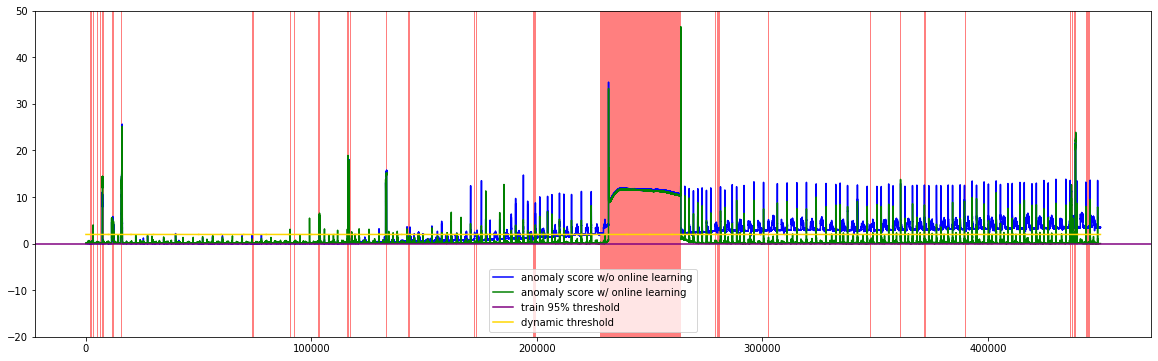

In [40]:
#ax[5].set_ylim([-1, 20])
plt.figure(figsize=(20, 6))
plt.ylim([-20, 50])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_anomaly(plt, test_y)

plt.show()

In [41]:
s, e = None, None
for i in range(len(test_y)):
    if test_y[i] == 1 and s is None:
        s = i
    elif test_y[i] == 0 and s is not None:
        e = i - 1
        print(f"[{s}, {e}], {preds[s:e].sum()} / {e-s+1}")
        s, e = None, None

[1754, 2693], 0 / 940
[3068, 3510], 1 / 443
[4920, 5302], 0 / 383
[6459, 6848], 0 / 390
[7255, 7450], 185 / 196
[7705, 8133], 0 / 429
[11410, 12373], 256 / 964
[15380, 16100], 606 / 721
[73800, 74520], 0 / 721
[90685, 90917], 0 / 233
[92140, 92570], 0 / 431
[93445, 93720], 0 / 276
[103092, 103808], 323 / 717
[115843, 116101], 1 / 259
[116143, 116537], 377 / 395
[117000, 117720], 0 / 721
[132918, 133380], 462 / 463
[142954, 143650], 1 / 697
[172305, 172588], 0 / 284
[172910, 173521], 1 / 612
[198296, 199740], 13 / 1445
[227828, 263727], 31972 / 35900
[279120, 279240], 0 / 121
[280060, 281230], 0 / 1171
[302653, 303019], 0 / 367
[347679, 348279], 0 / 601
[361191, 361634], 33 / 444
[371479, 371579], 0 / 101
[371855, 372335], 3 / 481
[389680, 390219], 0 / 540
[436541, 437009], 425 / 469
[437417, 437697], 242 / 281
[438147, 438547], 286 / 401
[438621, 438917], 258 / 297
[443501, 445190], 0 / 1690


## With time series

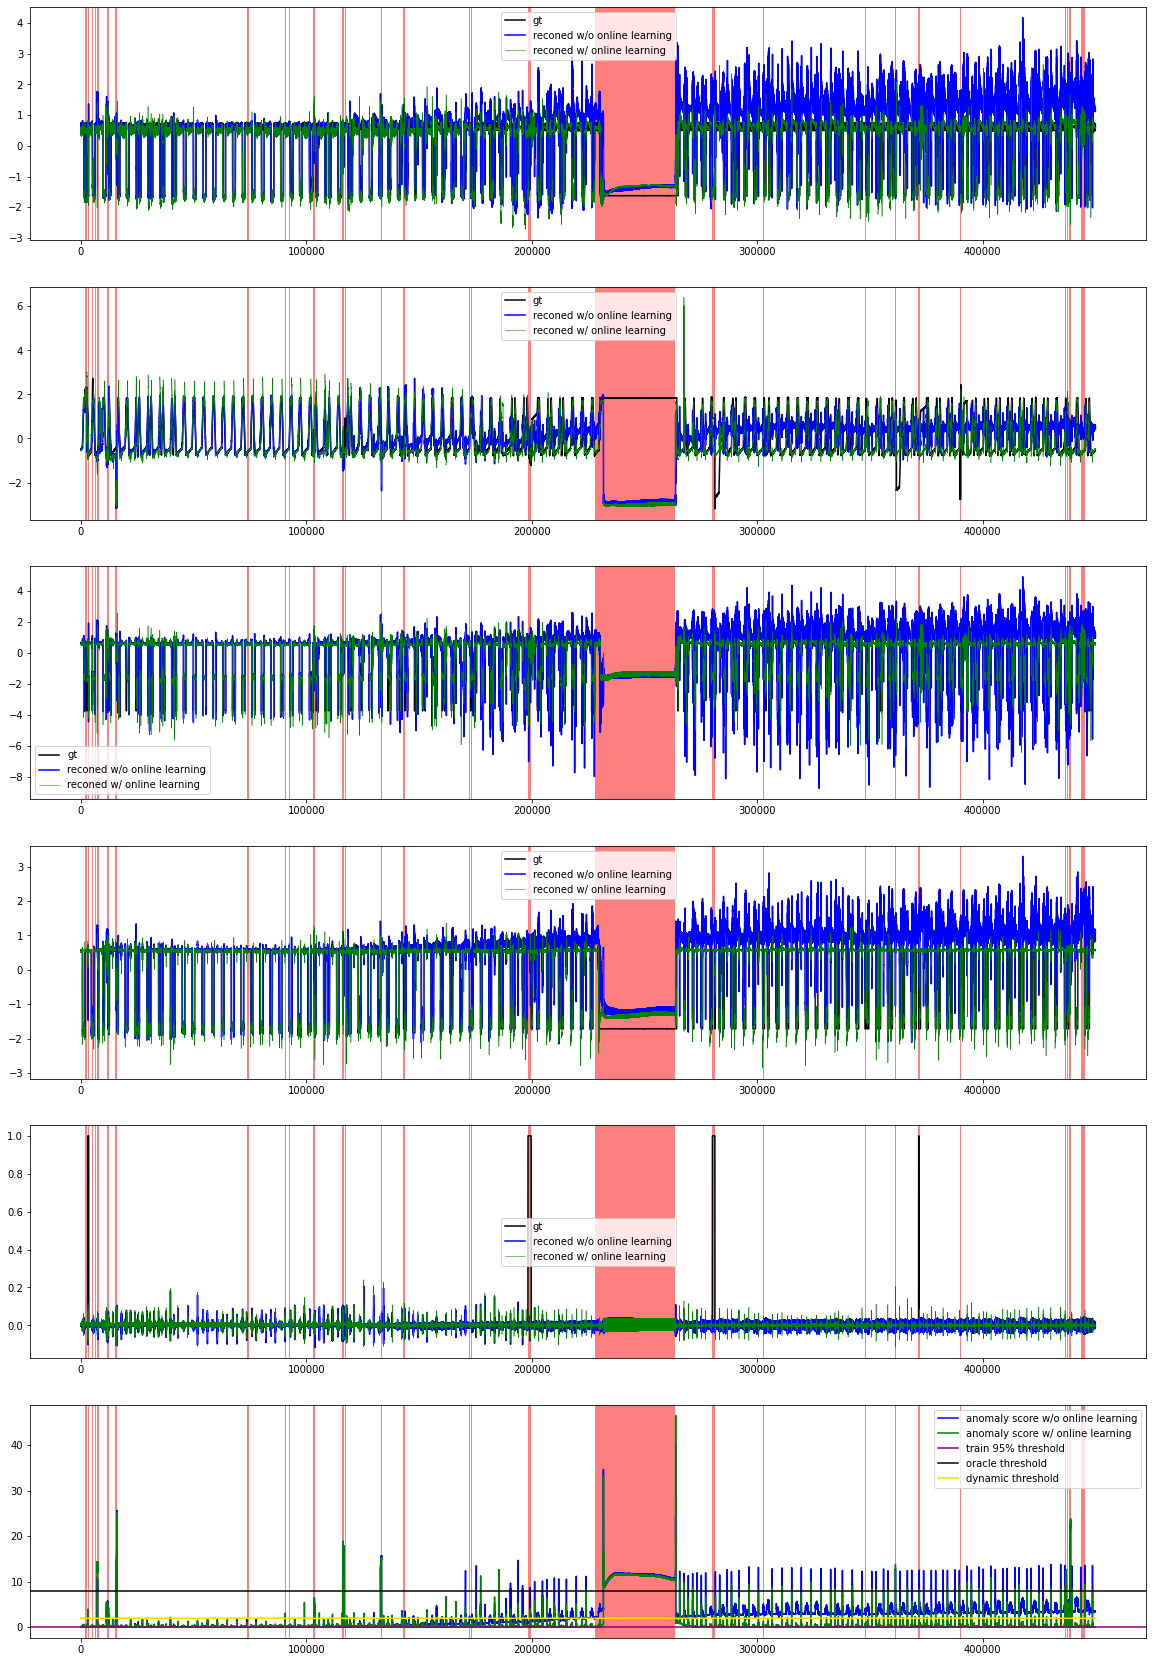

In [42]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    ax[c].plot(test_X[:, c], color="black", label="gt")
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].legend()

#ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), color="blue", label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), color="green", label="anomaly score w/ online learning")
ax[5].axhline(th_q95, color="purple", label="train 95% threshold")
ax[5].axhline(th_best_static, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

### Label-guided Online learning

In [43]:
init_thr = torch.quantile(train_error_dist, 0.95).item()
thr = torch.tensor(init_thr, requires_grad=True)
thr

tensor(0.0097, requires_grad=True)

In [44]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TH_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
thrs = []
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    thrs.append(thr.item())
    pred = (anosc > thr)
    preds.append(pred)
    
    # update
    TH_optimizer.zero_grad()
    yhat = torch.sigmoid(anosc-thr)
    yhats.append(yhat)
    cls_loss = bce(yhat, y.float())
    mask = ((y == 0).unsqueeze(2))
    recon_loss = (e*mask).mean()
    loss = cls_loss + recon_loss
    loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors:   0%|          | 0/37493 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

In [ ]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    ax[c].plot(test_X[:, c], color="black", label="gt")
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].legend()

#ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), color="blue", label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), color="green", label="anomaly score w/ online learning")
ax[5].axhline(th_q95, color="purple", label="train 95% threshold")
ax[5].axhline(th_best_static, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

In [ ]:
c=5
plt.figure(figsize=(20, 6))
plt.title(f"{args.dataset}, channel {c}")
plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")
lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

In [ ]:
c=7
plt.figure(figsize=(20, 6))
#plt.ylim(-6, 6)
plt.title(f"{args.dataset}, channel {c}")

plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.axhline(train_X[100000:, c].mean(), color = 'r', label="mean of train data")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")

lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

In [ ]:
C = 7
for c in range(args.num_channels):
    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, train")
    plt.plot(train_X[:, c], label="train", color="#1f77b4")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, test")
    plt.plot(test_X[:, c], label="test", color="#ff7f0e")
    plot_anomaly(plt, test_y)
    plt.legend()
    plt.show()